In [1]:
_server_root = ""
_data_uuid = ""
_result_path = ""


In [2]:
# Parameters
_server_root = "/home/lyiran/neelptycho/server"
_data_uuid = "b2a9d23d-560b-5d97-8d37-9937847d06a0"
_result_path = "/home/lyiran/neelptycho/server/results/task_SimpleSimMag_ePIE_padding_2"


In [3]:
import uuid
data_uuid = uuid.UUID(_data_uuid)
from pathlib import Path
result_path = Path(_result_path)
import sys, os
sys.path.append(_server_root)

In [4]:
# Timer
import time
start_time = time.time()

## ePIE Analysis

In [5]:
from library.data import get_data_path
import yaml
from library.utils import load_params, add_colordisk_hsv, complex_to_hsv, with_default_unit
import h5py
import tables
data_path = get_data_path(data_uuid)
p = load_params("ePIE")
with h5py.File(data_path, "r") as file:
    attrs = dict(file.attrs)
    dp_shape = file["/data"].shape[-2:]
    dps = file["/data"][()].reshape((attrs["height"], attrs["width"]) + dp_shape)

if "semiconv_pix" in p:
    attrs["semiconv_pix"] = p["semiconv_pix"]
if "rotation" in p:
    attrs["rotation"] = with_default_unit(p["rotation"], "degree")

if "defocus" not in p["ePIE"]:
    p["ePIE"]["defocus"] = 0
p["ePIE"]["defocus"] = with_default_unit(p["ePIE"]["defocus"], "m")

In [6]:
from epie.param_manager import ParamTree, PtychoParams, DatasetParams, NumericalParams
from epie.utils import wavelength
dataset_params = ParamTree(
    # Base dataset information
    dataset_name=attrs["name"],
    format="mib",
    acquisition_time=attrs["datetime"],
    # Scan/Diff Geometry
    scan_height_raw=attrs["height"], # the true number of scan rows acquired before pre-processing
    scan_width_raw=attrs["width"], # the true number of scan columns acquired before pre-processing
    scan_origin="top-left", # where does the scan coordinate system have its origin
                           # a string combination of 'top/bottom-left/right'
                           # top implies positive=downwards, right implies positive=leftwards
    scan_skip_rows=(0,0), # number of rows to skip at start (origin) and end of height
    scan_skip_cols=(0,0), # number of columns to skip at start (origin) and end of width
    scan_step_row_ang=attrs["stepsize"] * 1e10, # scan step in angstroms between rows
    scan_step_col_ang=attrs.get("stepsize_y", attrs["stepsize"]) * 1e10, # scan step in angstroms between columns
    scan_to_diff_rot_deg=attrs["rotation"], # rotation in degrees from a scan coordinate dimension to equivalent diffraction pattern coordinate
    diff_height_raw=dps.shape[2], # the true number of diff rows per-frame before pre-processing
    diff_width_raw=dps.shape[3], # the true number of diff columns per-frame before pre-processing
    diff_origin="top-left", # same definition as scan_origin
    # Acquisition parameters
    aperture_size_mrad=attrs["semiconv"] * 1e3,
    aperture_size_px=attrs["semiconv_pix"],
    beam_voltage_kv=attrs["voltage"],
    defocus_ang=p["ePIE"]["defocus"] * 1e10,
    pixel_size_detector_m=attrs["psize"], # in metres
    # Processed dataset dimensions
    # These values are used in preference to the above ones when present
    scan_height=attrs["height"],
    scan_width=attrs["width"],
    diff_height=dps.shape[2],
    diff_width=dps.shape[3],
    #wavelength_m=wavelength(attrs["voltage"]),
    #wavelength_pm=wavelength(attrs["voltage"])*1e12
)
reconst_params = ParamTree(
    enable_circular_cutoff=p["ePIE"].get("enable_circular_cutoff", False),
    diff_cutoff_radius_fraction=p["ePIE"]["diff_cutoff_radius_fraction"],
    diff_intensity_lower_cutoff=p["ePIE"]["diff_intensity_lower_cutoff"],
    diff_origin_shift=p["ePIE"]["diff_origin_shift"],
    diff_padding_factor=p["ePIE"]["diff_padding_factor"],
    diff_stride=p["ePIE"]["diff_stride"],
    binning_factor=p["ePIE"].get("binning_factor", 1),
    n_iteration_frozen_probe=p["ePIE"]["n_iteration_frozen_probe"],
    n_iteration_frozen_object=p["ePIE"].get("n_iteration_frozen_object", 0),
    probe_update_interval=p["ePIE"].get("probe_update_interval", 1),
    n_iteration_target=p["ePIE"]["n_iteration_target"],
    scan_stride=p["ePIE"]["scan_stride"],
    alpha=p["ePIE"]["alpha"],
    beta=p["ePIE"]["beta"],
    force_aperture_mask=p["ePIE"].get("force_aperture_mask", False),
    force_weak_phase_approx=p["ePIE"].get("force_weak_phase_approx", False),
    force_relative=p["ePIE"].get("force_relative", False)
)

import yaml
print("--- data.yaml ---")
print(yaml.dump(dataset_params))
print("--- reconst.yaml ---")
print(yaml.dump(reconst_params))

--- data.yaml ---
!!python/object/new:epie.param_manager.ParamTree
dictitems:
  acquisition_time: !!python/object/apply:numpy.core.multiarray.scalar
  - !!python/object/apply:numpy.dtype
    args:
    - S19
    - false
    - true
    state: !!python/tuple
    - 3
    - '|'
    - null
    - null
    - null
    - 19
    - 1
    - 0
  - !!binary |
    MjAyNC0wNS0yMlQxMDo0MDowMA==
  aperture_size_mrad: !!python/object/apply:numpy.core.multiarray.scalar
  - &id001 !!python/object/apply:numpy.dtype
    args:
    - f8
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
    - null
    - null
    - -1
    - -1
    - 0
  - !!binary |
    AAAAAAAANEA=
  aperture_size_px: !!python/object/apply:numpy.core.multiarray.scalar
  - *id001
  - !!binary |
    hetRuB6FKEA=
  beam_voltage_kv: !!python/object/apply:numpy.core.multiarray.scalar
  - &id002 !!python/object/apply:numpy.dtype
    args:
    - i4
    - false
    - true
    state: !!python/tuple
    - 3
    - <
    - null
   

In [7]:
# the pixel size of reconstructed image
cbed_dimension_reconst = dataset_params["diff_width"] / reconst_params["diff_stride"] * reconst_params["diff_padding_factor"]
resolution_reciprocal_space_rad = attrs["semiconv"] / attrs["semiconv_pix"] * reconst_params["diff_stride"]
resolution_reciprocal_space = resolution_reciprocal_space_rad / wavelength(attrs["voltage"])
resolution_real_space = 1.0 / (resolution_reciprocal_space * cbed_dimension_reconst)

print(f"Resolutions:")
print(f"  Reciprocal Space : {resolution_reciprocal_space_rad} rad")
print(f"  Reciprocal Space : {resolution_reciprocal_space / 1e10} Å^{-1}")
print(f"  Real Space       : {resolution_real_space * 1e10} Å")

Resolutions:
  Reciprocal Space : 0.0016313213703099511 rad
  Reciprocal Space : 0.03906633474804123 Å^-1
  Real Space       : 0.09999018400864593 Å


In [8]:
import numpy as np
if os.path.exists("probe_init.npy"):
    print("initial probe found")
    probe0 = np.load("probe_init.npy")
else:
    probe0 = None

if os.path.exists("object_init.npy"):
    print("initial object found")
    obj0 = np.load("object_init.npy")
else:
    obj0 = None

In [9]:
from epie.lib import run_epie
from epie.gpu_utils import set_device
from pprint import pprint
params = PtychoParams()
params["dataset"] = DatasetParams(**dataset_params)
params["numerical"] = NumericalParams(**reconst_params)

print(params.dataset.__class__)
print(params.dataset.wavelength_pm)
pprint(params)

with set_device(dev_id=1):
    obj, probe = run_epie(dps, params, results_directory=result_path, probe0=probe0, obj0=obj0)

<class 'epie.param_manager.DatasetParams'>
4.1757727742599275
{'dataset': {'acquisition_time': b'2024-05-22T10:40:00',
             'aperture_size_mrad': 20.0,
             'aperture_size_px': 12.26,
             'beam_voltage_kv': 80,
             'dataset_name': b'Simple Simulation from Mag Image',
             'defocus_ang': 0.0,
             'diff_height': 128,
             'diff_height_raw': 128,
             'diff_origin': 'top-left',
             'diff_width': 128,
             'diff_width_raw': 128,
             'format': 'mib',
             'pixel_size_detector_m': 5.5e-05,
             'scan_height': 71,
             'scan_height_raw': 71,
             'scan_origin': 'top-left',
             'scan_skip_cols': (0, 0),
             'scan_skip_rows': (0, 0),
             'scan_step_col_ang': 1.0,
             'scan_step_row_ang': 1.0,
             'scan_to_diff_rot_deg': 0,
             'scan_width': 71,
             'scan_width_raw': 71},
 'numerical': {'alpha': 0.7,
          

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 22/5041 [00:00<00:22, 218.63it/s]

DP iterations:   1%|          | 62/5041 [00:00<00:15, 320.54it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:13, 354.40it/s]

DP iterations:   3%|▎         | 142/5041 [00:00<00:13, 371.37it/s]

DP iterations:   4%|▎         | 182/5041 [00:00<00:12, 380.95it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:12, 386.91it/s]

DP iterations:   5%|▌         | 263/5041 [00:00<00:12, 391.00it/s]

DP iterations:   6%|▌         | 303/5041 [00:00<00:12, 391.86it/s]

DP iterations:   7%|▋         | 344/5041 [00:00<00:11, 394.70it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:11, 396.51it/s]

DP iterations:   8%|▊         | 426/5041 [00:01<00:11, 398.24it/s]

DP iterations:   9%|▉         | 467/5041 [00:01<00:11, 399.21it/s]

DP iterations:  10%|█         | 508/5041 [00:01<00:11, 400.01it/s]

DP iterations:  11%|█         | 549/5041 [00:01<00:11, 400.05it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:11, 400.10it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:11, 396.74it/s]

DP iterations:  13%|█▎        | 672/5041 [00:01<00:10, 398.01it/s]

DP iterations:  14%|█▍        | 713/5041 [00:01<00:10, 399.39it/s]

DP iterations:  15%|█▍        | 753/5041 [00:01<00:10, 399.46it/s]

DP iterations:  16%|█▌        | 794/5041 [00:02<00:10, 400.05it/s]

DP iterations:  17%|█▋        | 835/5041 [00:02<00:10, 399.65it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:10, 399.66it/s]

DP iterations:  18%|█▊        | 916/5041 [00:02<00:10, 400.02it/s]

DP iterations:  19%|█▉        | 957/5041 [00:02<00:10, 399.21it/s]

DP iterations:  20%|█▉        | 998/5041 [00:02<00:10, 400.54it/s]

DP iterations:  21%|██        | 1039/5041 [00:02<00:09, 401.40it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:02<00:09, 402.61it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:02<00:09, 403.52it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:02<00:09, 403.24it/s]

DP iterations:  24%|██▍       | 1203/5041 [00:03<00:09, 402.96it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:03<00:09, 402.80it/s]

DP iterations:  25%|██▌       | 1285/5041 [00:03<00:09, 398.87it/s]

DP iterations:  26%|██▋       | 1325/5041 [00:03<00:09, 398.62it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:09, 399.87it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:03<00:09, 400.85it/s]

DP iterations:  29%|██▊       | 1448/5041 [00:03<00:08, 402.05it/s]

DP iterations:  30%|██▉       | 1489/5041 [00:03<00:08, 402.07it/s]

DP iterations:  30%|███       | 1530/5041 [00:03<00:08, 403.17it/s]

DP iterations:  31%|███       | 1571/5041 [00:03<00:08, 398.77it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:08, 391.16it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:04<00:08, 389.49it/s]

DP iterations:  34%|███▎      | 1690/5041 [00:04<00:08, 386.97it/s]

DP iterations:  34%|███▍      | 1729/5041 [00:04<00:08, 383.84it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:04<00:08, 364.82it/s]

DP iterations:  36%|███▌      | 1805/5041 [00:04<00:08, 362.91it/s]

DP iterations:  37%|███▋      | 1842/5041 [00:04<00:08, 361.39it/s]

DP iterations:  37%|███▋      | 1879/5041 [00:04<00:08, 360.81it/s]

DP iterations:  38%|███▊      | 1916/5041 [00:04<00:08, 360.93it/s]

DP iterations:  39%|███▊      | 1953/5041 [00:05<00:08, 361.92it/s]

DP iterations:  39%|███▉      | 1990/5041 [00:05<00:08, 362.08it/s]

DP iterations:  40%|████      | 2027/5041 [00:05<00:08, 362.54it/s]

DP iterations:  41%|████      | 2064/5041 [00:05<00:08, 363.38it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:05<00:08, 363.93it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:05<00:08, 359.49it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:05<00:08, 346.95it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:05<00:08, 339.27it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:05<00:08, 333.99it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:05<00:08, 329.42it/s]

DP iterations:  46%|████▌     | 2311/5041 [00:06<00:08, 325.56it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:08, 325.73it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 334.32it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:06<00:07, 341.49it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:06<00:07, 345.08it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:06<00:07, 348.31it/s]

DP iterations:  50%|█████     | 2523/5041 [00:06<00:07, 347.50it/s]

DP iterations:  51%|█████     | 2558/5041 [00:06<00:07, 342.49it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:06<00:07, 343.78it/s]

DP iterations:  52%|█████▏    | 2629/5041 [00:06<00:06, 346.71it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:07<00:06, 349.80it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:07<00:06, 352.24it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:07<00:06, 354.47it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:07<00:06, 356.10it/s]

DP iterations:  56%|█████▌    | 2811/5041 [00:07<00:06, 357.37it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:07<00:06, 358.74it/s]

DP iterations:  57%|█████▋    | 2885/5041 [00:07<00:05, 359.81it/s]

DP iterations:  58%|█████▊    | 2921/5041 [00:07<00:05, 358.90it/s]

DP iterations:  59%|█████▊    | 2958/5041 [00:07<00:05, 359.83it/s]

DP iterations:  59%|█████▉    | 2995/5041 [00:08<00:05, 360.99it/s]

DP iterations:  60%|██████    | 3032/5041 [00:08<00:05, 361.78it/s]

DP iterations:  61%|██████    | 3069/5041 [00:08<00:05, 361.88it/s]

DP iterations:  62%|██████▏   | 3106/5041 [00:08<00:05, 360.85it/s]

DP iterations:  62%|██████▏   | 3143/5041 [00:08<00:05, 362.24it/s]

DP iterations:  63%|██████▎   | 3180/5041 [00:08<00:05, 363.58it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:08<00:05, 361.73it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:08<00:04, 360.79it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:08<00:04, 360.64it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:08<00:04, 361.02it/s]

DP iterations:  67%|██████▋   | 3365/5041 [00:09<00:04, 361.28it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:09<00:04, 361.96it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:09<00:04, 360.72it/s]

DP iterations:  69%|██████▉   | 3476/5041 [00:09<00:04, 360.06it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:09<00:04, 360.94it/s]

DP iterations:  70%|███████   | 3550/5041 [00:09<00:04, 360.44it/s]

DP iterations:  71%|███████   | 3587/5041 [00:09<00:04, 359.48it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:09<00:03, 359.80it/s]

DP iterations:  73%|███████▎  | 3660/5041 [00:09<00:03, 359.17it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:09<00:03, 359.45it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 359.84it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:10<00:03, 360.28it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:10<00:03, 361.42it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:10<00:03, 360.63it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 360.61it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:10<00:03, 360.43it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:10<00:03, 360.18it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:10<00:02, 360.04it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:10<00:02, 359.48it/s]

DP iterations:  81%|████████  | 4066/5041 [00:10<00:02, 350.70it/s]

DP iterations:  81%|████████▏ | 4102/5041 [00:11<00:02, 349.56it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:11<00:02, 349.59it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:11<00:02, 331.43it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:11<00:02, 324.98it/s]

DP iterations:  84%|████████▍ | 4242/5041 [00:11<00:02, 333.72it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:11<00:02, 339.53it/s]

DP iterations:  86%|████████▌ | 4314/5041 [00:11<00:02, 344.99it/s]

DP iterations:  86%|████████▋ | 4350/5041 [00:11<00:01, 348.59it/s]

DP iterations:  87%|████████▋ | 4386/5041 [00:11<00:01, 350.06it/s]

DP iterations:  88%|████████▊ | 4422/5041 [00:12<00:01, 351.66it/s]

DP iterations:  88%|████████▊ | 4458/5041 [00:12<00:01, 353.28it/s]

DP iterations:  89%|████████▉ | 4494/5041 [00:12<00:01, 355.04it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:12<00:01, 356.54it/s]

DP iterations:  91%|█████████ | 4567/5041 [00:12<00:01, 357.01it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:12<00:01, 356.11it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:12<00:01, 354.96it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:12<00:01, 355.30it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:12<00:00, 361.50it/s]

DP iterations:  94%|█████████▍| 4753/5041 [00:12<00:00, 372.50it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:13<00:00, 371.39it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:13<00:00, 372.49it/s]

DP iterations:  97%|█████████▋| 4869/5041 [00:13<00:00, 378.52it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:13<00:00, 365.89it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:13<00:00, 371.16it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:13<00:00, 373.99it/s]

DP iterations: 100%|█████████▉| 5025/5041 [00:13<00:00, 381.24it/s]

Epochs:   1%|          | 1/100 [00:15<24:46, 15.01s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 376.30it/s]

DP iterations:   2%|▏         | 77/5041 [00:00<00:12, 383.83it/s]

DP iterations:   2%|▏         | 117/5041 [00:00<00:12, 387.06it/s]

DP iterations:   3%|▎         | 156/5041 [00:00<00:12, 384.97it/s]

DP iterations:   4%|▍         | 195/5041 [00:00<00:12, 384.91it/s]

DP iterations:   5%|▍         | 235/5041 [00:00<00:12, 387.14it/s]

DP iterations:   5%|▌         | 274/5041 [00:00<00:12, 387.35it/s]

DP iterations:   6%|▌         | 314/5041 [00:00<00:12, 389.77it/s]

DP iterations:   7%|▋         | 354/5041 [00:00<00:12, 389.95it/s]

DP iterations:   8%|▊         | 393/5041 [00:01<00:11, 389.80it/s]

DP iterations:   9%|▊         | 433/5041 [00:01<00:11, 389.83it/s]

DP iterations:   9%|▉         | 472/5041 [00:01<00:11, 389.66it/s]

DP iterations:  10%|█         | 511/5041 [00:01<00:11, 388.65it/s]

DP iterations:  11%|█         | 550/5041 [00:01<00:11, 388.63it/s]

DP iterations:  12%|█▏        | 589/5041 [00:01<00:11, 388.92it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:11, 388.84it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:11, 389.09it/s]

DP iterations:  14%|█▍        | 707/5041 [00:01<00:11, 389.15it/s]

DP iterations:  15%|█▍        | 746/5041 [00:01<00:11, 389.19it/s]

DP iterations:  16%|█▌        | 785/5041 [00:02<00:10, 388.64it/s]

DP iterations:  16%|█▋        | 825/5041 [00:02<00:10, 389.35it/s]

DP iterations:  17%|█▋        | 864/5041 [00:02<00:10, 389.37it/s]

DP iterations:  18%|█▊        | 903/5041 [00:02<00:10, 388.58it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:10, 390.02it/s]

DP iterations:  20%|█▉        | 983/5041 [00:02<00:10, 389.11it/s]

DP iterations:  20%|██        | 1022/5041 [00:02<00:10, 389.04it/s]

DP iterations:  21%|██        | 1062/5041 [00:02<00:10, 390.53it/s]

DP iterations:  22%|██▏       | 1102/5041 [00:02<00:10, 389.60it/s]

DP iterations:  23%|██▎       | 1142/5041 [00:02<00:09, 390.30it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:03<00:09, 391.12it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:03<00:09, 391.66it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:09, 391.53it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:03<00:09, 391.49it/s]

DP iterations:  27%|██▋       | 1342/5041 [00:03<00:09, 393.52it/s]

DP iterations:  27%|██▋       | 1382/5041 [00:03<00:09, 392.60it/s]

DP iterations:  28%|██▊       | 1422/5041 [00:03<00:09, 392.99it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:03<00:09, 394.66it/s]

DP iterations:  30%|██▉       | 1502/5041 [00:03<00:08, 395.62it/s]

DP iterations:  31%|███       | 1542/5041 [00:03<00:08, 396.66it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:04<00:08, 395.51it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:04<00:08, 396.93it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:04<00:08, 396.78it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:04<00:08, 397.93it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:04<00:08, 395.27it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:04<00:08, 396.03it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:04<00:08, 397.49it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:04<00:08, 395.90it/s]

DP iterations:  38%|███▊      | 1906/5041 [00:04<00:07, 397.64it/s]

DP iterations:  39%|███▊      | 1946/5041 [00:04<00:07, 397.65it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:05<00:07, 389.05it/s]

DP iterations:  40%|████      | 2025/5041 [00:05<00:07, 384.84it/s]

DP iterations:  41%|████      | 2064/5041 [00:05<00:07, 383.28it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:07, 383.13it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:05<00:07, 382.49it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:05<00:07, 382.57it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:05<00:07, 382.77it/s]

DP iterations:  45%|████▍     | 2259/5041 [00:05<00:07, 383.76it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:05<00:07, 384.11it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:05<00:07, 383.55it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:06<00:06, 383.51it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:06<00:06, 383.58it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:06<00:06, 381.77it/s]

DP iterations:  49%|████▉     | 2493/5041 [00:06<00:06, 381.10it/s]

DP iterations:  50%|█████     | 2532/5041 [00:06<00:06, 380.87it/s]

DP iterations:  51%|█████     | 2571/5041 [00:06<00:06, 379.42it/s]

DP iterations:  52%|█████▏    | 2610/5041 [00:06<00:06, 380.58it/s]

DP iterations:  53%|█████▎    | 2649/5041 [00:06<00:06, 380.98it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:06<00:06, 381.22it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:07<00:06, 381.57it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:07<00:05, 382.94it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:07<00:05, 382.16it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:07<00:05, 381.97it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:07<00:05, 382.17it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:07<00:05, 381.76it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:07<00:05, 381.90it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:07<00:05, 381.81it/s]

DP iterations:  60%|██████    | 3039/5041 [00:07<00:05, 381.83it/s]

DP iterations:  61%|██████    | 3078/5041 [00:07<00:05, 382.12it/s]

DP iterations:  62%|██████▏   | 3117/5041 [00:08<00:05, 382.01it/s]

DP iterations:  63%|██████▎   | 3156/5041 [00:08<00:04, 380.70it/s]

DP iterations:  63%|██████▎   | 3195/5041 [00:08<00:04, 380.04it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:08<00:04, 380.78it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:08<00:04, 381.08it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:08<00:04, 381.54it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:08<00:04, 380.69it/s]

DP iterations:  67%|██████▋   | 3390/5041 [00:08<00:04, 381.35it/s]

DP iterations:  68%|██████▊   | 3429/5041 [00:08<00:04, 381.72it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:08<00:04, 381.95it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:09<00:04, 382.16it/s]

DP iterations:  70%|███████   | 3546/5041 [00:09<00:03, 382.52it/s]

DP iterations:  71%|███████   | 3585/5041 [00:09<00:03, 382.45it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:09<00:03, 381.86it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:09<00:03, 381.32it/s]

DP iterations:  73%|███████▎  | 3702/5041 [00:09<00:03, 380.66it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:09<00:03, 380.77it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:09<00:03, 381.21it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:09<00:03, 381.46it/s]

DP iterations:  77%|███████▋  | 3858/5041 [00:09<00:03, 381.18it/s]

DP iterations:  77%|███████▋  | 3897/5041 [00:10<00:03, 381.09it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:10<00:02, 377.86it/s]

DP iterations:  79%|███████▉  | 3974/5041 [00:10<00:02, 377.23it/s]

DP iterations:  80%|███████▉  | 4013/5041 [00:10<00:02, 378.59it/s]

DP iterations:  80%|████████  | 4051/5041 [00:10<00:02, 378.80it/s]

DP iterations:  81%|████████  | 4090/5041 [00:10<00:02, 379.30it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:10<00:02, 378.61it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:10<00:02, 379.84it/s]

DP iterations:  83%|████████▎ | 4206/5041 [00:10<00:02, 380.27it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:11<00:02, 380.22it/s]

DP iterations:  85%|████████▍ | 4284/5041 [00:11<00:01, 380.00it/s]

DP iterations:  86%|████████▌ | 4324/5041 [00:11<00:01, 384.47it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:11<00:01, 397.20it/s]

DP iterations:  87%|████████▋ | 4410/5041 [00:11<00:01, 405.45it/s]

DP iterations:  88%|████████▊ | 4453/5041 [00:11<00:01, 411.10it/s]

DP iterations:  89%|████████▉ | 4496/5041 [00:11<00:01, 415.36it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:11<00:01, 418.57it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:11<00:01, 419.59it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:11<00:00, 421.35it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:12<00:00, 423.02it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:12<00:00, 423.43it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:12<00:00, 424.02it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:12<00:00, 424.66it/s]

DP iterations:  96%|█████████▌| 4840/5041 [00:12<00:00, 425.00it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:12<00:00, 424.88it/s]

DP iterations:  98%|█████████▊| 4926/5041 [00:12<00:00, 423.91it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:12<00:00, 423.20it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:12<00:00, 423.86it/s]

Epochs:   2%|▏         | 2/100 [00:28<23:31, 14.40s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 39/5041 [00:00<00:12, 385.35it/s]

DP iterations:   2%|▏         | 78/5041 [00:00<00:12, 387.34it/s]

DP iterations:   2%|▏         | 117/5041 [00:00<00:13, 376.31it/s]

DP iterations:   3%|▎         | 155/5041 [00:00<00:13, 374.48it/s]

DP iterations:   4%|▍         | 193/5041 [00:00<00:12, 374.90it/s]

DP iterations:   5%|▍         | 232/5041 [00:00<00:12, 378.00it/s]

DP iterations:   5%|▌         | 271/5041 [00:00<00:12, 378.67it/s]

DP iterations:   6%|▌         | 309/5041 [00:00<00:12, 377.99it/s]

DP iterations:   7%|▋         | 347/5041 [00:00<00:12, 371.55it/s]

DP iterations:   8%|▊         | 386/5041 [00:01<00:12, 375.07it/s]

DP iterations:   8%|▊         | 425/5041 [00:01<00:12, 377.98it/s]

DP iterations:   9%|▉         | 464/5041 [00:01<00:12, 378.83it/s]

DP iterations:  10%|▉         | 503/5041 [00:01<00:11, 380.23it/s]

DP iterations:  11%|█         | 542/5041 [00:01<00:11, 380.36it/s]

DP iterations:  12%|█▏        | 581/5041 [00:01<00:11, 380.62it/s]

DP iterations:  12%|█▏        | 620/5041 [00:01<00:11, 381.72it/s]

DP iterations:  13%|█▎        | 659/5041 [00:01<00:11, 382.28it/s]

DP iterations:  14%|█▍        | 698/5041 [00:01<00:11, 381.69it/s]

DP iterations:  15%|█▍        | 737/5041 [00:01<00:11, 381.40it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:11, 381.54it/s]

DP iterations:  16%|█▌        | 815/5041 [00:02<00:11, 380.30it/s]

DP iterations:  17%|█▋        | 854/5041 [00:02<00:10, 381.80it/s]

DP iterations:  18%|█▊        | 893/5041 [00:02<00:10, 382.76it/s]

DP iterations:  18%|█▊        | 932/5041 [00:02<00:10, 383.52it/s]

DP iterations:  19%|█▉        | 971/5041 [00:02<00:10, 382.01it/s]

DP iterations:  20%|██        | 1010/5041 [00:02<00:10, 383.51it/s]

DP iterations:  21%|██        | 1049/5041 [00:02<00:10, 383.47it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:02<00:10, 382.68it/s]

DP iterations:  22%|██▏       | 1127/5041 [00:02<00:10, 382.25it/s]

DP iterations:  23%|██▎       | 1166/5041 [00:03<00:10, 382.46it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:03<00:10, 380.77it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:03<00:09, 380.98it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:03<00:09, 381.36it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:03<00:09, 382.18it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:03<00:09, 382.35it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:03<00:09, 382.36it/s]

DP iterations:  29%|██▊       | 1439/5041 [00:03<00:09, 382.41it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:03<00:09, 382.11it/s]

DP iterations:  30%|███       | 1517/5041 [00:03<00:09, 382.18it/s]

DP iterations:  31%|███       | 1556/5041 [00:04<00:09, 382.37it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:04<00:09, 381.50it/s]

DP iterations:  32%|███▏      | 1634/5041 [00:04<00:08, 381.11it/s]

DP iterations:  33%|███▎      | 1673/5041 [00:04<00:08, 382.10it/s]

DP iterations:  34%|███▍      | 1712/5041 [00:04<00:08, 381.67it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:04<00:08, 382.33it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:04<00:08, 381.23it/s]

DP iterations:  36%|███▋      | 1829/5041 [00:04<00:08, 380.32it/s]

DP iterations:  37%|███▋      | 1868/5041 [00:04<00:08, 380.38it/s]

DP iterations:  38%|███▊      | 1907/5041 [00:05<00:08, 380.81it/s]

DP iterations:  39%|███▊      | 1946/5041 [00:05<00:08, 381.51it/s]

DP iterations:  39%|███▉      | 1985/5041 [00:05<00:08, 381.29it/s]

DP iterations:  40%|████      | 2024/5041 [00:05<00:07, 383.01it/s]

DP iterations:  41%|████      | 2063/5041 [00:05<00:07, 382.30it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:05<00:07, 382.37it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:05<00:07, 382.31it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:05<00:07, 383.38it/s]

DP iterations:  44%|████▍     | 2219/5041 [00:05<00:07, 383.18it/s]

DP iterations:  45%|████▍     | 2258/5041 [00:05<00:07, 382.33it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:06<00:07, 381.08it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:06<00:07, 381.40it/s]

DP iterations:  47%|████▋     | 2375/5041 [00:06<00:06, 381.00it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:06<00:06, 381.95it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:06<00:06, 381.80it/s]

DP iterations:  49%|████▉     | 2492/5041 [00:06<00:06, 381.93it/s]

DP iterations:  50%|█████     | 2531/5041 [00:06<00:06, 382.15it/s]

DP iterations:  51%|█████     | 2570/5041 [00:06<00:06, 382.00it/s]

DP iterations:  52%|█████▏    | 2609/5041 [00:06<00:06, 382.71it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:06<00:06, 382.67it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:07<00:06, 381.71it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:07<00:06, 381.77it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:07<00:05, 381.69it/s]

DP iterations:  56%|█████▌    | 2804/5041 [00:07<00:05, 380.53it/s]

DP iterations:  56%|█████▋    | 2843/5041 [00:07<00:05, 379.89it/s]

DP iterations:  57%|█████▋    | 2881/5041 [00:07<00:05, 379.54it/s]

DP iterations:  58%|█████▊    | 2919/5041 [00:07<00:05, 379.04it/s]

DP iterations:  59%|█████▊    | 2957/5041 [00:07<00:05, 378.85it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:07<00:05, 380.06it/s]

DP iterations:  60%|██████    | 3035/5041 [00:07<00:05, 379.89it/s]

DP iterations:  61%|██████    | 3074/5041 [00:08<00:05, 381.14it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:08<00:05, 382.09it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:08<00:04, 381.90it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:08<00:04, 382.14it/s]

DP iterations:  64%|██████▍   | 3230/5041 [00:08<00:04, 382.54it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:08<00:04, 377.97it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:08<00:04, 378.29it/s]

DP iterations:  66%|██████▋   | 3347/5041 [00:08<00:04, 381.89it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:08<00:04, 382.70it/s]

DP iterations:  68%|██████▊   | 3425/5041 [00:08<00:04, 382.59it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:09<00:04, 382.20it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:09<00:04, 382.19it/s]

DP iterations:  70%|███████   | 3542/5041 [00:09<00:03, 382.18it/s]

DP iterations:  71%|███████   | 3581/5041 [00:09<00:03, 380.89it/s]

DP iterations:  72%|███████▏  | 3620/5041 [00:09<00:03, 381.19it/s]

DP iterations:  73%|███████▎  | 3659/5041 [00:09<00:03, 382.08it/s]

DP iterations:  73%|███████▎  | 3698/5041 [00:09<00:03, 381.30it/s]

DP iterations:  74%|███████▍  | 3737/5041 [00:09<00:03, 380.01it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:09<00:03, 379.70it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:10<00:03, 380.59it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:10<00:03, 381.43it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 381.85it/s]

DP iterations:  78%|███████▊  | 3932/5041 [00:10<00:02, 381.81it/s]

DP iterations:  79%|███████▉  | 3971/5041 [00:10<00:02, 382.30it/s]

DP iterations:  80%|███████▉  | 4010/5041 [00:10<00:02, 381.73it/s]

DP iterations:  80%|████████  | 4049/5041 [00:10<00:02, 380.84it/s]

DP iterations:  81%|████████  | 4088/5041 [00:10<00:02, 380.64it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:10<00:02, 380.97it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:10<00:02, 379.30it/s]

DP iterations:  83%|████████▎ | 4205/5041 [00:11<00:02, 380.53it/s]

DP iterations:  84%|████████▍ | 4244/5041 [00:11<00:02, 380.68it/s]

DP iterations:  85%|████████▍ | 4283/5041 [00:11<00:01, 381.00it/s]

DP iterations:  86%|████████▌ | 4326/5041 [00:11<00:01, 394.10it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:11<00:01, 404.31it/s]

DP iterations:  88%|████████▊ | 4412/5041 [00:11<00:01, 411.06it/s]

DP iterations:  88%|████████▊ | 4455/5041 [00:11<00:01, 415.97it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:11<00:01, 419.96it/s]

DP iterations:  90%|█████████ | 4541/5041 [00:11<00:01, 422.09it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:11<00:01, 424.01it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:12<00:00, 419.93it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:12<00:00, 419.73it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:12<00:00, 420.30it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:12<00:00, 423.32it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:12<00:00, 424.69it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:12<00:00, 424.36it/s]

DP iterations:  97%|█████████▋| 4886/5041 [00:12<00:00, 426.02it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:12<00:00, 426.54it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:12<00:00, 427.26it/s]

DP iterations:  99%|█████████▉| 5015/5041 [00:12<00:00, 426.09it/s]

Epochs:   3%|▎         | 3/100 [00:43<23:08, 14.31s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 12/5041 [00:00<01:12, 69.12it/s]

DP iterations:   1%|          | 52/5041 [00:00<00:22, 217.59it/s]

DP iterations:   2%|▏         | 93/5041 [00:00<00:17, 290.47it/s]

DP iterations:   3%|▎         | 133/5041 [00:00<00:14, 328.06it/s]

DP iterations:   3%|▎         | 173/5041 [00:00<00:13, 352.13it/s]

DP iterations:   4%|▍         | 213/5041 [00:00<00:13, 364.53it/s]

DP iterations:   5%|▌         | 253/5041 [00:00<00:12, 373.58it/s]

DP iterations:   6%|▌         | 293/5041 [00:00<00:12, 381.74it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:12, 385.21it/s]

DP iterations:   7%|▋         | 373/5041 [00:01<00:11, 389.54it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:11, 391.33it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:11, 392.47it/s]

DP iterations:  10%|▉         | 494/5041 [00:01<00:11, 395.28it/s]

DP iterations:  11%|█         | 535/5041 [00:01<00:11, 397.29it/s]

DP iterations:  11%|█▏        | 575/5041 [00:01<00:11, 397.26it/s]

DP iterations:  12%|█▏        | 615/5041 [00:01<00:11, 397.53it/s]

DP iterations:  13%|█▎        | 655/5041 [00:01<00:11, 398.02it/s]

DP iterations:  14%|█▍        | 695/5041 [00:01<00:10, 397.85it/s]

DP iterations:  15%|█▍        | 735/5041 [00:01<00:10, 398.15it/s]

DP iterations:  15%|█▌        | 775/5041 [00:02<00:10, 397.13it/s]

DP iterations:  16%|█▌        | 815/5041 [00:02<00:10, 397.86it/s]

DP iterations:  17%|█▋        | 855/5041 [00:02<00:10, 397.87it/s]

DP iterations:  18%|█▊        | 895/5041 [00:02<00:10, 398.13it/s]

DP iterations:  19%|█▊        | 935/5041 [00:02<00:10, 398.31it/s]

DP iterations:  19%|█▉        | 975/5041 [00:02<00:10, 398.04it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:10, 397.98it/s]

DP iterations:  21%|██        | 1056/5041 [00:02<00:09, 399.09it/s]

DP iterations:  22%|██▏       | 1096/5041 [00:02<00:09, 399.13it/s]

DP iterations:  23%|██▎       | 1136/5041 [00:03<00:09, 399.30it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:03<00:09, 398.56it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:09, 399.60it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:03<00:09, 397.98it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:09, 398.11it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:03<00:09, 397.73it/s]

DP iterations:  27%|██▋       | 1377/5041 [00:03<00:09, 398.20it/s]

DP iterations:  28%|██▊       | 1417/5041 [00:03<00:09, 398.26it/s]

DP iterations:  29%|██▉       | 1457/5041 [00:03<00:09, 396.73it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:03<00:08, 398.20it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:08, 397.19it/s]

DP iterations:  31%|███▏      | 1579/5041 [00:04<00:08, 398.22it/s]

DP iterations:  32%|███▏      | 1619/5041 [00:04<00:08, 397.34it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:04<00:08, 398.54it/s]

DP iterations:  34%|███▎      | 1701/5041 [00:04<00:08, 399.15it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:04<00:08, 398.56it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:04<00:08, 398.43it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:04<00:08, 398.06it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:04<00:07, 398.95it/s]

DP iterations:  38%|███▊      | 1902/5041 [00:04<00:07, 398.74it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:05<00:07, 397.42it/s]

DP iterations:  39%|███▉      | 1983/5041 [00:05<00:07, 398.24it/s]

DP iterations:  40%|████      | 2023/5041 [00:05<00:07, 398.02it/s]

DP iterations:  41%|████      | 2064/5041 [00:05<00:07, 398.42it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:05<00:07, 397.24it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:05<00:07, 398.24it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:05<00:07, 398.63it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:05<00:07, 398.11it/s]

DP iterations:  45%|████▍     | 2266/5041 [00:05<00:06, 398.36it/s]

DP iterations:  46%|████▌     | 2307/5041 [00:05<00:06, 398.69it/s]

DP iterations:  47%|████▋     | 2347/5041 [00:06<00:06, 399.03it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:06<00:06, 399.56it/s]

DP iterations:  48%|████▊     | 2429/5041 [00:06<00:06, 400.30it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:06<00:06, 399.35it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:06<00:06, 399.67it/s]

DP iterations:  51%|█████     | 2552/5041 [00:06<00:06, 400.15it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:06<00:06, 399.34it/s]

DP iterations:  52%|█████▏    | 2634/5041 [00:06<00:06, 399.95it/s]

DP iterations:  53%|█████▎    | 2674/5041 [00:06<00:05, 399.59it/s]

DP iterations:  54%|█████▍    | 2715/5041 [00:06<00:05, 400.88it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:07<00:05, 399.05it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:07<00:05, 398.63it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:07<00:05, 398.83it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:07<00:05, 395.21it/s]

DP iterations:  58%|█████▊    | 2916/5041 [00:07<00:05, 395.99it/s]

DP iterations:  59%|█████▊    | 2956/5041 [00:07<00:05, 396.51it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:07<00:05, 391.92it/s]

DP iterations:  60%|██████    | 3036/5041 [00:07<00:05, 390.84it/s]

DP iterations:  61%|██████    | 3076/5041 [00:07<00:05, 391.99it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:07<00:04, 392.40it/s]

DP iterations:  63%|██████▎   | 3156/5041 [00:08<00:04, 393.42it/s]

DP iterations:  63%|██████▎   | 3196/5041 [00:08<00:04, 394.65it/s]

DP iterations:  64%|██████▍   | 3236/5041 [00:08<00:04, 395.76it/s]

DP iterations:  65%|██████▍   | 3276/5041 [00:08<00:04, 395.84it/s]

DP iterations:  66%|██████▌   | 3317/5041 [00:08<00:04, 397.26it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:08<00:04, 397.39it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:08<00:04, 397.99it/s]

DP iterations:  68%|██████▊   | 3437/5041 [00:08<00:04, 397.59it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:08<00:03, 397.16it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:08<00:03, 397.48it/s]

DP iterations:  71%|███████   | 3558/5041 [00:09<00:03, 398.48it/s]

DP iterations:  71%|███████▏  | 3598/5041 [00:09<00:03, 398.53it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:09<00:03, 397.92it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:09<00:03, 397.46it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:09<00:03, 398.84it/s]

DP iterations:  75%|███████▍  | 3759/5041 [00:09<00:03, 398.51it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:09<00:03, 398.82it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:09<00:03, 399.15it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:09<00:02, 398.89it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:09<00:02, 398.97it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:10<00:02, 398.30it/s]

DP iterations:  79%|███████▉  | 3999/5041 [00:10<00:02, 398.27it/s]

DP iterations:  80%|████████  | 4040/5041 [00:10<00:02, 398.90it/s]

DP iterations:  81%|████████  | 4080/5041 [00:10<00:02, 398.01it/s]

DP iterations:  82%|████████▏ | 4120/5041 [00:10<00:02, 398.46it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:10<00:02, 398.22it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:10<00:02, 398.47it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:10<00:02, 398.19it/s]

DP iterations:  85%|████████▍ | 4280/5041 [00:10<00:01, 398.10it/s]

DP iterations:  86%|████████▌ | 4320/5041 [00:11<00:01, 398.24it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:11<00:01, 398.67it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:11<00:01, 398.60it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:11<00:01, 398.22it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:11<00:01, 397.53it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:11<00:01, 397.87it/s]

DP iterations:  90%|█████████ | 4560/5041 [00:11<00:01, 398.27it/s]

DP iterations:  91%|█████████▏| 4600/5041 [00:11<00:01, 396.82it/s]

DP iterations:  92%|█████████▏| 4640/5041 [00:11<00:01, 397.26it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:11<00:00, 395.89it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:12<00:00, 394.78it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:12<00:00, 391.96it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:12<00:00, 393.87it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:12<00:00, 395.93it/s]

DP iterations:  97%|█████████▋| 4881/5041 [00:12<00:00, 396.82it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:12<00:00, 397.63it/s]

DP iterations:  98%|█████████▊| 4965/5041 [00:12<00:00, 407.67it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:12<00:00, 414.46it/s]

Epochs:   4%|▍         | 4/100 [00:57<22:38, 14.15s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 370.83it/s]

DP iterations:   2%|▏         | 77/5041 [00:00<00:13, 376.79it/s]

DP iterations:   2%|▏         | 116/5041 [00:00<00:12, 380.16it/s]

DP iterations:   3%|▎         | 156/5041 [00:00<00:12, 384.96it/s]

DP iterations:   4%|▍         | 196/5041 [00:00<00:12, 387.98it/s]

DP iterations:   5%|▍         | 236/5041 [00:00<00:12, 388.89it/s]

DP iterations:   5%|▌         | 276/5041 [00:00<00:12, 389.39it/s]

DP iterations:   6%|▋         | 316/5041 [00:00<00:12, 390.10it/s]

DP iterations:   7%|▋         | 356/5041 [00:00<00:12, 390.04it/s]

DP iterations:   8%|▊         | 396/5041 [00:01<00:11, 389.94it/s]

DP iterations:   9%|▊         | 435/5041 [00:01<00:11, 388.43it/s]

DP iterations:   9%|▉         | 474/5041 [00:01<00:11, 386.71it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:11, 386.37it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:11, 388.89it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:11, 389.83it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:11, 389.98it/s]

DP iterations:  13%|█▎        | 673/5041 [00:01<00:11, 390.11it/s]

DP iterations:  14%|█▍        | 713/5041 [00:01<00:11, 390.20it/s]

DP iterations:  15%|█▍        | 753/5041 [00:01<00:10, 390.67it/s]

DP iterations:  16%|█▌        | 793/5041 [00:02<00:10, 390.03it/s]

DP iterations:  17%|█▋        | 833/5041 [00:02<00:10, 390.98it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:10, 391.93it/s]

DP iterations:  18%|█▊        | 913/5041 [00:02<00:10, 393.12it/s]

DP iterations:  19%|█▉        | 953/5041 [00:02<00:10, 391.23it/s]

DP iterations:  20%|█▉        | 993/5041 [00:02<00:10, 392.64it/s]

DP iterations:  20%|██        | 1033/5041 [00:02<00:10, 392.67it/s]

DP iterations:  21%|██▏       | 1073/5041 [00:02<00:10, 393.79it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:02<00:09, 394.49it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:02<00:09, 395.82it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:03<00:09, 395.72it/s]

DP iterations:  24%|██▍       | 1233/5041 [00:03<00:09, 396.02it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:03<00:09, 395.95it/s]

DP iterations:  26%|██▌       | 1313/5041 [00:03<00:09, 395.60it/s]

DP iterations:  27%|██▋       | 1353/5041 [00:03<00:09, 396.01it/s]

DP iterations:  28%|██▊       | 1393/5041 [00:03<00:09, 395.54it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:03<00:09, 392.10it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:03<00:09, 393.62it/s]

DP iterations:  30%|███       | 1514/5041 [00:03<00:08, 396.20it/s]

DP iterations:  31%|███       | 1554/5041 [00:03<00:08, 397.22it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:04<00:08, 397.97it/s]

DP iterations:  32%|███▏      | 1634/5041 [00:04<00:08, 398.21it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:04<00:08, 398.87it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:08, 399.46it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:04<00:08, 400.03it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:04<00:08, 400.92it/s]

DP iterations:  36%|███▋      | 1839/5041 [00:04<00:07, 401.17it/s]

DP iterations:  37%|███▋      | 1880/5041 [00:04<00:07, 400.58it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:04<00:07, 400.38it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:04<00:07, 400.93it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:05<00:07, 401.17it/s]

DP iterations:  41%|████      | 2044/5041 [00:05<00:07, 400.05it/s]

DP iterations:  41%|████▏     | 2085/5041 [00:05<00:07, 398.92it/s]

DP iterations:  42%|████▏     | 2125/5041 [00:05<00:07, 397.69it/s]

DP iterations:  43%|████▎     | 2165/5041 [00:05<00:07, 398.07it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:05<00:07, 399.45it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:05<00:07, 399.08it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:05<00:06, 400.78it/s]

DP iterations:  46%|████▌     | 2328/5041 [00:05<00:06, 398.49it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:06<00:06, 400.28it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:06<00:06, 399.83it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:06<00:06, 398.96it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:06<00:06, 399.84it/s]

DP iterations:  50%|█████     | 2531/5041 [00:06<00:06, 398.95it/s]

DP iterations:  51%|█████     | 2571/5041 [00:06<00:06, 399.14it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:06<00:06, 400.14it/s]

DP iterations:  53%|█████▎    | 2653/5041 [00:06<00:05, 400.84it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:06<00:05, 400.37it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:06<00:05, 400.07it/s]

DP iterations:  55%|█████▌    | 2776/5041 [00:07<00:05, 400.68it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:07<00:05, 401.22it/s]

DP iterations:  57%|█████▋    | 2858/5041 [00:07<00:05, 400.17it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:07<00:05, 400.40it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:07<00:05, 400.57it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:07<00:05, 399.65it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:07<00:05, 400.34it/s]

DP iterations:  61%|██████    | 3063/5041 [00:07<00:04, 400.07it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:07<00:04, 400.20it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:07<00:04, 399.89it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:08<00:04, 400.34it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:08<00:04, 400.68it/s]

DP iterations:  65%|██████▍   | 3268/5041 [00:08<00:04, 399.83it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:08<00:04, 398.07it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:08<00:04, 397.31it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:08<00:04, 396.53it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:08<00:04, 396.12it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:08<00:03, 397.21it/s]

DP iterations:  70%|██████▉   | 3509/5041 [00:08<00:03, 397.99it/s]

DP iterations:  70%|███████   | 3549/5041 [00:08<00:03, 398.02it/s]

DP iterations:  71%|███████   | 3589/5041 [00:09<00:03, 398.55it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:09<00:03, 399.05it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:09<00:03, 398.28it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:09<00:03, 397.52it/s]

DP iterations:  74%|███████▍  | 3750/5041 [00:09<00:03, 396.59it/s]

DP iterations:  75%|███████▌  | 3791/5041 [00:09<00:03, 398.15it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:09<00:03, 398.37it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:09<00:02, 398.73it/s]

DP iterations:  78%|███████▊  | 3913/5041 [00:09<00:02, 399.45it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:09<00:02, 398.25it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:10<00:02, 396.36it/s]

DP iterations:  80%|████████  | 4033/5041 [00:10<00:02, 394.25it/s]

DP iterations:  81%|████████  | 4073/5041 [00:10<00:02, 394.16it/s]

DP iterations:  82%|████████▏ | 4113/5041 [00:10<00:02, 394.21it/s]

DP iterations:  82%|████████▏ | 4153/5041 [00:10<00:02, 393.42it/s]

DP iterations:  83%|████████▎ | 4193/5041 [00:10<00:02, 393.44it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:10<00:02, 393.25it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:10<00:01, 392.78it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:10<00:01, 393.02it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:10<00:01, 393.71it/s]

DP iterations:  87%|████████▋ | 4393/5041 [00:11<00:01, 393.90it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:11<00:01, 393.35it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:11<00:01, 394.27it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:11<00:01, 394.79it/s]

DP iterations:  90%|█████████ | 4553/5041 [00:11<00:01, 394.89it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:11<00:01, 392.75it/s]

DP iterations:  92%|█████████▏| 4636/5041 [00:11<00:01, 403.41it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:11<00:00, 413.02it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:11<00:00, 419.20it/s]

DP iterations:  95%|█████████▍| 4767/5041 [00:12<00:00, 422.36it/s]

DP iterations:  95%|█████████▌| 4811/5041 [00:12<00:00, 424.94it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:12<00:00, 427.56it/s]

DP iterations:  97%|█████████▋| 4899/5041 [00:12<00:00, 428.56it/s]

DP iterations:  98%|█████████▊| 4943/5041 [00:12<00:00, 429.84it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:12<00:00, 431.36it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:12<00:00, 432.91it/s]

Epochs:   5%|▌         | 5/100 [01:10<22:15, 14.06s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 372.14it/s]

DP iterations:   2%|▏         | 77/5041 [00:00<00:13, 381.47it/s]

DP iterations:   2%|▏         | 116/5041 [00:00<00:12, 384.92it/s]

DP iterations:   3%|▎         | 155/5041 [00:00<00:12, 385.01it/s]

DP iterations:   4%|▍         | 194/5041 [00:00<00:12, 385.28it/s]

DP iterations:   5%|▍         | 233/5041 [00:00<00:12, 384.69it/s]

DP iterations:   5%|▌         | 273/5041 [00:00<00:12, 387.12it/s]

DP iterations:   6%|▌         | 312/5041 [00:00<00:12, 387.93it/s]

DP iterations:   7%|▋         | 351/5041 [00:00<00:12, 380.27it/s]

DP iterations:   8%|▊         | 390/5041 [00:01<00:12, 383.14it/s]

DP iterations:   9%|▊         | 429/5041 [00:01<00:11, 384.99it/s]

DP iterations:   9%|▉         | 469/5041 [00:01<00:11, 383.40it/s]

DP iterations:  10%|█         | 508/5041 [00:01<00:12, 375.74it/s]

DP iterations:  11%|█         | 548/5041 [00:01<00:11, 381.97it/s]

DP iterations:  12%|█▏        | 588/5041 [00:01<00:11, 385.60it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:11, 387.75it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:11, 387.92it/s]

DP iterations:  14%|█▍        | 707/5041 [00:01<00:11, 389.91it/s]

DP iterations:  15%|█▍        | 747/5041 [00:01<00:10, 390.78it/s]

DP iterations:  16%|█▌        | 787/5041 [00:02<00:10, 390.09it/s]

DP iterations:  16%|█▋        | 827/5041 [00:02<00:10, 387.88it/s]

DP iterations:  17%|█▋        | 866/5041 [00:02<00:10, 388.20it/s]

DP iterations:  18%|█▊        | 905/5041 [00:02<00:10, 388.54it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:10, 388.18it/s]

DP iterations:  20%|█▉        | 984/5041 [00:02<00:10, 389.29it/s]

DP iterations:  20%|██        | 1024/5041 [00:02<00:10, 390.59it/s]

DP iterations:  21%|██        | 1064/5041 [00:02<00:10, 390.98it/s]

DP iterations:  22%|██▏       | 1104/5041 [00:02<00:10, 391.39it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:02<00:09, 391.53it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:09, 391.17it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:09, 390.83it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:03<00:09, 391.32it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:03<00:09, 390.55it/s]

DP iterations:  27%|██▋       | 1344/5041 [00:03<00:09, 390.79it/s]

DP iterations:  27%|██▋       | 1384/5041 [00:03<00:09, 390.08it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:03<00:09, 390.84it/s]

DP iterations:  29%|██▉       | 1464/5041 [00:03<00:09, 392.04it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:03<00:09, 392.54it/s]

DP iterations:  31%|███       | 1544/5041 [00:03<00:08, 391.69it/s]

DP iterations:  31%|███▏      | 1584/5041 [00:04<00:08, 392.43it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:04<00:08, 392.73it/s]

DP iterations:  33%|███▎      | 1664/5041 [00:04<00:08, 393.39it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:04<00:08, 393.96it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:04<00:08, 394.21it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:04<00:08, 391.90it/s]

DP iterations:  36%|███▌      | 1824/5041 [00:04<00:08, 391.84it/s]

DP iterations:  37%|███▋      | 1864/5041 [00:04<00:08, 393.87it/s]

DP iterations:  38%|███▊      | 1904/5041 [00:04<00:07, 394.84it/s]

DP iterations:  39%|███▊      | 1944/5041 [00:04<00:07, 394.08it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:05<00:07, 393.91it/s]

DP iterations:  40%|████      | 2024/5041 [00:05<00:07, 394.15it/s]

DP iterations:  41%|████      | 2064/5041 [00:05<00:07, 391.81it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:05<00:07, 388.88it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:05<00:07, 388.96it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:05<00:07, 390.38it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:05<00:07, 390.93it/s]

DP iterations:  45%|████▍     | 2263/5041 [00:05<00:07, 391.63it/s]

DP iterations:  46%|████▌     | 2303/5041 [00:05<00:06, 392.95it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:06, 392.73it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:06, 394.04it/s]

DP iterations:  48%|████▊     | 2423/5041 [00:06<00:06, 394.22it/s]

DP iterations:  49%|████▉     | 2463/5041 [00:06<00:06, 392.96it/s]

DP iterations:  50%|████▉     | 2503/5041 [00:06<00:06, 393.88it/s]

DP iterations:  50%|█████     | 2543/5041 [00:06<00:06, 393.04it/s]

DP iterations:  51%|█████     | 2583/5041 [00:06<00:06, 392.19it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:06<00:06, 391.55it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:06<00:06, 391.57it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:06<00:05, 390.11it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:07<00:05, 389.30it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:07<00:05, 390.20it/s]

DP iterations:  56%|█████▌    | 2823/5041 [00:07<00:05, 372.44it/s]

DP iterations:  57%|█████▋    | 2861/5041 [00:07<00:05, 374.09it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:07<00:05, 374.99it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:07<00:05, 376.49it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:07<00:05, 376.37it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:07<00:05, 375.32it/s]

DP iterations:  61%|██████    | 3052/5041 [00:07<00:05, 375.81it/s]

DP iterations:  61%|██████▏   | 3090/5041 [00:07<00:05, 375.77it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:08<00:05, 374.32it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:08<00:04, 376.13it/s]

DP iterations:  64%|██████▎   | 3206/5041 [00:08<00:04, 378.09it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:08<00:04, 373.62it/s]

DP iterations:  65%|██████▌   | 3282/5041 [00:08<00:04, 362.73it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:08<00:04, 364.37it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:08<00:04, 368.91it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:08<00:04, 372.75it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:08<00:04, 376.26it/s]

DP iterations:  69%|██████▉   | 3475/5041 [00:08<00:04, 377.84it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:09<00:04, 377.30it/s]

DP iterations:  70%|███████   | 3551/5041 [00:09<00:03, 375.52it/s]

DP iterations:  71%|███████   | 3589/5041 [00:09<00:03, 375.35it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:09<00:03, 376.02it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:09<00:03, 374.49it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:09<00:03, 374.86it/s]

DP iterations:  74%|███████▍  | 3741/5041 [00:09<00:03, 373.73it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:09<00:03, 375.18it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:09<00:03, 373.15it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:10<00:03, 374.84it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 373.92it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:10<00:02, 373.62it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:10<00:02, 373.92it/s]

DP iterations:  79%|███████▉  | 4007/5041 [00:10<00:02, 374.66it/s]

DP iterations:  80%|████████  | 4045/5041 [00:10<00:02, 373.60it/s]

DP iterations:  81%|████████  | 4083/5041 [00:10<00:02, 374.30it/s]

DP iterations:  82%|████████▏ | 4121/5041 [00:10<00:02, 374.22it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:10<00:02, 373.95it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:10<00:02, 374.03it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:11<00:02, 374.76it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:11<00:02, 374.96it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:11<00:01, 374.34it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:11<00:01, 374.53it/s]

DP iterations:  87%|████████▋ | 4389/5041 [00:11<00:01, 379.99it/s]

DP iterations:  88%|████████▊ | 4430/5041 [00:11<00:01, 388.70it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:11<00:01, 395.35it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:11<00:01, 398.25it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:11<00:01, 401.68it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:11<00:01, 404.09it/s]

DP iterations:  92%|█████████▏| 4636/5041 [00:12<00:00, 405.35it/s]

DP iterations:  93%|█████████▎| 4677/5041 [00:12<00:00, 404.65it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:12<00:00, 402.13it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:12<00:00, 401.18it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:12<00:00, 399.49it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:12<00:00, 402.24it/s]

DP iterations:  97%|█████████▋| 4882/5041 [00:12<00:00, 401.89it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:12<00:00, 403.05it/s]

DP iterations:  98%|█████████▊| 4965/5041 [00:12<00:00, 406.28it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:12<00:00, 408.46it/s]

Epochs:   6%|▌         | 6/100 [01:25<22:03, 14.08s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 369.41it/s]

DP iterations:   1%|▏         | 75/5041 [00:00<00:13, 374.67it/s]

DP iterations:   2%|▏         | 113/5041 [00:00<00:13, 376.66it/s]

DP iterations:   3%|▎         | 151/5041 [00:00<00:13, 374.50it/s]

DP iterations:   4%|▎         | 189/5041 [00:00<00:12, 375.19it/s]

DP iterations:   5%|▍         | 228/5041 [00:00<00:12, 378.79it/s]

DP iterations:   5%|▌         | 266/5041 [00:00<00:12, 379.07it/s]

DP iterations:   6%|▌         | 304/5041 [00:00<00:12, 378.93it/s]

DP iterations:   7%|▋         | 342/5041 [00:00<00:12, 378.46it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:12, 377.92it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:12, 376.00it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:12, 376.12it/s]

DP iterations:  10%|▉         | 494/5041 [00:01<00:12, 376.37it/s]

DP iterations:  11%|█         | 533/5041 [00:01<00:11, 378.76it/s]

DP iterations:  11%|█▏        | 571/5041 [00:01<00:11, 377.09it/s]

DP iterations:  12%|█▏        | 609/5041 [00:01<00:11, 377.33it/s]

DP iterations:  13%|█▎        | 648/5041 [00:01<00:11, 378.48it/s]

DP iterations:  14%|█▎        | 687/5041 [00:01<00:11, 379.64it/s]

DP iterations:  14%|█▍        | 726/5041 [00:01<00:11, 379.83it/s]

DP iterations:  15%|█▌        | 764/5041 [00:02<00:11, 379.61it/s]

DP iterations:  16%|█▌        | 803/5041 [00:02<00:11, 380.22it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:11, 380.25it/s]

DP iterations:  17%|█▋        | 881/5041 [00:02<00:11, 376.97it/s]

DP iterations:  18%|█▊        | 919/5041 [00:02<00:10, 376.66it/s]

DP iterations:  19%|█▉        | 958/5041 [00:02<00:10, 379.06it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:10, 379.38it/s]

DP iterations:  21%|██        | 1035/5041 [00:02<00:10, 378.93it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:02<00:10, 379.97it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:02<00:10, 379.52it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:03<00:10, 379.28it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:10, 379.39it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:10, 379.03it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:03<00:09, 377.88it/s]

DP iterations:  26%|██▌       | 1303/5041 [00:03<00:09, 378.78it/s]

DP iterations:  27%|██▋       | 1341/5041 [00:03<00:09, 375.54it/s]

DP iterations:  27%|██▋       | 1379/5041 [00:03<00:09, 376.76it/s]

DP iterations:  28%|██▊       | 1418/5041 [00:03<00:09, 378.11it/s]

DP iterations:  29%|██▉       | 1457/5041 [00:03<00:09, 380.09it/s]

DP iterations:  30%|██▉       | 1496/5041 [00:03<00:09, 378.63it/s]

DP iterations:  30%|███       | 1534/5041 [00:04<00:09, 378.58it/s]

DP iterations:  31%|███       | 1572/5041 [00:04<00:09, 375.42it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 374.03it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 374.69it/s]

DP iterations:  33%|███▎      | 1687/5041 [00:04<00:08, 376.29it/s]

DP iterations:  34%|███▍      | 1726/5041 [00:04<00:08, 378.19it/s]

DP iterations:  35%|███▌      | 1765/5041 [00:04<00:08, 378.87it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:04<00:08, 379.54it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:04<00:08, 380.17it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:04<00:08, 380.06it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:05<00:08, 379.91it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 379.55it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 380.17it/s]

DP iterations:  40%|████      | 2037/5041 [00:05<00:07, 380.61it/s]

DP iterations:  41%|████      | 2076/5041 [00:05<00:07, 380.34it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:05<00:07, 379.00it/s]

DP iterations:  43%|████▎     | 2154/5041 [00:05<00:07, 379.80it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:05<00:07, 380.64it/s]

DP iterations:  44%|████▍     | 2232/5041 [00:05<00:07, 380.15it/s]

DP iterations:  45%|████▌     | 2271/5041 [00:06<00:07, 380.66it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 380.48it/s]

DP iterations:  47%|████▋     | 2349/5041 [00:06<00:07, 380.22it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:06<00:06, 380.11it/s]

DP iterations:  48%|████▊     | 2427/5041 [00:06<00:06, 380.43it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:06<00:06, 380.52it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:06<00:06, 380.86it/s]

DP iterations:  50%|█████     | 2544/5041 [00:06<00:06, 378.84it/s]

DP iterations:  51%|█████     | 2583/5041 [00:06<00:06, 379.56it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:06<00:06, 380.19it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 380.77it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:07<00:06, 381.87it/s]

DP iterations:  54%|█████▍    | 2739/5041 [00:07<00:06, 381.79it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:07<00:05, 381.99it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:07<00:05, 381.23it/s]

DP iterations:  57%|█████▋    | 2856/5041 [00:07<00:05, 380.53it/s]

DP iterations:  57%|█████▋    | 2895/5041 [00:07<00:05, 380.45it/s]

DP iterations:  58%|█████▊    | 2934/5041 [00:07<00:05, 380.26it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:07<00:05, 380.66it/s]

DP iterations:  60%|█████▉    | 3012/5041 [00:07<00:05, 381.21it/s]

DP iterations:  61%|██████    | 3051/5041 [00:08<00:05, 380.45it/s]

DP iterations:  61%|██████▏   | 3090/5041 [00:08<00:05, 380.69it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:08<00:05, 380.53it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:08<00:04, 381.50it/s]

DP iterations:  64%|██████▎   | 3207/5041 [00:08<00:04, 381.59it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:08<00:04, 382.10it/s]

DP iterations:  65%|██████▌   | 3285/5041 [00:08<00:04, 382.44it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:08<00:04, 382.93it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:08<00:04, 382.94it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:08<00:04, 383.07it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:09<00:04, 383.60it/s]

DP iterations:  69%|██████▉   | 3480/5041 [00:09<00:04, 382.21it/s]

DP iterations:  70%|██████▉   | 3519/5041 [00:09<00:03, 381.46it/s]

DP iterations:  71%|███████   | 3558/5041 [00:09<00:03, 381.26it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:09<00:03, 381.02it/s]

DP iterations:  72%|███████▏  | 3636/5041 [00:09<00:03, 381.98it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:09<00:03, 381.31it/s]

DP iterations:  74%|███████▎  | 3714/5041 [00:09<00:03, 380.94it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:09<00:03, 380.96it/s]

DP iterations:  75%|███████▌  | 3792/5041 [00:09<00:03, 380.85it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:10<00:03, 380.59it/s]

DP iterations:  77%|███████▋  | 3870/5041 [00:10<00:03, 381.78it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:10<00:02, 382.21it/s]

DP iterations:  78%|███████▊  | 3948/5041 [00:10<00:02, 381.95it/s]

DP iterations:  79%|███████▉  | 3987/5041 [00:10<00:02, 381.59it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:10<00:02, 376.31it/s]

DP iterations:  81%|████████  | 4065/5041 [00:10<00:02, 378.73it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:10<00:02, 375.07it/s]

DP iterations:  82%|████████▏ | 4142/5041 [00:10<00:02, 377.02it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:11<00:02, 379.53it/s]

DP iterations:  84%|████████▍ | 4222/5041 [00:11<00:02, 387.88it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:11<00:01, 395.93it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:11<00:01, 401.74it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:11<00:01, 405.65it/s]

DP iterations:  87%|████████▋ | 4390/5041 [00:11<00:01, 408.20it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:11<00:01, 410.31it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:11<00:01, 411.51it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:11<00:01, 412.23it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:11<00:01, 413.19it/s]

DP iterations:  91%|█████████▏| 4600/5041 [00:12<00:01, 413.17it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:12<00:00, 414.70it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:12<00:00, 412.01it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:12<00:00, 412.10it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:12<00:00, 412.92it/s]

DP iterations:  95%|█████████▌| 4810/5041 [00:12<00:00, 413.83it/s]

DP iterations:  96%|█████████▋| 4852/5041 [00:12<00:00, 414.24it/s]

DP iterations:  97%|█████████▋| 4894/5041 [00:12<00:00, 414.23it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:12<00:00, 414.14it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:12<00:00, 414.66it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:13<00:00, 414.86it/s]

Epochs:   7%|▋         | 7/100 [01:39<21:49, 14.08s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 375.99it/s]

DP iterations:   2%|▏         | 76/5041 [00:00<00:13, 376.16it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:13, 376.90it/s]

DP iterations:   3%|▎         | 153/5041 [00:00<00:12, 379.39it/s]

DP iterations:   4%|▍         | 191/5041 [00:00<00:12, 379.59it/s]

DP iterations:   5%|▍         | 229/5041 [00:00<00:12, 379.45it/s]

DP iterations:   5%|▌         | 268/5041 [00:00<00:12, 381.63it/s]

DP iterations:   6%|▌         | 307/5041 [00:00<00:12, 382.00it/s]

DP iterations:   7%|▋         | 346/5041 [00:00<00:12, 378.03it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:12, 378.19it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:12, 378.53it/s]

DP iterations:   9%|▉         | 461/5041 [00:01<00:12, 379.21it/s]

DP iterations:  10%|▉         | 499/5041 [00:01<00:12, 378.06it/s]

DP iterations:  11%|█         | 537/5041 [00:01<00:11, 377.89it/s]

DP iterations:  11%|█▏        | 576/5041 [00:01<00:11, 379.79it/s]

DP iterations:  12%|█▏        | 615/5041 [00:01<00:11, 380.05it/s]

DP iterations:  13%|█▎        | 654/5041 [00:01<00:11, 379.51it/s]

DP iterations:  14%|█▎        | 692/5041 [00:01<00:11, 378.37it/s]

DP iterations:  14%|█▍        | 730/5041 [00:01<00:11, 378.51it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:11, 373.65it/s]

DP iterations:  16%|█▌        | 807/5041 [00:02<00:11, 376.71it/s]

DP iterations:  17%|█▋        | 846/5041 [00:02<00:11, 379.84it/s]

DP iterations:  18%|█▊        | 885/5041 [00:02<00:10, 382.28it/s]

DP iterations:  18%|█▊        | 924/5041 [00:02<00:10, 383.95it/s]

DP iterations:  19%|█▉        | 963/5041 [00:02<00:10, 384.57it/s]

DP iterations:  20%|█▉        | 1002/5041 [00:02<00:10, 386.02it/s]

DP iterations:  21%|██        | 1041/5041 [00:02<00:10, 386.89it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:02<00:10, 387.29it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:02<00:10, 387.10it/s]

DP iterations:  23%|██▎       | 1158/5041 [00:03<00:10, 387.14it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:03<00:09, 387.37it/s]

DP iterations:  25%|██▍       | 1236/5041 [00:03<00:09, 385.67it/s]

DP iterations:  25%|██▌       | 1275/5041 [00:03<00:09, 384.84it/s]

DP iterations:  26%|██▌       | 1314/5041 [00:03<00:09, 385.83it/s]

DP iterations:  27%|██▋       | 1353/5041 [00:03<00:09, 385.91it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:03<00:09, 385.12it/s]

DP iterations:  28%|██▊       | 1431/5041 [00:03<00:09, 385.05it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:03<00:09, 386.57it/s]

DP iterations:  30%|██▉       | 1510/5041 [00:03<00:09, 387.47it/s]

DP iterations:  31%|███       | 1549/5041 [00:04<00:09, 387.38it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:04<00:08, 388.77it/s]

DP iterations:  32%|███▏      | 1628/5041 [00:04<00:08, 388.22it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:04<00:08, 387.63it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:04<00:08, 386.75it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:04<00:08, 387.11it/s]

DP iterations:  35%|███▌      | 1784/5041 [00:04<00:08, 387.02it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:04<00:08, 385.20it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:04<00:08, 386.38it/s]

DP iterations:  38%|███▊      | 1901/5041 [00:04<00:08, 387.12it/s]

DP iterations:  38%|███▊      | 1940/5041 [00:05<00:08, 386.89it/s]

DP iterations:  39%|███▉      | 1979/5041 [00:05<00:07, 386.18it/s]

DP iterations:  40%|████      | 2018/5041 [00:05<00:07, 386.45it/s]

DP iterations:  41%|████      | 2057/5041 [00:05<00:07, 386.12it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:05<00:07, 387.96it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:05<00:07, 387.96it/s]

DP iterations:  43%|████▎     | 2175/5041 [00:05<00:07, 387.41it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:05<00:07, 388.10it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:05<00:07, 388.90it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:05<00:07, 386.27it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:06<00:06, 387.00it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:06<00:06, 386.55it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:06<00:06, 386.03it/s]

DP iterations:  49%|████▊     | 2449/5041 [00:06<00:06, 386.91it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:06<00:06, 386.91it/s]

DP iterations:  50%|█████     | 2527/5041 [00:06<00:06, 386.62it/s]

DP iterations:  51%|█████     | 2566/5041 [00:06<00:06, 387.11it/s]

DP iterations:  52%|█████▏    | 2605/5041 [00:06<00:06, 387.74it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:06<00:06, 388.29it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:06<00:06, 388.08it/s]

DP iterations:  54%|█████▍    | 2723/5041 [00:07<00:05, 387.43it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:07<00:05, 387.48it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:07<00:05, 387.40it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:07<00:05, 386.01it/s]

DP iterations:  57%|█████▋    | 2879/5041 [00:07<00:05, 386.34it/s]

DP iterations:  58%|█████▊    | 2918/5041 [00:07<00:05, 386.90it/s]

DP iterations:  59%|█████▊    | 2957/5041 [00:07<00:05, 387.09it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:07<00:05, 385.55it/s]

DP iterations:  60%|██████    | 3035/5041 [00:07<00:05, 385.94it/s]

DP iterations:  61%|██████    | 3074/5041 [00:07<00:05, 386.87it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:08<00:04, 387.78it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:08<00:04, 388.89it/s]

DP iterations:  63%|██████▎   | 3192/5041 [00:08<00:04, 389.10it/s]

DP iterations:  64%|██████▍   | 3231/5041 [00:08<00:04, 389.23it/s]

DP iterations:  65%|██████▍   | 3270/5041 [00:08<00:04, 388.71it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:08<00:04, 389.09it/s]

DP iterations:  66%|██████▋   | 3349/5041 [00:08<00:04, 389.49it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:08<00:04, 388.27it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:08<00:04, 388.90it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:09<00:04, 387.92it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:09<00:03, 388.96it/s]

DP iterations:  70%|███████   | 3547/5041 [00:09<00:03, 389.44it/s]

DP iterations:  71%|███████   | 3586/5041 [00:09<00:03, 387.76it/s]

DP iterations:  72%|███████▏  | 3625/5041 [00:09<00:03, 386.95it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:09<00:03, 385.03it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:09<00:03, 379.86it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:09<00:03, 377.71it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:09<00:03, 378.31it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:09<00:03, 381.29it/s]

DP iterations:  77%|███████▋  | 3858/5041 [00:10<00:03, 378.19it/s]

DP iterations:  77%|███████▋  | 3897/5041 [00:10<00:03, 379.59it/s]

DP iterations:  78%|███████▊  | 3937/5041 [00:10<00:02, 382.99it/s]

DP iterations:  79%|███████▉  | 3976/5041 [00:10<00:02, 384.11it/s]

DP iterations:  80%|███████▉  | 4015/5041 [00:10<00:02, 385.37it/s]

DP iterations:  80%|████████  | 4058/5041 [00:10<00:02, 396.67it/s]

DP iterations:  81%|████████▏ | 4100/5041 [00:10<00:02, 402.69it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:10<00:02, 408.15it/s]

DP iterations:  83%|████████▎ | 4186/5041 [00:10<00:02, 411.70it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:10<00:01, 414.32it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:11<00:01, 416.57it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:11<00:01, 418.23it/s]

DP iterations:  86%|████████▋ | 4357/5041 [00:11<00:01, 416.27it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:11<00:01, 417.85it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:11<00:01, 418.34it/s]

DP iterations:  89%|████████▉ | 4484/5041 [00:11<00:01, 418.64it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:11<00:01, 419.44it/s]

DP iterations:  91%|█████████ | 4570/5041 [00:11<00:01, 420.31it/s]

DP iterations:  92%|█████████▏| 4613/5041 [00:11<00:01, 419.82it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:11<00:00, 419.37it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:12<00:00, 420.24it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:12<00:00, 419.52it/s]

DP iterations:  95%|█████████▍| 4784/5041 [00:12<00:00, 420.47it/s]

DP iterations:  96%|█████████▌| 4827/5041 [00:12<00:00, 420.14it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:12<00:00, 419.70it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:12<00:00, 420.71it/s]

DP iterations:  98%|█████████▊| 4956/5041 [00:12<00:00, 420.74it/s]

DP iterations:  99%|█████████▉| 4999/5041 [00:12<00:00, 421.33it/s]

Epochs:   8%|▊         | 8/100 [01:53<21:30, 14.02s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 365.30it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.21it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 370.76it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:13, 370.06it/s]

DP iterations:   4%|▎         | 189/5041 [00:00<00:12, 373.82it/s]

DP iterations:   5%|▍         | 227/5041 [00:00<00:12, 375.13it/s]

DP iterations:   5%|▌         | 265/5041 [00:00<00:12, 375.85it/s]

DP iterations:   6%|▌         | 304/5041 [00:00<00:12, 377.83it/s]

DP iterations:   7%|▋         | 342/5041 [00:00<00:12, 376.89it/s]

DP iterations:   8%|▊         | 381/5041 [00:01<00:12, 379.54it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:12, 380.21it/s]

DP iterations:   9%|▉         | 459/5041 [00:01<00:11, 382.29it/s]

DP iterations:  10%|▉         | 498/5041 [00:01<00:11, 382.26it/s]

DP iterations:  11%|█         | 537/5041 [00:01<00:11, 382.08it/s]

DP iterations:  11%|█▏        | 576/5041 [00:01<00:11, 383.37it/s]

DP iterations:  12%|█▏        | 615/5041 [00:01<00:11, 382.19it/s]

DP iterations:  13%|█▎        | 654/5041 [00:01<00:11, 381.57it/s]

DP iterations:  14%|█▎        | 693/5041 [00:01<00:11, 382.79it/s]

DP iterations:  15%|█▍        | 732/5041 [00:01<00:11, 383.18it/s]

DP iterations:  15%|█▌        | 772/5041 [00:02<00:11, 385.48it/s]

DP iterations:  16%|█▌        | 811/5041 [00:02<00:10, 386.19it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:10, 384.61it/s]

DP iterations:  18%|█▊        | 889/5041 [00:02<00:10, 383.36it/s]

DP iterations:  18%|█▊        | 928/5041 [00:02<00:10, 382.75it/s]

DP iterations:  19%|█▉        | 967/5041 [00:02<00:10, 381.58it/s]

DP iterations:  20%|█▉        | 1006/5041 [00:02<00:10, 380.56it/s]

DP iterations:  21%|██        | 1045/5041 [00:02<00:10, 380.03it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:02<00:10, 380.20it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:02<00:10, 380.85it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:10, 380.93it/s]

DP iterations:  24%|██▍       | 1201/5041 [00:03<00:10, 380.78it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:03<00:09, 380.62it/s]

DP iterations:  25%|██▌       | 1279/5041 [00:03<00:09, 380.10it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:03<00:09, 378.95it/s]

DP iterations:  27%|██▋       | 1356/5041 [00:03<00:09, 378.74it/s]

DP iterations:  28%|██▊       | 1395/5041 [00:03<00:09, 380.11it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:03<00:09, 380.17it/s]

DP iterations:  29%|██▉       | 1473/5041 [00:03<00:09, 380.05it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:03<00:09, 378.94it/s]

DP iterations:  31%|███       | 1551/5041 [00:04<00:09, 381.47it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:04<00:09, 380.51it/s]

DP iterations:  32%|███▏      | 1629/5041 [00:04<00:09, 378.87it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:04<00:08, 378.47it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:04<00:08, 378.80it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:04<00:08, 378.04it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:04<00:08, 375.23it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:04<00:08, 376.41it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:04<00:08, 377.51it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:04<00:08, 377.12it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:05<00:08, 375.19it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:05<00:08, 377.21it/s]

DP iterations:  40%|███▉      | 2011/5041 [00:05<00:08, 377.62it/s]

DP iterations:  41%|████      | 2049/5041 [00:05<00:07, 377.55it/s]

DP iterations:  41%|████▏     | 2087/5041 [00:05<00:07, 377.07it/s]

DP iterations:  42%|████▏     | 2125/5041 [00:05<00:07, 377.25it/s]

DP iterations:  43%|████▎     | 2163/5041 [00:05<00:07, 376.10it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:05<00:07, 377.16it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:05<00:07, 378.31it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:07, 377.60it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:06<00:07, 379.85it/s]

DP iterations:  47%|████▋     | 2355/5041 [00:06<00:07, 379.84it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:06<00:06, 380.30it/s]

DP iterations:  48%|████▊     | 2433/5041 [00:06<00:06, 380.77it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:06<00:06, 381.56it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:06<00:06, 380.41it/s]

DP iterations:  51%|█████     | 2550/5041 [00:06<00:06, 378.56it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:06<00:06, 377.85it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:06<00:06, 378.21it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:07<00:06, 378.89it/s]

DP iterations:  54%|█████▎    | 2704/5041 [00:07<00:06, 379.48it/s]

DP iterations:  54%|█████▍    | 2742/5041 [00:07<00:06, 379.28it/s]

DP iterations:  55%|█████▌    | 2781/5041 [00:07<00:05, 379.53it/s]

DP iterations:  56%|█████▌    | 2819/5041 [00:07<00:05, 379.40it/s]

DP iterations:  57%|█████▋    | 2858/5041 [00:07<00:05, 381.52it/s]

DP iterations:  57%|█████▋    | 2897/5041 [00:07<00:05, 380.73it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:07<00:05, 380.70it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:07<00:05, 379.40it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:07<00:05, 380.17it/s]

DP iterations:  61%|██████    | 3053/5041 [00:08<00:05, 378.34it/s]

DP iterations:  61%|██████▏   | 3091/5041 [00:08<00:05, 378.78it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:08<00:05, 377.48it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:08<00:04, 378.22it/s]

DP iterations:  64%|██████▎   | 3206/5041 [00:08<00:04, 378.11it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:08<00:04, 377.58it/s]

DP iterations:  65%|██████▌   | 3282/5041 [00:08<00:04, 377.34it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:08<00:04, 379.67it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:08<00:04, 378.84it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:08<00:04, 370.93it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:09<00:04, 371.69it/s]

DP iterations:  69%|██████▉   | 3475/5041 [00:09<00:04, 378.54it/s]

DP iterations:  70%|██████▉   | 3514/5041 [00:09<00:04, 379.80it/s]

DP iterations:  70%|███████   | 3553/5041 [00:09<00:03, 382.12it/s]

DP iterations:  71%|███████▏  | 3593/5041 [00:09<00:03, 385.91it/s]

DP iterations:  72%|███████▏  | 3633/5041 [00:09<00:03, 388.07it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:09<00:03, 389.36it/s]

DP iterations:  74%|███████▎  | 3713/5041 [00:09<00:03, 390.16it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:09<00:03, 391.47it/s]

DP iterations:  75%|███████▌  | 3793/5041 [00:09<00:03, 392.06it/s]

DP iterations:  76%|███████▌  | 3833/5041 [00:10<00:03, 392.11it/s]

DP iterations:  77%|███████▋  | 3873/5041 [00:10<00:02, 391.67it/s]

DP iterations:  78%|███████▊  | 3913/5041 [00:10<00:02, 390.92it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:10<00:02, 391.69it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:10<00:02, 390.25it/s]

DP iterations:  80%|████████  | 4033/5041 [00:10<00:02, 388.86it/s]

DP iterations:  81%|████████  | 4073/5041 [00:10<00:02, 389.39it/s]

DP iterations:  82%|████████▏ | 4112/5041 [00:10<00:02, 389.05it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:10<00:02, 389.77it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:11<00:02, 391.00it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:11<00:02, 391.66it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:11<00:01, 392.60it/s]

DP iterations:  86%|████████▌ | 4312/5041 [00:11<00:01, 393.64it/s]

DP iterations:  86%|████████▋ | 4352/5041 [00:11<00:01, 392.19it/s]

DP iterations:  87%|████████▋ | 4392/5041 [00:11<00:01, 391.61it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:11<00:01, 391.65it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:11<00:01, 391.51it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:11<00:01, 391.79it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:11<00:01, 392.43it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:12<00:01, 391.09it/s]

DP iterations:  92%|█████████▏| 4632/5041 [00:12<00:01, 391.77it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:12<00:00, 392.30it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:12<00:00, 387.65it/s]

DP iterations:  94%|█████████▍| 4751/5041 [00:12<00:00, 383.34it/s]

DP iterations:  95%|█████████▌| 4790/5041 [00:12<00:00, 379.92it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:12<00:00, 379.01it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:12<00:00, 377.66it/s]

DP iterations:  97%|█████████▋| 4905/5041 [00:12<00:00, 377.52it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:12<00:00, 386.26it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:13<00:00, 391.99it/s]

DP iterations: 100%|█████████▉| 5028/5041 [00:13<00:00, 395.59it/s]

Epochs:   9%|▉         | 9/100 [02:07<21:27, 14.15s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 40/5041 [00:00<00:12, 391.75it/s]

DP iterations:   2%|▏         | 80/5041 [00:00<00:12, 395.50it/s]

DP iterations:   2%|▏         | 121/5041 [00:00<00:12, 398.46it/s]

DP iterations:   3%|▎         | 161/5041 [00:00<00:12, 397.44it/s]

DP iterations:   4%|▍         | 201/5041 [00:00<00:12, 397.35it/s]

DP iterations:   5%|▍         | 241/5041 [00:00<00:12, 395.88it/s]

DP iterations:   6%|▌         | 281/5041 [00:00<00:12, 396.51it/s]

DP iterations:   6%|▋         | 321/5041 [00:00<00:11, 395.79it/s]

DP iterations:   7%|▋         | 361/5041 [00:00<00:11, 395.28it/s]

DP iterations:   8%|▊         | 401/5041 [00:01<00:11, 395.63it/s]

DP iterations:   9%|▊         | 441/5041 [00:01<00:11, 396.44it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:11, 397.45it/s]

DP iterations:  10%|█         | 521/5041 [00:01<00:11, 397.39it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:11, 397.81it/s]

DP iterations:  12%|█▏        | 601/5041 [00:01<00:11, 397.67it/s]

DP iterations:  13%|█▎        | 642/5041 [00:01<00:11, 398.29it/s]

DP iterations:  14%|█▎        | 682/5041 [00:01<00:10, 398.69it/s]

DP iterations:  14%|█▍        | 722/5041 [00:01<00:10, 398.32it/s]

DP iterations:  15%|█▌        | 762/5041 [00:01<00:10, 398.27it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:10, 398.52it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:10, 397.40it/s]

DP iterations:  17%|█▋        | 882/5041 [00:02<00:10, 397.44it/s]

DP iterations:  18%|█▊        | 922/5041 [00:02<00:10, 397.83it/s]

DP iterations:  19%|█▉        | 962/5041 [00:02<00:10, 398.40it/s]

DP iterations:  20%|█▉        | 1002/5041 [00:02<00:10, 398.48it/s]

DP iterations:  21%|██        | 1042/5041 [00:02<00:10, 398.76it/s]

DP iterations:  21%|██▏       | 1082/5041 [00:02<00:09, 397.28it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:02<00:09, 396.10it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:02<00:09, 395.34it/s]

DP iterations:  24%|██▍       | 1203/5041 [00:03<00:09, 396.78it/s]

DP iterations:  25%|██▍       | 1243/5041 [00:03<00:09, 397.69it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:03<00:09, 398.12it/s]

DP iterations:  26%|██▌       | 1323/5041 [00:03<00:09, 397.35it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:09, 397.35it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:03<00:09, 397.01it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:03<00:09, 396.10it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:03<00:08, 395.88it/s]

DP iterations:  30%|███       | 1523/5041 [00:03<00:08, 396.31it/s]

DP iterations:  31%|███       | 1563/5041 [00:03<00:08, 397.06it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:04<00:08, 395.87it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:08, 395.89it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:04<00:08, 397.10it/s]

DP iterations:  34%|███▍      | 1725/5041 [00:04<00:08, 398.06it/s]

DP iterations:  35%|███▌      | 1765/5041 [00:04<00:08, 398.21it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:04<00:08, 398.78it/s]

DP iterations:  37%|███▋      | 1846/5041 [00:04<00:08, 396.93it/s]

DP iterations:  37%|███▋      | 1886/5041 [00:04<00:07, 396.75it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:04<00:07, 397.20it/s]

DP iterations:  39%|███▉      | 1966/5041 [00:04<00:07, 396.98it/s]

DP iterations:  40%|███▉      | 2006/5041 [00:05<00:07, 397.44it/s]

DP iterations:  41%|████      | 2046/5041 [00:05<00:07, 396.92it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:05<00:07, 397.73it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:05<00:07, 396.27it/s]

DP iterations:  43%|████▎     | 2166/5041 [00:05<00:07, 396.28it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:05<00:07, 397.29it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:05<00:07, 396.80it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:05<00:06, 397.25it/s]

DP iterations:  46%|████▌     | 2326/5041 [00:05<00:06, 397.20it/s]

DP iterations:  47%|████▋     | 2366/5041 [00:05<00:06, 396.78it/s]

DP iterations:  48%|████▊     | 2406/5041 [00:06<00:06, 397.29it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:06<00:06, 397.31it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:06<00:06, 397.29it/s]

DP iterations:  50%|█████     | 2526/5041 [00:06<00:06, 397.16it/s]

DP iterations:  51%|█████     | 2566/5041 [00:06<00:06, 396.36it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:06<00:06, 397.01it/s]

DP iterations:  52%|█████▏    | 2646/5041 [00:06<00:06, 396.78it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:06<00:05, 393.93it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:06<00:05, 393.77it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:06<00:05, 394.45it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:07<00:05, 395.36it/s]

DP iterations:  56%|█████▋    | 2847/5041 [00:07<00:05, 397.20it/s]

DP iterations:  57%|█████▋    | 2887/5041 [00:07<00:05, 397.11it/s]

DP iterations:  58%|█████▊    | 2927/5041 [00:07<00:05, 397.34it/s]

DP iterations:  59%|█████▉    | 2968/5041 [00:07<00:05, 398.08it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:07<00:05, 398.34it/s]

DP iterations:  60%|██████    | 3048/5041 [00:07<00:05, 398.20it/s]

DP iterations:  61%|██████▏   | 3088/5041 [00:07<00:04, 397.33it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:07<00:04, 397.63it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:07<00:04, 397.51it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:08<00:04, 397.11it/s]

DP iterations:  64%|██████▍   | 3248/5041 [00:08<00:04, 397.86it/s]

DP iterations:  65%|██████▌   | 3288/5041 [00:08<00:04, 396.42it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:08<00:04, 396.23it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:08<00:04, 396.92it/s]

DP iterations:  68%|██████▊   | 3408/5041 [00:08<00:04, 397.38it/s]

DP iterations:  68%|██████▊   | 3448/5041 [00:08<00:04, 397.43it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:08<00:03, 397.87it/s]

DP iterations:  70%|███████   | 3529/5041 [00:08<00:03, 398.27it/s]

DP iterations:  71%|███████   | 3570/5041 [00:08<00:03, 398.82it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:09<00:03, 397.95it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:09<00:03, 397.01it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:09<00:03, 391.05it/s]

DP iterations:  74%|███████▍  | 3730/5041 [00:09<00:03, 387.58it/s]

DP iterations:  75%|███████▍  | 3770/5041 [00:09<00:03, 389.35it/s]

DP iterations:  76%|███████▌  | 3810/5041 [00:09<00:03, 389.74it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:09<00:03, 388.10it/s]

DP iterations:  77%|███████▋  | 3889/5041 [00:09<00:02, 390.38it/s]

DP iterations:  78%|███████▊  | 3929/5041 [00:09<00:02, 391.02it/s]

DP iterations:  79%|███████▊  | 3969/5041 [00:10<00:02, 391.33it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:10<00:02, 392.26it/s]

DP iterations:  80%|████████  | 4049/5041 [00:10<00:02, 392.24it/s]

DP iterations:  81%|████████  | 4089/5041 [00:10<00:02, 392.19it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:10<00:02, 392.36it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:10<00:02, 392.21it/s]

DP iterations:  83%|████████▎ | 4209/5041 [00:10<00:02, 391.69it/s]

DP iterations:  84%|████████▍ | 4249/5041 [00:10<00:02, 391.83it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:10<00:01, 402.16it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:10<00:01, 408.05it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:11<00:01, 413.72it/s]

DP iterations:  88%|████████▊ | 4421/5041 [00:11<00:01, 418.39it/s]

DP iterations:  89%|████████▊ | 4464/5041 [00:11<00:01, 419.45it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:11<00:01, 419.71it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:11<00:01, 420.31it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:11<00:01, 421.86it/s]

DP iterations:  92%|█████████▏| 4636/5041 [00:11<00:00, 422.62it/s]

DP iterations:  93%|█████████▎| 4679/5041 [00:11<00:00, 423.94it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:11<00:00, 423.91it/s]

DP iterations:  95%|█████████▍| 4765/5041 [00:11<00:00, 425.03it/s]

DP iterations:  95%|█████████▌| 4808/5041 [00:12<00:00, 424.44it/s]

DP iterations:  96%|█████████▌| 4851/5041 [00:12<00:00, 424.58it/s]

DP iterations:  97%|█████████▋| 4894/5041 [00:12<00:00, 426.06it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:12<00:00, 425.01it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:12<00:00, 424.03it/s]

DP iterations: 100%|█████████▉| 5023/5041 [00:12<00:00, 425.14it/s]

Epochs:  10%|█         | 10/100 [02:21<21:05, 14.06s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 365.22it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 364.19it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 364.76it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 365.85it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 367.25it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 366.51it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:12, 369.21it/s]

DP iterations:   6%|▌         | 298/5041 [00:00<00:12, 370.69it/s]

DP iterations:   7%|▋         | 336/5041 [00:00<00:12, 370.05it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:12, 369.18it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:12, 368.11it/s]

DP iterations:   9%|▉         | 448/5041 [00:01<00:12, 368.50it/s]

DP iterations:  10%|▉         | 485/5041 [00:01<00:12, 367.86it/s]

DP iterations:  10%|█         | 523/5041 [00:01<00:12, 369.28it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 371.30it/s]

DP iterations:  12%|█▏        | 599/5041 [00:01<00:11, 370.41it/s]

DP iterations:  13%|█▎        | 637/5041 [00:01<00:11, 370.83it/s]

DP iterations:  13%|█▎        | 675/5041 [00:01<00:11, 370.30it/s]

DP iterations:  14%|█▍        | 713/5041 [00:01<00:11, 370.64it/s]

DP iterations:  15%|█▍        | 751/5041 [00:02<00:11, 369.82it/s]

DP iterations:  16%|█▌        | 788/5041 [00:02<00:11, 367.94it/s]

DP iterations:  16%|█▋        | 825/5041 [00:02<00:11, 366.53it/s]

DP iterations:  17%|█▋        | 862/5041 [00:02<00:11, 367.41it/s]

DP iterations:  18%|█▊        | 899/5041 [00:02<00:11, 367.70it/s]

DP iterations:  19%|█▊        | 937/5041 [00:02<00:11, 368.90it/s]

DP iterations:  19%|█▉        | 974/5041 [00:02<00:11, 366.98it/s]

DP iterations:  20%|██        | 1012/5041 [00:02<00:10, 368.97it/s]

DP iterations:  21%|██        | 1049/5041 [00:02<00:10, 368.38it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:02<00:10, 370.28it/s]

DP iterations:  22%|██▏       | 1125/5041 [00:03<00:10, 369.41it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:10, 368.85it/s]

DP iterations:  24%|██▍       | 1199/5041 [00:03<00:10, 368.10it/s]

DP iterations:  25%|██▍       | 1237/5041 [00:03<00:10, 369.72it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:03<00:10, 369.08it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:03<00:10, 368.56it/s]

DP iterations:  27%|██▋       | 1348/5041 [00:03<00:10, 365.56it/s]

DP iterations:  27%|██▋       | 1385/5041 [00:03<00:09, 366.04it/s]

DP iterations:  28%|██▊       | 1422/5041 [00:03<00:09, 367.17it/s]

DP iterations:  29%|██▉       | 1459/5041 [00:03<00:09, 367.43it/s]

DP iterations:  30%|██▉       | 1496/5041 [00:04<00:09, 367.59it/s]

DP iterations:  30%|███       | 1533/5041 [00:04<00:09, 366.86it/s]

DP iterations:  31%|███       | 1570/5041 [00:04<00:09, 366.98it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:09, 367.89it/s]

DP iterations:  33%|███▎      | 1645/5041 [00:04<00:09, 368.03it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 365.08it/s]

DP iterations:  34%|███▍      | 1719/5041 [00:04<00:09, 366.48it/s]

DP iterations:  35%|███▍      | 1756/5041 [00:04<00:09, 361.81it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:04<00:09, 360.07it/s]

DP iterations:  36%|███▋      | 1830/5041 [00:04<00:08, 360.43it/s]

DP iterations:  37%|███▋      | 1867/5041 [00:05<00:08, 360.13it/s]

DP iterations:  38%|███▊      | 1904/5041 [00:05<00:08, 356.53it/s]

DP iterations:  39%|███▊      | 1941/5041 [00:05<00:08, 358.73it/s]

DP iterations:  39%|███▉      | 1978/5041 [00:05<00:08, 359.80it/s]

DP iterations:  40%|███▉      | 2014/5041 [00:05<00:08, 358.89it/s]

DP iterations:  41%|████      | 2050/5041 [00:05<00:08, 358.69it/s]

DP iterations:  41%|████▏     | 2087/5041 [00:05<00:08, 360.11it/s]

DP iterations:  42%|████▏     | 2124/5041 [00:05<00:08, 358.85it/s]

DP iterations:  43%|████▎     | 2161/5041 [00:05<00:07, 360.11it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:06<00:07, 360.32it/s]

DP iterations:  44%|████▍     | 2235/5041 [00:06<00:07, 359.49it/s]

DP iterations:  45%|████▌     | 2272/5041 [00:06<00:07, 361.09it/s]

DP iterations:  46%|████▌     | 2309/5041 [00:06<00:07, 361.80it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 360.29it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 359.91it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:06<00:07, 359.85it/s]

DP iterations:  49%|████▊     | 2455/5041 [00:06<00:07, 358.18it/s]

DP iterations:  49%|████▉     | 2492/5041 [00:06<00:07, 359.18it/s]

DP iterations:  50%|█████     | 2529/5041 [00:06<00:06, 359.87it/s]

DP iterations:  51%|█████     | 2565/5041 [00:07<00:06, 359.23it/s]

DP iterations:  52%|█████▏    | 2602/5041 [00:07<00:06, 359.66it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:07<00:06, 358.71it/s]

DP iterations:  53%|█████▎    | 2674/5041 [00:07<00:06, 358.48it/s]

DP iterations:  54%|█████▍    | 2710/5041 [00:07<00:06, 358.70it/s]

DP iterations:  54%|█████▍    | 2747/5041 [00:07<00:06, 359.81it/s]

DP iterations:  55%|█████▌    | 2784/5041 [00:07<00:06, 360.73it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:07<00:06, 360.17it/s]

DP iterations:  57%|█████▋    | 2858/5041 [00:07<00:06, 359.16it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:07<00:05, 359.13it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:08<00:05, 359.04it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:08<00:05, 359.02it/s]

DP iterations:  60%|█████▉    | 3002/5041 [00:08<00:05, 357.79it/s]

DP iterations:  60%|██████    | 3038/5041 [00:08<00:05, 358.36it/s]

DP iterations:  61%|██████    | 3075/5041 [00:08<00:05, 360.54it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:08<00:05, 360.21it/s]

DP iterations:  62%|██████▏   | 3149/5041 [00:08<00:05, 359.08it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:08<00:05, 360.03it/s]

DP iterations:  64%|██████▍   | 3223/5041 [00:08<00:05, 360.68it/s]

DP iterations:  65%|██████▍   | 3260/5041 [00:08<00:04, 362.12it/s]

DP iterations:  65%|██████▌   | 3297/5041 [00:09<00:04, 359.58it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:09<00:04, 357.79it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:09<00:04, 359.43it/s]

DP iterations:  68%|██████▊   | 3407/5041 [00:09<00:04, 360.45it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:09<00:04, 361.01it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:09<00:04, 360.88it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:09<00:04, 361.07it/s]

DP iterations:  71%|███████   | 3555/5041 [00:09<00:04, 358.73it/s]

DP iterations:  71%|███████   | 3591/5041 [00:09<00:04, 359.01it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:09<00:03, 358.37it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:10<00:03, 357.37it/s]

DP iterations:  73%|███████▎  | 3699/5041 [00:10<00:03, 357.63it/s]

DP iterations:  74%|███████▍  | 3735/5041 [00:10<00:03, 356.88it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:10<00:03, 356.67it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:10<00:03, 358.56it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:10<00:03, 360.02it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 362.19it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:10<00:03, 363.80it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:10<00:02, 365.63it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:10<00:02, 366.03it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:11<00:02, 367.00it/s]

DP iterations:  81%|████████  | 4067/5041 [00:11<00:02, 367.16it/s]

DP iterations:  81%|████████▏ | 4104/5041 [00:11<00:02, 366.61it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 376.88it/s]

DP iterations:  83%|████████▎ | 4186/5041 [00:11<00:02, 384.05it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:11<00:02, 387.26it/s]

DP iterations:  85%|████████▍ | 4266/5041 [00:11<00:01, 390.06it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:11<00:01, 390.87it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:11<00:01, 391.96it/s]

DP iterations:  87%|████████▋ | 4386/5041 [00:12<00:01, 393.89it/s]

DP iterations:  88%|████████▊ | 4426/5041 [00:12<00:01, 395.16it/s]

DP iterations:  89%|████████▊ | 4466/5041 [00:12<00:01, 395.75it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:12<00:01, 395.31it/s]

DP iterations:  90%|█████████ | 4546/5041 [00:12<00:01, 395.45it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:12<00:01, 395.06it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:12<00:01, 394.19it/s]

DP iterations:  93%|█████████▎| 4666/5041 [00:12<00:00, 394.85it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:12<00:00, 394.52it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:12<00:00, 395.11it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:13<00:00, 395.99it/s]

DP iterations:  96%|█████████▌| 4826/5041 [00:13<00:00, 396.98it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:13<00:00, 396.35it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:13<00:00, 396.38it/s]

DP iterations:  98%|█████████▊| 4946/5041 [00:13<00:00, 396.52it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:13<00:00, 395.57it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:13<00:00, 395.20it/s]

Epochs:  11%|█         | 11/100 [02:36<21:11, 14.28s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 361.39it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 361.63it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 362.11it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 360.92it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 359.04it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 357.36it/s]

DP iterations:   5%|▌         | 257/5041 [00:00<00:13, 357.83it/s]

DP iterations:   6%|▌         | 294/5041 [00:00<00:13, 359.99it/s]

DP iterations:   7%|▋         | 331/5041 [00:00<00:13, 360.61it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:12, 361.14it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:12, 357.55it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:12, 359.01it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:12, 360.97it/s]

DP iterations:  10%|█         | 516/5041 [00:01<00:12, 360.29it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:12, 359.57it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:12, 360.53it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 362.61it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 361.98it/s]

DP iterations:  14%|█▍        | 701/5041 [00:01<00:11, 362.38it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:11, 364.99it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:11, 363.17it/s]

DP iterations:  16%|█▌        | 813/5041 [00:02<00:11, 361.67it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:11, 361.19it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:11, 359.83it/s]

DP iterations:  18%|█▊        | 924/5041 [00:02<00:11, 360.25it/s]

DP iterations:  19%|█▉        | 961/5041 [00:02<00:11, 358.63it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:11, 358.42it/s]

DP iterations:  21%|██        | 1034/5041 [00:02<00:11, 359.28it/s]

DP iterations:  21%|██        | 1071/5041 [00:02<00:11, 359.92it/s]

DP iterations:  22%|██▏       | 1108/5041 [00:03<00:10, 360.46it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:03<00:10, 360.96it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:03<00:10, 361.14it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:03<00:10, 361.55it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:03<00:10, 360.16it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 360.05it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 359.54it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 360.47it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:03<00:10, 359.86it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:03<00:10, 359.04it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:04<00:09, 357.29it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:04<00:09, 357.99it/s]

DP iterations:  31%|███       | 1549/5041 [00:04<00:09, 359.22it/s]

DP iterations:  31%|███▏      | 1585/5041 [00:04<00:09, 358.15it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:04<00:09, 357.60it/s]

DP iterations:  33%|███▎      | 1658/5041 [00:04<00:09, 359.53it/s]

DP iterations:  34%|███▎      | 1695/5041 [00:04<00:09, 359.89it/s]

DP iterations:  34%|███▍      | 1731/5041 [00:04<00:09, 359.30it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:04<00:09, 359.49it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:05<00:09, 359.22it/s]

DP iterations:  37%|███▋      | 1841/5041 [00:05<00:08, 361.77it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:05<00:08, 361.50it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:05<00:08, 360.91it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:05<00:08, 360.80it/s]

DP iterations:  39%|███▉      | 1989/5041 [00:05<00:08, 360.37it/s]

DP iterations:  40%|████      | 2026/5041 [00:05<00:08, 358.09it/s]

DP iterations:  41%|████      | 2063/5041 [00:05<00:08, 359.11it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:05<00:08, 359.22it/s]

DP iterations:  42%|████▏     | 2136/5041 [00:05<00:08, 359.56it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:07, 360.58it/s]

DP iterations:  44%|████▍     | 2210/5041 [00:06<00:07, 363.10it/s]

DP iterations:  45%|████▍     | 2247/5041 [00:06<00:07, 360.83it/s]

DP iterations:  45%|████▌     | 2284/5041 [00:06<00:07, 359.86it/s]

DP iterations:  46%|████▌     | 2321/5041 [00:06<00:07, 360.25it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:06<00:07, 360.78it/s]

DP iterations:  48%|████▊     | 2395/5041 [00:06<00:07, 359.32it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:06<00:07, 360.73it/s]

DP iterations:  49%|████▉     | 2469/5041 [00:06<00:07, 359.83it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:06<00:07, 360.07it/s]

DP iterations:  50%|█████     | 2543/5041 [00:07<00:06, 360.87it/s]

DP iterations:  51%|█████     | 2580/5041 [00:07<00:06, 357.94it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:07<00:06, 357.37it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:07<00:06, 357.13it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:07<00:06, 358.42it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:07<00:06, 359.26it/s]

DP iterations:  55%|█████▍    | 2763/5041 [00:07<00:06, 359.85it/s]

DP iterations:  56%|█████▌    | 2799/5041 [00:07<00:06, 359.38it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:07<00:06, 361.11it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:07<00:05, 362.38it/s]

DP iterations:  58%|█████▊    | 2910/5041 [00:08<00:05, 363.92it/s]

DP iterations:  58%|█████▊    | 2947/5041 [00:08<00:05, 361.15it/s]

DP iterations:  59%|█████▉    | 2984/5041 [00:08<00:05, 359.98it/s]

DP iterations:  60%|█████▉    | 3021/5041 [00:08<00:05, 359.55it/s]

DP iterations:  61%|██████    | 3057/5041 [00:08<00:05, 358.76it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:08<00:05, 358.91it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:08<00:05, 358.61it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:08<00:05, 359.21it/s]

DP iterations:  64%|██████▎   | 3202/5041 [00:08<00:05, 358.55it/s]

DP iterations:  64%|██████▍   | 3239/5041 [00:08<00:04, 360.72it/s]

DP iterations:  65%|██████▍   | 3276/5041 [00:09<00:04, 360.16it/s]

DP iterations:  66%|██████▌   | 3313/5041 [00:09<00:04, 359.11it/s]

DP iterations:  66%|██████▋   | 3350/5041 [00:09<00:04, 359.63it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:09<00:04, 359.56it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:09<00:04, 360.96it/s]

DP iterations:  69%|██████▊   | 3460/5041 [00:09<00:04, 360.52it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:09<00:04, 361.14it/s]

DP iterations:  70%|███████   | 3534/5041 [00:09<00:04, 359.73it/s]

DP iterations:  71%|███████   | 3570/5041 [00:09<00:04, 359.56it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:10<00:04, 358.24it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:10<00:03, 358.27it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 357.09it/s]

DP iterations:  74%|███████▎  | 3714/5041 [00:10<00:03, 357.44it/s]

DP iterations:  74%|███████▍  | 3750/5041 [00:10<00:03, 356.65it/s]

DP iterations:  75%|███████▌  | 3786/5041 [00:10<00:03, 356.18it/s]

DP iterations:  76%|███████▌  | 3822/5041 [00:10<00:03, 356.74it/s]

DP iterations:  77%|███████▋  | 3859/5041 [00:10<00:03, 358.78it/s]

DP iterations:  77%|███████▋  | 3896/5041 [00:10<00:03, 359.12it/s]

DP iterations:  78%|███████▊  | 3932/5041 [00:10<00:03, 357.85it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:11<00:03, 357.33it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:11<00:02, 358.41it/s]

DP iterations:  80%|████████  | 4042/5041 [00:11<00:02, 360.73it/s]

DP iterations:  81%|████████  | 4080/5041 [00:11<00:02, 364.28it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:11<00:02, 371.21it/s]

DP iterations:  82%|████████▏ | 4158/5041 [00:11<00:02, 376.74it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:11<00:02, 379.76it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:11<00:02, 380.96it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:11<00:01, 383.95it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:11<00:01, 385.33it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:12<00:01, 386.13it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:12<00:01, 387.96it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 388.30it/s]

DP iterations:  89%|████████▊ | 4473/5041 [00:12<00:01, 388.92it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:12<00:01, 388.82it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:12<00:01, 388.38it/s]

DP iterations:  91%|█████████ | 4590/5041 [00:12<00:01, 388.09it/s]

DP iterations:  92%|█████████▏| 4629/5041 [00:12<00:01, 388.05it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:12<00:00, 387.69it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:12<00:00, 387.54it/s]

DP iterations:  94%|█████████▍| 4746/5041 [00:13<00:00, 387.98it/s]

DP iterations:  95%|█████████▍| 4785/5041 [00:13<00:00, 388.13it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:13<00:00, 388.40it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:13<00:00, 388.41it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:13<00:00, 388.16it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:13<00:00, 387.83it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 388.41it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:13<00:00, 388.20it/s]

Epochs:  12%|█▏        | 12/100 [02:51<21:14, 14.48s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 372.79it/s]

DP iterations:   2%|▏         | 76/5041 [00:00<00:13, 373.16it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:13, 368.02it/s]

DP iterations:   3%|▎         | 152/5041 [00:00<00:13, 369.29it/s]

DP iterations:   4%|▎         | 189/5041 [00:00<00:13, 368.38it/s]

DP iterations:   4%|▍         | 226/5041 [00:00<00:13, 367.02it/s]

DP iterations:   5%|▌         | 263/5041 [00:00<00:13, 367.27it/s]

DP iterations:   6%|▌         | 300/5041 [00:00<00:12, 367.94it/s]

DP iterations:   7%|▋         | 338/5041 [00:00<00:12, 368.16it/s]

DP iterations:   7%|▋         | 375/5041 [00:01<00:12, 368.59it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:12, 369.21it/s]

DP iterations:   9%|▉         | 450/5041 [00:01<00:12, 368.36it/s]

DP iterations:  10%|▉         | 487/5041 [00:01<00:12, 367.56it/s]

DP iterations:  10%|█         | 524/5041 [00:01<00:12, 368.04it/s]

DP iterations:  11%|█         | 561/5041 [00:01<00:12, 367.30it/s]

DP iterations:  12%|█▏        | 598/5041 [00:01<00:12, 366.44it/s]

DP iterations:  13%|█▎        | 635/5041 [00:01<00:12, 363.98it/s]

DP iterations:  13%|█▎        | 672/5041 [00:01<00:12, 362.25it/s]

DP iterations:  14%|█▍        | 709/5041 [00:01<00:11, 363.58it/s]

DP iterations:  15%|█▍        | 746/5041 [00:02<00:11, 363.02it/s]

DP iterations:  16%|█▌        | 783/5041 [00:02<00:11, 363.09it/s]

DP iterations:  16%|█▋        | 820/5041 [00:02<00:11, 362.29it/s]

DP iterations:  17%|█▋        | 857/5041 [00:02<00:11, 356.46it/s]

DP iterations:  18%|█▊        | 893/5041 [00:02<00:11, 355.71it/s]

DP iterations:  18%|█▊        | 930/5041 [00:02<00:11, 358.07it/s]

DP iterations:  19%|█▉        | 967/5041 [00:02<00:11, 359.79it/s]

DP iterations:  20%|█▉        | 1004/5041 [00:02<00:11, 360.08it/s]

DP iterations:  21%|██        | 1041/5041 [00:02<00:11, 360.76it/s]

DP iterations:  21%|██▏       | 1078/5041 [00:02<00:11, 360.02it/s]

DP iterations:  22%|██▏       | 1115/5041 [00:03<00:10, 357.89it/s]

DP iterations:  23%|██▎       | 1152/5041 [00:03<00:10, 360.38it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:10, 360.02it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:10, 361.86it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 361.26it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:03<00:10, 359.55it/s]

DP iterations:  27%|██▋       | 1336/5041 [00:03<00:10, 359.26it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:03<00:10, 360.69it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:03<00:10, 361.94it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:03<00:09, 363.29it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:04<00:09, 362.07it/s]

DP iterations:  30%|███       | 1521/5041 [00:04<00:09, 362.10it/s]

DP iterations:  31%|███       | 1558/5041 [00:04<00:09, 360.34it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:04<00:09, 362.19it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:04<00:09, 361.07it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:04<00:09, 359.72it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:04<00:09, 355.16it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:04<00:09, 355.70it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:04<00:09, 356.68it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:05<00:09, 357.22it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:05<00:08, 357.46it/s]

DP iterations:  37%|███▋      | 1886/5041 [00:05<00:08, 358.53it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:08, 359.75it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 357.89it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 359.20it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 358.73it/s]

DP iterations:  41%|████      | 2069/5041 [00:05<00:08, 360.11it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:05<00:08, 360.25it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:05<00:08, 360.29it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:06<00:07, 359.41it/s]

DP iterations:  44%|████▍     | 2216/5041 [00:06<00:07, 357.58it/s]

DP iterations:  45%|████▍     | 2252/5041 [00:06<00:07, 357.79it/s]

DP iterations:  45%|████▌     | 2289/5041 [00:06<00:07, 359.33it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:06<00:07, 356.89it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:06<00:07, 358.11it/s]

DP iterations:  48%|████▊     | 2398/5041 [00:06<00:07, 358.34it/s]

DP iterations:  48%|████▊     | 2434/5041 [00:06<00:07, 358.16it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:06<00:07, 358.40it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:06<00:07, 358.59it/s]

DP iterations:  50%|█████     | 2543/5041 [00:07<00:06, 361.53it/s]

DP iterations:  51%|█████     | 2580/5041 [00:07<00:06, 360.85it/s]

DP iterations:  52%|█████▏    | 2617/5041 [00:07<00:06, 360.85it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:07<00:06, 361.52it/s]

DP iterations:  53%|█████▎    | 2691/5041 [00:07<00:06, 361.82it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 361.12it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:07<00:06, 359.62it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:07<00:06, 361.07it/s]

DP iterations:  56%|█████▋    | 2839/5041 [00:07<00:06, 361.19it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:07<00:05, 361.92it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:08<00:05, 361.54it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:08<00:05, 361.54it/s]

DP iterations:  59%|█████▉    | 2987/5041 [00:08<00:05, 362.88it/s]

DP iterations:  60%|█████▉    | 3024/5041 [00:08<00:05, 362.08it/s]

DP iterations:  61%|██████    | 3061/5041 [00:08<00:05, 362.28it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:08<00:05, 361.45it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:08<00:05, 360.20it/s]

DP iterations:  63%|██████▎   | 3172/5041 [00:08<00:05, 361.77it/s]

DP iterations:  64%|██████▎   | 3209/5041 [00:08<00:05, 361.45it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:08<00:04, 361.32it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:09<00:04, 360.75it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:09<00:04, 360.63it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:09<00:04, 362.06it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 363.13it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 361.51it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:09<00:04, 361.29it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:09<00:04, 361.33it/s]

DP iterations:  70%|███████   | 3542/5041 [00:09<00:04, 359.80it/s]

DP iterations:  71%|███████   | 3578/5041 [00:09<00:04, 358.75it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:03, 359.00it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:10<00:03, 360.69it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:10<00:03, 361.68it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:10<00:03, 359.95it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:10<00:03, 360.34it/s]

DP iterations:  75%|███████▌  | 3799/5041 [00:10<00:03, 361.45it/s]

DP iterations:  76%|███████▌  | 3836/5041 [00:10<00:03, 361.15it/s]

DP iterations:  77%|███████▋  | 3873/5041 [00:10<00:03, 359.15it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:10<00:03, 357.96it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:10<00:03, 359.62it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:11<00:02, 359.68it/s]

DP iterations:  80%|███████▉  | 4019/5041 [00:11<00:02, 360.06it/s]

DP iterations:  80%|████████  | 4056/5041 [00:11<00:02, 357.39it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 361.67it/s]

DP iterations:  82%|████████▏ | 4132/5041 [00:11<00:02, 364.28it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:11<00:02, 365.50it/s]

DP iterations:  83%|████████▎ | 4208/5041 [00:11<00:02, 371.09it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:11<00:02, 378.65it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:11<00:01, 385.53it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:11<00:01, 389.78it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:12<00:01, 394.34it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:12<00:01, 395.98it/s]

DP iterations:  88%|████████▊ | 4451/5041 [00:12<00:01, 396.33it/s]

DP iterations:  89%|████████▉ | 4492/5041 [00:12<00:01, 398.11it/s]

DP iterations:  90%|████████▉ | 4532/5041 [00:12<00:01, 397.89it/s]

DP iterations:  91%|█████████ | 4572/5041 [00:12<00:01, 398.39it/s]

DP iterations:  92%|█████████▏| 4613/5041 [00:12<00:01, 399.60it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:12<00:00, 399.39it/s]

DP iterations:  93%|█████████▎| 4694/5041 [00:12<00:00, 400.88it/s]

DP iterations:  94%|█████████▍| 4735/5041 [00:12<00:00, 401.77it/s]

DP iterations:  95%|█████████▍| 4776/5041 [00:13<00:00, 399.92it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:13<00:00, 399.89it/s]

DP iterations:  96%|█████████▋| 4857/5041 [00:13<00:00, 401.15it/s]

DP iterations:  97%|█████████▋| 4898/5041 [00:13<00:00, 400.23it/s]

DP iterations:  98%|█████████▊| 4939/5041 [00:13<00:00, 400.09it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 399.91it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:13<00:00, 399.85it/s]

Epochs:  13%|█▎        | 13/100 [03:05<21:06, 14.55s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 364.50it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 363.83it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 365.22it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 365.31it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 364.40it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 363.84it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 361.50it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:13, 362.69it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:12, 363.01it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 361.90it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 362.00it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 364.23it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 365.06it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 363.57it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 361.89it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 361.26it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 362.12it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 362.00it/s]

DP iterations:  14%|█▍        | 703/5041 [00:01<00:11, 362.20it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:11, 362.34it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:11, 362.82it/s]

DP iterations:  16%|█▌        | 814/5041 [00:02<00:11, 362.65it/s]

DP iterations:  17%|█▋        | 851/5041 [00:02<00:11, 362.61it/s]

DP iterations:  18%|█▊        | 888/5041 [00:02<00:11, 362.96it/s]

DP iterations:  18%|█▊        | 925/5041 [00:02<00:11, 362.18it/s]

DP iterations:  19%|█▉        | 962/5041 [00:02<00:11, 362.74it/s]

DP iterations:  20%|█▉        | 999/5041 [00:02<00:11, 362.44it/s]

DP iterations:  21%|██        | 1036/5041 [00:02<00:11, 363.83it/s]

DP iterations:  21%|██▏       | 1073/5041 [00:02<00:10, 364.79it/s]

DP iterations:  22%|██▏       | 1110/5041 [00:03<00:10, 363.31it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:03<00:10, 362.36it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:10, 362.41it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:03<00:10, 360.60it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:10, 361.47it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 361.00it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 361.05it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:03<00:10, 360.08it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:03<00:10, 359.28it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:03<00:09, 360.11it/s]

DP iterations:  29%|██▉       | 1480/5041 [00:04<00:09, 362.72it/s]

DP iterations:  30%|███       | 1517/5041 [00:04<00:09, 364.19it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:09, 365.33it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:04<00:09, 363.96it/s]

DP iterations:  32%|███▏      | 1628/5041 [00:04<00:09, 361.13it/s]

DP iterations:  33%|███▎      | 1665/5041 [00:04<00:09, 360.19it/s]

DP iterations:  34%|███▍      | 1702/5041 [00:04<00:09, 361.53it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:04<00:09, 360.07it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:04<00:09, 360.25it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:05<00:08, 359.91it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:05<00:08, 360.82it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:08, 361.30it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 360.45it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 361.20it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 360.89it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 360.97it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 362.72it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:05<00:08, 361.96it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:05<00:07, 361.90it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:06<00:07, 362.31it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:06<00:07, 363.92it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:06<00:07, 364.57it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:06<00:07, 361.74it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:06<00:07, 361.63it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:06<00:07, 362.12it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:06<00:07, 362.23it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:06<00:07, 362.82it/s]

DP iterations:  49%|████▉     | 2479/5041 [00:06<00:07, 363.21it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:06<00:06, 363.78it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:06, 363.53it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:06, 363.52it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:06, 362.71it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:07<00:06, 360.38it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:07<00:06, 362.61it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:07<00:06, 360.69it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:07<00:06, 360.12it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:07<00:06, 360.70it/s]

DP iterations:  57%|█████▋    | 2849/5041 [00:07<00:06, 359.75it/s]

DP iterations:  57%|█████▋    | 2886/5041 [00:07<00:05, 361.00it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:08<00:05, 361.89it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:08<00:05, 361.11it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:08<00:05, 360.49it/s]

DP iterations:  60%|██████    | 3034/5041 [00:08<00:05, 362.45it/s]

DP iterations:  61%|██████    | 3071/5041 [00:08<00:05, 361.18it/s]

DP iterations:  62%|██████▏   | 3108/5041 [00:08<00:05, 359.91it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:08<00:05, 360.25it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:08<00:05, 362.31it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:08<00:05, 362.12it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:08<00:04, 361.90it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:04, 363.76it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 363.44it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 361.59it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:09<00:04, 360.28it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:09<00:04, 361.09it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:09<00:04, 359.99it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:09<00:04, 360.46it/s]

DP iterations:  70%|███████   | 3552/5041 [00:09<00:04, 359.37it/s]

DP iterations:  71%|███████   | 3588/5041 [00:09<00:04, 359.18it/s]

DP iterations:  72%|███████▏  | 3625/5041 [00:10<00:03, 360.12it/s]

DP iterations:  73%|███████▎  | 3662/5041 [00:10<00:03, 359.60it/s]

DP iterations:  73%|███████▎  | 3698/5041 [00:10<00:03, 357.96it/s]

DP iterations:  74%|███████▍  | 3735/5041 [00:10<00:03, 359.13it/s]

DP iterations:  75%|███████▍  | 3772/5041 [00:10<00:03, 361.31it/s]

DP iterations:  76%|███████▌  | 3809/5041 [00:10<00:03, 358.18it/s]

DP iterations:  76%|███████▋  | 3846/5041 [00:10<00:03, 359.52it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:10<00:03, 361.49it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:10<00:03, 359.30it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:10<00:03, 359.32it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:02, 358.98it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 357.30it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 356.56it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 358.78it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:11<00:02, 359.89it/s]

DP iterations:  83%|████████▎ | 4174/5041 [00:11<00:02, 357.41it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:11<00:02, 358.85it/s]

DP iterations:  84%|████████▍ | 4247/5041 [00:11<00:02, 358.37it/s]

DP iterations:  85%|████████▍ | 4283/5041 [00:11<00:02, 357.60it/s]

DP iterations:  86%|████████▌ | 4322/5041 [00:11<00:01, 366.04it/s]

DP iterations:  87%|████████▋ | 4362/5041 [00:12<00:01, 373.54it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:12<00:01, 383.17it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:12<00:01, 386.60it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:12<00:01, 390.56it/s]

DP iterations:  90%|████████▉ | 4524/5041 [00:12<00:01, 394.40it/s]

DP iterations:  91%|█████████ | 4564/5041 [00:12<00:01, 392.82it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:12<00:01, 392.22it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:12<00:01, 391.74it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:12<00:00, 392.25it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:12<00:00, 392.80it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:13<00:00, 391.69it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:13<00:00, 392.68it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:13<00:00, 392.02it/s]

DP iterations:  97%|█████████▋| 4884/5041 [00:13<00:00, 392.45it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:13<00:00, 393.10it/s]

DP iterations:  98%|█████████▊| 4964/5041 [00:13<00:00, 394.06it/s]

DP iterations:  99%|█████████▉| 5004/5041 [00:13<00:00, 392.54it/s]

Epochs:  14%|█▍        | 14/100 [03:20<21:04, 14.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 367.12it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 365.69it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 367.53it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 368.40it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 369.06it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 364.20it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 363.67it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:13, 362.67it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 362.63it/s]

DP iterations:   7%|▋         | 371/5041 [00:01<00:12, 363.39it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:12, 364.62it/s]

DP iterations:   9%|▉         | 445/5041 [00:01<00:12, 363.43it/s]

DP iterations:  10%|▉         | 482/5041 [00:01<00:12, 361.85it/s]

DP iterations:  10%|█         | 519/5041 [00:01<00:12, 360.52it/s]

DP iterations:  11%|█         | 556/5041 [00:01<00:12, 359.58it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 358.23it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 359.40it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 359.77it/s]

DP iterations:  14%|█▍        | 702/5041 [00:01<00:12, 359.76it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:11, 359.20it/s]

DP iterations:  15%|█▌        | 774/5041 [00:02<00:11, 358.41it/s]

DP iterations:  16%|█▌        | 811/5041 [00:02<00:11, 359.03it/s]

DP iterations:  17%|█▋        | 848/5041 [00:02<00:11, 359.61it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:11, 358.96it/s]

DP iterations:  18%|█▊        | 921/5041 [00:02<00:11, 359.66it/s]

DP iterations:  19%|█▉        | 958/5041 [00:02<00:11, 361.97it/s]

DP iterations:  20%|█▉        | 995/5041 [00:02<00:11, 362.00it/s]

DP iterations:  20%|██        | 1032/5041 [00:02<00:11, 361.60it/s]

DP iterations:  21%|██        | 1069/5041 [00:02<00:10, 362.54it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:03<00:10, 362.14it/s]

DP iterations:  23%|██▎       | 1143/5041 [00:03<00:10, 361.44it/s]

DP iterations:  23%|██▎       | 1180/5041 [00:03<00:10, 359.74it/s]

DP iterations:  24%|██▍       | 1216/5041 [00:03<00:10, 359.50it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:03<00:10, 360.16it/s]

DP iterations:  26%|██▌       | 1290/5041 [00:03<00:10, 359.60it/s]

DP iterations:  26%|██▋       | 1327/5041 [00:03<00:10, 360.23it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 360.67it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:03<00:10, 360.85it/s]

DP iterations:  29%|██▊       | 1438/5041 [00:03<00:09, 360.78it/s]

DP iterations:  29%|██▉       | 1475/5041 [00:04<00:09, 359.87it/s]

DP iterations:  30%|██▉       | 1512/5041 [00:04<00:09, 360.64it/s]

DP iterations:  31%|███       | 1549/5041 [00:04<00:09, 359.21it/s]

DP iterations:  31%|███▏      | 1585/5041 [00:04<00:09, 358.01it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:04<00:09, 357.83it/s]

DP iterations:  33%|███▎      | 1658/5041 [00:04<00:09, 359.33it/s]

DP iterations:  34%|███▎      | 1695/5041 [00:04<00:09, 360.38it/s]

DP iterations:  34%|███▍      | 1732/5041 [00:04<00:09, 359.27it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:04<00:09, 357.52it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:05<00:09, 354.94it/s]

DP iterations:  37%|███▋      | 1840/5041 [00:05<00:08, 356.20it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:05<00:08, 356.48it/s]

DP iterations:  38%|███▊      | 1913/5041 [00:05<00:08, 358.33it/s]

DP iterations:  39%|███▊      | 1949/5041 [00:05<00:08, 358.56it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:05<00:08, 360.75it/s]

DP iterations:  40%|████      | 2023/5041 [00:05<00:08, 360.90it/s]

DP iterations:  41%|████      | 2060/5041 [00:05<00:08, 361.08it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:05<00:08, 360.24it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:05<00:08, 360.35it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:07, 360.44it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:06<00:07, 361.57it/s]

DP iterations:  45%|████▍     | 2245/5041 [00:06<00:07, 361.87it/s]

DP iterations:  45%|████▌     | 2282/5041 [00:06<00:07, 361.18it/s]

DP iterations:  46%|████▌     | 2319/5041 [00:06<00:07, 361.10it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:06<00:07, 361.80it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:06<00:07, 364.21it/s]

DP iterations:  48%|████▊     | 2431/5041 [00:06<00:07, 360.56it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:07, 361.70it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:06<00:06, 362.70it/s]

DP iterations:  50%|█████     | 2542/5041 [00:07<00:06, 362.55it/s]

DP iterations:  51%|█████     | 2579/5041 [00:07<00:06, 363.45it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:07<00:06, 362.80it/s]

DP iterations:  53%|█████▎    | 2653/5041 [00:07<00:06, 362.32it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:07<00:06, 361.33it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:07<00:06, 362.65it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:07<00:06, 361.37it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:07<00:06, 352.31it/s]

DP iterations:  56%|█████▋    | 2837/5041 [00:07<00:06, 354.22it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:07<00:06, 355.28it/s]

DP iterations:  58%|█████▊    | 2909/5041 [00:08<00:05, 355.84it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:08<00:05, 359.28it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:08<00:05, 359.26it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:08<00:05, 360.60it/s]

DP iterations:  61%|██████    | 3057/5041 [00:08<00:05, 361.33it/s]

DP iterations:  61%|██████▏   | 3094/5041 [00:08<00:05, 361.40it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:08<00:05, 361.52it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:08<00:05, 360.98it/s]

DP iterations:  64%|██████▎   | 3205/5041 [00:08<00:05, 361.20it/s]

DP iterations:  64%|██████▍   | 3242/5041 [00:08<00:04, 361.40it/s]

DP iterations:  65%|██████▌   | 3279/5041 [00:09<00:04, 360.83it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:09<00:04, 360.82it/s]

DP iterations:  67%|██████▋   | 3353/5041 [00:09<00:04, 361.23it/s]

DP iterations:  67%|██████▋   | 3390/5041 [00:09<00:04, 360.12it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:09<00:04, 360.37it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:09<00:04, 361.46it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:09<00:04, 360.73it/s]

DP iterations:  70%|███████   | 3538/5041 [00:09<00:04, 362.31it/s]

DP iterations:  71%|███████   | 3575/5041 [00:09<00:04, 361.86it/s]

DP iterations:  72%|███████▏  | 3612/5041 [00:10<00:03, 361.22it/s]

DP iterations:  72%|███████▏  | 3649/5041 [00:10<00:03, 361.30it/s]

DP iterations:  73%|███████▎  | 3686/5041 [00:10<00:03, 361.61it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:10<00:03, 361.24it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:10<00:03, 360.77it/s]

DP iterations:  75%|███████▌  | 3797/5041 [00:10<00:03, 360.69it/s]

DP iterations:  76%|███████▌  | 3834/5041 [00:10<00:03, 361.03it/s]

DP iterations:  77%|███████▋  | 3871/5041 [00:10<00:03, 360.68it/s]

DP iterations:  78%|███████▊  | 3908/5041 [00:10<00:03, 361.50it/s]

DP iterations:  78%|███████▊  | 3945/5041 [00:10<00:03, 362.83it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:11<00:02, 356.87it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:11<00:02, 357.42it/s]

DP iterations:  80%|████████  | 4055/5041 [00:11<00:02, 357.88it/s]

DP iterations:  81%|████████  | 4091/5041 [00:11<00:02, 357.76it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:11<00:02, 358.14it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:11<00:02, 360.27it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:11<00:02, 359.54it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:11<00:02, 360.99it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:11<00:02, 360.48it/s]

DP iterations:  86%|████████▌ | 4312/5041 [00:11<00:02, 360.56it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:12<00:01, 360.69it/s]

DP iterations:  87%|████████▋ | 4386/5041 [00:12<00:01, 360.35it/s]

DP iterations:  88%|████████▊ | 4423/5041 [00:12<00:01, 360.14it/s]

DP iterations:  88%|████████▊ | 4460/5041 [00:12<00:01, 359.95it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:12<00:01, 361.48it/s]

DP iterations:  90%|████████▉ | 4534/5041 [00:12<00:01, 362.68it/s]

DP iterations:  91%|█████████ | 4571/5041 [00:12<00:01, 361.79it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:12<00:01, 361.08it/s]

DP iterations:  92%|█████████▏| 4645/5041 [00:12<00:01, 361.26it/s]

DP iterations:  93%|█████████▎| 4682/5041 [00:12<00:00, 361.49it/s]

DP iterations:  94%|█████████▎| 4719/5041 [00:13<00:00, 361.24it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:13<00:00, 362.34it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 371.44it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:13<00:00, 377.09it/s]

DP iterations:  97%|█████████▋| 4875/5041 [00:13<00:00, 380.20it/s]

DP iterations:  97%|█████████▋| 4914/5041 [00:13<00:00, 382.69it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:13<00:00, 384.93it/s]

DP iterations:  99%|█████████▉| 4994/5041 [00:13<00:00, 387.25it/s]

DP iterations: 100%|█████████▉| 5034/5041 [00:13<00:00, 388.56it/s]

Epochs:  15%|█▌        | 15/100 [03:35<20:57, 14.79s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 361.63it/s]

DP iterations:   1%|▏         | 75/5041 [00:00<00:13, 369.85it/s]

DP iterations:   2%|▏         | 113/5041 [00:00<00:13, 370.14it/s]

DP iterations:   3%|▎         | 151/5041 [00:00<00:13, 370.10it/s]

DP iterations:   4%|▎         | 189/5041 [00:00<00:13, 367.98it/s]

DP iterations:   4%|▍         | 226/5041 [00:00<00:13, 367.98it/s]

DP iterations:   5%|▌         | 263/5041 [00:00<00:13, 364.59it/s]

DP iterations:   6%|▌         | 300/5041 [00:00<00:13, 364.50it/s]

DP iterations:   7%|▋         | 337/5041 [00:00<00:12, 365.36it/s]

DP iterations:   7%|▋         | 375/5041 [00:01<00:12, 366.91it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:12, 368.62it/s]

DP iterations:   9%|▉         | 451/5041 [00:01<00:12, 370.07it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:12, 371.12it/s]

DP iterations:  10%|█         | 527/5041 [00:01<00:12, 371.83it/s]

DP iterations:  11%|█         | 565/5041 [00:01<00:12, 369.71it/s]

DP iterations:  12%|█▏        | 603/5041 [00:01<00:11, 370.32it/s]

DP iterations:  13%|█▎        | 641/5041 [00:01<00:11, 370.21it/s]

DP iterations:  13%|█▎        | 679/5041 [00:01<00:11, 370.57it/s]

DP iterations:  14%|█▍        | 717/5041 [00:01<00:11, 369.30it/s]

DP iterations:  15%|█▍        | 754/5041 [00:02<00:11, 368.82it/s]

DP iterations:  16%|█▌        | 792/5041 [00:02<00:11, 370.12it/s]

DP iterations:  16%|█▋        | 830/5041 [00:02<00:11, 369.39it/s]

DP iterations:  17%|█▋        | 868/5041 [00:02<00:11, 369.55it/s]

DP iterations:  18%|█▊        | 906/5041 [00:02<00:11, 370.61it/s]

DP iterations:  19%|█▊        | 944/5041 [00:02<00:11, 369.31it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 368.80it/s]

DP iterations:  20%|██        | 1018/5041 [00:02<00:10, 367.98it/s]

DP iterations:  21%|██        | 1056/5041 [00:02<00:10, 369.95it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:02<00:10, 371.81it/s]

DP iterations:  22%|██▏       | 1132/5041 [00:03<00:10, 370.57it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:03<00:10, 370.46it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:03<00:10, 369.81it/s]

DP iterations:  25%|██▍       | 1246/5041 [00:03<00:10, 371.97it/s]

DP iterations:  25%|██▌       | 1284/5041 [00:03<00:10, 372.22it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:03<00:10, 371.26it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:03<00:09, 369.55it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:03<00:09, 369.19it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:03<00:09, 366.94it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:03<00:09, 366.36it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:04<00:09, 366.16it/s]

DP iterations:  31%|███       | 1546/5041 [00:04<00:09, 368.18it/s]

DP iterations:  31%|███▏      | 1583/5041 [00:04<00:09, 368.48it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:04<00:09, 370.23it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:04<00:09, 370.83it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:04<00:09, 369.91it/s]

DP iterations:  34%|███▍      | 1735/5041 [00:04<00:08, 370.22it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:04<00:08, 368.31it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:04<00:08, 369.43it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:05<00:08, 369.05it/s]

DP iterations:  37%|███▋      | 1886/5041 [00:05<00:08, 370.94it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 369.47it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:05<00:08, 370.77it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:05<00:08, 368.32it/s]

DP iterations:  40%|████      | 2037/5041 [00:05<00:08, 368.34it/s]

DP iterations:  41%|████      | 2075/5041 [00:05<00:08, 369.72it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:05<00:07, 370.61it/s]

DP iterations:  43%|████▎     | 2151/5041 [00:05<00:07, 369.64it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:05<00:07, 369.49it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:06<00:07, 368.45it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:06<00:07, 368.10it/s]

DP iterations:  46%|████▌     | 2300/5041 [00:06<00:07, 369.72it/s]

DP iterations:  46%|████▋     | 2338/5041 [00:06<00:07, 370.75it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:06<00:07, 369.13it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:06<00:07, 369.57it/s]

DP iterations:  49%|████▊     | 2451/5041 [00:06<00:07, 367.29it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:06<00:06, 365.18it/s]

DP iterations:  50%|█████     | 2526/5041 [00:06<00:06, 368.64it/s]

DP iterations:  51%|█████     | 2563/5041 [00:06<00:06, 367.21it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:07<00:06, 366.18it/s]

DP iterations:  52%|█████▏    | 2637/5041 [00:07<00:06, 365.37it/s]

DP iterations:  53%|█████▎    | 2674/5041 [00:07<00:06, 366.10it/s]

DP iterations:  54%|█████▍    | 2711/5041 [00:07<00:06, 367.02it/s]

DP iterations:  55%|█████▍    | 2748/5041 [00:07<00:06, 367.58it/s]

DP iterations:  55%|█████▌    | 2786/5041 [00:07<00:06, 368.60it/s]

DP iterations:  56%|█████▌    | 2823/5041 [00:07<00:06, 368.72it/s]

DP iterations:  57%|█████▋    | 2860/5041 [00:07<00:05, 368.69it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:07<00:05, 369.53it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:07<00:05, 368.61it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:08<00:05, 368.30it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 368.04it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 368.31it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 366.92it/s]

DP iterations:  62%|██████▏   | 3120/5041 [00:08<00:05, 366.33it/s]

DP iterations:  63%|██████▎   | 3157/5041 [00:08<00:05, 365.69it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:08<00:05, 366.73it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:08<00:04, 368.06it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:08<00:04, 368.61it/s]

DP iterations:  66%|██████▌   | 3306/5041 [00:08<00:04, 368.83it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:09<00:04, 366.81it/s]

DP iterations:  67%|██████▋   | 3380/5041 [00:09<00:04, 366.73it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:09<00:04, 367.39it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:09<00:04, 367.85it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:09<00:04, 367.00it/s]

DP iterations:  70%|██████▉   | 3528/5041 [00:09<00:04, 366.98it/s]

DP iterations:  71%|███████   | 3566/5041 [00:09<00:04, 368.67it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:09<00:03, 368.36it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:09<00:03, 369.34it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:09<00:03, 369.97it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:10<00:03, 368.89it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:10<00:03, 368.98it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:10<00:03, 368.94it/s]

DP iterations:  76%|███████▌  | 3828/5041 [00:10<00:03, 369.87it/s]

DP iterations:  77%|███████▋  | 3865/5041 [00:10<00:03, 369.62it/s]

DP iterations:  77%|███████▋  | 3903/5041 [00:10<00:03, 371.73it/s]

DP iterations:  78%|███████▊  | 3941/5041 [00:10<00:02, 369.84it/s]

DP iterations:  79%|███████▉  | 3978/5041 [00:10<00:02, 367.81it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:10<00:02, 369.40it/s]

DP iterations:  80%|████████  | 4053/5041 [00:10<00:02, 368.33it/s]

DP iterations:  81%|████████  | 4090/5041 [00:11<00:02, 367.60it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:11<00:02, 368.06it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:11<00:02, 367.68it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:11<00:02, 367.89it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:11<00:02, 367.46it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:11<00:02, 373.74it/s]

DP iterations:  86%|████████▌ | 4317/5041 [00:11<00:01, 381.11it/s]

DP iterations:  86%|████████▋ | 4357/5041 [00:11<00:01, 385.19it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:11<00:01, 388.96it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:11<00:01, 392.04it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:12<00:01, 392.73it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:12<00:01, 394.59it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:12<00:01, 400.33it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:12<00:01, 403.26it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:12<00:00, 401.29it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:12<00:00, 399.27it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:12<00:00, 398.69it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:12<00:00, 399.67it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:12<00:00, 398.81it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:13<00:00, 397.92it/s]

DP iterations:  97%|█████████▋| 4884/5041 [00:13<00:00, 398.33it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:13<00:00, 398.33it/s]

DP iterations:  98%|█████████▊| 4965/5041 [00:13<00:00, 399.66it/s]

DP iterations:  99%|█████████▉| 5005/5041 [00:13<00:00, 398.48it/s]

Epochs:  16%|█▌        | 16/100 [03:50<20:36, 14.72s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 356.75it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 359.17it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 361.36it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 361.32it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 362.87it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 364.05it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 365.04it/s]

DP iterations:   6%|▌         | 295/5041 [00:00<00:12, 365.55it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:12, 366.84it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 366.53it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 367.12it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 366.74it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 366.19it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 365.19it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 364.40it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 363.62it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 365.31it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:11, 364.94it/s]

DP iterations:  14%|█▍        | 703/5041 [00:01<00:11, 365.81it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:11, 365.11it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:11, 365.94it/s]

DP iterations:  16%|█▌        | 814/5041 [00:02<00:11, 365.81it/s]

DP iterations:  17%|█▋        | 851/5041 [00:02<00:11, 365.14it/s]

DP iterations:  18%|█▊        | 888/5041 [00:02<00:11, 365.17it/s]

DP iterations:  18%|█▊        | 926/5041 [00:02<00:11, 366.67it/s]

DP iterations:  19%|█▉        | 964/5041 [00:02<00:11, 368.03it/s]

DP iterations:  20%|█▉        | 1002/5041 [00:02<00:10, 369.03it/s]

DP iterations:  21%|██        | 1039/5041 [00:02<00:10, 368.13it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:02<00:10, 367.50it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:03<00:10, 366.53it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:03<00:10, 367.79it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:10, 367.41it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:10, 368.15it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 368.01it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:03<00:10, 368.02it/s]

DP iterations:  27%|██▋       | 1338/5041 [00:03<00:10, 368.66it/s]

DP iterations:  27%|██▋       | 1375/5041 [00:03<00:09, 367.50it/s]

DP iterations:  28%|██▊       | 1412/5041 [00:03<00:09, 366.95it/s]

DP iterations:  29%|██▊       | 1449/5041 [00:03<00:09, 367.81it/s]

DP iterations:  29%|██▉       | 1486/5041 [00:04<00:09, 366.90it/s]

DP iterations:  30%|███       | 1523/5041 [00:04<00:09, 365.18it/s]

DP iterations:  31%|███       | 1560/5041 [00:04<00:09, 365.76it/s]

DP iterations:  32%|███▏      | 1597/5041 [00:04<00:09, 365.80it/s]

DP iterations:  32%|███▏      | 1634/5041 [00:04<00:09, 365.92it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:04<00:09, 364.03it/s]

DP iterations:  34%|███▍      | 1708/5041 [00:04<00:09, 364.00it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:04<00:09, 365.20it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:04<00:08, 365.44it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:04<00:08, 367.30it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:08, 364.65it/s]

DP iterations:  38%|███▊      | 1894/5041 [00:05<00:08, 365.61it/s]

DP iterations:  38%|███▊      | 1931/5041 [00:05<00:08, 365.30it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:05<00:08, 363.75it/s]

DP iterations:  40%|███▉      | 2005/5041 [00:05<00:08, 359.45it/s]

DP iterations:  41%|████      | 2042/5041 [00:05<00:08, 362.07it/s]

DP iterations:  41%|████      | 2079/5041 [00:05<00:08, 362.57it/s]

DP iterations:  42%|████▏     | 2116/5041 [00:05<00:08, 362.85it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:05<00:07, 364.48it/s]

DP iterations:  43%|████▎     | 2190/5041 [00:05<00:07, 364.50it/s]

DP iterations:  44%|████▍     | 2227/5041 [00:06<00:07, 365.55it/s]

DP iterations:  45%|████▍     | 2265/5041 [00:06<00:07, 366.88it/s]

DP iterations:  46%|████▌     | 2302/5041 [00:06<00:07, 366.41it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:06<00:07, 365.20it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:06<00:07, 366.23it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:06<00:07, 364.66it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:06<00:07, 364.08it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:06<00:07, 363.88it/s]

DP iterations:  50%|█████     | 2524/5041 [00:06<00:06, 365.15it/s]

DP iterations:  51%|█████     | 2561/5041 [00:07<00:06, 366.41it/s]

DP iterations:  52%|█████▏    | 2599/5041 [00:07<00:06, 367.96it/s]

DP iterations:  52%|█████▏    | 2636/5041 [00:07<00:06, 368.27it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:07<00:06, 368.05it/s]

DP iterations:  54%|█████▍    | 2710/5041 [00:07<00:06, 368.01it/s]

DP iterations:  54%|█████▍    | 2747/5041 [00:07<00:06, 367.40it/s]

DP iterations:  55%|█████▌    | 2784/5041 [00:07<00:06, 365.71it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:07<00:06, 357.16it/s]

DP iterations:  57%|█████▋    | 2857/5041 [00:07<00:06, 355.82it/s]

DP iterations:  57%|█████▋    | 2893/5041 [00:07<00:06, 356.58it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:08<00:05, 357.43it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:08<00:05, 358.15it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:08<00:05, 358.70it/s]

DP iterations:  60%|██████    | 3037/5041 [00:08<00:05, 358.74it/s]

DP iterations:  61%|██████    | 3074/5041 [00:08<00:05, 359.35it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:08<00:05, 359.13it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:08<00:05, 359.44it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:08<00:05, 360.03it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:08<00:05, 360.28it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:08<00:04, 360.52it/s]

DP iterations:  65%|██████▌   | 3295/5041 [00:09<00:04, 359.74it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:09<00:04, 359.68it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 358.78it/s]

DP iterations:  68%|██████▊   | 3403/5041 [00:09<00:04, 358.65it/s]

DP iterations:  68%|██████▊   | 3440/5041 [00:09<00:04, 359.19it/s]

DP iterations:  69%|██████▉   | 3476/5041 [00:09<00:04, 359.33it/s]

DP iterations:  70%|██████▉   | 3512/5041 [00:09<00:04, 359.26it/s]

DP iterations:  70%|███████   | 3549/5041 [00:09<00:04, 359.53it/s]

DP iterations:  71%|███████   | 3586/5041 [00:09<00:04, 360.02it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:09<00:03, 359.71it/s]

DP iterations:  73%|███████▎  | 3659/5041 [00:10<00:03, 359.04it/s]

DP iterations:  73%|███████▎  | 3696/5041 [00:10<00:03, 359.62it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:10<00:03, 359.40it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:10<00:03, 359.53it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:10<00:03, 360.28it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:10<00:03, 358.57it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:10<00:03, 358.32it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:10<00:03, 358.77it/s]

DP iterations:  78%|███████▊  | 3952/5041 [00:10<00:03, 358.72it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:10<00:02, 359.91it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 368.51it/s]

DP iterations:  81%|████████  | 4069/5041 [00:11<00:02, 378.95it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:11<00:02, 386.94it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:11<00:02, 393.08it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:11<00:02, 398.00it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:11<00:02, 400.61it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:11<00:01, 401.94it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:11<00:01, 403.17it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:11<00:01, 403.61it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:11<00:01, 403.74it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:12<00:01, 402.86it/s]

DP iterations:  89%|████████▉ | 4479/5041 [00:12<00:01, 400.57it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:12<00:01, 401.50it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:12<00:01, 402.88it/s]

DP iterations:  91%|█████████▏| 4602/5041 [00:12<00:01, 403.25it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:12<00:00, 404.15it/s]

DP iterations:  93%|█████████▎| 4684/5041 [00:12<00:00, 404.72it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:12<00:00, 405.48it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:12<00:00, 405.93it/s]

DP iterations:  95%|█████████▌| 4807/5041 [00:12<00:00, 405.65it/s]

DP iterations:  96%|█████████▌| 4848/5041 [00:13<00:00, 406.21it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:13<00:00, 406.18it/s]

DP iterations:  98%|█████████▊| 4930/5041 [00:13<00:00, 406.35it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:13<00:00, 407.29it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:13<00:00, 407.81it/s]

Epochs:  17%|█▋        | 17/100 [04:05<20:19, 14.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 355.69it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 361.42it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 363.87it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 365.19it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 365.90it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 365.35it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 365.53it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:12, 367.87it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:12, 366.39it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 366.65it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 366.97it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 367.01it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 366.61it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 367.44it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 366.65it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 366.65it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 366.48it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:11, 366.65it/s]

DP iterations:  14%|█▍        | 703/5041 [00:01<00:11, 367.22it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:11, 367.24it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:11, 367.07it/s]

DP iterations:  16%|█▌        | 814/5041 [00:02<00:11, 367.69it/s]

DP iterations:  17%|█▋        | 851/5041 [00:02<00:11, 367.55it/s]

DP iterations:  18%|█▊        | 888/5041 [00:02<00:11, 368.03it/s]

DP iterations:  18%|█▊        | 925/5041 [00:02<00:11, 367.77it/s]

DP iterations:  19%|█▉        | 963/5041 [00:02<00:11, 368.93it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:02<00:10, 368.28it/s]

DP iterations:  21%|██        | 1037/5041 [00:02<00:10, 367.50it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:02<00:10, 366.47it/s]

DP iterations:  22%|██▏       | 1111/5041 [00:03<00:10, 365.97it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:03<00:10, 366.32it/s]

DP iterations:  24%|██▎       | 1185/5041 [00:03<00:10, 367.41it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:03<00:10, 367.27it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:10, 363.44it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 364.13it/s]

DP iterations:  26%|██▋       | 1333/5041 [00:03<00:10, 364.17it/s]

DP iterations:  27%|██▋       | 1370/5041 [00:03<00:10, 363.55it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:03<00:10, 363.23it/s]

DP iterations:  29%|██▊       | 1444/5041 [00:03<00:09, 362.86it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:04<00:09, 363.21it/s]

DP iterations:  30%|███       | 1518/5041 [00:04<00:09, 363.66it/s]

DP iterations:  31%|███       | 1556/5041 [00:04<00:09, 365.88it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:04<00:09, 365.25it/s]

DP iterations:  32%|███▏      | 1630/5041 [00:04<00:09, 364.47it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:04<00:09, 363.87it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:04<00:09, 362.95it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:04<00:09, 365.07it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:04<00:08, 366.08it/s]

DP iterations:  36%|███▌      | 1817/5041 [00:04<00:08, 368.10it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:08, 367.87it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:08, 367.21it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:08, 367.66it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 367.41it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:05<00:08, 365.98it/s]

DP iterations:  40%|████      | 2039/5041 [00:05<00:08, 363.37it/s]

DP iterations:  41%|████      | 2076/5041 [00:05<00:08, 362.63it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:05<00:08, 363.91it/s]

DP iterations:  43%|████▎     | 2150/5041 [00:05<00:07, 362.61it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:05<00:07, 363.98it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:06<00:07, 365.53it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:06<00:07, 366.05it/s]

DP iterations:  46%|████▌     | 2299/5041 [00:06<00:07, 365.64it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:06<00:07, 364.46it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:06<00:07, 364.50it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:06<00:07, 364.76it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:06<00:07, 364.97it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:06<00:06, 365.70it/s]

DP iterations:  50%|█████     | 2521/5041 [00:06<00:06, 364.80it/s]

DP iterations:  51%|█████     | 2558/5041 [00:06<00:06, 364.79it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:07<00:06, 365.67it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:07<00:06, 366.52it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:07<00:06, 365.02it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:07<00:06, 366.75it/s]

DP iterations:  54%|█████▍    | 2745/5041 [00:07<00:06, 368.52it/s]

DP iterations:  55%|█████▌    | 2782/5041 [00:07<00:06, 365.63it/s]

DP iterations:  56%|█████▌    | 2819/5041 [00:07<00:06, 365.49it/s]

DP iterations:  57%|█████▋    | 2856/5041 [00:07<00:05, 366.41it/s]

DP iterations:  57%|█████▋    | 2893/5041 [00:07<00:05, 364.56it/s]

DP iterations:  58%|█████▊    | 2930/5041 [00:08<00:05, 363.40it/s]

DP iterations:  59%|█████▉    | 2967/5041 [00:08<00:05, 364.07it/s]

DP iterations:  60%|█████▉    | 3004/5041 [00:08<00:05, 365.16it/s]

DP iterations:  60%|██████    | 3041/5041 [00:08<00:05, 364.50it/s]

DP iterations:  61%|██████    | 3078/5041 [00:08<00:05, 362.33it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:08<00:05, 365.60it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:08<00:05, 366.11it/s]

DP iterations:  63%|██████▎   | 3190/5041 [00:08<00:05, 366.47it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:08<00:04, 366.84it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:08<00:04, 367.75it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:09<00:04, 367.55it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:09<00:04, 367.80it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:09<00:04, 368.36it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:09<00:04, 367.83it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:09<00:04, 367.44it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:09<00:04, 368.00it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:09<00:04, 368.04it/s]

DP iterations:  71%|███████   | 3560/5041 [00:09<00:04, 368.20it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:09<00:03, 367.72it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:09<00:03, 367.58it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:10<00:03, 367.73it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 368.10it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 367.98it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 367.90it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:10<00:03, 368.01it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:10<00:03, 367.49it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 367.91it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:10<00:03, 367.74it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:10<00:02, 367.52it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:10<00:02, 367.70it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 367.91it/s]

DP iterations:  81%|████████  | 4078/5041 [00:11<00:02, 367.98it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:11<00:02, 368.29it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:11<00:02, 367.34it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:11<00:02, 367.13it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:11<00:02, 366.91it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:11<00:02, 367.32it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:11<00:02, 367.20it/s]

DP iterations:  86%|████████▌ | 4337/5041 [00:11<00:01, 367.03it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:11<00:01, 366.80it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:12<00:01, 367.29it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 368.06it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:12<00:01, 367.25it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:12<00:01, 367.22it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:12<00:01, 367.33it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:12<00:01, 366.71it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:12<00:01, 366.94it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:12<00:01, 366.92it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:12<00:00, 367.56it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:12<00:00, 366.75it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:13<00:00, 367.09it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:13<00:00, 366.24it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:13<00:00, 366.54it/s]

DP iterations:  97%|█████████▋| 4892/5041 [00:13<00:00, 366.84it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:13<00:00, 366.11it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:13<00:00, 364.03it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:13<00:00, 362.76it/s]

Epochs:  18%|█▊        | 18/100 [04:19<20:05, 14.70s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 359.62it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 361.14it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 360.27it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 360.15it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 360.49it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 361.98it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 361.49it/s]

DP iterations:   6%|▌         | 295/5041 [00:00<00:13, 362.39it/s]

DP iterations:   7%|▋         | 332/5041 [00:00<00:12, 362.53it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:12, 362.68it/s]

DP iterations:   8%|▊         | 406/5041 [00:01<00:12, 363.30it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:12, 362.61it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:12, 364.04it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:12, 364.04it/s]

DP iterations:  11%|█         | 554/5041 [00:01<00:12, 365.21it/s]

DP iterations:  12%|█▏        | 591/5041 [00:01<00:12, 364.96it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 362.44it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 362.30it/s]

DP iterations:  14%|█▍        | 702/5041 [00:01<00:11, 362.76it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:11, 361.75it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:11, 363.42it/s]

DP iterations:  16%|█▌        | 813/5041 [00:02<00:11, 360.51it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:11, 361.92it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:11, 362.94it/s]

DP iterations:  18%|█▊        | 924/5041 [00:02<00:11, 362.72it/s]

DP iterations:  19%|█▉        | 961/5041 [00:02<00:11, 360.50it/s]

DP iterations:  20%|█▉        | 998/5041 [00:02<00:11, 360.06it/s]

DP iterations:  21%|██        | 1035/5041 [00:02<00:11, 360.09it/s]

DP iterations:  21%|██▏       | 1072/5041 [00:02<00:11, 359.95it/s]

DP iterations:  22%|██▏       | 1109/5041 [00:03<00:10, 360.36it/s]

DP iterations:  23%|██▎       | 1146/5041 [00:03<00:10, 361.31it/s]

DP iterations:  23%|██▎       | 1183/5041 [00:03<00:10, 362.12it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:03<00:10, 361.97it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:03<00:10, 362.25it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 360.90it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 360.86it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:10, 361.37it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:03<00:10, 361.02it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:03<00:09, 360.09it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:04<00:09, 360.07it/s]

DP iterations:  30%|███       | 1516/5041 [00:04<00:09, 361.66it/s]

DP iterations:  31%|███       | 1553/5041 [00:04<00:09, 359.70it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:04<00:09, 359.43it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 361.00it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:04<00:09, 361.99it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:04<00:09, 362.46it/s]

DP iterations:  34%|███▍      | 1737/5041 [00:04<00:09, 362.08it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:04<00:08, 363.01it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:05<00:08, 362.64it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:05<00:08, 362.78it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:05<00:08, 363.43it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:05<00:08, 361.48it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 363.06it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 362.58it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 363.74it/s]

DP iterations:  41%|████      | 2070/5041 [00:05<00:08, 363.65it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:05<00:08, 360.16it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:05<00:08, 360.06it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:06<00:07, 360.33it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:06<00:07, 362.85it/s]

DP iterations:  45%|████▍     | 2255/5041 [00:06<00:07, 361.14it/s]

DP iterations:  45%|████▌     | 2292/5041 [00:06<00:07, 356.51it/s]

DP iterations:  46%|████▌     | 2328/5041 [00:06<00:07, 356.62it/s]

DP iterations:  47%|████▋     | 2365/5041 [00:06<00:07, 359.59it/s]

DP iterations:  48%|████▊     | 2402/5041 [00:06<00:07, 360.84it/s]

DP iterations:  48%|████▊     | 2439/5041 [00:06<00:07, 361.67it/s]

DP iterations:  49%|████▉     | 2476/5041 [00:06<00:07, 363.22it/s]

DP iterations:  50%|████▉     | 2513/5041 [00:06<00:06, 361.71it/s]

DP iterations:  51%|█████     | 2550/5041 [00:07<00:06, 361.55it/s]

DP iterations:  51%|█████▏    | 2587/5041 [00:07<00:06, 362.16it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:06, 363.20it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 362.24it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:07<00:06, 361.05it/s]

DP iterations:  54%|█████▍    | 2735/5041 [00:07<00:06, 360.65it/s]

DP iterations:  55%|█████▍    | 2772/5041 [00:07<00:06, 361.32it/s]

DP iterations:  56%|█████▌    | 2809/5041 [00:07<00:06, 361.03it/s]

DP iterations:  56%|█████▋    | 2846/5041 [00:07<00:06, 361.65it/s]

DP iterations:  57%|█████▋    | 2883/5041 [00:07<00:05, 361.24it/s]

DP iterations:  58%|█████▊    | 2920/5041 [00:08<00:05, 361.00it/s]

DP iterations:  59%|█████▊    | 2957/5041 [00:08<00:05, 361.47it/s]

DP iterations:  59%|█████▉    | 2994/5041 [00:08<00:05, 361.89it/s]

DP iterations:  60%|██████    | 3031/5041 [00:08<00:05, 341.22it/s]

DP iterations:  61%|██████    | 3066/5041 [00:08<00:05, 333.81it/s]

DP iterations:  61%|██████▏   | 3100/5041 [00:08<00:05, 328.22it/s]

DP iterations:  62%|██████▏   | 3133/5041 [00:08<00:05, 324.50it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:08<00:05, 321.56it/s]

DP iterations:  63%|██████▎   | 3199/5041 [00:08<00:05, 319.92it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:09<00:05, 318.67it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:09<00:05, 317.42it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:09<00:05, 317.13it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:09<00:05, 316.46it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:05, 316.07it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:09<00:05, 315.80it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:09<00:05, 316.52it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:09<00:05, 316.03it/s]

DP iterations:  69%|██████▉   | 3488/5041 [00:09<00:04, 315.86it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:09<00:04, 315.73it/s]

DP iterations:  70%|███████   | 3552/5041 [00:10<00:04, 315.48it/s]

DP iterations:  71%|███████   | 3584/5041 [00:10<00:04, 315.36it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:10<00:04, 315.33it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:10<00:04, 315.26it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:10<00:04, 315.07it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:10<00:04, 315.07it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:04, 315.14it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:10<00:04, 314.93it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:10<00:03, 315.31it/s]

DP iterations:  76%|███████▌  | 3840/5041 [00:10<00:03, 315.27it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:11<00:03, 315.07it/s]

DP iterations:  77%|███████▋  | 3904/5041 [00:11<00:03, 315.10it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:11<00:03, 315.28it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:11<00:03, 315.16it/s]

DP iterations:  79%|███████▉  | 4000/5041 [00:11<00:03, 315.01it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:11<00:03, 315.64it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:03, 315.94it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 315.79it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:11<00:02, 315.56it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:11<00:02, 315.85it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:12<00:02, 315.70it/s]

DP iterations:  84%|████████▍ | 4224/5041 [00:12<00:02, 316.12it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:12<00:02, 316.14it/s]

DP iterations:  85%|████████▌ | 4288/5041 [00:12<00:02, 316.20it/s]

DP iterations:  86%|████████▌ | 4320/5041 [00:12<00:02, 316.27it/s]

DP iterations:  86%|████████▋ | 4352/5041 [00:12<00:02, 316.22it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:12<00:02, 312.13it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:12<00:01, 314.72it/s]

DP iterations:  88%|████████▊ | 4450/5041 [00:12<00:01, 316.76it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:13<00:01, 318.61it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:13<00:01, 320.30it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:13<00:01, 321.00it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:13<00:01, 321.83it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:13<00:01, 322.29it/s]

DP iterations:  92%|█████████▏| 4648/5041 [00:13<00:01, 321.79it/s]

DP iterations:  93%|█████████▎| 4681/5041 [00:13<00:01, 322.92it/s]

DP iterations:  94%|█████████▎| 4714/5041 [00:13<00:01, 323.49it/s]

DP iterations:  94%|█████████▍| 4747/5041 [00:13<00:00, 324.64it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:13<00:00, 325.53it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:14<00:00, 324.52it/s]

DP iterations:  96%|█████████▌| 4846/5041 [00:14<00:00, 323.32it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:14<00:00, 322.38it/s]

DP iterations:  97%|█████████▋| 4912/5041 [00:14<00:00, 322.15it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:14<00:00, 324.33it/s]

DP iterations:  99%|█████████▉| 4979/5041 [00:14<00:00, 326.16it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:14<00:00, 326.98it/s]

Epochs:  19%|█▉        | 19/100 [04:35<20:14, 15.00s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 32/5041 [00:00<00:15, 315.82it/s]

DP iterations:   1%|▏         | 64/5041 [00:00<00:15, 315.40it/s]

DP iterations:   2%|▏         | 96/5041 [00:00<00:15, 314.96it/s]

DP iterations:   3%|▎         | 128/5041 [00:00<00:15, 315.55it/s]

DP iterations:   3%|▎         | 160/5041 [00:00<00:15, 316.12it/s]

DP iterations:   4%|▍         | 192/5041 [00:00<00:15, 316.62it/s]

DP iterations:   4%|▍         | 224/5041 [00:00<00:15, 316.63it/s]

DP iterations:   5%|▌         | 256/5041 [00:00<00:15, 315.62it/s]

DP iterations:   6%|▌         | 288/5041 [00:00<00:15, 315.01it/s]

DP iterations:   6%|▋         | 320/5041 [00:01<00:15, 314.48it/s]

DP iterations:   7%|▋         | 352/5041 [00:01<00:14, 314.15it/s]

DP iterations:   8%|▊         | 384/5041 [00:01<00:14, 313.82it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:14, 313.08it/s]

DP iterations:   9%|▉         | 448/5041 [00:01<00:14, 313.69it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:14, 313.69it/s]

DP iterations:  10%|█         | 512/5041 [00:01<00:14, 313.62it/s]

DP iterations:  11%|█         | 544/5041 [00:01<00:14, 313.39it/s]

DP iterations:  11%|█▏        | 576/5041 [00:01<00:14, 313.43it/s]

DP iterations:  12%|█▏        | 608/5041 [00:01<00:14, 312.73it/s]

DP iterations:  13%|█▎        | 640/5041 [00:02<00:14, 313.25it/s]

DP iterations:  13%|█▎        | 672/5041 [00:02<00:13, 313.80it/s]

DP iterations:  14%|█▍        | 704/5041 [00:02<00:13, 313.53it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:13, 312.75it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:13, 312.82it/s]

DP iterations:  16%|█▌        | 800/5041 [00:02<00:13, 313.50it/s]

DP iterations:  17%|█▋        | 832/5041 [00:02<00:13, 313.59it/s]

DP iterations:  17%|█▋        | 864/5041 [00:02<00:13, 313.49it/s]

DP iterations:  18%|█▊        | 896/5041 [00:02<00:13, 313.17it/s]

DP iterations:  18%|█▊        | 928/5041 [00:02<00:13, 313.15it/s]

DP iterations:  19%|█▉        | 960/5041 [00:03<00:13, 312.76it/s]

DP iterations:  20%|█▉        | 992/5041 [00:03<00:12, 312.68it/s]

DP iterations:  20%|██        | 1024/5041 [00:03<00:12, 312.86it/s]

DP iterations:  21%|██        | 1056/5041 [00:03<00:12, 312.61it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:03<00:12, 312.74it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:12, 312.80it/s]

DP iterations:  23%|██▎       | 1152/5041 [00:03<00:12, 313.08it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:12, 313.24it/s]

DP iterations:  24%|██▍       | 1216/5041 [00:03<00:12, 313.12it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:03<00:12, 313.02it/s]

DP iterations:  25%|██▌       | 1280/5041 [00:04<00:12, 313.03it/s]

DP iterations:  26%|██▌       | 1312/5041 [00:04<00:11, 313.20it/s]

DP iterations:  27%|██▋       | 1344/5041 [00:04<00:11, 313.05it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:04<00:11, 313.24it/s]

DP iterations:  28%|██▊       | 1408/5041 [00:04<00:11, 313.55it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:04<00:11, 313.98it/s]

DP iterations:  29%|██▉       | 1472/5041 [00:04<00:11, 313.60it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:11, 313.95it/s]

DP iterations:  30%|███       | 1536/5041 [00:04<00:11, 313.82it/s]

DP iterations:  31%|███       | 1568/5041 [00:05<00:11, 313.42it/s]

DP iterations:  32%|███▏      | 1600/5041 [00:05<00:10, 313.51it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:05<00:10, 313.78it/s]

DP iterations:  33%|███▎      | 1664/5041 [00:05<00:10, 313.57it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:05<00:10, 309.73it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:05<00:10, 310.33it/s]

DP iterations:  35%|███▍      | 1760/5041 [00:05<00:10, 310.96it/s]

DP iterations:  36%|███▌      | 1792/5041 [00:05<00:10, 311.62it/s]

DP iterations:  36%|███▌      | 1824/5041 [00:05<00:10, 312.11it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:10, 312.13it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:06<00:10, 312.02it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:06<00:09, 312.47it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:06<00:09, 312.68it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:06<00:09, 312.94it/s]

DP iterations:  40%|███▉      | 2016/5041 [00:06<00:09, 313.07it/s]

DP iterations:  41%|████      | 2048/5041 [00:06<00:09, 313.39it/s]

DP iterations:  41%|████▏     | 2080/5041 [00:06<00:09, 313.21it/s]

DP iterations:  42%|████▏     | 2112/5041 [00:06<00:09, 313.33it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:06<00:09, 312.94it/s]

DP iterations:  43%|████▎     | 2176/5041 [00:06<00:09, 313.13it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:07<00:09, 313.04it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:07<00:08, 313.11it/s]

DP iterations:  45%|████▌     | 2272/5041 [00:07<00:08, 312.97it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:07<00:08, 312.82it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:07<00:08, 312.87it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:07<00:08, 313.17it/s]

DP iterations:  48%|████▊     | 2400/5041 [00:07<00:08, 313.14it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:07<00:08, 313.26it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:07<00:08, 313.40it/s]

DP iterations:  50%|████▉     | 2496/5041 [00:07<00:08, 313.20it/s]

DP iterations:  50%|█████     | 2528/5041 [00:08<00:08, 313.19it/s]

DP iterations:  51%|█████     | 2560/5041 [00:08<00:07, 313.52it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:08<00:07, 313.32it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:08<00:07, 312.76it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:08<00:07, 312.65it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:08<00:07, 312.93it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:08<00:07, 313.19it/s]

DP iterations:  55%|█████▍    | 2752/5041 [00:08<00:07, 313.61it/s]

DP iterations:  55%|█████▌    | 2784/5041 [00:08<00:07, 313.52it/s]

DP iterations:  56%|█████▌    | 2816/5041 [00:08<00:07, 313.34it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:09<00:06, 313.68it/s]

DP iterations:  57%|█████▋    | 2880/5041 [00:09<00:06, 313.86it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:09<00:06, 313.43it/s]

DP iterations:  58%|█████▊    | 2944/5041 [00:09<00:06, 313.66it/s]

DP iterations:  59%|█████▉    | 2976/5041 [00:09<00:06, 313.62it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:09<00:06, 313.55it/s]

DP iterations:  60%|██████    | 3040/5041 [00:09<00:06, 313.36it/s]

DP iterations:  61%|██████    | 3072/5041 [00:09<00:06, 313.46it/s]

DP iterations:  62%|██████▏   | 3104/5041 [00:09<00:06, 312.53it/s]

DP iterations:  62%|██████▏   | 3136/5041 [00:10<00:06, 312.78it/s]

DP iterations:  63%|██████▎   | 3168/5041 [00:10<00:05, 312.98it/s]

DP iterations:  63%|██████▎   | 3200/5041 [00:10<00:05, 312.43it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:10<00:05, 312.42it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:10<00:05, 312.90it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:10<00:05, 313.14it/s]

DP iterations:  66%|██████▌   | 3328/5041 [00:10<00:05, 313.29it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:10<00:05, 313.33it/s]

DP iterations:  67%|██████▋   | 3392/5041 [00:10<00:05, 313.21it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:10<00:05, 313.18it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:11<00:05, 313.45it/s]

DP iterations:  69%|██████▉   | 3488/5041 [00:11<00:04, 312.97it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:11<00:04, 312.62it/s]

DP iterations:  70%|███████   | 3552/5041 [00:11<00:04, 312.83it/s]

DP iterations:  71%|███████   | 3584/5041 [00:11<00:04, 312.35it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:11<00:04, 312.32it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:11<00:04, 312.68it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:11<00:04, 312.59it/s]

DP iterations:  74%|███████▎  | 3712/5041 [00:11<00:04, 312.78it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:11<00:04, 312.94it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:12<00:04, 312.91it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:12<00:03, 312.82it/s]

DP iterations:  76%|███████▌  | 3840/5041 [00:12<00:03, 313.33it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:12<00:03, 313.03it/s]

DP iterations:  77%|███████▋  | 3904/5041 [00:12<00:03, 313.09it/s]

DP iterations:  78%|███████▊  | 3936/5041 [00:12<00:03, 312.96it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:12<00:03, 312.94it/s]

DP iterations:  79%|███████▉  | 4000/5041 [00:12<00:03, 312.72it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:12<00:03, 312.98it/s]

DP iterations:  81%|████████  | 4064/5041 [00:12<00:03, 312.29it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:13<00:03, 312.30it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:13<00:02, 312.44it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:13<00:02, 312.77it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:13<00:02, 312.75it/s]

DP iterations:  84%|████████▍ | 4224/5041 [00:13<00:02, 312.58it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:13<00:02, 312.88it/s]

DP iterations:  85%|████████▌ | 4288/5041 [00:13<00:02, 313.16it/s]

DP iterations:  86%|████████▌ | 4320/5041 [00:13<00:02, 312.88it/s]

DP iterations:  86%|████████▋ | 4352/5041 [00:13<00:02, 313.02it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:14<00:02, 312.87it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:14<00:01, 312.81it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:14<00:01, 312.62it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:14<00:01, 312.94it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:14<00:01, 313.08it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:14<00:01, 312.68it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:14<00:01, 312.77it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:14<00:01, 312.91it/s]

DP iterations:  92%|█████████▏| 4640/5041 [00:14<00:01, 313.13it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:14<00:01, 313.26it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:15<00:01, 313.30it/s]

DP iterations:  94%|█████████▍| 4736/5041 [00:15<00:00, 312.50it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:15<00:00, 312.32it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:15<00:00, 312.58it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:15<00:00, 312.63it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:15<00:00, 312.95it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:15<00:00, 312.80it/s]

DP iterations:  98%|█████████▊| 4928/5041 [00:15<00:00, 312.53it/s]

DP iterations:  98%|█████████▊| 4960/5041 [00:15<00:00, 312.43it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:15<00:00, 315.43it/s]

DP iterations: 100%|█████████▉| 5028/5041 [00:16<00:00, 325.49it/s]

Epochs:  20%|██        | 20/100 [04:52<20:50, 15.63s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 33/5041 [00:00<00:15, 325.49it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 342.06it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 347.82it/s]

DP iterations:   3%|▎         | 142/5041 [00:00<00:13, 352.82it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:13, 355.60it/s]

DP iterations:   4%|▍         | 215/5041 [00:00<00:13, 355.46it/s]

DP iterations:   5%|▍         | 251/5041 [00:00<00:13, 356.35it/s]

DP iterations:   6%|▌         | 287/5041 [00:00<00:13, 356.95it/s]

DP iterations:   6%|▋         | 323/5041 [00:00<00:13, 354.37it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 356.65it/s]

DP iterations:   8%|▊         | 397/5041 [00:01<00:12, 358.76it/s]

DP iterations:   9%|▊         | 433/5041 [00:01<00:12, 357.83it/s]

DP iterations:   9%|▉         | 469/5041 [00:01<00:12, 357.81it/s]

DP iterations:  10%|█         | 506/5041 [00:01<00:12, 358.62it/s]

DP iterations:  11%|█         | 543/5041 [00:01<00:12, 359.77it/s]

DP iterations:  12%|█▏        | 580/5041 [00:01<00:12, 360.29it/s]

DP iterations:  12%|█▏        | 617/5041 [00:01<00:12, 358.96it/s]

DP iterations:  13%|█▎        | 653/5041 [00:01<00:12, 358.12it/s]

DP iterations:  14%|█▎        | 689/5041 [00:01<00:12, 357.71it/s]

DP iterations:  14%|█▍        | 726/5041 [00:02<00:11, 359.81it/s]

DP iterations:  15%|█▌        | 762/5041 [00:02<00:11, 359.79it/s]

DP iterations:  16%|█▌        | 798/5041 [00:02<00:11, 356.63it/s]

DP iterations:  17%|█▋        | 834/5041 [00:02<00:11, 357.34it/s]

DP iterations:  17%|█▋        | 871/5041 [00:02<00:11, 359.38it/s]

DP iterations:  18%|█▊        | 907/5041 [00:02<00:11, 356.49it/s]

DP iterations:  19%|█▊        | 943/5041 [00:02<00:11, 356.96it/s]

DP iterations:  19%|█▉        | 979/5041 [00:02<00:11, 357.86it/s]

DP iterations:  20%|██        | 1015/5041 [00:02<00:11, 356.92it/s]

DP iterations:  21%|██        | 1051/5041 [00:02<00:11, 357.17it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:11, 356.87it/s]

DP iterations:  22%|██▏       | 1123/5041 [00:03<00:11, 355.37it/s]

DP iterations:  23%|██▎       | 1159/5041 [00:03<00:11, 352.83it/s]

DP iterations:  24%|██▎       | 1195/5041 [00:03<00:10, 353.95it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:03<00:10, 355.70it/s]

DP iterations:  25%|██▌       | 1267/5041 [00:03<00:10, 354.08it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:03<00:10, 356.31it/s]

DP iterations:  27%|██▋       | 1341/5041 [00:03<00:10, 358.05it/s]

DP iterations:  27%|██▋       | 1377/5041 [00:03<00:10, 356.87it/s]

DP iterations:  28%|██▊       | 1413/5041 [00:03<00:10, 356.22it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:04<00:10, 357.76it/s]

DP iterations:  29%|██▉       | 1486/5041 [00:04<00:09, 356.79it/s]

DP iterations:  30%|███       | 1522/5041 [00:04<00:09, 355.49it/s]

DP iterations:  31%|███       | 1558/5041 [00:04<00:09, 356.41it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:04<00:09, 357.33it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:04<00:09, 353.44it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:04<00:09, 355.12it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:04<00:09, 358.00it/s]

DP iterations:  35%|███▍      | 1740/5041 [00:04<00:09, 356.46it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:04<00:09, 357.22it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:05<00:09, 357.53it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:05<00:08, 355.60it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:05<00:08, 357.21it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:05<00:08, 358.36it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 356.14it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 356.81it/s]

DP iterations:  40%|████      | 2031/5041 [00:05<00:08, 358.47it/s]

DP iterations:  41%|████      | 2067/5041 [00:05<00:08, 355.76it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:08, 355.42it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:06<00:08, 355.40it/s]

DP iterations:  43%|████▎     | 2175/5041 [00:06<00:08, 355.32it/s]

DP iterations:  44%|████▍     | 2211/5041 [00:06<00:07, 353.91it/s]

DP iterations:  45%|████▍     | 2248/5041 [00:06<00:07, 356.53it/s]

DP iterations:  45%|████▌     | 2284/5041 [00:06<00:07, 356.90it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:06<00:07, 354.39it/s]

DP iterations:  47%|████▋     | 2357/5041 [00:06<00:07, 356.23it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:06<00:07, 358.25it/s]

DP iterations:  48%|████▊     | 2430/5041 [00:06<00:07, 357.33it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:06<00:07, 357.54it/s]

DP iterations:  50%|████▉     | 2502/5041 [00:07<00:07, 355.78it/s]

DP iterations:  50%|█████     | 2538/5041 [00:07<00:07, 355.02it/s]

DP iterations:  51%|█████     | 2575/5041 [00:07<00:06, 357.34it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:07<00:06, 358.59it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:07<00:06, 355.42it/s]

DP iterations:  53%|█████▎    | 2685/5041 [00:07<00:06, 357.45it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:07<00:06, 357.62it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:07<00:06, 355.35it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:07<00:06, 357.05it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:07<00:06, 357.69it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:08<00:06, 355.85it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:08<00:06, 355.46it/s]

DP iterations:  58%|█████▊    | 2939/5041 [00:08<00:05, 357.05it/s]

DP iterations:  59%|█████▉    | 2975/5041 [00:08<00:05, 355.64it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 355.99it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 357.34it/s]

DP iterations:  61%|██████    | 3084/5041 [00:08<00:05, 357.18it/s]

DP iterations:  62%|██████▏   | 3120/5041 [00:08<00:05, 357.18it/s]

DP iterations:  63%|██████▎   | 3156/5041 [00:08<00:05, 357.83it/s]

DP iterations:  63%|██████▎   | 3192/5041 [00:08<00:05, 358.04it/s]

DP iterations:  64%|██████▍   | 3228/5041 [00:09<00:05, 356.72it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:09<00:04, 356.50it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:09<00:04, 359.60it/s]

DP iterations:  66%|██████▌   | 3337/5041 [00:09<00:04, 356.79it/s]

DP iterations:  67%|██████▋   | 3373/5041 [00:09<00:04, 357.31it/s]

DP iterations:  68%|██████▊   | 3409/5041 [00:09<00:04, 356.42it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:09<00:04, 354.01it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:09<00:04, 354.09it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:09<00:04, 355.32it/s]

DP iterations:  70%|███████   | 3553/5041 [00:09<00:04, 354.82it/s]

DP iterations:  71%|███████   | 3589/5041 [00:10<00:04, 354.84it/s]

DP iterations:  72%|███████▏  | 3625/5041 [00:10<00:03, 355.28it/s]

DP iterations:  73%|███████▎  | 3661/5041 [00:10<00:03, 356.28it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 353.80it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 355.95it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:10<00:03, 358.43it/s]

DP iterations:  76%|███████▌  | 3807/5041 [00:10<00:03, 356.32it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:10<00:03, 357.58it/s]

DP iterations:  77%|███████▋  | 3881/5041 [00:10<00:03, 358.65it/s]

DP iterations:  78%|███████▊  | 3918/5041 [00:10<00:03, 359.52it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 360.24it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:02, 361.36it/s]

DP iterations:  80%|███████▉  | 4029/5041 [00:11<00:02, 362.74it/s]

DP iterations:  81%|████████  | 4066/5041 [00:11<00:02, 363.07it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:11<00:02, 363.82it/s]

DP iterations:  82%|████████▏ | 4140/5041 [00:11<00:02, 362.95it/s]

DP iterations:  83%|████████▎ | 4177/5041 [00:11<00:02, 363.93it/s]

DP iterations:  84%|████████▎ | 4214/5041 [00:11<00:02, 363.98it/s]

DP iterations:  84%|████████▍ | 4251/5041 [00:11<00:02, 363.46it/s]

DP iterations:  85%|████████▌ | 4288/5041 [00:12<00:02, 362.29it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:12<00:01, 361.98it/s]

DP iterations:  87%|████████▋ | 4364/5041 [00:12<00:01, 367.64it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:12<00:01, 374.61it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:12<00:01, 377.74it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:12<00:01, 382.41it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:12<00:01, 384.67it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:12<00:01, 386.34it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:12<00:01, 388.00it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:12<00:01, 389.44it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:13<00:00, 389.80it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:13<00:00, 389.58it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 390.09it/s]

DP iterations:  95%|█████████▌| 4802/5041 [00:13<00:00, 389.87it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:13<00:00, 389.43it/s]

DP iterations:  97%|█████████▋| 4881/5041 [00:13<00:00, 389.88it/s]

DP iterations:  98%|█████████▊| 4920/5041 [00:13<00:00, 388.72it/s]

DP iterations:  98%|█████████▊| 4959/5041 [00:13<00:00, 388.07it/s]

DP iterations:  99%|█████████▉| 4999/5041 [00:13<00:00, 388.89it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:13<00:00, 390.19it/s]

Epochs:  21%|██        | 21/100 [05:07<20:29, 15.56s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 359.84it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 353.97it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 354.60it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 354.36it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:13, 354.63it/s]

DP iterations:   4%|▍         | 216/5041 [00:00<00:13, 355.66it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:13, 354.77it/s]

DP iterations:   6%|▌         | 288/5041 [00:00<00:13, 355.22it/s]

DP iterations:   6%|▋         | 325/5041 [00:00<00:13, 357.80it/s]

DP iterations:   7%|▋         | 361/5041 [00:01<00:13, 357.43it/s]

DP iterations:   8%|▊         | 397/5041 [00:01<00:13, 357.22it/s]

DP iterations:   9%|▊         | 433/5041 [00:01<00:12, 356.64it/s]

DP iterations:   9%|▉         | 469/5041 [00:01<00:12, 357.45it/s]

DP iterations:  10%|█         | 505/5041 [00:01<00:12, 357.50it/s]

DP iterations:  11%|█         | 541/5041 [00:01<00:12, 356.56it/s]

DP iterations:  11%|█▏        | 577/5041 [00:01<00:12, 356.95it/s]

DP iterations:  12%|█▏        | 613/5041 [00:01<00:12, 354.46it/s]

DP iterations:  13%|█▎        | 649/5041 [00:01<00:12, 355.09it/s]

DP iterations:  14%|█▎        | 685/5041 [00:01<00:12, 356.03it/s]

DP iterations:  14%|█▍        | 721/5041 [00:02<00:12, 356.95it/s]

DP iterations:  15%|█▌        | 757/5041 [00:02<00:12, 356.09it/s]

DP iterations:  16%|█▌        | 793/5041 [00:02<00:11, 355.42it/s]

DP iterations:  16%|█▋        | 829/5041 [00:02<00:11, 355.49it/s]

DP iterations:  17%|█▋        | 865/5041 [00:02<00:11, 354.05it/s]

DP iterations:  18%|█▊        | 901/5041 [00:02<00:11, 353.72it/s]

DP iterations:  19%|█▊        | 937/5041 [00:02<00:11, 354.03it/s]

DP iterations:  19%|█▉        | 973/5041 [00:02<00:11, 354.24it/s]

DP iterations:  20%|██        | 1009/5041 [00:02<00:11, 354.52it/s]

DP iterations:  21%|██        | 1045/5041 [00:02<00:11, 354.19it/s]

DP iterations:  21%|██▏       | 1082/5041 [00:03<00:11, 356.37it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 356.30it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:10, 357.53it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:10, 356.67it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:10, 356.74it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 355.72it/s]

DP iterations:  26%|██▌       | 1299/5041 [00:03<00:10, 354.49it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:03<00:10, 353.84it/s]

DP iterations:  27%|██▋       | 1371/5041 [00:03<00:10, 352.68it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:03<00:10, 352.62it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:04<00:10, 353.84it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:04<00:10, 353.37it/s]

DP iterations:  30%|███       | 1515/5041 [00:04<00:09, 352.99it/s]

DP iterations:  31%|███       | 1551/5041 [00:04<00:09, 353.90it/s]

DP iterations:  31%|███▏      | 1587/5041 [00:04<00:09, 354.96it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:04<00:09, 355.73it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:04<00:09, 356.80it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:04<00:09, 356.52it/s]

DP iterations:  34%|███▍      | 1732/5041 [00:04<00:09, 357.35it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:04<00:09, 360.77it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:05<00:08, 362.84it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:05<00:08, 362.41it/s]

DP iterations:  37%|███▋      | 1880/5041 [00:05<00:08, 362.34it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:05<00:08, 363.22it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:05<00:08, 363.54it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:05<00:08, 363.84it/s]

DP iterations:  40%|████      | 2028/5041 [00:05<00:08, 360.06it/s]

DP iterations:  41%|████      | 2065/5041 [00:05<00:08, 358.02it/s]

DP iterations:  42%|████▏     | 2101/5041 [00:05<00:08, 357.89it/s]

DP iterations:  42%|████▏     | 2137/5041 [00:05<00:08, 357.00it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:08, 356.57it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:06<00:07, 356.30it/s]

DP iterations:  45%|████▍     | 2245/5041 [00:06<00:07, 356.22it/s]

DP iterations:  45%|████▌     | 2281/5041 [00:06<00:07, 355.15it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:06<00:07, 353.92it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 353.46it/s]

DP iterations:  47%|████▋     | 2389/5041 [00:06<00:07, 354.77it/s]

DP iterations:  48%|████▊     | 2426/5041 [00:06<00:07, 357.06it/s]

DP iterations:  49%|████▉     | 2463/5041 [00:06<00:07, 358.52it/s]

DP iterations:  50%|████▉     | 2500/5041 [00:07<00:07, 359.39it/s]

DP iterations:  50%|█████     | 2536/5041 [00:07<00:06, 358.04it/s]

DP iterations:  51%|█████     | 2572/5041 [00:07<00:06, 358.23it/s]

DP iterations:  52%|█████▏    | 2609/5041 [00:07<00:06, 358.41it/s]

DP iterations:  52%|█████▏    | 2645/5041 [00:07<00:06, 357.31it/s]

DP iterations:  53%|█████▎    | 2681/5041 [00:07<00:06, 357.93it/s]

DP iterations:  54%|█████▍    | 2718/5041 [00:07<00:06, 359.60it/s]

DP iterations:  55%|█████▍    | 2754/5041 [00:07<00:06, 359.48it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:07<00:06, 359.13it/s]

DP iterations:  56%|█████▌    | 2826/5041 [00:07<00:06, 358.97it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:08<00:06, 357.50it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:08<00:06, 357.14it/s]

DP iterations:  58%|█████▊    | 2934/5041 [00:08<00:05, 357.39it/s]

DP iterations:  59%|█████▉    | 2971/5041 [00:08<00:05, 358.50it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:08<00:05, 358.36it/s]

DP iterations:  60%|██████    | 3043/5041 [00:08<00:05, 357.64it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 358.08it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:08<00:05, 356.93it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:08<00:05, 356.96it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:08<00:05, 358.73it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:09<00:05, 359.10it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:09<00:04, 357.27it/s]

DP iterations:  65%|██████▌   | 3297/5041 [00:09<00:04, 357.23it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:09<00:04, 354.82it/s]

DP iterations:  67%|██████▋   | 3369/5041 [00:09<00:04, 355.88it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 355.20it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:09<00:04, 355.89it/s]

DP iterations:  69%|██████▉   | 3477/5041 [00:09<00:04, 356.81it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:09<00:04, 357.11it/s]

DP iterations:  70%|███████   | 3549/5041 [00:09<00:04, 357.78it/s]

DP iterations:  71%|███████   | 3585/5041 [00:10<00:04, 357.01it/s]

DP iterations:  72%|███████▏  | 3622/5041 [00:10<00:03, 358.50it/s]

DP iterations:  73%|███████▎  | 3659/5041 [00:10<00:03, 359.21it/s]

DP iterations:  73%|███████▎  | 3695/5041 [00:10<00:03, 358.02it/s]

DP iterations:  74%|███████▍  | 3731/5041 [00:10<00:03, 357.72it/s]

DP iterations:  75%|███████▍  | 3767/5041 [00:10<00:03, 358.03it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:10<00:03, 358.19it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:10<00:03, 357.99it/s]

DP iterations:  77%|███████▋  | 3875/5041 [00:10<00:03, 355.68it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:10<00:03, 355.95it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:11<00:03, 355.76it/s]

DP iterations:  79%|███████▉  | 3983/5041 [00:11<00:02, 356.93it/s]

DP iterations:  80%|███████▉  | 4019/5041 [00:11<00:02, 357.46it/s]

DP iterations:  80%|████████  | 4056/5041 [00:11<00:02, 359.11it/s]

DP iterations:  81%|████████  | 4092/5041 [00:11<00:02, 358.09it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:11<00:02, 357.88it/s]

DP iterations:  83%|████████▎ | 4164/5041 [00:11<00:02, 357.64it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:11<00:02, 357.70it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:11<00:02, 356.42it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:11<00:02, 356.87it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:12<00:02, 355.60it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:12<00:01, 355.90it/s]

DP iterations:  87%|████████▋ | 4380/5041 [00:12<00:01, 355.85it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:12<00:01, 355.61it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:12<00:01, 355.90it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:12<00:01, 356.02it/s]

DP iterations:  90%|████████▉ | 4524/5041 [00:12<00:01, 355.03it/s]

DP iterations:  90%|█████████ | 4560/5041 [00:12<00:01, 355.75it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:12<00:01, 355.62it/s]

DP iterations:  92%|█████████▏| 4632/5041 [00:12<00:01, 356.90it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:13<00:01, 356.54it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:13<00:00, 357.33it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:13<00:00, 358.36it/s]

DP iterations:  95%|█████████▍| 4777/5041 [00:13<00:00, 358.08it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:13<00:00, 356.73it/s]

DP iterations:  96%|█████████▌| 4849/5041 [00:13<00:00, 356.27it/s]

DP iterations:  97%|█████████▋| 4885/5041 [00:13<00:00, 352.83it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:13<00:00, 353.08it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:13<00:00, 353.77it/s]

DP iterations:  99%|█████████▉| 4996/5041 [00:13<00:00, 364.06it/s]

DP iterations: 100%|█████████▉| 5036/5041 [00:14<00:00, 372.55it/s]

Epochs:  22%|██▏       | 22/100 [05:23<20:06, 15.47s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 355.77it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 358.47it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 356.81it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:13, 359.32it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:13, 361.81it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:13, 362.27it/s]

DP iterations:   5%|▌         | 257/5041 [00:00<00:13, 362.59it/s]

DP iterations:   6%|▌         | 294/5041 [00:00<00:13, 363.03it/s]

DP iterations:   7%|▋         | 332/5041 [00:00<00:12, 365.14it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:12, 364.43it/s]

DP iterations:   8%|▊         | 406/5041 [00:01<00:12, 364.60it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 366.57it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 366.18it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 364.60it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 364.05it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:12, 366.61it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 365.17it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 364.05it/s]

DP iterations:  14%|█▍        | 704/5041 [00:01<00:11, 362.81it/s]

DP iterations:  15%|█▍        | 741/5041 [00:02<00:11, 363.16it/s]

DP iterations:  15%|█▌        | 778/5041 [00:02<00:11, 363.47it/s]

DP iterations:  16%|█▌        | 815/5041 [00:02<00:11, 364.60it/s]

DP iterations:  17%|█▋        | 852/5041 [00:02<00:11, 363.99it/s]

DP iterations:  18%|█▊        | 889/5041 [00:02<00:11, 364.27it/s]

DP iterations:  18%|█▊        | 926/5041 [00:02<00:11, 364.88it/s]

DP iterations:  19%|█▉        | 963/5041 [00:02<00:11, 364.51it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:02<00:11, 364.66it/s]

DP iterations:  21%|██        | 1038/5041 [00:02<00:10, 366.54it/s]

DP iterations:  21%|██▏       | 1075/5041 [00:02<00:10, 364.74it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:03<00:10, 360.20it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:03<00:10, 360.08it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:03<00:10, 360.37it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:10, 359.15it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 360.01it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 363.42it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:03<00:10, 362.68it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:03<00:10, 363.25it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:03<00:10, 363.12it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:03<00:09, 362.91it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:04<00:09, 361.96it/s]

DP iterations:  30%|███       | 1520/5041 [00:04<00:09, 364.15it/s]

DP iterations:  31%|███       | 1557/5041 [00:04<00:09, 363.63it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:04<00:09, 363.32it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:04<00:09, 364.99it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:04<00:09, 363.85it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:04<00:09, 364.90it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:04<00:09, 365.17it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:04<00:08, 363.13it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:04<00:08, 364.66it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:08, 365.61it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:08, 366.02it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:08, 365.59it/s]

DP iterations:  39%|███▉      | 1964/5041 [00:05<00:08, 365.24it/s]

DP iterations:  40%|███▉      | 2001/5041 [00:05<00:08, 364.32it/s]

DP iterations:  40%|████      | 2038/5041 [00:05<00:08, 365.47it/s]

DP iterations:  41%|████      | 2075/5041 [00:05<00:08, 364.12it/s]

DP iterations:  42%|████▏     | 2112/5041 [00:05<00:08, 363.94it/s]

DP iterations:  43%|████▎     | 2149/5041 [00:05<00:07, 364.44it/s]

DP iterations:  43%|████▎     | 2186/5041 [00:06<00:07, 363.61it/s]

DP iterations:  44%|████▍     | 2223/5041 [00:06<00:07, 363.24it/s]

DP iterations:  45%|████▍     | 2260/5041 [00:06<00:07, 364.17it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:06<00:07, 364.01it/s]

DP iterations:  46%|████▋     | 2334/5041 [00:06<00:07, 362.34it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:06<00:07, 362.38it/s]

DP iterations:  48%|████▊     | 2408/5041 [00:06<00:07, 362.39it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:06<00:07, 363.09it/s]

DP iterations:  49%|████▉     | 2482/5041 [00:06<00:07, 363.57it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:06<00:06, 362.71it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:06, 362.08it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:06, 363.61it/s]

DP iterations:  52%|█████▏    | 2630/5041 [00:07<00:06, 362.44it/s]

DP iterations:  53%|█████▎    | 2667/5041 [00:07<00:06, 361.25it/s]

DP iterations:  54%|█████▎    | 2704/5041 [00:07<00:06, 361.66it/s]

DP iterations:  54%|█████▍    | 2741/5041 [00:07<00:06, 362.05it/s]

DP iterations:  55%|█████▌    | 2778/5041 [00:07<00:06, 360.57it/s]

DP iterations:  56%|█████▌    | 2815/5041 [00:07<00:06, 360.31it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:07<00:06, 361.45it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:07<00:05, 359.56it/s]

DP iterations:  58%|█████▊    | 2925/5041 [00:08<00:05, 358.49it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:08<00:05, 358.19it/s]

DP iterations:  59%|█████▉    | 2998/5041 [00:08<00:05, 360.44it/s]

DP iterations:  60%|██████    | 3035/5041 [00:08<00:05, 361.98it/s]

DP iterations:  61%|██████    | 3072/5041 [00:08<00:05, 361.69it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:08<00:05, 362.46it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:08<00:05, 361.44it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:08<00:05, 362.47it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:08<00:05, 361.98it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:08<00:04, 362.71it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:09<00:04, 362.12it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:09<00:04, 361.56it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:09<00:04, 363.08it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 364.14it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:09<00:04, 363.53it/s]

DP iterations:  69%|██████▉   | 3479/5041 [00:09<00:04, 362.25it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:09<00:04, 362.07it/s]

DP iterations:  70%|███████   | 3553/5041 [00:09<00:04, 362.84it/s]

DP iterations:  71%|███████   | 3590/5041 [00:09<00:03, 364.03it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:09<00:03, 363.35it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:10<00:03, 364.36it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 364.40it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:10<00:03, 363.38it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:10<00:03, 363.70it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:10<00:03, 362.73it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:10<00:03, 363.83it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:10<00:03, 363.36it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:10<00:03, 363.56it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:10<00:02, 364.61it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:02, 361.64it/s]

DP iterations:  80%|████████  | 4034/5041 [00:11<00:02, 362.26it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 363.82it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:11<00:02, 364.06it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 363.04it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:11<00:02, 362.50it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 362.48it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:11<00:02, 363.35it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:11<00:02, 363.92it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:11<00:01, 364.28it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:12<00:01, 364.91it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:12<00:01, 364.10it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:12<00:01, 363.37it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:12<00:01, 364.32it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:12<00:01, 365.16it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:12<00:01, 363.32it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:12<00:01, 363.85it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:12<00:01, 363.32it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:12<00:01, 363.53it/s]

DP iterations:  93%|█████████▎| 4700/5041 [00:12<00:00, 363.99it/s]

DP iterations:  94%|█████████▍| 4737/5041 [00:13<00:00, 365.01it/s]

DP iterations:  95%|█████████▍| 4774/5041 [00:13<00:00, 364.34it/s]

DP iterations:  95%|█████████▌| 4811/5041 [00:13<00:00, 364.01it/s]

DP iterations:  96%|█████████▌| 4849/5041 [00:13<00:00, 366.69it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:13<00:00, 367.58it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:13<00:00, 365.36it/s]

DP iterations:  98%|█████████▊| 4961/5041 [00:13<00:00, 365.66it/s]

DP iterations:  99%|█████████▉| 4998/5041 [00:13<00:00, 363.99it/s]

DP iterations: 100%|█████████▉| 5038/5041 [00:13<00:00, 373.87it/s]

Epochs:  23%|██▎       | 23/100 [05:38<19:37, 15.29s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 365.56it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 362.32it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 359.82it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 359.17it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 359.94it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 360.61it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 361.47it/s]

DP iterations:   6%|▌         | 295/5041 [00:00<00:13, 360.52it/s]

DP iterations:   7%|▋         | 332/5041 [00:00<00:13, 361.34it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:12, 362.77it/s]

DP iterations:   8%|▊         | 406/5041 [00:01<00:12, 361.74it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:12, 361.07it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:12, 361.45it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:12, 362.63it/s]

DP iterations:  11%|█         | 554/5041 [00:01<00:12, 363.17it/s]

DP iterations:  12%|█▏        | 591/5041 [00:01<00:12, 364.34it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 364.53it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 363.17it/s]

DP iterations:  14%|█▍        | 702/5041 [00:01<00:11, 363.79it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:11, 363.05it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:11, 361.44it/s]

DP iterations:  16%|█▌        | 813/5041 [00:02<00:11, 363.01it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:11, 363.83it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:11, 363.16it/s]

DP iterations:  18%|█▊        | 924/5041 [00:02<00:11, 363.72it/s]

DP iterations:  19%|█▉        | 962/5041 [00:02<00:11, 365.78it/s]

DP iterations:  20%|█▉        | 999/5041 [00:02<00:11, 363.83it/s]

DP iterations:  21%|██        | 1036/5041 [00:02<00:11, 363.87it/s]

DP iterations:  21%|██▏       | 1073/5041 [00:02<00:10, 363.87it/s]

DP iterations:  22%|██▏       | 1110/5041 [00:03<00:10, 364.33it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:03<00:10, 364.44it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:10, 363.73it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:03<00:10, 364.05it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:10, 364.50it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 363.23it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 361.28it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:03<00:10, 363.26it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:03<00:09, 364.41it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:03<00:09, 365.54it/s]

DP iterations:  29%|██▉       | 1480/5041 [00:04<00:09, 365.18it/s]

DP iterations:  30%|███       | 1517/5041 [00:04<00:09, 366.03it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:09, 365.24it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:04<00:09, 365.37it/s]

DP iterations:  32%|███▏      | 1628/5041 [00:04<00:09, 366.52it/s]

DP iterations:  33%|███▎      | 1665/5041 [00:04<00:09, 365.58it/s]

DP iterations:  34%|███▍      | 1702/5041 [00:04<00:09, 366.19it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:04<00:09, 366.35it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:04<00:08, 367.16it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:04<00:08, 367.40it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:05<00:08, 367.53it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:08, 365.41it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 365.35it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 363.64it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 363.13it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 362.42it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 364.22it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:05<00:08, 364.09it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:05<00:07, 365.68it/s]

DP iterations:  43%|████▎     | 2184/5041 [00:06<00:07, 367.17it/s]

DP iterations:  44%|████▍     | 2221/5041 [00:06<00:07, 367.31it/s]

DP iterations:  45%|████▍     | 2258/5041 [00:06<00:07, 366.28it/s]

DP iterations:  46%|████▌     | 2295/5041 [00:06<00:07, 366.72it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:06<00:07, 367.43it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:06<00:07, 368.54it/s]

DP iterations:  48%|████▊     | 2407/5041 [00:06<00:07, 366.74it/s]

DP iterations:  48%|████▊     | 2444/5041 [00:06<00:07, 366.06it/s]

DP iterations:  49%|████▉     | 2481/5041 [00:06<00:06, 366.37it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:06<00:06, 365.71it/s]

DP iterations:  51%|█████     | 2555/5041 [00:07<00:06, 364.99it/s]

DP iterations:  51%|█████▏    | 2592/5041 [00:07<00:06, 366.36it/s]

DP iterations:  52%|█████▏    | 2629/5041 [00:07<00:06, 366.16it/s]

DP iterations:  53%|█████▎    | 2666/5041 [00:07<00:06, 364.96it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:07<00:06, 365.41it/s]

DP iterations:  54%|█████▍    | 2740/5041 [00:07<00:06, 365.03it/s]

DP iterations:  55%|█████▌    | 2777/5041 [00:07<00:06, 363.49it/s]

DP iterations:  56%|█████▌    | 2814/5041 [00:07<00:06, 364.42it/s]

DP iterations:  57%|█████▋    | 2851/5041 [00:07<00:05, 365.43it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:07<00:05, 366.77it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:08<00:05, 367.18it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:08<00:05, 361.11it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:08<00:05, 362.80it/s]

DP iterations:  60%|██████    | 3039/5041 [00:08<00:05, 368.08it/s]

DP iterations:  61%|██████    | 3077/5041 [00:08<00:05, 371.17it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:08<00:05, 371.73it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:08<00:05, 374.28it/s]

DP iterations:  63%|██████▎   | 3193/5041 [00:08<00:04, 376.79it/s]

DP iterations:  64%|██████▍   | 3231/5041 [00:08<00:04, 377.64it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:08<00:04, 378.04it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:09<00:04, 378.81it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:09<00:04, 379.16it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:09<00:04, 379.36it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:09<00:04, 379.68it/s]

DP iterations:  69%|██████▊   | 3461/5041 [00:09<00:04, 379.24it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:09<00:04, 380.40it/s]

DP iterations:  70%|███████   | 3539/5041 [00:09<00:03, 380.58it/s]

DP iterations:  71%|███████   | 3578/5041 [00:09<00:03, 378.99it/s]

DP iterations:  72%|███████▏  | 3617/5041 [00:09<00:03, 379.67it/s]

DP iterations:  73%|███████▎  | 3656/5041 [00:09<00:03, 380.02it/s]

DP iterations:  73%|███████▎  | 3695/5041 [00:10<00:03, 381.14it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 381.24it/s]

DP iterations:  75%|███████▍  | 3773/5041 [00:10<00:03, 381.23it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:10<00:03, 381.03it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:10<00:03, 380.43it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:10<00:03, 380.66it/s]

DP iterations:  78%|███████▊  | 3929/5041 [00:10<00:02, 381.04it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:10<00:02, 380.29it/s]

DP iterations:  79%|███████▉  | 4007/5041 [00:10<00:02, 379.77it/s]

DP iterations:  80%|████████  | 4046/5041 [00:10<00:02, 380.45it/s]

DP iterations:  81%|████████  | 4085/5041 [00:11<00:02, 378.97it/s]

DP iterations:  82%|████████▏ | 4123/5041 [00:11<00:02, 379.18it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:11<00:02, 378.46it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:11<00:02, 379.34it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:11<00:02, 379.08it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:11<00:02, 380.19it/s]

DP iterations:  86%|████████▌ | 4316/5041 [00:11<00:01, 380.34it/s]

DP iterations:  86%|████████▋ | 4355/5041 [00:11<00:01, 380.49it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:11<00:01, 380.51it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 381.06it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:12<00:01, 380.60it/s]

DP iterations:  89%|████████▉ | 4511/5041 [00:12<00:01, 380.63it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:12<00:01, 380.13it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:12<00:01, 378.70it/s]

DP iterations:  92%|█████████▏| 4627/5041 [00:12<00:01, 377.08it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:12<00:00, 377.30it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:12<00:00, 378.72it/s]

DP iterations:  94%|█████████▍| 4742/5041 [00:12<00:00, 376.72it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:12<00:00, 377.86it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:13<00:00, 378.29it/s]

DP iterations:  96%|█████████▋| 4861/5041 [00:13<00:00, 387.70it/s]

DP iterations:  97%|█████████▋| 4903/5041 [00:13<00:00, 395.06it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:13<00:00, 399.93it/s]

DP iterations:  99%|█████████▉| 4987/5041 [00:13<00:00, 403.75it/s]

DP iterations: 100%|█████████▉| 5029/5041 [00:13<00:00, 406.71it/s]

Epochs:  24%|██▍       | 24/100 [05:52<19:07, 15.09s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 357.85it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 361.60it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 361.48it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 363.52it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 363.38it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 362.60it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 361.53it/s]

DP iterations:   6%|▌         | 295/5041 [00:00<00:13, 359.82it/s]

DP iterations:   7%|▋         | 331/5041 [00:00<00:13, 359.57it/s]

DP iterations:   7%|▋         | 367/5041 [00:01<00:13, 358.15it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:13, 356.03it/s]

DP iterations:   9%|▊         | 439/5041 [00:01<00:12, 357.09it/s]

DP iterations:   9%|▉         | 475/5041 [00:01<00:12, 356.28it/s]

DP iterations:  10%|█         | 511/5041 [00:01<00:12, 356.81it/s]

DP iterations:  11%|█         | 547/5041 [00:01<00:12, 356.30it/s]

DP iterations:  12%|█▏        | 583/5041 [00:01<00:12, 356.24it/s]

DP iterations:  12%|█▏        | 619/5041 [00:01<00:12, 354.01it/s]

DP iterations:  13%|█▎        | 655/5041 [00:01<00:12, 352.25it/s]

DP iterations:  14%|█▎        | 692/5041 [00:01<00:12, 355.56it/s]

DP iterations:  14%|█▍        | 729/5041 [00:02<00:12, 358.37it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:11, 358.79it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:11, 358.99it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:11, 361.92it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:11, 361.41it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:11, 362.32it/s]

DP iterations:  19%|█▉        | 949/5041 [00:02<00:11, 361.13it/s]

DP iterations:  20%|█▉        | 986/5041 [00:02<00:11, 361.51it/s]

DP iterations:  20%|██        | 1023/5041 [00:02<00:11, 361.47it/s]

DP iterations:  21%|██        | 1060/5041 [00:02<00:10, 363.22it/s]

DP iterations:  22%|██▏       | 1097/5041 [00:03<00:10, 363.38it/s]

DP iterations:  22%|██▏       | 1134/5041 [00:03<00:10, 364.04it/s]

DP iterations:  23%|██▎       | 1171/5041 [00:03<00:10, 364.55it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:03<00:10, 363.71it/s]

DP iterations:  25%|██▍       | 1245/5041 [00:03<00:10, 358.82it/s]

DP iterations:  25%|██▌       | 1281/5041 [00:03<00:10, 358.23it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:03<00:10, 358.69it/s]

DP iterations:  27%|██▋       | 1355/5041 [00:03<00:10, 359.85it/s]

DP iterations:  28%|██▊       | 1392/5041 [00:03<00:10, 361.62it/s]

DP iterations:  28%|██▊       | 1429/5041 [00:03<00:09, 363.03it/s]

DP iterations:  29%|██▉       | 1466/5041 [00:04<00:09, 361.71it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:09, 361.03it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:09, 363.25it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:09, 363.55it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:04<00:09, 363.60it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:04<00:09, 363.05it/s]

DP iterations:  33%|███▎      | 1688/5041 [00:04<00:09, 363.17it/s]

DP iterations:  34%|███▍      | 1725/5041 [00:04<00:09, 363.47it/s]

DP iterations:  35%|███▍      | 1762/5041 [00:04<00:09, 363.11it/s]

DP iterations:  36%|███▌      | 1799/5041 [00:04<00:08, 362.97it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:05<00:08, 362.50it/s]

DP iterations:  37%|███▋      | 1873/5041 [00:05<00:08, 360.86it/s]

DP iterations:  38%|███▊      | 1910/5041 [00:05<00:08, 361.91it/s]

DP iterations:  39%|███▊      | 1947/5041 [00:05<00:08, 361.68it/s]

DP iterations:  39%|███▉      | 1984/5041 [00:05<00:08, 362.17it/s]

DP iterations:  40%|████      | 2021/5041 [00:05<00:08, 362.63it/s]

DP iterations:  41%|████      | 2058/5041 [00:05<00:08, 359.76it/s]

DP iterations:  42%|████▏     | 2094/5041 [00:05<00:08, 359.04it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:05<00:08, 360.96it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:07, 361.09it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:07, 361.16it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:07, 362.51it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:06<00:07, 362.17it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:06<00:07, 363.57it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 361.60it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:06<00:07, 361.28it/s]

DP iterations:  48%|████▊     | 2427/5041 [00:06<00:07, 362.57it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:06<00:07, 363.12it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:06<00:06, 363.17it/s]

DP iterations:  50%|█████     | 2538/5041 [00:07<00:06, 362.61it/s]

DP iterations:  51%|█████     | 2575/5041 [00:07<00:06, 363.51it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:07<00:06, 361.38it/s]

DP iterations:  53%|█████▎    | 2649/5041 [00:07<00:06, 361.20it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 361.09it/s]

DP iterations:  54%|█████▍    | 2723/5041 [00:07<00:06, 361.51it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:07<00:06, 361.19it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:07<00:06, 360.30it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:07<00:06, 360.28it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:07<00:06, 360.25it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:05, 360.05it/s]

DP iterations:  58%|█████▊    | 2945/5041 [00:08<00:05, 360.82it/s]

DP iterations:  59%|█████▉    | 2982/5041 [00:08<00:05, 360.62it/s]

DP iterations:  60%|█████▉    | 3019/5041 [00:08<00:05, 361.55it/s]

DP iterations:  61%|██████    | 3056/5041 [00:08<00:05, 361.03it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:08<00:05, 362.92it/s]

DP iterations:  62%|██████▏   | 3130/5041 [00:08<00:05, 361.95it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:08<00:05, 360.53it/s]

DP iterations:  64%|██████▎   | 3204/5041 [00:08<00:05, 359.62it/s]

DP iterations:  64%|██████▍   | 3241/5041 [00:08<00:04, 361.11it/s]

DP iterations:  65%|██████▌   | 3278/5041 [00:09<00:04, 361.43it/s]

DP iterations:  66%|██████▌   | 3315/5041 [00:09<00:04, 359.90it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:09<00:04, 359.82it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:09<00:04, 359.99it/s]

DP iterations:  68%|██████▊   | 3425/5041 [00:09<00:04, 360.07it/s]

DP iterations:  69%|██████▊   | 3462/5041 [00:09<00:04, 361.72it/s]

DP iterations:  69%|██████▉   | 3499/5041 [00:09<00:04, 360.37it/s]

DP iterations:  70%|███████   | 3536/5041 [00:09<00:04, 359.95it/s]

DP iterations:  71%|███████   | 3573/5041 [00:09<00:04, 362.20it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:10<00:03, 362.47it/s]

DP iterations:  72%|███████▏  | 3647/5041 [00:10<00:03, 362.37it/s]

DP iterations:  73%|███████▎  | 3684/5041 [00:10<00:03, 361.82it/s]

DP iterations:  74%|███████▍  | 3721/5041 [00:10<00:03, 361.26it/s]

DP iterations:  75%|███████▍  | 3758/5041 [00:10<00:03, 360.76it/s]

DP iterations:  75%|███████▌  | 3795/5041 [00:10<00:03, 361.33it/s]

DP iterations:  76%|███████▌  | 3832/5041 [00:10<00:03, 360.50it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:10<00:03, 360.63it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:10<00:03, 360.86it/s]

DP iterations:  78%|███████▊  | 3943/5041 [00:10<00:03, 360.82it/s]

DP iterations:  79%|███████▉  | 3980/5041 [00:11<00:02, 360.55it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:11<00:02, 360.82it/s]

DP iterations:  80%|████████  | 4054/5041 [00:11<00:02, 360.55it/s]

DP iterations:  81%|████████  | 4091/5041 [00:11<00:02, 362.04it/s]

DP iterations:  82%|████████▏ | 4128/5041 [00:11<00:02, 362.29it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:11<00:02, 363.19it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:11<00:02, 362.23it/s]

DP iterations:  84%|████████▍ | 4239/5041 [00:11<00:02, 361.02it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:11<00:02, 360.62it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:11<00:02, 362.19it/s]

DP iterations:  86%|████████▋ | 4350/5041 [00:12<00:01, 362.18it/s]

DP iterations:  87%|████████▋ | 4387/5041 [00:12<00:01, 363.74it/s]

DP iterations:  88%|████████▊ | 4424/5041 [00:12<00:01, 362.76it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:12<00:01, 362.50it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:12<00:01, 362.63it/s]

DP iterations:  90%|████████▉ | 4535/5041 [00:12<00:01, 361.80it/s]

DP iterations:  91%|█████████ | 4572/5041 [00:12<00:01, 361.32it/s]

DP iterations:  91%|█████████▏| 4609/5041 [00:12<00:01, 362.50it/s]

DP iterations:  92%|█████████▏| 4646/5041 [00:12<00:01, 361.74it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:12<00:00, 362.18it/s]

DP iterations:  94%|█████████▎| 4720/5041 [00:13<00:00, 361.55it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:13<00:00, 362.33it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:13<00:00, 364.39it/s]

DP iterations:  96%|█████████▌| 4831/5041 [00:13<00:00, 363.03it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:13<00:00, 362.61it/s]

DP iterations:  97%|█████████▋| 4906/5041 [00:13<00:00, 365.35it/s]

DP iterations:  98%|█████████▊| 4943/5041 [00:13<00:00, 364.42it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 362.60it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:13<00:00, 369.21it/s]

Epochs:  25%|██▌       | 25/100 [06:07<18:52, 15.10s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.32it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 354.94it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 352.79it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 354.91it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:13, 354.49it/s]

DP iterations:   4%|▍         | 216/5041 [00:00<00:13, 354.89it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:13, 353.08it/s]

DP iterations:   6%|▌         | 288/5041 [00:00<00:13, 352.39it/s]

DP iterations:   6%|▋         | 324/5041 [00:00<00:13, 353.37it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 354.57it/s]

DP iterations:   8%|▊         | 396/5041 [00:01<00:13, 354.24it/s]

DP iterations:   9%|▊         | 432/5041 [00:01<00:13, 353.99it/s]

DP iterations:   9%|▉         | 468/5041 [00:01<00:12, 353.11it/s]

DP iterations:  10%|▉         | 504/5041 [00:01<00:12, 353.29it/s]

DP iterations:  11%|█         | 540/5041 [00:01<00:12, 354.53it/s]

DP iterations:  11%|█▏        | 576/5041 [00:01<00:12, 354.66it/s]

DP iterations:  12%|█▏        | 612/5041 [00:01<00:12, 354.58it/s]

DP iterations:  13%|█▎        | 648/5041 [00:01<00:12, 354.11it/s]

DP iterations:  14%|█▎        | 684/5041 [00:01<00:12, 352.33it/s]

DP iterations:  14%|█▍        | 720/5041 [00:02<00:12, 350.42it/s]

DP iterations:  15%|█▍        | 756/5041 [00:02<00:12, 347.68it/s]

DP iterations:  16%|█▌        | 791/5041 [00:02<00:12, 346.01it/s]

DP iterations:  16%|█▋        | 826/5041 [00:02<00:12, 345.67it/s]

DP iterations:  17%|█▋        | 862/5041 [00:02<00:12, 347.41it/s]

DP iterations:  18%|█▊        | 897/5041 [00:02<00:11, 346.23it/s]

DP iterations:  18%|█▊        | 932/5041 [00:02<00:11, 345.16it/s]

DP iterations:  19%|█▉        | 967/5041 [00:02<00:11, 344.91it/s]

DP iterations:  20%|█▉        | 1002/5041 [00:02<00:11, 344.95it/s]

DP iterations:  21%|██        | 1037/5041 [00:02<00:11, 345.48it/s]

DP iterations:  21%|██▏       | 1072/5041 [00:03<00:11, 346.79it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:03<00:11, 345.90it/s]

DP iterations:  23%|██▎       | 1142/5041 [00:03<00:11, 345.73it/s]

DP iterations:  23%|██▎       | 1177/5041 [00:03<00:11, 345.76it/s]

DP iterations:  24%|██▍       | 1213/5041 [00:03<00:11, 347.11it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:03<00:10, 346.24it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:03<00:10, 345.08it/s]

DP iterations:  26%|██▌       | 1318/5041 [00:03<00:10, 345.12it/s]

DP iterations:  27%|██▋       | 1353/5041 [00:03<00:10, 345.41it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:03<00:10, 346.29it/s]

DP iterations:  28%|██▊       | 1423/5041 [00:04<00:10, 345.95it/s]

DP iterations:  29%|██▉       | 1458/5041 [00:04<00:10, 344.66it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:04<00:10, 344.97it/s]

DP iterations:  30%|███       | 1528/5041 [00:04<00:10, 344.35it/s]

DP iterations:  31%|███       | 1563/5041 [00:04<00:10, 344.06it/s]

DP iterations:  32%|███▏      | 1598/5041 [00:04<00:09, 344.60it/s]

DP iterations:  32%|███▏      | 1633/5041 [00:04<00:09, 344.35it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:04<00:09, 344.50it/s]

DP iterations:  34%|███▍      | 1703/5041 [00:04<00:09, 344.79it/s]

DP iterations:  34%|███▍      | 1738/5041 [00:04<00:09, 344.43it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:05<00:09, 344.61it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:05<00:09, 344.38it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:05<00:09, 344.38it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:05<00:09, 344.82it/s]

DP iterations:  38%|███▊      | 1913/5041 [00:05<00:09, 345.30it/s]

DP iterations:  39%|███▊      | 1948/5041 [00:05<00:08, 343.95it/s]

DP iterations:  39%|███▉      | 1983/5041 [00:05<00:08, 343.34it/s]

DP iterations:  40%|████      | 2018/5041 [00:05<00:08, 343.70it/s]

DP iterations:  41%|████      | 2053/5041 [00:05<00:08, 344.23it/s]

DP iterations:  41%|████▏     | 2088/5041 [00:06<00:08, 343.51it/s]

DP iterations:  42%|████▏     | 2123/5041 [00:06<00:08, 344.60it/s]

DP iterations:  43%|████▎     | 2158/5041 [00:06<00:08, 344.93it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:06<00:08, 343.56it/s]

DP iterations:  44%|████▍     | 2228/5041 [00:06<00:08, 344.25it/s]

DP iterations:  45%|████▍     | 2263/5041 [00:06<00:08, 344.11it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:06<00:07, 344.15it/s]

DP iterations:  46%|████▋     | 2333/5041 [00:06<00:07, 345.04it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:06<00:07, 344.05it/s]

DP iterations:  48%|████▊     | 2403/5041 [00:06<00:07, 344.43it/s]

DP iterations:  48%|████▊     | 2438/5041 [00:07<00:07, 345.43it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:07<00:07, 345.94it/s]

DP iterations:  50%|████▉     | 2508/5041 [00:07<00:07, 345.25it/s]

DP iterations:  50%|█████     | 2543/5041 [00:07<00:07, 345.09it/s]

DP iterations:  51%|█████     | 2578/5041 [00:07<00:07, 344.30it/s]

DP iterations:  52%|█████▏    | 2613/5041 [00:07<00:07, 344.88it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:07<00:06, 345.35it/s]

DP iterations:  53%|█████▎    | 2683/5041 [00:07<00:06, 345.33it/s]

DP iterations:  54%|█████▍    | 2718/5041 [00:07<00:06, 345.64it/s]

DP iterations:  55%|█████▍    | 2753/5041 [00:07<00:06, 345.96it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:08<00:06, 344.85it/s]

DP iterations:  56%|█████▌    | 2823/5041 [00:08<00:06, 345.69it/s]

DP iterations:  57%|█████▋    | 2858/5041 [00:08<00:06, 345.35it/s]

DP iterations:  57%|█████▋    | 2893/5041 [00:08<00:06, 345.95it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:08<00:06, 346.21it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:08<00:06, 346.12it/s]

DP iterations:  59%|█████▉    | 2998/5041 [00:08<00:05, 346.11it/s]

DP iterations:  60%|██████    | 3034/5041 [00:08<00:05, 347.46it/s]

DP iterations:  61%|██████    | 3070/5041 [00:08<00:05, 349.61it/s]

DP iterations:  62%|██████▏   | 3105/5041 [00:08<00:05, 349.59it/s]

DP iterations:  62%|██████▏   | 3140/5041 [00:09<00:05, 348.64it/s]

DP iterations:  63%|██████▎   | 3175/5041 [00:09<00:05, 347.54it/s]

DP iterations:  64%|██████▎   | 3210/5041 [00:09<00:05, 346.48it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:09<00:05, 346.01it/s]

DP iterations:  65%|██████▌   | 3280/5041 [00:09<00:05, 346.48it/s]

DP iterations:  66%|██████▌   | 3315/5041 [00:09<00:04, 345.35it/s]

DP iterations:  66%|██████▋   | 3350/5041 [00:09<00:04, 344.42it/s]

DP iterations:  67%|██████▋   | 3385/5041 [00:09<00:04, 344.60it/s]

DP iterations:  68%|██████▊   | 3420/5041 [00:09<00:04, 345.43it/s]

DP iterations:  69%|██████▊   | 3455/5041 [00:09<00:04, 344.68it/s]

DP iterations:  69%|██████▉   | 3490/5041 [00:10<00:04, 344.92it/s]

DP iterations:  70%|██████▉   | 3525/5041 [00:10<00:04, 345.71it/s]

DP iterations:  71%|███████   | 3560/5041 [00:10<00:04, 345.34it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:10<00:04, 344.93it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:10<00:04, 342.52it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:10<00:04, 340.24it/s]

DP iterations:  73%|███████▎  | 3700/5041 [00:10<00:03, 340.39it/s]

DP iterations:  74%|███████▍  | 3735/5041 [00:10<00:03, 338.99it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:10<00:03, 338.09it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:10<00:03, 338.33it/s]

DP iterations:  76%|███████▌  | 3837/5041 [00:11<00:03, 334.67it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:11<00:03, 337.16it/s]

DP iterations:  78%|███████▊  | 3907/5041 [00:11<00:03, 340.63it/s]

DP iterations:  78%|███████▊  | 3942/5041 [00:11<00:03, 342.81it/s]

DP iterations:  79%|███████▉  | 3977/5041 [00:11<00:03, 344.16it/s]

DP iterations:  80%|███████▉  | 4012/5041 [00:11<00:02, 345.66it/s]

DP iterations:  80%|████████  | 4047/5041 [00:11<00:02, 346.83it/s]

DP iterations:  81%|████████  | 4082/5041 [00:11<00:02, 345.65it/s]

DP iterations:  82%|████████▏ | 4118/5041 [00:11<00:02, 347.44it/s]

DP iterations:  82%|████████▏ | 4154/5041 [00:11<00:02, 350.79it/s]

DP iterations:  83%|████████▎ | 4190/5041 [00:12<00:02, 352.49it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:12<00:02, 353.57it/s]

DP iterations:  85%|████████▍ | 4262/5041 [00:12<00:02, 353.77it/s]

DP iterations:  85%|████████▌ | 4298/5041 [00:12<00:02, 353.75it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:12<00:01, 353.52it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:12<00:01, 354.25it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:12<00:01, 355.14it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:12<00:01, 356.24it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:12<00:01, 355.11it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:13<00:01, 355.15it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:13<00:01, 356.52it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:13<00:01, 355.91it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:13<00:01, 357.26it/s]

DP iterations:  92%|█████████▏| 4659/5041 [00:13<00:01, 357.13it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:13<00:00, 351.93it/s]

DP iterations:  94%|█████████▍| 4731/5041 [00:13<00:00, 349.58it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:13<00:00, 347.02it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:13<00:00, 345.57it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:13<00:00, 345.07it/s]

DP iterations:  97%|█████████▋| 4875/5041 [00:14<00:00, 357.14it/s]

DP iterations:  98%|█████████▊| 4916/5041 [00:14<00:00, 371.63it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:14<00:00, 381.79it/s]

DP iterations:  99%|█████████▉| 4998/5041 [00:14<00:00, 388.67it/s]

DP iterations: 100%|█████████▉| 5040/5041 [00:14<00:00, 395.89it/s]

Epochs:  26%|██▌       | 26/100 [06:23<18:46, 15.22s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 348.91it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 352.58it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:13, 353.48it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 356.59it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:13, 357.58it/s]

DP iterations:   4%|▍         | 216/5041 [00:00<00:13, 356.96it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:13, 356.00it/s]

DP iterations:   6%|▌         | 288/5041 [00:00<00:13, 357.22it/s]

DP iterations:   6%|▋         | 324/5041 [00:00<00:13, 357.54it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 355.82it/s]

DP iterations:   8%|▊         | 397/5041 [00:01<00:12, 357.50it/s]

DP iterations:   9%|▊         | 433/5041 [00:01<00:12, 355.80it/s]

DP iterations:   9%|▉         | 469/5041 [00:01<00:12, 353.85it/s]

DP iterations:  10%|█         | 505/5041 [00:01<00:12, 351.07it/s]

DP iterations:  11%|█         | 541/5041 [00:01<00:12, 349.43it/s]

DP iterations:  11%|█▏        | 576/5041 [00:01<00:12, 347.46it/s]

DP iterations:  12%|█▏        | 611/5041 [00:01<00:12, 348.02it/s]

DP iterations:  13%|█▎        | 646/5041 [00:01<00:12, 348.26it/s]

DP iterations:  14%|█▎        | 681/5041 [00:01<00:12, 347.19it/s]

DP iterations:  14%|█▍        | 716/5041 [00:02<00:12, 347.29it/s]

DP iterations:  15%|█▍        | 751/5041 [00:02<00:12, 347.63it/s]

DP iterations:  16%|█▌        | 786/5041 [00:02<00:12, 348.04it/s]

DP iterations:  16%|█▋        | 821/5041 [00:02<00:12, 347.69it/s]

DP iterations:  17%|█▋        | 856/5041 [00:02<00:12, 347.38it/s]

DP iterations:  18%|█▊        | 891/5041 [00:02<00:11, 346.08it/s]

DP iterations:  18%|█▊        | 926/5041 [00:02<00:11, 345.74it/s]

DP iterations:  19%|█▉        | 961/5041 [00:02<00:11, 344.37it/s]

DP iterations:  20%|█▉        | 996/5041 [00:02<00:11, 344.56it/s]

DP iterations:  20%|██        | 1031/5041 [00:02<00:11, 343.56it/s]

DP iterations:  21%|██        | 1066/5041 [00:03<00:11, 341.34it/s]

DP iterations:  22%|██▏       | 1101/5041 [00:03<00:11, 340.80it/s]

DP iterations:  23%|██▎       | 1136/5041 [00:03<00:11, 341.40it/s]

DP iterations:  23%|██▎       | 1172/5041 [00:03<00:11, 344.86it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:03<00:11, 347.44it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:03<00:10, 350.36it/s]

DP iterations:  25%|██▌       | 1280/5041 [00:03<00:10, 350.71it/s]

DP iterations:  26%|██▌       | 1316/5041 [00:03<00:10, 352.15it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:03<00:10, 351.39it/s]

DP iterations:  28%|██▊       | 1388/5041 [00:03<00:10, 350.81it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:04<00:10, 353.27it/s]

DP iterations:  29%|██▉       | 1460/5041 [00:04<00:10, 355.14it/s]

DP iterations:  30%|██▉       | 1496/5041 [00:04<00:09, 354.52it/s]

DP iterations:  30%|███       | 1532/5041 [00:04<00:09, 351.61it/s]

DP iterations:  31%|███       | 1568/5041 [00:04<00:09, 352.32it/s]

DP iterations:  32%|███▏      | 1605/5041 [00:04<00:09, 355.16it/s]

DP iterations:  33%|███▎      | 1641/5041 [00:04<00:09, 354.28it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:04<00:09, 354.75it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:09, 354.42it/s]

DP iterations:  35%|███▍      | 1749/5041 [00:04<00:09, 354.27it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:05<00:09, 354.69it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:05<00:09, 355.85it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:08, 356.22it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:05<00:08, 355.23it/s]

DP iterations:  38%|███▊      | 1929/5041 [00:05<00:08, 354.48it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 355.56it/s]

DP iterations:  40%|███▉      | 2001/5041 [00:05<00:08, 354.83it/s]

DP iterations:  40%|████      | 2037/5041 [00:05<00:08, 355.32it/s]

DP iterations:  41%|████      | 2073/5041 [00:05<00:08, 355.24it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:06<00:08, 355.16it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:06<00:08, 354.21it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:06<00:08, 354.87it/s]

DP iterations:  44%|████▍     | 2217/5041 [00:06<00:07, 353.78it/s]

DP iterations:  45%|████▍     | 2253/5041 [00:06<00:07, 355.27it/s]

DP iterations:  45%|████▌     | 2289/5041 [00:06<00:07, 356.25it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:06<00:07, 355.80it/s]

DP iterations:  47%|████▋     | 2361/5041 [00:06<00:07, 355.98it/s]

DP iterations:  48%|████▊     | 2397/5041 [00:06<00:07, 356.18it/s]

DP iterations:  48%|████▊     | 2433/5041 [00:06<00:07, 356.42it/s]

DP iterations:  49%|████▉     | 2469/5041 [00:07<00:07, 355.06it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:07<00:07, 356.37it/s]

DP iterations:  50%|█████     | 2542/5041 [00:07<00:06, 357.73it/s]

DP iterations:  51%|█████     | 2578/5041 [00:07<00:06, 356.90it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:07<00:06, 356.11it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:07<00:06, 355.72it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 356.01it/s]

DP iterations:  54%|█████▍    | 2722/5041 [00:07<00:06, 357.13it/s]

DP iterations:  55%|█████▍    | 2758/5041 [00:07<00:06, 356.73it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:07<00:06, 356.71it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:08<00:06, 355.03it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:08<00:06, 355.46it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:08<00:06, 354.91it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:05, 355.02it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:05, 356.47it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 354.85it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 354.00it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 354.48it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:08<00:05, 354.79it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:08<00:05, 354.84it/s]

DP iterations:  63%|██████▎   | 3190/5041 [00:09<00:05, 354.28it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:09<00:05, 352.87it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:09<00:05, 353.17it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:09<00:04, 352.87it/s]

DP iterations:  66%|██████▌   | 3334/5041 [00:09<00:04, 353.40it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:09<00:04, 354.91it/s]

DP iterations:  68%|██████▊   | 3406/5041 [00:09<00:04, 354.33it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:09<00:04, 353.31it/s]

DP iterations:  69%|██████▉   | 3480/5041 [00:09<00:04, 358.28it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:09<00:04, 358.91it/s]

DP iterations:  70%|███████   | 3553/5041 [00:10<00:04, 356.64it/s]

DP iterations:  71%|███████   | 3589/5041 [00:10<00:04, 357.33it/s]

DP iterations:  72%|███████▏  | 3625/5041 [00:10<00:03, 357.31it/s]

DP iterations:  73%|███████▎  | 3661/5041 [00:10<00:03, 356.92it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 355.32it/s]

DP iterations:  74%|███████▍  | 3733/5041 [00:10<00:03, 354.46it/s]

DP iterations:  75%|███████▍  | 3769/5041 [00:10<00:03, 354.20it/s]

DP iterations:  75%|███████▌  | 3805/5041 [00:10<00:03, 354.47it/s]

DP iterations:  76%|███████▌  | 3841/5041 [00:10<00:03, 354.02it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:10<00:03, 355.78it/s]

DP iterations:  78%|███████▊  | 3913/5041 [00:11<00:03, 356.67it/s]

DP iterations:  78%|███████▊  | 3949/5041 [00:11<00:03, 354.68it/s]

DP iterations:  79%|███████▉  | 3985/5041 [00:11<00:02, 355.35it/s]

DP iterations:  80%|███████▉  | 4021/5041 [00:11<00:02, 354.37it/s]

DP iterations:  80%|████████  | 4057/5041 [00:11<00:02, 354.45it/s]

DP iterations:  81%|████████  | 4093/5041 [00:11<00:02, 354.91it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:11<00:02, 355.25it/s]

DP iterations:  83%|████████▎ | 4165/5041 [00:11<00:02, 354.76it/s]

DP iterations:  83%|████████▎ | 4201/5041 [00:11<00:02, 353.26it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:11<00:02, 353.08it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:12<00:02, 352.39it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:12<00:02, 352.04it/s]

DP iterations:  86%|████████▌ | 4345/5041 [00:12<00:01, 350.92it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:12<00:01, 351.78it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:12<00:01, 352.95it/s]

DP iterations:  88%|████████▊ | 4453/5041 [00:12<00:01, 352.98it/s]

DP iterations:  89%|████████▉ | 4489/5041 [00:12<00:01, 352.59it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:12<00:01, 354.31it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:12<00:01, 354.52it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:13<00:01, 353.35it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:13<00:01, 354.70it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:13<00:01, 358.83it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:13<00:00, 361.31it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:13<00:00, 358.83it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:13<00:00, 360.34it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:13<00:00, 362.16it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:13<00:00, 364.90it/s]

DP iterations:  97%|█████████▋| 4894/5041 [00:13<00:00, 366.81it/s]

DP iterations:  98%|█████████▊| 4931/5041 [00:13<00:00, 366.50it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:14<00:00, 365.90it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:14<00:00, 373.81it/s]

Epochs:  27%|██▋       | 27/100 [06:38<18:31, 15.22s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:14, 339.80it/s]

DP iterations:   1%|▏         | 69/5041 [00:00<00:14, 343.47it/s]

DP iterations:   2%|▏         | 104/5041 [00:00<00:14, 345.33it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 345.01it/s]

DP iterations:   3%|▎         | 174/5041 [00:00<00:14, 345.38it/s]

DP iterations:   4%|▍         | 210/5041 [00:00<00:13, 347.21it/s]

DP iterations:   5%|▍         | 245/5041 [00:00<00:13, 346.58it/s]

DP iterations:   6%|▌         | 280/5041 [00:00<00:13, 347.55it/s]

DP iterations:   6%|▌         | 315/5041 [00:00<00:13, 346.32it/s]

DP iterations:   7%|▋         | 350/5041 [00:01<00:13, 347.07it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 346.37it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:13, 345.57it/s]

DP iterations:   9%|▉         | 455/5041 [00:01<00:13, 346.08it/s]

DP iterations:  10%|▉         | 490/5041 [00:01<00:13, 346.10it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:13, 344.94it/s]

DP iterations:  11%|█         | 560/5041 [00:01<00:12, 345.04it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 345.57it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 346.85it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 347.25it/s]

DP iterations:  14%|█▍        | 700/5041 [00:02<00:12, 346.54it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:12, 346.17it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:12, 345.87it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:12, 347.23it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:12, 346.08it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:12, 346.14it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 346.20it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 345.89it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 345.61it/s]

DP iterations:  20%|██        | 1016/5041 [00:02<00:11, 345.57it/s]

DP iterations:  21%|██        | 1051/5041 [00:03<00:11, 346.53it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:03<00:11, 346.59it/s]

DP iterations:  22%|██▏       | 1121/5041 [00:03<00:11, 345.41it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 346.60it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:11, 346.55it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:11, 345.49it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 346.04it/s]

DP iterations:  26%|██▌       | 1296/5041 [00:03<00:10, 345.40it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 346.18it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 347.15it/s]

DP iterations:  28%|██▊       | 1401/5041 [00:04<00:10, 347.50it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:04<00:10, 346.51it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:10, 346.32it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:10, 346.81it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 346.84it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:09, 347.90it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 346.40it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 346.29it/s]

DP iterations:  33%|███▎      | 1682/5041 [00:04<00:09, 346.21it/s]

DP iterations:  34%|███▍      | 1717/5041 [00:04<00:09, 342.56it/s]

DP iterations:  35%|███▍      | 1752/5041 [00:05<00:09, 341.02it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:05<00:09, 341.03it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:05<00:09, 341.86it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:05<00:09, 343.26it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:09, 343.47it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:09, 344.59it/s]

DP iterations:  39%|███▉      | 1962/5041 [00:05<00:08, 344.55it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 345.00it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 345.38it/s]

DP iterations:  41%|████      | 2067/5041 [00:05<00:08, 346.35it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:06<00:08, 347.63it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:06<00:08, 347.30it/s]

DP iterations:  43%|████▎     | 2173/5041 [00:06<00:08, 346.46it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:06<00:08, 345.35it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:06<00:08, 345.10it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:07, 345.79it/s]

DP iterations:  46%|████▌     | 2313/5041 [00:06<00:07, 345.85it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:06<00:07, 345.89it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 346.34it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:06<00:07, 346.69it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:07<00:07, 345.95it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:07<00:07, 346.40it/s]

DP iterations:  50%|█████     | 2523/5041 [00:07<00:07, 346.93it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:07, 345.82it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:07, 345.53it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:06, 344.94it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 344.62it/s]

DP iterations:  54%|█████▎    | 2698/5041 [00:07<00:06, 345.37it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 344.98it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:08<00:06, 345.00it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:08<00:06, 345.81it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:08<00:06, 345.35it/s]

DP iterations:  57%|█████▋    | 2873/5041 [00:08<00:06, 344.92it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 345.17it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 346.18it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 345.86it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 345.26it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 344.27it/s]

DP iterations:  61%|██████    | 3084/5041 [00:08<00:05, 346.05it/s]

DP iterations:  62%|██████▏   | 3119/5041 [00:09<00:05, 345.53it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:09<00:05, 344.92it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:09<00:05, 344.55it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:09<00:05, 345.08it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:09<00:05, 344.71it/s]

DP iterations:  65%|██████▌   | 3295/5041 [00:09<00:05, 346.61it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 347.12it/s]

DP iterations:  67%|██████▋   | 3365/5041 [00:09<00:04, 346.28it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:09<00:04, 346.74it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:09<00:04, 345.71it/s]

DP iterations:  69%|██████▉   | 3470/5041 [00:10<00:04, 346.23it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:10<00:04, 346.19it/s]

DP iterations:  70%|███████   | 3540/5041 [00:10<00:04, 346.32it/s]

DP iterations:  71%|███████   | 3575/5041 [00:10<00:04, 345.76it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:10<00:04, 345.94it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:10<00:04, 344.75it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:10<00:03, 345.33it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:10<00:03, 346.20it/s]

DP iterations:  74%|███████▍  | 3751/5041 [00:10<00:03, 348.07it/s]

DP iterations:  75%|███████▌  | 3787/5041 [00:10<00:03, 350.95it/s]

DP iterations:  76%|███████▌  | 3823/5041 [00:11<00:03, 353.48it/s]

DP iterations:  77%|███████▋  | 3859/5041 [00:11<00:03, 354.56it/s]

DP iterations:  77%|███████▋  | 3895/5041 [00:11<00:03, 353.13it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:11<00:03, 352.18it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:11<00:03, 353.59it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:11<00:02, 353.60it/s]

DP iterations:  80%|████████  | 4039/5041 [00:11<00:02, 354.64it/s]

DP iterations:  81%|████████  | 4075/5041 [00:11<00:02, 353.98it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:11<00:02, 351.63it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:11<00:02, 351.49it/s]

DP iterations:  83%|████████▎ | 4183/5041 [00:12<00:02, 353.23it/s]

DP iterations:  84%|████████▎ | 4220/5041 [00:12<00:02, 355.19it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:12<00:02, 356.58it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:12<00:02, 356.01it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:12<00:01, 356.77it/s]

DP iterations:  87%|████████▋ | 4364/5041 [00:12<00:01, 355.55it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:12<00:01, 354.50it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:12<00:01, 355.57it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:12<00:01, 356.80it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:12<00:01, 351.27it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:13<00:01, 352.26it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:13<00:01, 351.08it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:13<00:01, 348.96it/s]

DP iterations:  92%|█████████▏| 4651/5041 [00:13<00:01, 348.18it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:13<00:01, 347.13it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:13<00:00, 347.10it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:13<00:00, 346.04it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:13<00:00, 345.95it/s]

DP iterations:  96%|█████████▌| 4826/5041 [00:13<00:00, 347.14it/s]

DP iterations:  96%|█████████▋| 4861/5041 [00:14<00:00, 347.35it/s]

DP iterations:  97%|█████████▋| 4896/5041 [00:14<00:00, 347.14it/s]

DP iterations:  98%|█████████▊| 4931/5041 [00:14<00:00, 347.07it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:14<00:00, 346.64it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:14<00:00, 352.53it/s]

Epochs:  28%|██▊       | 28/100 [06:54<18:24, 15.35s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 33/5041 [00:00<00:15, 326.83it/s]

DP iterations:   1%|▏         | 66/5041 [00:00<00:19, 261.17it/s]

DP iterations:   2%|▏         | 101/5041 [00:00<00:16, 296.03it/s]

DP iterations:   3%|▎         | 132/5041 [00:00<00:16, 298.49it/s]

DP iterations:   3%|▎         | 163/5041 [00:00<00:18, 267.42it/s]

DP iterations:   4%|▍         | 198/5041 [00:00<00:16, 292.01it/s]

DP iterations:   5%|▍         | 233/5041 [00:00<00:15, 309.33it/s]

DP iterations:   5%|▌         | 269/5041 [00:00<00:14, 321.85it/s]

DP iterations:   6%|▌         | 305/5041 [00:00<00:14, 330.95it/s]

DP iterations:   7%|▋         | 341/5041 [00:01<00:13, 337.46it/s]

DP iterations:   7%|▋         | 376/5041 [00:01<00:13, 339.76it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:13, 342.49it/s]

DP iterations:   9%|▉         | 446/5041 [00:01<00:13, 343.52it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:13, 340.30it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:13, 343.59it/s]

DP iterations:  11%|█         | 552/5041 [00:01<00:13, 344.57it/s]

DP iterations:  12%|█▏        | 587/5041 [00:01<00:12, 345.37it/s]

DP iterations:  12%|█▏        | 622/5041 [00:01<00:12, 345.21it/s]

DP iterations:  13%|█▎        | 658/5041 [00:02<00:12, 347.96it/s]

DP iterations:  14%|█▎        | 693/5041 [00:02<00:12, 347.85it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:12, 347.58it/s]

DP iterations:  15%|█▌        | 764/5041 [00:02<00:12, 349.18it/s]

DP iterations:  16%|█▌        | 799/5041 [00:02<00:12, 347.85it/s]

DP iterations:  17%|█▋        | 834/5041 [00:02<00:12, 346.89it/s]

DP iterations:  17%|█▋        | 869/5041 [00:02<00:12, 347.43it/s]

DP iterations:  18%|█▊        | 904/5041 [00:02<00:11, 347.90it/s]

DP iterations:  19%|█▊        | 940/5041 [00:02<00:11, 349.27it/s]

DP iterations:  19%|█▉        | 976/5041 [00:02<00:11, 349.95it/s]

DP iterations:  20%|██        | 1011/5041 [00:03<00:11, 349.65it/s]

DP iterations:  21%|██        | 1046/5041 [00:03<00:11, 349.36it/s]

DP iterations:  21%|██▏       | 1082/5041 [00:03<00:11, 349.96it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 350.58it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:11, 349.01it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:10, 350.50it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:10, 351.58it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:10, 352.54it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 351.67it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:03<00:10, 351.82it/s]

DP iterations:  27%|██▋       | 1370/5041 [00:04<00:10, 350.77it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:04<00:10, 349.57it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:04<00:10, 349.94it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:04<00:10, 350.71it/s]

DP iterations:  30%|███       | 1514/5041 [00:04<00:10, 351.32it/s]

DP iterations:  31%|███       | 1550/5041 [00:04<00:09, 350.93it/s]

DP iterations:  31%|███▏      | 1586/5041 [00:04<00:09, 350.76it/s]

DP iterations:  32%|███▏      | 1622/5041 [00:04<00:09, 351.31it/s]

DP iterations:  33%|███▎      | 1658/5041 [00:04<00:09, 351.32it/s]

DP iterations:  34%|███▎      | 1694/5041 [00:04<00:09, 350.94it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:05<00:09, 351.00it/s]

DP iterations:  35%|███▌      | 1766/5041 [00:05<00:09, 349.93it/s]

DP iterations:  36%|███▌      | 1802/5041 [00:05<00:09, 350.41it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:05<00:09, 350.66it/s]

DP iterations:  37%|███▋      | 1874/5041 [00:05<00:09, 350.29it/s]

DP iterations:  38%|███▊      | 1910/5041 [00:05<00:08, 350.89it/s]

DP iterations:  39%|███▊      | 1946/5041 [00:05<00:08, 350.84it/s]

DP iterations:  39%|███▉      | 1982/5041 [00:05<00:08, 350.08it/s]

DP iterations:  40%|████      | 2018/5041 [00:05<00:08, 351.01it/s]

DP iterations:  41%|████      | 2054/5041 [00:05<00:08, 351.61it/s]

DP iterations:  41%|████▏     | 2090/5041 [00:06<00:08, 351.98it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:06<00:08, 351.33it/s]

DP iterations:  43%|████▎     | 2162/5041 [00:06<00:08, 350.86it/s]

DP iterations:  44%|████▎     | 2198/5041 [00:06<00:08, 351.00it/s]

DP iterations:  44%|████▍     | 2234/5041 [00:06<00:08, 350.81it/s]

DP iterations:  45%|████▌     | 2270/5041 [00:06<00:07, 350.89it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:06<00:07, 351.64it/s]

DP iterations:  46%|████▋     | 2342/5041 [00:06<00:07, 350.97it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 350.95it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:07, 348.93it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:07<00:07, 349.90it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:07<00:07, 349.76it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:07, 349.77it/s]

DP iterations:  51%|█████     | 2557/5041 [00:07<00:07, 351.12it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:06, 351.52it/s]

DP iterations:  52%|█████▏    | 2629/5041 [00:07<00:06, 351.99it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:07<00:06, 350.97it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:07<00:06, 350.10it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:07<00:06, 350.16it/s]

DP iterations:  55%|█████▌    | 2773/5041 [00:08<00:06, 350.17it/s]

DP iterations:  56%|█████▌    | 2809/5041 [00:08<00:06, 350.67it/s]

DP iterations:  56%|█████▋    | 2845/5041 [00:08<00:06, 349.74it/s]

DP iterations:  57%|█████▋    | 2881/5041 [00:08<00:06, 349.87it/s]

DP iterations:  58%|█████▊    | 2916/5041 [00:08<00:06, 349.76it/s]

DP iterations:  59%|█████▊    | 2952/5041 [00:08<00:05, 350.14it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:08<00:05, 349.39it/s]

DP iterations:  60%|█████▉    | 3023/5041 [00:08<00:05, 349.26it/s]

DP iterations:  61%|██████    | 3058/5041 [00:08<00:05, 349.35it/s]

DP iterations:  61%|██████▏   | 3094/5041 [00:08<00:05, 351.92it/s]

DP iterations:  62%|██████▏   | 3130/5041 [00:09<00:05, 350.91it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:09<00:05, 350.24it/s]

DP iterations:  64%|██████▎   | 3202/5041 [00:09<00:05, 351.73it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:09<00:05, 351.90it/s]

DP iterations:  65%|██████▍   | 3274/5041 [00:09<00:05, 352.63it/s]

DP iterations:  66%|██████▌   | 3310/5041 [00:09<00:04, 353.59it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:09<00:04, 355.17it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:09<00:04, 356.41it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:09<00:04, 356.64it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:09<00:04, 357.57it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:10<00:04, 359.24it/s]

DP iterations:  70%|██████▉   | 3527/5041 [00:10<00:04, 359.33it/s]

DP iterations:  71%|███████   | 3564/5041 [00:10<00:04, 361.08it/s]

DP iterations:  71%|███████▏  | 3601/5041 [00:10<00:04, 359.04it/s]

DP iterations:  72%|███████▏  | 3637/5041 [00:10<00:03, 358.72it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:10<00:03, 358.61it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 358.89it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 359.90it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 360.56it/s]

DP iterations:  76%|███████▌  | 3820/5041 [00:10<00:03, 361.35it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:11<00:03, 359.54it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:11<00:03, 360.69it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:11<00:03, 361.73it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:11<00:02, 361.10it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:11<00:02, 361.01it/s]

DP iterations:  80%|████████  | 4042/5041 [00:11<00:02, 359.30it/s]

DP iterations:  81%|████████  | 4078/5041 [00:11<00:02, 358.83it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:11<00:02, 359.25it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:11<00:02, 359.26it/s]

DP iterations:  83%|████████▎ | 4187/5041 [00:12<00:02, 358.73it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:12<00:02, 358.98it/s]

DP iterations:  85%|████████▍ | 4260/5041 [00:12<00:02, 359.72it/s]

DP iterations:  85%|████████▌ | 4296/5041 [00:12<00:02, 359.60it/s]

DP iterations:  86%|████████▌ | 4332/5041 [00:12<00:01, 359.14it/s]

DP iterations:  87%|████████▋ | 4368/5041 [00:12<00:01, 358.14it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:12<00:01, 355.97it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:12<00:01, 355.17it/s]

DP iterations:  89%|████████▉ | 4476/5041 [00:12<00:01, 354.82it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:12<00:01, 355.96it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:13<00:01, 354.94it/s]

DP iterations:  91%|█████████ | 4584/5041 [00:13<00:01, 354.28it/s]

DP iterations:  92%|█████████▏| 4620/5041 [00:13<00:01, 354.71it/s]

DP iterations:  92%|█████████▏| 4656/5041 [00:13<00:01, 354.93it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:13<00:00, 352.97it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:13<00:00, 353.60it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:13<00:00, 353.82it/s]

DP iterations:  95%|█████████▌| 4801/5041 [00:13<00:00, 356.08it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:13<00:00, 357.90it/s]

DP iterations:  97%|█████████▋| 4874/5041 [00:13<00:00, 358.22it/s]

DP iterations:  97%|█████████▋| 4910/5041 [00:14<00:00, 356.71it/s]

DP iterations:  98%|█████████▊| 4947/5041 [00:14<00:00, 358.26it/s]

DP iterations:  99%|█████████▉| 4984/5041 [00:14<00:00, 358.58it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:14<00:00, 359.78it/s]

Epochs:  29%|██▉       | 29/100 [07:10<18:22, 15.52s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 363.25it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.11it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 362.87it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 365.98it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 366.55it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 366.90it/s]

DP iterations:   5%|▌         | 261/5041 [00:00<00:12, 368.69it/s]

DP iterations:   6%|▌         | 298/5041 [00:00<00:12, 368.57it/s]

DP iterations:   7%|▋         | 336/5041 [00:00<00:12, 371.45it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:12, 368.20it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:12, 366.74it/s]

DP iterations:   9%|▉         | 448/5041 [00:01<00:12, 366.66it/s]

DP iterations:  10%|▉         | 485/5041 [00:01<00:12, 366.52it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:12, 364.11it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:12, 362.73it/s]

DP iterations:  12%|█▏        | 597/5041 [00:01<00:12, 365.45it/s]

DP iterations:  13%|█▎        | 635/5041 [00:01<00:11, 367.95it/s]

DP iterations:  13%|█▎        | 672/5041 [00:01<00:11, 367.70it/s]

DP iterations:  14%|█▍        | 710/5041 [00:01<00:11, 368.94it/s]

DP iterations:  15%|█▍        | 747/5041 [00:02<00:11, 368.76it/s]

DP iterations:  16%|█▌        | 785/5041 [00:02<00:11, 370.21it/s]

DP iterations:  16%|█▋        | 823/5041 [00:02<00:11, 370.80it/s]

DP iterations:  17%|█▋        | 861/5041 [00:02<00:11, 371.08it/s]

DP iterations:  18%|█▊        | 899/5041 [00:02<00:11, 371.16it/s]

DP iterations:  19%|█▊        | 937/5041 [00:02<00:11, 370.58it/s]

DP iterations:  19%|█▉        | 975/5041 [00:02<00:10, 370.46it/s]

DP iterations:  20%|██        | 1013/5041 [00:02<00:10, 370.53it/s]

DP iterations:  21%|██        | 1051/5041 [00:02<00:10, 368.99it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:02<00:10, 367.41it/s]

DP iterations:  22%|██▏       | 1125/5041 [00:03<00:10, 366.08it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:10, 366.50it/s]

DP iterations:  24%|██▍       | 1199/5041 [00:03<00:10, 365.25it/s]

DP iterations:  25%|██▍       | 1236/5041 [00:03<00:10, 364.03it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:03<00:10, 364.99it/s]

DP iterations:  26%|██▌       | 1310/5041 [00:03<00:10, 366.42it/s]

DP iterations:  27%|██▋       | 1347/5041 [00:03<00:10, 366.24it/s]

DP iterations:  27%|██▋       | 1384/5041 [00:03<00:09, 366.95it/s]

DP iterations:  28%|██▊       | 1422/5041 [00:03<00:09, 369.70it/s]

DP iterations:  29%|██▉       | 1460/5041 [00:03<00:09, 370.14it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:04<00:09, 370.82it/s]

DP iterations:  30%|███       | 1536/5041 [00:04<00:09, 367.77it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:09, 365.33it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 366.22it/s]

DP iterations:  33%|███▎      | 1647/5041 [00:04<00:09, 365.41it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:04<00:09, 364.33it/s]

DP iterations:  34%|███▍      | 1721/5041 [00:04<00:09, 365.04it/s]

DP iterations:  35%|███▍      | 1759/5041 [00:04<00:08, 366.65it/s]

DP iterations:  36%|███▌      | 1796/5041 [00:04<00:08, 367.62it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:04<00:08, 367.84it/s]

DP iterations:  37%|███▋      | 1871/5041 [00:05<00:08, 368.32it/s]

DP iterations:  38%|███▊      | 1908/5041 [00:05<00:08, 368.17it/s]

DP iterations:  39%|███▊      | 1945/5041 [00:05<00:08, 368.33it/s]

DP iterations:  39%|███▉      | 1982/5041 [00:05<00:08, 368.00it/s]

DP iterations:  40%|████      | 2020/5041 [00:05<00:08, 368.92it/s]

DP iterations:  41%|████      | 2057/5041 [00:05<00:08, 369.00it/s]

DP iterations:  42%|████▏     | 2094/5041 [00:05<00:07, 369.03it/s]

DP iterations:  42%|████▏     | 2132/5041 [00:05<00:07, 369.06it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:05<00:07, 368.70it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:07, 368.51it/s]

DP iterations:  44%|████▍     | 2243/5041 [00:06<00:07, 366.13it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:06<00:07, 364.71it/s]

DP iterations:  46%|████▌     | 2317/5041 [00:06<00:07, 365.10it/s]

DP iterations:  47%|████▋     | 2355/5041 [00:06<00:07, 367.03it/s]

DP iterations:  47%|████▋     | 2392/5041 [00:06<00:07, 365.91it/s]

DP iterations:  48%|████▊     | 2430/5041 [00:06<00:07, 367.76it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:06, 370.36it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:06<00:06, 369.79it/s]

DP iterations:  50%|█████     | 2543/5041 [00:06<00:06, 369.01it/s]

DP iterations:  51%|█████     | 2580/5041 [00:07<00:06, 366.53it/s]

DP iterations:  52%|█████▏    | 2617/5041 [00:07<00:06, 367.06it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:07<00:06, 367.06it/s]

DP iterations:  53%|█████▎    | 2691/5041 [00:07<00:06, 366.03it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 366.97it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:07<00:06, 366.19it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:07<00:06, 364.25it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:07<00:06, 365.66it/s]

DP iterations:  57%|█████▋    | 2878/5041 [00:07<00:05, 366.88it/s]

DP iterations:  58%|█████▊    | 2915/5041 [00:07<00:05, 365.58it/s]

DP iterations:  59%|█████▊    | 2952/5041 [00:08<00:05, 364.16it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:08<00:05, 366.24it/s]

DP iterations:  60%|██████    | 3027/5041 [00:08<00:05, 366.25it/s]

DP iterations:  61%|██████    | 3064/5041 [00:08<00:05, 364.15it/s]

DP iterations:  62%|██████▏   | 3101/5041 [00:08<00:05, 362.04it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:08<00:05, 365.58it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:08<00:05, 366.24it/s]

DP iterations:  64%|██████▎   | 3213/5041 [00:08<00:05, 364.36it/s]

DP iterations:  64%|██████▍   | 3250/5041 [00:08<00:04, 365.83it/s]

DP iterations:  65%|██████▌   | 3287/5041 [00:08<00:04, 365.66it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:04, 367.19it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 365.67it/s]

DP iterations:  67%|██████▋   | 3399/5041 [00:09<00:04, 366.28it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:09<00:04, 365.52it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:09<00:04, 364.71it/s]

DP iterations:  70%|██████▉   | 3510/5041 [00:09<00:04, 365.29it/s]

DP iterations:  70%|███████   | 3548/5041 [00:09<00:04, 366.78it/s]

DP iterations:  71%|███████   | 3585/5041 [00:09<00:03, 366.99it/s]

DP iterations:  72%|███████▏  | 3622/5041 [00:09<00:03, 367.42it/s]

DP iterations:  73%|███████▎  | 3660/5041 [00:09<00:03, 368.21it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 366.67it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 367.49it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:10<00:03, 366.52it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:10<00:03, 366.99it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:10<00:03, 366.42it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 366.77it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:10<00:03, 364.64it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:10<00:02, 366.13it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:10<00:02, 364.53it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:10<00:02, 362.43it/s]

DP iterations:  81%|████████  | 4067/5041 [00:11<00:02, 363.26it/s]

DP iterations:  81%|████████▏ | 4104/5041 [00:11<00:02, 363.49it/s]

DP iterations:  82%|████████▏ | 4141/5041 [00:11<00:02, 363.96it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:11<00:02, 364.91it/s]

DP iterations:  84%|████████▎ | 4215/5041 [00:11<00:02, 364.71it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:11<00:02, 365.10it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:11<00:02, 364.16it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:11<00:01, 366.81it/s]

DP iterations:  87%|████████▋ | 4364/5041 [00:11<00:01, 366.64it/s]

DP iterations:  87%|████████▋ | 4401/5041 [00:11<00:01, 367.22it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:12<00:01, 366.72it/s]

DP iterations:  89%|████████▉ | 4475/5041 [00:12<00:01, 363.33it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:12<00:01, 364.01it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:12<00:01, 363.18it/s]

DP iterations:  91%|█████████ | 4586/5041 [00:12<00:01, 363.72it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:12<00:01, 364.07it/s]

DP iterations:  92%|█████████▏| 4661/5041 [00:12<00:01, 365.64it/s]

DP iterations:  93%|█████████▎| 4698/5041 [00:12<00:00, 365.89it/s]

DP iterations:  94%|█████████▍| 4736/5041 [00:12<00:00, 367.15it/s]

DP iterations:  95%|█████████▍| 4773/5041 [00:13<00:00, 365.35it/s]

DP iterations:  95%|█████████▌| 4810/5041 [00:13<00:00, 364.04it/s]

DP iterations:  96%|█████████▌| 4847/5041 [00:13<00:00, 364.62it/s]

DP iterations:  97%|█████████▋| 4884/5041 [00:13<00:00, 364.49it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:13<00:00, 364.55it/s]

DP iterations:  98%|█████████▊| 4958/5041 [00:13<00:00, 365.40it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:13<00:00, 366.11it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:13<00:00, 375.67it/s]

Epochs:  30%|███       | 30/100 [07:25<17:54, 15.36s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 352.74it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 355.95it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:14, 352.20it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 355.92it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 354.45it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 357.53it/s]

DP iterations:   5%|▌         | 254/5041 [00:00<00:13, 357.45it/s]

DP iterations:   6%|▌         | 290/5041 [00:00<00:13, 357.82it/s]

DP iterations:   6%|▋         | 326/5041 [00:00<00:13, 358.32it/s]

DP iterations:   7%|▋         | 362/5041 [00:01<00:13, 358.26it/s]

DP iterations:   8%|▊         | 398/5041 [00:01<00:12, 357.68it/s]

DP iterations:   9%|▊         | 435/5041 [00:01<00:12, 358.38it/s]

DP iterations:   9%|▉         | 471/5041 [00:01<00:12, 356.72it/s]

DP iterations:  10%|█         | 507/5041 [00:01<00:12, 355.63it/s]

DP iterations:  11%|█         | 544/5041 [00:01<00:12, 357.40it/s]

DP iterations:  12%|█▏        | 581/5041 [00:01<00:12, 358.66it/s]

DP iterations:  12%|█▏        | 618/5041 [00:01<00:12, 360.44it/s]

DP iterations:  13%|█▎        | 655/5041 [00:01<00:12, 358.20it/s]

DP iterations:  14%|█▎        | 691/5041 [00:01<00:12, 358.53it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:11, 359.89it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:11, 360.02it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:11, 360.94it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:11, 361.58it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:11, 361.84it/s]

DP iterations:  18%|█▊        | 913/5041 [00:02<00:11, 362.77it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:11, 363.00it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:11, 361.66it/s]

DP iterations:  20%|██        | 1024/5041 [00:02<00:11, 361.33it/s]

DP iterations:  21%|██        | 1061/5041 [00:02<00:10, 361.95it/s]

DP iterations:  22%|██▏       | 1098/5041 [00:03<00:10, 362.37it/s]

DP iterations:  23%|██▎       | 1135/5041 [00:03<00:10, 362.99it/s]

DP iterations:  23%|██▎       | 1172/5041 [00:03<00:10, 364.48it/s]

DP iterations:  24%|██▍       | 1209/5041 [00:03<00:10, 363.05it/s]

DP iterations:  25%|██▍       | 1246/5041 [00:03<00:10, 361.44it/s]

DP iterations:  25%|██▌       | 1283/5041 [00:03<00:10, 360.94it/s]

DP iterations:  26%|██▌       | 1320/5041 [00:03<00:10, 361.27it/s]

DP iterations:  27%|██▋       | 1357/5041 [00:03<00:10, 360.32it/s]

DP iterations:  28%|██▊       | 1394/5041 [00:03<00:10, 359.22it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:03<00:10, 359.14it/s]

DP iterations:  29%|██▉       | 1467/5041 [00:04<00:09, 360.55it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:09, 361.43it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:09, 361.32it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:04<00:09, 361.74it/s]

DP iterations:  32%|███▏      | 1615/5041 [00:04<00:09, 360.80it/s]

DP iterations:  33%|███▎      | 1652/5041 [00:04<00:09, 359.60it/s]

DP iterations:  34%|███▎      | 1689/5041 [00:04<00:09, 361.08it/s]

DP iterations:  34%|███▍      | 1726/5041 [00:04<00:09, 359.78it/s]

DP iterations:  35%|███▍      | 1762/5041 [00:04<00:09, 357.82it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:05<00:09, 358.08it/s]

DP iterations:  36%|███▋      | 1835/5041 [00:05<00:08, 359.31it/s]

DP iterations:  37%|███▋      | 1872/5041 [00:05<00:08, 359.69it/s]

DP iterations:  38%|███▊      | 1908/5041 [00:05<00:08, 359.54it/s]

DP iterations:  39%|███▊      | 1944/5041 [00:05<00:08, 359.31it/s]

DP iterations:  39%|███▉      | 1981/5041 [00:05<00:08, 360.38it/s]

DP iterations:  40%|████      | 2018/5041 [00:05<00:08, 362.53it/s]

DP iterations:  41%|████      | 2055/5041 [00:05<00:08, 362.02it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:05<00:08, 362.45it/s]

DP iterations:  42%|████▏     | 2129/5041 [00:05<00:08, 362.02it/s]

DP iterations:  43%|████▎     | 2166/5041 [00:06<00:07, 363.87it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:07, 364.10it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:07, 363.92it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:07, 361.17it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 360.43it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:06<00:07, 360.83it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:06<00:07, 361.57it/s]

DP iterations:  48%|████▊     | 2425/5041 [00:06<00:07, 362.79it/s]

DP iterations:  49%|████▉     | 2462/5041 [00:06<00:07, 360.13it/s]

DP iterations:  50%|████▉     | 2499/5041 [00:06<00:07, 361.81it/s]

DP iterations:  50%|█████     | 2536/5041 [00:07<00:06, 363.54it/s]

DP iterations:  51%|█████     | 2574/5041 [00:07<00:06, 365.22it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:07<00:06, 364.78it/s]

DP iterations:  53%|█████▎    | 2649/5041 [00:07<00:06, 366.88it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 367.80it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:07<00:06, 369.58it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:07<00:06, 369.81it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:07<00:06, 371.24it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:07<00:05, 370.25it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:07<00:05, 369.21it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:08<00:05, 369.09it/s]

DP iterations:  59%|█████▊    | 2950/5041 [00:08<00:05, 369.12it/s]

DP iterations:  59%|█████▉    | 2987/5041 [00:08<00:05, 368.72it/s]

DP iterations:  60%|██████    | 3025/5041 [00:08<00:05, 369.81it/s]

DP iterations:  61%|██████    | 3063/5041 [00:08<00:05, 370.67it/s]

DP iterations:  62%|██████▏   | 3101/5041 [00:08<00:05, 369.05it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:08<00:05, 370.67it/s]

DP iterations:  63%|██████▎   | 3177/5041 [00:08<00:05, 370.69it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:08<00:04, 371.37it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:08<00:04, 371.80it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:04, 372.59it/s]

DP iterations:  66%|██████▌   | 3329/5041 [00:09<00:04, 371.75it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 369.99it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 368.99it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:09<00:04, 368.57it/s]

DP iterations:  69%|██████▉   | 3479/5041 [00:09<00:04, 368.96it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:09<00:04, 369.06it/s]

DP iterations:  71%|███████   | 3554/5041 [00:09<00:04, 369.35it/s]

DP iterations:  71%|███████   | 3591/5041 [00:09<00:03, 368.46it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:09<00:03, 369.92it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:10<00:03, 371.03it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:10<00:03, 370.13it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 370.31it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:10<00:03, 370.04it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:10<00:03, 369.51it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:10<00:03, 369.76it/s]

DP iterations:  77%|███████▋  | 3895/5041 [00:10<00:03, 370.61it/s]

DP iterations:  78%|███████▊  | 3933/5041 [00:10<00:02, 371.41it/s]

DP iterations:  79%|███████▉  | 3971/5041 [00:10<00:02, 372.17it/s]

DP iterations:  80%|███████▉  | 4009/5041 [00:11<00:02, 370.66it/s]

DP iterations:  80%|████████  | 4047/5041 [00:11<00:02, 369.24it/s]

DP iterations:  81%|████████  | 4085/5041 [00:11<00:02, 370.82it/s]

DP iterations:  82%|████████▏ | 4123/5041 [00:11<00:02, 370.86it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:11<00:02, 370.11it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:11<00:02, 369.40it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:11<00:02, 370.58it/s]

DP iterations:  85%|████████▍ | 4275/5041 [00:11<00:02, 370.41it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:11<00:01, 376.92it/s]

DP iterations:  86%|████████▋ | 4355/5041 [00:11<00:01, 383.67it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:12<00:01, 388.54it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:12<00:01, 392.46it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:12<00:01, 394.31it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:12<00:01, 397.10it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:12<00:01, 397.20it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:12<00:01, 398.02it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:12<00:01, 399.29it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:12<00:00, 401.24it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:12<00:00, 400.84it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:12<00:00, 400.19it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 399.47it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:13<00:00, 399.41it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:13<00:00, 399.04it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:13<00:00, 399.39it/s]

DP iterations:  98%|█████████▊| 4965/5041 [00:13<00:00, 401.00it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:13<00:00, 400.80it/s]

Epochs:  31%|███       | 31/100 [07:39<17:28, 15.20s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.61it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 353.75it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 356.56it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 359.67it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 359.08it/s]

DP iterations:   4%|▍         | 217/5041 [00:00<00:13, 358.45it/s]

DP iterations:   5%|▌         | 254/5041 [00:00<00:13, 359.42it/s]

DP iterations:   6%|▌         | 290/5041 [00:00<00:13, 359.16it/s]

DP iterations:   6%|▋         | 327/5041 [00:00<00:13, 359.57it/s]

DP iterations:   7%|▋         | 363/5041 [00:01<00:13, 359.27it/s]

DP iterations:   8%|▊         | 400/5041 [00:01<00:12, 359.66it/s]

DP iterations:   9%|▊         | 436/5041 [00:01<00:12, 358.65it/s]

DP iterations:   9%|▉         | 472/5041 [00:01<00:12, 359.03it/s]

DP iterations:  10%|█         | 508/5041 [00:01<00:12, 358.36it/s]

DP iterations:  11%|█         | 545/5041 [00:01<00:12, 358.84it/s]

DP iterations:  12%|█▏        | 582/5041 [00:01<00:12, 360.98it/s]

DP iterations:  12%|█▏        | 619/5041 [00:01<00:12, 361.20it/s]

DP iterations:  13%|█▎        | 656/5041 [00:01<00:12, 361.38it/s]

DP iterations:  14%|█▎        | 693/5041 [00:01<00:12, 361.02it/s]

DP iterations:  14%|█▍        | 730/5041 [00:02<00:12, 359.23it/s]

DP iterations:  15%|█▌        | 766/5041 [00:02<00:11, 359.17it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:11, 357.76it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:11, 357.55it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:11, 359.24it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 358.59it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 357.73it/s]

DP iterations:  20%|█▉        | 983/5041 [00:02<00:11, 356.35it/s]

DP iterations:  20%|██        | 1020/5041 [00:02<00:11, 358.18it/s]

DP iterations:  21%|██        | 1056/5041 [00:02<00:11, 357.97it/s]

DP iterations:  22%|██▏       | 1092/5041 [00:03<00:11, 358.21it/s]

DP iterations:  22%|██▏       | 1129/5041 [00:03<00:10, 359.32it/s]

DP iterations:  23%|██▎       | 1165/5041 [00:03<00:10, 358.59it/s]

DP iterations:  24%|██▍       | 1201/5041 [00:03<00:10, 358.18it/s]

DP iterations:  25%|██▍       | 1237/5041 [00:03<00:10, 358.41it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:03<00:10, 358.69it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:03<00:10, 357.04it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:03<00:10, 356.15it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:03<00:10, 356.27it/s]

DP iterations:  28%|██▊       | 1417/5041 [00:03<00:10, 356.80it/s]

DP iterations:  29%|██▉       | 1454/5041 [00:04<00:10, 358.06it/s]

DP iterations:  30%|██▉       | 1490/5041 [00:04<00:09, 357.52it/s]

DP iterations:  30%|███       | 1527/5041 [00:04<00:09, 358.33it/s]

DP iterations:  31%|███       | 1564/5041 [00:04<00:09, 359.00it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:04<00:09, 359.42it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:04<00:09, 358.88it/s]

DP iterations:  33%|███▎      | 1673/5041 [00:04<00:09, 358.96it/s]

DP iterations:  34%|███▍      | 1710/5041 [00:04<00:09, 359.05it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:04<00:09, 358.79it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:04<00:09, 357.86it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:09, 357.45it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:08, 358.33it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:08, 356.71it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:08, 356.98it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 357.00it/s]

DP iterations:  40%|███▉      | 1999/5041 [00:05<00:08, 357.78it/s]

DP iterations:  40%|████      | 2036/5041 [00:05<00:08, 359.05it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 358.15it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:05<00:08, 358.86it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:05<00:08, 360.77it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:06<00:07, 360.21it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:06<00:07, 359.72it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:06<00:07, 359.27it/s]

DP iterations:  45%|████▌     | 2292/5041 [00:06<00:07, 359.48it/s]

DP iterations:  46%|████▌     | 2328/5041 [00:06<00:07, 358.14it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:06<00:07, 358.34it/s]

DP iterations:  48%|████▊     | 2401/5041 [00:06<00:07, 359.40it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:06<00:07, 357.84it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:06<00:07, 358.00it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:07<00:07, 358.97it/s]

DP iterations:  51%|█████     | 2547/5041 [00:07<00:06, 359.48it/s]

DP iterations:  51%|█████     | 2583/5041 [00:07<00:06, 358.73it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:06, 360.13it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:07<00:06, 359.81it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 358.64it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 359.01it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:07<00:06, 358.78it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:07<00:06, 360.49it/s]

DP iterations:  56%|█████▋    | 2839/5041 [00:07<00:06, 360.62it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:08<00:06, 360.10it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:08<00:05, 359.56it/s]

DP iterations:  59%|█████▊    | 2949/5041 [00:08<00:05, 356.66it/s]

DP iterations:  59%|█████▉    | 2985/5041 [00:08<00:05, 356.87it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:08<00:05, 358.99it/s]

DP iterations:  61%|██████    | 3058/5041 [00:08<00:05, 358.21it/s]

DP iterations:  61%|██████▏   | 3094/5041 [00:08<00:05, 357.27it/s]

DP iterations:  62%|██████▏   | 3130/5041 [00:08<00:05, 358.02it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:08<00:05, 358.89it/s]

DP iterations:  64%|██████▎   | 3204/5041 [00:08<00:05, 359.64it/s]

DP iterations:  64%|██████▍   | 3240/5041 [00:09<00:05, 358.83it/s]

DP iterations:  65%|██████▍   | 3276/5041 [00:09<00:04, 357.94it/s]

DP iterations:  66%|██████▌   | 3312/5041 [00:09<00:04, 358.01it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:09<00:04, 358.58it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:09<00:04, 357.18it/s]

DP iterations:  68%|██████▊   | 3421/5041 [00:09<00:04, 358.24it/s]

DP iterations:  69%|██████▊   | 3458/5041 [00:09<00:04, 359.04it/s]

DP iterations:  69%|██████▉   | 3495/5041 [00:09<00:04, 360.19it/s]

DP iterations:  70%|███████   | 3532/5041 [00:09<00:04, 358.37it/s]

DP iterations:  71%|███████   | 3568/5041 [00:09<00:04, 357.75it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:10<00:04, 358.09it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:10<00:03, 359.15it/s]

DP iterations:  73%|███████▎  | 3678/5041 [00:10<00:03, 359.34it/s]

DP iterations:  74%|███████▎  | 3715/5041 [00:10<00:03, 360.57it/s]

DP iterations:  74%|███████▍  | 3752/5041 [00:10<00:03, 359.90it/s]

DP iterations:  75%|███████▌  | 3788/5041 [00:10<00:03, 359.86it/s]

DP iterations:  76%|███████▌  | 3824/5041 [00:10<00:03, 359.42it/s]

DP iterations:  77%|███████▋  | 3861/5041 [00:10<00:03, 359.65it/s]

DP iterations:  77%|███████▋  | 3897/5041 [00:10<00:03, 358.26it/s]

DP iterations:  78%|███████▊  | 3933/5041 [00:10<00:03, 358.59it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:11<00:02, 358.99it/s]

DP iterations:  79%|███████▉  | 4006/5041 [00:11<00:02, 358.40it/s]

DP iterations:  80%|████████  | 4043/5041 [00:11<00:02, 358.98it/s]

DP iterations:  81%|████████  | 4079/5041 [00:11<00:02, 356.84it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:11<00:02, 357.61it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:11<00:02, 357.47it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:11<00:02, 358.21it/s]

DP iterations:  84%|████████▍ | 4224/5041 [00:11<00:02, 356.77it/s]

DP iterations:  85%|████████▍ | 4261/5041 [00:11<00:02, 358.16it/s]

DP iterations:  85%|████████▌ | 4298/5041 [00:11<00:02, 358.99it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:12<00:01, 358.20it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:12<00:01, 358.52it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:12<00:01, 358.19it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:12<00:01, 357.44it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:12<00:01, 356.90it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:12<00:01, 358.32it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:12<00:01, 358.02it/s]

DP iterations:  91%|█████████ | 4587/5041 [00:12<00:01, 357.70it/s]

DP iterations:  92%|█████████▏| 4623/5041 [00:12<00:01, 356.51it/s]

DP iterations:  92%|█████████▏| 4659/5041 [00:12<00:01, 356.44it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:13<00:00, 356.57it/s]

DP iterations:  94%|█████████▍| 4732/5041 [00:13<00:00, 358.06it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:13<00:00, 358.54it/s]

DP iterations:  95%|█████████▌| 4805/5041 [00:13<00:00, 359.14it/s]

DP iterations:  96%|█████████▌| 4842/5041 [00:13<00:00, 360.30it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:13<00:00, 360.26it/s]

DP iterations:  98%|█████████▊| 4916/5041 [00:13<00:00, 359.32it/s]

DP iterations:  98%|█████████▊| 4952/5041 [00:13<00:00, 356.94it/s]

DP iterations:  99%|█████████▉| 4989/5041 [00:13<00:00, 359.26it/s]

DP iterations: 100%|█████████▉| 5029/5041 [00:14<00:00, 369.32it/s]

Epochs:  32%|███▏      | 32/100 [07:55<17:14, 15.22s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 347.48it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 353.32it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 357.09it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 359.19it/s]

DP iterations:   4%|▎         | 182/5041 [00:00<00:13, 360.36it/s]

DP iterations:   4%|▍         | 219/5041 [00:00<00:13, 359.80it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 357.39it/s]

DP iterations:   6%|▌         | 291/5041 [00:00<00:13, 357.16it/s]

DP iterations:   7%|▋         | 328/5041 [00:00<00:13, 357.85it/s]

DP iterations:   7%|▋         | 364/5041 [00:01<00:13, 357.50it/s]

DP iterations:   8%|▊         | 401/5041 [00:01<00:12, 359.46it/s]

DP iterations:   9%|▊         | 438/5041 [00:01<00:12, 362.09it/s]

DP iterations:   9%|▉         | 475/5041 [00:01<00:12, 361.15it/s]

DP iterations:  10%|█         | 512/5041 [00:01<00:12, 360.34it/s]

DP iterations:  11%|█         | 549/5041 [00:01<00:12, 362.28it/s]

DP iterations:  12%|█▏        | 586/5041 [00:01<00:12, 361.30it/s]

DP iterations:  12%|█▏        | 623/5041 [00:01<00:12, 361.99it/s]

DP iterations:  13%|█▎        | 660/5041 [00:01<00:12, 363.53it/s]

DP iterations:  14%|█▍        | 697/5041 [00:01<00:11, 363.21it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:11, 364.64it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:11, 364.69it/s]

DP iterations:  16%|█▌        | 808/5041 [00:02<00:11, 364.27it/s]

DP iterations:  17%|█▋        | 845/5041 [00:02<00:11, 363.19it/s]

DP iterations:  17%|█▋        | 882/5041 [00:02<00:11, 362.91it/s]

DP iterations:  18%|█▊        | 919/5041 [00:02<00:11, 361.67it/s]

DP iterations:  19%|█▉        | 956/5041 [00:02<00:11, 363.06it/s]

DP iterations:  20%|█▉        | 993/5041 [00:02<00:11, 363.47it/s]

DP iterations:  20%|██        | 1030/5041 [00:02<00:11, 363.97it/s]

DP iterations:  21%|██        | 1067/5041 [00:02<00:10, 365.19it/s]

DP iterations:  22%|██▏       | 1104/5041 [00:03<00:10, 363.56it/s]

DP iterations:  23%|██▎       | 1141/5041 [00:03<00:10, 362.31it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:03<00:10, 362.35it/s]

DP iterations:  24%|██▍       | 1215/5041 [00:03<00:10, 362.71it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:03<00:10, 362.79it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:03<00:10, 363.96it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:03<00:10, 364.60it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 363.90it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:03<00:10, 363.85it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:03<00:09, 362.37it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:04<00:09, 363.59it/s]

DP iterations:  30%|██▉       | 1511/5041 [00:04<00:09, 364.85it/s]

DP iterations:  31%|███       | 1548/5041 [00:04<00:09, 364.50it/s]

DP iterations:  31%|███▏      | 1585/5041 [00:04<00:09, 365.71it/s]

DP iterations:  32%|███▏      | 1622/5041 [00:04<00:09, 364.09it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:04<00:09, 363.76it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:04<00:09, 362.91it/s]

DP iterations:  34%|███▍      | 1733/5041 [00:04<00:09, 362.27it/s]

DP iterations:  35%|███▌      | 1770/5041 [00:04<00:09, 362.11it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:04<00:08, 360.89it/s]

DP iterations:  37%|███▋      | 1844/5041 [00:05<00:08, 362.12it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:05<00:08, 361.78it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:05<00:08, 360.42it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:08, 362.19it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 361.90it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 363.76it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 361.61it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:08, 362.50it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:05<00:08, 362.22it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:07, 362.93it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 364.37it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 358.17it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:06<00:07, 357.29it/s]

DP iterations:  46%|████▌     | 2324/5041 [00:06<00:07, 358.96it/s]

DP iterations:  47%|████▋     | 2361/5041 [00:06<00:07, 360.62it/s]

DP iterations:  48%|████▊     | 2398/5041 [00:06<00:07, 362.89it/s]

DP iterations:  48%|████▊     | 2435/5041 [00:06<00:07, 362.85it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:06<00:07, 361.74it/s]

DP iterations:  50%|████▉     | 2509/5041 [00:06<00:06, 363.44it/s]

DP iterations:  51%|█████     | 2546/5041 [00:07<00:06, 363.12it/s]

DP iterations:  51%|█████     | 2583/5041 [00:07<00:06, 363.03it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:06, 361.19it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:07<00:06, 360.82it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 362.28it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 364.73it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:07<00:06, 365.44it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:07<00:06, 365.11it/s]

DP iterations:  56%|█████▋    | 2843/5041 [00:07<00:06, 363.55it/s]

DP iterations:  57%|█████▋    | 2880/5041 [00:07<00:05, 364.09it/s]

DP iterations:  58%|█████▊    | 2917/5041 [00:08<00:05, 362.45it/s]

DP iterations:  59%|█████▊    | 2954/5041 [00:08<00:05, 360.87it/s]

DP iterations:  59%|█████▉    | 2991/5041 [00:08<00:05, 359.94it/s]

DP iterations:  60%|██████    | 3028/5041 [00:08<00:05, 360.10it/s]

DP iterations:  61%|██████    | 3065/5041 [00:08<00:05, 361.03it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:08<00:05, 361.35it/s]

DP iterations:  62%|██████▏   | 3139/5041 [00:08<00:05, 363.31it/s]

DP iterations:  63%|██████▎   | 3176/5041 [00:08<00:05, 361.92it/s]

DP iterations:  64%|██████▎   | 3213/5041 [00:08<00:05, 362.13it/s]

DP iterations:  64%|██████▍   | 3250/5041 [00:08<00:04, 363.65it/s]

DP iterations:  65%|██████▌   | 3287/5041 [00:09<00:04, 363.48it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:04, 363.64it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 365.31it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 365.71it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:09<00:04, 363.65it/s]

DP iterations:  69%|██████▉   | 3472/5041 [00:09<00:04, 363.35it/s]

DP iterations:  70%|██████▉   | 3509/5041 [00:09<00:04, 360.84it/s]

DP iterations:  70%|███████   | 3546/5041 [00:09<00:04, 362.30it/s]

DP iterations:  71%|███████   | 3583/5041 [00:09<00:04, 362.10it/s]

DP iterations:  72%|███████▏  | 3620/5041 [00:09<00:03, 362.51it/s]

DP iterations:  73%|███████▎  | 3657/5041 [00:10<00:03, 363.39it/s]

DP iterations:  73%|███████▎  | 3694/5041 [00:10<00:03, 362.25it/s]

DP iterations:  74%|███████▍  | 3731/5041 [00:10<00:03, 363.50it/s]

DP iterations:  75%|███████▍  | 3768/5041 [00:10<00:03, 363.03it/s]

DP iterations:  75%|███████▌  | 3805/5041 [00:10<00:03, 363.44it/s]

DP iterations:  76%|███████▌  | 3842/5041 [00:10<00:03, 362.82it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:10<00:03, 362.78it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:10<00:03, 363.68it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:10<00:02, 364.53it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:02, 363.04it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:11<00:02, 362.75it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 362.28it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 361.35it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:11<00:02, 363.55it/s]

DP iterations:  83%|████████▎ | 4175/5041 [00:11<00:02, 363.77it/s]

DP iterations:  84%|████████▎ | 4212/5041 [00:11<00:02, 361.69it/s]

DP iterations:  84%|████████▍ | 4249/5041 [00:11<00:02, 363.06it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:11<00:02, 361.80it/s]

DP iterations:  86%|████████▌ | 4323/5041 [00:11<00:01, 361.61it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:12<00:01, 362.58it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:12<00:01, 367.32it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:12<00:01, 374.01it/s]

DP iterations:  89%|████████▉ | 4476/5041 [00:12<00:01, 378.41it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:12<00:01, 381.41it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:12<00:01, 384.87it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:12<00:01, 387.02it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:12<00:01, 388.65it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:12<00:00, 390.59it/s]

DP iterations:  94%|█████████▎| 4715/5041 [00:12<00:00, 390.93it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:13<00:00, 391.49it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:13<00:00, 392.18it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:13<00:00, 391.11it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:13<00:00, 395.03it/s]

DP iterations:  98%|█████████▊| 4917/5041 [00:13<00:00, 397.17it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:13<00:00, 397.39it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:13<00:00, 397.51it/s]

DP iterations: 100%|█████████▉| 5038/5041 [00:13<00:00, 399.03it/s]

Epochs:  33%|███▎      | 33/100 [08:10<16:53, 15.13s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.06it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 358.19it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 357.00it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 355.30it/s]

DP iterations:   4%|▎         | 182/5041 [00:00<00:13, 358.43it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 358.79it/s]

DP iterations:   5%|▌         | 254/5041 [00:00<00:13, 357.36it/s]

DP iterations:   6%|▌         | 290/5041 [00:00<00:13, 357.75it/s]

DP iterations:   6%|▋         | 326/5041 [00:00<00:13, 357.18it/s]

DP iterations:   7%|▋         | 363/5041 [00:01<00:13, 358.38it/s]

DP iterations:   8%|▊         | 400/5041 [00:01<00:12, 358.96it/s]

DP iterations:   9%|▊         | 437/5041 [00:01<00:12, 360.51it/s]

DP iterations:   9%|▉         | 474/5041 [00:01<00:12, 360.95it/s]

DP iterations:  10%|█         | 511/5041 [00:01<00:12, 362.47it/s]

DP iterations:  11%|█         | 548/5041 [00:01<00:12, 362.08it/s]

DP iterations:  12%|█▏        | 585/5041 [00:01<00:12, 361.44it/s]

DP iterations:  12%|█▏        | 622/5041 [00:01<00:12, 360.12it/s]

DP iterations:  13%|█▎        | 659/5041 [00:01<00:12, 359.95it/s]

DP iterations:  14%|█▍        | 695/5041 [00:01<00:12, 358.62it/s]

DP iterations:  15%|█▍        | 732/5041 [00:02<00:11, 359.44it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:11, 360.09it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:11, 360.03it/s]

DP iterations:  17%|█▋        | 843/5041 [00:02<00:11, 359.58it/s]

DP iterations:  17%|█▋        | 880/5041 [00:02<00:11, 360.88it/s]

DP iterations:  18%|█▊        | 917/5041 [00:02<00:11, 361.45it/s]

DP iterations:  19%|█▉        | 954/5041 [00:02<00:11, 362.48it/s]

DP iterations:  20%|█▉        | 991/5041 [00:02<00:11, 360.54it/s]

DP iterations:  20%|██        | 1028/5041 [00:02<00:11, 361.27it/s]

DP iterations:  21%|██        | 1065/5041 [00:02<00:10, 362.78it/s]

DP iterations:  22%|██▏       | 1102/5041 [00:03<00:10, 360.62it/s]

DP iterations:  23%|██▎       | 1139/5041 [00:03<00:10, 359.38it/s]

DP iterations:  23%|██▎       | 1175/5041 [00:03<00:10, 359.14it/s]

DP iterations:  24%|██▍       | 1211/5041 [00:03<00:10, 357.90it/s]

DP iterations:  25%|██▍       | 1248/5041 [00:03<00:10, 359.44it/s]

DP iterations:  25%|██▌       | 1285/5041 [00:03<00:10, 359.94it/s]

DP iterations:  26%|██▌       | 1322/5041 [00:03<00:10, 360.30it/s]

DP iterations:  27%|██▋       | 1359/5041 [00:03<00:10, 361.32it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:03<00:10, 360.25it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:03<00:10, 360.77it/s]

DP iterations:  29%|██▉       | 1470/5041 [00:04<00:09, 360.21it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:09, 359.54it/s]

DP iterations:  31%|███       | 1544/5041 [00:04<00:09, 360.23it/s]

DP iterations:  31%|███▏      | 1581/5041 [00:04<00:09, 358.82it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:04<00:09, 357.49it/s]

DP iterations:  33%|███▎      | 1654/5041 [00:04<00:09, 358.40it/s]

DP iterations:  34%|███▎      | 1690/5041 [00:04<00:09, 358.44it/s]

DP iterations:  34%|███▍      | 1726/5041 [00:04<00:09, 358.44it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:04<00:09, 358.94it/s]

DP iterations:  36%|███▌      | 1800/5041 [00:05<00:09, 359.98it/s]

DP iterations:  36%|███▋      | 1837/5041 [00:05<00:08, 360.17it/s]

DP iterations:  37%|███▋      | 1874/5041 [00:05<00:08, 360.73it/s]

DP iterations:  38%|███▊      | 1911/5041 [00:05<00:08, 360.26it/s]

DP iterations:  39%|███▊      | 1948/5041 [00:05<00:08, 360.19it/s]

DP iterations:  39%|███▉      | 1985/5041 [00:05<00:08, 360.99it/s]

DP iterations:  40%|████      | 2022/5041 [00:05<00:08, 358.84it/s]

DP iterations:  41%|████      | 2058/5041 [00:05<00:08, 357.90it/s]

DP iterations:  42%|████▏     | 2095/5041 [00:05<00:08, 358.66it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:05<00:08, 357.96it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:06<00:07, 359.57it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:06<00:07, 360.48it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:07, 360.06it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:06<00:07, 360.76it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:06<00:07, 360.40it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 360.35it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:06<00:07, 360.02it/s]

DP iterations:  48%|████▊     | 2427/5041 [00:06<00:07, 361.42it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:06<00:07, 361.33it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:06<00:06, 363.88it/s]

DP iterations:  50%|█████     | 2538/5041 [00:07<00:06, 364.10it/s]

DP iterations:  51%|█████     | 2575/5041 [00:07<00:06, 359.74it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:07<00:06, 359.21it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:07<00:06, 359.70it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:07<00:06, 359.20it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:07<00:06, 359.22it/s]

DP iterations:  55%|█████▍    | 2757/5041 [00:07<00:06, 360.18it/s]

DP iterations:  55%|█████▌    | 2794/5041 [00:07<00:06, 360.87it/s]

DP iterations:  56%|█████▌    | 2831/5041 [00:07<00:06, 361.31it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:07<00:06, 361.98it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:05, 362.68it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:05, 362.04it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:08<00:05, 361.46it/s]

DP iterations:  60%|█████▉    | 3016/5041 [00:08<00:05, 359.43it/s]

DP iterations:  61%|██████    | 3052/5041 [00:08<00:05, 359.12it/s]

DP iterations:  61%|██████▏   | 3089/5041 [00:08<00:05, 359.61it/s]

DP iterations:  62%|██████▏   | 3125/5041 [00:08<00:05, 358.33it/s]

DP iterations:  63%|██████▎   | 3161/5041 [00:08<00:05, 357.87it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:08<00:05, 359.49it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:08<00:05, 359.35it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:09<00:04, 361.41it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:09<00:04, 362.56it/s]

DP iterations:  66%|██████▋   | 3345/5041 [00:09<00:04, 362.37it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:09<00:04, 361.84it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:09<00:04, 362.04it/s]

DP iterations:  69%|██████▊   | 3456/5041 [00:09<00:04, 361.91it/s]

DP iterations:  69%|██████▉   | 3493/5041 [00:09<00:04, 362.77it/s]

DP iterations:  70%|███████   | 3531/5041 [00:09<00:04, 365.29it/s]

DP iterations:  71%|███████   | 3568/5041 [00:09<00:04, 363.29it/s]

DP iterations:  72%|███████▏  | 3605/5041 [00:10<00:03, 362.87it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:10<00:03, 361.15it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:10<00:03, 359.42it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:10<00:03, 360.35it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:10<00:03, 361.10it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:10<00:03, 360.18it/s]

DP iterations:  76%|███████▌  | 3827/5041 [00:10<00:03, 359.61it/s]

DP iterations:  77%|███████▋  | 3864/5041 [00:10<00:03, 360.53it/s]

DP iterations:  77%|███████▋  | 3901/5041 [00:10<00:03, 360.42it/s]

DP iterations:  78%|███████▊  | 3938/5041 [00:10<00:03, 359.30it/s]

DP iterations:  79%|███████▉  | 3974/5041 [00:11<00:02, 358.31it/s]

DP iterations:  80%|███████▉  | 4010/5041 [00:11<00:02, 357.85it/s]

DP iterations:  80%|████████  | 4046/5041 [00:11<00:02, 356.45it/s]

DP iterations:  81%|████████  | 4082/5041 [00:11<00:02, 357.00it/s]

DP iterations:  82%|████████▏ | 4118/5041 [00:11<00:02, 357.70it/s]

DP iterations:  82%|████████▏ | 4154/5041 [00:11<00:02, 358.30it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:11<00:02, 359.45it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:11<00:02, 358.47it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:11<00:02, 359.16it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:11<00:02, 358.70it/s]

DP iterations:  86%|████████▌ | 4336/5041 [00:12<00:01, 357.99it/s]

DP iterations:  87%|████████▋ | 4372/5041 [00:12<00:01, 356.95it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 358.26it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 357.35it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:12<00:01, 357.01it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:12<00:01, 359.44it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:12<00:01, 360.79it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:12<00:01, 360.73it/s]

DP iterations:  92%|█████████▏| 4629/5041 [00:12<00:01, 360.75it/s]

DP iterations:  93%|█████████▎| 4666/5041 [00:12<00:01, 360.57it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:13<00:00, 359.98it/s]

DP iterations:  94%|█████████▍| 4740/5041 [00:13<00:00, 360.25it/s]

DP iterations:  95%|█████████▍| 4777/5041 [00:13<00:00, 359.97it/s]

DP iterations:  95%|█████████▌| 4814/5041 [00:13<00:00, 360.23it/s]

DP iterations:  96%|█████████▌| 4851/5041 [00:13<00:00, 362.66it/s]

DP iterations:  97%|█████████▋| 4888/5041 [00:13<00:00, 362.25it/s]

DP iterations:  98%|█████████▊| 4928/5041 [00:13<00:00, 371.27it/s]

DP iterations:  99%|█████████▊| 4968/5041 [00:13<00:00, 378.55it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:13<00:00, 383.04it/s]

Epochs:  34%|███▍      | 34/100 [08:25<16:38, 15.13s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 366.04it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 363.10it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 361.13it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 363.05it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 363.80it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 365.60it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 366.73it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:12, 369.43it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 367.31it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 368.98it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:12, 368.84it/s]

DP iterations:   9%|▉         | 447/5041 [00:01<00:12, 371.52it/s]

DP iterations:  10%|▉         | 485/5041 [00:01<00:12, 369.82it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:12, 368.06it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:12, 368.45it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 367.06it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:12, 366.99it/s]

DP iterations:  13%|█▎        | 671/5041 [00:01<00:11, 367.92it/s]

DP iterations:  14%|█▍        | 708/5041 [00:01<00:11, 366.20it/s]

DP iterations:  15%|█▍        | 746/5041 [00:02<00:11, 367.93it/s]

DP iterations:  16%|█▌        | 783/5041 [00:02<00:11, 367.00it/s]

DP iterations:  16%|█▋        | 820/5041 [00:02<00:11, 367.78it/s]

DP iterations:  17%|█▋        | 857/5041 [00:02<00:11, 367.94it/s]

DP iterations:  18%|█▊        | 895/5041 [00:02<00:11, 368.87it/s]

DP iterations:  19%|█▊        | 933/5041 [00:02<00:11, 370.26it/s]

DP iterations:  19%|█▉        | 971/5041 [00:02<00:10, 370.42it/s]

DP iterations:  20%|██        | 1009/5041 [00:02<00:10, 369.62it/s]

DP iterations:  21%|██        | 1047/5041 [00:02<00:10, 369.93it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:02<00:10, 368.31it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:10, 369.46it/s]

DP iterations:  23%|██▎       | 1160/5041 [00:03<00:10, 370.08it/s]

DP iterations:  24%|██▍       | 1198/5041 [00:03<00:10, 369.82it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:03<00:10, 369.66it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:03<00:10, 371.27it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:03<00:10, 368.86it/s]

DP iterations:  27%|██▋       | 1348/5041 [00:03<00:10, 368.26it/s]

DP iterations:  27%|██▋       | 1386/5041 [00:03<00:09, 368.55it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:03<00:09, 370.30it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:03<00:09, 369.35it/s]

DP iterations:  30%|██▉       | 1499/5041 [00:04<00:09, 368.77it/s]

DP iterations:  30%|███       | 1536/5041 [00:04<00:09, 368.81it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:09, 367.47it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:09, 368.68it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 368.09it/s]

DP iterations:  33%|███▎      | 1685/5041 [00:04<00:09, 367.64it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:04<00:08, 368.88it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:04<00:08, 369.72it/s]

DP iterations:  36%|███▌      | 1799/5041 [00:04<00:08, 370.96it/s]

DP iterations:  36%|███▋      | 1837/5041 [00:04<00:08, 369.43it/s]

DP iterations:  37%|███▋      | 1875/5041 [00:05<00:08, 369.50it/s]

DP iterations:  38%|███▊      | 1913/5041 [00:05<00:08, 370.22it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:05<00:08, 369.51it/s]

DP iterations:  39%|███▉      | 1988/5041 [00:05<00:08, 368.76it/s]

DP iterations:  40%|████      | 2025/5041 [00:05<00:08, 364.29it/s]

DP iterations:  41%|████      | 2062/5041 [00:05<00:08, 365.12it/s]

DP iterations:  42%|████▏     | 2100/5041 [00:05<00:08, 367.56it/s]

DP iterations:  42%|████▏     | 2137/5041 [00:05<00:07, 366.38it/s]

DP iterations:  43%|████▎     | 2174/5041 [00:05<00:07, 366.17it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:06<00:07, 367.76it/s]

DP iterations:  45%|████▍     | 2249/5041 [00:06<00:07, 367.42it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:06<00:07, 367.44it/s]

DP iterations:  46%|████▌     | 2324/5041 [00:06<00:07, 368.96it/s]

DP iterations:  47%|████▋     | 2361/5041 [00:06<00:07, 369.03it/s]

DP iterations:  48%|████▊     | 2398/5041 [00:06<00:07, 368.75it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:06<00:07, 369.67it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:06<00:06, 369.43it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:06<00:06, 369.04it/s]

DP iterations:  51%|█████     | 2547/5041 [00:06<00:06, 368.14it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:07<00:06, 369.86it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:07<00:06, 369.77it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 366.94it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 366.77it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 366.36it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:07<00:06, 366.86it/s]

DP iterations:  56%|█████▌    | 2808/5041 [00:07<00:06, 370.64it/s]

DP iterations:  56%|█████▋    | 2846/5041 [00:07<00:05, 370.08it/s]

DP iterations:  57%|█████▋    | 2884/5041 [00:07<00:05, 370.63it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:07<00:05, 369.97it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:08<00:05, 369.87it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:08<00:05, 370.43it/s]

DP iterations:  60%|██████    | 3035/5041 [00:08<00:05, 370.38it/s]

DP iterations:  61%|██████    | 3073/5041 [00:08<00:05, 369.39it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:08<00:05, 367.83it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:08<00:05, 367.11it/s]

DP iterations:  63%|██████▎   | 3184/5041 [00:08<00:05, 366.63it/s]

DP iterations:  64%|██████▍   | 3221/5041 [00:08<00:04, 366.58it/s]

DP iterations:  65%|██████▍   | 3258/5041 [00:08<00:04, 365.23it/s]

DP iterations:  65%|██████▌   | 3295/5041 [00:08<00:04, 365.13it/s]

DP iterations:  66%|██████▌   | 3332/5041 [00:09<00:04, 365.86it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:09<00:04, 367.08it/s]

DP iterations:  68%|██████▊   | 3407/5041 [00:09<00:04, 366.79it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:09<00:04, 366.06it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:09<00:04, 367.18it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:09<00:04, 367.59it/s]

DP iterations:  71%|███████   | 3555/5041 [00:09<00:04, 368.29it/s]

DP iterations:  71%|███████▏  | 3593/5041 [00:09<00:03, 368.51it/s]

DP iterations:  72%|███████▏  | 3630/5041 [00:09<00:03, 368.69it/s]

DP iterations:  73%|███████▎  | 3668/5041 [00:09<00:03, 369.29it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:10<00:03, 368.53it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 369.35it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 368.80it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:10<00:03, 369.95it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:10<00:03, 367.76it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 369.09it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:10<00:03, 366.78it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:10<00:02, 364.95it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:10<00:02, 366.71it/s]

DP iterations:  80%|████████  | 4042/5041 [00:10<00:02, 367.53it/s]

DP iterations:  81%|████████  | 4080/5041 [00:11<00:02, 368.29it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:11<00:02, 368.27it/s]

DP iterations:  82%|████████▏ | 4154/5041 [00:11<00:02, 368.51it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:11<00:02, 369.47it/s]

DP iterations:  84%|████████▍ | 4230/5041 [00:11<00:02, 372.03it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:11<00:02, 370.69it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:11<00:01, 370.72it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:11<00:01, 369.86it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:11<00:01, 368.91it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:11<00:01, 368.54it/s]

DP iterations:  88%|████████▊ | 4455/5041 [00:12<00:01, 368.16it/s]

DP iterations:  89%|████████▉ | 4493/5041 [00:12<00:01, 368.99it/s]

DP iterations:  90%|████████▉ | 4530/5041 [00:12<00:01, 369.26it/s]

DP iterations:  91%|█████████ | 4567/5041 [00:12<00:01, 368.14it/s]

DP iterations:  91%|█████████▏| 4605/5041 [00:12<00:01, 368.68it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:12<00:01, 368.22it/s]

DP iterations:  93%|█████████▎| 4679/5041 [00:12<00:00, 367.65it/s]

DP iterations:  94%|█████████▎| 4717/5041 [00:12<00:00, 371.20it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:12<00:00, 379.69it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 386.31it/s]

DP iterations:  96%|█████████▌| 4838/5041 [00:13<00:00, 390.06it/s]

DP iterations:  97%|█████████▋| 4878/5041 [00:13<00:00, 392.75it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:13<00:00, 393.82it/s]

DP iterations:  98%|█████████▊| 4958/5041 [00:13<00:00, 395.51it/s]

DP iterations:  99%|█████████▉| 4998/5041 [00:13<00:00, 396.84it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:13<00:00, 399.68it/s]

Epochs:  35%|███▌      | 35/100 [08:39<16:12, 14.97s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 354.81it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 353.33it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 355.48it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 354.78it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:13, 355.33it/s]

DP iterations:   4%|▍         | 216/5041 [00:00<00:13, 355.82it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:13, 356.80it/s]

DP iterations:   6%|▌         | 289/5041 [00:00<00:13, 357.95it/s]

DP iterations:   6%|▋         | 326/5041 [00:00<00:13, 359.48it/s]

DP iterations:   7%|▋         | 362/5041 [00:01<00:13, 358.30it/s]

DP iterations:   8%|▊         | 399/5041 [00:01<00:12, 358.81it/s]

DP iterations:   9%|▊         | 435/5041 [00:01<00:12, 358.71it/s]

DP iterations:   9%|▉         | 471/5041 [00:01<00:12, 358.38it/s]

DP iterations:  10%|█         | 507/5041 [00:01<00:12, 357.15it/s]

DP iterations:  11%|█         | 543/5041 [00:01<00:12, 357.68it/s]

DP iterations:  11%|█▏        | 579/5041 [00:01<00:12, 356.65it/s]

DP iterations:  12%|█▏        | 615/5041 [00:01<00:12, 356.24it/s]

DP iterations:  13%|█▎        | 651/5041 [00:01<00:12, 356.74it/s]

DP iterations:  14%|█▎        | 687/5041 [00:01<00:12, 355.97it/s]

DP iterations:  14%|█▍        | 723/5041 [00:02<00:12, 356.87it/s]

DP iterations:  15%|█▌        | 759/5041 [00:02<00:11, 357.29it/s]

DP iterations:  16%|█▌        | 796/5041 [00:02<00:11, 357.92it/s]

DP iterations:  17%|█▋        | 832/5041 [00:02<00:11, 357.21it/s]

DP iterations:  17%|█▋        | 868/5041 [00:02<00:11, 356.75it/s]

DP iterations:  18%|█▊        | 904/5041 [00:02<00:11, 356.70it/s]

DP iterations:  19%|█▊        | 940/5041 [00:02<00:11, 356.62it/s]

DP iterations:  19%|█▉        | 976/5041 [00:02<00:11, 356.70it/s]

DP iterations:  20%|██        | 1012/5041 [00:02<00:11, 356.80it/s]

DP iterations:  21%|██        | 1048/5041 [00:02<00:11, 356.50it/s]

DP iterations:  22%|██▏       | 1084/5041 [00:03<00:11, 356.18it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:10, 357.28it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:10, 358.35it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:03<00:10, 358.24it/s]

DP iterations:  24%|██▍       | 1229/5041 [00:03<00:10, 356.24it/s]

DP iterations:  25%|██▌       | 1265/5041 [00:03<00:10, 356.60it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:03<00:10, 359.23it/s]

DP iterations:  27%|██▋       | 1338/5041 [00:03<00:10, 358.85it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:03<00:10, 358.13it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:03<00:10, 357.07it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:04<00:10, 357.17it/s]

DP iterations:  29%|██▉       | 1482/5041 [00:04<00:09, 356.60it/s]

DP iterations:  30%|███       | 1518/5041 [00:04<00:09, 356.78it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:09, 357.67it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:04<00:09, 358.03it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 357.19it/s]

DP iterations:  33%|███▎      | 1662/5041 [00:04<00:09, 357.88it/s]

DP iterations:  34%|███▎      | 1699/5041 [00:04<00:09, 359.10it/s]

DP iterations:  34%|███▍      | 1736/5041 [00:04<00:09, 359.82it/s]

DP iterations:  35%|███▌      | 1772/5041 [00:04<00:09, 357.43it/s]

DP iterations:  36%|███▌      | 1809/5041 [00:05<00:09, 358.36it/s]

DP iterations:  37%|███▋      | 1845/5041 [00:05<00:08, 357.79it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:05<00:08, 356.58it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:05<00:08, 351.76it/s]

DP iterations:  39%|███▊      | 1953/5041 [00:05<00:08, 351.77it/s]

DP iterations:  39%|███▉      | 1989/5041 [00:05<00:08, 352.81it/s]

DP iterations:  40%|████      | 2025/5041 [00:05<00:08, 353.82it/s]

DP iterations:  41%|████      | 2061/5041 [00:05<00:08, 355.22it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:05<00:08, 354.46it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:05<00:08, 354.77it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 356.23it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:07, 356.13it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:07, 356.82it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:07, 356.68it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 355.00it/s]

DP iterations:  47%|████▋     | 2350/5041 [00:06<00:07, 354.48it/s]

DP iterations:  47%|████▋     | 2386/5041 [00:06<00:07, 355.38it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:06<00:07, 354.03it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:06<00:07, 356.35it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:06<00:07, 357.07it/s]

DP iterations:  50%|█████     | 2531/5041 [00:07<00:07, 357.94it/s]

DP iterations:  51%|█████     | 2567/5041 [00:07<00:06, 358.08it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:07<00:06, 356.60it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:07<00:06, 356.81it/s]

DP iterations:  53%|█████▎    | 2675/5041 [00:07<00:06, 356.49it/s]

DP iterations:  54%|█████▍    | 2712/5041 [00:07<00:06, 358.12it/s]

DP iterations:  55%|█████▍    | 2748/5041 [00:07<00:06, 357.32it/s]

DP iterations:  55%|█████▌    | 2784/5041 [00:07<00:06, 356.82it/s]

DP iterations:  56%|█████▌    | 2820/5041 [00:07<00:06, 357.47it/s]

DP iterations:  57%|█████▋    | 2856/5041 [00:08<00:06, 354.53it/s]

DP iterations:  57%|█████▋    | 2892/5041 [00:08<00:06, 354.59it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:08<00:05, 358.20it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:08<00:05, 355.84it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:08<00:05, 356.36it/s]

DP iterations:  60%|██████    | 3037/5041 [00:08<00:05, 357.10it/s]

DP iterations:  61%|██████    | 3073/5041 [00:08<00:05, 357.46it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:08<00:05, 357.78it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:08<00:05, 357.81it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:08<00:05, 355.77it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:09<00:05, 356.96it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 357.55it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:04, 358.15it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:04, 356.95it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 357.51it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 356.19it/s]

DP iterations:  68%|██████▊   | 3433/5041 [00:09<00:04, 356.73it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:09<00:04, 355.77it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:09<00:04, 356.66it/s]

DP iterations:  70%|███████   | 3541/5041 [00:09<00:04, 356.79it/s]

DP iterations:  71%|███████   | 3577/5041 [00:10<00:04, 356.40it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:03, 357.58it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:10<00:03, 357.52it/s]

DP iterations:  73%|███████▎  | 3687/5041 [00:10<00:03, 358.78it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:10<00:03, 358.33it/s]

DP iterations:  75%|███████▍  | 3760/5041 [00:10<00:03, 358.77it/s]

DP iterations:  75%|███████▌  | 3796/5041 [00:10<00:03, 357.11it/s]

DP iterations:  76%|███████▌  | 3832/5041 [00:10<00:03, 356.37it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:10<00:03, 356.00it/s]

DP iterations:  77%|███████▋  | 3905/5041 [00:10<00:03, 357.59it/s]

DP iterations:  78%|███████▊  | 3941/5041 [00:11<00:03, 356.56it/s]

DP iterations:  79%|███████▉  | 3978/5041 [00:11<00:02, 358.15it/s]

DP iterations:  80%|███████▉  | 4014/5041 [00:11<00:02, 357.75it/s]

DP iterations:  80%|████████  | 4050/5041 [00:11<00:02, 358.17it/s]

DP iterations:  81%|████████  | 4087/5041 [00:11<00:02, 359.55it/s]

DP iterations:  82%|████████▏ | 4123/5041 [00:11<00:02, 357.68it/s]

DP iterations:  83%|████████▎ | 4160/5041 [00:11<00:02, 358.74it/s]

DP iterations:  83%|████████▎ | 4196/5041 [00:11<00:02, 358.59it/s]

DP iterations:  84%|████████▍ | 4232/5041 [00:11<00:02, 358.61it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:11<00:02, 358.85it/s]

DP iterations:  85%|████████▌ | 4304/5041 [00:12<00:02, 359.12it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:12<00:01, 357.53it/s]

DP iterations:  87%|████████▋ | 4377/5041 [00:12<00:01, 358.94it/s]

DP iterations:  88%|████████▊ | 4413/5041 [00:12<00:01, 358.82it/s]

DP iterations:  88%|████████▊ | 4450/5041 [00:12<00:01, 361.26it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:12<00:01, 357.96it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:12<00:01, 357.12it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:12<00:01, 357.17it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:12<00:01, 356.90it/s]

DP iterations:  92%|█████████▏| 4631/5041 [00:12<00:01, 356.84it/s]

DP iterations:  93%|█████████▎| 4667/5041 [00:13<00:01, 357.55it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:13<00:00, 359.31it/s]

DP iterations:  94%|█████████▍| 4740/5041 [00:13<00:00, 358.34it/s]

DP iterations:  95%|█████████▍| 4776/5041 [00:13<00:00, 358.81it/s]

DP iterations:  95%|█████████▌| 4812/5041 [00:13<00:00, 356.84it/s]

DP iterations:  96%|█████████▌| 4848/5041 [00:13<00:00, 356.03it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:13<00:00, 363.80it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:13<00:00, 371.88it/s]

DP iterations:  99%|█████████▊| 4967/5041 [00:13<00:00, 377.45it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:13<00:00, 380.64it/s]

Epochs:  36%|███▌      | 36/100 [08:54<16:01, 15.02s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 357.43it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 361.73it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 363.33it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 365.40it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 365.22it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 365.64it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 365.54it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:12, 366.80it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:12, 365.80it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 363.19it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 362.23it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 363.16it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 363.47it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 362.73it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 361.98it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 362.24it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 362.60it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 360.58it/s]

DP iterations:  14%|█▍        | 703/5041 [00:01<00:12, 361.49it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:11, 361.81it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:11, 360.58it/s]

DP iterations:  16%|█▌        | 814/5041 [00:02<00:11, 360.43it/s]

DP iterations:  17%|█▋        | 851/5041 [00:02<00:11, 361.21it/s]

DP iterations:  18%|█▊        | 888/5041 [00:02<00:11, 361.21it/s]

DP iterations:  18%|█▊        | 925/5041 [00:02<00:11, 360.45it/s]

DP iterations:  19%|█▉        | 962/5041 [00:02<00:11, 361.50it/s]

DP iterations:  20%|█▉        | 999/5041 [00:02<00:11, 362.06it/s]

DP iterations:  21%|██        | 1036/5041 [00:02<00:11, 362.53it/s]

DP iterations:  21%|██▏       | 1073/5041 [00:02<00:10, 363.46it/s]

DP iterations:  22%|██▏       | 1110/5041 [00:03<00:10, 364.11it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:03<00:10, 364.34it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:10, 365.08it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:03<00:10, 364.48it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:10, 363.39it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 363.35it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 363.90it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:03<00:10, 364.34it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:03<00:09, 364.76it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:03<00:09, 365.30it/s]

DP iterations:  29%|██▉       | 1480/5041 [00:04<00:09, 365.64it/s]

DP iterations:  30%|███       | 1517/5041 [00:04<00:09, 365.35it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:09, 365.05it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:04<00:09, 363.64it/s]

DP iterations:  32%|███▏      | 1628/5041 [00:04<00:09, 364.41it/s]

DP iterations:  33%|███▎      | 1665/5041 [00:04<00:09, 364.95it/s]

DP iterations:  34%|███▍      | 1702/5041 [00:04<00:09, 365.68it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:04<00:09, 365.78it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:04<00:08, 364.76it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:04<00:08, 360.81it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:05<00:08, 360.60it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:08, 361.42it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 361.23it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 361.70it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 362.40it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 363.04it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 362.22it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:05<00:08, 362.20it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:05<00:07, 363.37it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:06<00:07, 362.10it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:06<00:07, 363.36it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:06<00:07, 362.72it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:06<00:07, 360.75it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:06<00:07, 361.91it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:06<00:07, 361.72it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:06<00:07, 362.79it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:06<00:07, 364.84it/s]

DP iterations:  49%|████▉     | 2479/5041 [00:06<00:07, 364.99it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:06<00:06, 365.39it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:06, 365.10it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:06, 365.47it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:06, 365.63it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:07<00:06, 364.90it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:07<00:06, 363.81it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:07<00:06, 362.99it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:07<00:06, 364.02it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:07<00:06, 364.54it/s]

DP iterations:  57%|█████▋    | 2849/5041 [00:07<00:05, 365.84it/s]

DP iterations:  57%|█████▋    | 2886/5041 [00:07<00:05, 366.75it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:08<00:05, 364.89it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:08<00:05, 364.55it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:08<00:05, 363.75it/s]

DP iterations:  60%|██████    | 3034/5041 [00:08<00:05, 364.35it/s]

DP iterations:  61%|██████    | 3071/5041 [00:08<00:05, 363.95it/s]

DP iterations:  62%|██████▏   | 3108/5041 [00:08<00:05, 365.01it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:08<00:05, 364.94it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:08<00:05, 365.80it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:08<00:05, 363.80it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:08<00:04, 364.20it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:04, 363.48it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 363.75it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 364.25it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:09<00:04, 364.03it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:09<00:04, 364.45it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:09<00:04, 362.55it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:09<00:04, 362.48it/s]

DP iterations:  70%|███████   | 3552/5041 [00:09<00:04, 364.26it/s]

DP iterations:  71%|███████   | 3589/5041 [00:09<00:03, 364.13it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:09<00:03, 363.83it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:10<00:03, 363.86it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 367.04it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:10<00:03, 365.54it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:10<00:03, 364.41it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:10<00:03, 364.44it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:10<00:03, 363.62it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:10<00:03, 363.17it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:10<00:03, 364.50it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:10<00:02, 364.48it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:10<00:02, 363.84it/s]

DP iterations:  80%|████████  | 4034/5041 [00:11<00:02, 364.86it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 364.90it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:11<00:02, 363.26it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 363.16it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:11<00:02, 364.37it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 364.33it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:11<00:02, 362.90it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:11<00:02, 361.83it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:11<00:01, 361.68it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:12<00:01, 357.19it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:12<00:01, 363.43it/s]

DP iterations:  88%|████████▊ | 4445/5041 [00:12<00:01, 372.36it/s]

DP iterations:  89%|████████▉ | 4484/5041 [00:12<00:01, 377.49it/s]

DP iterations:  90%|████████▉ | 4524/5041 [00:12<00:01, 382.14it/s]

DP iterations:  91%|█████████ | 4564/5041 [00:12<00:01, 385.80it/s]

DP iterations:  91%|█████████▏| 4604/5041 [00:12<00:01, 388.31it/s]

DP iterations:  92%|█████████▏| 4643/5041 [00:12<00:01, 388.44it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:12<00:00, 389.67it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:12<00:00, 390.20it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:13<00:00, 391.04it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 391.56it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:13<00:00, 391.15it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:13<00:00, 390.56it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:13<00:00, 392.35it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:13<00:00, 392.65it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:13<00:00, 392.12it/s]

Epochs:  37%|███▋      | 37/100 [09:09<15:43, 14.98s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 362.01it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 362.16it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 362.55it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 362.89it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 362.55it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 362.78it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 361.24it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:13, 359.67it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:13, 361.74it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 360.34it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 360.98it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 359.76it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:12, 359.61it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:12, 359.99it/s]

DP iterations:  11%|█         | 554/5041 [00:01<00:12, 360.38it/s]

DP iterations:  12%|█▏        | 591/5041 [00:01<00:12, 361.30it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 361.10it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:12, 360.36it/s]

DP iterations:  14%|█▍        | 702/5041 [00:01<00:12, 359.88it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:11, 361.12it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:11, 362.67it/s]

DP iterations:  16%|█▌        | 813/5041 [00:02<00:11, 362.64it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:11, 361.64it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:11, 360.94it/s]

DP iterations:  18%|█▊        | 924/5041 [00:02<00:11, 361.41it/s]

DP iterations:  19%|█▉        | 961/5041 [00:02<00:11, 361.75it/s]

DP iterations:  20%|█▉        | 998/5041 [00:02<00:11, 357.70it/s]

DP iterations:  21%|██        | 1035/5041 [00:02<00:11, 358.98it/s]

DP iterations:  21%|██        | 1071/5041 [00:02<00:11, 358.45it/s]

DP iterations:  22%|██▏       | 1108/5041 [00:03<00:10, 359.99it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:03<00:10, 358.59it/s]

DP iterations:  23%|██▎       | 1181/5041 [00:03<00:10, 358.33it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:10, 357.58it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:03<00:10, 357.06it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:03<00:10, 357.34it/s]

DP iterations:  26%|██▋       | 1325/5041 [00:03<00:10, 356.50it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:03<00:10, 357.52it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:03<00:10, 353.64it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:03<00:10, 353.22it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 354.53it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:09, 355.46it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:09, 356.43it/s]

DP iterations:  31%|███▏      | 1577/5041 [00:04<00:09, 356.47it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:04<00:09, 358.20it/s]

DP iterations:  33%|███▎      | 1650/5041 [00:04<00:09, 358.24it/s]

DP iterations:  33%|███▎      | 1687/5041 [00:04<00:09, 358.95it/s]

DP iterations:  34%|███▍      | 1723/5041 [00:04<00:09, 359.06it/s]

DP iterations:  35%|███▍      | 1760/5041 [00:04<00:09, 359.13it/s]

DP iterations:  36%|███▌      | 1796/5041 [00:04<00:09, 359.32it/s]

DP iterations:  36%|███▋      | 1833/5041 [00:05<00:08, 360.00it/s]

DP iterations:  37%|███▋      | 1869/5041 [00:05<00:08, 359.41it/s]

DP iterations:  38%|███▊      | 1905/5041 [00:05<00:08, 358.20it/s]

DP iterations:  39%|███▊      | 1941/5041 [00:05<00:08, 356.29it/s]

DP iterations:  39%|███▉      | 1977/5041 [00:05<00:08, 356.39it/s]

DP iterations:  40%|███▉      | 2013/5041 [00:05<00:08, 356.32it/s]

DP iterations:  41%|████      | 2049/5041 [00:05<00:08, 357.12it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:05<00:08, 357.84it/s]

DP iterations:  42%|████▏     | 2122/5041 [00:05<00:08, 358.01it/s]

DP iterations:  43%|████▎     | 2158/5041 [00:06<00:08, 357.90it/s]

DP iterations:  44%|████▎     | 2194/5041 [00:06<00:07, 358.44it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:06<00:07, 358.81it/s]

DP iterations:  45%|████▍     | 2267/5041 [00:06<00:07, 360.13it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:06<00:07, 359.50it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:06<00:07, 360.33it/s]

DP iterations:  47%|████▋     | 2378/5041 [00:06<00:07, 359.67it/s]

DP iterations:  48%|████▊     | 2415/5041 [00:06<00:07, 360.35it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:06<00:07, 359.37it/s]

DP iterations:  49%|████▉     | 2488/5041 [00:06<00:07, 357.59it/s]

DP iterations:  50%|█████     | 2525/5041 [00:07<00:07, 358.55it/s]

DP iterations:  51%|█████     | 2561/5041 [00:07<00:06, 357.86it/s]

DP iterations:  52%|█████▏    | 2598/5041 [00:07<00:06, 359.63it/s]

DP iterations:  52%|█████▏    | 2634/5041 [00:07<00:06, 359.06it/s]

DP iterations:  53%|█████▎    | 2671/5041 [00:07<00:06, 359.85it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:07<00:06, 359.37it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:07<00:06, 357.88it/s]

DP iterations:  55%|█████▌    | 2779/5041 [00:07<00:06, 358.26it/s]

DP iterations:  56%|█████▌    | 2816/5041 [00:07<00:06, 359.36it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:07<00:06, 357.21it/s]

DP iterations:  57%|█████▋    | 2888/5041 [00:08<00:06, 356.38it/s]

DP iterations:  58%|█████▊    | 2924/5041 [00:08<00:05, 356.61it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:08<00:05, 357.10it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:08<00:05, 359.41it/s]

DP iterations:  60%|██████    | 3033/5041 [00:08<00:05, 359.48it/s]

DP iterations:  61%|██████    | 3069/5041 [00:08<00:05, 358.49it/s]

DP iterations:  62%|██████▏   | 3105/5041 [00:08<00:05, 358.13it/s]

DP iterations:  62%|██████▏   | 3141/5041 [00:08<00:05, 357.81it/s]

DP iterations:  63%|██████▎   | 3177/5041 [00:08<00:05, 357.00it/s]

DP iterations:  64%|██████▎   | 3213/5041 [00:08<00:05, 357.83it/s]

DP iterations:  64%|██████▍   | 3249/5041 [00:09<00:05, 358.17it/s]

DP iterations:  65%|██████▌   | 3286/5041 [00:09<00:04, 358.54it/s]

DP iterations:  66%|██████▌   | 3322/5041 [00:09<00:04, 357.47it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 358.13it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 358.51it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 358.43it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:09<00:04, 360.85it/s]

DP iterations:  70%|██████▉   | 3504/5041 [00:09<00:04, 361.15it/s]

DP iterations:  70%|███████   | 3541/5041 [00:09<00:04, 361.92it/s]

DP iterations:  71%|███████   | 3578/5041 [00:09<00:04, 360.12it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:10<00:03, 360.27it/s]

DP iterations:  72%|███████▏  | 3652/5041 [00:10<00:03, 359.60it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:10<00:03, 360.37it/s]

DP iterations:  74%|███████▍  | 3726/5041 [00:10<00:03, 361.42it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:10<00:03, 360.97it/s]

DP iterations:  75%|███████▌  | 3800/5041 [00:10<00:03, 361.65it/s]

DP iterations:  76%|███████▌  | 3837/5041 [00:10<00:03, 362.24it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:10<00:03, 360.87it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:10<00:03, 359.12it/s]

DP iterations:  78%|███████▊  | 3947/5041 [00:10<00:03, 359.05it/s]

DP iterations:  79%|███████▉  | 3983/5041 [00:11<00:02, 358.10it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:11<00:02, 358.49it/s]

DP iterations:  80%|████████  | 4056/5041 [00:11<00:02, 357.74it/s]

DP iterations:  81%|████████  | 4093/5041 [00:11<00:02, 358.90it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:11<00:02, 357.85it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:11<00:02, 359.12it/s]

DP iterations:  83%|████████▎ | 4203/5041 [00:11<00:02, 359.90it/s]

DP iterations:  84%|████████▍ | 4240/5041 [00:11<00:02, 360.12it/s]

DP iterations:  85%|████████▍ | 4277/5041 [00:11<00:02, 360.60it/s]

DP iterations:  86%|████████▌ | 4314/5041 [00:12<00:02, 360.24it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:12<00:01, 360.64it/s]

DP iterations:  87%|████████▋ | 4388/5041 [00:12<00:01, 361.99it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:12<00:01, 361.47it/s]

DP iterations:  89%|████████▊ | 4462/5041 [00:12<00:01, 359.73it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:12<00:01, 359.35it/s]

DP iterations:  90%|████████▉ | 4534/5041 [00:12<00:01, 358.23it/s]

DP iterations:  91%|█████████ | 4571/5041 [00:12<00:01, 359.10it/s]

DP iterations:  91%|█████████▏| 4608/5041 [00:12<00:01, 359.57it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:12<00:01, 358.64it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:13<00:01, 357.67it/s]

DP iterations:  94%|█████████▎| 4717/5041 [00:13<00:00, 359.22it/s]

DP iterations:  94%|█████████▍| 4754/5041 [00:13<00:00, 359.90it/s]

DP iterations:  95%|█████████▌| 4790/5041 [00:13<00:00, 359.67it/s]

DP iterations:  96%|█████████▌| 4826/5041 [00:13<00:00, 359.15it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:13<00:00, 359.42it/s]

DP iterations:  97%|█████████▋| 4901/5041 [00:13<00:00, 364.90it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:13<00:00, 373.04it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 377.73it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:13<00:00, 381.74it/s]

Epochs:  38%|███▊      | 38/100 [09:24<15:30, 15.00s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 357.82it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 360.36it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 353.60it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:13, 356.01it/s]

DP iterations:   4%|▎         | 182/5041 [00:00<00:13, 357.39it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 357.08it/s]

DP iterations:   5%|▌         | 254/5041 [00:00<00:13, 356.06it/s]

DP iterations:   6%|▌         | 290/5041 [00:00<00:13, 355.51it/s]

DP iterations:   6%|▋         | 326/5041 [00:00<00:13, 355.88it/s]

DP iterations:   7%|▋         | 362/5041 [00:01<00:13, 356.98it/s]

DP iterations:   8%|▊         | 398/5041 [00:01<00:13, 357.08it/s]

DP iterations:   9%|▊         | 434/5041 [00:01<00:12, 356.12it/s]

DP iterations:   9%|▉         | 470/5041 [00:01<00:12, 355.69it/s]

DP iterations:  10%|█         | 506/5041 [00:01<00:12, 356.91it/s]

DP iterations:  11%|█         | 542/5041 [00:01<00:12, 356.82it/s]

DP iterations:  11%|█▏        | 578/5041 [00:01<00:12, 356.14it/s]

DP iterations:  12%|█▏        | 614/5041 [00:01<00:12, 355.76it/s]

DP iterations:  13%|█▎        | 650/5041 [00:01<00:12, 356.55it/s]

DP iterations:  14%|█▎        | 686/5041 [00:01<00:12, 356.03it/s]

DP iterations:  14%|█▍        | 722/5041 [00:02<00:12, 355.59it/s]

DP iterations:  15%|█▌        | 758/5041 [00:02<00:12, 355.43it/s]

DP iterations:  16%|█▌        | 794/5041 [00:02<00:11, 355.70it/s]

DP iterations:  16%|█▋        | 830/5041 [00:02<00:11, 356.34it/s]

DP iterations:  17%|█▋        | 866/5041 [00:02<00:11, 357.14it/s]

DP iterations:  18%|█▊        | 902/5041 [00:02<00:11, 356.54it/s]

DP iterations:  19%|█▊        | 938/5041 [00:02<00:11, 356.53it/s]

DP iterations:  19%|█▉        | 974/5041 [00:02<00:11, 357.27it/s]

DP iterations:  20%|██        | 1010/5041 [00:02<00:11, 356.20it/s]

DP iterations:  21%|██        | 1046/5041 [00:02<00:11, 356.84it/s]

DP iterations:  21%|██▏       | 1082/5041 [00:03<00:11, 356.48it/s]

DP iterations:  22%|██▏       | 1118/5041 [00:03<00:11, 356.08it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:10, 356.66it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:10, 355.68it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:10, 355.27it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:10, 355.71it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 355.04it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:03<00:10, 355.74it/s]

DP iterations:  27%|██▋       | 1370/5041 [00:03<00:10, 354.99it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:03<00:10, 357.39it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:04<00:10, 358.07it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:04<00:09, 357.46it/s]

DP iterations:  30%|███       | 1515/5041 [00:04<00:09, 357.56it/s]

DP iterations:  31%|███       | 1552/5041 [00:04<00:09, 358.39it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:04<00:09, 356.96it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:04<00:09, 356.57it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:04<00:09, 357.24it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:04<00:09, 356.64it/s]

DP iterations:  34%|███▍      | 1732/5041 [00:04<00:09, 353.91it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:04<00:09, 352.78it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:05<00:09, 352.22it/s]

DP iterations:  37%|███▋      | 1840/5041 [00:05<00:09, 353.85it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:05<00:08, 355.42it/s]

DP iterations:  38%|███▊      | 1913/5041 [00:05<00:08, 357.26it/s]

DP iterations:  39%|███▊      | 1950/5041 [00:05<00:08, 359.37it/s]

DP iterations:  39%|███▉      | 1986/5041 [00:05<00:08, 358.80it/s]

DP iterations:  40%|████      | 2022/5041 [00:05<00:08, 356.20it/s]

DP iterations:  41%|████      | 2059/5041 [00:05<00:08, 357.33it/s]

DP iterations:  42%|████▏     | 2095/5041 [00:05<00:08, 357.57it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:05<00:08, 357.00it/s]

DP iterations:  43%|████▎     | 2167/5041 [00:06<00:08, 357.48it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:07, 358.03it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:07, 358.06it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 354.71it/s]

DP iterations:  46%|████▌     | 2312/5041 [00:06<00:07, 356.07it/s]

DP iterations:  47%|████▋     | 2348/5041 [00:06<00:07, 356.43it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:06<00:07, 356.48it/s]

DP iterations:  48%|████▊     | 2421/5041 [00:06<00:07, 357.91it/s]

DP iterations:  49%|████▉     | 2458/5041 [00:06<00:07, 358.79it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:06<00:07, 356.36it/s]

DP iterations:  50%|█████     | 2531/5041 [00:07<00:07, 357.66it/s]

DP iterations:  51%|█████     | 2567/5041 [00:07<00:06, 357.22it/s]

DP iterations:  52%|█████▏    | 2604/5041 [00:07<00:06, 358.23it/s]

DP iterations:  52%|█████▏    | 2640/5041 [00:07<00:06, 357.07it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:07<00:06, 357.34it/s]

DP iterations:  54%|█████▍    | 2712/5041 [00:07<00:06, 355.87it/s]

DP iterations:  55%|█████▍    | 2749/5041 [00:07<00:06, 357.29it/s]

DP iterations:  55%|█████▌    | 2785/5041 [00:07<00:06, 356.85it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:07<00:06, 355.45it/s]

DP iterations:  57%|█████▋    | 2857/5041 [00:08<00:06, 350.65it/s]

DP iterations:  57%|█████▋    | 2893/5041 [00:08<00:06, 350.91it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:08<00:05, 353.48it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:08<00:05, 355.32it/s]

DP iterations:  60%|█████▉    | 3002/5041 [00:08<00:05, 355.41it/s]

DP iterations:  60%|██████    | 3038/5041 [00:08<00:05, 356.53it/s]

DP iterations:  61%|██████    | 3074/5041 [00:08<00:05, 356.80it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:08<00:05, 355.42it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:08<00:05, 353.80it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:08<00:05, 354.17it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:09<00:05, 354.11it/s]

DP iterations:  65%|██████▍   | 3254/5041 [00:09<00:05, 354.38it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:04, 355.44it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 355.71it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 355.58it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 355.40it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:09<00:04, 357.15it/s]

DP iterations:  69%|██████▉   | 3472/5041 [00:09<00:04, 358.09it/s]

DP iterations:  70%|██████▉   | 3508/5041 [00:09<00:04, 357.99it/s]

DP iterations:  70%|███████   | 3544/5041 [00:09<00:04, 358.02it/s]

DP iterations:  71%|███████   | 3580/5041 [00:10<00:04, 357.18it/s]

DP iterations:  72%|███████▏  | 3617/5041 [00:10<00:03, 359.43it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:10<00:03, 358.64it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:10<00:03, 356.58it/s]

DP iterations:  74%|███████▍  | 3726/5041 [00:10<00:03, 358.08it/s]

DP iterations:  75%|███████▍  | 3762/5041 [00:10<00:03, 357.78it/s]

DP iterations:  75%|███████▌  | 3798/5041 [00:10<00:03, 358.21it/s]

DP iterations:  76%|███████▌  | 3834/5041 [00:10<00:03, 357.86it/s]

DP iterations:  77%|███████▋  | 3870/5041 [00:10<00:03, 355.40it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:10<00:03, 354.34it/s]

DP iterations:  78%|███████▊  | 3942/5041 [00:11<00:03, 355.48it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:11<00:02, 356.75it/s]

DP iterations:  80%|███████▉  | 4015/5041 [00:11<00:02, 355.20it/s]

DP iterations:  80%|████████  | 4052/5041 [00:11<00:02, 356.85it/s]

DP iterations:  81%|████████  | 4088/5041 [00:11<00:02, 356.98it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:11<00:02, 357.85it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:11<00:02, 358.33it/s]

DP iterations:  83%|████████▎ | 4198/5041 [00:11<00:02, 359.17it/s]

DP iterations:  84%|████████▍ | 4235/5041 [00:11<00:02, 360.09it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:11<00:02, 360.56it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:12<00:02, 359.61it/s]

DP iterations:  86%|████████▌ | 4345/5041 [00:12<00:01, 358.06it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:12<00:01, 359.30it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:12<00:01, 358.20it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:12<00:01, 356.34it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:12<00:01, 357.62it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:12<00:01, 356.97it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:12<00:01, 355.14it/s]

DP iterations:  91%|█████████ | 4599/5041 [00:12<00:01, 354.93it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:13<00:01, 354.80it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:13<00:01, 355.07it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:13<00:00, 354.97it/s]

DP iterations:  94%|█████████▍| 4743/5041 [00:13<00:00, 356.12it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:13<00:00, 358.32it/s]

DP iterations:  96%|█████████▌| 4820/5041 [00:13<00:00, 368.56it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:13<00:00, 375.99it/s]

DP iterations:  97%|█████████▋| 4900/5041 [00:13<00:00, 380.25it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:13<00:00, 383.56it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 385.95it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:14<00:00, 387.42it/s]

Epochs:  39%|███▉      | 39/100 [09:40<15:31, 15.27s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 349.78it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 354.40it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:13, 354.36it/s]

DP iterations:   3%|▎         | 143/5041 [00:00<00:13, 354.56it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:13, 355.64it/s]

DP iterations:   4%|▍         | 215/5041 [00:00<00:13, 355.61it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:13, 357.08it/s]

DP iterations:   6%|▌         | 288/5041 [00:00<00:13, 357.75it/s]

DP iterations:   6%|▋         | 324/5041 [00:00<00:13, 357.74it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 355.82it/s]

DP iterations:   8%|▊         | 396/5041 [00:01<00:13, 356.60it/s]

DP iterations:   9%|▊         | 433/5041 [00:01<00:12, 358.38it/s]

DP iterations:   9%|▉         | 470/5041 [00:01<00:12, 359.25it/s]

DP iterations:  10%|█         | 507/5041 [00:01<00:12, 359.67it/s]

DP iterations:  11%|█         | 544/5041 [00:01<00:12, 359.83it/s]

DP iterations:  12%|█▏        | 580/5041 [00:01<00:12, 359.73it/s]

DP iterations:  12%|█▏        | 616/5041 [00:01<00:12, 358.90it/s]

DP iterations:  13%|█▎        | 652/5041 [00:01<00:12, 357.77it/s]

DP iterations:  14%|█▎        | 688/5041 [00:01<00:12, 357.70it/s]

DP iterations:  14%|█▍        | 724/5041 [00:02<00:12, 357.29it/s]

DP iterations:  15%|█▌        | 761/5041 [00:02<00:11, 359.78it/s]

DP iterations:  16%|█▌        | 797/5041 [00:02<00:11, 359.22it/s]

DP iterations:  17%|█▋        | 833/5041 [00:02<00:11, 358.94it/s]

DP iterations:  17%|█▋        | 869/5041 [00:02<00:11, 358.81it/s]

DP iterations:  18%|█▊        | 905/5041 [00:02<00:11, 358.17it/s]

DP iterations:  19%|█▊        | 941/5041 [00:02<00:11, 357.75it/s]

DP iterations:  19%|█▉        | 978/5041 [00:02<00:11, 358.50it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:11, 358.14it/s]

DP iterations:  21%|██        | 1051/5041 [00:02<00:11, 358.91it/s]

DP iterations:  22%|██▏       | 1087/5041 [00:03<00:11, 358.95it/s]

DP iterations:  22%|██▏       | 1124/5041 [00:03<00:10, 361.32it/s]

DP iterations:  23%|██▎       | 1161/5041 [00:03<00:10, 358.58it/s]

DP iterations:  24%|██▎       | 1197/5041 [00:03<00:10, 357.22it/s]

DP iterations:  24%|██▍       | 1233/5041 [00:03<00:10, 355.69it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:03<00:10, 354.29it/s]

DP iterations:  26%|██▌       | 1306/5041 [00:03<00:10, 357.43it/s]

DP iterations:  27%|██▋       | 1342/5041 [00:03<00:10, 356.16it/s]

DP iterations:  27%|██▋       | 1378/5041 [00:03<00:10, 356.35it/s]

DP iterations:  28%|██▊       | 1414/5041 [00:03<00:10, 356.62it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:04<00:10, 355.89it/s]

DP iterations:  29%|██▉       | 1487/5041 [00:04<00:09, 357.33it/s]

DP iterations:  30%|███       | 1523/5041 [00:04<00:09, 356.05it/s]

DP iterations:  31%|███       | 1559/5041 [00:04<00:09, 355.89it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:04<00:09, 355.10it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:04<00:09, 355.26it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:04<00:09, 357.59it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:04<00:09, 356.12it/s]

DP iterations:  35%|███▍      | 1740/5041 [00:04<00:09, 356.72it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:04<00:09, 356.38it/s]

DP iterations:  36%|███▌      | 1812/5041 [00:05<00:09, 357.03it/s]

DP iterations:  37%|███▋      | 1849/5041 [00:05<00:08, 359.45it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:05<00:08, 359.28it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:05<00:08, 358.61it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:05<00:08, 358.39it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 357.35it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 356.06it/s]

DP iterations:  41%|████      | 2065/5041 [00:05<00:08, 356.98it/s]

DP iterations:  42%|████▏     | 2102/5041 [00:05<00:08, 358.62it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:05<00:08, 359.37it/s]

DP iterations:  43%|████▎     | 2175/5041 [00:06<00:07, 359.13it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:06<00:07, 360.04it/s]

DP iterations:  45%|████▍     | 2249/5041 [00:06<00:07, 358.88it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:06<00:07, 359.64it/s]

DP iterations:  46%|████▌     | 2322/5041 [00:06<00:07, 357.28it/s]

DP iterations:  47%|████▋     | 2359/5041 [00:06<00:07, 358.06it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:06<00:07, 359.20it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:06<00:07, 358.40it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:07, 358.81it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:07<00:07, 359.32it/s]

DP iterations:  50%|█████     | 2542/5041 [00:07<00:06, 359.73it/s]

DP iterations:  51%|█████     | 2579/5041 [00:07<00:06, 361.55it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:07<00:06, 360.48it/s]

DP iterations:  53%|█████▎    | 2653/5041 [00:07<00:06, 358.25it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:07<00:06, 358.51it/s]

DP iterations:  54%|█████▍    | 2725/5041 [00:07<00:06, 356.89it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:07<00:06, 357.38it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:07<00:06, 357.88it/s]

DP iterations:  56%|█████▌    | 2833/5041 [00:07<00:06, 357.96it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 356.40it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 355.14it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:05, 357.62it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 357.70it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:08<00:05, 358.72it/s]

DP iterations:  61%|██████    | 3052/5041 [00:08<00:05, 360.21it/s]

DP iterations:  61%|██████▏   | 3089/5041 [00:08<00:05, 360.65it/s]

DP iterations:  62%|██████▏   | 3126/5041 [00:08<00:05, 359.77it/s]

DP iterations:  63%|██████▎   | 3162/5041 [00:08<00:05, 358.88it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:08<00:05, 357.88it/s]

DP iterations:  64%|██████▍   | 3235/5041 [00:09<00:05, 358.89it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:09<00:04, 359.21it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:09<00:04, 359.20it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:09<00:04, 358.83it/s]

DP iterations:  67%|██████▋   | 3379/5041 [00:09<00:04, 357.10it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:09<00:04, 354.46it/s]

DP iterations:  68%|██████▊   | 3451/5041 [00:09<00:04, 354.34it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:09<00:04, 354.04it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:09<00:04, 355.31it/s]

DP iterations:  71%|███████   | 3559/5041 [00:09<00:04, 354.92it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:10<00:04, 354.90it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:10<00:03, 355.10it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:10<00:03, 355.51it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:10<00:03, 356.12it/s]

DP iterations:  74%|███████▍  | 3739/5041 [00:10<00:03, 356.79it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:10<00:03, 358.04it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:10<00:03, 356.50it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:10<00:03, 356.71it/s]

DP iterations:  77%|███████▋  | 3884/5041 [00:10<00:03, 356.17it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:10<00:03, 357.30it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:11<00:03, 356.33it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:02, 356.80it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 357.04it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 357.42it/s]

DP iterations:  81%|████████▏ | 4100/5041 [00:11<00:02, 357.22it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:11<00:02, 357.59it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:11<00:02, 356.38it/s]

DP iterations:  83%|████████▎ | 4208/5041 [00:11<00:02, 355.51it/s]

DP iterations:  84%|████████▍ | 4244/5041 [00:11<00:02, 354.92it/s]

DP iterations:  85%|████████▍ | 4280/5041 [00:11<00:02, 356.19it/s]

DP iterations:  86%|████████▌ | 4317/5041 [00:12<00:02, 357.19it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:12<00:01, 357.99it/s]

DP iterations:  87%|████████▋ | 4389/5041 [00:12<00:01, 358.44it/s]

DP iterations:  88%|████████▊ | 4425/5041 [00:12<00:01, 358.53it/s]

DP iterations:  88%|████████▊ | 4461/5041 [00:12<00:01, 358.31it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:12<00:01, 356.26it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:12<00:01, 355.84it/s]

DP iterations:  91%|█████████ | 4569/5041 [00:12<00:01, 355.83it/s]

DP iterations:  91%|█████████▏| 4605/5041 [00:12<00:01, 356.57it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:12<00:01, 359.43it/s]

DP iterations:  93%|█████████▎| 4678/5041 [00:13<00:01, 358.03it/s]

DP iterations:  94%|█████████▎| 4715/5041 [00:13<00:00, 359.32it/s]

DP iterations:  94%|█████████▍| 4752/5041 [00:13<00:00, 359.62it/s]

DP iterations:  95%|█████████▍| 4788/5041 [00:13<00:00, 358.39it/s]

DP iterations:  96%|█████████▌| 4824/5041 [00:13<00:00, 357.56it/s]

DP iterations:  96%|█████████▋| 4861/5041 [00:13<00:00, 359.78it/s]

DP iterations:  97%|█████████▋| 4900/5041 [00:13<00:00, 368.34it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:13<00:00, 374.83it/s]

DP iterations:  99%|█████████▉| 4979/5041 [00:13<00:00, 379.07it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:13<00:00, 382.50it/s]

Epochs:  40%|████      | 40/100 [09:55<15:13, 15.22s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 351.37it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 359.34it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 358.52it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 357.58it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 356.97it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 359.63it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 361.78it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 362.58it/s]

DP iterations:   7%|▋         | 329/5041 [00:00<00:12, 362.48it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:12, 362.57it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:12, 364.05it/s]

DP iterations:   9%|▊         | 440/5041 [00:01<00:12, 364.04it/s]

DP iterations:   9%|▉         | 477/5041 [00:01<00:12, 361.67it/s]

DP iterations:  10%|█         | 514/5041 [00:01<00:12, 362.02it/s]

DP iterations:  11%|█         | 551/5041 [00:01<00:12, 362.94it/s]

DP iterations:  12%|█▏        | 588/5041 [00:01<00:12, 362.80it/s]

DP iterations:  12%|█▏        | 625/5041 [00:01<00:12, 362.40it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 363.82it/s]

DP iterations:  14%|█▍        | 699/5041 [00:01<00:11, 364.27it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:11, 363.13it/s]

DP iterations:  15%|█▌        | 773/5041 [00:02<00:11, 362.63it/s]

DP iterations:  16%|█▌        | 810/5041 [00:02<00:11, 363.26it/s]

DP iterations:  17%|█▋        | 847/5041 [00:02<00:11, 364.16it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:11, 361.96it/s]

DP iterations:  18%|█▊        | 921/5041 [00:02<00:11, 360.85it/s]

DP iterations:  19%|█▉        | 958/5041 [00:02<00:11, 360.03it/s]

DP iterations:  20%|█▉        | 995/5041 [00:02<00:11, 359.80it/s]

DP iterations:  20%|██        | 1031/5041 [00:02<00:11, 355.87it/s]

DP iterations:  21%|██        | 1067/5041 [00:02<00:11, 356.71it/s]

DP iterations:  22%|██▏       | 1104/5041 [00:03<00:10, 359.75it/s]

DP iterations:  23%|██▎       | 1141/5041 [00:03<00:10, 362.23it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:03<00:10, 364.16it/s]

DP iterations:  24%|██▍       | 1215/5041 [00:03<00:10, 362.86it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:03<00:10, 361.78it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:03<00:10, 361.22it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:03<00:10, 362.75it/s]

DP iterations:  27%|██▋       | 1363/5041 [00:03<00:10, 362.48it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:03<00:10, 363.47it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:03<00:09, 363.03it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:04<00:09, 361.21it/s]

DP iterations:  30%|██▉       | 1511/5041 [00:04<00:09, 360.72it/s]

DP iterations:  31%|███       | 1548/5041 [00:04<00:09, 361.10it/s]

DP iterations:  31%|███▏      | 1585/5041 [00:04<00:09, 360.88it/s]

DP iterations:  32%|███▏      | 1622/5041 [00:04<00:09, 360.29it/s]

DP iterations:  33%|███▎      | 1659/5041 [00:04<00:09, 361.36it/s]

DP iterations:  34%|███▎      | 1696/5041 [00:04<00:09, 362.01it/s]

DP iterations:  34%|███▍      | 1733/5041 [00:04<00:09, 361.90it/s]

DP iterations:  35%|███▌      | 1770/5041 [00:04<00:09, 362.13it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:04<00:08, 362.97it/s]

DP iterations:  37%|███▋      | 1844/5041 [00:05<00:08, 361.57it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:05<00:08, 361.49it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:05<00:08, 361.73it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:08, 360.81it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 358.69it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 360.52it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 360.43it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:08, 359.68it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:05<00:08, 360.89it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:07, 361.52it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 361.19it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 361.62it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:07, 362.26it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:06<00:07, 361.73it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:06<00:07, 361.75it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:06<00:07, 358.55it/s]

DP iterations:  48%|████▊     | 2435/5041 [00:06<00:07, 358.52it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:06<00:07, 360.99it/s]

DP iterations:  50%|████▉     | 2509/5041 [00:06<00:07, 360.01it/s]

DP iterations:  51%|█████     | 2546/5041 [00:07<00:06, 360.86it/s]

DP iterations:  51%|█████     | 2583/5041 [00:07<00:06, 361.81it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:06, 362.02it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:07<00:06, 362.98it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 362.18it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 360.02it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:07<00:06, 361.38it/s]

DP iterations:  56%|█████▌    | 2805/5041 [00:07<00:06, 361.89it/s]

DP iterations:  56%|█████▋    | 2842/5041 [00:07<00:06, 362.90it/s]

DP iterations:  57%|█████▋    | 2879/5041 [00:07<00:05, 363.59it/s]

DP iterations:  58%|█████▊    | 2917/5041 [00:08<00:05, 365.31it/s]

DP iterations:  59%|█████▊    | 2954/5041 [00:08<00:05, 363.64it/s]

DP iterations:  59%|█████▉    | 2991/5041 [00:08<00:05, 363.56it/s]

DP iterations:  60%|██████    | 3029/5041 [00:08<00:05, 365.59it/s]

DP iterations:  61%|██████    | 3066/5041 [00:08<00:05, 365.05it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:08<00:05, 365.92it/s]

DP iterations:  62%|██████▏   | 3141/5041 [00:08<00:05, 367.27it/s]

DP iterations:  63%|██████▎   | 3178/5041 [00:08<00:05, 366.36it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:08<00:04, 365.90it/s]

DP iterations:  65%|██████▍   | 3252/5041 [00:08<00:04, 365.77it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:04, 366.85it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 368.21it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:09<00:04, 367.94it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:09<00:04, 367.21it/s]

DP iterations:  68%|██████▊   | 3438/5041 [00:09<00:04, 366.82it/s]

DP iterations:  69%|██████▉   | 3475/5041 [00:09<00:04, 367.22it/s]

DP iterations:  70%|██████▉   | 3512/5041 [00:09<00:04, 367.07it/s]

DP iterations:  70%|███████   | 3549/5041 [00:09<00:04, 366.87it/s]

DP iterations:  71%|███████   | 3586/5041 [00:09<00:03, 367.30it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:09<00:03, 365.75it/s]

DP iterations:  73%|███████▎  | 3660/5041 [00:10<00:03, 364.25it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 363.66it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 362.32it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:10<00:03, 363.51it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:10<00:03, 363.39it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:10<00:03, 364.73it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 364.69it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:10<00:03, 365.10it/s]

DP iterations:  78%|███████▊  | 3956/5041 [00:10<00:02, 364.80it/s]

DP iterations:  79%|███████▉  | 3993/5041 [00:11<00:02, 364.24it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:11<00:02, 365.17it/s]

DP iterations:  81%|████████  | 4067/5041 [00:11<00:02, 363.98it/s]

DP iterations:  81%|████████▏ | 4104/5041 [00:11<00:02, 365.25it/s]

DP iterations:  82%|████████▏ | 4141/5041 [00:11<00:02, 366.23it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:11<00:02, 365.28it/s]

DP iterations:  84%|████████▎ | 4215/5041 [00:11<00:02, 365.09it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:11<00:02, 364.07it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:11<00:02, 363.77it/s]

DP iterations:  86%|████████▌ | 4326/5041 [00:11<00:01, 363.99it/s]

DP iterations:  87%|████████▋ | 4363/5041 [00:12<00:01, 363.80it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:12<00:01, 364.07it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:12<00:01, 364.68it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:12<00:01, 365.03it/s]

DP iterations:  89%|████████▉ | 4511/5041 [00:12<00:01, 366.11it/s]

DP iterations:  90%|█████████ | 4548/5041 [00:12<00:01, 365.94it/s]

DP iterations:  91%|█████████ | 4585/5041 [00:12<00:01, 366.02it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:12<00:01, 364.93it/s]

DP iterations:  92%|█████████▏| 4659/5041 [00:12<00:01, 362.86it/s]

DP iterations:  93%|█████████▎| 4696/5041 [00:12<00:00, 363.63it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:13<00:00, 365.18it/s]

DP iterations:  95%|█████████▍| 4773/5041 [00:13<00:00, 373.49it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:13<00:00, 379.82it/s]

DP iterations:  96%|█████████▋| 4853/5041 [00:13<00:00, 384.04it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:13<00:00, 386.76it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:13<00:00, 388.80it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:13<00:00, 390.64it/s]

DP iterations:  99%|█████████▉| 5013/5041 [00:13<00:00, 392.01it/s]

Epochs:  41%|████      | 41/100 [10:10<14:52, 15.12s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.99it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 360.25it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 359.68it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 360.15it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 358.83it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:13, 357.57it/s]

DP iterations:   5%|▌         | 257/5041 [00:00<00:13, 358.51it/s]

DP iterations:   6%|▌         | 293/5041 [00:00<00:13, 358.72it/s]

DP iterations:   7%|▋         | 330/5041 [00:00<00:13, 359.36it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:13, 358.93it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:12, 359.66it/s]

DP iterations:   9%|▊         | 439/5041 [00:01<00:12, 359.10it/s]

DP iterations:   9%|▉         | 476/5041 [00:01<00:12, 359.89it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:12, 360.91it/s]

DP iterations:  11%|█         | 550/5041 [00:01<00:12, 359.53it/s]

DP iterations:  12%|█▏        | 586/5041 [00:01<00:12, 358.37it/s]

DP iterations:  12%|█▏        | 623/5041 [00:01<00:12, 358.92it/s]

DP iterations:  13%|█▎        | 660/5041 [00:01<00:12, 360.70it/s]

DP iterations:  14%|█▍        | 697/5041 [00:01<00:12, 361.54it/s]

DP iterations:  15%|█▍        | 734/5041 [00:02<00:11, 361.41it/s]

DP iterations:  15%|█▌        | 771/5041 [00:02<00:11, 360.81it/s]

DP iterations:  16%|█▌        | 808/5041 [00:02<00:11, 360.94it/s]

DP iterations:  17%|█▋        | 845/5041 [00:02<00:11, 360.81it/s]

DP iterations:  17%|█▋        | 882/5041 [00:02<00:11, 358.92it/s]

DP iterations:  18%|█▊        | 919/5041 [00:02<00:11, 361.22it/s]

DP iterations:  19%|█▉        | 957/5041 [00:02<00:11, 364.11it/s]

DP iterations:  20%|█▉        | 994/5041 [00:02<00:11, 364.11it/s]

DP iterations:  20%|██        | 1031/5041 [00:02<00:10, 364.73it/s]

DP iterations:  21%|██        | 1068/5041 [00:02<00:10, 366.17it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:03<00:10, 368.83it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:03<00:10, 369.43it/s]

DP iterations:  23%|██▎       | 1181/5041 [00:03<00:10, 368.34it/s]

DP iterations:  24%|██▍       | 1218/5041 [00:03<00:10, 366.80it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:03<00:10, 367.20it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:03<00:10, 366.27it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 366.84it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 365.91it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:03<00:10, 363.26it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:03<00:09, 365.92it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:04<00:09, 367.69it/s]

DP iterations:  30%|███       | 1516/5041 [00:04<00:09, 367.94it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:09, 368.61it/s]

DP iterations:  32%|███▏      | 1592/5041 [00:04<00:09, 369.09it/s]

DP iterations:  32%|███▏      | 1630/5041 [00:04<00:09, 370.34it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:04<00:09, 370.75it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:04<00:08, 372.43it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:04<00:08, 372.48it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:04<00:08, 372.37it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:04<00:08, 373.18it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:05<00:08, 371.91it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:05<00:08, 370.21it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:05<00:08, 371.52it/s]

DP iterations:  39%|███▉      | 1972/5041 [00:05<00:08, 371.79it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:05<00:08, 369.80it/s]

DP iterations:  41%|████      | 2048/5041 [00:05<00:08, 370.91it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:05<00:07, 372.66it/s]

DP iterations:  42%|████▏     | 2124/5041 [00:05<00:07, 371.12it/s]

DP iterations:  43%|████▎     | 2162/5041 [00:05<00:07, 370.63it/s]

DP iterations:  44%|████▎     | 2201/5041 [00:06<00:07, 373.71it/s]

DP iterations:  44%|████▍     | 2239/5041 [00:06<00:07, 374.14it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:07, 373.51it/s]

DP iterations:  46%|████▌     | 2315/5041 [00:06<00:07, 374.24it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 372.63it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:06<00:07, 372.29it/s]

DP iterations:  48%|████▊     | 2429/5041 [00:06<00:07, 372.14it/s]

DP iterations:  49%|████▉     | 2467/5041 [00:06<00:06, 370.70it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:06<00:06, 370.23it/s]

DP iterations:  50%|█████     | 2543/5041 [00:06<00:06, 368.12it/s]

DP iterations:  51%|█████     | 2581/5041 [00:07<00:06, 368.79it/s]

DP iterations:  52%|█████▏    | 2619/5041 [00:07<00:06, 369.38it/s]

DP iterations:  53%|█████▎    | 2657/5041 [00:07<00:06, 371.05it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 371.47it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 371.28it/s]

DP iterations:  55%|█████▍    | 2771/5041 [00:07<00:06, 372.05it/s]

DP iterations:  56%|█████▌    | 2809/5041 [00:07<00:06, 371.43it/s]

DP iterations:  56%|█████▋    | 2847/5041 [00:07<00:05, 369.38it/s]

DP iterations:  57%|█████▋    | 2885/5041 [00:07<00:05, 369.59it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:07<00:05, 370.02it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:08<00:05, 370.29it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:08<00:05, 371.17it/s]

DP iterations:  60%|██████    | 3037/5041 [00:08<00:05, 372.40it/s]

DP iterations:  61%|██████    | 3075/5041 [00:08<00:05, 371.02it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:08<00:05, 369.30it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:08<00:05, 368.89it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:08<00:05, 369.04it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:08<00:04, 370.35it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:08<00:04, 371.10it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:08<00:04, 369.59it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:09<00:04, 371.10it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:09<00:04, 371.46it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:09<00:04, 371.63it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:09<00:04, 371.44it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:09<00:04, 369.89it/s]

DP iterations:  70%|██████▉   | 3528/5041 [00:09<00:04, 369.52it/s]

DP iterations:  71%|███████   | 3565/5041 [00:09<00:04, 368.03it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:09<00:03, 369.97it/s]

DP iterations:  72%|███████▏  | 3641/5041 [00:09<00:03, 370.16it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:10<00:03, 368.96it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:10<00:03, 367.59it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:10<00:03, 368.97it/s]

DP iterations:  75%|███████▌  | 3792/5041 [00:10<00:03, 370.34it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:10<00:03, 371.10it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:10<00:03, 370.46it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:10<00:03, 371.09it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:10<00:02, 370.85it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:10<00:02, 371.41it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:10<00:02, 371.40it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 372.30it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 372.60it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:11<00:02, 370.76it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:11<00:02, 370.13it/s]

DP iterations:  84%|████████▎ | 4210/5041 [00:11<00:02, 370.53it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:11<00:02, 368.33it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:11<00:02, 367.53it/s]

DP iterations:  86%|████████▌ | 4323/5041 [00:11<00:01, 368.20it/s]

DP iterations:  86%|████████▋ | 4360/5041 [00:11<00:01, 368.61it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:11<00:01, 370.93it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:12<00:01, 370.09it/s]

DP iterations:  89%|████████▉ | 4474/5041 [00:12<00:01, 369.71it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:12<00:01, 371.49it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:12<00:01, 372.41it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:12<00:01, 371.20it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:12<00:01, 371.23it/s]

DP iterations:  93%|█████████▎| 4664/5041 [00:12<00:01, 371.84it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:12<00:00, 372.21it/s]

DP iterations:  94%|█████████▍| 4740/5041 [00:12<00:00, 371.18it/s]

DP iterations:  95%|█████████▍| 4779/5041 [00:12<00:00, 373.78it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:13<00:00, 371.17it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:13<00:00, 380.75it/s]

DP iterations:  97%|█████████▋| 4900/5041 [00:13<00:00, 391.17it/s]

DP iterations:  98%|█████████▊| 4942/5041 [00:13<00:00, 397.25it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:13<00:00, 399.54it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:13<00:00, 400.57it/s]

Epochs:  42%|████▏     | 42/100 [10:25<14:30, 15.00s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.41it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 355.13it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 354.98it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 356.94it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 357.85it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 360.83it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 361.32it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 361.55it/s]

DP iterations:   7%|▋         | 329/5041 [00:00<00:13, 360.91it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:13, 359.59it/s]

DP iterations:   8%|▊         | 402/5041 [00:01<00:12, 359.06it/s]

DP iterations:   9%|▊         | 438/5041 [00:01<00:12, 358.63it/s]

DP iterations:   9%|▉         | 475/5041 [00:01<00:12, 360.12it/s]

DP iterations:  10%|█         | 512/5041 [00:01<00:12, 360.12it/s]

DP iterations:  11%|█         | 549/5041 [00:01<00:12, 357.64it/s]

DP iterations:  12%|█▏        | 585/5041 [00:01<00:12, 357.81it/s]

DP iterations:  12%|█▏        | 621/5041 [00:01<00:12, 356.97it/s]

DP iterations:  13%|█▎        | 657/5041 [00:01<00:12, 357.07it/s]

DP iterations:  14%|█▍        | 694/5041 [00:01<00:12, 358.04it/s]

DP iterations:  15%|█▍        | 731/5041 [00:02<00:11, 360.63it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:11, 360.50it/s]

DP iterations:  16%|█▌        | 805/5041 [00:02<00:11, 361.17it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:11, 359.37it/s]

DP iterations:  17%|█▋        | 878/5041 [00:02<00:11, 358.78it/s]

DP iterations:  18%|█▊        | 914/5041 [00:02<00:11, 357.64it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:11, 358.01it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:11, 358.58it/s]

DP iterations:  20%|██        | 1024/5041 [00:02<00:11, 360.80it/s]

DP iterations:  21%|██        | 1061/5041 [00:02<00:11, 359.94it/s]

DP iterations:  22%|██▏       | 1097/5041 [00:03<00:11, 358.14it/s]

DP iterations:  22%|██▏       | 1134/5041 [00:03<00:10, 359.24it/s]

DP iterations:  23%|██▎       | 1170/5041 [00:03<00:10, 359.31it/s]

DP iterations:  24%|██▍       | 1207/5041 [00:03<00:10, 359.33it/s]

DP iterations:  25%|██▍       | 1244/5041 [00:03<00:10, 359.81it/s]

DP iterations:  25%|██▌       | 1280/5041 [00:03<00:10, 358.86it/s]

DP iterations:  26%|██▌       | 1316/5041 [00:03<00:10, 359.14it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:03<00:10, 359.04it/s]

DP iterations:  28%|██▊       | 1389/5041 [00:03<00:10, 359.46it/s]

DP iterations:  28%|██▊       | 1425/5041 [00:03<00:10, 358.57it/s]

DP iterations:  29%|██▉       | 1461/5041 [00:04<00:09, 358.76it/s]

DP iterations:  30%|██▉       | 1498/5041 [00:04<00:09, 360.59it/s]

DP iterations:  30%|███       | 1535/5041 [00:04<00:09, 359.05it/s]

DP iterations:  31%|███       | 1571/5041 [00:04<00:09, 359.01it/s]

DP iterations:  32%|███▏      | 1608/5041 [00:04<00:09, 359.89it/s]

DP iterations:  33%|███▎      | 1644/5041 [00:04<00:09, 357.90it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 359.06it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:04<00:09, 359.61it/s]

DP iterations:  35%|███▍      | 1754/5041 [00:04<00:09, 359.28it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:04<00:09, 360.84it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:05<00:08, 359.89it/s]

DP iterations:  37%|███▋      | 1864/5041 [00:05<00:08, 359.85it/s]

DP iterations:  38%|███▊      | 1901/5041 [00:05<00:08, 360.38it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:05<00:08, 360.62it/s]

DP iterations:  39%|███▉      | 1975/5041 [00:05<00:08, 359.76it/s]

DP iterations:  40%|███▉      | 2011/5041 [00:05<00:08, 357.89it/s]

DP iterations:  41%|████      | 2048/5041 [00:05<00:08, 359.02it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:05<00:08, 358.52it/s]

DP iterations:  42%|████▏     | 2120/5041 [00:05<00:08, 358.00it/s]

DP iterations:  43%|████▎     | 2156/5041 [00:06<00:08, 357.71it/s]

DP iterations:  43%|████▎     | 2192/5041 [00:06<00:07, 357.13it/s]

DP iterations:  44%|████▍     | 2228/5041 [00:06<00:07, 357.86it/s]

DP iterations:  45%|████▍     | 2264/5041 [00:06<00:07, 356.84it/s]

DP iterations:  46%|████▌     | 2301/5041 [00:06<00:07, 358.73it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:06<00:07, 358.83it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:06<00:07, 358.69it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:06<00:07, 358.97it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:06<00:07, 360.59it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:06<00:07, 359.10it/s]

DP iterations:  50%|████▉     | 2519/5041 [00:07<00:07, 359.10it/s]

DP iterations:  51%|█████     | 2556/5041 [00:07<00:06, 359.21it/s]

DP iterations:  51%|█████▏    | 2593/5041 [00:07<00:06, 359.95it/s]

DP iterations:  52%|█████▏    | 2629/5041 [00:07<00:06, 359.19it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:07<00:06, 358.06it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:07<00:06, 359.71it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:07<00:06, 358.74it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:07<00:06, 359.22it/s]

DP iterations:  56%|█████▌    | 2812/5041 [00:07<00:06, 359.61it/s]

DP iterations:  57%|█████▋    | 2849/5041 [00:07<00:06, 360.68it/s]

DP iterations:  57%|█████▋    | 2886/5041 [00:08<00:05, 360.00it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:08<00:05, 359.69it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:08<00:05, 358.98it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:08<00:05, 359.84it/s]

DP iterations:  60%|██████    | 3033/5041 [00:08<00:05, 360.32it/s]

DP iterations:  61%|██████    | 3070/5041 [00:08<00:05, 359.33it/s]

DP iterations:  62%|██████▏   | 3106/5041 [00:08<00:05, 358.90it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:08<00:05, 358.80it/s]

DP iterations:  63%|██████▎   | 3178/5041 [00:08<00:05, 358.10it/s]

DP iterations:  64%|██████▍   | 3214/5041 [00:08<00:05, 357.01it/s]

DP iterations:  64%|██████▍   | 3250/5041 [00:09<00:05, 355.75it/s]

DP iterations:  65%|██████▌   | 3286/5041 [00:09<00:04, 356.21it/s]

DP iterations:  66%|██████▌   | 3322/5041 [00:09<00:04, 356.06it/s]

DP iterations:  67%|██████▋   | 3358/5041 [00:09<00:04, 356.42it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 357.05it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 356.64it/s]

DP iterations:  69%|██████▉   | 3466/5041 [00:09<00:04, 357.55it/s]

DP iterations:  69%|██████▉   | 3503/5041 [00:09<00:04, 358.98it/s]

DP iterations:  70%|███████   | 3539/5041 [00:09<00:04, 358.83it/s]

DP iterations:  71%|███████   | 3575/5041 [00:09<00:04, 358.32it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:10<00:03, 358.67it/s]

DP iterations:  72%|███████▏  | 3648/5041 [00:10<00:03, 359.31it/s]

DP iterations:  73%|███████▎  | 3685/5041 [00:10<00:03, 360.05it/s]

DP iterations:  74%|███████▍  | 3722/5041 [00:10<00:03, 358.74it/s]

DP iterations:  75%|███████▍  | 3759/5041 [00:10<00:03, 360.01it/s]

DP iterations:  75%|███████▌  | 3796/5041 [00:10<00:03, 359.48it/s]

DP iterations:  76%|███████▌  | 3832/5041 [00:10<00:03, 358.68it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:10<00:03, 359.04it/s]

DP iterations:  77%|███████▋  | 3905/5041 [00:10<00:03, 359.14it/s]

DP iterations:  78%|███████▊  | 3941/5041 [00:10<00:03, 358.47it/s]

DP iterations:  79%|███████▉  | 3978/5041 [00:11<00:02, 359.74it/s]

DP iterations:  80%|███████▉  | 4015/5041 [00:11<00:02, 360.46it/s]

DP iterations:  80%|████████  | 4052/5041 [00:11<00:02, 360.54it/s]

DP iterations:  81%|████████  | 4089/5041 [00:11<00:02, 360.20it/s]

DP iterations:  82%|████████▏ | 4126/5041 [00:11<00:02, 359.56it/s]

DP iterations:  83%|████████▎ | 4162/5041 [00:11<00:02, 359.26it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:11<00:02, 360.79it/s]

DP iterations:  84%|████████▍ | 4236/5041 [00:11<00:02, 361.44it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:11<00:02, 358.98it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:12<00:02, 358.75it/s]

DP iterations:  86%|████████▌ | 4345/5041 [00:12<00:01, 358.64it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:12<00:01, 357.93it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:12<00:01, 359.10it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:12<00:01, 358.31it/s]

DP iterations:  89%|████████▉ | 4490/5041 [00:12<00:01, 358.45it/s]

DP iterations:  90%|████████▉ | 4526/5041 [00:12<00:01, 358.76it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:12<00:01, 359.07it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:12<00:01, 357.65it/s]

DP iterations:  92%|█████████▏| 4634/5041 [00:12<00:01, 357.53it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:13<00:01, 357.44it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:13<00:00, 357.89it/s]

DP iterations:  94%|█████████▍| 4742/5041 [00:13<00:00, 356.20it/s]

DP iterations:  95%|█████████▍| 4778/5041 [00:13<00:00, 357.13it/s]

DP iterations:  95%|█████████▌| 4814/5041 [00:13<00:00, 356.89it/s]

DP iterations:  96%|█████████▌| 4850/5041 [00:13<00:00, 357.15it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:13<00:00, 358.26it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:13<00:00, 368.09it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:13<00:00, 374.58it/s]

DP iterations:  99%|█████████▉| 5006/5041 [00:13<00:00, 379.77it/s]

Epochs:  43%|████▎     | 43/100 [10:40<14:14, 14.99s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 362.48it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 364.61it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 365.06it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 363.70it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 364.00it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 365.18it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:12, 368.23it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:12, 367.38it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 366.06it/s]

DP iterations:   7%|▋         | 371/5041 [00:01<00:12, 367.15it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:12, 367.40it/s]

DP iterations:   9%|▉         | 445/5041 [00:01<00:12, 365.79it/s]

DP iterations:  10%|▉         | 482/5041 [00:01<00:12, 366.16it/s]

DP iterations:  10%|█         | 520/5041 [00:01<00:12, 369.60it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:12, 369.57it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 370.03it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:11, 368.67it/s]

DP iterations:  13%|█▎        | 671/5041 [00:01<00:11, 369.33it/s]

DP iterations:  14%|█▍        | 708/5041 [00:01<00:11, 365.99it/s]

DP iterations:  15%|█▍        | 745/5041 [00:02<00:11, 364.87it/s]

DP iterations:  16%|█▌        | 782/5041 [00:02<00:11, 365.25it/s]

DP iterations:  16%|█▌        | 819/5041 [00:02<00:11, 365.94it/s]

DP iterations:  17%|█▋        | 856/5041 [00:02<00:11, 366.25it/s]

DP iterations:  18%|█▊        | 893/5041 [00:02<00:11, 366.39it/s]

DP iterations:  18%|█▊        | 930/5041 [00:02<00:11, 366.89it/s]

DP iterations:  19%|█▉        | 967/5041 [00:02<00:11, 365.78it/s]

DP iterations:  20%|█▉        | 1005/5041 [00:02<00:10, 367.36it/s]

DP iterations:  21%|██        | 1042/5041 [00:02<00:10, 367.88it/s]

DP iterations:  21%|██▏       | 1079/5041 [00:02<00:10, 367.11it/s]

DP iterations:  22%|██▏       | 1116/5041 [00:03<00:10, 367.40it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:10, 368.34it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:03<00:10, 368.10it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:03<00:10, 367.92it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:03<00:10, 369.29it/s]

DP iterations:  26%|██▌       | 1303/5041 [00:03<00:10, 368.31it/s]

DP iterations:  27%|██▋       | 1340/5041 [00:03<00:10, 367.67it/s]

DP iterations:  27%|██▋       | 1377/5041 [00:03<00:09, 368.01it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:03<00:09, 369.09it/s]

DP iterations:  29%|██▉       | 1452/5041 [00:03<00:09, 368.87it/s]

DP iterations:  30%|██▉       | 1489/5041 [00:04<00:09, 368.94it/s]

DP iterations:  30%|███       | 1526/5041 [00:04<00:09, 367.40it/s]

DP iterations:  31%|███       | 1563/5041 [00:04<00:09, 367.69it/s]

DP iterations:  32%|███▏      | 1600/5041 [00:04<00:09, 367.33it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:04<00:09, 368.05it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:04<00:09, 368.55it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:09, 369.19it/s]

DP iterations:  35%|███▍      | 1750/5041 [00:04<00:08, 368.31it/s]

DP iterations:  35%|███▌      | 1787/5041 [00:04<00:08, 368.30it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:04<00:08, 369.75it/s]

DP iterations:  37%|███▋      | 1863/5041 [00:05<00:08, 371.08it/s]

DP iterations:  38%|███▊      | 1901/5041 [00:05<00:08, 370.29it/s]

DP iterations:  38%|███▊      | 1939/5041 [00:05<00:08, 368.58it/s]

DP iterations:  39%|███▉      | 1976/5041 [00:05<00:08, 368.48it/s]

DP iterations:  40%|███▉      | 2014/5041 [00:05<00:08, 369.80it/s]

DP iterations:  41%|████      | 2052/5041 [00:05<00:08, 370.30it/s]

DP iterations:  41%|████▏     | 2090/5041 [00:05<00:08, 367.75it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:05<00:07, 369.28it/s]

DP iterations:  43%|████▎     | 2165/5041 [00:05<00:07, 369.17it/s]

DP iterations:  44%|████▎     | 2202/5041 [00:05<00:07, 369.27it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:07, 369.65it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:07, 368.73it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 368.46it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:06<00:07, 368.89it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:06<00:07, 369.43it/s]

DP iterations:  48%|████▊     | 2427/5041 [00:06<00:07, 368.55it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:06<00:07, 367.13it/s]

DP iterations:  50%|████▉     | 2502/5041 [00:06<00:06, 369.74it/s]

DP iterations:  50%|█████     | 2539/5041 [00:06<00:06, 368.44it/s]

DP iterations:  51%|█████     | 2576/5041 [00:07<00:06, 368.49it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:07<00:06, 369.74it/s]

DP iterations:  53%|█████▎    | 2651/5041 [00:07<00:06, 369.64it/s]

DP iterations:  53%|█████▎    | 2689/5041 [00:07<00:06, 370.19it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:07<00:06, 370.29it/s]

DP iterations:  55%|█████▍    | 2765/5041 [00:07<00:06, 368.77it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:07<00:06, 367.93it/s]

DP iterations:  56%|█████▋    | 2839/5041 [00:07<00:06, 366.81it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:07<00:05, 366.54it/s]

DP iterations:  58%|█████▊    | 2913/5041 [00:07<00:05, 367.16it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:08<00:05, 368.87it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:08<00:05, 368.21it/s]

DP iterations:  60%|██████    | 3025/5041 [00:08<00:05, 367.59it/s]

DP iterations:  61%|██████    | 3062/5041 [00:08<00:05, 368.16it/s]

DP iterations:  61%|██████▏   | 3099/5041 [00:08<00:05, 366.98it/s]

DP iterations:  62%|██████▏   | 3136/5041 [00:08<00:05, 366.46it/s]

DP iterations:  63%|██████▎   | 3173/5041 [00:08<00:05, 366.48it/s]

DP iterations:  64%|██████▎   | 3211/5041 [00:08<00:04, 368.76it/s]

DP iterations:  64%|██████▍   | 3248/5041 [00:08<00:04, 368.24it/s]

DP iterations:  65%|██████▌   | 3286/5041 [00:08<00:04, 369.14it/s]

DP iterations:  66%|██████▌   | 3324/5041 [00:09<00:04, 370.92it/s]

DP iterations:  67%|██████▋   | 3362/5041 [00:09<00:04, 369.97it/s]

DP iterations:  67%|██████▋   | 3399/5041 [00:09<00:04, 368.61it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:09<00:04, 368.32it/s]

DP iterations:  69%|██████▉   | 3474/5041 [00:09<00:04, 368.83it/s]

DP iterations:  70%|██████▉   | 3511/5041 [00:09<00:04, 368.10it/s]

DP iterations:  70%|███████   | 3548/5041 [00:09<00:04, 368.52it/s]

DP iterations:  71%|███████   | 3585/5041 [00:09<00:03, 367.07it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:09<00:03, 368.05it/s]

DP iterations:  73%|███████▎  | 3660/5041 [00:09<00:03, 366.82it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 366.61it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 366.94it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:10<00:03, 365.81it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:10<00:03, 365.96it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:10<00:03, 365.68it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 366.51it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:10<00:03, 366.18it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:10<00:02, 368.85it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:10<00:02, 369.18it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:10<00:02, 368.32it/s]

DP iterations:  81%|████████  | 4069/5041 [00:11<00:02, 368.38it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:11<00:02, 368.12it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:11<00:02, 367.89it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:11<00:02, 368.82it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:11<00:02, 367.90it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:11<00:02, 367.20it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:11<00:02, 367.96it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:11<00:01, 368.49it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:11<00:01, 365.57it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:11<00:01, 366.06it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:12<00:01, 365.38it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:12<00:01, 362.97it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:12<00:01, 363.21it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:12<00:01, 361.99it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:12<00:01, 362.09it/s]

DP iterations:  92%|█████████▏| 4626/5041 [00:12<00:01, 361.34it/s]

DP iterations:  93%|█████████▎| 4663/5041 [00:12<00:01, 360.57it/s]

DP iterations:  93%|█████████▎| 4700/5041 [00:12<00:00, 359.90it/s]

DP iterations:  94%|█████████▍| 4737/5041 [00:12<00:00, 360.15it/s]

DP iterations:  95%|█████████▍| 4774/5041 [00:12<00:00, 359.99it/s]

DP iterations:  95%|█████████▌| 4811/5041 [00:13<00:00, 360.54it/s]

DP iterations:  96%|█████████▌| 4848/5041 [00:13<00:00, 360.61it/s]

DP iterations:  97%|█████████▋| 4885/5041 [00:13<00:00, 359.96it/s]

DP iterations:  98%|█████████▊| 4922/5041 [00:13<00:00, 360.73it/s]

DP iterations:  98%|█████████▊| 4960/5041 [00:13<00:00, 364.79it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:13<00:00, 373.12it/s]

DP iterations: 100%|█████████▉| 5040/5041 [00:13<00:00, 380.52it/s]

Epochs:  44%|████▍     | 44/100 [10:55<13:55, 14.91s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 351.72it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 358.96it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 360.17it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 358.98it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:13, 358.95it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:13, 360.47it/s]

DP iterations:   5%|▌         | 257/5041 [00:00<00:13, 361.47it/s]

DP iterations:   6%|▌         | 294/5041 [00:00<00:13, 361.03it/s]

DP iterations:   7%|▋         | 331/5041 [00:00<00:12, 362.97it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:13, 359.01it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:12, 359.94it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:12, 362.81it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:12, 361.92it/s]

DP iterations:  10%|█         | 516/5041 [00:01<00:12, 363.56it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:12, 363.24it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:12, 363.94it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 365.07it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:11, 366.44it/s]

DP iterations:  14%|█▍        | 701/5041 [00:01<00:11, 365.24it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:11, 364.42it/s]

DP iterations:  15%|█▌        | 775/5041 [00:02<00:11, 363.67it/s]

DP iterations:  16%|█▌        | 812/5041 [00:02<00:11, 360.78it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:11, 358.42it/s]

DP iterations:  18%|█▊        | 885/5041 [00:02<00:11, 356.76it/s]

DP iterations:  18%|█▊        | 922/5041 [00:02<00:11, 358.46it/s]

DP iterations:  19%|█▉        | 959/5041 [00:02<00:11, 360.00it/s]

DP iterations:  20%|█▉        | 996/5041 [00:02<00:11, 361.73it/s]

DP iterations:  20%|██        | 1033/5041 [00:02<00:11, 362.01it/s]

DP iterations:  21%|██        | 1070/5041 [00:02<00:10, 363.11it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:03<00:10, 363.13it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:03<00:10, 363.30it/s]

DP iterations:  23%|██▎       | 1181/5041 [00:03<00:10, 362.39it/s]

DP iterations:  24%|██▍       | 1218/5041 [00:03<00:10, 362.34it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:03<00:10, 362.61it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:03<00:10, 362.65it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 362.58it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 360.86it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:03<00:10, 360.07it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:03<00:09, 361.85it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:04<00:09, 363.39it/s]

DP iterations:  30%|███       | 1514/5041 [00:04<00:09, 364.48it/s]

DP iterations:  31%|███       | 1551/5041 [00:04<00:09, 364.41it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:04<00:09, 362.56it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 365.14it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:04<00:09, 365.27it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:04<00:09, 365.83it/s]

DP iterations:  34%|███▍      | 1737/5041 [00:04<00:09, 365.97it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:04<00:08, 366.68it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:04<00:08, 366.52it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:05<00:08, 365.57it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:05<00:08, 365.55it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:05<00:08, 362.79it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 361.80it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 363.67it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 365.45it/s]

DP iterations:  41%|████      | 2070/5041 [00:05<00:08, 364.38it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:05<00:08, 364.30it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:05<00:07, 363.07it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:06<00:07, 363.84it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:06<00:07, 364.71it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:06<00:07, 366.74it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:06<00:07, 364.02it/s]

DP iterations:  46%|████▌     | 2330/5041 [00:06<00:07, 362.98it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:06<00:07, 362.65it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:06<00:07, 361.57it/s]

DP iterations:  48%|████▊     | 2441/5041 [00:06<00:07, 361.84it/s]

DP iterations:  49%|████▉     | 2478/5041 [00:06<00:07, 361.43it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:06<00:06, 361.93it/s]

DP iterations:  51%|█████     | 2552/5041 [00:07<00:06, 362.44it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:06, 364.41it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:06, 364.64it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 363.69it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:07<00:06, 362.51it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:07<00:06, 361.13it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:07<00:06, 362.11it/s]

DP iterations:  56%|█████▌    | 2811/5041 [00:07<00:06, 362.53it/s]

DP iterations:  57%|█████▋    | 2849/5041 [00:07<00:06, 364.76it/s]

DP iterations:  57%|█████▋    | 2886/5041 [00:07<00:05, 365.86it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:08<00:05, 365.56it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:08<00:05, 365.57it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:08<00:05, 364.18it/s]

DP iterations:  60%|██████    | 3034/5041 [00:08<00:05, 361.48it/s]

DP iterations:  61%|██████    | 3071/5041 [00:08<00:05, 362.73it/s]

DP iterations:  62%|██████▏   | 3108/5041 [00:08<00:05, 363.97it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:08<00:05, 364.01it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:08<00:05, 362.35it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:08<00:05, 361.34it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:08<00:04, 359.87it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:04, 361.82it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 362.45it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 361.47it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:09<00:04, 363.26it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:09<00:04, 364.12it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:09<00:04, 363.99it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:09<00:04, 365.62it/s]

DP iterations:  70%|███████   | 3553/5041 [00:09<00:04, 367.49it/s]

DP iterations:  71%|███████   | 3590/5041 [00:09<00:03, 365.47it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:09<00:03, 364.11it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:10<00:03, 362.80it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 363.02it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:10<00:03, 362.73it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:10<00:03, 363.41it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:10<00:03, 363.18it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:10<00:03, 362.96it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:10<00:03, 363.76it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:10<00:03, 362.57it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:10<00:02, 364.60it/s]

DP iterations:  79%|███████▉  | 3998/5041 [00:11<00:02, 367.91it/s]

DP iterations:  80%|████████  | 4035/5041 [00:11<00:02, 364.57it/s]

DP iterations:  81%|████████  | 4072/5041 [00:11<00:02, 360.73it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:11<00:02, 358.92it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 358.10it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:11<00:02, 356.55it/s]

DP iterations:  84%|████████▎ | 4217/5041 [00:11<00:02, 355.28it/s]

DP iterations:  84%|████████▍ | 4253/5041 [00:11<00:02, 353.80it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:11<00:02, 352.94it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:11<00:02, 353.31it/s]

DP iterations:  87%|████████▋ | 4361/5041 [00:12<00:01, 353.23it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:12<00:01, 352.66it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 353.89it/s]

DP iterations:  89%|████████▊ | 4469/5041 [00:12<00:01, 351.99it/s]

DP iterations:  89%|████████▉ | 4505/5041 [00:12<00:01, 351.23it/s]

DP iterations:  90%|█████████ | 4541/5041 [00:12<00:01, 350.37it/s]

DP iterations:  91%|█████████ | 4577/5041 [00:12<00:01, 350.71it/s]

DP iterations:  92%|█████████▏| 4613/5041 [00:12<00:01, 352.03it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:12<00:01, 352.06it/s]

DP iterations:  93%|█████████▎| 4685/5041 [00:12<00:01, 351.51it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:13<00:00, 352.58it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:13<00:00, 353.43it/s]

DP iterations:  95%|█████████▌| 4793/5041 [00:13<00:00, 352.38it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:13<00:00, 352.15it/s]

DP iterations:  97%|█████████▋| 4865/5041 [00:13<00:00, 351.70it/s]

DP iterations:  97%|█████████▋| 4901/5041 [00:13<00:00, 353.74it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:13<00:00, 353.07it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:13<00:00, 354.45it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:13<00:00, 360.14it/s]

Epochs:  45%|████▌     | 45/100 [11:10<13:40, 14.92s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 344.71it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 347.88it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:14, 350.48it/s]

DP iterations:   3%|▎         | 143/5041 [00:00<00:13, 350.05it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:13, 350.56it/s]

DP iterations:   4%|▍         | 215/5041 [00:00<00:13, 349.67it/s]

DP iterations:   5%|▍         | 250/5041 [00:00<00:13, 349.37it/s]

DP iterations:   6%|▌         | 286/5041 [00:00<00:13, 351.36it/s]

DP iterations:   6%|▋         | 322/5041 [00:00<00:13, 350.39it/s]

DP iterations:   7%|▋         | 358/5041 [00:01<00:13, 350.90it/s]

DP iterations:   8%|▊         | 394/5041 [00:01<00:13, 352.56it/s]

DP iterations:   9%|▊         | 431/5041 [00:01<00:12, 355.46it/s]

DP iterations:   9%|▉         | 468/5041 [00:01<00:12, 357.18it/s]

DP iterations:  10%|█         | 505/5041 [00:01<00:12, 358.25it/s]

DP iterations:  11%|█         | 542/5041 [00:01<00:12, 360.28it/s]

DP iterations:  11%|█▏        | 579/5041 [00:01<00:12, 360.61it/s]

DP iterations:  12%|█▏        | 616/5041 [00:01<00:12, 360.90it/s]

DP iterations:  13%|█▎        | 653/5041 [00:01<00:12, 361.42it/s]

DP iterations:  14%|█▎        | 690/5041 [00:01<00:12, 362.24it/s]

DP iterations:  14%|█▍        | 727/5041 [00:02<00:11, 361.81it/s]

DP iterations:  15%|█▌        | 764/5041 [00:02<00:11, 363.27it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:11, 364.42it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:11, 363.46it/s]

DP iterations:  17%|█▋        | 875/5041 [00:02<00:11, 364.76it/s]

DP iterations:  18%|█▊        | 913/5041 [00:02<00:11, 366.73it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:11, 367.03it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:11, 366.89it/s]

DP iterations:  20%|██        | 1025/5041 [00:02<00:10, 368.44it/s]

DP iterations:  21%|██        | 1062/5041 [00:02<00:10, 366.88it/s]

DP iterations:  22%|██▏       | 1099/5041 [00:03<00:10, 363.97it/s]

DP iterations:  23%|██▎       | 1136/5041 [00:03<00:10, 363.35it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:03<00:10, 363.01it/s]

DP iterations:  24%|██▍       | 1210/5041 [00:03<00:10, 363.51it/s]

DP iterations:  25%|██▍       | 1247/5041 [00:03<00:10, 363.27it/s]

DP iterations:  25%|██▌       | 1284/5041 [00:03<00:10, 364.83it/s]

DP iterations:  26%|██▌       | 1321/5041 [00:03<00:10, 362.13it/s]

DP iterations:  27%|██▋       | 1358/5041 [00:03<00:10, 363.50it/s]

DP iterations:  28%|██▊       | 1395/5041 [00:03<00:10, 363.84it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:03<00:09, 362.32it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:09, 361.74it/s]

DP iterations:  30%|██▉       | 1506/5041 [00:04<00:09, 362.32it/s]

DP iterations:  31%|███       | 1543/5041 [00:04<00:09, 361.38it/s]

DP iterations:  31%|███▏      | 1580/5041 [00:04<00:09, 360.09it/s]

DP iterations:  32%|███▏      | 1617/5041 [00:04<00:09, 360.24it/s]

DP iterations:  33%|███▎      | 1654/5041 [00:04<00:09, 362.83it/s]

DP iterations:  34%|███▎      | 1691/5041 [00:04<00:09, 362.51it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:04<00:09, 360.52it/s]

DP iterations:  35%|███▌      | 1765/5041 [00:04<00:09, 360.44it/s]

DP iterations:  36%|███▌      | 1802/5041 [00:05<00:08, 360.63it/s]

DP iterations:  36%|███▋      | 1839/5041 [00:05<00:08, 361.46it/s]

DP iterations:  37%|███▋      | 1876/5041 [00:05<00:08, 360.22it/s]

DP iterations:  38%|███▊      | 1913/5041 [00:05<00:08, 361.04it/s]

DP iterations:  39%|███▊      | 1950/5041 [00:05<00:08, 360.65it/s]

DP iterations:  39%|███▉      | 1987/5041 [00:05<00:08, 359.35it/s]

DP iterations:  40%|████      | 2024/5041 [00:05<00:08, 360.29it/s]

DP iterations:  41%|████      | 2061/5041 [00:05<00:08, 359.50it/s]

DP iterations:  42%|████▏     | 2097/5041 [00:05<00:08, 358.91it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:05<00:08, 359.19it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:07, 359.97it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:07, 359.57it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:07, 359.42it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:06<00:07, 360.53it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:06<00:07, 361.78it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 360.93it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:06<00:07, 362.37it/s]

DP iterations:  48%|████▊     | 2427/5041 [00:06<00:07, 363.35it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:06<00:07, 362.24it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:06<00:06, 363.37it/s]

DP iterations:  50%|█████     | 2538/5041 [00:07<00:06, 363.94it/s]

DP iterations:  51%|█████     | 2575/5041 [00:07<00:06, 365.36it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:07<00:06, 364.93it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:07<00:06, 366.68it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:07<00:06, 367.16it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:07<00:06, 365.54it/s]

DP iterations:  55%|█████▍    | 2761/5041 [00:07<00:06, 365.78it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:07<00:06, 364.87it/s]

DP iterations:  56%|█████▌    | 2835/5041 [00:07<00:06, 364.42it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:07<00:05, 363.97it/s]

DP iterations:  58%|█████▊    | 2909/5041 [00:08<00:05, 363.84it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:08<00:05, 362.03it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:08<00:05, 361.12it/s]

DP iterations:  60%|█████▉    | 3020/5041 [00:08<00:05, 358.90it/s]

DP iterations:  61%|██████    | 3056/5041 [00:08<00:05, 357.49it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:08<00:05, 358.54it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:08<00:05, 358.58it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:08<00:05, 359.13it/s]

DP iterations:  64%|██████▎   | 3202/5041 [00:08<00:05, 357.72it/s]

DP iterations:  64%|██████▍   | 3238/5041 [00:08<00:05, 356.67it/s]

DP iterations:  65%|██████▍   | 3274/5041 [00:09<00:04, 355.73it/s]

DP iterations:  66%|██████▌   | 3310/5041 [00:09<00:04, 355.77it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:09<00:04, 355.98it/s]

DP iterations:  67%|██████▋   | 3383/5041 [00:09<00:04, 358.04it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:09<00:04, 357.39it/s]

DP iterations:  69%|██████▊   | 3457/5041 [00:09<00:04, 362.33it/s]

DP iterations:  69%|██████▉   | 3494/5041 [00:09<00:04, 362.45it/s]

DP iterations:  70%|███████   | 3531/5041 [00:09<00:04, 362.07it/s]

DP iterations:  71%|███████   | 3568/5041 [00:09<00:04, 361.75it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:09<00:03, 364.54it/s]

DP iterations:  72%|███████▏  | 3643/5041 [00:10<00:03, 364.25it/s]

DP iterations:  73%|███████▎  | 3681/5041 [00:10<00:03, 366.41it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 366.30it/s]

DP iterations:  75%|███████▍  | 3756/5041 [00:10<00:03, 369.57it/s]

DP iterations:  75%|███████▌  | 3793/5041 [00:10<00:03, 369.60it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:10<00:03, 369.52it/s]

DP iterations:  77%|███████▋  | 3868/5041 [00:10<00:03, 370.95it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:10<00:03, 371.42it/s]

DP iterations:  78%|███████▊  | 3944/5041 [00:10<00:02, 371.73it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:11<00:02, 372.56it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:11<00:02, 372.54it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 372.59it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 373.54it/s]

DP iterations:  82%|████████▏ | 4134/5041 [00:11<00:02, 375.06it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:11<00:02, 374.09it/s]

DP iterations:  84%|████████▎ | 4210/5041 [00:11<00:02, 373.97it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:11<00:02, 373.49it/s]

DP iterations:  85%|████████▌ | 4286/5041 [00:11<00:02, 372.82it/s]

DP iterations:  86%|████████▌ | 4324/5041 [00:11<00:01, 373.44it/s]

DP iterations:  87%|████████▋ | 4362/5041 [00:12<00:01, 373.86it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:12<00:01, 373.72it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:12<00:01, 367.58it/s]

DP iterations:  89%|████████▉ | 4476/5041 [00:12<00:01, 369.73it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:12<00:01, 369.66it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:12<00:01, 370.59it/s]

DP iterations:  91%|█████████ | 4590/5041 [00:12<00:01, 371.09it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:12<00:01, 370.32it/s]

DP iterations:  93%|█████████▎| 4666/5041 [00:12<00:01, 371.05it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:12<00:00, 371.69it/s]

DP iterations:  94%|█████████▍| 4742/5041 [00:13<00:00, 372.41it/s]

DP iterations:  95%|█████████▍| 4780/5041 [00:13<00:00, 372.12it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:13<00:00, 373.38it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:13<00:00, 374.18it/s]

DP iterations:  97%|█████████▋| 4895/5041 [00:13<00:00, 378.50it/s]

DP iterations:  98%|█████████▊| 4936/5041 [00:13<00:00, 386.06it/s]

DP iterations:  99%|█████████▊| 4976/5041 [00:13<00:00, 390.12it/s]

DP iterations: 100%|█████████▉| 5017/5041 [00:13<00:00, 393.93it/s]

Epochs:  46%|████▌     | 46/100 [11:25<13:27, 14.96s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 361.29it/s]

DP iterations:   1%|▏         | 75/5041 [00:00<00:13, 366.48it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 366.37it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 364.35it/s]

DP iterations:   4%|▎         | 187/5041 [00:00<00:13, 367.52it/s]

DP iterations:   4%|▍         | 224/5041 [00:00<00:13, 365.28it/s]

DP iterations:   5%|▌         | 261/5041 [00:00<00:13, 365.46it/s]

DP iterations:   6%|▌         | 298/5041 [00:00<00:13, 364.26it/s]

DP iterations:   7%|▋         | 335/5041 [00:00<00:12, 362.95it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 361.55it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:12, 361.28it/s]

DP iterations:   9%|▉         | 446/5041 [00:01<00:12, 361.19it/s]

DP iterations:  10%|▉         | 484/5041 [00:01<00:12, 364.13it/s]

DP iterations:  10%|█         | 521/5041 [00:01<00:12, 365.10it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:12, 362.51it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 363.11it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 362.64it/s]

DP iterations:  13%|█▎        | 669/5041 [00:01<00:12, 363.46it/s]

DP iterations:  14%|█▍        | 706/5041 [00:01<00:11, 361.63it/s]

DP iterations:  15%|█▍        | 743/5041 [00:02<00:11, 362.89it/s]

DP iterations:  15%|█▌        | 780/5041 [00:02<00:11, 362.21it/s]

DP iterations:  16%|█▌        | 817/5041 [00:02<00:11, 361.73it/s]

DP iterations:  17%|█▋        | 854/5041 [00:02<00:11, 361.48it/s]

DP iterations:  18%|█▊        | 891/5041 [00:02<00:11, 360.02it/s]

DP iterations:  18%|█▊        | 928/5041 [00:02<00:11, 357.99it/s]

DP iterations:  19%|█▉        | 964/5041 [00:02<00:11, 355.27it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:02<00:11, 355.34it/s]

DP iterations:  21%|██        | 1036/5041 [00:02<00:11, 355.01it/s]

DP iterations:  21%|██▏       | 1072/5041 [00:02<00:11, 354.69it/s]

DP iterations:  22%|██▏       | 1108/5041 [00:03<00:11, 353.75it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:03<00:11, 351.74it/s]

DP iterations:  23%|██▎       | 1180/5041 [00:03<00:11, 350.89it/s]

DP iterations:  24%|██▍       | 1216/5041 [00:03<00:10, 350.56it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:03<00:10, 351.98it/s]

DP iterations:  26%|██▌       | 1288/5041 [00:03<00:10, 352.48it/s]

DP iterations:  26%|██▋       | 1324/5041 [00:03<00:10, 351.89it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:03<00:10, 350.56it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:03<00:10, 350.95it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:03<00:10, 351.63it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 353.52it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:10, 351.95it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:09, 352.04it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:09, 351.92it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 351.34it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 352.02it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:04<00:09, 350.31it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:04<00:09, 350.70it/s]

DP iterations:  35%|███▍      | 1756/5041 [00:04<00:09, 351.56it/s]

DP iterations:  36%|███▌      | 1792/5041 [00:05<00:09, 351.15it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:05<00:09, 352.06it/s]

DP iterations:  37%|███▋      | 1864/5041 [00:05<00:09, 351.02it/s]

DP iterations:  38%|███▊      | 1900/5041 [00:05<00:08, 351.02it/s]

DP iterations:  38%|███▊      | 1936/5041 [00:05<00:08, 351.64it/s]

DP iterations:  39%|███▉      | 1972/5041 [00:05<00:08, 352.26it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:05<00:08, 351.44it/s]

DP iterations:  41%|████      | 2044/5041 [00:05<00:08, 351.75it/s]

DP iterations:  41%|████▏     | 2080/5041 [00:05<00:08, 350.64it/s]

DP iterations:  42%|████▏     | 2116/5041 [00:05<00:08, 351.08it/s]

DP iterations:  43%|████▎     | 2152/5041 [00:06<00:08, 352.64it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:06<00:08, 352.91it/s]

DP iterations:  44%|████▍     | 2224/5041 [00:06<00:07, 352.67it/s]

DP iterations:  45%|████▍     | 2260/5041 [00:06<00:07, 352.07it/s]

DP iterations:  46%|████▌     | 2296/5041 [00:06<00:07, 351.47it/s]

DP iterations:  46%|████▋     | 2332/5041 [00:06<00:07, 350.21it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:06<00:07, 351.71it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:06<00:07, 351.24it/s]

DP iterations:  48%|████▊     | 2440/5041 [00:06<00:07, 350.93it/s]

DP iterations:  49%|████▉     | 2476/5041 [00:06<00:07, 350.86it/s]

DP iterations:  50%|████▉     | 2512/5041 [00:07<00:07, 349.88it/s]

DP iterations:  51%|█████     | 2548/5041 [00:07<00:07, 351.85it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:07<00:06, 351.62it/s]

DP iterations:  52%|█████▏    | 2620/5041 [00:07<00:06, 351.05it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:07<00:06, 351.62it/s]

DP iterations:  53%|█████▎    | 2692/5041 [00:07<00:06, 352.93it/s]

DP iterations:  54%|█████▍    | 2728/5041 [00:07<00:06, 351.17it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:07<00:06, 350.25it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:07<00:06, 350.56it/s]

DP iterations:  56%|█████▋    | 2836/5041 [00:07<00:06, 349.89it/s]

DP iterations:  57%|█████▋    | 2872/5041 [00:08<00:06, 350.27it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:06, 349.65it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:06, 349.25it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:08<00:05, 351.42it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:08<00:05, 350.45it/s]

DP iterations:  61%|██████    | 3051/5041 [00:08<00:05, 351.02it/s]

DP iterations:  61%|██████    | 3087/5041 [00:08<00:05, 351.88it/s]

DP iterations:  62%|██████▏   | 3123/5041 [00:08<00:05, 352.29it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:08<00:05, 352.43it/s]

DP iterations:  63%|██████▎   | 3195/5041 [00:09<00:05, 353.34it/s]

DP iterations:  64%|██████▍   | 3231/5041 [00:09<00:05, 353.37it/s]

DP iterations:  65%|██████▍   | 3267/5041 [00:09<00:05, 353.05it/s]

DP iterations:  66%|██████▌   | 3303/5041 [00:09<00:04, 352.89it/s]

DP iterations:  66%|██████▌   | 3339/5041 [00:09<00:04, 353.58it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:09<00:04, 353.28it/s]

DP iterations:  68%|██████▊   | 3411/5041 [00:09<00:04, 352.16it/s]

DP iterations:  68%|██████▊   | 3447/5041 [00:09<00:04, 351.81it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:09<00:04, 352.30it/s]

DP iterations:  70%|██████▉   | 3519/5041 [00:09<00:04, 352.54it/s]

DP iterations:  71%|███████   | 3555/5041 [00:10<00:04, 351.21it/s]

DP iterations:  71%|███████   | 3591/5041 [00:10<00:04, 350.71it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:10<00:04, 353.15it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:10<00:03, 356.63it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 358.75it/s]

DP iterations:  74%|███████▍  | 3737/5041 [00:10<00:03, 355.93it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:10<00:03, 361.19it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:10<00:03, 364.25it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:10<00:03, 366.58it/s]

DP iterations:  77%|███████▋  | 3889/5041 [00:10<00:03, 367.99it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:11<00:03, 367.54it/s]

DP iterations:  79%|███████▊  | 3963/5041 [00:11<00:02, 368.00it/s]

DP iterations:  79%|███████▉  | 4000/5041 [00:11<00:02, 368.48it/s]

DP iterations:  80%|████████  | 4037/5041 [00:11<00:02, 365.97it/s]

DP iterations:  81%|████████  | 4074/5041 [00:11<00:02, 365.20it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:11<00:02, 363.00it/s]

DP iterations:  82%|████████▏ | 4148/5041 [00:11<00:02, 358.76it/s]

DP iterations:  83%|████████▎ | 4184/5041 [00:11<00:02, 356.91it/s]

DP iterations:  84%|████████▎ | 4220/5041 [00:11<00:02, 354.65it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:11<00:02, 354.46it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:12<00:02, 354.61it/s]

DP iterations:  86%|████████▌ | 4328/5041 [00:12<00:02, 353.93it/s]

DP iterations:  87%|████████▋ | 4364/5041 [00:12<00:01, 353.74it/s]

DP iterations:  87%|████████▋ | 4400/5041 [00:12<00:01, 353.39it/s]

DP iterations:  88%|████████▊ | 4436/5041 [00:12<00:01, 352.90it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:12<00:01, 352.04it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:12<00:01, 350.83it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:12<00:01, 351.69it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:12<00:01, 352.04it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:12<00:01, 351.45it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:13<00:01, 352.71it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:01, 352.42it/s]

DP iterations:  94%|█████████▎| 4724/5041 [00:13<00:00, 353.07it/s]

DP iterations:  94%|█████████▍| 4760/5041 [00:13<00:00, 353.71it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 354.31it/s]

DP iterations:  96%|█████████▌| 4834/5041 [00:13<00:00, 359.58it/s]

DP iterations:  97%|█████████▋| 4873/5041 [00:13<00:00, 368.43it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:13<00:00, 375.84it/s]

DP iterations:  98%|█████████▊| 4952/5041 [00:13<00:00, 379.72it/s]

DP iterations:  99%|█████████▉| 4991/5041 [00:14<00:00, 382.72it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:14<00:00, 385.58it/s]

Epochs:  47%|████▋     | 47/100 [11:40<13:19, 15.08s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 364.98it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 364.87it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 367.92it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 368.05it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 368.43it/s]

DP iterations:   4%|▍         | 224/5041 [00:00<00:13, 369.58it/s]

DP iterations:   5%|▌         | 262/5041 [00:00<00:12, 369.81it/s]

DP iterations:   6%|▌         | 299/5041 [00:00<00:12, 369.00it/s]

DP iterations:   7%|▋         | 337/5041 [00:00<00:12, 370.28it/s]

DP iterations:   7%|▋         | 375/5041 [00:01<00:12, 371.74it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:12, 368.33it/s]

DP iterations:   9%|▉         | 450/5041 [00:01<00:12, 367.96it/s]

DP iterations:  10%|▉         | 487/5041 [00:01<00:12, 368.39it/s]

DP iterations:  10%|█         | 525/5041 [00:01<00:12, 370.51it/s]

DP iterations:  11%|█         | 563/5041 [00:01<00:12, 371.33it/s]

DP iterations:  12%|█▏        | 601/5041 [00:01<00:11, 371.00it/s]

DP iterations:  13%|█▎        | 639/5041 [00:01<00:11, 370.18it/s]

DP iterations:  13%|█▎        | 677/5041 [00:01<00:11, 370.69it/s]

DP iterations:  14%|█▍        | 715/5041 [00:01<00:11, 369.19it/s]

DP iterations:  15%|█▍        | 752/5041 [00:02<00:11, 368.72it/s]

DP iterations:  16%|█▌        | 790/5041 [00:02<00:11, 368.88it/s]

DP iterations:  16%|█▋        | 828/5041 [00:02<00:11, 369.57it/s]

DP iterations:  17%|█▋        | 865/5041 [00:02<00:11, 368.12it/s]

DP iterations:  18%|█▊        | 903/5041 [00:02<00:11, 368.98it/s]

DP iterations:  19%|█▊        | 940/5041 [00:02<00:11, 368.64it/s]

DP iterations:  19%|█▉        | 977/5041 [00:02<00:11, 368.76it/s]

DP iterations:  20%|██        | 1014/5041 [00:02<00:10, 368.97it/s]

DP iterations:  21%|██        | 1052/5041 [00:02<00:10, 369.56it/s]

DP iterations:  22%|██▏       | 1089/5041 [00:02<00:10, 369.35it/s]

DP iterations:  22%|██▏       | 1126/5041 [00:03<00:10, 369.51it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:03<00:10, 370.91it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:03<00:10, 368.86it/s]

DP iterations:  25%|██▍       | 1239/5041 [00:03<00:10, 366.62it/s]

DP iterations:  25%|██▌       | 1277/5041 [00:03<00:10, 367.81it/s]

DP iterations:  26%|██▌       | 1315/5041 [00:03<00:10, 369.44it/s]

DP iterations:  27%|██▋       | 1353/5041 [00:03<00:09, 370.44it/s]

DP iterations:  28%|██▊       | 1391/5041 [00:03<00:09, 369.14it/s]

DP iterations:  28%|██▊       | 1428/5041 [00:03<00:09, 368.50it/s]

DP iterations:  29%|██▉       | 1465/5041 [00:03<00:09, 367.82it/s]

DP iterations:  30%|██▉       | 1503/5041 [00:04<00:09, 368.91it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:09, 366.31it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:04<00:09, 367.71it/s]

DP iterations:  32%|███▏      | 1616/5041 [00:04<00:09, 368.38it/s]

DP iterations:  33%|███▎      | 1654/5041 [00:04<00:09, 369.51it/s]

DP iterations:  34%|███▎      | 1691/5041 [00:04<00:09, 368.77it/s]

DP iterations:  34%|███▍      | 1728/5041 [00:04<00:08, 369.03it/s]

DP iterations:  35%|███▌      | 1765/5041 [00:04<00:08, 368.61it/s]

DP iterations:  36%|███▌      | 1802/5041 [00:04<00:08, 367.46it/s]

DP iterations:  36%|███▋      | 1839/5041 [00:04<00:08, 367.56it/s]

DP iterations:  37%|███▋      | 1877/5041 [00:05<00:08, 368.68it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:05<00:08, 370.49it/s]

DP iterations:  39%|███▊      | 1953/5041 [00:05<00:08, 372.43it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:05<00:08, 370.49it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 369.80it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 368.63it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:07, 369.02it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:05<00:07, 368.81it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:05<00:07, 365.61it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 362.64it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 360.07it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:07, 359.37it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:06<00:07, 359.89it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:06<00:07, 360.01it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:06<00:07, 360.24it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:06<00:07, 360.17it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:06<00:07, 361.96it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:06<00:07, 360.46it/s]

DP iterations:  51%|█████     | 2547/5041 [00:06<00:06, 360.72it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:07<00:06, 362.39it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:07<00:06, 362.70it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 360.85it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 362.42it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 361.50it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:07<00:06, 360.60it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:07<00:06, 359.83it/s]

DP iterations:  56%|█████▋    | 2842/5041 [00:07<00:06, 359.43it/s]

DP iterations:  57%|█████▋    | 2879/5041 [00:07<00:05, 360.44it/s]

DP iterations:  58%|█████▊    | 2916/5041 [00:07<00:05, 361.07it/s]

DP iterations:  59%|█████▊    | 2953/5041 [00:08<00:05, 361.36it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:08<00:05, 358.97it/s]

DP iterations:  60%|██████    | 3026/5041 [00:08<00:05, 358.72it/s]

DP iterations:  61%|██████    | 3062/5041 [00:08<00:05, 358.74it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:08<00:05, 358.23it/s]

DP iterations:  62%|██████▏   | 3135/5041 [00:08<00:05, 358.89it/s]

DP iterations:  63%|██████▎   | 3171/5041 [00:08<00:05, 358.12it/s]

DP iterations:  64%|██████▎   | 3207/5041 [00:08<00:05, 357.21it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:08<00:05, 358.62it/s]

DP iterations:  65%|██████▌   | 3280/5041 [00:08<00:04, 358.36it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:09<00:04, 358.20it/s]

DP iterations:  67%|██████▋   | 3353/5041 [00:09<00:04, 358.78it/s]

DP iterations:  67%|██████▋   | 3390/5041 [00:09<00:04, 360.19it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:09<00:04, 361.58it/s]

DP iterations:  69%|██████▊   | 3464/5041 [00:09<00:04, 361.54it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:09<00:04, 359.89it/s]

DP iterations:  70%|███████   | 3537/5041 [00:09<00:04, 358.06it/s]

DP iterations:  71%|███████   | 3574/5041 [00:09<00:04, 358.66it/s]

DP iterations:  72%|███████▏  | 3610/5041 [00:09<00:04, 357.11it/s]

DP iterations:  72%|███████▏  | 3646/5041 [00:09<00:03, 357.10it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:10<00:03, 355.25it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 354.13it/s]

DP iterations:  74%|███████▍  | 3754/5041 [00:10<00:03, 354.28it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:10<00:03, 352.08it/s]

DP iterations:  76%|███████▌  | 3826/5041 [00:10<00:03, 350.69it/s]

DP iterations:  77%|███████▋  | 3862/5041 [00:10<00:03, 350.26it/s]

DP iterations:  77%|███████▋  | 3898/5041 [00:10<00:03, 349.99it/s]

DP iterations:  78%|███████▊  | 3934/5041 [00:10<00:03, 348.73it/s]

DP iterations:  79%|███████▉  | 3970/5041 [00:10<00:03, 349.74it/s]

DP iterations:  79%|███████▉  | 4006/5041 [00:11<00:02, 350.34it/s]

DP iterations:  80%|████████  | 4042/5041 [00:11<00:02, 350.59it/s]

DP iterations:  81%|████████  | 4078/5041 [00:11<00:02, 350.39it/s]

DP iterations:  82%|████████▏ | 4114/5041 [00:11<00:02, 349.45it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:11<00:02, 348.98it/s]

DP iterations:  83%|████████▎ | 4184/5041 [00:11<00:02, 348.83it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 348.72it/s]

DP iterations:  84%|████████▍ | 4254/5041 [00:11<00:02, 347.78it/s]

DP iterations:  85%|████████▌ | 4290/5041 [00:11<00:02, 348.92it/s]

DP iterations:  86%|████████▌ | 4326/5041 [00:11<00:02, 349.38it/s]

DP iterations:  87%|████████▋ | 4362/5041 [00:12<00:01, 351.17it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:12<00:01, 349.51it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 348.82it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:12<00:01, 347.62it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:12<00:01, 346.90it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:12<00:01, 347.32it/s]

DP iterations:  91%|█████████ | 4574/5041 [00:12<00:01, 348.04it/s]

DP iterations:  91%|█████████▏| 4609/5041 [00:12<00:01, 347.84it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:12<00:01, 347.47it/s]

DP iterations:  93%|█████████▎| 4680/5041 [00:12<00:01, 348.76it/s]

DP iterations:  94%|█████████▎| 4716/5041 [00:13<00:00, 350.02it/s]

DP iterations:  94%|█████████▍| 4752/5041 [00:13<00:00, 348.84it/s]

DP iterations:  95%|█████████▍| 4788/5041 [00:13<00:00, 349.38it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:13<00:00, 348.90it/s]

DP iterations:  96%|█████████▋| 4859/5041 [00:13<00:00, 349.38it/s]

DP iterations:  97%|█████████▋| 4894/5041 [00:13<00:00, 348.83it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:13<00:00, 348.84it/s]

DP iterations:  98%|█████████▊| 4965/5041 [00:13<00:00, 352.03it/s]

DP iterations:  99%|█████████▉| 5004/5041 [00:13<00:00, 363.25it/s]

Epochs:  48%|████▊     | 48/100 [11:55<13:03, 15.06s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 369.37it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.48it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 369.59it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:13, 372.04it/s]

DP iterations:   4%|▎         | 188/5041 [00:00<00:12, 373.72it/s]

DP iterations:   4%|▍         | 226/5041 [00:00<00:12, 372.24it/s]

DP iterations:   5%|▌         | 264/5041 [00:00<00:12, 372.79it/s]

DP iterations:   6%|▌         | 302/5041 [00:00<00:12, 372.00it/s]

DP iterations:   7%|▋         | 340/5041 [00:00<00:12, 371.40it/s]

DP iterations:   7%|▋         | 378/5041 [00:01<00:12, 372.08it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:12, 372.65it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:12, 371.00it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:12, 370.10it/s]

DP iterations:  11%|█         | 530/5041 [00:01<00:12, 369.92it/s]

DP iterations:  11%|█         | 567/5041 [00:01<00:12, 368.55it/s]

DP iterations:  12%|█▏        | 604/5041 [00:01<00:12, 368.61it/s]

DP iterations:  13%|█▎        | 641/5041 [00:01<00:12, 366.55it/s]

DP iterations:  13%|█▎        | 678/5041 [00:01<00:11, 366.79it/s]

DP iterations:  14%|█▍        | 715/5041 [00:01<00:11, 365.03it/s]

DP iterations:  15%|█▍        | 752/5041 [00:02<00:11, 363.48it/s]

DP iterations:  16%|█▌        | 789/5041 [00:02<00:11, 361.20it/s]

DP iterations:  16%|█▋        | 826/5041 [00:02<00:11, 358.74it/s]

DP iterations:  17%|█▋        | 863/5041 [00:02<00:11, 360.45it/s]

DP iterations:  18%|█▊        | 900/5041 [00:02<00:11, 360.50it/s]

DP iterations:  19%|█▊        | 937/5041 [00:02<00:11, 359.63it/s]

DP iterations:  19%|█▉        | 974/5041 [00:02<00:11, 360.23it/s]

DP iterations:  20%|██        | 1011/5041 [00:02<00:11, 361.40it/s]

DP iterations:  21%|██        | 1048/5041 [00:02<00:11, 361.28it/s]

DP iterations:  22%|██▏       | 1085/5041 [00:02<00:11, 359.50it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:10, 360.74it/s]

DP iterations:  23%|██▎       | 1159/5041 [00:03<00:10, 361.32it/s]

DP iterations:  24%|██▎       | 1196/5041 [00:03<00:10, 361.32it/s]

DP iterations:  24%|██▍       | 1233/5041 [00:03<00:10, 362.97it/s]

DP iterations:  25%|██▌       | 1270/5041 [00:03<00:10, 364.17it/s]

DP iterations:  26%|██▌       | 1307/5041 [00:03<00:10, 363.13it/s]

DP iterations:  27%|██▋       | 1344/5041 [00:03<00:10, 362.75it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:03<00:10, 363.90it/s]

DP iterations:  28%|██▊       | 1418/5041 [00:03<00:09, 364.19it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:03<00:09, 363.79it/s]

DP iterations:  30%|██▉       | 1492/5041 [00:04<00:09, 362.20it/s]

DP iterations:  30%|███       | 1529/5041 [00:04<00:09, 362.26it/s]

DP iterations:  31%|███       | 1566/5041 [00:04<00:09, 363.17it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:04<00:09, 362.61it/s]

DP iterations:  33%|███▎      | 1640/5041 [00:04<00:09, 362.61it/s]

DP iterations:  33%|███▎      | 1677/5041 [00:04<00:09, 363.96it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:04<00:09, 364.72it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:04<00:09, 365.39it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:04<00:08, 365.67it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:04<00:08, 364.08it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:05<00:08, 364.29it/s]

DP iterations:  38%|███▊      | 1899/5041 [00:05<00:08, 362.36it/s]

DP iterations:  38%|███▊      | 1936/5041 [00:05<00:08, 363.12it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:05<00:08, 363.74it/s]

DP iterations:  40%|███▉      | 2011/5041 [00:05<00:08, 365.44it/s]

DP iterations:  41%|████      | 2048/5041 [00:05<00:08, 365.23it/s]

DP iterations:  41%|████▏     | 2085/5041 [00:05<00:08, 364.64it/s]

DP iterations:  42%|████▏     | 2122/5041 [00:05<00:08, 363.53it/s]

DP iterations:  43%|████▎     | 2159/5041 [00:05<00:07, 362.89it/s]

DP iterations:  44%|████▎     | 2196/5041 [00:06<00:07, 364.13it/s]

DP iterations:  44%|████▍     | 2234/5041 [00:06<00:07, 365.52it/s]

DP iterations:  45%|████▌     | 2271/5041 [00:06<00:07, 363.34it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 362.07it/s]

DP iterations:  47%|████▋     | 2345/5041 [00:06<00:07, 363.52it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:06<00:07, 363.92it/s]

DP iterations:  48%|████▊     | 2419/5041 [00:06<00:07, 363.52it/s]

DP iterations:  49%|████▊     | 2456/5041 [00:06<00:07, 364.71it/s]

DP iterations:  49%|████▉     | 2493/5041 [00:06<00:06, 364.51it/s]

DP iterations:  50%|█████     | 2530/5041 [00:06<00:06, 363.65it/s]

DP iterations:  51%|█████     | 2567/5041 [00:07<00:06, 358.55it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:07<00:06, 358.71it/s]

DP iterations:  52%|█████▏    | 2640/5041 [00:07<00:06, 359.14it/s]

DP iterations:  53%|█████▎    | 2677/5041 [00:07<00:06, 360.20it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:07<00:06, 360.45it/s]

DP iterations:  55%|█████▍    | 2751/5041 [00:07<00:06, 360.62it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:07<00:06, 361.27it/s]

DP iterations:  56%|█████▌    | 2825/5041 [00:07<00:06, 359.63it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:07<00:06, 360.40it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:07<00:05, 359.38it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:08<00:05, 360.08it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:05, 361.94it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 361.66it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 362.22it/s]

DP iterations:  61%|██████    | 3084/5041 [00:08<00:05, 363.85it/s]

DP iterations:  62%|██████▏   | 3121/5041 [00:08<00:05, 363.79it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:08<00:05, 364.04it/s]

DP iterations:  63%|██████▎   | 3195/5041 [00:08<00:05, 363.73it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:08<00:04, 363.22it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:08<00:04, 361.55it/s]

DP iterations:  66%|██████▌   | 3306/5041 [00:09<00:04, 362.20it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:09<00:04, 361.17it/s]

DP iterations:  67%|██████▋   | 3380/5041 [00:09<00:04, 360.35it/s]

DP iterations:  68%|██████▊   | 3417/5041 [00:09<00:04, 360.23it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:09<00:04, 358.96it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:09<00:04, 360.06it/s]

DP iterations:  70%|██████▉   | 3528/5041 [00:09<00:04, 360.64it/s]

DP iterations:  71%|███████   | 3565/5041 [00:09<00:04, 357.96it/s]

DP iterations:  71%|███████▏  | 3602/5041 [00:09<00:04, 358.90it/s]

DP iterations:  72%|███████▏  | 3638/5041 [00:10<00:03, 358.84it/s]

DP iterations:  73%|███████▎  | 3674/5041 [00:10<00:03, 358.46it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:10<00:03, 358.98it/s]

DP iterations:  74%|███████▍  | 3748/5041 [00:10<00:03, 360.29it/s]

DP iterations:  75%|███████▌  | 3785/5041 [00:10<00:03, 359.15it/s]

DP iterations:  76%|███████▌  | 3821/5041 [00:10<00:03, 357.45it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:10<00:03, 357.55it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 357.48it/s]

DP iterations:  78%|███████▊  | 3929/5041 [00:10<00:03, 355.88it/s]

DP iterations:  79%|███████▊  | 3966/5041 [00:10<00:03, 357.78it/s]

DP iterations:  79%|███████▉  | 4003/5041 [00:11<00:02, 358.69it/s]

DP iterations:  80%|████████  | 4040/5041 [00:11<00:02, 359.21it/s]

DP iterations:  81%|████████  | 4076/5041 [00:11<00:02, 358.97it/s]

DP iterations:  82%|████████▏ | 4113/5041 [00:11<00:02, 361.38it/s]

DP iterations:  82%|████████▏ | 4150/5041 [00:11<00:02, 359.65it/s]

DP iterations:  83%|████████▎ | 4186/5041 [00:11<00:02, 359.68it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:11<00:02, 359.91it/s]

DP iterations:  85%|████████▍ | 4260/5041 [00:11<00:02, 360.15it/s]

DP iterations:  85%|████████▌ | 4297/5041 [00:11<00:02, 360.32it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:11<00:01, 360.10it/s]

DP iterations:  87%|████████▋ | 4371/5041 [00:12<00:01, 357.26it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:12<00:01, 357.65it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:12<00:01, 357.77it/s]

DP iterations:  89%|████████▉ | 4479/5041 [00:12<00:01, 357.42it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:12<00:01, 358.34it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:12<00:01, 358.53it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:12<00:01, 358.92it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:12<00:01, 359.90it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:12<00:01, 361.18it/s]

DP iterations:  93%|█████████▎| 4701/5041 [00:12<00:00, 368.42it/s]

DP iterations:  94%|█████████▍| 4741/5041 [00:13<00:00, 375.86it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:13<00:00, 381.97it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:13<00:00, 385.86it/s]

DP iterations:  96%|█████████▋| 4861/5041 [00:13<00:00, 388.63it/s]

DP iterations:  97%|█████████▋| 4900/5041 [00:13<00:00, 388.69it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:13<00:00, 389.11it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 391.17it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:13<00:00, 392.00it/s]

Epochs:  49%|████▉     | 49/100 [12:10<12:45, 15.00s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.75it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 355.35it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 354.74it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 355.47it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 358.28it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 360.06it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 359.84it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 361.38it/s]

DP iterations:   7%|▋         | 329/5041 [00:00<00:13, 359.45it/s]

DP iterations:   7%|▋         | 365/5041 [00:01<00:13, 358.17it/s]

DP iterations:   8%|▊         | 402/5041 [00:01<00:12, 360.60it/s]

DP iterations:   9%|▊         | 439/5041 [00:01<00:12, 361.15it/s]

DP iterations:   9%|▉         | 476/5041 [00:01<00:12, 361.73it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:12, 361.31it/s]

DP iterations:  11%|█         | 550/5041 [00:01<00:12, 361.14it/s]

DP iterations:  12%|█▏        | 587/5041 [00:01<00:12, 361.42it/s]

DP iterations:  12%|█▏        | 624/5041 [00:01<00:12, 361.75it/s]

DP iterations:  13%|█▎        | 661/5041 [00:01<00:12, 360.96it/s]

DP iterations:  14%|█▍        | 698/5041 [00:01<00:12, 360.06it/s]

DP iterations:  15%|█▍        | 735/5041 [00:02<00:11, 360.05it/s]

DP iterations:  15%|█▌        | 772/5041 [00:02<00:11, 358.80it/s]

DP iterations:  16%|█▌        | 809/5041 [00:02<00:11, 359.91it/s]

DP iterations:  17%|█▋        | 846/5041 [00:02<00:11, 359.78it/s]

DP iterations:  18%|█▊        | 883/5041 [00:02<00:11, 361.37it/s]

DP iterations:  18%|█▊        | 920/5041 [00:02<00:11, 361.30it/s]

DP iterations:  19%|█▉        | 957/5041 [00:02<00:11, 361.31it/s]

DP iterations:  20%|█▉        | 994/5041 [00:02<00:11, 359.82it/s]

DP iterations:  20%|██        | 1031/5041 [00:02<00:11, 360.53it/s]

DP iterations:  21%|██        | 1068/5041 [00:02<00:10, 361.51it/s]

DP iterations:  22%|██▏       | 1105/5041 [00:03<00:10, 361.45it/s]

DP iterations:  23%|██▎       | 1142/5041 [00:03<00:10, 361.55it/s]

DP iterations:  23%|██▎       | 1179/5041 [00:03<00:10, 361.01it/s]

DP iterations:  24%|██▍       | 1216/5041 [00:03<00:10, 360.06it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:03<00:10, 360.04it/s]

DP iterations:  26%|██▌       | 1290/5041 [00:03<00:10, 361.22it/s]

DP iterations:  26%|██▋       | 1327/5041 [00:03<00:10, 360.75it/s]

DP iterations:  27%|██▋       | 1364/5041 [00:03<00:10, 359.41it/s]

DP iterations:  28%|██▊       | 1400/5041 [00:03<00:10, 359.20it/s]

DP iterations:  29%|██▊       | 1437/5041 [00:03<00:09, 360.49it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:04<00:09, 360.78it/s]

DP iterations:  30%|██▉       | 1511/5041 [00:04<00:09, 359.76it/s]

DP iterations:  31%|███       | 1547/5041 [00:04<00:09, 357.54it/s]

DP iterations:  31%|███▏      | 1584/5041 [00:04<00:09, 359.31it/s]

DP iterations:  32%|███▏      | 1621/5041 [00:04<00:09, 360.08it/s]

DP iterations:  33%|███▎      | 1658/5041 [00:04<00:09, 361.42it/s]

DP iterations:  34%|███▎      | 1695/5041 [00:04<00:09, 361.40it/s]

DP iterations:  34%|███▍      | 1732/5041 [00:04<00:09, 360.73it/s]

DP iterations:  35%|███▌      | 1769/5041 [00:04<00:09, 360.02it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:05<00:08, 361.30it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:05<00:08, 361.08it/s]

DP iterations:  37%|███▋      | 1880/5041 [00:05<00:08, 362.84it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:05<00:08, 364.39it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:05<00:08, 361.24it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 364.13it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 366.77it/s]

DP iterations:  41%|████      | 2068/5041 [00:05<00:08, 368.23it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:05<00:07, 368.51it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:05<00:07, 368.76it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:06<00:07, 369.77it/s]

DP iterations:  44%|████▍     | 2217/5041 [00:06<00:07, 369.68it/s]

DP iterations:  45%|████▍     | 2255/5041 [00:06<00:07, 370.12it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:06<00:07, 372.55it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:06<00:07, 371.55it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:06<00:07, 372.86it/s]

DP iterations:  48%|████▊     | 2407/5041 [00:06<00:07, 373.79it/s]

DP iterations:  49%|████▊     | 2445/5041 [00:06<00:07, 370.50it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:06<00:06, 370.27it/s]

DP iterations:  50%|█████     | 2521/5041 [00:06<00:06, 371.49it/s]

DP iterations:  51%|█████     | 2559/5041 [00:07<00:06, 372.04it/s]

DP iterations:  52%|█████▏    | 2597/5041 [00:07<00:06, 371.24it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:07<00:06, 369.42it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:07<00:06, 367.07it/s]

DP iterations:  54%|█████▎    | 2709/5041 [00:07<00:06, 367.35it/s]

DP iterations:  54%|█████▍    | 2747/5041 [00:07<00:06, 367.92it/s]

DP iterations:  55%|█████▌    | 2785/5041 [00:07<00:06, 369.98it/s]

DP iterations:  56%|█████▌    | 2823/5041 [00:07<00:05, 370.67it/s]

DP iterations:  57%|█████▋    | 2861/5041 [00:07<00:05, 371.49it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:07<00:05, 369.23it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:08<00:05, 369.69it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:05, 369.00it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 369.28it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 367.11it/s]

DP iterations:  61%|██████    | 3086/5041 [00:08<00:05, 368.25it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:08<00:05, 370.58it/s]

DP iterations:  63%|██████▎   | 3162/5041 [00:08<00:05, 369.82it/s]

DP iterations:  63%|██████▎   | 3199/5041 [00:08<00:04, 369.56it/s]

DP iterations:  64%|██████▍   | 3237/5041 [00:08<00:04, 371.36it/s]

DP iterations:  65%|██████▍   | 3275/5041 [00:08<00:04, 372.51it/s]

DP iterations:  66%|██████▌   | 3313/5041 [00:09<00:04, 372.73it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:09<00:04, 371.04it/s]

DP iterations:  67%|██████▋   | 3389/5041 [00:09<00:04, 370.88it/s]

DP iterations:  68%|██████▊   | 3427/5041 [00:09<00:04, 371.37it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:09<00:04, 368.97it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:09<00:04, 367.91it/s]

DP iterations:  70%|███████   | 3539/5041 [00:09<00:04, 367.38it/s]

DP iterations:  71%|███████   | 3577/5041 [00:09<00:03, 368.11it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:09<00:03, 368.10it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:10<00:03, 367.05it/s]

DP iterations:  73%|███████▎  | 3688/5041 [00:10<00:03, 367.10it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:10<00:03, 367.92it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:10<00:03, 368.66it/s]

DP iterations:  75%|███████▌  | 3801/5041 [00:10<00:03, 370.37it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:10<00:03, 367.60it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:10<00:03, 369.97it/s]

DP iterations:  78%|███████▊  | 3915/5041 [00:10<00:03, 369.57it/s]

DP iterations:  78%|███████▊  | 3952/5041 [00:10<00:02, 369.26it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:10<00:02, 370.81it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 367.87it/s]

DP iterations:  81%|████████  | 4066/5041 [00:11<00:02, 369.43it/s]

DP iterations:  81%|████████▏ | 4104/5041 [00:11<00:02, 369.91it/s]

DP iterations:  82%|████████▏ | 4141/5041 [00:11<00:02, 368.58it/s]

DP iterations:  83%|████████▎ | 4179/5041 [00:11<00:02, 370.51it/s]

DP iterations:  84%|████████▎ | 4217/5041 [00:11<00:02, 371.21it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:11<00:02, 369.19it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:11<00:02, 369.76it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:11<00:01, 368.59it/s]

DP iterations:  87%|████████▋ | 4368/5041 [00:11<00:01, 369.59it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:12<00:01, 371.02it/s]

DP iterations:  88%|████████▊ | 4444/5041 [00:12<00:01, 371.01it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:12<00:01, 368.29it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:12<00:01, 369.94it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:12<00:01, 371.02it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:12<00:01, 369.51it/s]

DP iterations:  92%|█████████▏| 4634/5041 [00:12<00:01, 370.76it/s]

DP iterations:  93%|█████████▎| 4673/5041 [00:12<00:00, 373.95it/s]

DP iterations:  94%|█████████▎| 4714/5041 [00:12<00:00, 382.50it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:12<00:00, 388.93it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:13<00:00, 392.19it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:13<00:00, 395.04it/s]

DP iterations:  97%|█████████▋| 4877/5041 [00:13<00:00, 397.73it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:13<00:00, 399.77it/s]

DP iterations:  98%|█████████▊| 4959/5041 [00:13<00:00, 400.25it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:13<00:00, 401.91it/s]

Epochs:  50%|█████     | 50/100 [12:25<12:24, 14.88s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 352.38it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 351.35it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 354.44it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 357.54it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 357.59it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 360.65it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 360.05it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 358.56it/s]

DP iterations:   7%|▋         | 328/5041 [00:00<00:13, 357.94it/s]

DP iterations:   7%|▋         | 364/5041 [00:01<00:13, 358.10it/s]

DP iterations:   8%|▊         | 401/5041 [00:01<00:12, 359.37it/s]

DP iterations:   9%|▊         | 438/5041 [00:01<00:12, 360.00it/s]

DP iterations:   9%|▉         | 474/5041 [00:01<00:12, 359.26it/s]

DP iterations:  10%|█         | 511/5041 [00:01<00:12, 359.65it/s]

DP iterations:  11%|█         | 547/5041 [00:01<00:12, 359.45it/s]

DP iterations:  12%|█▏        | 584/5041 [00:01<00:12, 359.96it/s]

DP iterations:  12%|█▏        | 620/5041 [00:01<00:12, 359.27it/s]

DP iterations:  13%|█▎        | 656/5041 [00:01<00:12, 358.63it/s]

DP iterations:  14%|█▎        | 692/5041 [00:01<00:12, 358.07it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:12, 358.19it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:11, 358.91it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:11, 358.33it/s]

DP iterations:  17%|█▋        | 837/5041 [00:02<00:11, 358.80it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:11, 360.61it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 359.94it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 359.06it/s]

DP iterations:  20%|█▉        | 983/5041 [00:02<00:11, 358.07it/s]

DP iterations:  20%|██        | 1019/5041 [00:02<00:11, 357.58it/s]

DP iterations:  21%|██        | 1056/5041 [00:02<00:11, 359.23it/s]

DP iterations:  22%|██▏       | 1093/5041 [00:03<00:10, 360.09it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:03<00:10, 358.97it/s]

DP iterations:  23%|██▎       | 1166/5041 [00:03<00:10, 355.36it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:03<00:10, 356.17it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:03<00:10, 355.96it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:03<00:10, 356.07it/s]

DP iterations:  26%|██▌       | 1310/5041 [00:03<00:10, 356.74it/s]

DP iterations:  27%|██▋       | 1346/5041 [00:03<00:10, 356.82it/s]

DP iterations:  27%|██▋       | 1382/5041 [00:03<00:10, 354.60it/s]

DP iterations:  28%|██▊       | 1418/5041 [00:03<00:10, 356.14it/s]

DP iterations:  29%|██▉       | 1454/5041 [00:04<00:10, 355.43it/s]

DP iterations:  30%|██▉       | 1490/5041 [00:04<00:09, 356.63it/s]

DP iterations:  30%|███       | 1526/5041 [00:04<00:09, 357.11it/s]

DP iterations:  31%|███       | 1562/5041 [00:04<00:09, 357.64it/s]

DP iterations:  32%|███▏      | 1598/5041 [00:04<00:09, 357.54it/s]

DP iterations:  32%|███▏      | 1635/5041 [00:04<00:09, 359.57it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:04<00:09, 359.63it/s]

DP iterations:  34%|███▍      | 1707/5041 [00:04<00:09, 357.02it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:04<00:09, 356.73it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:04<00:09, 356.00it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:05<00:09, 357.83it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:05<00:08, 355.85it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:08, 356.93it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 357.54it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 358.73it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 357.58it/s]

DP iterations:  40%|████      | 2034/5041 [00:05<00:08, 358.23it/s]

DP iterations:  41%|████      | 2071/5041 [00:05<00:08, 359.28it/s]

DP iterations:  42%|████▏     | 2107/5041 [00:05<00:08, 359.30it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:05<00:08, 358.60it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:06<00:07, 358.86it/s]

DP iterations:  44%|████▍     | 2215/5041 [00:06<00:07, 358.84it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 357.43it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:06<00:07, 358.16it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:06<00:07, 357.97it/s]

DP iterations:  47%|████▋     | 2359/5041 [00:06<00:07, 358.21it/s]

DP iterations:  48%|████▊     | 2395/5041 [00:06<00:07, 356.53it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:06<00:07, 357.58it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:07, 357.65it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:06<00:07, 358.11it/s]

DP iterations:  50%|█████     | 2540/5041 [00:07<00:06, 358.40it/s]

DP iterations:  51%|█████     | 2577/5041 [00:07<00:06, 360.44it/s]

DP iterations:  52%|█████▏    | 2614/5041 [00:07<00:06, 359.31it/s]

DP iterations:  53%|█████▎    | 2650/5041 [00:07<00:06, 359.26it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:07<00:06, 359.87it/s]

DP iterations:  54%|█████▍    | 2723/5041 [00:07<00:06, 358.02it/s]

DP iterations:  55%|█████▍    | 2759/5041 [00:07<00:06, 358.41it/s]

DP iterations:  55%|█████▌    | 2795/5041 [00:07<00:06, 356.28it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:07<00:06, 358.94it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:08<00:06, 359.21it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:05, 359.26it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:05, 359.87it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:05, 358.35it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 358.16it/s]

DP iterations:  61%|██████    | 3050/5041 [00:08<00:05, 360.67it/s]

DP iterations:  61%|██████    | 3087/5041 [00:08<00:05, 360.29it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:08<00:05, 359.63it/s]

DP iterations:  63%|██████▎   | 3160/5041 [00:08<00:05, 357.91it/s]

DP iterations:  63%|██████▎   | 3196/5041 [00:08<00:05, 357.68it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:09<00:05, 359.03it/s]

DP iterations:  65%|██████▍   | 3270/5041 [00:09<00:04, 359.50it/s]

DP iterations:  66%|██████▌   | 3306/5041 [00:09<00:04, 358.31it/s]

DP iterations:  66%|██████▋   | 3342/5041 [00:09<00:04, 357.46it/s]

DP iterations:  67%|██████▋   | 3378/5041 [00:09<00:04, 357.51it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:09<00:04, 358.22it/s]

DP iterations:  68%|██████▊   | 3451/5041 [00:09<00:04, 358.58it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:09<00:04, 358.56it/s]

DP iterations:  70%|██████▉   | 3524/5041 [00:09<00:04, 359.51it/s]

DP iterations:  71%|███████   | 3561/5041 [00:09<00:04, 360.50it/s]

DP iterations:  71%|███████▏  | 3598/5041 [00:10<00:04, 359.70it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:10<00:03, 359.27it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:10<00:03, 359.43it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:10<00:03, 359.28it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 361.05it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:10<00:03, 359.16it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:10<00:03, 359.34it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:10<00:03, 360.17it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:10<00:03, 357.53it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:10<00:03, 358.19it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:11<00:03, 358.51it/s]

DP iterations:  79%|███████▉  | 4001/5041 [00:11<00:02, 359.68it/s]

DP iterations:  80%|████████  | 4037/5041 [00:11<00:02, 359.45it/s]

DP iterations:  81%|████████  | 4074/5041 [00:11<00:02, 359.94it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:11<00:02, 359.93it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:11<00:02, 359.80it/s]

DP iterations:  83%|████████▎ | 4184/5041 [00:11<00:02, 360.36it/s]

DP iterations:  84%|████████▎ | 4221/5041 [00:11<00:02, 360.47it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:11<00:02, 361.36it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:11<00:02, 360.23it/s]

DP iterations:  86%|████████▌ | 4332/5041 [00:12<00:01, 361.17it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:12<00:01, 361.10it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:12<00:01, 362.38it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:12<00:01, 361.27it/s]

DP iterations:  89%|████████▉ | 4481/5041 [00:12<00:01, 363.92it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:12<00:01, 362.79it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:12<00:01, 362.65it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:12<00:01, 360.51it/s]

DP iterations:  92%|█████████▏| 4629/5041 [00:12<00:01, 358.14it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:13<00:01, 358.63it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:13<00:00, 359.44it/s]

DP iterations:  94%|█████████▍| 4738/5041 [00:13<00:00, 357.84it/s]

DP iterations:  95%|█████████▍| 4774/5041 [00:13<00:00, 358.12it/s]

DP iterations:  95%|█████████▌| 4810/5041 [00:13<00:00, 358.45it/s]

DP iterations:  96%|█████████▌| 4847/5041 [00:13<00:00, 359.87it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:13<00:00, 358.97it/s]

DP iterations:  98%|█████████▊| 4920/5041 [00:13<00:00, 361.56it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:13<00:00, 361.40it/s]

DP iterations:  99%|█████████▉| 4994/5041 [00:13<00:00, 359.38it/s]

DP iterations: 100%|█████████▉| 5034/5041 [00:14<00:00, 369.30it/s]

Epochs:  51%|█████     | 51/100 [12:40<12:22, 15.16s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 365.31it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 364.52it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 366.61it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 365.41it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 365.39it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 365.10it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 364.13it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:13, 363.06it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:12, 362.38it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 361.32it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 359.90it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:12, 359.59it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:12, 359.16it/s]

DP iterations:  10%|█         | 515/5041 [00:01<00:12, 359.21it/s]

DP iterations:  11%|█         | 551/5041 [00:01<00:12, 353.83it/s]

DP iterations:  12%|█▏        | 588/5041 [00:01<00:12, 355.72it/s]

DP iterations:  12%|█▏        | 624/5041 [00:01<00:12, 355.61it/s]

DP iterations:  13%|█▎        | 660/5041 [00:01<00:12, 356.66it/s]

DP iterations:  14%|█▍        | 696/5041 [00:01<00:12, 354.85it/s]

DP iterations:  15%|█▍        | 732/5041 [00:02<00:12, 354.79it/s]

DP iterations:  15%|█▌        | 768/5041 [00:02<00:12, 355.26it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:11, 354.13it/s]

DP iterations:  17%|█▋        | 840/5041 [00:02<00:11, 355.06it/s]

DP iterations:  17%|█▋        | 877/5041 [00:02<00:11, 356.77it/s]

DP iterations:  18%|█▊        | 913/5041 [00:02<00:11, 356.60it/s]

DP iterations:  19%|█▉        | 949/5041 [00:02<00:11, 357.36it/s]

DP iterations:  20%|█▉        | 986/5041 [00:02<00:11, 358.55it/s]

DP iterations:  20%|██        | 1023/5041 [00:02<00:11, 359.24it/s]

DP iterations:  21%|██        | 1059/5041 [00:02<00:11, 358.59it/s]

DP iterations:  22%|██▏       | 1095/5041 [00:03<00:10, 358.76it/s]

DP iterations:  22%|██▏       | 1131/5041 [00:03<00:10, 358.35it/s]

DP iterations:  23%|██▎       | 1167/5041 [00:03<00:10, 357.83it/s]

DP iterations:  24%|██▍       | 1203/5041 [00:03<00:10, 357.47it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:03<00:10, 358.39it/s]

DP iterations:  25%|██▌       | 1276/5041 [00:03<00:10, 357.93it/s]

DP iterations:  26%|██▌       | 1313/5041 [00:03<00:10, 358.78it/s]

DP iterations:  27%|██▋       | 1349/5041 [00:03<00:10, 358.26it/s]

DP iterations:  27%|██▋       | 1386/5041 [00:03<00:10, 358.83it/s]

DP iterations:  28%|██▊       | 1423/5041 [00:03<00:10, 359.46it/s]

DP iterations:  29%|██▉       | 1459/5041 [00:04<00:09, 358.94it/s]

DP iterations:  30%|██▉       | 1495/5041 [00:04<00:09, 358.82it/s]

DP iterations:  30%|███       | 1531/5041 [00:04<00:09, 358.73it/s]

DP iterations:  31%|███       | 1567/5041 [00:04<00:09, 358.02it/s]

DP iterations:  32%|███▏      | 1603/5041 [00:04<00:09, 358.49it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:04<00:09, 358.75it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:04<00:09, 358.37it/s]

DP iterations:  34%|███▍      | 1711/5041 [00:04<00:09, 357.02it/s]

DP iterations:  35%|███▍      | 1747/5041 [00:04<00:09, 357.71it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:04<00:09, 355.13it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:05<00:09, 354.90it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:08, 355.98it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:08, 357.64it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:08, 357.05it/s]

DP iterations:  39%|███▉      | 1964/5041 [00:05<00:08, 357.89it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:05<00:08, 357.20it/s]

DP iterations:  40%|████      | 2036/5041 [00:05<00:08, 355.99it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 356.86it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:05<00:08, 355.85it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:05<00:08, 357.30it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:06<00:08, 356.71it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:06<00:07, 359.00it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:06<00:07, 358.53it/s]

DP iterations:  45%|████▌     | 2290/5041 [00:06<00:07, 358.15it/s]

DP iterations:  46%|████▌     | 2326/5041 [00:06<00:07, 358.18it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:06<00:07, 357.28it/s]

DP iterations:  48%|████▊     | 2398/5041 [00:06<00:07, 357.31it/s]

DP iterations:  48%|████▊     | 2434/5041 [00:06<00:07, 356.94it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:06<00:07, 356.83it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:06<00:07, 355.88it/s]

DP iterations:  50%|█████     | 2542/5041 [00:07<00:07, 356.89it/s]

DP iterations:  51%|█████     | 2578/5041 [00:07<00:06, 357.58it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:07<00:06, 358.20it/s]

DP iterations:  53%|█████▎    | 2651/5041 [00:07<00:06, 357.99it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:07<00:06, 358.27it/s]

DP iterations:  54%|█████▍    | 2723/5041 [00:07<00:06, 357.33it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:07<00:06, 359.18it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:07<00:06, 360.03it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:07<00:06, 358.87it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 356.67it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 354.62it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:05, 355.22it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:08<00:05, 357.21it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:08<00:05, 357.68it/s]

DP iterations:  61%|██████    | 3052/5041 [00:08<00:05, 358.13it/s]

DP iterations:  61%|██████▏   | 3089/5041 [00:08<00:05, 358.90it/s]

DP iterations:  62%|██████▏   | 3126/5041 [00:08<00:05, 360.10it/s]

DP iterations:  63%|██████▎   | 3163/5041 [00:08<00:05, 359.51it/s]

DP iterations:  63%|██████▎   | 3199/5041 [00:08<00:05, 359.34it/s]

DP iterations:  64%|██████▍   | 3236/5041 [00:09<00:05, 360.28it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:09<00:04, 358.52it/s]

DP iterations:  66%|██████▌   | 3309/5041 [00:09<00:04, 357.44it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:09<00:04, 359.36it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:09<00:04, 359.23it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:09<00:04, 357.54it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:09<00:04, 357.87it/s]

DP iterations:  69%|██████▉   | 3490/5041 [00:09<00:04, 356.63it/s]

DP iterations:  70%|██████▉   | 3526/5041 [00:09<00:04, 356.06it/s]

DP iterations:  71%|███████   | 3562/5041 [00:09<00:04, 356.43it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:10<00:04, 357.68it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:10<00:03, 356.20it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:10<00:03, 355.00it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:10<00:03, 356.22it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 356.59it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:10<00:03, 357.10it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:10<00:03, 356.70it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:10<00:03, 356.70it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:10<00:03, 358.80it/s]

DP iterations:  78%|███████▊  | 3924/5041 [00:10<00:03, 358.03it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:11<00:03, 357.03it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:02, 358.74it/s]

DP iterations:  80%|████████  | 4033/5041 [00:11<00:02, 357.32it/s]

DP iterations:  81%|████████  | 4070/5041 [00:11<00:02, 358.96it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:11<00:02, 358.78it/s]

DP iterations:  82%|████████▏ | 4142/5041 [00:11<00:02, 359.04it/s]

DP iterations:  83%|████████▎ | 4179/5041 [00:11<00:02, 359.59it/s]

DP iterations:  84%|████████▎ | 4215/5041 [00:11<00:02, 358.84it/s]

DP iterations:  84%|████████▍ | 4251/5041 [00:11<00:02, 358.69it/s]

DP iterations:  85%|████████▌ | 4287/5041 [00:11<00:02, 358.76it/s]

DP iterations:  86%|████████▌ | 4323/5041 [00:12<00:02, 359.00it/s]

DP iterations:  86%|████████▋ | 4359/5041 [00:12<00:01, 358.12it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:12<00:01, 359.48it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:12<00:01, 358.92it/s]

DP iterations:  89%|████████▊ | 4469/5041 [00:12<00:01, 359.58it/s]

DP iterations:  89%|████████▉ | 4505/5041 [00:12<00:01, 359.55it/s]

DP iterations:  90%|█████████ | 4541/5041 [00:12<00:01, 357.82it/s]

DP iterations:  91%|█████████ | 4578/5041 [00:12<00:01, 359.29it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:12<00:01, 359.33it/s]

DP iterations:  92%|█████████▏| 4650/5041 [00:12<00:01, 358.22it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:13<00:00, 358.65it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:13<00:00, 358.17it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 358.59it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 359.52it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:13<00:00, 357.84it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:13<00:00, 358.06it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:13<00:00, 365.18it/s]

DP iterations:  98%|█████████▊| 4947/5041 [00:13<00:00, 372.79it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:13<00:00, 377.50it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:14<00:00, 381.85it/s]

Epochs:  52%|█████▏    | 52/100 [12:55<12:05, 15.11s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 366.75it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.27it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 368.23it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:13, 369.66it/s]

DP iterations:   4%|▎         | 188/5041 [00:00<00:13, 371.08it/s]

DP iterations:   4%|▍         | 226/5041 [00:00<00:12, 372.12it/s]

DP iterations:   5%|▌         | 264/5041 [00:00<00:12, 372.21it/s]

DP iterations:   6%|▌         | 302/5041 [00:00<00:12, 371.95it/s]

DP iterations:   7%|▋         | 340/5041 [00:00<00:12, 371.20it/s]

DP iterations:   7%|▋         | 378/5041 [00:01<00:12, 370.81it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:12, 371.94it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:12, 370.92it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:12, 371.15it/s]

DP iterations:  11%|█         | 530/5041 [00:01<00:12, 372.59it/s]

DP iterations:  11%|█▏        | 568/5041 [00:01<00:11, 373.86it/s]

DP iterations:  12%|█▏        | 606/5041 [00:01<00:11, 375.11it/s]

DP iterations:  13%|█▎        | 644/5041 [00:01<00:11, 375.16it/s]

DP iterations:  14%|█▎        | 682/5041 [00:01<00:11, 375.29it/s]

DP iterations:  14%|█▍        | 720/5041 [00:01<00:11, 373.71it/s]

DP iterations:  15%|█▌        | 758/5041 [00:02<00:11, 373.70it/s]

DP iterations:  16%|█▌        | 796/5041 [00:02<00:11, 374.68it/s]

DP iterations:  17%|█▋        | 834/5041 [00:02<00:11, 373.34it/s]

DP iterations:  17%|█▋        | 872/5041 [00:02<00:11, 372.30it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 371.35it/s]

DP iterations:  19%|█▉        | 948/5041 [00:02<00:11, 370.11it/s]

DP iterations:  20%|█▉        | 986/5041 [00:02<00:10, 371.20it/s]

DP iterations:  20%|██        | 1024/5041 [00:02<00:10, 370.78it/s]

DP iterations:  21%|██        | 1062/5041 [00:02<00:10, 371.07it/s]

DP iterations:  22%|██▏       | 1100/5041 [00:02<00:10, 371.25it/s]

DP iterations:  23%|██▎       | 1138/5041 [00:03<00:10, 368.31it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:03<00:10, 370.30it/s]

DP iterations:  24%|██▍       | 1214/5041 [00:03<00:10, 369.89it/s]

DP iterations:  25%|██▍       | 1251/5041 [00:03<00:10, 369.67it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:03<00:10, 370.36it/s]

DP iterations:  26%|██▋       | 1327/5041 [00:03<00:10, 370.25it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:09, 369.39it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:03<00:09, 370.97it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:03<00:09, 369.28it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:03<00:09, 370.14it/s]

DP iterations:  30%|███       | 1517/5041 [00:04<00:09, 369.46it/s]

DP iterations:  31%|███       | 1555/5041 [00:04<00:09, 369.82it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:04<00:09, 371.34it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:04<00:09, 371.22it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:04<00:09, 370.44it/s]

DP iterations:  34%|███▍      | 1707/5041 [00:04<00:08, 371.75it/s]

DP iterations:  35%|███▍      | 1745/5041 [00:04<00:08, 373.39it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:04<00:08, 373.35it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:04<00:08, 373.00it/s]

DP iterations:  37%|███▋      | 1859/5041 [00:05<00:08, 372.70it/s]

DP iterations:  38%|███▊      | 1897/5041 [00:05<00:08, 370.06it/s]

DP iterations:  38%|███▊      | 1935/5041 [00:05<00:08, 369.62it/s]

DP iterations:  39%|███▉      | 1972/5041 [00:05<00:08, 369.41it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:05<00:08, 370.91it/s]

DP iterations:  41%|████      | 2048/5041 [00:05<00:08, 371.56it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:05<00:07, 372.48it/s]

DP iterations:  42%|████▏     | 2124/5041 [00:05<00:07, 371.86it/s]

DP iterations:  43%|████▎     | 2162/5041 [00:05<00:07, 372.72it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:05<00:07, 372.25it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:07, 373.56it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 371.69it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 371.90it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:06<00:07, 368.19it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:06<00:07, 370.63it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:06<00:07, 368.96it/s]

DP iterations:  49%|████▉     | 2465/5041 [00:06<00:07, 367.47it/s]

DP iterations:  50%|████▉     | 2502/5041 [00:06<00:06, 367.32it/s]

DP iterations:  50%|█████     | 2540/5041 [00:06<00:06, 370.05it/s]

DP iterations:  51%|█████     | 2578/5041 [00:06<00:06, 371.56it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:07<00:06, 370.52it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:07<00:06, 371.40it/s]

DP iterations:  53%|█████▎    | 2692/5041 [00:07<00:06, 371.56it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 371.78it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:07<00:06, 370.15it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:07<00:06, 371.71it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:07<00:05, 372.78it/s]

DP iterations:  57%|█████▋    | 2882/5041 [00:07<00:05, 371.76it/s]

DP iterations:  58%|█████▊    | 2920/5041 [00:07<00:05, 372.24it/s]

DP iterations:  59%|█████▊    | 2958/5041 [00:07<00:05, 371.34it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:08<00:05, 370.41it/s]

DP iterations:  60%|██████    | 3034/5041 [00:08<00:05, 369.95it/s]

DP iterations:  61%|██████    | 3072/5041 [00:08<00:05, 370.83it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:08<00:05, 372.07it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:08<00:05, 372.64it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:08<00:04, 373.05it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:08<00:04, 372.46it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:08<00:04, 371.87it/s]

DP iterations:  65%|██████▌   | 3300/5041 [00:08<00:04, 371.26it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:08<00:04, 372.44it/s]

DP iterations:  67%|██████▋   | 3376/5041 [00:09<00:04, 371.98it/s]

DP iterations:  68%|██████▊   | 3414/5041 [00:09<00:04, 371.34it/s]

DP iterations:  68%|██████▊   | 3452/5041 [00:09<00:04, 371.60it/s]

DP iterations:  69%|██████▉   | 3490/5041 [00:09<00:04, 372.55it/s]

DP iterations:  70%|██████▉   | 3528/5041 [00:09<00:04, 372.01it/s]

DP iterations:  71%|███████   | 3566/5041 [00:09<00:03, 369.14it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:09<00:03, 369.36it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:09<00:03, 370.21it/s]

DP iterations:  73%|███████▎  | 3680/5041 [00:09<00:03, 369.04it/s]

DP iterations:  74%|███████▍  | 3718/5041 [00:10<00:03, 371.35it/s]

DP iterations:  75%|███████▍  | 3756/5041 [00:10<00:03, 371.33it/s]

DP iterations:  75%|███████▌  | 3794/5041 [00:10<00:03, 370.59it/s]

DP iterations:  76%|███████▌  | 3832/5041 [00:10<00:03, 370.64it/s]

DP iterations:  77%|███████▋  | 3870/5041 [00:10<00:03, 371.38it/s]

DP iterations:  78%|███████▊  | 3908/5041 [00:10<00:03, 370.98it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:10<00:02, 367.86it/s]

DP iterations:  79%|███████▉  | 3984/5041 [00:10<00:02, 370.89it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:10<00:02, 370.89it/s]

DP iterations:  81%|████████  | 4060/5041 [00:10<00:02, 370.98it/s]

DP iterations:  81%|████████▏ | 4098/5041 [00:11<00:02, 371.81it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:11<00:02, 367.83it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:11<00:02, 366.14it/s]

DP iterations:  84%|████████▎ | 4210/5041 [00:11<00:02, 365.68it/s]

DP iterations:  84%|████████▍ | 4247/5041 [00:11<00:02, 366.47it/s]

DP iterations:  85%|████████▍ | 4284/5041 [00:11<00:02, 365.02it/s]

DP iterations:  86%|████████▌ | 4321/5041 [00:11<00:01, 365.38it/s]

DP iterations:  86%|████████▋ | 4358/5041 [00:11<00:01, 365.79it/s]

DP iterations:  87%|████████▋ | 4395/5041 [00:11<00:01, 364.43it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:11<00:01, 363.59it/s]

DP iterations:  89%|████████▊ | 4469/5041 [00:12<00:01, 364.16it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:12<00:01, 364.23it/s]

DP iterations:  90%|█████████ | 4543/5041 [00:12<00:01, 354.33it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:12<00:01, 355.82it/s]

DP iterations:  92%|█████████▏| 4617/5041 [00:12<00:01, 360.42it/s]

DP iterations:  92%|█████████▏| 4654/5041 [00:12<00:01, 362.43it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:12<00:00, 364.73it/s]

DP iterations:  94%|█████████▍| 4733/5041 [00:12<00:00, 375.72it/s]

DP iterations:  95%|█████████▍| 4775/5041 [00:12<00:00, 386.10it/s]

DP iterations:  96%|█████████▌| 4816/5041 [00:12<00:00, 390.76it/s]

DP iterations:  96%|█████████▋| 4859/5041 [00:13<00:00, 399.58it/s]

DP iterations:  97%|█████████▋| 4901/5041 [00:13<00:00, 405.20it/s]

DP iterations:  98%|█████████▊| 4942/5041 [00:13<00:00, 405.37it/s]

DP iterations:  99%|█████████▉| 4983/5041 [00:13<00:00, 402.33it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:13<00:00, 400.13it/s]

Epochs:  53%|█████▎    | 53/100 [13:10<11:44, 14.99s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 361.94it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 365.53it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 366.18it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 367.91it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 367.29it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 367.71it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 367.66it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:12, 368.14it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 366.92it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 367.74it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:12, 366.40it/s]

DP iterations:   9%|▉         | 446/5041 [00:01<00:12, 365.58it/s]

DP iterations:  10%|▉         | 483/5041 [00:01<00:12, 365.69it/s]

DP iterations:  10%|█         | 520/5041 [00:01<00:12, 366.50it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:12, 364.62it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 365.21it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 366.23it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:11, 366.69it/s]

DP iterations:  14%|█▍        | 705/5041 [00:01<00:11, 366.98it/s]

DP iterations:  15%|█▍        | 742/5041 [00:02<00:11, 364.80it/s]

DP iterations:  15%|█▌        | 779/5041 [00:02<00:11, 364.54it/s]

DP iterations:  16%|█▌        | 816/5041 [00:02<00:11, 364.54it/s]

DP iterations:  17%|█▋        | 853/5041 [00:02<00:11, 364.23it/s]

DP iterations:  18%|█▊        | 890/5041 [00:02<00:11, 365.66it/s]

DP iterations:  18%|█▊        | 928/5041 [00:02<00:11, 367.01it/s]

DP iterations:  19%|█▉        | 966/5041 [00:02<00:11, 368.39it/s]

DP iterations:  20%|█▉        | 1003/5041 [00:02<00:10, 367.20it/s]

DP iterations:  21%|██        | 1040/5041 [00:02<00:10, 366.66it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:02<00:10, 366.03it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:03<00:10, 365.93it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:03<00:10, 366.25it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:10, 364.42it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:10, 365.10it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:10, 366.43it/s]

DP iterations:  26%|██▌       | 1299/5041 [00:03<00:10, 365.28it/s]

DP iterations:  27%|██▋       | 1336/5041 [00:03<00:10, 365.09it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:03<00:10, 365.36it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:03<00:09, 365.19it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:03<00:09, 364.31it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:04<00:09, 363.50it/s]

DP iterations:  30%|███       | 1521/5041 [00:04<00:09, 363.55it/s]

DP iterations:  31%|███       | 1558/5041 [00:04<00:09, 363.44it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:04<00:09, 364.16it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:04<00:09, 364.51it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:04<00:09, 364.47it/s]

DP iterations:  34%|███▍      | 1707/5041 [00:04<00:09, 367.15it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:04<00:08, 366.59it/s]

DP iterations:  35%|███▌      | 1781/5041 [00:04<00:08, 365.40it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:04<00:08, 365.36it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:08, 362.27it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:08, 364.04it/s]

DP iterations:  38%|███▊      | 1929/5041 [00:05<00:08, 364.71it/s]

DP iterations:  39%|███▉      | 1966/5041 [00:05<00:08, 364.68it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:05<00:08, 365.28it/s]

DP iterations:  40%|████      | 2040/5041 [00:05<00:08, 364.66it/s]

DP iterations:  41%|████      | 2077/5041 [00:05<00:08, 365.71it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:05<00:07, 366.84it/s]

DP iterations:  43%|████▎     | 2151/5041 [00:05<00:07, 365.42it/s]

DP iterations:  43%|████▎     | 2189/5041 [00:05<00:07, 366.83it/s]

DP iterations:  44%|████▍     | 2226/5041 [00:06<00:07, 365.70it/s]

DP iterations:  45%|████▍     | 2263/5041 [00:06<00:07, 363.97it/s]

DP iterations:  46%|████▌     | 2300/5041 [00:06<00:07, 365.74it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:06<00:07, 366.59it/s]

DP iterations:  47%|████▋     | 2374/5041 [00:06<00:07, 367.11it/s]

DP iterations:  48%|████▊     | 2411/5041 [00:06<00:07, 367.67it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:06<00:07, 366.51it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:06<00:06, 366.89it/s]

DP iterations:  50%|█████     | 2522/5041 [00:06<00:06, 367.44it/s]

DP iterations:  51%|█████     | 2559/5041 [00:06<00:06, 365.41it/s]

DP iterations:  51%|█████▏    | 2596/5041 [00:07<00:06, 365.32it/s]

DP iterations:  52%|█████▏    | 2633/5041 [00:07<00:06, 363.47it/s]

DP iterations:  53%|█████▎    | 2670/5041 [00:07<00:06, 362.85it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:07<00:06, 364.73it/s]

DP iterations:  54%|█████▍    | 2744/5041 [00:07<00:06, 365.73it/s]

DP iterations:  55%|█████▌    | 2781/5041 [00:07<00:06, 366.59it/s]

DP iterations:  56%|█████▌    | 2818/5041 [00:07<00:06, 365.98it/s]

DP iterations:  57%|█████▋    | 2855/5041 [00:07<00:05, 364.91it/s]

DP iterations:  57%|█████▋    | 2892/5041 [00:07<00:05, 364.89it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:08<00:05, 363.83it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:08<00:05, 365.35it/s]

DP iterations:  60%|█████▉    | 3003/5041 [00:08<00:05, 366.01it/s]

DP iterations:  60%|██████    | 3040/5041 [00:08<00:05, 364.67it/s]

DP iterations:  61%|██████    | 3077/5041 [00:08<00:05, 364.83it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:08<00:05, 364.11it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:08<00:05, 363.22it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:08<00:05, 362.52it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:08<00:05, 362.12it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:08<00:04, 361.38it/s]

DP iterations:  65%|██████▌   | 3299/5041 [00:09<00:04, 362.79it/s]

DP iterations:  66%|██████▌   | 3336/5041 [00:09<00:04, 364.68it/s]

DP iterations:  67%|██████▋   | 3373/5041 [00:09<00:04, 363.18it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:09<00:04, 364.35it/s]

DP iterations:  68%|██████▊   | 3447/5041 [00:09<00:04, 364.07it/s]

DP iterations:  69%|██████▉   | 3484/5041 [00:09<00:04, 362.76it/s]

DP iterations:  70%|██████▉   | 3521/5041 [00:09<00:04, 363.14it/s]

DP iterations:  71%|███████   | 3558/5041 [00:09<00:04, 363.17it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:09<00:03, 365.00it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:09<00:03, 365.05it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:10<00:03, 365.74it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:10<00:03, 367.16it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 365.49it/s]

DP iterations:  75%|███████▌  | 3781/5041 [00:10<00:03, 365.64it/s]

DP iterations:  76%|███████▌  | 3818/5041 [00:10<00:03, 365.70it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:10<00:03, 365.29it/s]

DP iterations:  77%|███████▋  | 3892/5041 [00:10<00:03, 364.60it/s]

DP iterations:  78%|███████▊  | 3929/5041 [00:10<00:03, 364.45it/s]

DP iterations:  79%|███████▊  | 3966/5041 [00:10<00:02, 364.94it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:10<00:02, 366.67it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 364.60it/s]

DP iterations:  81%|████████  | 4078/5041 [00:11<00:02, 363.36it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:11<00:02, 362.01it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:11<00:02, 364.35it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:11<00:02, 366.02it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:11<00:02, 365.68it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:11<00:02, 365.30it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:11<00:02, 366.31it/s]

DP iterations:  86%|████████▌ | 4337/5041 [00:11<00:01, 367.22it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:11<00:01, 364.97it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:12<00:01, 364.18it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 364.79it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:12<00:01, 364.41it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:12<00:01, 365.53it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:12<00:01, 364.32it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:12<00:01, 363.99it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:12<00:01, 363.49it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:12<00:01, 363.75it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:12<00:00, 363.80it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:12<00:00, 364.79it/s]

DP iterations:  95%|█████████▍| 4781/5041 [00:13<00:00, 364.83it/s]

DP iterations:  96%|█████████▌| 4818/5041 [00:13<00:00, 364.68it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:13<00:00, 373.31it/s]

DP iterations:  97%|█████████▋| 4898/5041 [00:13<00:00, 379.24it/s]

DP iterations:  98%|█████████▊| 4938/5041 [00:13<00:00, 384.19it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:13<00:00, 388.11it/s]

DP iterations: 100%|█████████▉| 5018/5041 [00:13<00:00, 390.23it/s]

Epochs:  54%|█████▍    | 54/100 [13:25<11:26, 14.93s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 369.58it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 366.91it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 366.89it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 367.77it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 368.91it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 367.31it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 366.22it/s]

DP iterations:   6%|▌         | 298/5041 [00:00<00:12, 367.38it/s]

DP iterations:   7%|▋         | 335/5041 [00:00<00:12, 367.84it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 365.68it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:12, 364.43it/s]

DP iterations:   9%|▉         | 446/5041 [00:01<00:12, 365.65it/s]

DP iterations:  10%|▉         | 483/5041 [00:01<00:12, 365.94it/s]

DP iterations:  10%|█         | 521/5041 [00:01<00:12, 367.13it/s]

DP iterations:  11%|█         | 558/5041 [00:01<00:12, 365.68it/s]

DP iterations:  12%|█▏        | 595/5041 [00:01<00:12, 365.83it/s]

DP iterations:  13%|█▎        | 632/5041 [00:01<00:12, 365.37it/s]

DP iterations:  13%|█▎        | 669/5041 [00:01<00:12, 363.93it/s]

DP iterations:  14%|█▍        | 706/5041 [00:01<00:11, 365.29it/s]

DP iterations:  15%|█▍        | 744/5041 [00:02<00:11, 367.80it/s]

DP iterations:  16%|█▌        | 782/5041 [00:02<00:11, 370.70it/s]

DP iterations:  16%|█▋        | 820/5041 [00:02<00:11, 370.87it/s]

DP iterations:  17%|█▋        | 858/5041 [00:02<00:11, 370.35it/s]

DP iterations:  18%|█▊        | 896/5041 [00:02<00:11, 370.83it/s]

DP iterations:  19%|█▊        | 934/5041 [00:02<00:11, 370.44it/s]

DP iterations:  19%|█▉        | 972/5041 [00:02<00:10, 371.24it/s]

DP iterations:  20%|██        | 1010/5041 [00:02<00:10, 372.04it/s]

DP iterations:  21%|██        | 1048/5041 [00:02<00:10, 372.25it/s]

DP iterations:  22%|██▏       | 1086/5041 [00:02<00:10, 371.44it/s]

DP iterations:  22%|██▏       | 1124/5041 [00:03<00:10, 371.37it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:10, 370.49it/s]

DP iterations:  24%|██▍       | 1200/5041 [00:03<00:10, 368.08it/s]

DP iterations:  25%|██▍       | 1237/5041 [00:03<00:10, 366.80it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:03<00:10, 366.48it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:03<00:10, 366.74it/s]

DP iterations:  27%|██▋       | 1349/5041 [00:03<00:10, 368.91it/s]

DP iterations:  28%|██▊       | 1387/5041 [00:03<00:09, 369.86it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:03<00:09, 369.21it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:03<00:09, 370.16it/s]

DP iterations:  30%|██▉       | 1500/5041 [00:04<00:09, 370.68it/s]

DP iterations:  31%|███       | 1538/5041 [00:04<00:09, 371.41it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:09, 369.44it/s]

DP iterations:  32%|███▏      | 1613/5041 [00:04<00:09, 369.32it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:04<00:09, 371.15it/s]

DP iterations:  34%|███▎      | 1689/5041 [00:04<00:09, 370.46it/s]

DP iterations:  34%|███▍      | 1727/5041 [00:04<00:08, 370.92it/s]

DP iterations:  35%|███▌      | 1765/5041 [00:04<00:08, 372.48it/s]

DP iterations:  36%|███▌      | 1803/5041 [00:04<00:08, 370.23it/s]

DP iterations:  37%|███▋      | 1841/5041 [00:04<00:08, 371.60it/s]

DP iterations:  37%|███▋      | 1879/5041 [00:05<00:08, 370.96it/s]

DP iterations:  38%|███▊      | 1917/5041 [00:05<00:08, 369.91it/s]

DP iterations:  39%|███▉      | 1954/5041 [00:05<00:08, 369.11it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 370.85it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 370.76it/s]

DP iterations:  41%|████      | 2068/5041 [00:05<00:08, 371.29it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:05<00:07, 371.54it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:05<00:07, 371.33it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:05<00:07, 371.57it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:06<00:07, 370.11it/s]

DP iterations:  45%|████▍     | 2258/5041 [00:06<00:07, 367.66it/s]

DP iterations:  46%|████▌     | 2296/5041 [00:06<00:07, 369.75it/s]

DP iterations:  46%|████▋     | 2334/5041 [00:06<00:07, 372.16it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:06<00:07, 372.37it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:06<00:07, 372.74it/s]

DP iterations:  49%|████▊     | 2448/5041 [00:06<00:06, 374.02it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:06<00:06, 373.29it/s]

DP iterations:  50%|█████     | 2524/5041 [00:06<00:06, 374.22it/s]

DP iterations:  51%|█████     | 2562/5041 [00:06<00:06, 373.12it/s]

DP iterations:  52%|█████▏    | 2600/5041 [00:07<00:06, 373.12it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:07<00:06, 372.86it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:07<00:06, 373.17it/s]

DP iterations:  54%|█████▍    | 2714/5041 [00:07<00:06, 371.93it/s]

DP iterations:  55%|█████▍    | 2752/5041 [00:07<00:06, 373.64it/s]

DP iterations:  55%|█████▌    | 2790/5041 [00:07<00:06, 373.18it/s]

DP iterations:  56%|█████▌    | 2828/5041 [00:07<00:05, 373.18it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:07<00:05, 373.13it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:07<00:05, 372.43it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:07<00:05, 372.19it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:08<00:05, 372.40it/s]

DP iterations:  60%|█████▉    | 3018/5041 [00:08<00:05, 372.45it/s]

DP iterations:  61%|██████    | 3056/5041 [00:08<00:05, 373.21it/s]

DP iterations:  61%|██████▏   | 3094/5041 [00:08<00:05, 373.60it/s]

DP iterations:  62%|██████▏   | 3132/5041 [00:08<00:05, 372.15it/s]

DP iterations:  63%|██████▎   | 3170/5041 [00:08<00:05, 372.01it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:08<00:04, 371.95it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:08<00:04, 373.42it/s]

DP iterations:  65%|██████▌   | 3284/5041 [00:08<00:04, 372.74it/s]

DP iterations:  66%|██████▌   | 3322/5041 [00:08<00:04, 374.68it/s]

DP iterations:  67%|██████▋   | 3360/5041 [00:09<00:04, 371.73it/s]

DP iterations:  67%|██████▋   | 3398/5041 [00:09<00:04, 370.25it/s]

DP iterations:  68%|██████▊   | 3436/5041 [00:09<00:04, 372.95it/s]

DP iterations:  69%|██████▉   | 3474/5041 [00:09<00:04, 373.23it/s]

DP iterations:  70%|██████▉   | 3512/5041 [00:09<00:04, 372.99it/s]

DP iterations:  70%|███████   | 3550/5041 [00:09<00:04, 372.54it/s]

DP iterations:  71%|███████   | 3588/5041 [00:09<00:03, 371.53it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:09<00:03, 372.04it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:09<00:03, 373.30it/s]

DP iterations:  73%|███████▎  | 3702/5041 [00:09<00:03, 373.73it/s]

DP iterations:  74%|███████▍  | 3740/5041 [00:10<00:03, 372.70it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:10<00:03, 373.69it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:10<00:03, 373.15it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:10<00:03, 373.57it/s]

DP iterations:  77%|███████▋  | 3892/5041 [00:10<00:03, 372.60it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:10<00:03, 369.67it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:10<00:02, 370.96it/s]

DP iterations:  79%|███████▉  | 4006/5041 [00:10<00:02, 371.81it/s]

DP iterations:  80%|████████  | 4044/5041 [00:10<00:02, 373.03it/s]

DP iterations:  81%|████████  | 4082/5041 [00:11<00:02, 373.42it/s]

DP iterations:  82%|████████▏ | 4120/5041 [00:11<00:02, 372.58it/s]

DP iterations:  82%|████████▏ | 4158/5041 [00:11<00:02, 372.18it/s]

DP iterations:  83%|████████▎ | 4196/5041 [00:11<00:02, 372.63it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:11<00:02, 373.49it/s]

DP iterations:  85%|████████▍ | 4272/5041 [00:11<00:02, 374.11it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:11<00:01, 373.93it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:11<00:01, 371.81it/s]

DP iterations:  87%|████████▋ | 4386/5041 [00:11<00:01, 373.77it/s]

DP iterations:  88%|████████▊ | 4424/5041 [00:11<00:01, 373.71it/s]

DP iterations:  89%|████████▊ | 4462/5041 [00:12<00:01, 372.87it/s]

DP iterations:  89%|████████▉ | 4500/5041 [00:12<00:01, 371.74it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:12<00:01, 372.31it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:12<00:01, 370.52it/s]

DP iterations:  92%|█████████▏| 4614/5041 [00:12<00:01, 371.57it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:12<00:01, 370.51it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:12<00:00, 370.26it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:12<00:00, 370.91it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:12<00:00, 371.85it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:12<00:00, 372.68it/s]

DP iterations:  96%|█████████▌| 4842/5041 [00:13<00:00, 371.61it/s]

DP iterations:  97%|█████████▋| 4880/5041 [00:13<00:00, 370.44it/s]

DP iterations:  98%|█████████▊| 4918/5041 [00:13<00:00, 371.59it/s]

DP iterations:  98%|█████████▊| 4956/5041 [00:13<00:00, 371.69it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:13<00:00, 376.11it/s]

DP iterations: 100%|█████████▉| 5036/5041 [00:13<00:00, 384.98it/s]

Epochs:  55%|█████▌    | 55/100 [13:40<11:08, 14.87s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 369.74it/s]

DP iterations:   2%|▏         | 76/5041 [00:00<00:13, 371.65it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:13, 370.05it/s]

DP iterations:   3%|▎         | 152/5041 [00:00<00:13, 371.15it/s]

DP iterations:   4%|▍         | 190/5041 [00:00<00:13, 371.61it/s]

DP iterations:   5%|▍         | 228/5041 [00:00<00:12, 372.85it/s]

DP iterations:   5%|▌         | 266/5041 [00:00<00:12, 369.88it/s]

DP iterations:   6%|▌         | 303/5041 [00:00<00:12, 368.85it/s]

DP iterations:   7%|▋         | 341/5041 [00:00<00:12, 370.45it/s]

DP iterations:   8%|▊         | 379/5041 [00:01<00:12, 369.00it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:12, 367.23it/s]

DP iterations:   9%|▉         | 453/5041 [00:01<00:12, 367.23it/s]

DP iterations:  10%|▉         | 491/5041 [00:01<00:12, 368.66it/s]

DP iterations:  10%|█         | 528/5041 [00:01<00:12, 367.53it/s]

DP iterations:  11%|█         | 565/5041 [00:01<00:12, 366.48it/s]

DP iterations:  12%|█▏        | 602/5041 [00:01<00:12, 363.50it/s]

DP iterations:  13%|█▎        | 639/5041 [00:01<00:12, 362.85it/s]

DP iterations:  13%|█▎        | 676/5041 [00:01<00:12, 361.87it/s]

DP iterations:  14%|█▍        | 713/5041 [00:01<00:12, 357.77it/s]

DP iterations:  15%|█▍        | 750/5041 [00:02<00:11, 359.00it/s]

DP iterations:  16%|█▌        | 787/5041 [00:02<00:11, 360.62it/s]

DP iterations:  16%|█▋        | 824/5041 [00:02<00:11, 362.87it/s]

DP iterations:  17%|█▋        | 861/5041 [00:02<00:11, 361.89it/s]

DP iterations:  18%|█▊        | 898/5041 [00:02<00:11, 362.72it/s]

DP iterations:  19%|█▊        | 935/5041 [00:02<00:11, 361.15it/s]

DP iterations:  19%|█▉        | 972/5041 [00:02<00:11, 362.71it/s]

DP iterations:  20%|██        | 1009/5041 [00:02<00:11, 363.27it/s]

DP iterations:  21%|██        | 1046/5041 [00:02<00:10, 364.00it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:02<00:10, 363.59it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:10, 365.18it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:10, 364.34it/s]

DP iterations:  24%|██▎       | 1194/5041 [00:03<00:10, 365.03it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:03<00:10, 363.88it/s]

DP iterations:  25%|██▌       | 1268/5041 [00:03<00:10, 362.95it/s]

DP iterations:  26%|██▌       | 1305/5041 [00:03<00:10, 362.62it/s]

DP iterations:  27%|██▋       | 1342/5041 [00:03<00:10, 362.31it/s]

DP iterations:  27%|██▋       | 1379/5041 [00:03<00:10, 363.06it/s]

DP iterations:  28%|██▊       | 1416/5041 [00:03<00:09, 362.88it/s]

DP iterations:  29%|██▉       | 1454/5041 [00:03<00:09, 365.39it/s]

DP iterations:  30%|██▉       | 1491/5041 [00:04<00:09, 364.52it/s]

DP iterations:  30%|███       | 1528/5041 [00:04<00:09, 363.39it/s]

DP iterations:  31%|███       | 1565/5041 [00:04<00:09, 363.07it/s]

DP iterations:  32%|███▏      | 1602/5041 [00:04<00:09, 362.52it/s]

DP iterations:  33%|███▎      | 1639/5041 [00:04<00:09, 362.61it/s]

DP iterations:  33%|███▎      | 1676/5041 [00:04<00:09, 361.39it/s]

DP iterations:  34%|███▍      | 1714/5041 [00:04<00:09, 365.31it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:04<00:09, 365.11it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:04<00:08, 365.66it/s]

DP iterations:  36%|███▌      | 1825/5041 [00:05<00:08, 365.15it/s]

DP iterations:  37%|███▋      | 1862/5041 [00:05<00:08, 363.22it/s]

DP iterations:  38%|███▊      | 1899/5041 [00:05<00:08, 364.46it/s]

DP iterations:  38%|███▊      | 1936/5041 [00:05<00:08, 362.19it/s]

DP iterations:  39%|███▉      | 1973/5041 [00:05<00:08, 362.03it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:05<00:08, 363.96it/s]

DP iterations:  41%|████      | 2047/5041 [00:05<00:08, 364.17it/s]

DP iterations:  41%|████▏     | 2084/5041 [00:05<00:08, 364.27it/s]

DP iterations:  42%|████▏     | 2121/5041 [00:05<00:08, 364.59it/s]

DP iterations:  43%|████▎     | 2158/5041 [00:05<00:07, 364.62it/s]

DP iterations:  44%|████▎     | 2195/5041 [00:06<00:07, 364.03it/s]

DP iterations:  44%|████▍     | 2232/5041 [00:06<00:07, 363.42it/s]

DP iterations:  45%|████▌     | 2269/5041 [00:06<00:07, 362.20it/s]

DP iterations:  46%|████▌     | 2306/5041 [00:06<00:07, 362.40it/s]

DP iterations:  46%|████▋     | 2343/5041 [00:06<00:07, 361.82it/s]

DP iterations:  47%|████▋     | 2380/5041 [00:06<00:07, 361.91it/s]

DP iterations:  48%|████▊     | 2417/5041 [00:06<00:07, 364.23it/s]

DP iterations:  49%|████▊     | 2454/5041 [00:06<00:07, 364.10it/s]

DP iterations:  49%|████▉     | 2491/5041 [00:06<00:06, 365.34it/s]

DP iterations:  50%|█████     | 2528/5041 [00:06<00:06, 364.52it/s]

DP iterations:  51%|█████     | 2565/5041 [00:07<00:06, 365.89it/s]

DP iterations:  52%|█████▏    | 2602/5041 [00:07<00:06, 366.28it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:07<00:06, 365.39it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:07<00:06, 364.84it/s]

DP iterations:  54%|█████▍    | 2713/5041 [00:07<00:06, 365.18it/s]

DP iterations:  55%|█████▍    | 2750/5041 [00:07<00:06, 365.39it/s]

DP iterations:  55%|█████▌    | 2787/5041 [00:07<00:06, 366.04it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:07<00:06, 350.49it/s]

DP iterations:  57%|█████▋    | 2860/5041 [00:07<00:06, 350.07it/s]

DP iterations:  57%|█████▋    | 2896/5041 [00:07<00:06, 349.68it/s]

DP iterations:  58%|█████▊    | 2932/5041 [00:08<00:06, 349.14it/s]

DP iterations:  59%|█████▉    | 2967/5041 [00:08<00:05, 346.47it/s]

DP iterations:  60%|█████▉    | 3002/5041 [00:08<00:05, 347.07it/s]

DP iterations:  60%|██████    | 3037/5041 [00:08<00:05, 347.33it/s]

DP iterations:  61%|██████    | 3072/5041 [00:08<00:05, 347.20it/s]

DP iterations:  62%|██████▏   | 3107/5041 [00:08<00:05, 347.96it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:08<00:05, 348.06it/s]

DP iterations:  63%|██████▎   | 3177/5041 [00:08<00:05, 347.54it/s]

DP iterations:  64%|██████▎   | 3213/5041 [00:08<00:05, 348.81it/s]

DP iterations:  64%|██████▍   | 3248/5041 [00:08<00:05, 349.00it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:09<00:05, 348.47it/s]

DP iterations:  66%|██████▌   | 3318/5041 [00:09<00:04, 348.45it/s]

DP iterations:  67%|██████▋   | 3353/5041 [00:09<00:04, 348.85it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:09<00:04, 348.95it/s]

DP iterations:  68%|██████▊   | 3423/5041 [00:09<00:04, 348.28it/s]

DP iterations:  69%|██████▊   | 3458/5041 [00:09<00:04, 348.67it/s]

DP iterations:  69%|██████▉   | 3493/5041 [00:09<00:04, 348.66it/s]

DP iterations:  70%|██████▉   | 3528/5041 [00:09<00:04, 348.17it/s]

DP iterations:  71%|███████   | 3564/5041 [00:09<00:04, 348.82it/s]

DP iterations:  71%|███████▏  | 3600/5041 [00:09<00:04, 349.25it/s]

DP iterations:  72%|███████▏  | 3636/5041 [00:10<00:04, 349.92it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:10<00:03, 350.44it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 350.06it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 350.06it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 350.36it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:10<00:03, 350.80it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:10<00:03, 350.48it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:10<00:03, 350.07it/s]

DP iterations:  78%|███████▊  | 3924/5041 [00:10<00:03, 349.53it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:11<00:03, 349.14it/s]

DP iterations:  79%|███████▉  | 3994/5041 [00:11<00:03, 348.95it/s]

DP iterations:  80%|███████▉  | 4030/5041 [00:11<00:02, 349.31it/s]

DP iterations:  81%|████████  | 4066/5041 [00:11<00:02, 349.64it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 349.52it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:11<00:02, 349.47it/s]

DP iterations:  83%|████████▎ | 4172/5041 [00:11<00:02, 349.73it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:11<00:02, 349.49it/s]

DP iterations:  84%|████████▍ | 4242/5041 [00:11<00:02, 349.51it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:11<00:02, 349.68it/s]

DP iterations:  86%|████████▌ | 4313/5041 [00:12<00:02, 349.37it/s]

DP iterations:  86%|████████▋ | 4349/5041 [00:12<00:01, 349.72it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:12<00:01, 349.31it/s]

DP iterations:  88%|████████▊ | 4419/5041 [00:12<00:01, 349.22it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:12<00:01, 349.14it/s]

DP iterations:  89%|████████▉ | 4489/5041 [00:12<00:01, 348.53it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:12<00:01, 349.15it/s]

DP iterations:  90%|█████████ | 4560/5041 [00:12<00:01, 348.97it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:12<00:01, 349.02it/s]

DP iterations:  92%|█████████▏| 4634/5041 [00:12<00:01, 359.64it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:13<00:00, 372.17it/s]

DP iterations:  94%|█████████▎| 4716/5041 [00:13<00:00, 380.93it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:13<00:00, 387.16it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 391.66it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:13<00:00, 394.53it/s]

DP iterations:  97%|█████████▋| 4880/5041 [00:13<00:00, 397.21it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:13<00:00, 398.99it/s]

DP iterations:  98%|█████████▊| 4962/5041 [00:13<00:00, 400.41it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:13<00:00, 400.85it/s]

Epochs:  56%|█████▌    | 56/100 [13:55<10:58, 14.98s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 366.49it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 366.95it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 366.29it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 367.43it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 369.68it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 367.81it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 365.21it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:13, 363.56it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 362.43it/s]

DP iterations:   7%|▋         | 371/5041 [00:01<00:12, 362.08it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:12, 361.73it/s]

DP iterations:   9%|▉         | 445/5041 [00:01<00:12, 361.64it/s]

DP iterations:  10%|▉         | 482/5041 [00:01<00:12, 361.98it/s]

DP iterations:  10%|█         | 519/5041 [00:01<00:12, 361.28it/s]

DP iterations:  11%|█         | 556/5041 [00:01<00:12, 361.13it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:12, 361.21it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 360.87it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 360.54it/s]

DP iterations:  14%|█▍        | 704/5041 [00:01<00:12, 360.75it/s]

DP iterations:  15%|█▍        | 741/5041 [00:02<00:11, 361.02it/s]

DP iterations:  15%|█▌        | 778/5041 [00:02<00:11, 361.08it/s]

DP iterations:  16%|█▌        | 815/5041 [00:02<00:11, 361.14it/s]

DP iterations:  17%|█▋        | 852/5041 [00:02<00:11, 360.92it/s]

DP iterations:  18%|█▊        | 889/5041 [00:02<00:11, 360.76it/s]

DP iterations:  18%|█▊        | 926/5041 [00:02<00:11, 361.22it/s]

DP iterations:  19%|█▉        | 963/5041 [00:02<00:11, 362.87it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:02<00:11, 365.58it/s]

DP iterations:  21%|██        | 1039/5041 [00:02<00:10, 367.66it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:02<00:10, 367.85it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:03<00:10, 367.39it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:03<00:10, 369.23it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:10, 372.05it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:10, 373.36it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:03<00:10, 375.20it/s]

DP iterations:  26%|██▌       | 1304/5041 [00:03<00:09, 375.85it/s]

DP iterations:  27%|██▋       | 1342/5041 [00:03<00:09, 373.63it/s]

DP iterations:  27%|██▋       | 1380/5041 [00:03<00:09, 373.98it/s]

DP iterations:  28%|██▊       | 1418/5041 [00:03<00:09, 373.63it/s]

DP iterations:  29%|██▉       | 1456/5041 [00:03<00:09, 372.45it/s]

DP iterations:  30%|██▉       | 1494/5041 [00:04<00:09, 373.42it/s]

DP iterations:  30%|███       | 1533/5041 [00:04<00:09, 375.94it/s]

DP iterations:  31%|███       | 1571/5041 [00:04<00:09, 376.18it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 377.42it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 376.04it/s]

DP iterations:  33%|███▎      | 1686/5041 [00:04<00:08, 376.69it/s]

DP iterations:  34%|███▍      | 1725/5041 [00:04<00:08, 377.78it/s]

DP iterations:  35%|███▍      | 1763/5041 [00:04<00:08, 376.95it/s]

DP iterations:  36%|███▌      | 1801/5041 [00:04<00:08, 376.05it/s]

DP iterations:  36%|███▋      | 1839/5041 [00:04<00:08, 376.34it/s]

DP iterations:  37%|███▋      | 1877/5041 [00:05<00:08, 375.81it/s]

DP iterations:  38%|███▊      | 1915/5041 [00:05<00:08, 373.56it/s]

DP iterations:  39%|███▊      | 1953/5041 [00:05<00:08, 372.52it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:05<00:08, 371.27it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 370.53it/s]

DP iterations:  41%|████      | 2067/5041 [00:05<00:07, 372.41it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:05<00:07, 373.41it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:05<00:07, 374.54it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:05<00:07, 374.36it/s]

DP iterations:  44%|████▍     | 2219/5041 [00:06<00:07, 374.75it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:06<00:07, 374.86it/s]

DP iterations:  46%|████▌     | 2295/5041 [00:06<00:07, 374.39it/s]

DP iterations:  46%|████▋     | 2333/5041 [00:06<00:07, 375.68it/s]

DP iterations:  47%|████▋     | 2371/5041 [00:06<00:07, 374.23it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:06<00:07, 375.12it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:06<00:06, 373.68it/s]

DP iterations:  49%|████▉     | 2485/5041 [00:06<00:06, 371.63it/s]

DP iterations:  50%|█████     | 2523/5041 [00:06<00:06, 372.28it/s]

DP iterations:  51%|█████     | 2561/5041 [00:06<00:06, 373.09it/s]

DP iterations:  52%|█████▏    | 2599/5041 [00:07<00:06, 373.27it/s]

DP iterations:  52%|█████▏    | 2637/5041 [00:07<00:06, 373.02it/s]

DP iterations:  53%|█████▎    | 2675/5041 [00:07<00:06, 371.77it/s]

DP iterations:  54%|█████▍    | 2713/5041 [00:07<00:06, 372.18it/s]

DP iterations:  55%|█████▍    | 2751/5041 [00:07<00:06, 373.00it/s]

DP iterations:  55%|█████▌    | 2789/5041 [00:07<00:06, 372.37it/s]

DP iterations:  56%|█████▌    | 2827/5041 [00:07<00:05, 372.79it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:07<00:05, 374.27it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:07<00:05, 372.27it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:07<00:05, 372.75it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:08<00:05, 373.12it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:08<00:05, 374.60it/s]

DP iterations:  61%|██████    | 3055/5041 [00:08<00:05, 375.68it/s]

DP iterations:  61%|██████▏   | 3093/5041 [00:08<00:05, 375.62it/s]

DP iterations:  62%|██████▏   | 3131/5041 [00:08<00:05, 375.11it/s]

DP iterations:  63%|██████▎   | 3169/5041 [00:08<00:04, 375.35it/s]

DP iterations:  64%|██████▎   | 3207/5041 [00:08<00:04, 376.15it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:08<00:04, 374.86it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:08<00:04, 375.54it/s]

DP iterations:  66%|██████▌   | 3321/5041 [00:08<00:04, 376.70it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 377.17it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 377.58it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:09<00:04, 377.15it/s]

DP iterations:  69%|██████▉   | 3473/5041 [00:09<00:04, 377.45it/s]

DP iterations:  70%|██████▉   | 3511/5041 [00:09<00:04, 375.80it/s]

DP iterations:  70%|███████   | 3549/5041 [00:09<00:03, 376.17it/s]

DP iterations:  71%|███████   | 3587/5041 [00:09<00:03, 375.47it/s]

DP iterations:  72%|███████▏  | 3625/5041 [00:09<00:03, 374.58it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:09<00:03, 374.08it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:09<00:03, 374.41it/s]

DP iterations:  74%|███████▍  | 3739/5041 [00:10<00:03, 373.47it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:10<00:03, 375.07it/s]

DP iterations:  76%|███████▌  | 3815/5041 [00:10<00:03, 375.86it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:10<00:03, 374.99it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:10<00:03, 375.30it/s]

DP iterations:  78%|███████▊  | 3929/5041 [00:10<00:02, 374.37it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:10<00:02, 373.44it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:10<00:02, 372.63it/s]

DP iterations:  80%|████████  | 4043/5041 [00:10<00:02, 372.87it/s]

DP iterations:  81%|████████  | 4081/5041 [00:10<00:02, 374.49it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:11<00:02, 374.10it/s]

DP iterations:  82%|████████▏ | 4157/5041 [00:11<00:02, 373.64it/s]

DP iterations:  83%|████████▎ | 4195/5041 [00:11<00:02, 373.45it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:11<00:02, 373.77it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:11<00:02, 373.22it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:11<00:01, 374.06it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:11<00:01, 374.03it/s]

DP iterations:  87%|████████▋ | 4387/5041 [00:11<00:01, 381.09it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:11<00:01, 388.45it/s]

DP iterations:  89%|████████▊ | 4470/5041 [00:12<00:01, 395.20it/s]

DP iterations:  89%|████████▉ | 4511/5041 [00:12<00:01, 398.44it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:12<00:01, 401.18it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:12<00:01, 403.18it/s]

DP iterations:  92%|█████████▏| 4634/5041 [00:12<00:01, 402.34it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:12<00:00, 404.07it/s]

DP iterations:  94%|█████████▎| 4716/5041 [00:12<00:00, 404.85it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:12<00:00, 403.94it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:12<00:00, 403.89it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:12<00:00, 403.66it/s]

DP iterations:  97%|█████████▋| 4880/5041 [00:13<00:00, 404.23it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:13<00:00, 404.04it/s]

DP iterations:  98%|█████████▊| 4962/5041 [00:13<00:00, 404.20it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:13<00:00, 404.11it/s]

Epochs:  57%|█████▋    | 57/100 [14:09<10:37, 14.82s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 363.77it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 359.55it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 363.70it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 365.89it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 365.92it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 367.09it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 365.64it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:13, 364.86it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 365.79it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 366.80it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:12, 367.13it/s]

DP iterations:   9%|▉         | 446/5041 [00:01<00:12, 367.46it/s]

DP iterations:  10%|▉         | 483/5041 [00:01<00:12, 364.03it/s]

DP iterations:  10%|█         | 520/5041 [00:01<00:12, 365.45it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:12, 363.36it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 363.90it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 364.92it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:11, 365.21it/s]

DP iterations:  14%|█▍        | 705/5041 [00:01<00:11, 365.68it/s]

DP iterations:  15%|█▍        | 742/5041 [00:02<00:11, 365.82it/s]

DP iterations:  15%|█▌        | 779/5041 [00:02<00:11, 365.05it/s]

DP iterations:  16%|█▌        | 816/5041 [00:02<00:11, 364.14it/s]

DP iterations:  17%|█▋        | 853/5041 [00:02<00:11, 363.72it/s]

DP iterations:  18%|█▊        | 890/5041 [00:02<00:11, 364.28it/s]

DP iterations:  18%|█▊        | 927/5041 [00:02<00:11, 364.30it/s]

DP iterations:  19%|█▉        | 964/5041 [00:02<00:11, 363.83it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:02<00:11, 364.47it/s]

DP iterations:  21%|██        | 1038/5041 [00:02<00:11, 363.16it/s]

DP iterations:  21%|██▏       | 1075/5041 [00:02<00:10, 362.11it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:03<00:10, 364.86it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:03<00:10, 366.11it/s]

DP iterations:  24%|██▎       | 1187/5041 [00:03<00:10, 365.52it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:10, 364.67it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 365.47it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 365.31it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:03<00:10, 364.60it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:03<00:10, 364.45it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:03<00:09, 364.65it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:03<00:09, 364.99it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:04<00:09, 366.71it/s]

DP iterations:  30%|███       | 1521/5041 [00:04<00:09, 366.29it/s]

DP iterations:  31%|███       | 1558/5041 [00:04<00:09, 364.93it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:04<00:09, 365.19it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:04<00:09, 365.38it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:04<00:09, 365.98it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:04<00:09, 365.20it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:04<00:09, 365.77it/s]

DP iterations:  35%|███▌      | 1780/5041 [00:04<00:08, 366.13it/s]

DP iterations:  36%|███▌      | 1817/5041 [00:04<00:08, 367.16it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:08, 366.77it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:08, 362.96it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:08, 364.59it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 364.64it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:05<00:08, 363.62it/s]

DP iterations:  40%|████      | 2039/5041 [00:05<00:08, 363.47it/s]

DP iterations:  41%|████      | 2076/5041 [00:05<00:08, 364.00it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:05<00:08, 362.63it/s]

DP iterations:  43%|████▎     | 2150/5041 [00:05<00:07, 363.62it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:05<00:07, 363.09it/s]

DP iterations:  44%|████▍     | 2224/5041 [00:06<00:07, 363.86it/s]

DP iterations:  45%|████▍     | 2261/5041 [00:06<00:07, 363.51it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:06<00:07, 365.31it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:06<00:07, 366.73it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:06<00:07, 367.45it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:06<00:07, 364.77it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:06<00:07, 365.72it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:06<00:06, 365.75it/s]

DP iterations:  50%|█████     | 2521/5041 [00:06<00:06, 365.72it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:06, 365.60it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:07<00:06, 366.15it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:07<00:06, 365.48it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:07<00:06, 365.35it/s]

DP iterations:  54%|█████▎    | 2707/5041 [00:07<00:06, 366.74it/s]

DP iterations:  54%|█████▍    | 2744/5041 [00:07<00:06, 366.11it/s]

DP iterations:  55%|█████▌    | 2781/5041 [00:07<00:06, 365.71it/s]

DP iterations:  56%|█████▌    | 2818/5041 [00:07<00:06, 366.17it/s]

DP iterations:  57%|█████▋    | 2855/5041 [00:07<00:05, 366.70it/s]

DP iterations:  57%|█████▋    | 2892/5041 [00:07<00:05, 366.13it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:08<00:05, 365.22it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:08<00:05, 365.52it/s]

DP iterations:  60%|█████▉    | 3003/5041 [00:08<00:05, 364.68it/s]

DP iterations:  60%|██████    | 3041/5041 [00:08<00:05, 367.01it/s]

DP iterations:  61%|██████    | 3078/5041 [00:08<00:05, 366.34it/s]

DP iterations:  62%|██████▏   | 3115/5041 [00:08<00:05, 365.92it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:08<00:05, 365.91it/s]

DP iterations:  63%|██████▎   | 3189/5041 [00:08<00:05, 365.84it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:08<00:04, 364.65it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:08<00:04, 362.60it/s]

DP iterations:  65%|██████▌   | 3300/5041 [00:09<00:04, 364.25it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:09<00:04, 366.57it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:09<00:04, 366.52it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:09<00:04, 365.78it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:09<00:04, 365.02it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:09<00:04, 366.08it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:09<00:04, 365.73it/s]

DP iterations:  71%|███████   | 3561/5041 [00:09<00:04, 367.25it/s]

DP iterations:  71%|███████▏  | 3598/5041 [00:09<00:03, 366.91it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:09<00:03, 366.03it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:10<00:03, 365.01it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 365.99it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 366.91it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 366.24it/s]

DP iterations:  76%|███████▌  | 3820/5041 [00:10<00:03, 364.51it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:10<00:03, 363.67it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:10<00:03, 365.07it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:10<00:03, 363.65it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:10<00:02, 364.22it/s]

DP iterations:  79%|███████▉  | 4005/5041 [00:10<00:02, 365.21it/s]

DP iterations:  80%|████████  | 4042/5041 [00:11<00:02, 364.36it/s]

DP iterations:  81%|████████  | 4079/5041 [00:11<00:02, 365.07it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:11<00:02, 366.91it/s]

DP iterations:  82%|████████▏ | 4154/5041 [00:11<00:02, 367.66it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:11<00:02, 368.54it/s]

DP iterations:  84%|████████▍ | 4231/5041 [00:11<00:02, 373.56it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:11<00:02, 378.90it/s]

DP iterations:  86%|████████▌ | 4311/5041 [00:11<00:01, 383.55it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:11<00:01, 387.04it/s]

DP iterations:  87%|████████▋ | 4391/5041 [00:11<00:01, 388.93it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:12<00:01, 392.78it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:12<00:01, 393.41it/s]

DP iterations:  90%|████████▉ | 4512/5041 [00:12<00:01, 394.71it/s]

DP iterations:  90%|█████████ | 4552/5041 [00:12<00:01, 395.06it/s]

DP iterations:  91%|█████████ | 4592/5041 [00:12<00:01, 395.70it/s]

DP iterations:  92%|█████████▏| 4632/5041 [00:12<00:01, 396.58it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:12<00:00, 396.58it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:12<00:00, 396.08it/s]

DP iterations:  94%|█████████▍| 4752/5041 [00:12<00:00, 395.39it/s]

DP iterations:  95%|█████████▌| 4792/5041 [00:12<00:00, 395.45it/s]

DP iterations:  96%|█████████▌| 4832/5041 [00:13<00:00, 395.51it/s]

DP iterations:  97%|█████████▋| 4872/5041 [00:13<00:00, 396.21it/s]

DP iterations:  97%|█████████▋| 4912/5041 [00:13<00:00, 395.78it/s]

DP iterations:  98%|█████████▊| 4952/5041 [00:13<00:00, 395.88it/s]

DP iterations:  99%|█████████▉| 4992/5041 [00:13<00:00, 395.43it/s]

DP iterations: 100%|█████████▉| 5033/5041 [00:13<00:00, 396.95it/s]

Epochs:  58%|█████▊    | 58/100 [14:24<10:20, 14.78s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 356.23it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 360.65it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 359.90it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:13, 359.48it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:13, 360.57it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:13, 359.82it/s]

DP iterations:   5%|▌         | 257/5041 [00:00<00:13, 360.88it/s]

DP iterations:   6%|▌         | 294/5041 [00:00<00:13, 360.19it/s]

DP iterations:   7%|▋         | 331/5041 [00:00<00:13, 361.48it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:12, 362.82it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:12, 362.42it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:12, 362.19it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:12, 363.61it/s]

DP iterations:  10%|█         | 516/5041 [00:01<00:12, 363.17it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:12, 363.45it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:12, 363.28it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 363.90it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 363.55it/s]

DP iterations:  14%|█▍        | 701/5041 [00:01<00:11, 362.43it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:11, 361.49it/s]

DP iterations:  15%|█▌        | 775/5041 [00:02<00:11, 361.61it/s]

DP iterations:  16%|█▌        | 812/5041 [00:02<00:11, 361.68it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:11, 362.96it/s]

DP iterations:  18%|█▊        | 886/5041 [00:02<00:11, 362.28it/s]

DP iterations:  18%|█▊        | 923/5041 [00:02<00:11, 361.76it/s]

DP iterations:  19%|█▉        | 960/5041 [00:02<00:11, 360.89it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:11, 361.32it/s]

DP iterations:  21%|██        | 1034/5041 [00:02<00:11, 360.43it/s]

DP iterations:  21%|██        | 1071/5041 [00:02<00:11, 360.75it/s]

DP iterations:  22%|██▏       | 1108/5041 [00:03<00:10, 360.34it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:03<00:10, 361.97it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:03<00:10, 361.15it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:03<00:10, 359.30it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:03<00:10, 360.64it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 360.90it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 361.17it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 362.21it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:03<00:10, 362.64it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:03<00:09, 362.13it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:04<00:09, 362.77it/s]

DP iterations:  30%|███       | 1515/5041 [00:04<00:09, 363.18it/s]

DP iterations:  31%|███       | 1552/5041 [00:04<00:09, 363.10it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:04<00:09, 363.55it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 362.94it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:04<00:09, 363.14it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:04<00:09, 362.65it/s]

DP iterations:  34%|███▍      | 1737/5041 [00:04<00:09, 362.96it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:04<00:09, 361.40it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:05<00:08, 360.76it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:05<00:08, 362.03it/s]

DP iterations:  37%|███▋      | 1885/5041 [00:05<00:08, 363.11it/s]

DP iterations:  38%|███▊      | 1922/5041 [00:05<00:08, 362.10it/s]

DP iterations:  39%|███▉      | 1959/5041 [00:05<00:08, 363.06it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 361.65it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 362.63it/s]

DP iterations:  41%|████      | 2070/5041 [00:05<00:08, 362.08it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:05<00:08, 365.17it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:05<00:07, 364.57it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:06<00:07, 362.30it/s]

DP iterations:  44%|████▍     | 2219/5041 [00:06<00:07, 360.45it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:06<00:07, 361.38it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:06<00:07, 361.85it/s]

DP iterations:  46%|████▌     | 2330/5041 [00:06<00:07, 361.18it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:06<00:07, 361.60it/s]

DP iterations:  48%|████▊     | 2404/5041 [00:06<00:07, 361.92it/s]

DP iterations:  48%|████▊     | 2441/5041 [00:06<00:07, 363.08it/s]

DP iterations:  49%|████▉     | 2478/5041 [00:06<00:07, 362.53it/s]

DP iterations:  50%|████▉     | 2515/5041 [00:06<00:06, 362.12it/s]

DP iterations:  51%|█████     | 2552/5041 [00:07<00:06, 361.28it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:07<00:06, 361.03it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:06, 359.77it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 360.87it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:07<00:06, 361.76it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:07<00:06, 361.61it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:07<00:06, 356.25it/s]

DP iterations:  56%|█████▌    | 2811/5041 [00:07<00:06, 358.86it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:07<00:06, 361.10it/s]

DP iterations:  57%|█████▋    | 2885/5041 [00:07<00:05, 362.91it/s]

DP iterations:  58%|█████▊    | 2923/5041 [00:08<00:05, 365.72it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:08<00:05, 365.66it/s]

DP iterations:  59%|█████▉    | 2997/5041 [00:08<00:05, 365.76it/s]

DP iterations:  60%|██████    | 3035/5041 [00:08<00:05, 367.40it/s]

DP iterations:  61%|██████    | 3073/5041 [00:08<00:05, 369.89it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:08<00:05, 368.72it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:08<00:05, 368.08it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:08<00:05, 368.79it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:08<00:04, 369.10it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:08<00:04, 369.32it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:09<00:04, 369.33it/s]

DP iterations:  66%|██████▌   | 3334/5041 [00:09<00:04, 370.08it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:09<00:04, 368.64it/s]

DP iterations:  68%|██████▊   | 3409/5041 [00:09<00:04, 368.74it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:09<00:04, 368.43it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:09<00:04, 368.19it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:09<00:04, 367.49it/s]

DP iterations:  71%|███████   | 3557/5041 [00:09<00:04, 366.85it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:09<00:03, 368.28it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:10<00:03, 367.15it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:10<00:03, 364.10it/s]

DP iterations:  74%|███████▎  | 3706/5041 [00:10<00:03, 363.89it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 364.47it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 362.53it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:10<00:03, 363.16it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:10<00:03, 361.74it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:10<00:03, 361.93it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:10<00:03, 362.15it/s]

DP iterations:  79%|███████▊  | 3965/5041 [00:10<00:02, 362.40it/s]

DP iterations:  79%|███████▉  | 4002/5041 [00:11<00:02, 361.29it/s]

DP iterations:  80%|████████  | 4039/5041 [00:11<00:02, 363.54it/s]

DP iterations:  81%|████████  | 4079/5041 [00:11<00:02, 372.00it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:11<00:02, 377.77it/s]

DP iterations:  82%|████████▏ | 4158/5041 [00:11<00:02, 380.93it/s]

DP iterations:  83%|████████▎ | 4198/5041 [00:11<00:02, 383.99it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:11<00:02, 385.90it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:11<00:01, 387.24it/s]

DP iterations:  86%|████████▌ | 4317/5041 [00:11<00:01, 387.99it/s]

DP iterations:  86%|████████▋ | 4357/5041 [00:11<00:01, 388.87it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:12<00:01, 389.44it/s]

DP iterations:  88%|████████▊ | 4437/5041 [00:12<00:01, 389.83it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:12<00:01, 390.95it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:12<00:01, 390.88it/s]

DP iterations:  90%|█████████ | 4557/5041 [00:12<00:01, 391.02it/s]

DP iterations:  91%|█████████ | 4597/5041 [00:12<00:01, 390.39it/s]

DP iterations:  92%|█████████▏| 4637/5041 [00:12<00:01, 390.59it/s]

DP iterations:  93%|█████████▎| 4677/5041 [00:12<00:00, 390.17it/s]

DP iterations:  94%|█████████▎| 4717/5041 [00:12<00:00, 389.80it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:12<00:00, 390.79it/s]

DP iterations:  95%|█████████▌| 4797/5041 [00:13<00:00, 390.80it/s]

DP iterations:  96%|█████████▌| 4837/5041 [00:13<00:00, 390.76it/s]

DP iterations:  97%|█████████▋| 4877/5041 [00:13<00:00, 390.74it/s]

DP iterations:  98%|█████████▊| 4917/5041 [00:13<00:00, 390.32it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:13<00:00, 390.15it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:13<00:00, 391.12it/s]

DP iterations: 100%|█████████▉| 5037/5041 [00:13<00:00, 391.77it/s]

Epochs:  59%|█████▉    | 59/100 [14:39<10:06, 14.79s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 366.21it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 368.11it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 367.82it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 367.06it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 365.85it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 366.38it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 367.75it/s]

DP iterations:   6%|▌         | 298/5041 [00:00<00:12, 368.91it/s]

DP iterations:   7%|▋         | 335/5041 [00:00<00:12, 367.41it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 367.19it/s]

DP iterations:   8%|▊         | 410/5041 [00:01<00:12, 368.80it/s]

DP iterations:   9%|▉         | 447/5041 [00:01<00:12, 368.75it/s]

DP iterations:  10%|▉         | 484/5041 [00:01<00:12, 368.43it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:12, 369.93it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:12, 367.85it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 366.72it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:12, 365.81it/s]

DP iterations:  13%|█▎        | 671/5041 [00:01<00:11, 367.65it/s]

DP iterations:  14%|█▍        | 709/5041 [00:01<00:11, 368.51it/s]

DP iterations:  15%|█▍        | 746/5041 [00:02<00:11, 366.09it/s]

DP iterations:  16%|█▌        | 783/5041 [00:02<00:11, 366.03it/s]

DP iterations:  16%|█▋        | 820/5041 [00:02<00:11, 365.08it/s]

DP iterations:  17%|█▋        | 857/5041 [00:02<00:11, 363.78it/s]

DP iterations:  18%|█▊        | 894/5041 [00:02<00:11, 364.75it/s]

DP iterations:  18%|█▊        | 931/5041 [00:02<00:11, 363.81it/s]

DP iterations:  19%|█▉        | 968/5041 [00:02<00:11, 365.21it/s]

DP iterations:  20%|█▉        | 1005/5041 [00:02<00:11, 366.29it/s]

DP iterations:  21%|██        | 1042/5041 [00:02<00:10, 367.18it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:02<00:10, 368.03it/s]

DP iterations:  22%|██▏       | 1117/5041 [00:03<00:10, 367.88it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:10, 369.55it/s]

DP iterations:  24%|██▎       | 1193/5041 [00:03<00:10, 371.11it/s]

DP iterations:  24%|██▍       | 1231/5041 [00:03<00:10, 370.23it/s]

DP iterations:  25%|██▌       | 1269/5041 [00:03<00:10, 369.50it/s]

DP iterations:  26%|██▌       | 1307/5041 [00:03<00:10, 369.78it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:03<00:09, 370.39it/s]

DP iterations:  27%|██▋       | 1383/5041 [00:03<00:09, 370.61it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:03<00:09, 370.52it/s]

DP iterations:  29%|██▉       | 1459/5041 [00:03<00:09, 369.03it/s]

DP iterations:  30%|██▉       | 1497/5041 [00:04<00:09, 369.52it/s]

DP iterations:  30%|███       | 1534/5041 [00:04<00:09, 368.94it/s]

DP iterations:  31%|███       | 1571/5041 [00:04<00:09, 366.77it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:09, 368.19it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 367.35it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:04<00:09, 368.45it/s]

DP iterations:  34%|███▍      | 1721/5041 [00:04<00:09, 368.45it/s]

DP iterations:  35%|███▍      | 1758/5041 [00:04<00:08, 368.55it/s]

DP iterations:  36%|███▌      | 1795/5041 [00:04<00:08, 368.68it/s]

DP iterations:  36%|███▋      | 1832/5041 [00:04<00:08, 367.85it/s]

DP iterations:  37%|███▋      | 1869/5041 [00:05<00:08, 368.47it/s]

DP iterations:  38%|███▊      | 1906/5041 [00:05<00:08, 368.65it/s]

DP iterations:  39%|███▊      | 1943/5041 [00:05<00:08, 368.18it/s]

DP iterations:  39%|███▉      | 1981/5041 [00:05<00:08, 368.90it/s]

DP iterations:  40%|████      | 2018/5041 [00:05<00:08, 367.67it/s]

DP iterations:  41%|████      | 2055/5041 [00:05<00:08, 366.23it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:05<00:08, 367.44it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:05<00:07, 368.55it/s]

DP iterations:  43%|████▎     | 2168/5041 [00:05<00:07, 368.56it/s]

DP iterations:  44%|████▎     | 2205/5041 [00:05<00:07, 368.42it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:07, 367.77it/s]

DP iterations:  45%|████▌     | 2279/5041 [00:06<00:07, 367.43it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:06<00:07, 367.97it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 367.30it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:06<00:07, 366.18it/s]

DP iterations:  48%|████▊     | 2427/5041 [00:06<00:07, 364.41it/s]

DP iterations:  49%|████▉     | 2464/5041 [00:06<00:07, 363.29it/s]

DP iterations:  50%|████▉     | 2501/5041 [00:06<00:06, 362.93it/s]

DP iterations:  50%|█████     | 2538/5041 [00:06<00:06, 362.58it/s]

DP iterations:  51%|█████     | 2575/5041 [00:07<00:06, 362.06it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:07<00:06, 362.02it/s]

DP iterations:  53%|█████▎    | 2649/5041 [00:07<00:06, 361.22it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 360.75it/s]

DP iterations:  54%|█████▍    | 2723/5041 [00:07<00:06, 360.37it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:07<00:06, 360.57it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:07<00:06, 360.28it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:07<00:06, 359.72it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:07<00:06, 359.05it/s]

DP iterations:  58%|█████▊    | 2907/5041 [00:07<00:05, 359.47it/s]

DP iterations:  58%|█████▊    | 2944/5041 [00:08<00:05, 360.08it/s]

DP iterations:  59%|█████▉    | 2981/5041 [00:08<00:05, 360.49it/s]

DP iterations:  60%|█████▉    | 3018/5041 [00:08<00:05, 360.36it/s]

DP iterations:  61%|██████    | 3055/5041 [00:08<00:05, 360.38it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:08<00:05, 361.50it/s]

DP iterations:  62%|██████▏   | 3129/5041 [00:08<00:05, 363.74it/s]

DP iterations:  63%|██████▎   | 3167/5041 [00:08<00:05, 367.00it/s]

DP iterations:  64%|██████▎   | 3205/5041 [00:08<00:04, 367.88it/s]

DP iterations:  64%|██████▍   | 3243/5041 [00:08<00:04, 369.01it/s]

DP iterations:  65%|██████▌   | 3280/5041 [00:08<00:04, 367.44it/s]

DP iterations:  66%|██████▌   | 3317/5041 [00:09<00:04, 365.47it/s]

DP iterations:  67%|██████▋   | 3354/5041 [00:09<00:04, 363.63it/s]

DP iterations:  67%|██████▋   | 3391/5041 [00:09<00:04, 363.20it/s]

DP iterations:  68%|██████▊   | 3428/5041 [00:09<00:04, 362.37it/s]

DP iterations:  69%|██████▊   | 3465/5041 [00:09<00:04, 362.53it/s]

DP iterations:  69%|██████▉   | 3502/5041 [00:09<00:04, 361.80it/s]

DP iterations:  70%|███████   | 3539/5041 [00:09<00:04, 361.41it/s]

DP iterations:  71%|███████   | 3576/5041 [00:09<00:04, 361.57it/s]

DP iterations:  72%|███████▏  | 3613/5041 [00:09<00:03, 360.95it/s]

DP iterations:  72%|███████▏  | 3650/5041 [00:09<00:03, 361.09it/s]

DP iterations:  73%|███████▎  | 3687/5041 [00:10<00:03, 360.85it/s]

DP iterations:  74%|███████▍  | 3724/5041 [00:10<00:03, 360.27it/s]

DP iterations:  75%|███████▍  | 3761/5041 [00:10<00:03, 360.76it/s]

DP iterations:  75%|███████▌  | 3798/5041 [00:10<00:03, 360.42it/s]

DP iterations:  76%|███████▌  | 3835/5041 [00:10<00:03, 360.35it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:10<00:03, 360.54it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:10<00:03, 360.21it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:10<00:03, 360.40it/s]

DP iterations:  79%|███████▉  | 3983/5041 [00:10<00:02, 360.47it/s]

DP iterations:  80%|███████▉  | 4020/5041 [00:11<00:02, 360.62it/s]

DP iterations:  80%|████████  | 4057/5041 [00:11<00:02, 360.69it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 360.53it/s]

DP iterations:  82%|████████▏ | 4131/5041 [00:11<00:02, 360.47it/s]

DP iterations:  83%|████████▎ | 4168/5041 [00:11<00:02, 361.20it/s]

DP iterations:  83%|████████▎ | 4205/5041 [00:11<00:02, 362.97it/s]

DP iterations:  84%|████████▍ | 4242/5041 [00:11<00:02, 361.80it/s]

DP iterations:  85%|████████▍ | 4279/5041 [00:11<00:02, 363.74it/s]

DP iterations:  86%|████████▌ | 4316/5041 [00:11<00:01, 364.07it/s]

DP iterations:  86%|████████▋ | 4353/5041 [00:11<00:01, 364.00it/s]

DP iterations:  87%|████████▋ | 4390/5041 [00:12<00:01, 364.64it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:12<00:01, 366.24it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:12<00:01, 366.25it/s]

DP iterations:  89%|████████▉ | 4502/5041 [00:12<00:01, 366.81it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:12<00:01, 366.66it/s]

DP iterations:  91%|█████████ | 4576/5041 [00:12<00:01, 367.38it/s]

DP iterations:  92%|█████████▏| 4613/5041 [00:12<00:01, 367.22it/s]

DP iterations:  92%|█████████▏| 4650/5041 [00:12<00:01, 367.30it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:12<00:00, 368.69it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:12<00:00, 367.00it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:13<00:00, 367.72it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:13<00:00, 367.80it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:13<00:00, 378.93it/s]

DP iterations:  97%|█████████▋| 4881/5041 [00:13<00:00, 385.15it/s]

DP iterations:  98%|█████████▊| 4922/5041 [00:13<00:00, 390.19it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:13<00:00, 394.78it/s]

DP iterations:  99%|█████████▉| 5004/5041 [00:13<00:00, 397.21it/s]

Epochs:  60%|██████    | 60/100 [14:53<09:50, 14.76s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 373.18it/s]

DP iterations:   2%|▏         | 76/5041 [00:00<00:13, 370.66it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:13, 373.00it/s]

DP iterations:   3%|▎         | 152/5041 [00:00<00:13, 375.67it/s]

DP iterations:   4%|▍         | 190/5041 [00:00<00:12, 375.89it/s]

DP iterations:   5%|▍         | 228/5041 [00:00<00:12, 375.10it/s]

DP iterations:   5%|▌         | 266/5041 [00:00<00:12, 374.26it/s]

DP iterations:   6%|▌         | 304/5041 [00:00<00:12, 374.04it/s]

DP iterations:   7%|▋         | 342/5041 [00:00<00:12, 374.13it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:12, 375.76it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:12, 376.50it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:12, 376.29it/s]

DP iterations:  10%|▉         | 494/5041 [00:01<00:12, 375.15it/s]

DP iterations:  11%|█         | 532/5041 [00:01<00:12, 374.49it/s]

DP iterations:  11%|█▏        | 570/5041 [00:01<00:12, 372.57it/s]

DP iterations:  12%|█▏        | 608/5041 [00:01<00:11, 374.72it/s]

DP iterations:  13%|█▎        | 646/5041 [00:01<00:11, 375.09it/s]

DP iterations:  14%|█▎        | 684/5041 [00:01<00:11, 374.20it/s]

DP iterations:  14%|█▍        | 722/5041 [00:01<00:11, 375.26it/s]

DP iterations:  15%|█▌        | 760/5041 [00:02<00:11, 376.31it/s]

DP iterations:  16%|█▌        | 798/5041 [00:02<00:11, 376.86it/s]

DP iterations:  17%|█▋        | 836/5041 [00:02<00:11, 376.56it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:11, 375.17it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:10, 376.02it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:10, 375.23it/s]

DP iterations:  20%|█▉        | 988/5041 [00:02<00:10, 375.89it/s]

DP iterations:  20%|██        | 1027/5041 [00:02<00:10, 377.94it/s]

DP iterations:  21%|██        | 1065/5041 [00:02<00:10, 377.13it/s]

DP iterations:  22%|██▏       | 1103/5041 [00:02<00:10, 375.44it/s]

DP iterations:  23%|██▎       | 1141/5041 [00:03<00:10, 374.89it/s]

DP iterations:  23%|██▎       | 1179/5041 [00:03<00:10, 375.24it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:10, 374.14it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:03<00:10, 376.22it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:09, 375.52it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:09, 375.51it/s]

DP iterations:  27%|██▋       | 1370/5041 [00:03<00:09, 375.43it/s]

DP iterations:  28%|██▊       | 1408/5041 [00:03<00:09, 375.56it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:03<00:09, 374.53it/s]

DP iterations:  29%|██▉       | 1485/5041 [00:03<00:09, 376.39it/s]

DP iterations:  30%|███       | 1523/5041 [00:04<00:09, 375.86it/s]

DP iterations:  31%|███       | 1561/5041 [00:04<00:09, 375.53it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:04<00:09, 374.93it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:04<00:09, 374.55it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:04<00:08, 374.93it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:08, 371.46it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:04<00:08, 372.97it/s]

DP iterations:  36%|███▌      | 1790/5041 [00:04<00:08, 375.02it/s]

DP iterations:  36%|███▋      | 1828/5041 [00:04<00:08, 374.60it/s]

DP iterations:  37%|███▋      | 1866/5041 [00:04<00:08, 374.96it/s]

DP iterations:  38%|███▊      | 1904/5041 [00:05<00:08, 375.75it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:05<00:08, 375.96it/s]

DP iterations:  39%|███▉      | 1980/5041 [00:05<00:08, 374.13it/s]

DP iterations:  40%|████      | 2019/5041 [00:05<00:08, 375.92it/s]

DP iterations:  41%|████      | 2057/5041 [00:05<00:07, 376.54it/s]

DP iterations:  42%|████▏     | 2095/5041 [00:05<00:07, 376.41it/s]

DP iterations:  42%|████▏     | 2133/5041 [00:05<00:07, 376.90it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:05<00:07, 376.97it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:05<00:07, 375.84it/s]

DP iterations:  45%|████▍     | 2247/5041 [00:05<00:07, 375.57it/s]

DP iterations:  45%|████▌     | 2285/5041 [00:06<00:07, 374.92it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:06<00:07, 375.40it/s]

DP iterations:  47%|████▋     | 2361/5041 [00:06<00:07, 374.42it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:06<00:07, 374.60it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:06<00:06, 375.22it/s]

DP iterations:  49%|████▉     | 2475/5041 [00:06<00:06, 375.94it/s]

DP iterations:  50%|████▉     | 2513/5041 [00:06<00:06, 375.22it/s]

DP iterations:  51%|█████     | 2551/5041 [00:06<00:06, 374.27it/s]

DP iterations:  51%|█████▏    | 2589/5041 [00:06<00:06, 375.49it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:06, 375.55it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:07<00:06, 375.76it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:07<00:06, 375.46it/s]

DP iterations:  54%|█████▍    | 2741/5041 [00:07<00:06, 374.58it/s]

DP iterations:  55%|█████▌    | 2779/5041 [00:07<00:06, 374.79it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:07<00:05, 374.15it/s]

DP iterations:  57%|█████▋    | 2855/5041 [00:07<00:05, 374.14it/s]

DP iterations:  57%|█████▋    | 2893/5041 [00:07<00:05, 375.32it/s]

DP iterations:  58%|█████▊    | 2931/5041 [00:07<00:05, 375.61it/s]

DP iterations:  59%|█████▉    | 2969/5041 [00:07<00:05, 376.89it/s]

DP iterations:  60%|█████▉    | 3007/5041 [00:08<00:05, 376.47it/s]

DP iterations:  60%|██████    | 3045/5041 [00:08<00:05, 377.17it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 377.23it/s]

DP iterations:  62%|██████▏   | 3121/5041 [00:08<00:05, 376.89it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:08<00:04, 377.20it/s]

DP iterations:  63%|██████▎   | 3197/5041 [00:08<00:04, 376.89it/s]

DP iterations:  64%|██████▍   | 3235/5041 [00:08<00:04, 375.32it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:08<00:04, 373.62it/s]

DP iterations:  66%|██████▌   | 3311/5041 [00:08<00:04, 374.44it/s]

DP iterations:  66%|██████▋   | 3349/5041 [00:08<00:04, 374.25it/s]

DP iterations:  67%|██████▋   | 3387/5041 [00:09<00:04, 374.11it/s]

DP iterations:  68%|██████▊   | 3425/5041 [00:09<00:04, 373.35it/s]

DP iterations:  69%|██████▊   | 3463/5041 [00:09<00:04, 374.45it/s]

DP iterations:  69%|██████▉   | 3501/5041 [00:09<00:04, 374.83it/s]

DP iterations:  70%|███████   | 3539/5041 [00:09<00:04, 374.52it/s]

DP iterations:  71%|███████   | 3577/5041 [00:09<00:03, 374.80it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:09<00:03, 375.08it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:09<00:03, 373.55it/s]

DP iterations:  73%|███████▎  | 3691/5041 [00:09<00:03, 374.22it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:09<00:03, 374.81it/s]

DP iterations:  75%|███████▍  | 3768/5041 [00:10<00:03, 376.42it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:10<00:03, 376.15it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:10<00:03, 375.14it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 374.85it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:10<00:02, 375.64it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:10<00:02, 375.02it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:10<00:02, 374.98it/s]

DP iterations:  80%|████████  | 4034/5041 [00:10<00:02, 375.63it/s]

DP iterations:  81%|████████  | 4073/5041 [00:10<00:02, 376.79it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:10<00:02, 377.08it/s]

DP iterations:  82%|████████▏ | 4150/5041 [00:11<00:02, 378.42it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:11<00:02, 377.86it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:11<00:02, 375.71it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:11<00:02, 375.30it/s]

DP iterations:  85%|████████▌ | 4302/5041 [00:11<00:01, 374.86it/s]

DP iterations:  86%|████████▌ | 4340/5041 [00:11<00:01, 374.64it/s]

DP iterations:  87%|████████▋ | 4378/5041 [00:11<00:01, 374.92it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:11<00:01, 375.62it/s]

DP iterations:  88%|████████▊ | 4457/5041 [00:11<00:01, 384.10it/s]

DP iterations:  89%|████████▉ | 4498/5041 [00:11<00:01, 391.44it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:12<00:01, 394.64it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:12<00:01, 397.89it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:12<00:01, 400.23it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:12<00:00, 402.01it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:12<00:00, 402.46it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:12<00:00, 400.56it/s]

DP iterations:  95%|█████████▍| 4785/5041 [00:12<00:00, 398.67it/s]

DP iterations:  96%|█████████▌| 4825/5041 [00:12<00:00, 398.04it/s]

DP iterations:  97%|█████████▋| 4865/5041 [00:12<00:00, 397.21it/s]

DP iterations:  97%|█████████▋| 4905/5041 [00:12<00:00, 396.15it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:13<00:00, 393.10it/s]

DP iterations:  99%|█████████▉| 4985/5041 [00:13<00:00, 392.25it/s]

DP iterations: 100%|█████████▉| 5025/5041 [00:13<00:00, 393.39it/s]

Epochs:  61%|██████    | 61/100 [15:08<09:30, 14.63s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 359.85it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 362.73it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 361.62it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 364.54it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 363.93it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 362.95it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 363.21it/s]

DP iterations:   6%|▌         | 295/5041 [00:00<00:13, 361.89it/s]

DP iterations:   7%|▋         | 332/5041 [00:00<00:13, 361.99it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:12, 362.72it/s]

DP iterations:   8%|▊         | 406/5041 [00:01<00:12, 362.02it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:12, 361.69it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:12, 362.40it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:12, 363.81it/s]

DP iterations:  11%|█         | 554/5041 [00:01<00:12, 364.09it/s]

DP iterations:  12%|█▏        | 591/5041 [00:01<00:12, 363.92it/s]

DP iterations:  12%|█▏        | 628/5041 [00:01<00:12, 363.70it/s]

DP iterations:  13%|█▎        | 665/5041 [00:01<00:11, 365.33it/s]

DP iterations:  14%|█▍        | 702/5041 [00:01<00:11, 364.01it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:11, 363.81it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:11, 362.05it/s]

DP iterations:  16%|█▌        | 813/5041 [00:02<00:11, 362.30it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:11, 361.72it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:11, 364.06it/s]

DP iterations:  18%|█▊        | 924/5041 [00:02<00:11, 362.77it/s]

DP iterations:  19%|█▉        | 961/5041 [00:02<00:11, 363.60it/s]

DP iterations:  20%|█▉        | 998/5041 [00:02<00:11, 365.42it/s]

DP iterations:  21%|██        | 1035/5041 [00:02<00:10, 364.91it/s]

DP iterations:  21%|██▏       | 1072/5041 [00:02<00:10, 362.97it/s]

DP iterations:  22%|██▏       | 1109/5041 [00:03<00:10, 363.98it/s]

DP iterations:  23%|██▎       | 1146/5041 [00:03<00:10, 362.71it/s]

DP iterations:  23%|██▎       | 1183/5041 [00:03<00:10, 363.74it/s]

DP iterations:  24%|██▍       | 1220/5041 [00:03<00:10, 363.49it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:03<00:10, 363.79it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 365.27it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 366.04it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:10, 365.92it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:03<00:09, 363.88it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:03<00:09, 363.84it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:04<00:09, 363.89it/s]

DP iterations:  30%|███       | 1516/5041 [00:04<00:09, 365.34it/s]

DP iterations:  31%|███       | 1553/5041 [00:04<00:09, 364.11it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:04<00:09, 362.77it/s]

DP iterations:  32%|███▏      | 1627/5041 [00:04<00:09, 363.49it/s]

DP iterations:  33%|███▎      | 1664/5041 [00:04<00:09, 364.49it/s]

DP iterations:  34%|███▍      | 1702/5041 [00:04<00:09, 366.40it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:04<00:09, 364.79it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:04<00:08, 365.26it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:04<00:08, 365.60it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:05<00:08, 364.61it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:08, 364.37it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 364.30it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 364.01it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 363.58it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 362.28it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 362.39it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:05<00:08, 364.49it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:05<00:07, 364.26it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:06<00:07, 364.03it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:06<00:07, 363.82it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:06<00:07, 363.40it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:06<00:07, 364.78it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:06<00:07, 364.38it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:06<00:07, 365.08it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:06<00:07, 365.48it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:06<00:07, 364.80it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:06<00:06, 366.86it/s]

DP iterations:  50%|████▉     | 2517/5041 [00:06<00:06, 366.09it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:06, 364.84it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:06, 365.65it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:06, 366.77it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:07<00:06, 365.94it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:07<00:06, 366.02it/s]

DP iterations:  54%|█████▍    | 2739/5041 [00:07<00:06, 363.83it/s]

DP iterations:  55%|█████▌    | 2777/5041 [00:07<00:06, 366.22it/s]

DP iterations:  56%|█████▌    | 2814/5041 [00:07<00:06, 365.57it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:07<00:05, 367.58it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:07<00:05, 366.55it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:08<00:05, 364.29it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:08<00:05, 364.98it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:08<00:05, 365.67it/s]

DP iterations:  60%|██████    | 3037/5041 [00:08<00:05, 364.87it/s]

DP iterations:  61%|██████    | 3074/5041 [00:08<00:05, 362.05it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:08<00:05, 362.37it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:08<00:05, 363.19it/s]

DP iterations:  63%|██████▎   | 3185/5041 [00:08<00:05, 362.19it/s]

DP iterations:  64%|██████▍   | 3222/5041 [00:08<00:05, 362.93it/s]

DP iterations:  65%|██████▍   | 3259/5041 [00:08<00:04, 363.20it/s]

DP iterations:  65%|██████▌   | 3296/5041 [00:09<00:04, 363.63it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:09<00:04, 362.94it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:09<00:04, 362.64it/s]

DP iterations:  68%|██████▊   | 3407/5041 [00:09<00:04, 362.85it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:09<00:04, 363.83it/s]

DP iterations:  69%|██████▉   | 3481/5041 [00:09<00:04, 365.44it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:09<00:04, 366.58it/s]

DP iterations:  71%|███████   | 3555/5041 [00:09<00:04, 366.45it/s]

DP iterations:  71%|███████▏  | 3592/5041 [00:09<00:03, 365.77it/s]

DP iterations:  72%|███████▏  | 3629/5041 [00:09<00:03, 364.19it/s]

DP iterations:  73%|███████▎  | 3666/5041 [00:10<00:03, 365.63it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:10<00:03, 364.96it/s]

DP iterations:  74%|███████▍  | 3740/5041 [00:10<00:03, 364.85it/s]

DP iterations:  75%|███████▍  | 3777/5041 [00:10<00:03, 364.35it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:10<00:03, 364.60it/s]

DP iterations:  76%|███████▋  | 3851/5041 [00:10<00:03, 365.90it/s]

DP iterations:  77%|███████▋  | 3888/5041 [00:10<00:03, 365.99it/s]

DP iterations:  78%|███████▊  | 3925/5041 [00:10<00:03, 365.71it/s]

DP iterations:  79%|███████▊  | 3962/5041 [00:10<00:02, 365.80it/s]

DP iterations:  79%|███████▉  | 3999/5041 [00:10<00:02, 365.92it/s]

DP iterations:  80%|████████  | 4036/5041 [00:11<00:02, 366.08it/s]

DP iterations:  81%|████████  | 4073/5041 [00:11<00:02, 364.80it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:11<00:02, 365.52it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:11<00:02, 365.45it/s]

DP iterations:  83%|████████▎ | 4184/5041 [00:11<00:02, 364.28it/s]

DP iterations:  84%|████████▎ | 4221/5041 [00:11<00:02, 364.81it/s]

DP iterations:  84%|████████▍ | 4258/5041 [00:11<00:02, 365.22it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:11<00:02, 364.18it/s]

DP iterations:  86%|████████▌ | 4335/5041 [00:11<00:01, 372.62it/s]

DP iterations:  87%|████████▋ | 4375/5041 [00:11<00:01, 379.29it/s]

DP iterations:  88%|████████▊ | 4415/5041 [00:12<00:01, 383.06it/s]

DP iterations:  88%|████████▊ | 4455/5041 [00:12<00:01, 386.59it/s]

DP iterations:  89%|████████▉ | 4495/5041 [00:12<00:01, 389.28it/s]

DP iterations:  90%|████████▉ | 4535/5041 [00:12<00:01, 390.20it/s]

DP iterations:  91%|█████████ | 4575/5041 [00:12<00:01, 391.11it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:12<00:01, 391.38it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:12<00:00, 392.40it/s]

DP iterations:  93%|█████████▎| 4695/5041 [00:12<00:00, 392.32it/s]

DP iterations:  94%|█████████▍| 4735/5041 [00:12<00:00, 393.77it/s]

DP iterations:  95%|█████████▍| 4777/5041 [00:13<00:00, 398.81it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:13<00:00, 398.00it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:13<00:00, 405.77it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:13<00:00, 409.11it/s]

DP iterations:  98%|█████████▊| 4943/5041 [00:13<00:00, 404.64it/s]

DP iterations:  99%|█████████▉| 4984/5041 [00:13<00:00, 402.08it/s]

DP iterations: 100%|█████████▉| 5025/5041 [00:13<00:00, 399.84it/s]

Epochs:  62%|██████▏   | 62/100 [15:22<09:16, 14.65s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 354.98it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 360.90it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 364.02it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 363.60it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 363.68it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 363.32it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 362.35it/s]

DP iterations:   6%|▌         | 295/5041 [00:00<00:13, 363.37it/s]

DP iterations:   7%|▋         | 332/5041 [00:00<00:12, 364.08it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:12, 362.93it/s]

DP iterations:   8%|▊         | 406/5041 [00:01<00:12, 364.07it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:12, 365.81it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:12, 363.88it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:12, 363.64it/s]

DP iterations:  11%|█         | 554/5041 [00:01<00:12, 363.75it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 366.09it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 366.09it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:11, 367.37it/s]

DP iterations:  14%|█▍        | 704/5041 [00:01<00:11, 366.92it/s]

DP iterations:  15%|█▍        | 741/5041 [00:02<00:11, 367.32it/s]

DP iterations:  15%|█▌        | 778/5041 [00:02<00:11, 365.70it/s]

DP iterations:  16%|█▌        | 815/5041 [00:02<00:11, 365.24it/s]

DP iterations:  17%|█▋        | 853/5041 [00:02<00:11, 366.99it/s]

DP iterations:  18%|█▊        | 890/5041 [00:02<00:11, 367.41it/s]

DP iterations:  18%|█▊        | 928/5041 [00:02<00:11, 368.30it/s]

DP iterations:  19%|█▉        | 965/5041 [00:02<00:11, 368.57it/s]

DP iterations:  20%|█▉        | 1003/5041 [00:02<00:10, 369.32it/s]

DP iterations:  21%|██        | 1040/5041 [00:02<00:10, 364.63it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:02<00:10, 363.05it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:03<00:10, 364.32it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:03<00:10, 365.45it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:10, 365.35it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:10, 364.86it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:10, 364.85it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:03<00:10, 366.73it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:03<00:10, 365.36it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:03<00:10, 365.96it/s]

DP iterations:  28%|██▊       | 1411/5041 [00:03<00:09, 366.03it/s]

DP iterations:  29%|██▊       | 1448/5041 [00:03<00:09, 366.67it/s]

DP iterations:  29%|██▉       | 1485/5041 [00:04<00:09, 366.42it/s]

DP iterations:  30%|███       | 1522/5041 [00:04<00:09, 365.40it/s]

DP iterations:  31%|███       | 1559/5041 [00:04<00:09, 366.26it/s]

DP iterations:  32%|███▏      | 1596/5041 [00:04<00:09, 365.22it/s]

DP iterations:  32%|███▏      | 1633/5041 [00:04<00:09, 364.84it/s]

DP iterations:  33%|███▎      | 1670/5041 [00:04<00:09, 365.66it/s]

DP iterations:  34%|███▍      | 1707/5041 [00:04<00:09, 365.01it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:04<00:09, 365.31it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:04<00:08, 366.95it/s]

DP iterations:  36%|███▌      | 1819/5041 [00:04<00:08, 367.23it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:08, 366.68it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:05<00:08, 366.11it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:05<00:08, 364.96it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:05<00:08, 363.80it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:05<00:08, 364.41it/s]

DP iterations:  41%|████      | 2042/5041 [00:05<00:08, 366.68it/s]

DP iterations:  41%|████      | 2079/5041 [00:05<00:08, 365.71it/s]

DP iterations:  42%|████▏     | 2116/5041 [00:05<00:08, 364.02it/s]

DP iterations:  43%|████▎     | 2153/5041 [00:05<00:07, 364.52it/s]

DP iterations:  43%|████▎     | 2190/5041 [00:05<00:07, 363.74it/s]

DP iterations:  44%|████▍     | 2227/5041 [00:06<00:07, 362.20it/s]

DP iterations:  45%|████▍     | 2264/5041 [00:06<00:07, 361.30it/s]

DP iterations:  46%|████▌     | 2301/5041 [00:06<00:07, 362.32it/s]

DP iterations:  46%|████▋     | 2339/5041 [00:06<00:07, 364.88it/s]

DP iterations:  47%|████▋     | 2376/5041 [00:06<00:07, 364.16it/s]

DP iterations:  48%|████▊     | 2413/5041 [00:06<00:07, 363.63it/s]

DP iterations:  49%|████▊     | 2450/5041 [00:06<00:07, 363.64it/s]

DP iterations:  49%|████▉     | 2487/5041 [00:06<00:07, 363.86it/s]

DP iterations:  50%|█████     | 2524/5041 [00:06<00:06, 364.10it/s]

DP iterations:  51%|█████     | 2561/5041 [00:07<00:06, 363.46it/s]

DP iterations:  52%|█████▏    | 2598/5041 [00:07<00:06, 362.11it/s]

DP iterations:  52%|█████▏    | 2635/5041 [00:07<00:06, 362.26it/s]

DP iterations:  53%|█████▎    | 2672/5041 [00:07<00:06, 362.26it/s]

DP iterations:  54%|█████▎    | 2709/5041 [00:07<00:06, 363.15it/s]

DP iterations:  54%|█████▍    | 2746/5041 [00:07<00:06, 364.79it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:07<00:06, 364.06it/s]

DP iterations:  56%|█████▌    | 2820/5041 [00:07<00:06, 363.49it/s]

DP iterations:  57%|█████▋    | 2857/5041 [00:07<00:06, 362.64it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:07<00:05, 364.32it/s]

DP iterations:  58%|█████▊    | 2931/5041 [00:08<00:05, 361.35it/s]

DP iterations:  59%|█████▉    | 2968/5041 [00:08<00:05, 360.27it/s]

DP iterations:  60%|█████▉    | 3005/5041 [00:08<00:05, 361.11it/s]

DP iterations:  60%|██████    | 3042/5041 [00:08<00:05, 361.24it/s]

DP iterations:  61%|██████    | 3079/5041 [00:08<00:05, 363.09it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:08<00:05, 365.03it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:08<00:05, 365.35it/s]

DP iterations:  63%|██████▎   | 3190/5041 [00:08<00:05, 363.37it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:08<00:05, 360.67it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:08<00:04, 361.93it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:09<00:04, 361.53it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:09<00:04, 362.00it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:09<00:04, 364.20it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:09<00:04, 363.35it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:09<00:04, 361.88it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:09<00:04, 362.73it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:09<00:04, 361.77it/s]

DP iterations:  71%|███████   | 3560/5041 [00:09<00:04, 361.69it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:09<00:04, 360.72it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:09<00:03, 361.71it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:10<00:03, 361.86it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 362.81it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 364.56it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 364.74it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:10<00:03, 363.96it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:10<00:03, 363.01it/s]

DP iterations:  77%|███████▋  | 3893/5041 [00:10<00:03, 363.00it/s]

DP iterations:  78%|███████▊  | 3930/5041 [00:10<00:03, 362.42it/s]

DP iterations:  79%|███████▊  | 3967/5041 [00:10<00:02, 363.10it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:10<00:02, 362.29it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 363.72it/s]

DP iterations:  81%|████████  | 4078/5041 [00:11<00:02, 363.53it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:11<00:02, 363.47it/s]

DP iterations:  82%|████████▏ | 4152/5041 [00:11<00:02, 364.22it/s]

DP iterations:  83%|████████▎ | 4189/5041 [00:11<00:02, 365.60it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:11<00:02, 365.15it/s]

DP iterations:  85%|████████▍ | 4263/5041 [00:11<00:02, 363.73it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:11<00:02, 365.58it/s]

DP iterations:  86%|████████▌ | 4337/5041 [00:11<00:01, 364.66it/s]

DP iterations:  87%|████████▋ | 4374/5041 [00:12<00:01, 363.49it/s]

DP iterations:  88%|████████▊ | 4411/5041 [00:12<00:01, 363.34it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 363.85it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:12<00:01, 365.01it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:12<00:01, 363.64it/s]

DP iterations:  90%|█████████ | 4559/5041 [00:12<00:01, 363.26it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:12<00:01, 362.66it/s]

DP iterations:  92%|█████████▏| 4633/5041 [00:12<00:01, 363.14it/s]

DP iterations:  93%|█████████▎| 4671/5041 [00:12<00:01, 367.60it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:12<00:00, 376.24it/s]

DP iterations:  94%|█████████▍| 4751/5041 [00:13<00:00, 381.64it/s]

DP iterations:  95%|█████████▌| 4791/5041 [00:13<00:00, 385.50it/s]

DP iterations:  96%|█████████▌| 4831/5041 [00:13<00:00, 388.21it/s]

DP iterations:  97%|█████████▋| 4871/5041 [00:13<00:00, 390.20it/s]

DP iterations:  97%|█████████▋| 4911/5041 [00:13<00:00, 391.56it/s]

DP iterations:  98%|█████████▊| 4951/5041 [00:13<00:00, 391.98it/s]

DP iterations:  99%|█████████▉| 4991/5041 [00:13<00:00, 393.37it/s]

DP iterations: 100%|█████████▉| 5031/5041 [00:13<00:00, 393.99it/s]

Epochs:  63%|██████▎   | 63/100 [15:37<09:03, 14.68s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 364.57it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.60it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 368.25it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 364.89it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 362.46it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 361.46it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 360.65it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:13, 360.76it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:13, 360.48it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 360.82it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 360.53it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 360.22it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 360.41it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 359.89it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 360.07it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 359.97it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 360.37it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 360.61it/s]

DP iterations:  14%|█▍        | 703/5041 [00:01<00:12, 360.36it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:11, 360.44it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:11, 360.21it/s]

DP iterations:  16%|█▌        | 814/5041 [00:02<00:11, 360.06it/s]

DP iterations:  17%|█▋        | 851/5041 [00:02<00:11, 360.05it/s]

DP iterations:  18%|█▊        | 888/5041 [00:02<00:11, 360.32it/s]

DP iterations:  18%|█▊        | 925/5041 [00:02<00:11, 360.35it/s]

DP iterations:  19%|█▉        | 962/5041 [00:02<00:11, 359.78it/s]

DP iterations:  20%|█▉        | 999/5041 [00:02<00:11, 360.19it/s]

DP iterations:  21%|██        | 1036/5041 [00:02<00:11, 360.75it/s]

DP iterations:  21%|██▏       | 1073/5041 [00:02<00:10, 360.89it/s]

DP iterations:  22%|██▏       | 1110/5041 [00:03<00:10, 360.59it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:03<00:10, 359.76it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:10, 359.95it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:03<00:10, 360.13it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:10, 360.02it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 360.37it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 360.14it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:03<00:10, 359.81it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:03<00:10, 359.68it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:03<00:09, 359.90it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:04<00:09, 359.82it/s]

DP iterations:  30%|███       | 1515/5041 [00:04<00:09, 360.24it/s]

DP iterations:  31%|███       | 1552/5041 [00:04<00:09, 360.02it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:04<00:09, 359.98it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 360.18it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:04<00:09, 359.70it/s]

DP iterations:  34%|███▎      | 1699/5041 [00:04<00:09, 359.60it/s]

DP iterations:  34%|███▍      | 1736/5041 [00:04<00:09, 359.70it/s]

DP iterations:  35%|███▌      | 1772/5041 [00:04<00:09, 359.41it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:05<00:09, 358.24it/s]

DP iterations:  37%|███▋      | 1845/5041 [00:05<00:08, 360.30it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:05<00:08, 362.63it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:05<00:08, 362.13it/s]

DP iterations:  39%|███▉      | 1956/5041 [00:05<00:08, 363.74it/s]

DP iterations:  40%|███▉      | 1993/5041 [00:05<00:08, 364.46it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 364.15it/s]

DP iterations:  41%|████      | 2068/5041 [00:05<00:08, 365.87it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:05<00:08, 365.77it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:05<00:07, 365.91it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:06<00:07, 366.81it/s]

DP iterations:  44%|████▍     | 2216/5041 [00:06<00:07, 366.99it/s]

DP iterations:  45%|████▍     | 2253/5041 [00:06<00:07, 364.86it/s]

DP iterations:  45%|████▌     | 2290/5041 [00:06<00:07, 365.28it/s]

DP iterations:  46%|████▌     | 2327/5041 [00:06<00:07, 365.51it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:06<00:07, 364.50it/s]

DP iterations:  48%|████▊     | 2401/5041 [00:06<00:07, 364.94it/s]

DP iterations:  48%|████▊     | 2438/5041 [00:06<00:07, 365.27it/s]

DP iterations:  49%|████▉     | 2475/5041 [00:06<00:07, 365.41it/s]

DP iterations:  50%|████▉     | 2512/5041 [00:06<00:06, 366.18it/s]

DP iterations:  51%|█████     | 2549/5041 [00:07<00:06, 365.87it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:07<00:06, 364.06it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:06, 365.03it/s]

DP iterations:  53%|█████▎    | 2660/5041 [00:07<00:06, 363.81it/s]

DP iterations:  54%|█████▎    | 2697/5041 [00:07<00:06, 364.35it/s]

DP iterations:  54%|█████▍    | 2734/5041 [00:07<00:06, 365.03it/s]

DP iterations:  55%|█████▍    | 2771/5041 [00:07<00:06, 365.24it/s]

DP iterations:  56%|█████▌    | 2808/5041 [00:07<00:06, 363.99it/s]

DP iterations:  56%|█████▋    | 2845/5041 [00:07<00:06, 362.63it/s]

DP iterations:  57%|█████▋    | 2882/5041 [00:07<00:05, 363.53it/s]

DP iterations:  58%|█████▊    | 2919/5041 [00:08<00:05, 362.91it/s]

DP iterations:  59%|█████▊    | 2956/5041 [00:08<00:05, 362.81it/s]

DP iterations:  59%|█████▉    | 2994/5041 [00:08<00:05, 365.56it/s]

DP iterations:  60%|██████    | 3031/5041 [00:08<00:05, 366.03it/s]

DP iterations:  61%|██████    | 3068/5041 [00:08<00:05, 365.37it/s]

DP iterations:  62%|██████▏   | 3105/5041 [00:08<00:05, 365.36it/s]

DP iterations:  62%|██████▏   | 3142/5041 [00:08<00:05, 366.61it/s]

DP iterations:  63%|██████▎   | 3179/5041 [00:08<00:05, 364.94it/s]

DP iterations:  64%|██████▍   | 3216/5041 [00:08<00:05, 363.72it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:08<00:04, 362.36it/s]

DP iterations:  65%|██████▌   | 3290/5041 [00:09<00:04, 362.94it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 364.02it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:09<00:04, 363.76it/s]

DP iterations:  67%|██████▋   | 3402/5041 [00:09<00:04, 366.13it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:09<00:04, 366.70it/s]

DP iterations:  69%|██████▉   | 3476/5041 [00:09<00:04, 364.34it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:09<00:04, 364.17it/s]

DP iterations:  70%|███████   | 3550/5041 [00:09<00:04, 364.46it/s]

DP iterations:  71%|███████   | 3587/5041 [00:09<00:04, 362.67it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:09<00:03, 361.57it/s]

DP iterations:  73%|███████▎  | 3661/5041 [00:10<00:03, 363.68it/s]

DP iterations:  73%|███████▎  | 3699/5041 [00:10<00:03, 365.62it/s]

DP iterations:  74%|███████▍  | 3737/5041 [00:10<00:03, 367.02it/s]

DP iterations:  75%|███████▍  | 3774/5041 [00:10<00:03, 367.13it/s]

DP iterations:  76%|███████▌  | 3811/5041 [00:10<00:03, 366.82it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:10<00:03, 366.97it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:10<00:03, 367.04it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:10<00:03, 367.95it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:10<00:02, 366.67it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:02, 366.52it/s]

DP iterations:  80%|████████  | 4034/5041 [00:11<00:02, 365.84it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 364.23it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:11<00:02, 363.58it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 363.58it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:11<00:02, 364.10it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 365.15it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:11<00:02, 365.58it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:11<00:02, 365.70it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:11<00:01, 364.68it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:12<00:01, 364.45it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:12<00:01, 363.78it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:12<00:01, 367.48it/s]

DP iterations:  89%|████████▉ | 4482/5041 [00:12<00:01, 376.12it/s]

DP iterations:  90%|████████▉ | 4522/5041 [00:12<00:01, 380.77it/s]

DP iterations:  90%|█████████ | 4562/5041 [00:12<00:01, 386.38it/s]

DP iterations:  91%|█████████▏| 4602/5041 [00:12<00:01, 388.28it/s]

DP iterations:  92%|█████████▏| 4642/5041 [00:12<00:01, 391.54it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:12<00:00, 394.09it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:12<00:00, 394.77it/s]

DP iterations:  94%|█████████▍| 4763/5041 [00:13<00:00, 394.99it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 396.05it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:13<00:00, 396.04it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:13<00:00, 395.44it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:13<00:00, 396.92it/s]

DP iterations:  98%|█████████▊| 4964/5041 [00:13<00:00, 396.91it/s]

DP iterations:  99%|█████████▉| 5004/5041 [00:13<00:00, 397.17it/s]

Epochs:  64%|██████▍   | 64/100 [15:52<08:48, 14.68s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 368.34it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.94it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 366.82it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 367.75it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 367.50it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 368.26it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 367.47it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:12, 367.50it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 368.22it/s]

DP iterations:   7%|▋         | 371/5041 [00:01<00:12, 365.45it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:12, 365.13it/s]

DP iterations:   9%|▉         | 445/5041 [00:01<00:12, 364.47it/s]

DP iterations:  10%|▉         | 483/5041 [00:01<00:12, 366.56it/s]

DP iterations:  10%|█         | 520/5041 [00:01<00:12, 365.99it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:12, 366.21it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 365.87it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 365.76it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:12, 364.33it/s]

DP iterations:  14%|█▍        | 706/5041 [00:01<00:11, 366.35it/s]

DP iterations:  15%|█▍        | 743/5041 [00:02<00:11, 365.82it/s]

DP iterations:  15%|█▌        | 780/5041 [00:02<00:11, 365.01it/s]

DP iterations:  16%|█▌        | 817/5041 [00:02<00:11, 364.71it/s]

DP iterations:  17%|█▋        | 855/5041 [00:02<00:11, 366.35it/s]

DP iterations:  18%|█▊        | 892/5041 [00:02<00:11, 365.37it/s]

DP iterations:  18%|█▊        | 929/5041 [00:02<00:11, 364.06it/s]

DP iterations:  19%|█▉        | 966/5041 [00:02<00:11, 364.45it/s]

DP iterations:  20%|█▉        | 1003/5041 [00:02<00:11, 365.56it/s]

DP iterations:  21%|██        | 1040/5041 [00:02<00:10, 365.26it/s]

DP iterations:  21%|██▏       | 1077/5041 [00:02<00:10, 366.29it/s]

DP iterations:  22%|██▏       | 1114/5041 [00:03<00:10, 366.68it/s]

DP iterations:  23%|██▎       | 1151/5041 [00:03<00:10, 367.28it/s]

DP iterations:  24%|██▎       | 1188/5041 [00:03<00:10, 367.89it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:10, 367.57it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 368.56it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:03<00:10, 363.10it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:03<00:10, 363.95it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:03<00:10, 362.57it/s]

DP iterations:  28%|██▊       | 1412/5041 [00:03<00:09, 365.70it/s]

DP iterations:  29%|██▊       | 1449/5041 [00:03<00:09, 366.95it/s]

DP iterations:  29%|██▉       | 1486/5041 [00:04<00:09, 362.31it/s]

DP iterations:  30%|███       | 1523/5041 [00:04<00:09, 361.64it/s]

DP iterations:  31%|███       | 1560/5041 [00:04<00:09, 363.33it/s]

DP iterations:  32%|███▏      | 1597/5041 [00:04<00:09, 365.10it/s]

DP iterations:  32%|███▏      | 1635/5041 [00:04<00:09, 366.68it/s]

DP iterations:  33%|███▎      | 1672/5041 [00:04<00:09, 366.44it/s]

DP iterations:  34%|███▍      | 1710/5041 [00:04<00:09, 367.61it/s]

DP iterations:  35%|███▍      | 1748/5041 [00:04<00:08, 368.59it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:04<00:08, 368.20it/s]

DP iterations:  36%|███▌      | 1822/5041 [00:04<00:08, 367.64it/s]

DP iterations:  37%|███▋      | 1859/5041 [00:05<00:08, 367.01it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:05<00:08, 365.84it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:05<00:08, 367.60it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:05<00:08, 367.51it/s]

DP iterations:  40%|███▉      | 2008/5041 [00:05<00:08, 367.56it/s]

DP iterations:  41%|████      | 2045/5041 [00:05<00:08, 365.24it/s]

DP iterations:  41%|████▏     | 2082/5041 [00:05<00:08, 366.24it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:05<00:07, 367.11it/s]

DP iterations:  43%|████▎     | 2156/5041 [00:05<00:07, 367.52it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:05<00:07, 368.12it/s]

DP iterations:  44%|████▍     | 2230/5041 [00:06<00:07, 367.91it/s]

DP iterations:  45%|████▍     | 2267/5041 [00:06<00:07, 367.43it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:06<00:07, 366.23it/s]

DP iterations:  46%|████▋     | 2341/5041 [00:06<00:07, 367.31it/s]

DP iterations:  47%|████▋     | 2379/5041 [00:06<00:07, 368.16it/s]

DP iterations:  48%|████▊     | 2416/5041 [00:06<00:07, 368.17it/s]

DP iterations:  49%|████▊     | 2453/5041 [00:06<00:07, 368.46it/s]

DP iterations:  49%|████▉     | 2490/5041 [00:06<00:06, 368.54it/s]

DP iterations:  50%|█████     | 2527/5041 [00:06<00:06, 367.40it/s]

DP iterations:  51%|█████     | 2564/5041 [00:06<00:06, 366.56it/s]

DP iterations:  52%|█████▏    | 2601/5041 [00:07<00:06, 364.21it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:07<00:06, 366.21it/s]

DP iterations:  53%|█████▎    | 2676/5041 [00:07<00:06, 366.13it/s]

DP iterations:  54%|█████▍    | 2713/5041 [00:07<00:06, 367.02it/s]

DP iterations:  55%|█████▍    | 2750/5041 [00:07<00:06, 367.38it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:07<00:06, 368.55it/s]

DP iterations:  56%|█████▌    | 2825/5041 [00:07<00:06, 367.55it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:07<00:05, 367.76it/s]

DP iterations:  58%|█████▊    | 2899/5041 [00:07<00:05, 368.05it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:08<00:05, 366.57it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:05, 366.36it/s]

DP iterations:  60%|█████▉    | 3011/5041 [00:08<00:05, 367.84it/s]

DP iterations:  60%|██████    | 3048/5041 [00:08<00:05, 367.43it/s]

DP iterations:  61%|██████    | 3085/5041 [00:08<00:05, 367.59it/s]

DP iterations:  62%|██████▏   | 3122/5041 [00:08<00:05, 364.71it/s]

DP iterations:  63%|██████▎   | 3159/5041 [00:08<00:05, 363.06it/s]

DP iterations:  63%|██████▎   | 3196/5041 [00:08<00:05, 363.73it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:08<00:04, 364.94it/s]

DP iterations:  65%|██████▍   | 3270/5041 [00:08<00:04, 365.80it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:09<00:04, 363.45it/s]

DP iterations:  66%|██████▋   | 3344/5041 [00:09<00:04, 362.85it/s]

DP iterations:  67%|██████▋   | 3381/5041 [00:09<00:04, 363.71it/s]

DP iterations:  68%|██████▊   | 3418/5041 [00:09<00:04, 363.37it/s]

DP iterations:  69%|██████▊   | 3455/5041 [00:09<00:04, 364.79it/s]

DP iterations:  69%|██████▉   | 3492/5041 [00:09<00:04, 365.88it/s]

DP iterations:  70%|███████   | 3529/5041 [00:09<00:04, 364.96it/s]

DP iterations:  71%|███████   | 3567/5041 [00:09<00:04, 366.39it/s]

DP iterations:  71%|███████▏  | 3604/5041 [00:09<00:03, 366.95it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:09<00:03, 367.86it/s]

DP iterations:  73%|███████▎  | 3679/5041 [00:10<00:03, 367.10it/s]

DP iterations:  74%|███████▎  | 3716/5041 [00:10<00:03, 363.99it/s]

DP iterations:  74%|███████▍  | 3753/5041 [00:10<00:03, 363.91it/s]

DP iterations:  75%|███████▌  | 3790/5041 [00:10<00:03, 363.87it/s]

DP iterations:  76%|███████▌  | 3827/5041 [00:10<00:03, 365.04it/s]

DP iterations:  77%|███████▋  | 3865/5041 [00:10<00:03, 366.52it/s]

DP iterations:  77%|███████▋  | 3902/5041 [00:10<00:03, 364.61it/s]

DP iterations:  78%|███████▊  | 3939/5041 [00:10<00:03, 364.67it/s]

DP iterations:  79%|███████▉  | 3977/5041 [00:10<00:02, 366.60it/s]

DP iterations:  80%|███████▉  | 4014/5041 [00:10<00:02, 365.89it/s]

DP iterations:  80%|████████  | 4051/5041 [00:11<00:02, 366.40it/s]

DP iterations:  81%|████████  | 4088/5041 [00:11<00:02, 365.37it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:11<00:02, 365.26it/s]

DP iterations:  83%|████████▎ | 4162/5041 [00:11<00:02, 364.63it/s]

DP iterations:  83%|████████▎ | 4199/5041 [00:11<00:02, 364.66it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:11<00:02, 370.99it/s]

DP iterations:  85%|████████▍ | 4278/5041 [00:11<00:02, 378.72it/s]

DP iterations:  86%|████████▌ | 4318/5041 [00:11<00:01, 384.64it/s]

DP iterations:  86%|████████▋ | 4358/5041 [00:11<00:01, 387.40it/s]

DP iterations:  87%|████████▋ | 4398/5041 [00:11<00:01, 391.08it/s]

DP iterations:  88%|████████▊ | 4438/5041 [00:12<00:01, 393.06it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:12<00:01, 393.90it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:12<00:01, 394.50it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:12<00:01, 395.58it/s]

DP iterations:  91%|█████████ | 4599/5041 [00:12<00:01, 396.98it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:12<00:01, 395.44it/s]

DP iterations:  93%|█████████▎| 4679/5041 [00:12<00:00, 395.30it/s]

DP iterations:  94%|█████████▎| 4719/5041 [00:12<00:00, 396.22it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:12<00:00, 397.15it/s]

DP iterations:  95%|█████████▌| 4799/5041 [00:12<00:00, 397.46it/s]

DP iterations:  96%|█████████▌| 4839/5041 [00:13<00:00, 397.05it/s]

DP iterations:  97%|█████████▋| 4879/5041 [00:13<00:00, 397.73it/s]

DP iterations:  98%|█████████▊| 4919/5041 [00:13<00:00, 397.77it/s]

DP iterations:  98%|█████████▊| 4960/5041 [00:13<00:00, 398.52it/s]

DP iterations:  99%|█████████▉| 5000/5041 [00:13<00:00, 398.67it/s]

DP iterations: 100%|██████████| 5041/5041 [00:13<00:00, 399.36it/s]

Epochs:  65%|██████▌   | 65/100 [16:06<08:32, 14.64s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 12/5041 [00:00<05:29, 15.29it/s]

DP iterations:   1%|          | 49/5041 [00:00<01:11, 69.77it/s]

DP iterations:   2%|▏         | 87/5041 [00:00<00:39, 125.13it/s]

DP iterations:   2%|▏         | 124/5041 [00:01<00:28, 174.99it/s]

DP iterations:   3%|▎         | 162/5041 [00:01<00:22, 219.79it/s]

DP iterations:   4%|▍         | 199/5041 [00:01<00:18, 255.77it/s]

DP iterations:   5%|▍         | 237/5041 [00:01<00:16, 285.56it/s]

DP iterations:   5%|▌         | 274/5041 [00:01<00:15, 307.80it/s]

DP iterations:   6%|▌         | 310/5041 [00:01<00:14, 322.09it/s]

DP iterations:   7%|▋         | 348/5041 [00:01<00:13, 337.02it/s]

DP iterations:   8%|▊         | 385/5041 [00:01<00:13, 344.97it/s]

DP iterations:   8%|▊         | 422/5041 [00:01<00:13, 352.18it/s]

DP iterations:   9%|▉         | 459/5041 [00:02<00:12, 356.95it/s]

DP iterations:  10%|▉         | 497/5041 [00:02<00:12, 360.58it/s]

DP iterations:  11%|█         | 535/5041 [00:02<00:12, 363.45it/s]

DP iterations:  11%|█▏        | 573/5041 [00:02<00:12, 366.16it/s]

DP iterations:  12%|█▏        | 610/5041 [00:02<00:12, 366.98it/s]

DP iterations:  13%|█▎        | 648/5041 [00:02<00:11, 367.84it/s]

DP iterations:  14%|█▎        | 685/5041 [00:02<00:11, 367.79it/s]

DP iterations:  14%|█▍        | 723/5041 [00:02<00:11, 369.42it/s]

DP iterations:  15%|█▌        | 761/5041 [00:02<00:11, 369.50it/s]

DP iterations:  16%|█▌        | 799/5041 [00:02<00:11, 369.30it/s]

DP iterations:  17%|█▋        | 837/5041 [00:03<00:11, 370.50it/s]

DP iterations:  17%|█▋        | 875/5041 [00:03<00:11, 369.73it/s]

DP iterations:  18%|█▊        | 913/5041 [00:03<00:11, 370.68it/s]

DP iterations:  19%|█▉        | 951/5041 [00:03<00:11, 370.10it/s]

DP iterations:  20%|█▉        | 989/5041 [00:03<00:11, 366.20it/s]

DP iterations:  20%|██        | 1026/5041 [00:03<00:10, 365.14it/s]

DP iterations:  21%|██        | 1063/5041 [00:03<00:10, 363.69it/s]

DP iterations:  22%|██▏       | 1100/5041 [00:03<00:10, 362.70it/s]

DP iterations:  23%|██▎       | 1137/5041 [00:03<00:10, 362.31it/s]

DP iterations:  23%|██▎       | 1174/5041 [00:03<00:10, 362.26it/s]

DP iterations:  24%|██▍       | 1212/5041 [00:04<00:10, 364.67it/s]

DP iterations:  25%|██▍       | 1249/5041 [00:04<00:10, 364.51it/s]

DP iterations:  26%|██▌       | 1286/5041 [00:04<00:10, 364.28it/s]

DP iterations:  26%|██▌       | 1323/5041 [00:04<00:10, 360.81it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:04<00:10, 358.14it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:04<00:10, 355.55it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:04<00:10, 353.48it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:10, 351.95it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:10, 352.23it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:09, 351.38it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:05<00:09, 352.55it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:05<00:09, 350.84it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:05<00:09, 351.02it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:05<00:09, 350.03it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:05<00:09, 349.68it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:05<00:09, 348.85it/s]

DP iterations:  36%|███▌      | 1791/5041 [00:05<00:09, 350.69it/s]

DP iterations:  36%|███▌      | 1827/5041 [00:05<00:09, 351.16it/s]

DP iterations:  37%|███▋      | 1863/5041 [00:05<00:09, 351.87it/s]

DP iterations:  38%|███▊      | 1899/5041 [00:06<00:08, 350.42it/s]

DP iterations:  38%|███▊      | 1935/5041 [00:06<00:08, 350.15it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:06<00:08, 351.37it/s]

DP iterations:  40%|███▉      | 2007/5041 [00:06<00:08, 350.94it/s]

DP iterations:  41%|████      | 2043/5041 [00:06<00:08, 350.99it/s]

DP iterations:  41%|████      | 2079/5041 [00:06<00:08, 350.37it/s]

DP iterations:  42%|████▏     | 2115/5041 [00:06<00:08, 350.03it/s]

DP iterations:  43%|████▎     | 2151/5041 [00:06<00:08, 350.68it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:06<00:08, 349.55it/s]

DP iterations:  44%|████▍     | 2222/5041 [00:06<00:08, 349.19it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:07<00:07, 349.33it/s]

DP iterations:  45%|████▌     | 2292/5041 [00:07<00:07, 349.22it/s]

DP iterations:  46%|████▌     | 2328/5041 [00:07<00:07, 351.66it/s]

DP iterations:  47%|████▋     | 2364/5041 [00:07<00:07, 351.42it/s]

DP iterations:  48%|████▊     | 2400/5041 [00:07<00:07, 353.25it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:07<00:07, 353.42it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:07<00:07, 353.57it/s]

DP iterations:  50%|████▉     | 2508/5041 [00:07<00:07, 352.68it/s]

DP iterations:  50%|█████     | 2544/5041 [00:07<00:07, 352.90it/s]

DP iterations:  51%|█████     | 2580/5041 [00:07<00:06, 352.53it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:08<00:06, 353.19it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:08<00:06, 353.94it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:08<00:06, 354.64it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:08<00:06, 353.20it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:08<00:06, 350.53it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:08<00:06, 352.10it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:08<00:06, 353.26it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:08<00:06, 355.31it/s]

DP iterations:  58%|█████▊    | 2905/5041 [00:08<00:06, 355.73it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:05, 355.30it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:09<00:05, 358.33it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:09<00:05, 358.86it/s]

DP iterations:  61%|██████    | 3051/5041 [00:09<00:05, 358.33it/s]

DP iterations:  61%|██████    | 3087/5041 [00:09<00:05, 357.21it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:09<00:05, 359.80it/s]

DP iterations:  63%|██████▎   | 3160/5041 [00:09<00:05, 358.79it/s]

DP iterations:  63%|██████▎   | 3196/5041 [00:09<00:05, 357.67it/s]

DP iterations:  64%|██████▍   | 3233/5041 [00:09<00:05, 359.32it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:09<00:04, 357.69it/s]

DP iterations:  66%|██████▌   | 3305/5041 [00:09<00:04, 356.99it/s]

DP iterations:  66%|██████▋   | 3342/5041 [00:10<00:04, 358.19it/s]

DP iterations:  67%|██████▋   | 3379/5041 [00:10<00:04, 359.24it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:10<00:04, 357.80it/s]

DP iterations:  68%|██████▊   | 3451/5041 [00:10<00:04, 356.09it/s]

DP iterations:  69%|██████▉   | 3487/5041 [00:10<00:04, 355.73it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:10<00:04, 354.07it/s]

DP iterations:  71%|███████   | 3559/5041 [00:10<00:04, 353.61it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:10<00:04, 353.31it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:10<00:04, 352.09it/s]

DP iterations:  73%|███████▎  | 3667/5041 [00:10<00:03, 351.66it/s]

DP iterations:  73%|███████▎  | 3703/5041 [00:11<00:03, 351.52it/s]

DP iterations:  74%|███████▍  | 3739/5041 [00:11<00:03, 352.40it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:11<00:03, 351.42it/s]

DP iterations:  76%|███████▌  | 3811/5041 [00:11<00:03, 351.21it/s]

DP iterations:  76%|███████▋  | 3847/5041 [00:11<00:03, 352.02it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:11<00:03, 351.37it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:11<00:03, 349.80it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:11<00:03, 349.73it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:02, 357.95it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:12<00:02, 366.92it/s]

DP iterations:  81%|████████  | 4070/5041 [00:12<00:02, 373.63it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:12<00:02, 376.61it/s]

DP iterations:  82%|████████▏ | 4148/5041 [00:12<00:02, 379.63it/s]

DP iterations:  83%|████████▎ | 4188/5041 [00:12<00:02, 382.66it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:12<00:02, 384.75it/s]

DP iterations:  85%|████████▍ | 4266/5041 [00:12<00:02, 384.91it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:12<00:01, 386.44it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:12<00:01, 387.78it/s]

DP iterations:  87%|████████▋ | 4385/5041 [00:12<00:01, 387.60it/s]

DP iterations:  88%|████████▊ | 4424/5041 [00:13<00:01, 388.11it/s]

DP iterations:  89%|████████▊ | 4464/5041 [00:13<00:01, 388.83it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:13<00:01, 388.45it/s]

DP iterations:  90%|█████████ | 4542/5041 [00:13<00:01, 388.27it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:13<00:01, 389.05it/s]

DP iterations:  92%|█████████▏| 4621/5041 [00:13<00:01, 388.37it/s]

DP iterations:  92%|█████████▏| 4660/5041 [00:13<00:00, 388.27it/s]

DP iterations:  93%|█████████▎| 4699/5041 [00:13<00:00, 387.14it/s]

DP iterations:  94%|█████████▍| 4738/5041 [00:13<00:00, 387.24it/s]

DP iterations:  95%|█████████▍| 4778/5041 [00:13<00:00, 387.95it/s]

DP iterations:  96%|█████████▌| 4817/5041 [00:14<00:00, 388.39it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:14<00:00, 388.33it/s]

DP iterations:  97%|█████████▋| 4895/5041 [00:14<00:00, 388.21it/s]

DP iterations:  98%|█████████▊| 4934/5041 [00:14<00:00, 388.01it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:14<00:00, 387.77it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:14<00:00, 387.97it/s]

Epochs:  66%|██████▌   | 66/100 [16:22<08:28, 14.96s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 356.65it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 361.20it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 362.52it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 363.04it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 362.40it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 363.64it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 363.71it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:12, 365.69it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:12, 364.75it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 364.26it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 363.61it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 362.84it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 362.05it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 361.28it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 361.15it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 360.62it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 360.50it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 360.35it/s]

DP iterations:  14%|█▍        | 703/5041 [00:01<00:12, 359.99it/s]

DP iterations:  15%|█▍        | 739/5041 [00:02<00:11, 359.88it/s]

DP iterations:  15%|█▌        | 776/5041 [00:02<00:11, 360.35it/s]

DP iterations:  16%|█▌        | 813/5041 [00:02<00:11, 360.06it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:11, 359.96it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:11, 360.21it/s]

DP iterations:  18%|█▊        | 924/5041 [00:02<00:11, 360.82it/s]

DP iterations:  19%|█▉        | 961/5041 [00:02<00:11, 359.79it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:11, 359.17it/s]

DP iterations:  21%|██        | 1034/5041 [00:02<00:11, 359.70it/s]

DP iterations:  21%|██        | 1071/5041 [00:02<00:11, 359.95it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:03<00:10, 359.21it/s]

DP iterations:  23%|██▎       | 1143/5041 [00:03<00:10, 358.51it/s]

DP iterations:  23%|██▎       | 1179/5041 [00:03<00:10, 358.68it/s]

DP iterations:  24%|██▍       | 1215/5041 [00:03<00:10, 358.10it/s]

DP iterations:  25%|██▍       | 1251/5041 [00:03<00:10, 358.38it/s]

DP iterations:  26%|██▌       | 1287/5041 [00:03<00:10, 358.22it/s]

DP iterations:  26%|██▋       | 1324/5041 [00:03<00:10, 358.73it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:03<00:10, 358.59it/s]

DP iterations:  28%|██▊       | 1396/5041 [00:03<00:10, 358.53it/s]

DP iterations:  28%|██▊       | 1432/5041 [00:03<00:10, 358.13it/s]

DP iterations:  29%|██▉       | 1468/5041 [00:04<00:09, 358.19it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:09, 357.08it/s]

DP iterations:  31%|███       | 1540/5041 [00:04<00:09, 356.29it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:09, 356.35it/s]

DP iterations:  32%|███▏      | 1612/5041 [00:04<00:09, 356.57it/s]

DP iterations:  33%|███▎      | 1648/5041 [00:04<00:09, 357.11it/s]

DP iterations:  33%|███▎      | 1684/5041 [00:04<00:09, 357.58it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:04<00:09, 357.78it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:04<00:09, 358.38it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:04<00:09, 358.84it/s]

DP iterations:  36%|███▋      | 1829/5041 [00:05<00:08, 358.82it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:05<00:08, 358.67it/s]

DP iterations:  38%|███▊      | 1902/5041 [00:05<00:08, 359.13it/s]

DP iterations:  38%|███▊      | 1938/5041 [00:05<00:08, 358.28it/s]

DP iterations:  39%|███▉      | 1974/5041 [00:05<00:08, 357.81it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:05<00:08, 354.73it/s]

DP iterations:  41%|████      | 2046/5041 [00:05<00:08, 353.68it/s]

DP iterations:  41%|████▏     | 2082/5041 [00:05<00:08, 351.88it/s]

DP iterations:  42%|████▏     | 2118/5041 [00:05<00:08, 352.84it/s]

DP iterations:  43%|████▎     | 2154/5041 [00:06<00:08, 351.34it/s]

DP iterations:  43%|████▎     | 2190/5041 [00:06<00:08, 350.66it/s]

DP iterations:  44%|████▍     | 2226/5041 [00:06<00:08, 350.45it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:06<00:07, 350.90it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:06<00:07, 351.07it/s]

DP iterations:  46%|████▋     | 2334/5041 [00:06<00:07, 349.87it/s]

DP iterations:  47%|████▋     | 2369/5041 [00:06<00:07, 348.39it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:06<00:07, 349.19it/s]

DP iterations:  48%|████▊     | 2440/5041 [00:06<00:07, 349.17it/s]

DP iterations:  49%|████▉     | 2475/5041 [00:06<00:07, 349.07it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:07<00:07, 349.32it/s]

DP iterations:  51%|█████     | 2546/5041 [00:07<00:07, 351.87it/s]

DP iterations:  51%|█████     | 2582/5041 [00:07<00:06, 351.37it/s]

DP iterations:  52%|█████▏    | 2618/5041 [00:07<00:06, 350.00it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:07<00:06, 350.99it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:07<00:06, 350.31it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:07<00:06, 350.64it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:07<00:06, 351.73it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:07<00:06, 350.35it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:07<00:06, 350.87it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 350.71it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 349.57it/s]

DP iterations:  58%|█████▊    | 2942/5041 [00:08<00:05, 350.23it/s]

DP iterations:  59%|█████▉    | 2978/5041 [00:08<00:05, 350.87it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:08<00:05, 351.03it/s]

DP iterations:  61%|██████    | 3050/5041 [00:08<00:05, 350.49it/s]

DP iterations:  61%|██████    | 3086/5041 [00:08<00:05, 349.82it/s]

DP iterations:  62%|██████▏   | 3122/5041 [00:08<00:05, 350.08it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:08<00:05, 351.03it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:08<00:05, 351.32it/s]

DP iterations:  64%|██████▍   | 3230/5041 [00:09<00:05, 350.80it/s]

DP iterations:  65%|██████▍   | 3266/5041 [00:09<00:05, 351.44it/s]

DP iterations:  66%|██████▌   | 3302/5041 [00:09<00:04, 352.54it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:09<00:04, 352.37it/s]

DP iterations:  67%|██████▋   | 3374/5041 [00:09<00:04, 353.77it/s]

DP iterations:  68%|██████▊   | 3410/5041 [00:09<00:04, 352.21it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:09<00:04, 352.10it/s]

DP iterations:  69%|██████▉   | 3482/5041 [00:09<00:04, 352.04it/s]

DP iterations:  70%|██████▉   | 3518/5041 [00:09<00:04, 353.29it/s]

DP iterations:  71%|███████   | 3554/5041 [00:09<00:04, 352.32it/s]

DP iterations:  71%|███████   | 3590/5041 [00:10<00:04, 352.09it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:10<00:04, 351.57it/s]

DP iterations:  73%|███████▎  | 3662/5041 [00:10<00:03, 351.54it/s]

DP iterations:  73%|███████▎  | 3698/5041 [00:10<00:03, 352.71it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 350.68it/s]

DP iterations:  75%|███████▍  | 3770/5041 [00:10<00:03, 351.93it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:10<00:03, 351.10it/s]

DP iterations:  76%|███████▌  | 3842/5041 [00:10<00:03, 350.89it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:10<00:03, 351.69it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:11<00:03, 351.33it/s]

DP iterations:  78%|███████▊  | 3950/5041 [00:11<00:03, 351.07it/s]

DP iterations:  79%|███████▉  | 3986/5041 [00:11<00:02, 351.76it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:11<00:02, 352.98it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 352.96it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 352.87it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:11<00:02, 352.34it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:11<00:02, 351.78it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:11<00:02, 352.18it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:11<00:02, 352.46it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:12<00:02, 352.07it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:12<00:02, 353.27it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:12<00:01, 353.53it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:12<00:01, 353.23it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:12<00:01, 353.45it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:12<00:01, 353.40it/s]

DP iterations:  89%|████████▉ | 4490/5041 [00:12<00:01, 353.35it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:12<00:01, 363.40it/s]

DP iterations:  91%|█████████ | 4569/5041 [00:12<00:01, 371.26it/s]

DP iterations:  91%|█████████▏| 4609/5041 [00:12<00:01, 377.21it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:13<00:01, 381.78it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:00, 383.81it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:13<00:00, 385.37it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:13<00:00, 385.62it/s]

DP iterations:  95%|█████████▌| 4806/5041 [00:13<00:00, 386.88it/s]

DP iterations:  96%|█████████▌| 4845/5041 [00:13<00:00, 387.78it/s]

DP iterations:  97%|█████████▋| 4885/5041 [00:13<00:00, 389.40it/s]

DP iterations:  98%|█████████▊| 4924/5041 [00:13<00:00, 389.56it/s]

DP iterations:  98%|█████████▊| 4963/5041 [00:13<00:00, 389.64it/s]

DP iterations:  99%|█████████▉| 5003/5041 [00:13<00:00, 390.16it/s]

Epochs:  67%|██████▋   | 67/100 [16:37<08:15, 15.01s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 361.69it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 355.31it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 357.92it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 359.61it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 361.04it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 362.39it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 362.32it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:13, 362.46it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:13, 360.94it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 362.16it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 361.51it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 358.72it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:12, 357.40it/s]

DP iterations:  10%|█         | 516/5041 [00:01<00:12, 356.91it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:12, 358.26it/s]

DP iterations:  12%|█▏        | 589/5041 [00:01<00:12, 357.21it/s]

DP iterations:  12%|█▏        | 625/5041 [00:01<00:12, 355.38it/s]

DP iterations:  13%|█▎        | 661/5041 [00:01<00:12, 355.16it/s]

DP iterations:  14%|█▍        | 697/5041 [00:01<00:12, 354.54it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:12, 354.63it/s]

DP iterations:  15%|█▌        | 769/5041 [00:02<00:12, 354.32it/s]

DP iterations:  16%|█▌        | 806/5041 [00:02<00:11, 356.28it/s]

DP iterations:  17%|█▋        | 842/5041 [00:02<00:11, 354.48it/s]

DP iterations:  17%|█▋        | 878/5041 [00:02<00:11, 355.20it/s]

DP iterations:  18%|█▊        | 914/5041 [00:02<00:11, 354.51it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:11, 355.74it/s]

DP iterations:  20%|█▉        | 986/5041 [00:02<00:11, 354.89it/s]

DP iterations:  20%|██        | 1022/5041 [00:02<00:11, 354.96it/s]

DP iterations:  21%|██        | 1058/5041 [00:02<00:11, 354.95it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:03<00:11, 353.67it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:03<00:11, 351.74it/s]

DP iterations:  23%|██▎       | 1166/5041 [00:03<00:11, 350.92it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:03<00:10, 352.80it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:03<00:10, 352.48it/s]

DP iterations:  25%|██▌       | 1274/5041 [00:03<00:10, 353.21it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:03<00:10, 355.41it/s]

DP iterations:  27%|██▋       | 1347/5041 [00:03<00:10, 355.06it/s]

DP iterations:  27%|██▋       | 1383/5041 [00:03<00:10, 355.47it/s]

DP iterations:  28%|██▊       | 1419/5041 [00:03<00:10, 355.39it/s]

DP iterations:  29%|██▉       | 1455/5041 [00:04<00:10, 354.31it/s]

DP iterations:  30%|██▉       | 1492/5041 [00:04<00:09, 357.47it/s]

DP iterations:  30%|███       | 1528/5041 [00:04<00:09, 356.14it/s]

DP iterations:  31%|███       | 1564/5041 [00:04<00:09, 356.41it/s]

DP iterations:  32%|███▏      | 1600/5041 [00:04<00:09, 356.54it/s]

DP iterations:  32%|███▏      | 1636/5041 [00:04<00:09, 356.45it/s]

DP iterations:  33%|███▎      | 1672/5041 [00:04<00:09, 356.44it/s]

DP iterations:  34%|███▍      | 1708/5041 [00:04<00:09, 354.62it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:04<00:09, 355.40it/s]

DP iterations:  35%|███▌      | 1780/5041 [00:04<00:09, 354.99it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:05<00:09, 355.55it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:05<00:09, 353.41it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:08, 354.04it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 354.39it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 355.22it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 354.35it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 357.03it/s]

DP iterations:  41%|████      | 2069/5041 [00:05<00:08, 354.96it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:05<00:08, 355.83it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:06<00:08, 354.98it/s]

DP iterations:  43%|████▎     | 2178/5041 [00:06<00:08, 356.72it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 355.26it/s]

DP iterations:  45%|████▍     | 2250/5041 [00:06<00:07, 352.59it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:06<00:07, 352.01it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:06<00:07, 356.41it/s]

DP iterations:  47%|████▋     | 2360/5041 [00:06<00:07, 358.67it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:06<00:07, 358.27it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:06<00:07, 356.61it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:07, 356.66it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:07<00:07, 356.19it/s]

DP iterations:  50%|█████     | 2540/5041 [00:07<00:07, 355.34it/s]

DP iterations:  51%|█████     | 2576/5041 [00:07<00:06, 354.02it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:07<00:06, 354.37it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:07<00:06, 352.82it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:07<00:06, 352.57it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:07<00:06, 352.83it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:07<00:06, 354.19it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:07<00:06, 353.91it/s]

DP iterations:  56%|█████▌    | 2828/5041 [00:07<00:06, 355.69it/s]

DP iterations:  57%|█████▋    | 2864/5041 [00:08<00:06, 356.74it/s]

DP iterations:  58%|█████▊    | 2900/5041 [00:08<00:06, 356.06it/s]

DP iterations:  58%|█████▊    | 2936/5041 [00:08<00:05, 355.32it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:08<00:05, 354.49it/s]

DP iterations:  60%|█████▉    | 3008/5041 [00:08<00:05, 353.62it/s]

DP iterations:  60%|██████    | 3044/5041 [00:08<00:05, 353.52it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 352.98it/s]

DP iterations:  62%|██████▏   | 3116/5041 [00:08<00:05, 353.09it/s]

DP iterations:  63%|██████▎   | 3152/5041 [00:08<00:05, 352.32it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:08<00:05, 353.01it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:09<00:05, 352.48it/s]

DP iterations:  65%|██████▍   | 3260/5041 [00:09<00:05, 353.65it/s]

DP iterations:  65%|██████▌   | 3297/5041 [00:09<00:04, 356.00it/s]

DP iterations:  66%|██████▌   | 3333/5041 [00:09<00:04, 357.09it/s]

DP iterations:  67%|██████▋   | 3369/5041 [00:09<00:04, 356.89it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 357.03it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:09<00:04, 358.16it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:09<00:04, 357.22it/s]

DP iterations:  70%|██████▉   | 3514/5041 [00:09<00:04, 358.01it/s]

DP iterations:  70%|███████   | 3550/5041 [00:09<00:04, 358.16it/s]

DP iterations:  71%|███████   | 3586/5041 [00:10<00:04, 357.64it/s]

DP iterations:  72%|███████▏  | 3622/5041 [00:10<00:03, 356.48it/s]

DP iterations:  73%|███████▎  | 3658/5041 [00:10<00:03, 354.72it/s]

DP iterations:  73%|███████▎  | 3694/5041 [00:10<00:03, 355.08it/s]

DP iterations:  74%|███████▍  | 3730/5041 [00:10<00:03, 354.30it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:10<00:03, 354.08it/s]

DP iterations:  75%|███████▌  | 3802/5041 [00:10<00:03, 352.69it/s]

DP iterations:  76%|███████▌  | 3838/5041 [00:10<00:03, 354.22it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:10<00:03, 354.09it/s]

DP iterations:  78%|███████▊  | 3910/5041 [00:10<00:03, 355.74it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:11<00:03, 355.37it/s]

DP iterations:  79%|███████▉  | 3982/5041 [00:11<00:02, 355.74it/s]

DP iterations:  80%|███████▉  | 4018/5041 [00:11<00:02, 356.27it/s]

DP iterations:  80%|████████  | 4054/5041 [00:11<00:02, 354.65it/s]

DP iterations:  81%|████████  | 4090/5041 [00:11<00:02, 355.51it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:11<00:02, 357.64it/s]

DP iterations:  83%|████████▎ | 4167/5041 [00:11<00:02, 368.60it/s]

DP iterations:  83%|████████▎ | 4207/5041 [00:11<00:02, 376.10it/s]

DP iterations:  84%|████████▍ | 4247/5041 [00:11<00:02, 381.40it/s]

DP iterations:  85%|████████▌ | 4287/5041 [00:12<00:01, 385.97it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:12<00:01, 389.82it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:12<00:01, 391.54it/s]

DP iterations:  87%|████████▋ | 4407/5041 [00:12<00:01, 391.85it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:12<00:01, 393.19it/s]

DP iterations:  89%|████████▉ | 4487/5041 [00:12<00:01, 393.33it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:12<00:01, 394.55it/s]

DP iterations:  91%|█████████ | 4567/5041 [00:12<00:01, 393.61it/s]

DP iterations:  91%|█████████▏| 4607/5041 [00:12<00:01, 392.61it/s]

DP iterations:  92%|█████████▏| 4647/5041 [00:12<00:01, 392.67it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:00, 395.20it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:13<00:00, 394.55it/s]

DP iterations:  95%|█████████▍| 4768/5041 [00:13<00:00, 394.62it/s]

DP iterations:  95%|█████████▌| 4808/5041 [00:13<00:00, 396.05it/s]

DP iterations:  96%|█████████▌| 4848/5041 [00:13<00:00, 394.94it/s]

DP iterations:  97%|█████████▋| 4889/5041 [00:13<00:00, 396.74it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:13<00:00, 395.93it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:13<00:00, 395.74it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:13<00:00, 395.04it/s]

Epochs:  68%|██████▊   | 68/100 [16:52<07:59, 15.00s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 365.74it/s]

DP iterations:   1%|▏         | 75/5041 [00:00<00:13, 369.32it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 369.27it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 368.39it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 367.46it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 365.62it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 366.03it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:12, 365.57it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 365.95it/s]

DP iterations:   7%|▋         | 371/5041 [00:01<00:12, 364.37it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:12, 364.74it/s]

DP iterations:   9%|▉         | 445/5041 [00:01<00:12, 365.59it/s]

DP iterations:  10%|▉         | 482/5041 [00:01<00:12, 366.85it/s]

DP iterations:  10%|█         | 519/5041 [00:01<00:12, 365.18it/s]

DP iterations:  11%|█         | 556/5041 [00:01<00:12, 364.03it/s]

DP iterations:  12%|█▏        | 593/5041 [00:01<00:12, 362.37it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 363.02it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:12, 362.50it/s]

DP iterations:  14%|█▍        | 704/5041 [00:01<00:11, 362.51it/s]

DP iterations:  15%|█▍        | 741/5041 [00:02<00:11, 362.56it/s]

DP iterations:  15%|█▌        | 778/5041 [00:02<00:11, 363.56it/s]

DP iterations:  16%|█▌        | 815/5041 [00:02<00:11, 362.34it/s]

DP iterations:  17%|█▋        | 852/5041 [00:02<00:11, 362.48it/s]

DP iterations:  18%|█▊        | 889/5041 [00:02<00:11, 362.39it/s]

DP iterations:  18%|█▊        | 926/5041 [00:02<00:11, 363.38it/s]

DP iterations:  19%|█▉        | 963/5041 [00:02<00:11, 363.57it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:02<00:11, 363.32it/s]

DP iterations:  21%|██        | 1037/5041 [00:02<00:11, 362.35it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:02<00:10, 363.09it/s]

DP iterations:  22%|██▏       | 1111/5041 [00:03<00:10, 361.43it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:03<00:10, 360.97it/s]

DP iterations:  24%|██▎       | 1185/5041 [00:03<00:10, 356.35it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:03<00:10, 356.84it/s]

DP iterations:  25%|██▍       | 1257/5041 [00:03<00:10, 357.53it/s]

DP iterations:  26%|██▌       | 1294/5041 [00:03<00:10, 360.07it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:10, 361.67it/s]

DP iterations:  27%|██▋       | 1368/5041 [00:03<00:10, 362.02it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:03<00:10, 361.58it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:03<00:09, 362.48it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:04<00:09, 363.54it/s]

DP iterations:  30%|███       | 1516/5041 [00:04<00:09, 363.21it/s]

DP iterations:  31%|███       | 1553/5041 [00:04<00:09, 362.43it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:04<00:09, 363.37it/s]

DP iterations:  32%|███▏      | 1627/5041 [00:04<00:09, 363.99it/s]

DP iterations:  33%|███▎      | 1664/5041 [00:04<00:09, 363.55it/s]

DP iterations:  34%|███▎      | 1701/5041 [00:04<00:09, 362.98it/s]

DP iterations:  34%|███▍      | 1738/5041 [00:04<00:09, 361.27it/s]

DP iterations:  35%|███▌      | 1775/5041 [00:04<00:09, 359.44it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:04<00:09, 357.79it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:05<00:08, 356.83it/s]

DP iterations:  37%|███▋      | 1883/5041 [00:05<00:08, 356.29it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:05<00:08, 355.53it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:08, 356.85it/s]

DP iterations:  39%|███▉      | 1991/5041 [00:05<00:08, 355.62it/s]

DP iterations:  40%|████      | 2027/5041 [00:05<00:08, 355.00it/s]

DP iterations:  41%|████      | 2063/5041 [00:05<00:08, 355.14it/s]

DP iterations:  42%|████▏     | 2099/5041 [00:05<00:08, 354.32it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:05<00:08, 355.42it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:06<00:08, 357.24it/s]

DP iterations:  44%|████▍     | 2208/5041 [00:06<00:07, 356.61it/s]

DP iterations:  45%|████▍     | 2244/5041 [00:06<00:07, 356.58it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:06<00:07, 356.51it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:06<00:07, 355.91it/s]

DP iterations:  47%|████▋     | 2353/5041 [00:06<00:07, 357.53it/s]

DP iterations:  47%|████▋     | 2389/5041 [00:06<00:07, 356.03it/s]

DP iterations:  48%|████▊     | 2425/5041 [00:06<00:07, 355.74it/s]

DP iterations:  49%|████▉     | 2461/5041 [00:06<00:07, 354.90it/s]

DP iterations:  50%|████▉     | 2497/5041 [00:06<00:07, 355.11it/s]

DP iterations:  50%|█████     | 2533/5041 [00:07<00:07, 354.66it/s]

DP iterations:  51%|█████     | 2569/5041 [00:07<00:06, 355.14it/s]

DP iterations:  52%|█████▏    | 2605/5041 [00:07<00:06, 354.72it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:07<00:06, 353.20it/s]

DP iterations:  53%|█████▎    | 2677/5041 [00:07<00:06, 353.50it/s]

DP iterations:  54%|█████▍    | 2713/5041 [00:07<00:06, 353.91it/s]

DP iterations:  55%|█████▍    | 2749/5041 [00:07<00:06, 353.70it/s]

DP iterations:  55%|█████▌    | 2785/5041 [00:07<00:06, 354.06it/s]

DP iterations:  56%|█████▌    | 2821/5041 [00:07<00:06, 353.10it/s]

DP iterations:  57%|█████▋    | 2857/5041 [00:07<00:06, 353.18it/s]

DP iterations:  57%|█████▋    | 2893/5041 [00:08<00:06, 352.86it/s]

DP iterations:  58%|█████▊    | 2929/5041 [00:08<00:05, 353.10it/s]

DP iterations:  59%|█████▉    | 2966/5041 [00:08<00:05, 356.97it/s]

DP iterations:  60%|█████▉    | 3003/5041 [00:08<00:05, 359.26it/s]

DP iterations:  60%|██████    | 3039/5041 [00:08<00:05, 357.52it/s]

DP iterations:  61%|██████    | 3075/5041 [00:08<00:05, 356.41it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:08<00:05, 356.64it/s]

DP iterations:  62%|██████▏   | 3147/5041 [00:08<00:05, 352.94it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:08<00:05, 352.90it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:08<00:05, 353.47it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:05, 352.92it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:09<00:04, 351.43it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:09<00:04, 353.32it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 353.57it/s]

DP iterations:  67%|██████▋   | 3399/5041 [00:09<00:04, 354.86it/s]

DP iterations:  68%|██████▊   | 3435/5041 [00:09<00:04, 354.12it/s]

DP iterations:  69%|██████▉   | 3471/5041 [00:09<00:04, 353.95it/s]

DP iterations:  70%|██████▉   | 3507/5041 [00:09<00:04, 353.33it/s]

DP iterations:  70%|███████   | 3543/5041 [00:09<00:04, 352.76it/s]

DP iterations:  71%|███████   | 3579/5041 [00:09<00:04, 353.22it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:10<00:04, 353.94it/s]

DP iterations:  72%|███████▏  | 3651/5041 [00:10<00:03, 353.32it/s]

DP iterations:  73%|███████▎  | 3687/5041 [00:10<00:03, 351.96it/s]

DP iterations:  74%|███████▍  | 3723/5041 [00:10<00:03, 353.84it/s]

DP iterations:  75%|███████▍  | 3759/5041 [00:10<00:03, 354.00it/s]

DP iterations:  75%|███████▌  | 3795/5041 [00:10<00:03, 354.29it/s]

DP iterations:  76%|███████▌  | 3831/5041 [00:10<00:03, 355.21it/s]

DP iterations:  77%|███████▋  | 3867/5041 [00:10<00:03, 353.44it/s]

DP iterations:  77%|███████▋  | 3903/5041 [00:10<00:03, 353.53it/s]

DP iterations:  78%|███████▊  | 3939/5041 [00:10<00:03, 353.86it/s]

DP iterations:  79%|███████▉  | 3975/5041 [00:11<00:03, 353.24it/s]

DP iterations:  80%|███████▉  | 4011/5041 [00:11<00:02, 351.40it/s]

DP iterations:  80%|████████  | 4049/5041 [00:11<00:02, 359.76it/s]

DP iterations:  81%|████████  | 4089/5041 [00:11<00:02, 370.85it/s]

DP iterations:  82%|████████▏ | 4129/5041 [00:11<00:02, 377.93it/s]

DP iterations:  83%|████████▎ | 4169/5041 [00:11<00:02, 382.24it/s]

DP iterations:  83%|████████▎ | 4209/5041 [00:11<00:02, 385.43it/s]

DP iterations:  84%|████████▍ | 4249/5041 [00:11<00:02, 387.94it/s]

DP iterations:  85%|████████▌ | 4289/5041 [00:11<00:01, 389.41it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:12<00:01, 390.68it/s]

DP iterations:  87%|████████▋ | 4369/5041 [00:12<00:01, 390.39it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 391.04it/s]

DP iterations:  88%|████████▊ | 4449/5041 [00:12<00:01, 390.38it/s]

DP iterations:  89%|████████▉ | 4489/5041 [00:12<00:01, 390.16it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:12<00:01, 389.31it/s]

DP iterations:  91%|█████████ | 4568/5041 [00:12<00:01, 388.50it/s]

DP iterations:  91%|█████████▏| 4607/5041 [00:12<00:01, 388.81it/s]

DP iterations:  92%|█████████▏| 4647/5041 [00:12<00:01, 389.73it/s]

DP iterations:  93%|█████████▎| 4687/5041 [00:12<00:00, 390.47it/s]

DP iterations:  94%|█████████▍| 4727/5041 [00:13<00:00, 391.41it/s]

DP iterations:  95%|█████████▍| 4767/5041 [00:13<00:00, 391.80it/s]

DP iterations:  95%|█████████▌| 4807/5041 [00:13<00:00, 392.14it/s]

DP iterations:  96%|█████████▌| 4847/5041 [00:13<00:00, 392.77it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:13<00:00, 393.04it/s]

DP iterations:  98%|█████████▊| 4927/5041 [00:13<00:00, 393.37it/s]

DP iterations:  99%|█████████▊| 4967/5041 [00:13<00:00, 394.19it/s]

DP iterations:  99%|█████████▉| 5008/5041 [00:13<00:00, 396.12it/s]

Epochs:  69%|██████▉   | 69/100 [17:07<07:43, 14.95s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 363.55it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 363.77it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 365.66it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 365.45it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 365.52it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 364.56it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 364.12it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:13, 364.43it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:12, 365.53it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 366.70it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 363.54it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 361.95it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 359.03it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:12, 356.42it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:12, 354.13it/s]

DP iterations:  12%|█▏        | 589/5041 [00:01<00:12, 353.09it/s]

DP iterations:  12%|█▏        | 626/5041 [00:01<00:12, 356.33it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 357.10it/s]

DP iterations:  14%|█▍        | 699/5041 [00:01<00:12, 358.78it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:11, 359.67it/s]

DP iterations:  15%|█▌        | 773/5041 [00:02<00:11, 360.44it/s]

DP iterations:  16%|█▌        | 810/5041 [00:02<00:11, 360.11it/s]

DP iterations:  17%|█▋        | 847/5041 [00:02<00:11, 360.48it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:11, 361.28it/s]

DP iterations:  18%|█▊        | 921/5041 [00:02<00:11, 361.10it/s]

DP iterations:  19%|█▉        | 958/5041 [00:02<00:11, 361.96it/s]

DP iterations:  20%|█▉        | 995/5041 [00:02<00:11, 363.95it/s]

DP iterations:  20%|██        | 1032/5041 [00:02<00:11, 364.43it/s]

DP iterations:  21%|██        | 1069/5041 [00:02<00:10, 362.21it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:03<00:10, 361.72it/s]

DP iterations:  23%|██▎       | 1143/5041 [00:03<00:10, 362.83it/s]

DP iterations:  23%|██▎       | 1180/5041 [00:03<00:10, 363.85it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:10, 364.77it/s]

DP iterations:  25%|██▍       | 1254/5041 [00:03<00:10, 364.29it/s]

DP iterations:  26%|██▌       | 1291/5041 [00:03<00:10, 363.12it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 363.09it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 365.58it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:03<00:09, 364.96it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:03<00:09, 366.79it/s]

DP iterations:  29%|██▉       | 1478/5041 [00:04<00:09, 365.41it/s]

DP iterations:  30%|███       | 1515/5041 [00:04<00:09, 366.44it/s]

DP iterations:  31%|███       | 1552/5041 [00:04<00:09, 365.37it/s]

DP iterations:  32%|███▏      | 1589/5041 [00:04<00:09, 365.86it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 363.77it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:04<00:09, 362.86it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:04<00:09, 362.12it/s]

DP iterations:  34%|███▍      | 1737/5041 [00:04<00:09, 362.96it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:04<00:08, 364.12it/s]

DP iterations:  36%|███▌      | 1811/5041 [00:04<00:08, 360.70it/s]

DP iterations:  37%|███▋      | 1848/5041 [00:05<00:09, 351.54it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:05<00:09, 337.57it/s]

DP iterations:  38%|███▊      | 1920/5041 [00:05<00:09, 343.49it/s]

DP iterations:  39%|███▉      | 1957/5041 [00:05<00:08, 349.08it/s]

DP iterations:  40%|███▉      | 1994/5041 [00:05<00:08, 352.23it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:08, 354.28it/s]

DP iterations:  41%|████      | 2067/5041 [00:05<00:08, 356.14it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:08, 355.87it/s]

DP iterations:  42%|████▏     | 2139/5041 [00:05<00:08, 355.83it/s]

DP iterations:  43%|████▎     | 2175/5041 [00:06<00:08, 356.00it/s]

DP iterations:  44%|████▍     | 2212/5041 [00:06<00:07, 358.55it/s]

DP iterations:  45%|████▍     | 2248/5041 [00:06<00:07, 358.12it/s]

DP iterations:  45%|████▌     | 2285/5041 [00:06<00:07, 358.82it/s]

DP iterations:  46%|████▌     | 2321/5041 [00:06<00:07, 357.78it/s]

DP iterations:  47%|████▋     | 2357/5041 [00:06<00:07, 358.27it/s]

DP iterations:  47%|████▋     | 2393/5041 [00:06<00:07, 357.84it/s]

DP iterations:  48%|████▊     | 2430/5041 [00:06<00:07, 359.87it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:06<00:07, 358.57it/s]

DP iterations:  50%|████▉     | 2503/5041 [00:06<00:07, 359.51it/s]

DP iterations:  50%|█████     | 2539/5041 [00:07<00:06, 358.89it/s]

DP iterations:  51%|█████     | 2575/5041 [00:07<00:06, 358.50it/s]

DP iterations:  52%|█████▏    | 2611/5041 [00:07<00:06, 356.62it/s]

DP iterations:  53%|█████▎    | 2647/5041 [00:07<00:06, 357.17it/s]

DP iterations:  53%|█████▎    | 2683/5041 [00:07<00:06, 357.56it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:07<00:06, 358.28it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:07<00:06, 358.51it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:07<00:06, 357.93it/s]

DP iterations:  56%|█████▌    | 2829/5041 [00:07<00:06, 359.37it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:07<00:06, 359.82it/s]

DP iterations:  58%|█████▊    | 2902/5041 [00:08<00:05, 358.22it/s]

DP iterations:  58%|█████▊    | 2938/5041 [00:08<00:05, 356.39it/s]

DP iterations:  59%|█████▉    | 2974/5041 [00:08<00:05, 355.26it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 354.97it/s]

DP iterations:  60%|██████    | 3047/5041 [00:08<00:05, 356.98it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 357.24it/s]

DP iterations:  62%|██████▏   | 3119/5041 [00:08<00:05, 357.71it/s]

DP iterations:  63%|██████▎   | 3155/5041 [00:08<00:05, 357.63it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:08<00:05, 357.69it/s]

DP iterations:  64%|██████▍   | 3228/5041 [00:08<00:05, 358.35it/s]

DP iterations:  65%|██████▍   | 3265/5041 [00:09<00:04, 359.13it/s]

DP iterations:  65%|██████▌   | 3301/5041 [00:09<00:04, 359.04it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:09<00:04, 359.73it/s]

DP iterations:  67%|██████▋   | 3374/5041 [00:09<00:04, 359.08it/s]

DP iterations:  68%|██████▊   | 3411/5041 [00:09<00:04, 359.31it/s]

DP iterations:  68%|██████▊   | 3448/5041 [00:09<00:04, 360.02it/s]

DP iterations:  69%|██████▉   | 3485/5041 [00:09<00:04, 358.69it/s]

DP iterations:  70%|██████▉   | 3521/5041 [00:09<00:04, 358.48it/s]

DP iterations:  71%|███████   | 3557/5041 [00:09<00:04, 358.63it/s]

DP iterations:  71%|███████▏  | 3595/5041 [00:09<00:03, 362.31it/s]

DP iterations:  72%|███████▏  | 3632/5041 [00:10<00:03, 363.37it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:10<00:03, 363.92it/s]

DP iterations:  74%|███████▎  | 3706/5041 [00:10<00:03, 362.84it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 361.56it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 361.53it/s]

DP iterations:  76%|███████▌  | 3817/5041 [00:10<00:03, 361.13it/s]

DP iterations:  76%|███████▋  | 3854/5041 [00:10<00:03, 360.96it/s]

DP iterations:  77%|███████▋  | 3891/5041 [00:10<00:03, 361.93it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:10<00:03, 359.99it/s]

DP iterations:  79%|███████▊  | 3965/5041 [00:11<00:03, 358.02it/s]

DP iterations:  79%|███████▉  | 4001/5041 [00:11<00:02, 358.15it/s]

DP iterations:  80%|████████  | 4037/5041 [00:11<00:02, 356.54it/s]

DP iterations:  81%|████████  | 4073/5041 [00:11<00:02, 356.26it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:11<00:02, 356.57it/s]

DP iterations:  82%|████████▏ | 4147/5041 [00:11<00:02, 362.11it/s]

DP iterations:  83%|████████▎ | 4187/5041 [00:11<00:02, 370.72it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:11<00:02, 375.97it/s]

DP iterations:  85%|████████▍ | 4266/5041 [00:11<00:02, 380.30it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:11<00:01, 383.03it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:12<00:01, 384.86it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:12<00:01, 385.97it/s]

DP iterations:  88%|████████▊ | 4423/5041 [00:12<00:01, 387.18it/s]

DP iterations:  89%|████████▊ | 4463/5041 [00:12<00:01, 388.25it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:12<00:01, 389.03it/s]

DP iterations:  90%|█████████ | 4543/5041 [00:12<00:01, 389.90it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:12<00:01, 389.87it/s]

DP iterations:  92%|█████████▏| 4622/5041 [00:12<00:01, 389.98it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:12<00:00, 390.34it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:12<00:00, 391.15it/s]

DP iterations:  94%|█████████▍| 4742/5041 [00:13<00:00, 391.08it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:13<00:00, 391.17it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:13<00:00, 390.96it/s]

DP iterations:  96%|█████████▋| 4862/5041 [00:13<00:00, 390.49it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:13<00:00, 390.62it/s]

DP iterations:  98%|█████████▊| 4942/5041 [00:13<00:00, 389.92it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:13<00:00, 389.89it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:13<00:00, 390.40it/s]

Epochs:  70%|███████   | 70/100 [17:22<07:26, 14.90s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 358.04it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 358.51it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 358.52it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 356.77it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 359.49it/s]

DP iterations:   4%|▍         | 217/5041 [00:00<00:13, 359.33it/s]

DP iterations:   5%|▌         | 253/5041 [00:00<00:13, 358.91it/s]

DP iterations:   6%|▌         | 289/5041 [00:00<00:13, 358.40it/s]

DP iterations:   6%|▋         | 325/5041 [00:00<00:13, 357.75it/s]

DP iterations:   7%|▋         | 361/5041 [00:01<00:13, 356.50it/s]

DP iterations:   8%|▊         | 397/5041 [00:01<00:13, 356.45it/s]

DP iterations:   9%|▊         | 433/5041 [00:01<00:12, 356.50it/s]

DP iterations:   9%|▉         | 470/5041 [00:01<00:12, 358.57it/s]

DP iterations:  10%|█         | 506/5041 [00:01<00:12, 358.18it/s]

DP iterations:  11%|█         | 543/5041 [00:01<00:12, 358.88it/s]

DP iterations:  12%|█▏        | 580/5041 [00:01<00:12, 359.79it/s]

DP iterations:  12%|█▏        | 617/5041 [00:01<00:12, 360.50it/s]

DP iterations:  13%|█▎        | 654/5041 [00:01<00:12, 361.13it/s]

DP iterations:  14%|█▎        | 691/5041 [00:01<00:12, 362.08it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:11, 360.92it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:11, 361.28it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:11, 360.16it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:11, 360.81it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:11, 358.76it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:11, 357.47it/s]

DP iterations:  19%|█▉        | 948/5041 [00:02<00:11, 357.85it/s]

DP iterations:  20%|█▉        | 984/5041 [00:02<00:11, 356.81it/s]

DP iterations:  20%|██        | 1021/5041 [00:02<00:11, 358.16it/s]

DP iterations:  21%|██        | 1057/5041 [00:02<00:11, 357.87it/s]

DP iterations:  22%|██▏       | 1093/5041 [00:03<00:11, 356.95it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:03<00:10, 358.38it/s]

DP iterations:  23%|██▎       | 1166/5041 [00:03<00:10, 358.44it/s]

DP iterations:  24%|██▍       | 1202/5041 [00:03<00:10, 356.68it/s]

DP iterations:  25%|██▍       | 1238/5041 [00:03<00:10, 356.40it/s]

DP iterations:  25%|██▌       | 1275/5041 [00:03<00:10, 358.15it/s]

DP iterations:  26%|██▌       | 1311/5041 [00:03<00:10, 357.91it/s]

DP iterations:  27%|██▋       | 1347/5041 [00:03<00:10, 354.34it/s]

DP iterations:  27%|██▋       | 1384/5041 [00:03<00:10, 357.49it/s]

DP iterations:  28%|██▊       | 1421/5041 [00:03<00:10, 358.58it/s]

DP iterations:  29%|██▉       | 1457/5041 [00:04<00:10, 356.37it/s]

DP iterations:  30%|██▉       | 1493/5041 [00:04<00:09, 356.46it/s]

DP iterations:  30%|███       | 1529/5041 [00:04<00:09, 355.94it/s]

DP iterations:  31%|███       | 1565/5041 [00:04<00:09, 356.68it/s]

DP iterations:  32%|███▏      | 1601/5041 [00:04<00:09, 357.27it/s]

DP iterations:  32%|███▏      | 1638/5041 [00:04<00:09, 358.76it/s]

DP iterations:  33%|███▎      | 1674/5041 [00:04<00:09, 358.60it/s]

DP iterations:  34%|███▍      | 1710/5041 [00:04<00:09, 358.92it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:04<00:09, 358.63it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:04<00:09, 358.46it/s]

DP iterations:  36%|███▌      | 1818/5041 [00:05<00:08, 358.47it/s]

DP iterations:  37%|███▋      | 1855/5041 [00:05<00:08, 359.49it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:08, 358.92it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:08, 358.07it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 357.81it/s]

DP iterations:  40%|███▉      | 1999/5041 [00:05<00:08, 356.20it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 356.57it/s]

DP iterations:  41%|████      | 2071/5041 [00:05<00:08, 355.70it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:05<00:08, 359.06it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:05<00:08, 359.42it/s]

DP iterations:  43%|████▎     | 2181/5041 [00:06<00:08, 357.07it/s]

DP iterations:  44%|████▍     | 2218/5041 [00:06<00:07, 358.84it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:06<00:07, 358.75it/s]

DP iterations:  45%|████▌     | 2290/5041 [00:06<00:07, 358.64it/s]

DP iterations:  46%|████▌     | 2326/5041 [00:06<00:07, 358.53it/s]

DP iterations:  47%|████▋     | 2363/5041 [00:06<00:07, 360.02it/s]

DP iterations:  48%|████▊     | 2400/5041 [00:06<00:07, 359.15it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:06<00:07, 358.03it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:06<00:07, 359.87it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:07<00:07, 360.12it/s]

DP iterations:  51%|█████     | 2547/5041 [00:07<00:06, 359.67it/s]

DP iterations:  51%|█████▏    | 2584/5041 [00:07<00:06, 361.64it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:07<00:06, 360.07it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 358.85it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 358.68it/s]

DP iterations:  54%|█████▍    | 2730/5041 [00:07<00:06, 358.97it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:07<00:06, 358.35it/s]

DP iterations:  56%|█████▌    | 2802/5041 [00:07<00:06, 358.66it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:07<00:06, 358.77it/s]

DP iterations:  57%|█████▋    | 2874/5041 [00:08<00:06, 357.22it/s]

DP iterations:  58%|█████▊    | 2910/5041 [00:08<00:05, 356.31it/s]

DP iterations:  58%|█████▊    | 2947/5041 [00:08<00:05, 357.58it/s]

DP iterations:  59%|█████▉    | 2983/5041 [00:08<00:05, 357.31it/s]

DP iterations:  60%|█████▉    | 3019/5041 [00:08<00:05, 357.91it/s]

DP iterations:  61%|██████    | 3056/5041 [00:08<00:05, 358.37it/s]

DP iterations:  61%|██████▏   | 3092/5041 [00:08<00:05, 357.36it/s]

DP iterations:  62%|██████▏   | 3128/5041 [00:08<00:05, 356.02it/s]

DP iterations:  63%|██████▎   | 3164/5041 [00:08<00:05, 356.85it/s]

DP iterations:  63%|██████▎   | 3201/5041 [00:08<00:05, 357.83it/s]

DP iterations:  64%|██████▍   | 3237/5041 [00:09<00:05, 357.54it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:09<00:04, 357.38it/s]

DP iterations:  66%|██████▌   | 3310/5041 [00:09<00:04, 359.27it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:09<00:04, 358.94it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:09<00:04, 358.73it/s]

DP iterations:  68%|██████▊   | 3419/5041 [00:09<00:04, 359.23it/s]

DP iterations:  69%|██████▊   | 3455/5041 [00:09<00:04, 358.25it/s]

DP iterations:  69%|██████▉   | 3491/5041 [00:09<00:04, 358.15it/s]

DP iterations:  70%|██████▉   | 3527/5041 [00:09<00:04, 357.79it/s]

DP iterations:  71%|███████   | 3563/5041 [00:09<00:04, 356.61it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:10<00:04, 356.16it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:10<00:03, 354.77it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:10<00:03, 354.49it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:10<00:03, 354.96it/s]

DP iterations:  74%|███████▍  | 3743/5041 [00:10<00:03, 355.56it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 356.90it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:10<00:03, 357.34it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:10<00:03, 357.93it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:10<00:03, 358.81it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:10<00:03, 357.93it/s]

DP iterations:  79%|███████▊  | 3962/5041 [00:11<00:03, 357.96it/s]

DP iterations:  79%|███████▉  | 3999/5041 [00:11<00:02, 358.98it/s]

DP iterations:  80%|████████  | 4035/5041 [00:11<00:02, 357.78it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 357.44it/s]

DP iterations:  81%|████████▏ | 4107/5041 [00:11<00:02, 357.73it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:11<00:02, 357.74it/s]

DP iterations:  83%|████████▎ | 4179/5041 [00:11<00:02, 356.03it/s]

DP iterations:  84%|████████▎ | 4215/5041 [00:11<00:02, 355.28it/s]

DP iterations:  84%|████████▍ | 4252/5041 [00:11<00:02, 356.80it/s]

DP iterations:  85%|████████▌ | 4288/5041 [00:11<00:02, 357.26it/s]

DP iterations:  86%|████████▌ | 4325/5041 [00:12<00:01, 358.23it/s]

DP iterations:  87%|████████▋ | 4361/5041 [00:12<00:01, 357.32it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:12<00:01, 354.61it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 355.09it/s]

DP iterations:  89%|████████▊ | 4470/5041 [00:12<00:01, 356.92it/s]

DP iterations:  89%|████████▉ | 4506/5041 [00:12<00:01, 356.62it/s]

DP iterations:  90%|█████████ | 4542/5041 [00:12<00:01, 356.91it/s]

DP iterations:  91%|█████████ | 4579/5041 [00:12<00:01, 359.35it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:12<00:01, 359.22it/s]

DP iterations:  92%|█████████▏| 4651/5041 [00:12<00:01, 358.70it/s]

DP iterations:  93%|█████████▎| 4687/5041 [00:13<00:00, 357.67it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:13<00:00, 356.28it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 357.22it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:13<00:00, 355.70it/s]

DP iterations:  96%|█████████▌| 4831/5041 [00:13<00:00, 355.77it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:13<00:00, 356.75it/s]

DP iterations:  97%|█████████▋| 4904/5041 [00:13<00:00, 357.63it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:13<00:00, 359.28it/s]

DP iterations:  99%|█████████▊| 4977/5041 [00:13<00:00, 358.50it/s]

DP iterations:  99%|█████████▉| 5015/5041 [00:14<00:00, 362.35it/s]

Epochs:  71%|███████   | 71/100 [17:37<07:13, 14.96s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 354.02it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 361.80it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 360.02it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 359.15it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:13, 358.51it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:13, 359.16it/s]

DP iterations:   5%|▌         | 256/5041 [00:00<00:13, 358.19it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 356.62it/s]

DP iterations:   7%|▋         | 328/5041 [00:00<00:13, 355.00it/s]

DP iterations:   7%|▋         | 364/5041 [00:01<00:13, 353.35it/s]

DP iterations:   8%|▊         | 401/5041 [00:01<00:13, 355.89it/s]

DP iterations:   9%|▊         | 438/5041 [00:01<00:12, 358.57it/s]

DP iterations:   9%|▉         | 475/5041 [00:01<00:12, 361.73it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:12, 364.62it/s]

DP iterations:  11%|█         | 550/5041 [00:01<00:12, 365.19it/s]

DP iterations:  12%|█▏        | 587/5041 [00:01<00:12, 364.98it/s]

DP iterations:  12%|█▏        | 625/5041 [00:01<00:12, 366.97it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:11, 367.08it/s]

DP iterations:  14%|█▍        | 699/5041 [00:01<00:11, 367.88it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:11, 365.70it/s]

DP iterations:  15%|█▌        | 773/5041 [00:02<00:11, 366.15it/s]

DP iterations:  16%|█▌        | 811/5041 [00:02<00:11, 367.48it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:11, 369.90it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:11, 370.93it/s]

DP iterations:  18%|█▊        | 925/5041 [00:02<00:11, 370.56it/s]

DP iterations:  19%|█▉        | 963/5041 [00:02<00:11, 369.08it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:02<00:11, 367.12it/s]

DP iterations:  21%|██        | 1037/5041 [00:02<00:10, 366.56it/s]

DP iterations:  21%|██▏       | 1075/5041 [00:02<00:10, 367.79it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:03<00:10, 367.15it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:03<00:10, 367.83it/s]

DP iterations:  24%|██▎       | 1187/5041 [00:03<00:10, 370.00it/s]

DP iterations:  24%|██▍       | 1225/5041 [00:03<00:10, 372.19it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 370.17it/s]

DP iterations:  26%|██▌       | 1301/5041 [00:03<00:10, 370.37it/s]

DP iterations:  27%|██▋       | 1339/5041 [00:03<00:09, 370.57it/s]

DP iterations:  27%|██▋       | 1377/5041 [00:03<00:09, 369.04it/s]

DP iterations:  28%|██▊       | 1414/5041 [00:03<00:09, 368.03it/s]

DP iterations:  29%|██▉       | 1451/5041 [00:03<00:09, 366.06it/s]

DP iterations:  30%|██▉       | 1488/5041 [00:04<00:09, 362.96it/s]

DP iterations:  30%|███       | 1525/5041 [00:04<00:09, 359.90it/s]

DP iterations:  31%|███       | 1561/5041 [00:04<00:09, 358.23it/s]

DP iterations:  32%|███▏      | 1597/5041 [00:04<00:09, 356.88it/s]

DP iterations:  32%|███▏      | 1633/5041 [00:04<00:09, 356.18it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:04<00:09, 356.09it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:04<00:09, 355.91it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:04<00:09, 357.93it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:04<00:09, 358.03it/s]

DP iterations:  36%|███▌      | 1815/5041 [00:04<00:08, 358.73it/s]

DP iterations:  37%|███▋      | 1851/5041 [00:05<00:08, 356.77it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:08, 357.08it/s]

DP iterations:  38%|███▊      | 1923/5041 [00:05<00:08, 356.67it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 358.16it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 358.67it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 358.32it/s]

DP iterations:  41%|████      | 2068/5041 [00:05<00:08, 356.41it/s]

DP iterations:  42%|████▏     | 2104/5041 [00:05<00:08, 356.79it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:05<00:08, 357.12it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:07, 358.51it/s]

DP iterations:  44%|████▍     | 2213/5041 [00:06<00:07, 358.31it/s]

DP iterations:  45%|████▍     | 2249/5041 [00:06<00:07, 357.79it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:06<00:07, 358.54it/s]

DP iterations:  46%|████▌     | 2322/5041 [00:06<00:07, 357.71it/s]

DP iterations:  47%|████▋     | 2359/5041 [00:06<00:07, 358.57it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:06<00:07, 360.23it/s]

DP iterations:  48%|████▊     | 2433/5041 [00:06<00:07, 358.93it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:06<00:07, 359.62it/s]

DP iterations:  50%|████▉     | 2506/5041 [00:06<00:07, 356.73it/s]

DP iterations:  50%|█████     | 2542/5041 [00:07<00:06, 357.61it/s]

DP iterations:  51%|█████     | 2579/5041 [00:07<00:06, 359.08it/s]

DP iterations:  52%|█████▏    | 2615/5041 [00:07<00:06, 356.66it/s]

DP iterations:  53%|█████▎    | 2651/5041 [00:07<00:06, 355.66it/s]

DP iterations:  53%|█████▎    | 2687/5041 [00:07<00:06, 356.30it/s]

DP iterations:  54%|█████▍    | 2723/5041 [00:07<00:06, 356.52it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:07<00:06, 357.58it/s]

DP iterations:  55%|█████▌    | 2796/5041 [00:07<00:06, 356.64it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:07<00:06, 357.18it/s]

DP iterations:  57%|█████▋    | 2868/5041 [00:07<00:06, 355.95it/s]

DP iterations:  58%|█████▊    | 2904/5041 [00:08<00:06, 355.77it/s]

DP iterations:  58%|█████▊    | 2941/5041 [00:08<00:05, 357.30it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:05, 357.84it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 358.40it/s]

DP iterations:  61%|██████    | 3050/5041 [00:08<00:05, 359.84it/s]

DP iterations:  61%|██████    | 3086/5041 [00:08<00:05, 357.73it/s]

DP iterations:  62%|██████▏   | 3122/5041 [00:08<00:05, 356.36it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:08<00:05, 355.17it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:08<00:05, 356.57it/s]

DP iterations:  64%|██████▍   | 3230/5041 [00:08<00:05, 356.69it/s]

DP iterations:  65%|██████▍   | 3266/5041 [00:09<00:04, 355.37it/s]

DP iterations:  66%|██████▌   | 3302/5041 [00:09<00:04, 355.31it/s]

DP iterations:  66%|██████▌   | 3338/5041 [00:09<00:04, 355.05it/s]

DP iterations:  67%|██████▋   | 3375/5041 [00:09<00:04, 356.66it/s]

DP iterations:  68%|██████▊   | 3412/5041 [00:09<00:04, 358.44it/s]

DP iterations:  68%|██████▊   | 3448/5041 [00:09<00:04, 357.58it/s]

DP iterations:  69%|██████▉   | 3484/5041 [00:09<00:04, 356.92it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:09<00:04, 356.02it/s]

DP iterations:  71%|███████   | 3556/5041 [00:09<00:04, 356.36it/s]

DP iterations:  71%|███████▏  | 3592/5041 [00:09<00:04, 356.35it/s]

DP iterations:  72%|███████▏  | 3628/5041 [00:10<00:03, 356.72it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:10<00:03, 357.54it/s]

DP iterations:  73%|███████▎  | 3700/5041 [00:10<00:03, 357.51it/s]

DP iterations:  74%|███████▍  | 3736/5041 [00:10<00:03, 357.50it/s]

DP iterations:  75%|███████▍  | 3773/5041 [00:10<00:03, 358.34it/s]

DP iterations:  76%|███████▌  | 3810/5041 [00:10<00:03, 359.17it/s]

DP iterations:  76%|███████▋  | 3846/5041 [00:10<00:03, 358.92it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 358.79it/s]

DP iterations:  78%|███████▊  | 3918/5041 [00:10<00:03, 358.80it/s]

DP iterations:  78%|███████▊  | 3954/5041 [00:10<00:03, 358.95it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:11<00:02, 356.83it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:11<00:02, 359.68it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 357.50it/s]

DP iterations:  81%|████████▏ | 4099/5041 [00:11<00:02, 357.16it/s]

DP iterations:  82%|████████▏ | 4135/5041 [00:11<00:02, 356.84it/s]

DP iterations:  83%|████████▎ | 4171/5041 [00:11<00:02, 356.03it/s]

DP iterations:  83%|████████▎ | 4208/5041 [00:11<00:02, 357.21it/s]

DP iterations:  84%|████████▍ | 4245/5041 [00:11<00:02, 358.44it/s]

DP iterations:  85%|████████▍ | 4281/5041 [00:11<00:02, 357.83it/s]

DP iterations:  86%|████████▌ | 4318/5041 [00:11<00:02, 358.87it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:12<00:01, 358.12it/s]

DP iterations:  87%|████████▋ | 4391/5041 [00:12<00:01, 358.66it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:12<00:01, 359.75it/s]

DP iterations:  89%|████████▊ | 4464/5041 [00:12<00:01, 359.22it/s]

DP iterations:  89%|████████▉ | 4501/5041 [00:12<00:01, 359.44it/s]

DP iterations:  90%|█████████ | 4537/5041 [00:12<00:01, 359.25it/s]

DP iterations:  91%|█████████ | 4574/5041 [00:12<00:01, 360.20it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:12<00:01, 359.52it/s]

DP iterations:  92%|█████████▏| 4648/5041 [00:12<00:01, 360.71it/s]

DP iterations:  93%|█████████▎| 4685/5041 [00:13<00:00, 360.03it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:13<00:00, 358.77it/s]

DP iterations:  94%|█████████▍| 4758/5041 [00:13<00:00, 357.77it/s]

DP iterations:  95%|█████████▌| 4794/5041 [00:13<00:00, 356.70it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:13<00:00, 356.80it/s]

DP iterations:  97%|█████████▋| 4867/5041 [00:13<00:00, 359.98it/s]

DP iterations:  97%|█████████▋| 4904/5041 [00:13<00:00, 359.36it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:13<00:00, 358.24it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 368.95it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:13<00:00, 374.67it/s]

Epochs:  72%|███████▏  | 72/100 [17:52<06:58, 14.96s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 358.78it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 359.06it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 360.91it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:13, 363.24it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:13, 362.15it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:13, 363.47it/s]

DP iterations:   5%|▌         | 257/5041 [00:00<00:13, 363.55it/s]

DP iterations:   6%|▌         | 294/5041 [00:00<00:13, 363.72it/s]

DP iterations:   7%|▋         | 331/5041 [00:00<00:12, 363.79it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:12, 362.05it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:12, 361.67it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:12, 360.83it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:12, 362.54it/s]

DP iterations:  10%|█         | 516/5041 [00:01<00:12, 360.41it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:12, 361.14it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:12, 362.47it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 362.01it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 362.10it/s]

DP iterations:  14%|█▍        | 701/5041 [00:01<00:11, 361.97it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:11, 364.09it/s]

DP iterations:  15%|█▌        | 775/5041 [00:02<00:11, 361.57it/s]

DP iterations:  16%|█▌        | 812/5041 [00:02<00:11, 360.42it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:11, 359.93it/s]

DP iterations:  18%|█▊        | 886/5041 [00:02<00:11, 359.95it/s]

DP iterations:  18%|█▊        | 923/5041 [00:02<00:11, 359.99it/s]

DP iterations:  19%|█▉        | 960/5041 [00:02<00:11, 360.49it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:11, 361.71it/s]

DP iterations:  21%|██        | 1034/5041 [00:02<00:11, 360.92it/s]

DP iterations:  21%|██        | 1071/5041 [00:02<00:11, 359.14it/s]

DP iterations:  22%|██▏       | 1107/5041 [00:03<00:10, 358.87it/s]

DP iterations:  23%|██▎       | 1144/5041 [00:03<00:10, 360.14it/s]

DP iterations:  23%|██▎       | 1181/5041 [00:03<00:10, 361.23it/s]

DP iterations:  24%|██▍       | 1218/5041 [00:03<00:10, 361.13it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:03<00:10, 361.37it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:03<00:10, 361.99it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 362.19it/s]

DP iterations:  27%|██▋       | 1366/5041 [00:03<00:10, 363.45it/s]

DP iterations:  28%|██▊       | 1403/5041 [00:03<00:10, 362.65it/s]

DP iterations:  29%|██▊       | 1440/5041 [00:03<00:09, 362.56it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:04<00:09, 362.19it/s]

DP iterations:  30%|███       | 1514/5041 [00:04<00:09, 361.28it/s]

DP iterations:  31%|███       | 1551/5041 [00:04<00:09, 361.11it/s]

DP iterations:  32%|███▏      | 1588/5041 [00:04<00:09, 361.45it/s]

DP iterations:  32%|███▏      | 1625/5041 [00:04<00:09, 359.97it/s]

DP iterations:  33%|███▎      | 1662/5041 [00:04<00:09, 360.90it/s]

DP iterations:  34%|███▎      | 1699/5041 [00:04<00:09, 360.04it/s]

DP iterations:  34%|███▍      | 1736/5041 [00:04<00:09, 360.36it/s]

DP iterations:  35%|███▌      | 1773/5041 [00:04<00:09, 361.63it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:05<00:08, 362.52it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:05<00:08, 363.08it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:05<00:08, 362.75it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:05<00:08, 362.93it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 361.76it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 361.35it/s]

DP iterations:  40%|████      | 2032/5041 [00:05<00:08, 360.86it/s]

DP iterations:  41%|████      | 2069/5041 [00:05<00:08, 360.23it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:05<00:08, 362.06it/s]

DP iterations:  43%|████▎     | 2143/5041 [00:05<00:08, 361.08it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:06<00:07, 358.83it/s]

DP iterations:  44%|████▍     | 2216/5041 [00:06<00:07, 356.53it/s]

DP iterations:  45%|████▍     | 2252/5041 [00:06<00:07, 356.19it/s]

DP iterations:  45%|████▌     | 2289/5041 [00:06<00:07, 357.49it/s]

DP iterations:  46%|████▌     | 2326/5041 [00:06<00:07, 358.65it/s]

DP iterations:  47%|████▋     | 2363/5041 [00:06<00:07, 360.64it/s]

DP iterations:  48%|████▊     | 2400/5041 [00:06<00:07, 359.88it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:06<00:07, 359.55it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:06<00:07, 359.14it/s]

DP iterations:  50%|████▉     | 2508/5041 [00:06<00:07, 358.23it/s]

DP iterations:  50%|█████     | 2545/5041 [00:07<00:06, 361.04it/s]

DP iterations:  51%|█████     | 2583/5041 [00:07<00:06, 363.69it/s]

DP iterations:  52%|█████▏    | 2621/5041 [00:07<00:06, 366.00it/s]

DP iterations:  53%|█████▎    | 2658/5041 [00:07<00:06, 366.40it/s]

DP iterations:  53%|█████▎    | 2695/5041 [00:07<00:06, 364.34it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 363.52it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:07<00:06, 362.69it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:07<00:06, 360.53it/s]

DP iterations:  56%|█████▋    | 2843/5041 [00:07<00:06, 361.72it/s]

DP iterations:  57%|█████▋    | 2880/5041 [00:07<00:06, 360.03it/s]

DP iterations:  58%|█████▊    | 2917/5041 [00:08<00:05, 361.84it/s]

DP iterations:  59%|█████▊    | 2954/5041 [00:08<00:05, 360.84it/s]

DP iterations:  59%|█████▉    | 2991/5041 [00:08<00:05, 359.84it/s]

DP iterations:  60%|██████    | 3027/5041 [00:08<00:05, 359.41it/s]

DP iterations:  61%|██████    | 3064/5041 [00:08<00:05, 359.36it/s]

DP iterations:  62%|██████▏   | 3101/5041 [00:08<00:05, 360.07it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:08<00:05, 360.44it/s]

DP iterations:  63%|██████▎   | 3175/5041 [00:08<00:05, 359.82it/s]

DP iterations:  64%|██████▎   | 3212/5041 [00:08<00:05, 360.45it/s]

DP iterations:  64%|██████▍   | 3249/5041 [00:08<00:05, 358.19it/s]

DP iterations:  65%|██████▌   | 3285/5041 [00:09<00:04, 358.52it/s]

DP iterations:  66%|██████▌   | 3322/5041 [00:09<00:04, 360.72it/s]

DP iterations:  67%|██████▋   | 3359/5041 [00:09<00:04, 359.87it/s]

DP iterations:  67%|██████▋   | 3395/5041 [00:09<00:04, 359.40it/s]

DP iterations:  68%|██████▊   | 3432/5041 [00:09<00:04, 360.31it/s]

DP iterations:  69%|██████▉   | 3469/5041 [00:09<00:04, 359.03it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:09<00:04, 359.17it/s]

DP iterations:  70%|███████   | 3542/5041 [00:09<00:04, 360.48it/s]

DP iterations:  71%|███████   | 3579/5041 [00:09<00:04, 361.33it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:10<00:03, 360.85it/s]

DP iterations:  72%|███████▏  | 3653/5041 [00:10<00:03, 359.47it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:10<00:03, 360.27it/s]

DP iterations:  74%|███████▍  | 3727/5041 [00:10<00:03, 361.52it/s]

DP iterations:  75%|███████▍  | 3764/5041 [00:10<00:03, 360.62it/s]

DP iterations:  75%|███████▌  | 3801/5041 [00:10<00:03, 358.10it/s]

DP iterations:  76%|███████▌  | 3837/5041 [00:10<00:03, 357.91it/s]

DP iterations:  77%|███████▋  | 3873/5041 [00:10<00:03, 358.44it/s]

DP iterations:  78%|███████▊  | 3909/5041 [00:10<00:03, 358.20it/s]

DP iterations:  78%|███████▊  | 3945/5041 [00:10<00:03, 358.65it/s]

DP iterations:  79%|███████▉  | 3981/5041 [00:11<00:02, 356.34it/s]

DP iterations:  80%|███████▉  | 4017/5041 [00:11<00:02, 356.62it/s]

DP iterations:  80%|████████  | 4053/5041 [00:11<00:02, 357.60it/s]

DP iterations:  81%|████████  | 4089/5041 [00:11<00:02, 357.51it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:11<00:02, 356.73it/s]

DP iterations:  83%|████████▎ | 4162/5041 [00:11<00:02, 358.97it/s]

DP iterations:  83%|████████▎ | 4198/5041 [00:11<00:02, 358.43it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:11<00:02, 356.89it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:11<00:02, 358.46it/s]

DP iterations:  85%|████████▌ | 4308/5041 [00:11<00:02, 359.87it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:12<00:01, 358.82it/s]

DP iterations:  87%|████████▋ | 4381/5041 [00:12<00:01, 361.41it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:12<00:01, 361.08it/s]

DP iterations:  88%|████████▊ | 4455/5041 [00:12<00:01, 360.33it/s]

DP iterations:  89%|████████▉ | 4492/5041 [00:12<00:01, 361.47it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:12<00:01, 360.66it/s]

DP iterations:  91%|█████████ | 4566/5041 [00:12<00:01, 359.84it/s]

DP iterations:  91%|█████████▏| 4602/5041 [00:12<00:01, 359.60it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:12<00:01, 362.55it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:12<00:01, 362.66it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:13<00:00, 359.51it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:13<00:00, 360.58it/s]

DP iterations:  95%|█████████▍| 4787/5041 [00:13<00:00, 359.42it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:13<00:00, 358.14it/s]

DP iterations:  96%|█████████▋| 4860/5041 [00:13<00:00, 358.65it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:13<00:00, 360.75it/s]

DP iterations:  98%|█████████▊| 4937/5041 [00:13<00:00, 369.63it/s]

DP iterations:  99%|█████████▊| 4977/5041 [00:13<00:00, 376.75it/s]

DP iterations: 100%|█████████▉| 5017/5041 [00:13<00:00, 381.62it/s]

Epochs:  73%|███████▎  | 73/100 [18:07<06:43, 14.96s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 356.88it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 358.04it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 358.60it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 359.07it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 358.95it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 361.49it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 362.21it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 360.94it/s]

DP iterations:   7%|▋         | 329/5041 [00:00<00:13, 359.70it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:12, 359.79it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:12, 360.60it/s]

DP iterations:   9%|▊         | 440/5041 [00:01<00:12, 360.54it/s]

DP iterations:   9%|▉         | 477/5041 [00:01<00:12, 359.20it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:12, 356.65it/s]

DP iterations:  11%|█         | 549/5041 [00:01<00:12, 355.97it/s]

DP iterations:  12%|█▏        | 585/5041 [00:01<00:12, 357.06it/s]

DP iterations:  12%|█▏        | 621/5041 [00:01<00:12, 356.15it/s]

DP iterations:  13%|█▎        | 657/5041 [00:01<00:12, 357.26it/s]

DP iterations:  14%|█▎        | 693/5041 [00:01<00:12, 356.76it/s]

DP iterations:  14%|█▍        | 730/5041 [00:02<00:12, 358.68it/s]

DP iterations:  15%|█▌        | 767/5041 [00:02<00:11, 359.14it/s]

DP iterations:  16%|█▌        | 804/5041 [00:02<00:11, 359.58it/s]

DP iterations:  17%|█▋        | 841/5041 [00:02<00:11, 359.94it/s]

DP iterations:  17%|█▋        | 877/5041 [00:02<00:11, 359.94it/s]

DP iterations:  18%|█▊        | 913/5041 [00:02<00:11, 358.52it/s]

DP iterations:  19%|█▉        | 949/5041 [00:02<00:11, 358.55it/s]

DP iterations:  20%|█▉        | 986/5041 [00:02<00:11, 359.93it/s]

DP iterations:  20%|██        | 1022/5041 [00:02<00:11, 359.40it/s]

DP iterations:  21%|██        | 1058/5041 [00:02<00:11, 359.40it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:03<00:10, 359.22it/s]

DP iterations:  22%|██▏       | 1130/5041 [00:03<00:10, 358.24it/s]

DP iterations:  23%|██▎       | 1166/5041 [00:03<00:10, 355.25it/s]

DP iterations:  24%|██▍       | 1203/5041 [00:03<00:10, 357.32it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:03<00:10, 358.85it/s]

DP iterations:  25%|██▌       | 1276/5041 [00:03<00:10, 357.98it/s]

DP iterations:  26%|██▌       | 1313/5041 [00:03<00:10, 358.38it/s]

DP iterations:  27%|██▋       | 1350/5041 [00:03<00:10, 359.28it/s]

DP iterations:  28%|██▊       | 1387/5041 [00:03<00:10, 360.49it/s]

DP iterations:  28%|██▊       | 1424/5041 [00:03<00:10, 359.37it/s]

DP iterations:  29%|██▉       | 1460/5041 [00:04<00:09, 358.30it/s]

DP iterations:  30%|██▉       | 1497/5041 [00:04<00:09, 358.87it/s]

DP iterations:  30%|███       | 1533/5041 [00:04<00:09, 358.07it/s]

DP iterations:  31%|███       | 1569/5041 [00:04<00:09, 357.60it/s]

DP iterations:  32%|███▏      | 1605/5041 [00:04<00:09, 357.15it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:04<00:09, 359.03it/s]

DP iterations:  33%|███▎      | 1679/5041 [00:04<00:09, 359.78it/s]

DP iterations:  34%|███▍      | 1715/5041 [00:04<00:09, 357.31it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:04<00:09, 357.04it/s]

DP iterations:  35%|███▌      | 1788/5041 [00:04<00:09, 359.23it/s]

DP iterations:  36%|███▌      | 1824/5041 [00:05<00:08, 358.69it/s]

DP iterations:  37%|███▋      | 1860/5041 [00:05<00:08, 357.56it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:05<00:08, 357.61it/s]

DP iterations:  38%|███▊      | 1932/5041 [00:05<00:08, 356.42it/s]

DP iterations:  39%|███▉      | 1968/5041 [00:05<00:08, 356.41it/s]

DP iterations:  40%|███▉      | 2005/5041 [00:05<00:08, 357.85it/s]

DP iterations:  40%|████      | 2041/5041 [00:05<00:08, 356.94it/s]

DP iterations:  41%|████      | 2077/5041 [00:05<00:08, 357.21it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:05<00:08, 356.76it/s]

DP iterations:  43%|████▎     | 2149/5041 [00:05<00:08, 357.54it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:06<00:07, 357.55it/s]

DP iterations:  44%|████▍     | 2221/5041 [00:06<00:07, 356.10it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:06<00:07, 356.47it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:06<00:07, 356.28it/s]

DP iterations:  46%|████▌     | 2329/5041 [00:06<00:07, 356.20it/s]

DP iterations:  47%|████▋     | 2365/5041 [00:06<00:07, 356.01it/s]

DP iterations:  48%|████▊     | 2401/5041 [00:06<00:07, 356.68it/s]

DP iterations:  48%|████▊     | 2437/5041 [00:06<00:07, 355.64it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:06<00:07, 356.73it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:07<00:07, 358.19it/s]

DP iterations:  51%|█████     | 2546/5041 [00:07<00:06, 358.02it/s]

DP iterations:  51%|█████     | 2582/5041 [00:07<00:06, 356.70it/s]

DP iterations:  52%|█████▏    | 2618/5041 [00:07<00:06, 356.03it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:07<00:06, 355.87it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:07<00:06, 354.98it/s]

DP iterations:  54%|█████▍    | 2726/5041 [00:07<00:06, 355.45it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:07<00:06, 355.92it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:07<00:06, 355.29it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:07<00:06, 354.16it/s]

DP iterations:  57%|█████▋    | 2870/5041 [00:08<00:06, 353.45it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:06, 354.94it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:05, 356.47it/s]

DP iterations:  59%|█████▉    | 2979/5041 [00:08<00:05, 357.31it/s]

DP iterations:  60%|█████▉    | 3015/5041 [00:08<00:05, 357.03it/s]

DP iterations:  61%|██████    | 3051/5041 [00:08<00:05, 357.77it/s]

DP iterations:  61%|██████▏   | 3088/5041 [00:08<00:05, 359.37it/s]

DP iterations:  62%|██████▏   | 3124/5041 [00:08<00:05, 358.74it/s]

DP iterations:  63%|██████▎   | 3161/5041 [00:08<00:05, 360.08it/s]

DP iterations:  63%|██████▎   | 3198/5041 [00:08<00:05, 358.94it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:09<00:05, 358.22it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:09<00:04, 359.58it/s]

DP iterations:  66%|██████▌   | 3307/5041 [00:09<00:04, 358.22it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:09<00:04, 358.22it/s]

DP iterations:  67%|██████▋   | 3380/5041 [00:09<00:04, 359.18it/s]

DP iterations:  68%|██████▊   | 3416/5041 [00:09<00:04, 358.60it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:09<00:04, 359.07it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:09<00:04, 357.99it/s]

DP iterations:  70%|██████▉   | 3525/5041 [00:09<00:04, 358.44it/s]

DP iterations:  71%|███████   | 3561/5041 [00:09<00:04, 357.94it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:10<00:04, 358.10it/s]

DP iterations:  72%|███████▏  | 3633/5041 [00:10<00:03, 357.18it/s]

DP iterations:  73%|███████▎  | 3669/5041 [00:10<00:03, 356.58it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:10<00:03, 356.22it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:10<00:03, 358.33it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:10<00:03, 356.45it/s]

DP iterations:  76%|███████▌  | 3814/5041 [00:10<00:03, 356.07it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:10<00:03, 357.04it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:10<00:03, 355.07it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:10<00:03, 357.39it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:11<00:03, 358.14it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:11<00:02, 358.59it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:11<00:02, 358.84it/s]

DP iterations:  81%|████████  | 4068/5041 [00:11<00:02, 357.96it/s]

DP iterations:  81%|████████▏ | 4105/5041 [00:11<00:02, 359.02it/s]

DP iterations:  82%|████████▏ | 4141/5041 [00:11<00:02, 358.86it/s]

DP iterations:  83%|████████▎ | 4177/5041 [00:11<00:02, 359.19it/s]

DP iterations:  84%|████████▎ | 4213/5041 [00:11<00:02, 358.90it/s]

DP iterations:  84%|████████▍ | 4249/5041 [00:11<00:02, 357.24it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:11<00:02, 357.35it/s]

DP iterations:  86%|████████▌ | 4322/5041 [00:12<00:02, 358.43it/s]

DP iterations:  86%|████████▋ | 4359/5041 [00:12<00:01, 359.06it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:12<00:01, 360.10it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 358.28it/s]

DP iterations:  89%|████████▊ | 4470/5041 [00:12<00:01, 360.00it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:12<00:01, 360.89it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:12<00:01, 360.62it/s]

DP iterations:  91%|█████████ | 4581/5041 [00:12<00:01, 359.85it/s]

DP iterations:  92%|█████████▏| 4617/5041 [00:12<00:01, 359.45it/s]

DP iterations:  92%|█████████▏| 4653/5041 [00:12<00:01, 358.81it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:13<00:00, 359.76it/s]

DP iterations:  94%|█████████▍| 4726/5041 [00:13<00:00, 358.75it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 358.14it/s]

DP iterations:  95%|█████████▌| 4798/5041 [00:13<00:00, 358.46it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:13<00:00, 359.28it/s]

DP iterations:  97%|█████████▋| 4873/5041 [00:13<00:00, 364.15it/s]

DP iterations:  97%|█████████▋| 4913/5041 [00:13<00:00, 372.67it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:13<00:00, 378.18it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:13<00:00, 382.58it/s]

DP iterations: 100%|█████████▉| 5033/5041 [00:14<00:00, 384.89it/s]

Epochs:  74%|███████▍  | 74/100 [18:22<06:29, 14.98s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 364.38it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 365.46it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 363.47it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 364.82it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 365.26it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 367.25it/s]

DP iterations:   5%|▌         | 261/5041 [00:00<00:12, 368.37it/s]

DP iterations:   6%|▌         | 299/5041 [00:00<00:12, 369.18it/s]

DP iterations:   7%|▋         | 337/5041 [00:00<00:12, 370.01it/s]

DP iterations:   7%|▋         | 375/5041 [00:01<00:12, 370.23it/s]

DP iterations:   8%|▊         | 413/5041 [00:01<00:12, 370.60it/s]

DP iterations:   9%|▉         | 451/5041 [00:01<00:12, 371.26it/s]

DP iterations:  10%|▉         | 489/5041 [00:01<00:12, 370.12it/s]

DP iterations:  10%|█         | 527/5041 [00:01<00:12, 370.23it/s]

DP iterations:  11%|█         | 565/5041 [00:01<00:12, 368.74it/s]

DP iterations:  12%|█▏        | 603/5041 [00:01<00:12, 369.83it/s]

DP iterations:  13%|█▎        | 641/5041 [00:01<00:11, 371.07it/s]

DP iterations:  13%|█▎        | 679/5041 [00:01<00:11, 372.92it/s]

DP iterations:  14%|█▍        | 717/5041 [00:01<00:11, 371.77it/s]

DP iterations:  15%|█▍        | 755/5041 [00:02<00:11, 371.53it/s]

DP iterations:  16%|█▌        | 793/5041 [00:02<00:11, 371.55it/s]

DP iterations:  16%|█▋        | 831/5041 [00:02<00:11, 371.49it/s]

DP iterations:  17%|█▋        | 869/5041 [00:02<00:11, 371.43it/s]

DP iterations:  18%|█▊        | 907/5041 [00:02<00:11, 372.32it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 371.68it/s]

DP iterations:  20%|█▉        | 983/5041 [00:02<00:10, 370.54it/s]

DP iterations:  20%|██        | 1021/5041 [00:02<00:10, 372.41it/s]

DP iterations:  21%|██        | 1059/5041 [00:02<00:10, 372.71it/s]

DP iterations:  22%|██▏       | 1097/5041 [00:02<00:10, 374.24it/s]

DP iterations:  23%|██▎       | 1135/5041 [00:03<00:10, 372.25it/s]

DP iterations:  23%|██▎       | 1173/5041 [00:03<00:10, 373.08it/s]

DP iterations:  24%|██▍       | 1211/5041 [00:03<00:10, 371.70it/s]

DP iterations:  25%|██▍       | 1249/5041 [00:03<00:10, 370.54it/s]

DP iterations:  26%|██▌       | 1287/5041 [00:03<00:10, 369.78it/s]

DP iterations:  26%|██▋       | 1324/5041 [00:03<00:10, 369.18it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:03<00:10, 364.66it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:03<00:09, 364.77it/s]

DP iterations:  28%|██▊       | 1436/5041 [00:03<00:09, 366.62it/s]

DP iterations:  29%|██▉       | 1474/5041 [00:03<00:09, 368.31it/s]

DP iterations:  30%|██▉       | 1511/5041 [00:04<00:09, 368.60it/s]

DP iterations:  31%|███       | 1549/5041 [00:04<00:09, 369.07it/s]

DP iterations:  31%|███▏      | 1587/5041 [00:04<00:09, 369.62it/s]

DP iterations:  32%|███▏      | 1625/5041 [00:04<00:09, 371.41it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:04<00:09, 369.72it/s]

DP iterations:  34%|███▎      | 1701/5041 [00:04<00:09, 370.71it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:04<00:08, 369.91it/s]

DP iterations:  35%|███▌      | 1777/5041 [00:04<00:08, 370.75it/s]

DP iterations:  36%|███▌      | 1815/5041 [00:04<00:08, 371.91it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:08, 370.42it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:08, 370.39it/s]

DP iterations:  38%|███▊      | 1929/5041 [00:05<00:08, 370.31it/s]

DP iterations:  39%|███▉      | 1967/5041 [00:05<00:08, 370.22it/s]

DP iterations:  40%|███▉      | 2005/5041 [00:05<00:08, 370.91it/s]

DP iterations:  41%|████      | 2043/5041 [00:05<00:08, 370.24it/s]

DP iterations:  41%|████▏     | 2081/5041 [00:05<00:07, 370.02it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:05<00:07, 368.47it/s]

DP iterations:  43%|████▎     | 2157/5041 [00:05<00:07, 370.13it/s]

DP iterations:  44%|████▎     | 2195/5041 [00:05<00:07, 371.35it/s]

DP iterations:  44%|████▍     | 2233/5041 [00:06<00:07, 369.00it/s]

DP iterations:  45%|████▌     | 2270/5041 [00:06<00:07, 368.22it/s]

DP iterations:  46%|████▌     | 2308/5041 [00:06<00:07, 371.19it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 370.11it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:06<00:07, 370.68it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:06<00:07, 368.31it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:06<00:07, 367.39it/s]

DP iterations:  50%|████▉     | 2497/5041 [00:06<00:06, 369.06it/s]

DP iterations:  50%|█████     | 2534/5041 [00:06<00:06, 369.26it/s]

DP iterations:  51%|█████     | 2572/5041 [00:06<00:06, 372.08it/s]

DP iterations:  52%|█████▏    | 2610/5041 [00:07<00:06, 372.30it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:07<00:06, 371.16it/s]

DP iterations:  53%|█████▎    | 2686/5041 [00:07<00:06, 371.53it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:07<00:06, 370.57it/s]

DP iterations:  55%|█████▍    | 2762/5041 [00:07<00:06, 370.92it/s]

DP iterations:  56%|█████▌    | 2800/5041 [00:07<00:06, 370.46it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:07<00:05, 369.75it/s]

DP iterations:  57%|█████▋    | 2876/5041 [00:07<00:05, 370.00it/s]

DP iterations:  58%|█████▊    | 2914/5041 [00:07<00:05, 370.11it/s]

DP iterations:  59%|█████▊    | 2952/5041 [00:07<00:05, 370.01it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:08<00:05, 369.37it/s]

DP iterations:  60%|██████    | 3027/5041 [00:08<00:05, 368.59it/s]

DP iterations:  61%|██████    | 3065/5041 [00:08<00:05, 369.10it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:08<00:05, 371.52it/s]

DP iterations:  62%|██████▏   | 3141/5041 [00:08<00:05, 365.65it/s]

DP iterations:  63%|██████▎   | 3178/5041 [00:08<00:05, 365.52it/s]

DP iterations:  64%|██████▍   | 3215/5041 [00:08<00:05, 364.14it/s]

DP iterations:  65%|██████▍   | 3252/5041 [00:08<00:04, 362.79it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:08<00:04, 361.53it/s]

DP iterations:  66%|██████▌   | 3326/5041 [00:09<00:04, 362.66it/s]

DP iterations:  67%|██████▋   | 3363/5041 [00:09<00:04, 362.40it/s]

DP iterations:  67%|██████▋   | 3400/5041 [00:09<00:04, 362.65it/s]

DP iterations:  68%|██████▊   | 3437/5041 [00:09<00:04, 362.37it/s]

DP iterations:  69%|██████▉   | 3474/5041 [00:09<00:04, 362.63it/s]

DP iterations:  70%|██████▉   | 3511/5041 [00:09<00:04, 361.82it/s]

DP iterations:  70%|███████   | 3548/5041 [00:09<00:04, 360.82it/s]

DP iterations:  71%|███████   | 3585/5041 [00:09<00:04, 360.36it/s]

DP iterations:  72%|███████▏  | 3622/5041 [00:09<00:03, 360.46it/s]

DP iterations:  73%|███████▎  | 3659/5041 [00:09<00:03, 361.24it/s]

DP iterations:  73%|███████▎  | 3696/5041 [00:10<00:03, 359.85it/s]

DP iterations:  74%|███████▍  | 3732/5041 [00:10<00:03, 358.93it/s]

DP iterations:  75%|███████▍  | 3768/5041 [00:10<00:03, 359.15it/s]

DP iterations:  75%|███████▌  | 3805/5041 [00:10<00:03, 361.07it/s]

DP iterations:  76%|███████▌  | 3842/5041 [00:10<00:03, 361.37it/s]

DP iterations:  77%|███████▋  | 3879/5041 [00:10<00:03, 361.63it/s]

DP iterations:  78%|███████▊  | 3916/5041 [00:10<00:03, 361.39it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:10<00:03, 361.58it/s]

DP iterations:  79%|███████▉  | 3990/5041 [00:10<00:02, 362.38it/s]

DP iterations:  80%|███████▉  | 4027/5041 [00:10<00:02, 360.93it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 360.44it/s]

DP iterations:  81%|████████▏ | 4101/5041 [00:11<00:02, 359.55it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:11<00:02, 358.48it/s]

DP iterations:  83%|████████▎ | 4174/5041 [00:11<00:02, 359.24it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:11<00:02, 360.25it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:11<00:02, 360.34it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:11<00:02, 362.17it/s]

DP iterations:  86%|████████▌ | 4322/5041 [00:11<00:01, 361.19it/s]

DP iterations:  86%|████████▋ | 4359/5041 [00:11<00:01, 361.74it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:11<00:01, 362.99it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 364.02it/s]

DP iterations:  89%|████████▊ | 4470/5041 [00:12<00:01, 363.01it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:12<00:01, 362.41it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:12<00:01, 361.49it/s]

DP iterations:  91%|█████████ | 4581/5041 [00:12<00:01, 361.36it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:12<00:01, 361.06it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:12<00:01, 360.26it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:12<00:00, 360.26it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:12<00:00, 360.64it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:12<00:00, 359.92it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:13<00:00, 365.21it/s]

DP iterations:  96%|█████████▌| 4844/5041 [00:13<00:00, 374.10it/s]

DP iterations:  97%|█████████▋| 4884/5041 [00:13<00:00, 378.93it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:13<00:00, 382.00it/s]

DP iterations:  98%|█████████▊| 4962/5041 [00:13<00:00, 383.90it/s]

DP iterations:  99%|█████████▉| 5002/5041 [00:13<00:00, 386.42it/s]

Epochs:  75%|███████▌  | 75/100 [18:37<06:11, 14.88s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 31/5041 [00:00<00:16, 309.03it/s]

DP iterations:   1%|▏         | 67/5041 [00:00<00:14, 336.80it/s]

DP iterations:   2%|▏         | 103/5041 [00:00<00:14, 345.20it/s]

DP iterations:   3%|▎         | 139/5041 [00:00<00:14, 349.10it/s]

DP iterations:   3%|▎         | 176/5041 [00:00<00:13, 353.27it/s]

DP iterations:   4%|▍         | 212/5041 [00:00<00:13, 354.26it/s]

DP iterations:   5%|▍         | 249/5041 [00:00<00:13, 356.99it/s]

DP iterations:   6%|▌         | 285/5041 [00:00<00:13, 356.11it/s]

DP iterations:   6%|▋         | 322/5041 [00:00<00:13, 358.12it/s]

DP iterations:   7%|▋         | 358/5041 [00:01<00:13, 354.83it/s]

DP iterations:   8%|▊         | 394/5041 [00:01<00:13, 355.69it/s]

DP iterations:   9%|▊         | 430/5041 [00:01<00:12, 356.86it/s]

DP iterations:   9%|▉         | 466/5041 [00:01<00:12, 357.07it/s]

DP iterations:  10%|▉         | 502/5041 [00:01<00:12, 356.92it/s]

DP iterations:  11%|█         | 538/5041 [00:01<00:12, 357.28it/s]

DP iterations:  11%|█▏        | 574/5041 [00:01<00:12, 356.56it/s]

DP iterations:  12%|█▏        | 610/5041 [00:01<00:12, 356.74it/s]

DP iterations:  13%|█▎        | 646/5041 [00:01<00:12, 356.50it/s]

DP iterations:  14%|█▎        | 683/5041 [00:01<00:12, 358.96it/s]

DP iterations:  14%|█▍        | 719/5041 [00:02<00:12, 358.84it/s]

DP iterations:  15%|█▍        | 756/5041 [00:02<00:11, 359.30it/s]

DP iterations:  16%|█▌        | 792/5041 [00:02<00:11, 357.54it/s]

DP iterations:  16%|█▋        | 828/5041 [00:02<00:11, 357.48it/s]

DP iterations:  17%|█▋        | 865/5041 [00:02<00:11, 358.86it/s]

DP iterations:  18%|█▊        | 901/5041 [00:02<00:11, 356.90it/s]

DP iterations:  19%|█▊        | 937/5041 [00:02<00:11, 357.30it/s]

DP iterations:  19%|█▉        | 973/5041 [00:02<00:11, 356.86it/s]

DP iterations:  20%|██        | 1009/5041 [00:02<00:11, 356.94it/s]

DP iterations:  21%|██        | 1045/5041 [00:02<00:11, 357.74it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:03<00:11, 358.33it/s]

DP iterations:  22%|██▏       | 1117/5041 [00:03<00:10, 357.61it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:10, 358.51it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:10, 356.69it/s]

DP iterations:  24%|██▍       | 1227/5041 [00:03<00:10, 358.03it/s]

DP iterations:  25%|██▌       | 1263/5041 [00:03<00:10, 357.51it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:03<00:10, 358.24it/s]

DP iterations:  27%|██▋       | 1336/5041 [00:03<00:10, 358.31it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:03<00:10, 359.71it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:03<00:10, 360.35it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:04<00:10, 358.72it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:04<00:09, 361.80it/s]

DP iterations:  30%|███       | 1521/5041 [00:04<00:09, 359.05it/s]

DP iterations:  31%|███       | 1557/5041 [00:04<00:09, 358.65it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:04<00:09, 358.83it/s]

DP iterations:  32%|███▏      | 1630/5041 [00:04<00:09, 361.44it/s]

DP iterations:  33%|███▎      | 1667/5041 [00:04<00:09, 363.44it/s]

DP iterations:  34%|███▍      | 1704/5041 [00:04<00:09, 363.04it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:04<00:09, 362.71it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:04<00:08, 364.31it/s]

DP iterations:  36%|███▌      | 1815/5041 [00:05<00:08, 365.13it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:05<00:08, 366.28it/s]

DP iterations:  37%|███▋      | 1889/5041 [00:05<00:08, 367.00it/s]

DP iterations:  38%|███▊      | 1926/5041 [00:05<00:08, 367.68it/s]

DP iterations:  39%|███▉      | 1963/5041 [00:05<00:08, 367.36it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:05<00:08, 364.35it/s]

DP iterations:  40%|████      | 2037/5041 [00:05<00:08, 364.52it/s]

DP iterations:  41%|████      | 2074/5041 [00:05<00:08, 364.61it/s]

DP iterations:  42%|████▏     | 2111/5041 [00:05<00:08, 364.27it/s]

DP iterations:  43%|████▎     | 2148/5041 [00:05<00:07, 364.15it/s]

DP iterations:  43%|████▎     | 2185/5041 [00:06<00:07, 365.17it/s]

DP iterations:  44%|████▍     | 2222/5041 [00:06<00:07, 365.47it/s]

DP iterations:  45%|████▍     | 2259/5041 [00:06<00:07, 365.68it/s]

DP iterations:  46%|████▌     | 2297/5041 [00:06<00:07, 367.00it/s]

DP iterations:  46%|████▋     | 2334/5041 [00:06<00:07, 366.82it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:06<00:07, 368.29it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:06<00:07, 367.32it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:06<00:07, 369.08it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:06<00:06, 368.71it/s]

DP iterations:  50%|█████     | 2521/5041 [00:06<00:06, 367.45it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:06, 363.58it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:07<00:06, 365.10it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:07<00:06, 366.55it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:07<00:06, 366.19it/s]

DP iterations:  54%|█████▎    | 2706/5041 [00:07<00:06, 367.01it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:07<00:06, 365.54it/s]

DP iterations:  55%|█████▌    | 2780/5041 [00:07<00:06, 364.36it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:07<00:06, 364.73it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:07<00:05, 365.11it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:08<00:05, 364.99it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:08<00:05, 364.75it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:08<00:05, 364.84it/s]

DP iterations:  60%|█████▉    | 3002/5041 [00:08<00:05, 365.17it/s]

DP iterations:  60%|██████    | 3040/5041 [00:08<00:05, 366.55it/s]

DP iterations:  61%|██████    | 3077/5041 [00:08<00:05, 366.68it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:08<00:05, 363.29it/s]

DP iterations:  63%|██████▎   | 3151/5041 [00:08<00:05, 362.41it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:08<00:05, 363.65it/s]

DP iterations:  64%|██████▍   | 3225/5041 [00:08<00:04, 364.26it/s]

DP iterations:  65%|██████▍   | 3262/5041 [00:09<00:04, 365.16it/s]

DP iterations:  65%|██████▌   | 3299/5041 [00:09<00:04, 366.30it/s]

DP iterations:  66%|██████▌   | 3336/5041 [00:09<00:04, 367.17it/s]

DP iterations:  67%|██████▋   | 3374/5041 [00:09<00:04, 368.09it/s]

DP iterations:  68%|██████▊   | 3411/5041 [00:09<00:04, 365.79it/s]

DP iterations:  68%|██████▊   | 3448/5041 [00:09<00:04, 364.98it/s]

DP iterations:  69%|██████▉   | 3485/5041 [00:09<00:04, 365.17it/s]

DP iterations:  70%|██████▉   | 3523/5041 [00:09<00:04, 367.59it/s]

DP iterations:  71%|███████   | 3560/5041 [00:09<00:04, 366.80it/s]

DP iterations:  71%|███████▏  | 3597/5041 [00:09<00:03, 366.87it/s]

DP iterations:  72%|███████▏  | 3634/5041 [00:10<00:03, 367.43it/s]

DP iterations:  73%|███████▎  | 3671/5041 [00:10<00:03, 365.86it/s]

DP iterations:  74%|███████▎  | 3708/5041 [00:10<00:03, 366.47it/s]

DP iterations:  74%|███████▍  | 3745/5041 [00:10<00:03, 366.95it/s]

DP iterations:  75%|███████▌  | 3782/5041 [00:10<00:03, 367.84it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:10<00:03, 368.15it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:10<00:03, 368.63it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:10<00:03, 369.79it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:10<00:03, 369.16it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:10<00:02, 368.92it/s]

DP iterations:  79%|███████▉  | 4006/5041 [00:11<00:02, 369.68it/s]

DP iterations:  80%|████████  | 4043/5041 [00:11<00:02, 369.49it/s]

DP iterations:  81%|████████  | 4080/5041 [00:11<00:02, 368.81it/s]

DP iterations:  82%|████████▏ | 4117/5041 [00:11<00:02, 368.99it/s]

DP iterations:  82%|████████▏ | 4155/5041 [00:11<00:02, 370.23it/s]

DP iterations:  83%|████████▎ | 4193/5041 [00:11<00:02, 371.16it/s]

DP iterations:  84%|████████▍ | 4231/5041 [00:11<00:02, 369.63it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:11<00:02, 369.32it/s]

DP iterations:  85%|████████▌ | 4305/5041 [00:11<00:01, 368.73it/s]

DP iterations:  86%|████████▌ | 4342/5041 [00:11<00:01, 366.70it/s]

DP iterations:  87%|████████▋ | 4379/5041 [00:12<00:01, 367.33it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:12<00:01, 368.08it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:12<00:01, 367.69it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:12<00:01, 367.26it/s]

DP iterations:  90%|████████▉ | 4529/5041 [00:12<00:01, 369.36it/s]

DP iterations:  91%|█████████ | 4566/5041 [00:12<00:01, 366.52it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:12<00:01, 366.79it/s]

DP iterations:  92%|█████████▏| 4640/5041 [00:12<00:01, 366.20it/s]

DP iterations:  93%|█████████▎| 4677/5041 [00:12<00:00, 365.32it/s]

DP iterations:  94%|█████████▎| 4715/5041 [00:12<00:00, 368.05it/s]

DP iterations:  94%|█████████▍| 4756/5041 [00:13<00:00, 378.56it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 383.85it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:13<00:00, 387.77it/s]

DP iterations:  97%|█████████▋| 4876/5041 [00:13<00:00, 391.35it/s]

DP iterations:  98%|█████████▊| 4917/5041 [00:13<00:00, 393.83it/s]

DP iterations:  98%|█████████▊| 4957/5041 [00:13<00:00, 395.37it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:13<00:00, 396.58it/s]

DP iterations: 100%|█████████▉| 5038/5041 [00:13<00:00, 400.02it/s]

Epochs:  76%|███████▌  | 76/100 [18:51<05:56, 14.86s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.38it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 356.63it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 356.41it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 356.85it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 359.04it/s]

DP iterations:   4%|▍         | 217/5041 [00:00<00:13, 358.49it/s]

DP iterations:   5%|▌         | 253/5041 [00:00<00:13, 358.55it/s]

DP iterations:   6%|▌         | 289/5041 [00:00<00:13, 357.96it/s]

DP iterations:   6%|▋         | 325/5041 [00:00<00:13, 357.60it/s]

DP iterations:   7%|▋         | 361/5041 [00:01<00:13, 357.58it/s]

DP iterations:   8%|▊         | 398/5041 [00:01<00:12, 358.32it/s]

DP iterations:   9%|▊         | 434/5041 [00:01<00:12, 358.48it/s]

DP iterations:   9%|▉         | 470/5041 [00:01<00:12, 358.92it/s]

DP iterations:  10%|█         | 506/5041 [00:01<00:12, 357.27it/s]

DP iterations:  11%|█         | 542/5041 [00:01<00:12, 356.49it/s]

DP iterations:  11%|█▏        | 578/5041 [00:01<00:12, 357.12it/s]

DP iterations:  12%|█▏        | 614/5041 [00:01<00:12, 357.89it/s]

DP iterations:  13%|█▎        | 650/5041 [00:01<00:12, 356.87it/s]

DP iterations:  14%|█▎        | 686/5041 [00:01<00:12, 356.47it/s]

DP iterations:  14%|█▍        | 722/5041 [00:02<00:12, 355.20it/s]

DP iterations:  15%|█▌        | 758/5041 [00:02<00:12, 353.04it/s]

DP iterations:  16%|█▌        | 795/5041 [00:02<00:11, 355.57it/s]

DP iterations:  16%|█▋        | 831/5041 [00:02<00:11, 355.15it/s]

DP iterations:  17%|█▋        | 867/5041 [00:02<00:11, 355.20it/s]

DP iterations:  18%|█▊        | 903/5041 [00:02<00:11, 354.89it/s]

DP iterations:  19%|█▊        | 939/5041 [00:02<00:11, 354.69it/s]

DP iterations:  19%|█▉        | 975/5041 [00:02<00:11, 354.41it/s]

DP iterations:  20%|██        | 1011/5041 [00:02<00:11, 354.26it/s]

DP iterations:  21%|██        | 1047/5041 [00:02<00:11, 353.80it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 354.06it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 354.35it/s]

DP iterations:  23%|██▎       | 1155/5041 [00:03<00:10, 354.65it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:10, 357.09it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:03<00:10, 357.86it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:03<00:10, 357.80it/s]

DP iterations:  26%|██▌       | 1300/5041 [00:03<00:10, 356.66it/s]

DP iterations:  27%|██▋       | 1336/5041 [00:03<00:10, 356.78it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:03<00:10, 356.14it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:03<00:10, 357.55it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:04<00:10, 359.47it/s]

DP iterations:  29%|██▉       | 1482/5041 [00:04<00:09, 358.57it/s]

DP iterations:  30%|███       | 1518/5041 [00:04<00:09, 357.34it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:09, 357.61it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:04<00:09, 355.92it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 355.97it/s]

DP iterations:  33%|███▎      | 1662/5041 [00:04<00:09, 355.79it/s]

DP iterations:  34%|███▎      | 1698/5041 [00:04<00:09, 356.64it/s]

DP iterations:  34%|███▍      | 1734/5041 [00:04<00:09, 357.36it/s]

DP iterations:  35%|███▌      | 1770/5041 [00:04<00:09, 355.89it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:05<00:09, 355.95it/s]

DP iterations:  37%|███▋      | 1843/5041 [00:05<00:08, 357.40it/s]

DP iterations:  37%|███▋      | 1880/5041 [00:05<00:08, 359.21it/s]

DP iterations:  38%|███▊      | 1916/5041 [00:05<00:08, 358.94it/s]

DP iterations:  39%|███▊      | 1952/5041 [00:05<00:08, 359.17it/s]

DP iterations:  39%|███▉      | 1988/5041 [00:05<00:08, 359.38it/s]

DP iterations:  40%|████      | 2024/5041 [00:05<00:08, 359.38it/s]

DP iterations:  41%|████      | 2061/5041 [00:05<00:08, 360.41it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:05<00:08, 359.49it/s]

DP iterations:  42%|████▏     | 2134/5041 [00:05<00:08, 356.76it/s]

DP iterations:  43%|████▎     | 2170/5041 [00:06<00:08, 355.32it/s]

DP iterations:  44%|████▍     | 2206/5041 [00:06<00:07, 356.64it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:07, 355.52it/s]

DP iterations:  45%|████▌     | 2278/5041 [00:06<00:07, 356.84it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 357.10it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:06<00:07, 357.87it/s]

DP iterations:  47%|████▋     | 2387/5041 [00:06<00:07, 357.06it/s]

DP iterations:  48%|████▊     | 2423/5041 [00:06<00:07, 357.04it/s]

DP iterations:  49%|████▉     | 2459/5041 [00:06<00:07, 355.47it/s]

DP iterations:  49%|████▉     | 2495/5041 [00:06<00:07, 356.06it/s]

DP iterations:  50%|█████     | 2531/5041 [00:07<00:07, 356.70it/s]

DP iterations:  51%|█████     | 2567/5041 [00:07<00:06, 355.91it/s]

DP iterations:  52%|█████▏    | 2603/5041 [00:07<00:06, 355.17it/s]

DP iterations:  52%|█████▏    | 2639/5041 [00:07<00:06, 355.63it/s]

DP iterations:  53%|█████▎    | 2675/5041 [00:07<00:06, 354.35it/s]

DP iterations:  54%|█████▍    | 2711/5041 [00:07<00:06, 352.16it/s]

DP iterations:  54%|█████▍    | 2747/5041 [00:07<00:06, 352.39it/s]

DP iterations:  55%|█████▌    | 2783/5041 [00:07<00:06, 353.90it/s]

DP iterations:  56%|█████▌    | 2819/5041 [00:07<00:06, 354.85it/s]

DP iterations:  57%|█████▋    | 2856/5041 [00:08<00:06, 356.69it/s]

DP iterations:  57%|█████▋    | 2892/5041 [00:08<00:06, 356.91it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:08<00:05, 357.20it/s]

DP iterations:  59%|█████▉    | 2964/5041 [00:08<00:05, 357.66it/s]

DP iterations:  60%|█████▉    | 3001/5041 [00:08<00:05, 358.82it/s]

DP iterations:  60%|██████    | 3037/5041 [00:08<00:05, 358.00it/s]

DP iterations:  61%|██████    | 3073/5041 [00:08<00:05, 357.84it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:08<00:05, 358.34it/s]

DP iterations:  62%|██████▏   | 3145/5041 [00:08<00:05, 357.89it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:08<00:05, 357.24it/s]

DP iterations:  64%|██████▍   | 3217/5041 [00:09<00:05, 356.18it/s]

DP iterations:  65%|██████▍   | 3253/5041 [00:09<00:05, 357.17it/s]

DP iterations:  65%|██████▌   | 3289/5041 [00:09<00:04, 356.91it/s]

DP iterations:  66%|██████▌   | 3325/5041 [00:09<00:04, 357.28it/s]

DP iterations:  67%|██████▋   | 3361/5041 [00:09<00:04, 356.99it/s]

DP iterations:  67%|██████▋   | 3397/5041 [00:09<00:04, 356.30it/s]

DP iterations:  68%|██████▊   | 3434/5041 [00:09<00:04, 358.65it/s]

DP iterations:  69%|██████▉   | 3470/5041 [00:09<00:04, 358.89it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:09<00:04, 357.14it/s]

DP iterations:  70%|███████   | 3542/5041 [00:09<00:04, 356.65it/s]

DP iterations:  71%|███████   | 3579/5041 [00:10<00:04, 357.96it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:10<00:03, 359.07it/s]

DP iterations:  72%|███████▏  | 3652/5041 [00:10<00:03, 357.61it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:10<00:03, 358.48it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:10<00:03, 357.11it/s]

DP iterations:  75%|███████▍  | 3761/5041 [00:10<00:03, 356.31it/s]

DP iterations:  75%|███████▌  | 3797/5041 [00:10<00:03, 355.50it/s]

DP iterations:  76%|███████▌  | 3833/5041 [00:10<00:03, 354.92it/s]

DP iterations:  77%|███████▋  | 3869/5041 [00:10<00:03, 355.04it/s]

DP iterations:  77%|███████▋  | 3906/5041 [00:10<00:03, 356.48it/s]

DP iterations:  78%|███████▊  | 3943/5041 [00:11<00:03, 359.12it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:11<00:02, 359.04it/s]

DP iterations:  80%|███████▉  | 4016/5041 [00:11<00:02, 360.26it/s]

DP iterations:  80%|████████  | 4053/5041 [00:11<00:02, 357.92it/s]

DP iterations:  81%|████████  | 4089/5041 [00:11<00:02, 357.64it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:11<00:02, 357.22it/s]

DP iterations:  83%|████████▎ | 4161/5041 [00:11<00:02, 356.84it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:11<00:02, 357.09it/s]

DP iterations:  84%|████████▍ | 4234/5041 [00:11<00:02, 357.64it/s]

DP iterations:  85%|████████▍ | 4271/5041 [00:11<00:02, 359.48it/s]

DP iterations:  85%|████████▌ | 4307/5041 [00:12<00:02, 355.64it/s]

DP iterations:  86%|████████▌ | 4343/5041 [00:12<00:01, 356.79it/s]

DP iterations:  87%|████████▋ | 4380/5041 [00:12<00:01, 357.63it/s]

DP iterations:  88%|████████▊ | 4416/5041 [00:12<00:01, 358.02it/s]

DP iterations:  88%|████████▊ | 4452/5041 [00:12<00:01, 358.44it/s]

DP iterations:  89%|████████▉ | 4489/5041 [00:12<00:01, 358.92it/s]

DP iterations:  90%|████████▉ | 4525/5041 [00:12<00:01, 358.31it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:12<00:01, 357.93it/s]

DP iterations:  91%|█████████ | 4598/5041 [00:12<00:01, 358.75it/s]

DP iterations:  92%|█████████▏| 4634/5041 [00:12<00:01, 358.20it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:13<00:01, 353.33it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:13<00:00, 355.95it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:13<00:00, 359.70it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:13<00:00, 365.17it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:13<00:00, 374.30it/s]

DP iterations:  96%|█████████▋| 4862/5041 [00:13<00:00, 380.59it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:13<00:00, 386.06it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:13<00:00, 386.73it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:13<00:00, 387.96it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:13<00:00, 388.79it/s]

Epochs:  77%|███████▋  | 77/100 [19:06<05:43, 14.93s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.69it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 363.99it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 365.32it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 368.35it/s]

DP iterations:   4%|▎         | 187/5041 [00:00<00:13, 369.27it/s]

DP iterations:   4%|▍         | 225/5041 [00:00<00:13, 369.55it/s]

DP iterations:   5%|▌         | 262/5041 [00:00<00:12, 368.29it/s]

DP iterations:   6%|▌         | 300/5041 [00:00<00:12, 368.85it/s]

DP iterations:   7%|▋         | 337/5041 [00:00<00:12, 368.87it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:12, 366.33it/s]

DP iterations:   8%|▊         | 411/5041 [00:01<00:12, 365.95it/s]

DP iterations:   9%|▉         | 448/5041 [00:01<00:12, 365.32it/s]

DP iterations:  10%|▉         | 485/5041 [00:01<00:12, 363.68it/s]

DP iterations:  10%|█         | 522/5041 [00:01<00:12, 362.49it/s]

DP iterations:  11%|█         | 559/5041 [00:01<00:12, 363.06it/s]

DP iterations:  12%|█▏        | 596/5041 [00:01<00:12, 361.51it/s]

DP iterations:  13%|█▎        | 633/5041 [00:01<00:12, 362.00it/s]

DP iterations:  13%|█▎        | 670/5041 [00:01<00:12, 360.29it/s]

DP iterations:  14%|█▍        | 707/5041 [00:01<00:12, 359.35it/s]

DP iterations:  15%|█▍        | 743/5041 [00:02<00:11, 358.81it/s]

DP iterations:  15%|█▌        | 780/5041 [00:02<00:11, 359.13it/s]

DP iterations:  16%|█▌        | 816/5041 [00:02<00:11, 358.76it/s]

DP iterations:  17%|█▋        | 853/5041 [00:02<00:11, 359.28it/s]

DP iterations:  18%|█▊        | 890/5041 [00:02<00:11, 359.88it/s]

DP iterations:  18%|█▊        | 928/5041 [00:02<00:11, 363.21it/s]

DP iterations:  19%|█▉        | 966/5041 [00:02<00:11, 365.87it/s]

DP iterations:  20%|█▉        | 1004/5041 [00:02<00:10, 367.98it/s]

DP iterations:  21%|██        | 1042/5041 [00:02<00:10, 368.77it/s]

DP iterations:  21%|██▏       | 1079/5041 [00:02<00:10, 368.00it/s]

DP iterations:  22%|██▏       | 1117/5041 [00:03<00:10, 368.60it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:03<00:10, 368.34it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:10, 368.91it/s]

DP iterations:  24%|██▍       | 1229/5041 [00:03<00:10, 368.58it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:03<00:10, 366.77it/s]

DP iterations:  26%|██▌       | 1303/5041 [00:03<00:10, 367.12it/s]

DP iterations:  27%|██▋       | 1340/5041 [00:03<00:10, 367.84it/s]

DP iterations:  27%|██▋       | 1377/5041 [00:03<00:09, 368.09it/s]

DP iterations:  28%|██▊       | 1415/5041 [00:03<00:09, 369.31it/s]

DP iterations:  29%|██▉       | 1453/5041 [00:03<00:09, 369.92it/s]

DP iterations:  30%|██▉       | 1491/5041 [00:04<00:09, 369.96it/s]

DP iterations:  30%|███       | 1529/5041 [00:04<00:09, 370.31it/s]

DP iterations:  31%|███       | 1567/5041 [00:04<00:09, 370.94it/s]

DP iterations:  32%|███▏      | 1605/5041 [00:04<00:09, 370.27it/s]

DP iterations:  33%|███▎      | 1643/5041 [00:04<00:09, 370.02it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 368.83it/s]

DP iterations:  34%|███▍      | 1718/5041 [00:04<00:09, 365.49it/s]

DP iterations:  35%|███▍      | 1755/5041 [00:04<00:08, 366.80it/s]

DP iterations:  36%|███▌      | 1792/5041 [00:04<00:08, 367.34it/s]

DP iterations:  36%|███▋      | 1829/5041 [00:04<00:08, 366.47it/s]

DP iterations:  37%|███▋      | 1867/5041 [00:05<00:08, 368.19it/s]

DP iterations:  38%|███▊      | 1904/5041 [00:05<00:08, 367.77it/s]

DP iterations:  39%|███▊      | 1941/5041 [00:05<00:08, 368.32it/s]

DP iterations:  39%|███▉      | 1979/5041 [00:05<00:08, 369.93it/s]

DP iterations:  40%|████      | 2017/5041 [00:05<00:08, 370.26it/s]

DP iterations:  41%|████      | 2055/5041 [00:05<00:08, 366.01it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:05<00:08, 363.06it/s]

DP iterations:  42%|████▏     | 2129/5041 [00:05<00:08, 362.92it/s]

DP iterations:  43%|████▎     | 2166/5041 [00:05<00:07, 363.41it/s]

DP iterations:  44%|████▎     | 2203/5041 [00:06<00:07, 360.56it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:07, 360.76it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:07, 359.09it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 360.47it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:06<00:07, 360.24it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:06<00:07, 359.29it/s]

DP iterations:  48%|████▊     | 2424/5041 [00:06<00:07, 359.22it/s]

DP iterations:  49%|████▉     | 2461/5041 [00:06<00:07, 359.27it/s]

DP iterations:  50%|████▉     | 2497/5041 [00:06<00:07, 358.54it/s]

DP iterations:  50%|█████     | 2534/5041 [00:06<00:06, 359.34it/s]

DP iterations:  51%|█████     | 2570/5041 [00:07<00:06, 358.94it/s]

DP iterations:  52%|█████▏    | 2607/5041 [00:07<00:06, 360.64it/s]

DP iterations:  52%|█████▏    | 2644/5041 [00:07<00:06, 359.58it/s]

DP iterations:  53%|█████▎    | 2681/5041 [00:07<00:06, 361.50it/s]

DP iterations:  54%|█████▍    | 2718/5041 [00:07<00:06, 361.30it/s]

DP iterations:  55%|█████▍    | 2755/5041 [00:07<00:06, 360.81it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:07<00:06, 361.71it/s]

DP iterations:  56%|█████▌    | 2829/5041 [00:07<00:06, 359.18it/s]

DP iterations:  57%|█████▋    | 2866/5041 [00:07<00:06, 359.47it/s]

DP iterations:  58%|█████▊    | 2903/5041 [00:07<00:05, 361.14it/s]

DP iterations:  58%|█████▊    | 2940/5041 [00:08<00:05, 361.08it/s]

DP iterations:  59%|█████▉    | 2977/5041 [00:08<00:05, 359.60it/s]

DP iterations:  60%|█████▉    | 3013/5041 [00:08<00:05, 354.77it/s]

DP iterations:  60%|██████    | 3049/5041 [00:08<00:05, 356.00it/s]

DP iterations:  61%|██████    | 3085/5041 [00:08<00:05, 356.94it/s]

DP iterations:  62%|██████▏   | 3121/5041 [00:08<00:05, 357.66it/s]

DP iterations:  63%|██████▎   | 3158/5041 [00:08<00:05, 359.16it/s]

DP iterations:  63%|██████▎   | 3195/5041 [00:08<00:05, 360.06it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:08<00:05, 360.22it/s]

DP iterations:  65%|██████▍   | 3269/5041 [00:08<00:04, 359.78it/s]

DP iterations:  66%|██████▌   | 3305/5041 [00:09<00:04, 359.27it/s]

DP iterations:  66%|██████▋   | 3341/5041 [00:09<00:04, 358.51it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:09<00:04, 358.13it/s]

DP iterations:  68%|██████▊   | 3413/5041 [00:09<00:04, 356.18it/s]

DP iterations:  68%|██████▊   | 3449/5041 [00:09<00:04, 357.09it/s]

DP iterations:  69%|██████▉   | 3486/5041 [00:09<00:04, 359.29it/s]

DP iterations:  70%|██████▉   | 3522/5041 [00:09<00:04, 358.61it/s]

DP iterations:  71%|███████   | 3559/5041 [00:09<00:04, 359.13it/s]

DP iterations:  71%|███████▏  | 3596/5041 [00:09<00:04, 360.85it/s]

DP iterations:  72%|███████▏  | 3633/5041 [00:10<00:03, 362.41it/s]

DP iterations:  73%|███████▎  | 3670/5041 [00:10<00:03, 360.83it/s]

DP iterations:  74%|███████▎  | 3707/5041 [00:10<00:03, 361.90it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:10<00:03, 359.76it/s]

DP iterations:  75%|███████▍  | 3780/5041 [00:10<00:03, 359.82it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:10<00:03, 359.76it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:10<00:03, 359.84it/s]

DP iterations:  77%|███████▋  | 3889/5041 [00:10<00:03, 359.76it/s]

DP iterations:  78%|███████▊  | 3925/5041 [00:10<00:03, 359.03it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:10<00:03, 357.76it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:02, 357.84it/s]

DP iterations:  80%|████████  | 4033/5041 [00:11<00:02, 356.48it/s]

DP iterations:  81%|████████  | 4070/5041 [00:11<00:02, 359.24it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:11<00:02, 359.35it/s]

DP iterations:  82%|████████▏ | 4142/5041 [00:11<00:02, 359.29it/s]

DP iterations:  83%|████████▎ | 4178/5041 [00:11<00:02, 358.94it/s]

DP iterations:  84%|████████▎ | 4214/5041 [00:11<00:02, 358.83it/s]

DP iterations:  84%|████████▍ | 4250/5041 [00:11<00:02, 357.89it/s]

DP iterations:  85%|████████▌ | 4287/5041 [00:11<00:02, 359.81it/s]

DP iterations:  86%|████████▌ | 4323/5041 [00:11<00:02, 358.78it/s]

DP iterations:  86%|████████▋ | 4359/5041 [00:12<00:01, 358.19it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:12<00:01, 358.65it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:12<00:01, 357.71it/s]

DP iterations:  89%|████████▊ | 4468/5041 [00:12<00:01, 357.20it/s]

DP iterations:  89%|████████▉ | 4504/5041 [00:12<00:01, 357.78it/s]

DP iterations:  90%|█████████ | 4540/5041 [00:12<00:01, 358.28it/s]

DP iterations:  91%|█████████ | 4577/5041 [00:12<00:01, 359.32it/s]

DP iterations:  92%|█████████▏| 4613/5041 [00:12<00:01, 359.34it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:12<00:01, 357.75it/s]

DP iterations:  93%|█████████▎| 4686/5041 [00:12<00:00, 359.34it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:13<00:00, 359.35it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 360.21it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 361.66it/s]

DP iterations:  96%|█████████▌| 4833/5041 [00:13<00:00, 361.52it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:13<00:00, 362.58it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:13<00:00, 363.55it/s]

DP iterations:  98%|█████████▊| 4947/5041 [00:13<00:00, 371.54it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:13<00:00, 376.49it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:13<00:00, 380.91it/s]

Epochs:  78%|███████▊  | 78/100 [19:21<05:27, 14.90s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 357.99it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 357.95it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 357.97it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 358.92it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 359.29it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 361.74it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 362.50it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 360.21it/s]

DP iterations:   7%|▋         | 329/5041 [00:00<00:13, 360.49it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:12, 360.45it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:12, 358.86it/s]

DP iterations:   9%|▊         | 439/5041 [00:01<00:12, 356.99it/s]

DP iterations:   9%|▉         | 475/5041 [00:01<00:12, 355.82it/s]

DP iterations:  10%|█         | 511/5041 [00:01<00:12, 355.18it/s]

DP iterations:  11%|█         | 548/5041 [00:01<00:12, 356.59it/s]

DP iterations:  12%|█▏        | 584/5041 [00:01<00:12, 356.95it/s]

DP iterations:  12%|█▏        | 621/5041 [00:01<00:12, 358.08it/s]

DP iterations:  13%|█▎        | 657/5041 [00:01<00:12, 357.14it/s]

DP iterations:  14%|█▎        | 693/5041 [00:01<00:12, 356.81it/s]

DP iterations:  14%|█▍        | 729/5041 [00:02<00:12, 357.43it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:11, 357.64it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:11, 358.74it/s]

DP iterations:  17%|█▋        | 838/5041 [00:02<00:11, 356.91it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:11, 357.62it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 357.24it/s]

DP iterations:  19%|█▉        | 946/5041 [00:02<00:11, 355.71it/s]

DP iterations:  20%|█▉        | 983/5041 [00:02<00:11, 357.71it/s]

DP iterations:  20%|██        | 1019/5041 [00:02<00:11, 357.39it/s]

DP iterations:  21%|██        | 1055/5041 [00:02<00:11, 357.87it/s]

DP iterations:  22%|██▏       | 1091/5041 [00:03<00:11, 357.21it/s]

DP iterations:  22%|██▏       | 1128/5041 [00:03<00:10, 359.55it/s]

DP iterations:  23%|██▎       | 1164/5041 [00:03<00:10, 359.06it/s]

DP iterations:  24%|██▍       | 1201/5041 [00:03<00:10, 359.54it/s]

DP iterations:  25%|██▍       | 1237/5041 [00:03<00:10, 358.29it/s]

DP iterations:  25%|██▌       | 1273/5041 [00:03<00:10, 356.99it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:03<00:10, 357.56it/s]

DP iterations:  27%|██▋       | 1345/5041 [00:03<00:10, 356.59it/s]

DP iterations:  27%|██▋       | 1381/5041 [00:03<00:10, 356.93it/s]

DP iterations:  28%|██▊       | 1417/5041 [00:03<00:10, 356.10it/s]

DP iterations:  29%|██▉       | 1453/5041 [00:04<00:10, 355.29it/s]

DP iterations:  30%|██▉       | 1489/5041 [00:04<00:09, 356.52it/s]

DP iterations:  30%|███       | 1525/5041 [00:04<00:09, 355.67it/s]

DP iterations:  31%|███       | 1561/5041 [00:04<00:09, 355.51it/s]

DP iterations:  32%|███▏      | 1598/5041 [00:04<00:09, 356.87it/s]

DP iterations:  32%|███▏      | 1634/5041 [00:04<00:09, 356.70it/s]

DP iterations:  33%|███▎      | 1670/5041 [00:04<00:09, 356.96it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:04<00:09, 356.77it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:04<00:09, 356.19it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:04<00:09, 356.89it/s]

DP iterations:  36%|███▌      | 1815/5041 [00:05<00:09, 357.70it/s]

DP iterations:  37%|███▋      | 1852/5041 [00:05<00:08, 358.50it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:08, 358.02it/s]

DP iterations:  38%|███▊      | 1925/5041 [00:05<00:08, 359.65it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 359.28it/s]

DP iterations:  40%|███▉      | 1997/5041 [00:05<00:08, 358.37it/s]

DP iterations:  40%|████      | 2034/5041 [00:05<00:08, 359.55it/s]

DP iterations:  41%|████      | 2070/5041 [00:05<00:08, 355.99it/s]

DP iterations:  42%|████▏     | 2106/5041 [00:05<00:08, 356.77it/s]

DP iterations:  42%|████▏     | 2142/5041 [00:05<00:08, 356.36it/s]

DP iterations:  43%|████▎     | 2178/5041 [00:06<00:08, 355.53it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 355.88it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 357.32it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:07, 358.84it/s]

DP iterations:  46%|████▌     | 2324/5041 [00:06<00:07, 358.05it/s]

DP iterations:  47%|████▋     | 2360/5041 [00:06<00:07, 356.23it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:06<00:07, 356.94it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:06<00:07, 357.38it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:07, 357.89it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:07<00:07, 356.81it/s]

DP iterations:  50%|█████     | 2540/5041 [00:07<00:07, 353.67it/s]

DP iterations:  51%|█████     | 2576/5041 [00:07<00:06, 353.93it/s]

DP iterations:  52%|█████▏    | 2612/5041 [00:07<00:06, 354.81it/s]

DP iterations:  53%|█████▎    | 2648/5041 [00:07<00:06, 356.03it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:07<00:06, 356.41it/s]

DP iterations:  54%|█████▍    | 2720/5041 [00:07<00:06, 356.78it/s]

DP iterations:  55%|█████▍    | 2756/5041 [00:07<00:06, 356.65it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:07<00:06, 356.64it/s]

DP iterations:  56%|█████▌    | 2829/5041 [00:07<00:06, 358.39it/s]

DP iterations:  57%|█████▋    | 2865/5041 [00:08<00:06, 356.84it/s]

DP iterations:  58%|█████▊    | 2901/5041 [00:08<00:06, 356.59it/s]

DP iterations:  58%|█████▊    | 2937/5041 [00:08<00:05, 357.35it/s]

DP iterations:  59%|█████▉    | 2973/5041 [00:08<00:05, 358.03it/s]

DP iterations:  60%|█████▉    | 3010/5041 [00:08<00:05, 358.71it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 358.22it/s]

DP iterations:  61%|██████    | 3082/5041 [00:08<00:05, 356.92it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:08<00:05, 356.78it/s]

DP iterations:  63%|██████▎   | 3154/5041 [00:08<00:05, 356.85it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:08<00:05, 358.14it/s]

DP iterations:  64%|██████▍   | 3227/5041 [00:09<00:05, 356.41it/s]

DP iterations:  65%|██████▍   | 3263/5041 [00:09<00:05, 355.15it/s]

DP iterations:  65%|██████▌   | 3299/5041 [00:09<00:04, 353.15it/s]

DP iterations:  66%|██████▌   | 3335/5041 [00:09<00:04, 353.30it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:09<00:04, 356.28it/s]

DP iterations:  68%|██████▊   | 3408/5041 [00:09<00:04, 356.69it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:09<00:04, 354.52it/s]

DP iterations:  69%|██████▉   | 3480/5041 [00:09<00:04, 355.47it/s]

DP iterations:  70%|██████▉   | 3517/5041 [00:09<00:04, 356.81it/s]

DP iterations:  71%|███████   | 3554/5041 [00:09<00:04, 359.25it/s]

DP iterations:  71%|███████   | 3591/5041 [00:10<00:04, 361.71it/s]

DP iterations:  72%|███████▏  | 3628/5041 [00:10<00:03, 360.93it/s]

DP iterations:  73%|███████▎  | 3665/5041 [00:10<00:03, 358.48it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 357.67it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:10<00:03, 358.64it/s]

DP iterations:  75%|███████▍  | 3774/5041 [00:10<00:03, 358.22it/s]

DP iterations:  76%|███████▌  | 3810/5041 [00:10<00:03, 357.99it/s]

DP iterations:  76%|███████▋  | 3846/5041 [00:10<00:03, 356.64it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 356.38it/s]

DP iterations:  78%|███████▊  | 3919/5041 [00:10<00:03, 357.78it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 356.89it/s]

DP iterations:  79%|███████▉  | 3992/5041 [00:11<00:02, 358.39it/s]

DP iterations:  80%|███████▉  | 4028/5041 [00:11<00:02, 354.44it/s]

DP iterations:  81%|████████  | 4064/5041 [00:11<00:02, 355.23it/s]

DP iterations:  81%|████████▏ | 4100/5041 [00:11<00:02, 356.05it/s]

DP iterations:  82%|████████▏ | 4136/5041 [00:11<00:02, 355.82it/s]

DP iterations:  83%|████████▎ | 4173/5041 [00:11<00:02, 357.12it/s]

DP iterations:  84%|████████▎ | 4210/5041 [00:11<00:02, 358.49it/s]

DP iterations:  84%|████████▍ | 4247/5041 [00:11<00:02, 359.63it/s]

DP iterations:  85%|████████▍ | 4283/5041 [00:11<00:02, 359.61it/s]

DP iterations:  86%|████████▌ | 4320/5041 [00:12<00:01, 360.70it/s]

DP iterations:  86%|████████▋ | 4357/5041 [00:12<00:01, 360.85it/s]

DP iterations:  87%|████████▋ | 4394/5041 [00:12<00:01, 359.52it/s]

DP iterations:  88%|████████▊ | 4431/5041 [00:12<00:01, 359.88it/s]

DP iterations:  89%|████████▊ | 4467/5041 [00:12<00:01, 358.40it/s]

DP iterations:  89%|████████▉ | 4503/5041 [00:12<00:01, 357.85it/s]

DP iterations:  90%|█████████ | 4539/5041 [00:12<00:01, 356.46it/s]

DP iterations:  91%|█████████ | 4575/5041 [00:12<00:01, 356.37it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:12<00:01, 355.86it/s]

DP iterations:  92%|█████████▏| 4648/5041 [00:13<00:01, 357.75it/s]

DP iterations:  93%|█████████▎| 4685/5041 [00:13<00:00, 359.46it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:13<00:00, 358.98it/s]

DP iterations:  94%|█████████▍| 4757/5041 [00:13<00:00, 357.75it/s]

DP iterations:  95%|█████████▌| 4793/5041 [00:13<00:00, 357.36it/s]

DP iterations:  96%|█████████▌| 4830/5041 [00:13<00:00, 358.27it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:13<00:00, 357.67it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:13<00:00, 357.04it/s]

DP iterations:  98%|█████████▊| 4939/5041 [00:13<00:00, 359.64it/s]

DP iterations:  99%|█████████▉| 4978/5041 [00:13<00:00, 368.44it/s]

DP iterations: 100%|█████████▉| 5018/5041 [00:14<00:00, 375.74it/s]

Epochs:  79%|███████▉  | 79/100 [19:36<05:13, 14.95s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 355.78it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 357.73it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 361.04it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:13, 360.50it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:13, 357.28it/s]

DP iterations:   4%|▍         | 219/5041 [00:00<00:13, 356.97it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 357.50it/s]

DP iterations:   6%|▌         | 291/5041 [00:00<00:13, 356.70it/s]

DP iterations:   6%|▋         | 327/5041 [00:00<00:13, 357.19it/s]

DP iterations:   7%|▋         | 363/5041 [00:01<00:13, 357.59it/s]

DP iterations:   8%|▊         | 399/5041 [00:01<00:12, 357.30it/s]

DP iterations:   9%|▊         | 436/5041 [00:01<00:12, 358.19it/s]

DP iterations:   9%|▉         | 472/5041 [00:01<00:12, 358.46it/s]

DP iterations:  10%|█         | 509/5041 [00:01<00:12, 359.77it/s]

DP iterations:  11%|█         | 545/5041 [00:01<00:12, 357.89it/s]

DP iterations:  12%|█▏        | 581/5041 [00:01<00:12, 356.71it/s]

DP iterations:  12%|█▏        | 618/5041 [00:01<00:12, 357.96it/s]

DP iterations:  13%|█▎        | 655/5041 [00:01<00:12, 358.80it/s]

DP iterations:  14%|█▎        | 692/5041 [00:01<00:12, 359.61it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:12, 357.85it/s]

DP iterations:  15%|█▌        | 764/5041 [00:02<00:12, 355.48it/s]

DP iterations:  16%|█▌        | 800/5041 [00:02<00:11, 355.36it/s]

DP iterations:  17%|█▋        | 836/5041 [00:02<00:11, 356.14it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:11, 357.96it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 360.05it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 358.80it/s]

DP iterations:  20%|█▉        | 983/5041 [00:02<00:11, 358.53it/s]

DP iterations:  20%|██        | 1020/5041 [00:02<00:11, 358.84it/s]

DP iterations:  21%|██        | 1057/5041 [00:02<00:11, 359.53it/s]

DP iterations:  22%|██▏       | 1094/5041 [00:03<00:10, 359.72it/s]

DP iterations:  22%|██▏       | 1131/5041 [00:03<00:10, 360.83it/s]

DP iterations:  23%|██▎       | 1168/5041 [00:03<00:10, 360.40it/s]

DP iterations:  24%|██▍       | 1205/5041 [00:03<00:10, 359.90it/s]

DP iterations:  25%|██▍       | 1242/5041 [00:03<00:10, 360.77it/s]

DP iterations:  25%|██▌       | 1279/5041 [00:03<00:10, 359.69it/s]

DP iterations:  26%|██▌       | 1315/5041 [00:03<00:10, 359.43it/s]

DP iterations:  27%|██▋       | 1352/5041 [00:03<00:10, 360.91it/s]

DP iterations:  28%|██▊       | 1389/5041 [00:03<00:10, 359.39it/s]

DP iterations:  28%|██▊       | 1426/5041 [00:03<00:10, 359.87it/s]

DP iterations:  29%|██▉       | 1463/5041 [00:04<00:09, 360.48it/s]

DP iterations:  30%|██▉       | 1500/5041 [00:04<00:09, 360.48it/s]

DP iterations:  30%|███       | 1537/5041 [00:04<00:09, 358.46it/s]

DP iterations:  31%|███       | 1573/5041 [00:04<00:09, 357.93it/s]

DP iterations:  32%|███▏      | 1610/5041 [00:04<00:09, 358.41it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 358.60it/s]

DP iterations:  33%|███▎      | 1683/5041 [00:04<00:09, 359.54it/s]

DP iterations:  34%|███▍      | 1720/5041 [00:04<00:09, 360.27it/s]

DP iterations:  35%|███▍      | 1757/5041 [00:04<00:09, 358.63it/s]

DP iterations:  36%|███▌      | 1793/5041 [00:05<00:09, 357.98it/s]

DP iterations:  36%|███▋      | 1829/5041 [00:05<00:09, 356.38it/s]

DP iterations:  37%|███▋      | 1866/5041 [00:05<00:08, 357.45it/s]

DP iterations:  38%|███▊      | 1902/5041 [00:05<00:08, 358.10it/s]

DP iterations:  38%|███▊      | 1939/5041 [00:05<00:08, 359.92it/s]

DP iterations:  39%|███▉      | 1975/5041 [00:05<00:08, 357.09it/s]

DP iterations:  40%|███▉      | 2011/5041 [00:05<00:08, 355.89it/s]

DP iterations:  41%|████      | 2047/5041 [00:05<00:08, 356.21it/s]

DP iterations:  41%|████▏     | 2083/5041 [00:05<00:08, 355.74it/s]

DP iterations:  42%|████▏     | 2119/5041 [00:05<00:08, 356.96it/s]

DP iterations:  43%|████▎     | 2156/5041 [00:06<00:08, 358.80it/s]

DP iterations:  44%|████▎     | 2193/5041 [00:06<00:07, 359.19it/s]

DP iterations:  44%|████▍     | 2229/5041 [00:06<00:07, 357.95it/s]

DP iterations:  45%|████▍     | 2265/5041 [00:06<00:07, 357.40it/s]

DP iterations:  46%|████▌     | 2301/5041 [00:06<00:07, 357.22it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:06<00:07, 356.97it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:06<00:07, 356.37it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:06<00:07, 357.92it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:06<00:07, 358.29it/s]

DP iterations:  49%|████▉     | 2482/5041 [00:06<00:07, 358.78it/s]

DP iterations:  50%|████▉     | 2518/5041 [00:07<00:07, 357.95it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:06, 358.36it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:06, 356.82it/s]

DP iterations:  52%|█████▏    | 2626/5041 [00:07<00:06, 356.33it/s]

DP iterations:  53%|█████▎    | 2663/5041 [00:07<00:06, 357.96it/s]

DP iterations:  54%|█████▎    | 2699/5041 [00:07<00:06, 354.46it/s]

DP iterations:  54%|█████▍    | 2736/5041 [00:07<00:06, 357.29it/s]

DP iterations:  55%|█████▌    | 2774/5041 [00:07<00:06, 361.41it/s]

DP iterations:  56%|█████▌    | 2811/5041 [00:07<00:06, 363.06it/s]

DP iterations:  56%|█████▋    | 2848/5041 [00:07<00:06, 364.32it/s]

DP iterations:  57%|█████▋    | 2885/5041 [00:08<00:05, 365.56it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:08<00:05, 365.60it/s]

DP iterations:  59%|█████▊    | 2959/5041 [00:08<00:05, 366.00it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:08<00:05, 366.86it/s]

DP iterations:  60%|██████    | 3033/5041 [00:08<00:05, 365.93it/s]

DP iterations:  61%|██████    | 3070/5041 [00:08<00:05, 366.55it/s]

DP iterations:  62%|██████▏   | 3107/5041 [00:08<00:05, 365.80it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:08<00:05, 365.93it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:08<00:05, 364.90it/s]

DP iterations:  64%|██████▍   | 3219/5041 [00:08<00:04, 367.07it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:04, 365.81it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:04, 365.25it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 364.75it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 364.56it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:09<00:04, 363.26it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:09<00:04, 363.77it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:09<00:04, 362.78it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:09<00:04, 362.27it/s]

DP iterations:  70%|███████   | 3552/5041 [00:09<00:04, 362.14it/s]

DP iterations:  71%|███████   | 3589/5041 [00:09<00:03, 364.27it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:10<00:03, 364.77it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:10<00:03, 365.67it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 367.81it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:10<00:03, 366.57it/s]

DP iterations:  75%|███████▍  | 3776/5041 [00:10<00:03, 367.72it/s]

DP iterations:  76%|███████▌  | 3813/5041 [00:10<00:03, 366.43it/s]

DP iterations:  76%|███████▋  | 3850/5041 [00:10<00:03, 367.44it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:10<00:03, 367.71it/s]

DP iterations:  78%|███████▊  | 3924/5041 [00:10<00:03, 366.03it/s]

DP iterations:  79%|███████▊  | 3961/5041 [00:10<00:02, 366.14it/s]

DP iterations:  79%|███████▉  | 3998/5041 [00:11<00:02, 365.91it/s]

DP iterations:  80%|████████  | 4035/5041 [00:11<00:02, 365.13it/s]

DP iterations:  81%|████████  | 4073/5041 [00:11<00:02, 367.07it/s]

DP iterations:  82%|████████▏ | 4111/5041 [00:11<00:02, 368.30it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:11<00:02, 369.00it/s]

DP iterations:  83%|████████▎ | 4186/5041 [00:11<00:02, 367.94it/s]

DP iterations:  84%|████████▍ | 4223/5041 [00:11<00:02, 367.10it/s]

DP iterations:  85%|████████▍ | 4260/5041 [00:11<00:02, 365.91it/s]

DP iterations:  85%|████████▌ | 4297/5041 [00:11<00:02, 366.14it/s]

DP iterations:  86%|████████▌ | 4334/5041 [00:12<00:01, 365.92it/s]

DP iterations:  87%|████████▋ | 4371/5041 [00:12<00:01, 364.47it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 366.59it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:12<00:01, 366.27it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:12<00:01, 366.31it/s]

DP iterations:  90%|████████▉ | 4521/5041 [00:12<00:01, 367.84it/s]

DP iterations:  90%|█████████ | 4558/5041 [00:12<00:01, 366.56it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:12<00:01, 364.57it/s]

DP iterations:  92%|█████████▏| 4632/5041 [00:12<00:01, 363.89it/s]

DP iterations:  93%|█████████▎| 4670/5041 [00:12<00:01, 366.33it/s]

DP iterations:  93%|█████████▎| 4708/5041 [00:13<00:00, 367.85it/s]

DP iterations:  94%|█████████▍| 4745/5041 [00:13<00:00, 367.87it/s]

DP iterations:  95%|█████████▍| 4782/5041 [00:13<00:00, 367.55it/s]

DP iterations:  96%|█████████▌| 4819/5041 [00:13<00:00, 366.49it/s]

DP iterations:  96%|█████████▋| 4856/5041 [00:13<00:00, 367.02it/s]

DP iterations:  97%|█████████▋| 4893/5041 [00:13<00:00, 365.81it/s]

DP iterations:  98%|█████████▊| 4930/5041 [00:13<00:00, 366.28it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:13<00:00, 371.60it/s]

DP iterations:  99%|█████████▉| 5010/5041 [00:13<00:00, 381.03it/s]

Epochs:  80%|████████  | 80/100 [19:51<04:59, 14.98s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 349.86it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 354.42it/s]

DP iterations:   2%|▏         | 107/5041 [00:00<00:13, 356.42it/s]

DP iterations:   3%|▎         | 143/5041 [00:00<00:13, 357.44it/s]

DP iterations:   4%|▎         | 179/5041 [00:00<00:13, 357.96it/s]

DP iterations:   4%|▍         | 215/5041 [00:00<00:13, 356.50it/s]

DP iterations:   5%|▍         | 251/5041 [00:00<00:13, 357.17it/s]

DP iterations:   6%|▌         | 287/5041 [00:00<00:13, 355.65it/s]

DP iterations:   6%|▋         | 323/5041 [00:00<00:13, 356.18it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 357.95it/s]

DP iterations:   8%|▊         | 396/5041 [00:01<00:12, 358.06it/s]

DP iterations:   9%|▊         | 433/5041 [00:01<00:12, 358.55it/s]

DP iterations:   9%|▉         | 469/5041 [00:01<00:13, 339.82it/s]

DP iterations:  10%|▉         | 504/5041 [00:01<00:13, 342.31it/s]

DP iterations:  11%|█         | 540/5041 [00:01<00:13, 345.63it/s]

DP iterations:  11%|█▏        | 576/5041 [00:01<00:12, 347.51it/s]

DP iterations:  12%|█▏        | 611/5041 [00:01<00:12, 347.23it/s]

DP iterations:  13%|█▎        | 646/5041 [00:01<00:13, 323.78it/s]

DP iterations:  13%|█▎        | 679/5041 [00:01<00:13, 318.79it/s]

DP iterations:  14%|█▍        | 715/5041 [00:02<00:13, 328.90it/s]

DP iterations:  15%|█▍        | 751/5041 [00:02<00:12, 337.08it/s]

DP iterations:  16%|█▌        | 787/5041 [00:02<00:12, 341.21it/s]

DP iterations:  16%|█▋        | 823/5041 [00:02<00:12, 344.54it/s]

DP iterations:  17%|█▋        | 859/5041 [00:02<00:11, 348.89it/s]

DP iterations:  18%|█▊        | 894/5041 [00:02<00:11, 349.20it/s]

DP iterations:  18%|█▊        | 929/5041 [00:02<00:12, 337.59it/s]

DP iterations:  19%|█▉        | 965/5041 [00:02<00:11, 343.50it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:02<00:11, 348.15it/s]

DP iterations:  21%|██        | 1038/5041 [00:02<00:11, 353.41it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:03<00:11, 355.08it/s]

DP iterations:  22%|██▏       | 1110/5041 [00:03<00:11, 356.52it/s]

DP iterations:  23%|██▎       | 1147/5041 [00:03<00:10, 360.24it/s]

DP iterations:  23%|██▎       | 1184/5041 [00:03<00:10, 361.37it/s]

DP iterations:  24%|██▍       | 1221/5041 [00:03<00:10, 362.53it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:10, 363.36it/s]

DP iterations:  26%|██▌       | 1295/5041 [00:03<00:10, 362.79it/s]

DP iterations:  26%|██▋       | 1332/5041 [00:03<00:10, 361.69it/s]

DP iterations:  27%|██▋       | 1369/5041 [00:03<00:10, 359.95it/s]

DP iterations:  28%|██▊       | 1406/5041 [00:04<00:10, 361.23it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:04<00:09, 362.24it/s]

DP iterations:  29%|██▉       | 1480/5041 [00:04<00:09, 361.03it/s]

DP iterations:  30%|███       | 1517/5041 [00:04<00:09, 360.17it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:09, 361.96it/s]

DP iterations:  32%|███▏      | 1591/5041 [00:04<00:09, 362.19it/s]

DP iterations:  32%|███▏      | 1628/5041 [00:04<00:09, 362.69it/s]

DP iterations:  33%|███▎      | 1665/5041 [00:04<00:09, 362.97it/s]

DP iterations:  34%|███▍      | 1702/5041 [00:04<00:09, 363.29it/s]

DP iterations:  34%|███▍      | 1739/5041 [00:04<00:09, 363.25it/s]

DP iterations:  35%|███▌      | 1776/5041 [00:05<00:08, 363.62it/s]

DP iterations:  36%|███▌      | 1813/5041 [00:05<00:08, 364.65it/s]

DP iterations:  37%|███▋      | 1850/5041 [00:05<00:08, 363.60it/s]

DP iterations:  37%|███▋      | 1887/5041 [00:05<00:08, 361.43it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 360.34it/s]

DP iterations:  39%|███▉      | 1961/5041 [00:05<00:08, 360.36it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:08, 361.75it/s]

DP iterations:  40%|████      | 2035/5041 [00:05<00:08, 363.49it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 362.43it/s]

DP iterations:  42%|████▏     | 2109/5041 [00:05<00:08, 363.24it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:06<00:07, 363.44it/s]

DP iterations:  43%|████▎     | 2183/5041 [00:06<00:07, 364.95it/s]

DP iterations:  44%|████▍     | 2220/5041 [00:06<00:07, 364.70it/s]

DP iterations:  45%|████▍     | 2257/5041 [00:06<00:07, 365.29it/s]

DP iterations:  46%|████▌     | 2294/5041 [00:06<00:07, 366.03it/s]

DP iterations:  46%|████▌     | 2331/5041 [00:06<00:07, 364.25it/s]

DP iterations:  47%|████▋     | 2368/5041 [00:06<00:07, 362.19it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:06<00:07, 363.26it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:06<00:07, 362.24it/s]

DP iterations:  49%|████▉     | 2479/5041 [00:06<00:07, 361.43it/s]

DP iterations:  50%|████▉     | 2516/5041 [00:07<00:07, 349.77it/s]

DP iterations:  51%|█████     | 2553/5041 [00:07<00:07, 353.42it/s]

DP iterations:  51%|█████▏    | 2590/5041 [00:07<00:06, 355.38it/s]

DP iterations:  52%|█████▏    | 2627/5041 [00:07<00:06, 357.14it/s]

DP iterations:  53%|█████▎    | 2664/5041 [00:07<00:06, 359.74it/s]

DP iterations:  54%|█████▎    | 2701/5041 [00:07<00:06, 360.96it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:07<00:06, 360.75it/s]

DP iterations:  55%|█████▌    | 2776/5041 [00:07<00:06, 363.86it/s]

DP iterations:  56%|█████▌    | 2813/5041 [00:07<00:06, 364.70it/s]

DP iterations:  57%|█████▋    | 2850/5041 [00:07<00:06, 364.26it/s]

DP iterations:  57%|█████▋    | 2887/5041 [00:08<00:05, 362.71it/s]

DP iterations:  58%|█████▊    | 2924/5041 [00:08<00:05, 363.15it/s]

DP iterations:  59%|█████▊    | 2961/5041 [00:08<00:05, 362.51it/s]

DP iterations:  59%|█████▉    | 2998/5041 [00:08<00:05, 361.10it/s]

DP iterations:  60%|██████    | 3035/5041 [00:08<00:05, 360.79it/s]

DP iterations:  61%|██████    | 3072/5041 [00:08<00:05, 361.11it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:08<00:05, 362.31it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:08<00:05, 361.92it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:08<00:05, 361.94it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 362.11it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:09<00:04, 362.96it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:09<00:04, 362.62it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:09<00:04, 362.96it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:09<00:04, 362.71it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 362.52it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:09<00:04, 362.93it/s]

DP iterations:  69%|██████▉   | 3479/5041 [00:09<00:04, 361.94it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:09<00:04, 360.91it/s]

DP iterations:  70%|███████   | 3553/5041 [00:09<00:04, 359.77it/s]

DP iterations:  71%|███████   | 3590/5041 [00:10<00:04, 360.79it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:10<00:03, 361.07it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:10<00:03, 361.03it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 361.91it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:10<00:03, 363.69it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:10<00:03, 362.85it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:10<00:03, 362.47it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:10<00:03, 361.78it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:10<00:03, 361.97it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:10<00:03, 363.06it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:11<00:02, 363.69it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:02, 362.62it/s]

DP iterations:  80%|████████  | 4034/5041 [00:11<00:02, 361.20it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 361.49it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:11<00:02, 360.57it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 360.53it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:11<00:02, 360.07it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 358.48it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:11<00:02, 361.23it/s]

DP iterations:  85%|████████▌ | 4294/5041 [00:11<00:02, 364.47it/s]

DP iterations:  86%|████████▌ | 4331/5041 [00:12<00:01, 365.68it/s]

DP iterations:  87%|████████▋ | 4368/5041 [00:12<00:01, 362.25it/s]

DP iterations:  87%|████████▋ | 4406/5041 [00:12<00:01, 364.94it/s]

DP iterations:  88%|████████▊ | 4443/5041 [00:12<00:01, 366.06it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:12<00:01, 366.60it/s]

DP iterations:  90%|████████▉ | 4517/5041 [00:12<00:01, 365.69it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:12<00:01, 365.45it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:12<00:01, 364.82it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:12<00:01, 362.74it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:13<00:01, 357.44it/s]

DP iterations:  93%|█████████▎| 4704/5041 [00:13<00:00, 366.02it/s]

DP iterations:  94%|█████████▍| 4744/5041 [00:13<00:00, 373.34it/s]

DP iterations:  95%|█████████▍| 4786/5041 [00:13<00:00, 384.94it/s]

DP iterations:  96%|█████████▌| 4828/5041 [00:13<00:00, 393.59it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:13<00:00, 400.27it/s]

DP iterations:  97%|█████████▋| 4912/5041 [00:13<00:00, 405.31it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:13<00:00, 408.89it/s]

DP iterations:  99%|█████████▉| 4996/5041 [00:13<00:00, 411.35it/s]

DP iterations: 100%|█████████▉| 5038/5041 [00:13<00:00, 412.48it/s]

Epochs:  81%|████████  | 81/100 [20:06<04:44, 14.97s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 365.06it/s]

DP iterations:   1%|▏         | 75/5041 [00:00<00:13, 370.74it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:13, 375.44it/s]

DP iterations:   3%|▎         | 153/5041 [00:00<00:12, 378.24it/s]

DP iterations:   4%|▍         | 191/5041 [00:00<00:12, 377.83it/s]

DP iterations:   5%|▍         | 229/5041 [00:00<00:12, 378.22it/s]

DP iterations:   5%|▌         | 268/5041 [00:00<00:12, 379.37it/s]

DP iterations:   6%|▌         | 306/5041 [00:00<00:12, 378.33it/s]

DP iterations:   7%|▋         | 344/5041 [00:00<00:12, 375.86it/s]

DP iterations:   8%|▊         | 382/5041 [00:01<00:12, 372.88it/s]

DP iterations:   8%|▊         | 420/5041 [00:01<00:12, 367.00it/s]

DP iterations:   9%|▉         | 457/5041 [00:01<00:12, 365.23it/s]

DP iterations:  10%|▉         | 494/5041 [00:01<00:12, 364.12it/s]

DP iterations:  11%|█         | 531/5041 [00:01<00:12, 361.69it/s]

DP iterations:  11%|█▏        | 568/5041 [00:01<00:12, 359.62it/s]

DP iterations:  12%|█▏        | 605/5041 [00:01<00:12, 360.52it/s]

DP iterations:  13%|█▎        | 642/5041 [00:01<00:12, 359.38it/s]

DP iterations:  13%|█▎        | 678/5041 [00:01<00:12, 358.38it/s]

DP iterations:  14%|█▍        | 715/5041 [00:01<00:12, 358.97it/s]

DP iterations:  15%|█▍        | 752/5041 [00:02<00:11, 359.78it/s]

DP iterations:  16%|█▌        | 789/5041 [00:02<00:11, 360.14it/s]

DP iterations:  16%|█▋        | 826/5041 [00:02<00:11, 357.86it/s]

DP iterations:  17%|█▋        | 862/5041 [00:02<00:11, 357.56it/s]

DP iterations:  18%|█▊        | 899/5041 [00:02<00:11, 358.47it/s]

DP iterations:  19%|█▊        | 936/5041 [00:02<00:11, 359.66it/s]

DP iterations:  19%|█▉        | 972/5041 [00:02<00:11, 356.70it/s]

DP iterations:  20%|█▉        | 1008/5041 [00:02<00:11, 357.67it/s]

DP iterations:  21%|██        | 1045/5041 [00:02<00:11, 358.67it/s]

DP iterations:  21%|██▏       | 1081/5041 [00:02<00:11, 358.95it/s]

DP iterations:  22%|██▏       | 1117/5041 [00:03<00:11, 356.30it/s]

DP iterations:  23%|██▎       | 1153/5041 [00:03<00:10, 356.90it/s]

DP iterations:  24%|██▎       | 1189/5041 [00:03<00:11, 347.35it/s]

DP iterations:  24%|██▍       | 1226/5041 [00:03<00:10, 352.09it/s]

DP iterations:  25%|██▌       | 1262/5041 [00:03<00:10, 353.19it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 353.54it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:03<00:10, 355.32it/s]

DP iterations:  27%|██▋       | 1370/5041 [00:03<00:10, 355.33it/s]

DP iterations:  28%|██▊       | 1407/5041 [00:03<00:10, 356.80it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:03<00:10, 356.28it/s]

DP iterations:  29%|██▉       | 1479/5041 [00:04<00:10, 339.91it/s]

DP iterations:  30%|███       | 1514/5041 [00:04<00:10, 331.58it/s]

DP iterations:  31%|███       | 1548/5041 [00:04<00:10, 326.40it/s]

DP iterations:  31%|███▏      | 1581/5041 [00:04<00:10, 321.70it/s]

DP iterations:  32%|███▏      | 1614/5041 [00:04<00:10, 318.81it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:10, 316.93it/s]

DP iterations:  33%|███▎      | 1678/5041 [00:04<00:10, 315.12it/s]

DP iterations:  34%|███▍      | 1710/5041 [00:04<00:10, 314.04it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:04<00:10, 313.59it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:05<00:10, 312.76it/s]

DP iterations:  36%|███▌      | 1806/5041 [00:05<00:10, 312.64it/s]

DP iterations:  36%|███▋      | 1838/5041 [00:05<00:10, 312.43it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:05<00:10, 312.32it/s]

DP iterations:  38%|███▊      | 1902/5041 [00:05<00:10, 311.92it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:05<00:09, 311.06it/s]

DP iterations:  39%|███▉      | 1966/5041 [00:05<00:09, 311.25it/s]

DP iterations:  40%|███▉      | 1998/5041 [00:05<00:09, 311.34it/s]

DP iterations:  40%|████      | 2030/5041 [00:05<00:09, 311.39it/s]

DP iterations:  41%|████      | 2062/5041 [00:05<00:09, 311.27it/s]

DP iterations:  42%|████▏     | 2094/5041 [00:06<00:09, 311.35it/s]

DP iterations:  42%|████▏     | 2126/5041 [00:06<00:09, 311.30it/s]

DP iterations:  43%|████▎     | 2158/5041 [00:06<00:09, 311.29it/s]

DP iterations:  43%|████▎     | 2190/5041 [00:06<00:09, 311.35it/s]

DP iterations:  44%|████▍     | 2222/5041 [00:06<00:09, 310.84it/s]

DP iterations:  45%|████▍     | 2254/5041 [00:06<00:08, 310.95it/s]

DP iterations:  45%|████▌     | 2286/5041 [00:06<00:08, 310.84it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:06<00:08, 308.38it/s]

DP iterations:  47%|████▋     | 2350/5041 [00:06<00:08, 309.65it/s]

DP iterations:  47%|████▋     | 2382/5041 [00:07<00:08, 310.83it/s]

DP iterations:  48%|████▊     | 2414/5041 [00:07<00:08, 310.97it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:07<00:08, 312.07it/s]

DP iterations:  49%|████▉     | 2478/5041 [00:07<00:08, 313.27it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:07<00:08, 312.81it/s]

DP iterations:  50%|█████     | 2542/5041 [00:07<00:07, 313.21it/s]

DP iterations:  51%|█████     | 2574/5041 [00:07<00:07, 312.77it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:07<00:07, 312.53it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:07<00:07, 313.34it/s]

DP iterations:  53%|█████▎    | 2670/5041 [00:07<00:07, 314.26it/s]

DP iterations:  54%|█████▎    | 2702/5041 [00:08<00:07, 314.27it/s]

DP iterations:  54%|█████▍    | 2734/5041 [00:08<00:07, 314.35it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:08<00:07, 314.34it/s]

DP iterations:  56%|█████▌    | 2798/5041 [00:08<00:07, 313.13it/s]

DP iterations:  56%|█████▌    | 2830/5041 [00:08<00:07, 313.88it/s]

DP iterations:  57%|█████▋    | 2862/5041 [00:08<00:06, 314.02it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:08<00:06, 313.35it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:08<00:06, 313.90it/s]

DP iterations:  59%|█████▊    | 2958/5041 [00:08<00:06, 314.27it/s]

DP iterations:  59%|█████▉    | 2990/5041 [00:08<00:06, 314.18it/s]

DP iterations:  60%|█████▉    | 3022/5041 [00:09<00:06, 314.88it/s]

DP iterations:  61%|██████    | 3054/5041 [00:09<00:06, 315.23it/s]

DP iterations:  61%|██████    | 3086/5041 [00:09<00:06, 314.86it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:09<00:06, 311.42it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:06, 311.75it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:09<00:05, 312.68it/s]

DP iterations:  64%|██████▍   | 3214/5041 [00:09<00:05, 312.82it/s]

DP iterations:  64%|██████▍   | 3246/5041 [00:09<00:05, 313.41it/s]

DP iterations:  65%|██████▌   | 3278/5041 [00:09<00:05, 312.83it/s]

DP iterations:  66%|██████▌   | 3310/5041 [00:09<00:05, 306.65it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:10<00:05, 313.33it/s]

DP iterations:  67%|██████▋   | 3377/5041 [00:10<00:05, 319.25it/s]

DP iterations:  68%|██████▊   | 3411/5041 [00:10<00:05, 323.13it/s]

DP iterations:  68%|██████▊   | 3445/5041 [00:10<00:04, 325.71it/s]

DP iterations:  69%|██████▉   | 3479/5041 [00:10<00:04, 328.14it/s]

DP iterations:  70%|██████▉   | 3513/5041 [00:10<00:04, 329.78it/s]

DP iterations:  70%|███████   | 3547/5041 [00:10<00:04, 330.51it/s]

DP iterations:  71%|███████   | 3581/5041 [00:10<00:04, 331.21it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:10<00:04, 331.24it/s]

DP iterations:  72%|███████▏  | 3649/5041 [00:10<00:04, 331.59it/s]

DP iterations:  73%|███████▎  | 3683/5041 [00:11<00:04, 331.50it/s]

DP iterations:  74%|███████▎  | 3717/5041 [00:11<00:03, 332.20it/s]

DP iterations:  74%|███████▍  | 3751/5041 [00:11<00:03, 333.19it/s]

DP iterations:  75%|███████▌  | 3785/5041 [00:11<00:03, 332.73it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:11<00:03, 332.74it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 331.93it/s]

DP iterations:  77%|███████▋  | 3887/5041 [00:11<00:03, 331.15it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:11<00:03, 331.48it/s]

DP iterations:  78%|███████▊  | 3955/5041 [00:11<00:03, 332.22it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:12<00:03, 332.67it/s]

DP iterations:  80%|███████▉  | 4023/5041 [00:12<00:03, 332.80it/s]

DP iterations:  80%|████████  | 4057/5041 [00:12<00:02, 333.36it/s]

DP iterations:  81%|████████  | 4091/5041 [00:12<00:02, 333.57it/s]

DP iterations:  82%|████████▏ | 4125/5041 [00:12<00:02, 333.12it/s]

DP iterations:  83%|████████▎ | 4159/5041 [00:12<00:02, 333.15it/s]

DP iterations:  83%|████████▎ | 4193/5041 [00:12<00:02, 333.06it/s]

DP iterations:  84%|████████▍ | 4227/5041 [00:12<00:02, 332.22it/s]

DP iterations:  85%|████████▍ | 4261/5041 [00:12<00:02, 331.90it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:12<00:02, 332.03it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:13<00:02, 332.22it/s]

DP iterations:  87%|████████▋ | 4363/5041 [00:13<00:02, 332.37it/s]

DP iterations:  87%|████████▋ | 4397/5041 [00:13<00:01, 333.04it/s]

DP iterations:  88%|████████▊ | 4431/5041 [00:13<00:01, 332.21it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:13<00:01, 332.41it/s]

DP iterations:  89%|████████▉ | 4499/5041 [00:13<00:01, 333.24it/s]

DP iterations:  90%|████████▉ | 4533/5041 [00:13<00:01, 333.16it/s]

DP iterations:  91%|█████████ | 4567/5041 [00:13<00:01, 333.71it/s]

DP iterations:  91%|█████████▏| 4601/5041 [00:13<00:01, 333.86it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:13<00:01, 333.81it/s]

DP iterations:  93%|█████████▎| 4669/5041 [00:14<00:01, 333.48it/s]

DP iterations:  93%|█████████▎| 4703/5041 [00:14<00:01, 333.58it/s]

DP iterations:  94%|█████████▍| 4737/5041 [00:14<00:00, 333.91it/s]

DP iterations:  95%|█████████▍| 4771/5041 [00:14<00:00, 333.61it/s]

DP iterations:  95%|█████████▌| 4807/5041 [00:14<00:00, 340.93it/s]

DP iterations:  96%|█████████▌| 4845/5041 [00:14<00:00, 352.02it/s]

DP iterations:  97%|█████████▋| 4883/5041 [00:14<00:00, 359.38it/s]

DP iterations:  98%|█████████▊| 4921/5041 [00:14<00:00, 364.14it/s]

DP iterations:  98%|█████████▊| 4959/5041 [00:14<00:00, 368.00it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:14<00:00, 370.74it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:15<00:00, 372.64it/s]

Epochs:  82%|████████▏ | 82/100 [20:23<04:35, 15.33s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 34/5041 [00:00<00:15, 330.82it/s]

DP iterations:   1%|▏         | 68/5041 [00:00<00:14, 332.02it/s]

DP iterations:   2%|▏         | 102/5041 [00:00<00:14, 333.31it/s]

DP iterations:   3%|▎         | 136/5041 [00:00<00:14, 334.74it/s]

DP iterations:   3%|▎         | 170/5041 [00:00<00:14, 333.49it/s]

DP iterations:   4%|▍         | 204/5041 [00:00<00:14, 334.24it/s]

DP iterations:   5%|▍         | 238/5041 [00:00<00:14, 334.38it/s]

DP iterations:   5%|▌         | 272/5041 [00:00<00:14, 334.38it/s]

DP iterations:   6%|▌         | 306/5041 [00:00<00:14, 328.87it/s]

DP iterations:   7%|▋         | 340/5041 [00:01<00:14, 330.50it/s]

DP iterations:   7%|▋         | 374/5041 [00:01<00:14, 332.50it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:13, 333.35it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:13, 334.23it/s]

DP iterations:   9%|▉         | 476/5041 [00:01<00:13, 335.56it/s]

DP iterations:  10%|█         | 510/5041 [00:01<00:13, 335.89it/s]

DP iterations:  11%|█         | 544/5041 [00:01<00:13, 336.17it/s]

DP iterations:  11%|█▏        | 578/5041 [00:01<00:13, 336.25it/s]

DP iterations:  12%|█▏        | 612/5041 [00:01<00:13, 336.60it/s]

DP iterations:  13%|█▎        | 646/5041 [00:01<00:13, 336.48it/s]

DP iterations:  13%|█▎        | 680/5041 [00:02<00:12, 335.89it/s]

DP iterations:  14%|█▍        | 714/5041 [00:02<00:12, 336.22it/s]

DP iterations:  15%|█▍        | 748/5041 [00:02<00:12, 336.94it/s]

DP iterations:  16%|█▌        | 782/5041 [00:02<00:12, 336.25it/s]

DP iterations:  16%|█▌        | 816/5041 [00:02<00:12, 336.62it/s]

DP iterations:  17%|█▋        | 850/5041 [00:02<00:12, 336.40it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:12, 336.57it/s]

DP iterations:  18%|█▊        | 918/5041 [00:02<00:12, 336.82it/s]

DP iterations:  19%|█▉        | 952/5041 [00:02<00:12, 336.83it/s]

DP iterations:  20%|█▉        | 986/5041 [00:02<00:12, 337.05it/s]

DP iterations:  20%|██        | 1020/5041 [00:03<00:11, 337.26it/s]

DP iterations:  21%|██        | 1054/5041 [00:03<00:11, 337.38it/s]

DP iterations:  22%|██▏       | 1088/5041 [00:03<00:11, 337.69it/s]

DP iterations:  22%|██▏       | 1122/5041 [00:03<00:11, 337.97it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:11, 337.36it/s]

DP iterations:  24%|██▎       | 1190/5041 [00:03<00:11, 337.52it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:11, 337.37it/s]

DP iterations:  25%|██▍       | 1258/5041 [00:03<00:11, 337.14it/s]

DP iterations:  26%|██▌       | 1292/5041 [00:03<00:11, 336.85it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:03<00:11, 336.92it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:04<00:10, 337.10it/s]

DP iterations:  28%|██▊       | 1394/5041 [00:04<00:10, 336.89it/s]

DP iterations:  28%|██▊       | 1428/5041 [00:04<00:10, 337.18it/s]

DP iterations:  29%|██▉       | 1462/5041 [00:04<00:10, 336.51it/s]

DP iterations:  30%|██▉       | 1496/5041 [00:04<00:10, 337.14it/s]

DP iterations:  30%|███       | 1530/5041 [00:04<00:10, 337.22it/s]

DP iterations:  31%|███       | 1564/5041 [00:04<00:10, 336.36it/s]

DP iterations:  32%|███▏      | 1598/5041 [00:04<00:10, 336.05it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:04<00:10, 336.22it/s]

DP iterations:  33%|███▎      | 1666/5041 [00:04<00:10, 336.06it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:05<00:09, 335.68it/s]

DP iterations:  34%|███▍      | 1734/5041 [00:05<00:09, 335.81it/s]

DP iterations:  35%|███▌      | 1768/5041 [00:05<00:09, 336.49it/s]

DP iterations:  36%|███▌      | 1802/5041 [00:05<00:09, 336.41it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:05<00:09, 337.05it/s]

DP iterations:  37%|███▋      | 1870/5041 [00:05<00:09, 336.79it/s]

DP iterations:  38%|███▊      | 1904/5041 [00:05<00:09, 324.43it/s]

DP iterations:  38%|███▊      | 1937/5041 [00:05<00:09, 314.80it/s]

DP iterations:  39%|███▉      | 1971/5041 [00:05<00:09, 319.53it/s]

DP iterations:  40%|███▉      | 2004/5041 [00:05<00:09, 321.92it/s]

DP iterations:  40%|████      | 2038/5041 [00:06<00:09, 326.01it/s]

DP iterations:  41%|████      | 2072/5041 [00:06<00:09, 328.87it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:06<00:09, 320.00it/s]

DP iterations:  42%|████▏     | 2138/5041 [00:06<00:09, 319.69it/s]

DP iterations:  43%|████▎     | 2171/5041 [00:06<00:08, 321.50it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:08, 321.90it/s]

DP iterations:  44%|████▍     | 2237/5041 [00:06<00:09, 303.87it/s]

DP iterations:  45%|████▌     | 2270/5041 [00:06<00:08, 310.16it/s]

DP iterations:  46%|████▌     | 2304/5041 [00:06<00:08, 316.88it/s]

DP iterations:  46%|████▋     | 2337/5041 [00:07<00:08, 320.47it/s]

DP iterations:  47%|████▋     | 2370/5041 [00:07<00:08, 319.44it/s]

DP iterations:  48%|████▊     | 2403/5041 [00:07<00:08, 322.43it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:07<00:08, 324.33it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:07<00:07, 326.43it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:07<00:07, 328.49it/s]

DP iterations:  50%|█████     | 2538/5041 [00:07<00:07, 330.32it/s]

DP iterations:  51%|█████     | 2572/5041 [00:07<00:07, 331.31it/s]

DP iterations:  52%|█████▏    | 2606/5041 [00:07<00:07, 331.97it/s]

DP iterations:  52%|█████▏    | 2640/5041 [00:07<00:07, 332.41it/s]

DP iterations:  53%|█████▎    | 2674/5041 [00:08<00:07, 332.98it/s]

DP iterations:  54%|█████▎    | 2708/5041 [00:08<00:06, 333.44it/s]

DP iterations:  54%|█████▍    | 2742/5041 [00:08<00:06, 333.87it/s]

DP iterations:  55%|█████▌    | 2776/5041 [00:08<00:06, 333.42it/s]

DP iterations:  56%|█████▌    | 2810/5041 [00:08<00:06, 333.12it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:08<00:06, 333.48it/s]

DP iterations:  57%|█████▋    | 2878/5041 [00:08<00:06, 333.18it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:08<00:06, 333.10it/s]

DP iterations:  58%|█████▊    | 2946/5041 [00:08<00:06, 333.33it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:08<00:06, 330.64it/s]

DP iterations:  60%|█████▉    | 3014/5041 [00:09<00:06, 330.81it/s]

DP iterations:  60%|██████    | 3048/5041 [00:09<00:06, 328.53it/s]

DP iterations:  61%|██████    | 3081/5041 [00:09<00:06, 320.61it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:09<00:06, 315.23it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:09<00:05, 315.90it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:09<00:05, 329.35it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:09<00:05, 339.39it/s]

DP iterations:  65%|██████▍   | 3256/5041 [00:09<00:05, 345.38it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:04, 350.31it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:10<00:04, 354.26it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:10<00:04, 356.79it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:10<00:04, 359.66it/s]

DP iterations:  68%|██████▊   | 3441/5041 [00:10<00:04, 361.22it/s]

DP iterations:  69%|██████▉   | 3478/5041 [00:10<00:04, 362.09it/s]

DP iterations:  70%|██████▉   | 3515/5041 [00:10<00:04, 363.29it/s]

DP iterations:  70%|███████   | 3552/5041 [00:10<00:04, 363.53it/s]

DP iterations:  71%|███████   | 3589/5041 [00:10<00:04, 362.96it/s]

DP iterations:  72%|███████▏  | 3626/5041 [00:10<00:03, 363.89it/s]

DP iterations:  73%|███████▎  | 3663/5041 [00:10<00:03, 363.51it/s]

DP iterations:  73%|███████▎  | 3700/5041 [00:11<00:03, 362.57it/s]

DP iterations:  74%|███████▍  | 3737/5041 [00:11<00:03, 362.52it/s]

DP iterations:  75%|███████▍  | 3774/5041 [00:11<00:03, 362.64it/s]

DP iterations:  76%|███████▌  | 3811/5041 [00:11<00:03, 363.79it/s]

DP iterations:  76%|███████▋  | 3848/5041 [00:11<00:03, 363.14it/s]

DP iterations:  77%|███████▋  | 3885/5041 [00:11<00:03, 363.61it/s]

DP iterations:  78%|███████▊  | 3922/5041 [00:11<00:03, 363.91it/s]

DP iterations:  79%|███████▊  | 3959/5041 [00:11<00:02, 364.13it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:11<00:02, 363.09it/s]

DP iterations:  80%|████████  | 4033/5041 [00:11<00:02, 361.21it/s]

DP iterations:  81%|████████  | 4070/5041 [00:12<00:02, 362.13it/s]

DP iterations:  81%|████████▏ | 4107/5041 [00:12<00:02, 363.50it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:12<00:02, 352.72it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:12<00:02, 355.38it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:12<00:02, 357.25it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:12<00:02, 359.39it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:12<00:02, 361.08it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:12<00:01, 360.83it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:12<00:01, 361.10it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:12<00:01, 362.59it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:13<00:01, 362.18it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:13<00:01, 361.38it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:13<00:01, 361.50it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:13<00:01, 370.13it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:13<00:01, 383.40it/s]

DP iterations:  92%|█████████▏| 4637/5041 [00:13<00:01, 387.56it/s]

DP iterations:  93%|█████████▎| 4678/5041 [00:13<00:00, 392.60it/s]

DP iterations:  94%|█████████▎| 4719/5041 [00:13<00:00, 396.95it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:13<00:00, 401.35it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 404.16it/s]

DP iterations:  96%|█████████▌| 4845/5041 [00:14<00:00, 406.28it/s]

DP iterations:  97%|█████████▋| 4887/5041 [00:14<00:00, 408.39it/s]

DP iterations:  98%|█████████▊| 4929/5041 [00:14<00:00, 408.87it/s]

DP iterations:  99%|█████████▊| 4971/5041 [00:14<00:00, 409.49it/s]

DP iterations:  99%|█████████▉| 5013/5041 [00:14<00:00, 410.79it/s]

Epochs:  83%|████████▎ | 83/100 [20:38<04:22, 15.44s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 361.34it/s]

DP iterations:   1%|▏         | 75/5041 [00:00<00:13, 367.40it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 368.19it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 365.50it/s]

DP iterations:   4%|▎         | 187/5041 [00:00<00:13, 368.15it/s]

DP iterations:   4%|▍         | 224/5041 [00:00<00:13, 365.51it/s]

DP iterations:   5%|▌         | 261/5041 [00:00<00:13, 364.32it/s]

DP iterations:   6%|▌         | 298/5041 [00:00<00:12, 365.04it/s]

DP iterations:   7%|▋         | 335/5041 [00:00<00:12, 365.14it/s]

DP iterations:   7%|▋         | 372/5041 [00:01<00:12, 364.55it/s]

DP iterations:   8%|▊         | 409/5041 [00:01<00:12, 363.79it/s]

DP iterations:   9%|▉         | 446/5041 [00:01<00:12, 362.24it/s]

DP iterations:  10%|▉         | 483/5041 [00:01<00:12, 362.29it/s]

DP iterations:  10%|█         | 520/5041 [00:01<00:12, 362.92it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:12, 365.00it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 366.09it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 366.95it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:11, 367.55it/s]

DP iterations:  14%|█▍        | 705/5041 [00:01<00:11, 367.10it/s]

DP iterations:  15%|█▍        | 742/5041 [00:02<00:11, 365.38it/s]

DP iterations:  15%|█▌        | 779/5041 [00:02<00:11, 364.34it/s]

DP iterations:  16%|█▌        | 816/5041 [00:02<00:11, 364.33it/s]

DP iterations:  17%|█▋        | 853/5041 [00:02<00:11, 364.19it/s]

DP iterations:  18%|█▊        | 890/5041 [00:02<00:11, 364.95it/s]

DP iterations:  18%|█▊        | 927/5041 [00:02<00:11, 364.22it/s]

DP iterations:  19%|█▉        | 964/5041 [00:02<00:11, 363.39it/s]

DP iterations:  20%|█▉        | 1001/5041 [00:02<00:11, 362.55it/s]

DP iterations:  21%|██        | 1038/5041 [00:02<00:10, 364.47it/s]

DP iterations:  21%|██▏       | 1075/5041 [00:02<00:10, 364.02it/s]

DP iterations:  22%|██▏       | 1112/5041 [00:03<00:10, 363.14it/s]

DP iterations:  23%|██▎       | 1149/5041 [00:03<00:10, 363.93it/s]

DP iterations:  24%|██▎       | 1186/5041 [00:03<00:10, 364.37it/s]

DP iterations:  24%|██▍       | 1223/5041 [00:03<00:10, 364.60it/s]

DP iterations:  25%|██▍       | 1260/5041 [00:03<00:10, 365.71it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:10, 366.80it/s]

DP iterations:  26%|██▋       | 1334/5041 [00:03<00:10, 364.80it/s]

DP iterations:  27%|██▋       | 1371/5041 [00:03<00:10, 363.50it/s]

DP iterations:  28%|██▊       | 1408/5041 [00:03<00:10, 362.86it/s]

DP iterations:  29%|██▊       | 1445/5041 [00:03<00:09, 362.32it/s]

DP iterations:  29%|██▉       | 1482/5041 [00:04<00:09, 362.37it/s]

DP iterations:  30%|███       | 1520/5041 [00:04<00:09, 364.92it/s]

DP iterations:  31%|███       | 1557/5041 [00:04<00:09, 363.25it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:04<00:09, 363.04it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:04<00:09, 363.56it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:04<00:09, 363.41it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:04<00:09, 364.59it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:04<00:09, 365.96it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:04<00:08, 365.22it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:04<00:08, 364.24it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:08, 364.38it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:08, 366.24it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:08, 365.06it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 360.07it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:05<00:08, 360.01it/s]

DP iterations:  40%|████      | 2039/5041 [00:05<00:08, 360.44it/s]

DP iterations:  41%|████      | 2077/5041 [00:05<00:08, 363.47it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:05<00:08, 360.14it/s]

DP iterations:  43%|████▎     | 2152/5041 [00:05<00:07, 363.74it/s]

DP iterations:  43%|████▎     | 2190/5041 [00:06<00:07, 368.37it/s]

DP iterations:  44%|████▍     | 2228/5041 [00:06<00:07, 371.35it/s]

DP iterations:  45%|████▍     | 2267/5041 [00:06<00:07, 373.94it/s]

DP iterations:  46%|████▌     | 2305/5041 [00:06<00:07, 374.74it/s]

DP iterations:  46%|████▋     | 2344/5041 [00:06<00:07, 376.39it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 377.85it/s]

DP iterations:  48%|████▊     | 2422/5041 [00:06<00:06, 379.03it/s]

DP iterations:  49%|████▉     | 2461/5041 [00:06<00:06, 379.21it/s]

DP iterations:  50%|████▉     | 2500/5041 [00:06<00:06, 379.53it/s]

DP iterations:  50%|█████     | 2539/5041 [00:06<00:06, 379.93it/s]

DP iterations:  51%|█████     | 2577/5041 [00:07<00:06, 379.62it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:07<00:06, 379.68it/s]

DP iterations:  53%|█████▎    | 2654/5041 [00:07<00:06, 378.51it/s]

DP iterations:  53%|█████▎    | 2692/5041 [00:07<00:06, 377.77it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 378.45it/s]

DP iterations:  55%|█████▍    | 2769/5041 [00:07<00:05, 378.68it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:07<00:05, 378.82it/s]

DP iterations:  56%|█████▋    | 2845/5041 [00:07<00:05, 378.48it/s]

DP iterations:  57%|█████▋    | 2884/5041 [00:07<00:05, 378.95it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:07<00:05, 378.82it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:08<00:05, 379.02it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:08<00:05, 379.56it/s]

DP iterations:  60%|██████    | 3037/5041 [00:08<00:05, 379.01it/s]

DP iterations:  61%|██████    | 3076/5041 [00:08<00:05, 379.30it/s]

DP iterations:  62%|██████▏   | 3114/5041 [00:08<00:05, 379.29it/s]

DP iterations:  63%|██████▎   | 3153/5041 [00:08<00:04, 379.39it/s]

DP iterations:  63%|██████▎   | 3191/5041 [00:08<00:04, 377.99it/s]

DP iterations:  64%|██████▍   | 3229/5041 [00:08<00:04, 377.85it/s]

DP iterations:  65%|██████▍   | 3267/5041 [00:08<00:04, 376.99it/s]

DP iterations:  66%|██████▌   | 3305/5041 [00:08<00:04, 376.90it/s]

DP iterations:  66%|██████▋   | 3343/5041 [00:09<00:04, 376.52it/s]

DP iterations:  67%|██████▋   | 3382/5041 [00:09<00:04, 378.31it/s]

DP iterations:  68%|██████▊   | 3421/5041 [00:09<00:04, 379.27it/s]

DP iterations:  69%|██████▊   | 3459/5041 [00:09<00:04, 379.43it/s]

DP iterations:  69%|██████▉   | 3498/5041 [00:09<00:04, 379.63it/s]

DP iterations:  70%|███████   | 3536/5041 [00:09<00:03, 379.46it/s]

DP iterations:  71%|███████   | 3574/5041 [00:09<00:03, 379.59it/s]

DP iterations:  72%|███████▏  | 3613/5041 [00:09<00:03, 379.78it/s]

DP iterations:  72%|███████▏  | 3652/5041 [00:09<00:03, 379.97it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:09<00:03, 378.55it/s]

DP iterations:  74%|███████▍  | 3728/5041 [00:10<00:03, 378.69it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:10<00:03, 378.83it/s]

DP iterations:  75%|███████▌  | 3805/5041 [00:10<00:03, 379.24it/s]

DP iterations:  76%|███████▌  | 3843/5041 [00:10<00:03, 376.86it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 378.27it/s]

DP iterations:  78%|███████▊  | 3921/5041 [00:10<00:02, 378.90it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:10<00:02, 379.89it/s]

DP iterations:  79%|███████▉  | 3999/5041 [00:10<00:02, 380.23it/s]

DP iterations:  80%|████████  | 4038/5041 [00:10<00:02, 379.85it/s]

DP iterations:  81%|████████  | 4076/5041 [00:10<00:02, 378.71it/s]

DP iterations:  82%|████████▏ | 4114/5041 [00:11<00:02, 378.81it/s]

DP iterations:  82%|████████▏ | 4153/5041 [00:11<00:02, 379.11it/s]

DP iterations:  83%|████████▎ | 4191/5041 [00:11<00:02, 378.56it/s]

DP iterations:  84%|████████▍ | 4229/5041 [00:11<00:02, 378.94it/s]

DP iterations:  85%|████████▍ | 4268/5041 [00:11<00:02, 379.31it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:11<00:01, 379.18it/s]

DP iterations:  86%|████████▌ | 4344/5041 [00:11<00:01, 379.39it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:11<00:01, 379.14it/s]

DP iterations:  88%|████████▊ | 4420/5041 [00:11<00:01, 376.26it/s]

DP iterations:  88%|████████▊ | 4458/5041 [00:11<00:01, 377.05it/s]

DP iterations:  89%|████████▉ | 4497/5041 [00:12<00:01, 378.38it/s]

DP iterations:  90%|████████▉ | 4535/5041 [00:12<00:01, 377.89it/s]

DP iterations:  91%|█████████ | 4573/5041 [00:12<00:01, 377.78it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:12<00:01, 378.33it/s]

DP iterations:  92%|█████████▏| 4649/5041 [00:12<00:01, 378.79it/s]

DP iterations:  93%|█████████▎| 4687/5041 [00:12<00:00, 378.74it/s]

DP iterations:  94%|█████████▎| 4725/5041 [00:12<00:00, 378.37it/s]

DP iterations:  95%|█████████▍| 4764/5041 [00:12<00:00, 379.27it/s]

DP iterations:  95%|█████████▌| 4802/5041 [00:12<00:00, 379.47it/s]

DP iterations:  96%|█████████▌| 4841/5041 [00:13<00:00, 380.04it/s]

DP iterations:  97%|█████████▋| 4880/5041 [00:13<00:00, 380.29it/s]

DP iterations:  98%|█████████▊| 4919/5041 [00:13<00:00, 380.19it/s]

DP iterations:  98%|█████████▊| 4958/5041 [00:13<00:00, 378.10it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:13<00:00, 381.46it/s]

DP iterations: 100%|█████████▉| 5039/5041 [00:13<00:00, 391.07it/s]

Epochs:  84%|████████▍ | 84/100 [20:53<04:02, 15.18s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   0%|          | 12/5041 [00:01<07:24, 11.32it/s]

DP iterations:   1%|          | 48/5041 [00:01<01:34, 52.65it/s]

DP iterations:   2%|▏         | 84/5041 [00:01<00:51, 96.94it/s]

DP iterations:   2%|▏         | 121/5041 [00:01<00:34, 143.17it/s]

DP iterations:   3%|▎         | 157/5041 [00:01<00:26, 184.95it/s]

DP iterations:   4%|▍         | 193/5041 [00:01<00:21, 222.88it/s]

DP iterations:   5%|▍         | 230/5041 [00:01<00:18, 257.19it/s]

DP iterations:   5%|▌         | 267/5041 [00:01<00:16, 284.01it/s]

DP iterations:   6%|▌         | 303/5041 [00:01<00:15, 302.36it/s]

DP iterations:   7%|▋         | 340/5041 [00:01<00:14, 318.72it/s]

DP iterations:   7%|▋         | 377/5041 [00:02<00:14, 331.85it/s]

DP iterations:   8%|▊         | 414/5041 [00:02<00:13, 340.48it/s]

DP iterations:   9%|▉         | 451/5041 [00:02<00:13, 347.63it/s]

DP iterations:  10%|▉         | 488/5041 [00:02<00:12, 352.78it/s]

DP iterations:  10%|█         | 525/5041 [00:02<00:12, 356.82it/s]

DP iterations:  11%|█         | 562/5041 [00:02<00:12, 358.10it/s]

DP iterations:  12%|█▏        | 599/5041 [00:02<00:12, 359.81it/s]

DP iterations:  13%|█▎        | 636/5041 [00:02<00:12, 360.96it/s]

DP iterations:  13%|█▎        | 673/5041 [00:02<00:12, 361.19it/s]

DP iterations:  14%|█▍        | 710/5041 [00:02<00:11, 361.76it/s]

DP iterations:  15%|█▍        | 747/5041 [00:03<00:11, 362.25it/s]

DP iterations:  16%|█▌        | 784/5041 [00:03<00:11, 362.52it/s]

DP iterations:  16%|█▋        | 821/5041 [00:03<00:11, 362.34it/s]

DP iterations:  17%|█▋        | 858/5041 [00:03<00:11, 362.79it/s]

DP iterations:  18%|█▊        | 895/5041 [00:03<00:11, 363.33it/s]

DP iterations:  18%|█▊        | 932/5041 [00:03<00:11, 362.79it/s]

DP iterations:  19%|█▉        | 969/5041 [00:03<00:11, 361.54it/s]

DP iterations:  20%|█▉        | 1006/5041 [00:03<00:11, 360.67it/s]

DP iterations:  21%|██        | 1043/5041 [00:03<00:11, 360.36it/s]

DP iterations:  21%|██▏       | 1080/5041 [00:04<00:10, 361.27it/s]

DP iterations:  22%|██▏       | 1117/5041 [00:04<00:10, 361.74it/s]

DP iterations:  23%|██▎       | 1154/5041 [00:04<00:10, 362.22it/s]

DP iterations:  24%|██▎       | 1191/5041 [00:04<00:10, 362.02it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:04<00:10, 362.39it/s]

DP iterations:  25%|██▌       | 1265/5041 [00:04<00:10, 362.59it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:04<00:10, 363.48it/s]

DP iterations:  27%|██▋       | 1339/5041 [00:04<00:10, 362.78it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:04<00:10, 362.35it/s]

DP iterations:  28%|██▊       | 1413/5041 [00:04<00:10, 362.73it/s]

DP iterations:  29%|██▉       | 1450/5041 [00:05<00:09, 362.02it/s]

DP iterations:  29%|██▉       | 1487/5041 [00:05<00:09, 361.37it/s]

DP iterations:  30%|███       | 1524/5041 [00:05<00:09, 361.61it/s]

DP iterations:  31%|███       | 1561/5041 [00:05<00:09, 362.12it/s]

DP iterations:  32%|███▏      | 1598/5041 [00:05<00:09, 362.22it/s]

DP iterations:  32%|███▏      | 1635/5041 [00:05<00:09, 362.05it/s]

DP iterations:  33%|███▎      | 1672/5041 [00:05<00:09, 362.55it/s]

DP iterations:  34%|███▍      | 1709/5041 [00:05<00:09, 361.17it/s]

DP iterations:  35%|███▍      | 1746/5041 [00:05<00:09, 359.99it/s]

DP iterations:  35%|███▌      | 1783/5041 [00:05<00:09, 360.93it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:06<00:08, 360.35it/s]

DP iterations:  37%|███▋      | 1857/5041 [00:06<00:08, 359.17it/s]

DP iterations:  38%|███▊      | 1893/5041 [00:06<00:08, 359.41it/s]

DP iterations:  38%|███▊      | 1930/5041 [00:06<00:08, 359.77it/s]

DP iterations:  39%|███▉      | 1966/5041 [00:06<00:08, 359.28it/s]

DP iterations:  40%|███▉      | 2003/5041 [00:06<00:08, 359.60it/s]

DP iterations:  40%|████      | 2040/5041 [00:06<00:08, 360.34it/s]

DP iterations:  41%|████      | 2077/5041 [00:06<00:08, 362.27it/s]

DP iterations:  42%|████▏     | 2114/5041 [00:06<00:08, 362.70it/s]

DP iterations:  43%|████▎     | 2151/5041 [00:06<00:07, 363.58it/s]

DP iterations:  43%|████▎     | 2188/5041 [00:07<00:07, 362.28it/s]

DP iterations:  44%|████▍     | 2225/5041 [00:07<00:07, 361.97it/s]

DP iterations:  45%|████▍     | 2262/5041 [00:07<00:07, 362.56it/s]

DP iterations:  46%|████▌     | 2299/5041 [00:07<00:07, 361.66it/s]

DP iterations:  46%|████▋     | 2336/5041 [00:07<00:07, 362.45it/s]

DP iterations:  47%|████▋     | 2373/5041 [00:07<00:07, 362.88it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:07<00:07, 363.70it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:07<00:07, 363.07it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:07<00:07, 363.22it/s]

DP iterations:  50%|█████     | 2521/5041 [00:07<00:06, 362.60it/s]

DP iterations:  51%|█████     | 2558/5041 [00:08<00:06, 361.39it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:08<00:06, 362.57it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:08<00:06, 363.24it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:08<00:06, 363.30it/s]

DP iterations:  54%|█████▎    | 2706/5041 [00:08<00:06, 362.18it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:08<00:06, 361.19it/s]

DP iterations:  55%|█████▌    | 2780/5041 [00:08<00:06, 362.21it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:08<00:06, 362.12it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:08<00:06, 363.69it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:09<00:05, 363.87it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:09<00:05, 364.01it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:09<00:05, 362.08it/s]

DP iterations:  60%|█████▉    | 3002/5041 [00:09<00:05, 360.87it/s]

DP iterations:  60%|██████    | 3039/5041 [00:09<00:05, 360.13it/s]

DP iterations:  61%|██████    | 3076/5041 [00:09<00:05, 361.77it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:09<00:05, 360.95it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:09<00:05, 361.86it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:09<00:05, 362.42it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:09<00:05, 362.67it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:10<00:04, 362.87it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:10<00:04, 363.02it/s]

DP iterations:  66%|██████▌   | 3335/5041 [00:10<00:04, 363.72it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:10<00:04, 362.95it/s]

DP iterations:  68%|██████▊   | 3409/5041 [00:10<00:04, 361.44it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:10<00:04, 360.70it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:10<00:04, 360.69it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:10<00:04, 361.09it/s]

DP iterations:  71%|███████   | 3557/5041 [00:10<00:04, 361.39it/s]

DP iterations:  71%|███████▏  | 3594/5041 [00:10<00:04, 360.87it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:11<00:03, 361.79it/s]

DP iterations:  73%|███████▎  | 3668/5041 [00:11<00:03, 362.34it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:11<00:03, 361.53it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:11<00:03, 362.76it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:11<00:03, 362.76it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:11<00:03, 362.16it/s]

DP iterations:  76%|███████▋  | 3853/5041 [00:11<00:03, 362.22it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:11<00:03, 362.23it/s]

DP iterations:  78%|███████▊  | 3927/5041 [00:11<00:03, 362.95it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:11<00:02, 362.93it/s]

DP iterations:  79%|███████▉  | 4001/5041 [00:12<00:02, 363.42it/s]

DP iterations:  80%|████████  | 4038/5041 [00:12<00:02, 363.52it/s]

DP iterations:  81%|████████  | 4075/5041 [00:12<00:02, 363.89it/s]

DP iterations:  82%|████████▏ | 4112/5041 [00:12<00:02, 363.14it/s]

DP iterations:  82%|████████▏ | 4151/5041 [00:12<00:02, 368.88it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:12<00:02, 380.66it/s]

DP iterations:  84%|████████▍ | 4233/5041 [00:12<00:02, 388.64it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:12<00:01, 394.86it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:12<00:01, 399.28it/s]

DP iterations:  86%|████████▋ | 4355/5041 [00:12<00:01, 397.86it/s]

DP iterations:  87%|████████▋ | 4395/5041 [00:13<00:01, 396.98it/s]

DP iterations:  88%|████████▊ | 4435/5041 [00:13<00:01, 396.09it/s]

DP iterations:  89%|████████▉ | 4475/5041 [00:13<00:01, 394.43it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:13<00:01, 393.52it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:13<00:01, 392.61it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:13<00:01, 391.68it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:13<00:01, 391.52it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:13<00:00, 391.98it/s]

DP iterations:  94%|█████████▎| 4715/5041 [00:13<00:00, 391.66it/s]

DP iterations:  94%|█████████▍| 4755/5041 [00:14<00:00, 391.84it/s]

DP iterations:  95%|█████████▌| 4795/5041 [00:14<00:00, 391.75it/s]

DP iterations:  96%|█████████▌| 4835/5041 [00:14<00:00, 392.01it/s]

DP iterations:  97%|█████████▋| 4875/5041 [00:14<00:00, 391.68it/s]

DP iterations:  98%|█████████▊| 4915/5041 [00:14<00:00, 391.69it/s]

DP iterations:  98%|█████████▊| 4955/5041 [00:14<00:00, 392.45it/s]

DP iterations:  99%|█████████▉| 4995/5041 [00:14<00:00, 392.32it/s]

DP iterations: 100%|█████████▉| 5035/5041 [00:14<00:00, 392.56it/s]

Epochs:  85%|████████▌ | 85/100 [21:09<03:50, 15.37s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 348.30it/s]

DP iterations:   1%|▏         | 71/5041 [00:00<00:14, 351.56it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 356.29it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 355.41it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:13, 352.06it/s]

DP iterations:   4%|▍         | 216/5041 [00:00<00:13, 352.78it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:13, 351.80it/s]

DP iterations:   6%|▌         | 288/5041 [00:00<00:13, 351.19it/s]

DP iterations:   6%|▋         | 324/5041 [00:00<00:13, 350.37it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 349.12it/s]

DP iterations:   8%|▊         | 395/5041 [00:01<00:13, 348.20it/s]

DP iterations:   9%|▊         | 430/5041 [00:01<00:13, 348.13it/s]

DP iterations:   9%|▉         | 466/5041 [00:01<00:13, 350.22it/s]

DP iterations:  10%|▉         | 502/5041 [00:01<00:12, 349.73it/s]

DP iterations:  11%|█         | 537/5041 [00:01<00:12, 349.35it/s]

DP iterations:  11%|█▏        | 573/5041 [00:01<00:12, 349.46it/s]

DP iterations:  12%|█▏        | 608/5041 [00:01<00:12, 349.22it/s]

DP iterations:  13%|█▎        | 643/5041 [00:01<00:12, 349.35it/s]

DP iterations:  13%|█▎        | 679/5041 [00:01<00:12, 349.53it/s]

DP iterations:  14%|█▍        | 715/5041 [00:02<00:12, 351.13it/s]

DP iterations:  15%|█▍        | 751/5041 [00:02<00:12, 351.58it/s]

DP iterations:  16%|█▌        | 787/5041 [00:02<00:12, 352.03it/s]

DP iterations:  16%|█▋        | 823/5041 [00:02<00:11, 352.11it/s]

DP iterations:  17%|█▋        | 859/5041 [00:02<00:11, 351.42it/s]

DP iterations:  18%|█▊        | 895/5041 [00:02<00:11, 351.23it/s]

DP iterations:  18%|█▊        | 931/5041 [00:02<00:11, 351.38it/s]

DP iterations:  19%|█▉        | 967/5041 [00:02<00:11, 350.93it/s]

DP iterations:  20%|█▉        | 1003/5041 [00:02<00:11, 350.24it/s]

DP iterations:  21%|██        | 1039/5041 [00:02<00:11, 349.95it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:03<00:11, 349.61it/s]

DP iterations:  22%|██▏       | 1109/5041 [00:03<00:11, 349.17it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:03<00:11, 350.95it/s]

DP iterations:  23%|██▎       | 1181/5041 [00:03<00:10, 351.14it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:10, 350.32it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:03<00:10, 350.27it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:03<00:10, 352.45it/s]

DP iterations:  26%|██▋       | 1325/5041 [00:03<00:10, 352.32it/s]

DP iterations:  27%|██▋       | 1361/5041 [00:03<00:10, 352.10it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:03<00:10, 351.55it/s]

DP iterations:  28%|██▊       | 1433/5041 [00:04<00:10, 352.02it/s]

DP iterations:  29%|██▉       | 1469/5041 [00:04<00:10, 350.86it/s]

DP iterations:  30%|██▉       | 1505/5041 [00:04<00:10, 350.70it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:10, 349.89it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:09, 348.83it/s]

DP iterations:  32%|███▏      | 1611/5041 [00:04<00:09, 348.88it/s]

DP iterations:  33%|███▎      | 1646/5041 [00:04<00:09, 349.21it/s]

DP iterations:  33%|███▎      | 1681/5041 [00:04<00:09, 349.30it/s]

DP iterations:  34%|███▍      | 1716/5041 [00:04<00:09, 349.10it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:04<00:09, 348.84it/s]

DP iterations:  35%|███▌      | 1786/5041 [00:05<00:09, 348.97it/s]

DP iterations:  36%|███▌      | 1821/5041 [00:05<00:09, 348.55it/s]

DP iterations:  37%|███▋      | 1856/5041 [00:05<00:09, 348.48it/s]

DP iterations:  38%|███▊      | 1892/5041 [00:05<00:09, 349.83it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:08, 351.98it/s]

DP iterations:  39%|███▉      | 1964/5041 [00:05<00:08, 350.40it/s]

DP iterations:  40%|███▉      | 2000/5041 [00:05<00:08, 351.77it/s]

DP iterations:  40%|████      | 2036/5041 [00:05<00:08, 352.05it/s]

DP iterations:  41%|████      | 2072/5041 [00:05<00:08, 351.53it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:06<00:08, 350.44it/s]

DP iterations:  43%|████▎     | 2144/5041 [00:06<00:08, 349.91it/s]

DP iterations:  43%|████▎     | 2179/5041 [00:06<00:08, 349.46it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:08, 348.80it/s]

DP iterations:  45%|████▍     | 2249/5041 [00:06<00:08, 347.43it/s]

DP iterations:  45%|████▌     | 2284/5041 [00:06<00:07, 346.43it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:06<00:07, 348.19it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:06<00:07, 348.82it/s]

DP iterations:  47%|████▋     | 2391/5041 [00:06<00:07, 349.07it/s]

DP iterations:  48%|████▊     | 2426/5041 [00:06<00:07, 348.41it/s]

DP iterations:  49%|████▉     | 2461/5041 [00:07<00:07, 343.72it/s]

DP iterations:  50%|████▉     | 2496/5041 [00:07<00:07, 344.33it/s]

DP iterations:  50%|█████     | 2531/5041 [00:07<00:07, 345.06it/s]

DP iterations:  51%|█████     | 2566/5041 [00:07<00:07, 346.48it/s]

DP iterations:  52%|█████▏    | 2602/5041 [00:07<00:07, 348.07it/s]

DP iterations:  52%|█████▏    | 2638/5041 [00:07<00:06, 349.84it/s]

DP iterations:  53%|█████▎    | 2673/5041 [00:07<00:06, 349.73it/s]

DP iterations:  54%|█████▎    | 2708/5041 [00:07<00:06, 349.20it/s]

DP iterations:  54%|█████▍    | 2744/5041 [00:07<00:06, 350.53it/s]

DP iterations:  55%|█████▌    | 2780/5041 [00:07<00:06, 351.72it/s]

DP iterations:  56%|█████▌    | 2816/5041 [00:08<00:06, 351.93it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:08<00:06, 351.29it/s]

DP iterations:  57%|█████▋    | 2888/5041 [00:08<00:06, 351.38it/s]

DP iterations:  58%|█████▊    | 2924/5041 [00:08<00:06, 350.09it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:08<00:05, 350.23it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:08<00:05, 350.41it/s]

DP iterations:  60%|██████    | 3032/5041 [00:08<00:05, 348.67it/s]

DP iterations:  61%|██████    | 3067/5041 [00:08<00:05, 348.75it/s]

DP iterations:  62%|██████▏   | 3103/5041 [00:08<00:05, 349.14it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:08<00:05, 349.08it/s]

DP iterations:  63%|██████▎   | 3173/5041 [00:09<00:05, 345.57it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:09<00:05, 345.68it/s]

DP iterations:  64%|██████▍   | 3243/5041 [00:09<00:05, 346.89it/s]

DP iterations:  65%|██████▌   | 3278/5041 [00:09<00:05, 347.18it/s]

DP iterations:  66%|██████▌   | 3314/5041 [00:09<00:04, 349.68it/s]

DP iterations:  66%|██████▋   | 3351/5041 [00:09<00:04, 352.94it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:09<00:04, 355.08it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:09<00:04, 355.14it/s]

DP iterations:  69%|██████▊   | 3461/5041 [00:09<00:04, 358.18it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:09<00:04, 358.10it/s]

DP iterations:  70%|███████   | 3534/5041 [00:10<00:04, 359.05it/s]

DP iterations:  71%|███████   | 3571/5041 [00:10<00:04, 360.43it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:03, 359.55it/s]

DP iterations:  72%|███████▏  | 3645/5041 [00:10<00:03, 360.80it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:10<00:03, 361.47it/s]

DP iterations:  74%|███████▍  | 3719/5041 [00:10<00:03, 362.23it/s]

DP iterations:  75%|███████▍  | 3756/5041 [00:10<00:03, 364.51it/s]

DP iterations:  75%|███████▌  | 3793/5041 [00:10<00:03, 361.33it/s]

DP iterations:  76%|███████▌  | 3830/5041 [00:10<00:03, 360.42it/s]

DP iterations:  77%|███████▋  | 3867/5041 [00:11<00:03, 360.42it/s]

DP iterations:  77%|███████▋  | 3904/5041 [00:11<00:03, 359.68it/s]

DP iterations:  78%|███████▊  | 3940/5041 [00:11<00:03, 358.56it/s]

DP iterations:  79%|███████▉  | 3976/5041 [00:11<00:02, 358.20it/s]

DP iterations:  80%|███████▉  | 4012/5041 [00:11<00:02, 358.25it/s]

DP iterations:  80%|████████  | 4048/5041 [00:11<00:02, 358.63it/s]

DP iterations:  81%|████████  | 4084/5041 [00:11<00:02, 358.01it/s]

DP iterations:  82%|████████▏ | 4120/5041 [00:11<00:02, 357.56it/s]

DP iterations:  82%|████████▏ | 4156/5041 [00:11<00:02, 356.83it/s]

DP iterations:  83%|████████▎ | 4192/5041 [00:11<00:02, 356.42it/s]

DP iterations:  84%|████████▍ | 4228/5041 [00:12<00:02, 355.89it/s]

DP iterations:  85%|████████▍ | 4264/5041 [00:12<00:02, 356.21it/s]

DP iterations:  85%|████████▌ | 4300/5041 [00:12<00:02, 356.72it/s]

DP iterations:  86%|████████▌ | 4336/5041 [00:12<00:01, 356.75it/s]

DP iterations:  87%|████████▋ | 4372/5041 [00:12<00:01, 356.95it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 357.98it/s]

DP iterations:  88%|████████▊ | 4446/5041 [00:12<00:01, 360.23it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:12<00:01, 361.74it/s]

DP iterations:  90%|████████▉ | 4520/5041 [00:12<00:01, 362.41it/s]

DP iterations:  90%|█████████ | 4557/5041 [00:12<00:01, 362.96it/s]

DP iterations:  91%|█████████ | 4594/5041 [00:13<00:01, 362.23it/s]

DP iterations:  92%|█████████▏| 4631/5041 [00:13<00:01, 362.51it/s]

DP iterations:  93%|█████████▎| 4668/5041 [00:13<00:01, 362.77it/s]

DP iterations:  93%|█████████▎| 4708/5041 [00:13<00:00, 372.69it/s]

DP iterations:  94%|█████████▍| 4748/5041 [00:13<00:00, 379.57it/s]

DP iterations:  95%|█████████▍| 4788/5041 [00:13<00:00, 383.44it/s]

DP iterations:  96%|█████████▌| 4827/5041 [00:13<00:00, 380.83it/s]

DP iterations:  97%|█████████▋| 4866/5041 [00:13<00:00, 382.31it/s]

DP iterations:  97%|█████████▋| 4905/5041 [00:13<00:00, 382.76it/s]

DP iterations:  98%|█████████▊| 4945/5041 [00:13<00:00, 385.20it/s]

DP iterations:  99%|█████████▉| 4984/5041 [00:14<00:00, 384.67it/s]

DP iterations: 100%|█████████▉| 5024/5041 [00:14<00:00, 387.79it/s]

Epochs:  86%|████████▌ | 86/100 [21:24<03:35, 15.36s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 35/5041 [00:00<00:14, 348.41it/s]

DP iterations:   1%|▏         | 70/5041 [00:00<00:14, 347.18it/s]

DP iterations:   2%|▏         | 105/5041 [00:00<00:14, 343.38it/s]

DP iterations:   3%|▎         | 141/5041 [00:00<00:14, 349.09it/s]

DP iterations:   4%|▎         | 178/5041 [00:00<00:13, 353.32it/s]

DP iterations:   4%|▍         | 214/5041 [00:00<00:13, 355.19it/s]

DP iterations:   5%|▍         | 251/5041 [00:00<00:13, 358.05it/s]

DP iterations:   6%|▌         | 287/5041 [00:00<00:13, 358.10it/s]

DP iterations:   6%|▋         | 324/5041 [00:00<00:13, 359.94it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 359.65it/s]

DP iterations:   8%|▊         | 396/5041 [00:01<00:12, 359.46it/s]

DP iterations:   9%|▊         | 433/5041 [00:01<00:12, 360.71it/s]

DP iterations:   9%|▉         | 470/5041 [00:01<00:12, 359.20it/s]

DP iterations:  10%|█         | 507/5041 [00:01<00:12, 360.57it/s]

DP iterations:  11%|█         | 544/5041 [00:01<00:12, 355.04it/s]

DP iterations:  12%|█▏        | 582/5041 [00:01<00:12, 359.62it/s]

DP iterations:  12%|█▏        | 618/5041 [00:01<00:12, 358.83it/s]

DP iterations:  13%|█▎        | 655/5041 [00:01<00:12, 360.93it/s]

DP iterations:  14%|█▎        | 692/5041 [00:01<00:12, 360.41it/s]

DP iterations:  14%|█▍        | 729/5041 [00:02<00:12, 358.95it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:11, 358.53it/s]

DP iterations:  16%|█▌        | 802/5041 [00:02<00:11, 361.30it/s]

DP iterations:  17%|█▋        | 839/5041 [00:02<00:11, 361.12it/s]

DP iterations:  17%|█▋        | 876/5041 [00:02<00:11, 361.69it/s]

DP iterations:  18%|█▊        | 913/5041 [00:02<00:11, 360.98it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:11, 360.55it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:11, 358.94it/s]

DP iterations:  20%|██        | 1023/5041 [00:02<00:11, 359.24it/s]

DP iterations:  21%|██        | 1060/5041 [00:02<00:11, 361.31it/s]

DP iterations:  22%|██▏       | 1097/5041 [00:03<00:10, 362.92it/s]

DP iterations:  22%|██▏       | 1134/5041 [00:03<00:10, 360.58it/s]

DP iterations:  23%|██▎       | 1171/5041 [00:03<00:10, 360.36it/s]

DP iterations:  24%|██▍       | 1208/5041 [00:03<00:10, 361.59it/s]

DP iterations:  25%|██▍       | 1245/5041 [00:03<00:10, 361.04it/s]

DP iterations:  25%|██▌       | 1282/5041 [00:03<00:10, 360.75it/s]

DP iterations:  26%|██▌       | 1319/5041 [00:03<00:10, 362.71it/s]

DP iterations:  27%|██▋       | 1356/5041 [00:03<00:10, 364.29it/s]

DP iterations:  28%|██▊       | 1393/5041 [00:03<00:10, 361.73it/s]

DP iterations:  28%|██▊       | 1430/5041 [00:03<00:09, 363.21it/s]

DP iterations:  29%|██▉       | 1467/5041 [00:04<00:09, 362.31it/s]

DP iterations:  30%|██▉       | 1504/5041 [00:04<00:09, 361.56it/s]

DP iterations:  31%|███       | 1541/5041 [00:04<00:09, 361.82it/s]

DP iterations:  31%|███▏      | 1578/5041 [00:04<00:09, 360.29it/s]

DP iterations:  32%|███▏      | 1615/5041 [00:04<00:09, 358.21it/s]

DP iterations:  33%|███▎      | 1651/5041 [00:04<00:09, 358.52it/s]

DP iterations:  33%|███▎      | 1687/5041 [00:04<00:09, 357.88it/s]

DP iterations:  34%|███▍      | 1724/5041 [00:04<00:09, 361.08it/s]

DP iterations:  35%|███▍      | 1761/5041 [00:04<00:09, 360.65it/s]

DP iterations:  36%|███▌      | 1798/5041 [00:05<00:08, 361.05it/s]

DP iterations:  36%|███▋      | 1835/5041 [00:05<00:08, 363.03it/s]

DP iterations:  37%|███▋      | 1872/5041 [00:05<00:08, 357.37it/s]

DP iterations:  38%|███▊      | 1908/5041 [00:05<00:08, 358.03it/s]

DP iterations:  39%|███▊      | 1945/5041 [00:05<00:08, 359.79it/s]

DP iterations:  39%|███▉      | 1982/5041 [00:05<00:08, 360.09it/s]

DP iterations:  40%|████      | 2019/5041 [00:05<00:08, 360.90it/s]

DP iterations:  41%|████      | 2056/5041 [00:05<00:08, 361.62it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:05<00:08, 361.81it/s]

DP iterations:  42%|████▏     | 2130/5041 [00:05<00:08, 360.12it/s]

DP iterations:  43%|████▎     | 2167/5041 [00:06<00:07, 360.61it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:06<00:07, 359.90it/s]

DP iterations:  44%|████▍     | 2240/5041 [00:06<00:07, 358.67it/s]

DP iterations:  45%|████▌     | 2277/5041 [00:06<00:07, 361.09it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 362.01it/s]

DP iterations:  47%|████▋     | 2351/5041 [00:06<00:07, 360.56it/s]

DP iterations:  47%|████▋     | 2388/5041 [00:06<00:07, 359.83it/s]

DP iterations:  48%|████▊     | 2425/5041 [00:06<00:07, 360.41it/s]

DP iterations:  49%|████▉     | 2462/5041 [00:06<00:07, 360.84it/s]

DP iterations:  50%|████▉     | 2499/5041 [00:06<00:07, 360.33it/s]

DP iterations:  50%|█████     | 2536/5041 [00:07<00:06, 362.06it/s]

DP iterations:  51%|█████     | 2573/5041 [00:07<00:06, 361.85it/s]

DP iterations:  52%|█████▏    | 2610/5041 [00:07<00:06, 361.14it/s]

DP iterations:  53%|█████▎    | 2647/5041 [00:07<00:06, 360.58it/s]

DP iterations:  53%|█████▎    | 2684/5041 [00:07<00:06, 361.28it/s]

DP iterations:  54%|█████▍    | 2721/5041 [00:07<00:06, 360.23it/s]

DP iterations:  55%|█████▍    | 2758/5041 [00:07<00:06, 360.82it/s]

DP iterations:  55%|█████▌    | 2795/5041 [00:07<00:06, 361.34it/s]

DP iterations:  56%|█████▌    | 2832/5041 [00:07<00:06, 360.92it/s]

DP iterations:  57%|█████▋    | 2869/5041 [00:07<00:05, 363.31it/s]

DP iterations:  58%|█████▊    | 2906/5041 [00:08<00:05, 362.99it/s]

DP iterations:  58%|█████▊    | 2943/5041 [00:08<00:05, 359.92it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:08<00:05, 360.40it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:08<00:05, 361.30it/s]

DP iterations:  61%|██████    | 3054/5041 [00:08<00:05, 360.73it/s]

DP iterations:  61%|██████▏   | 3091/5041 [00:08<00:05, 359.87it/s]

DP iterations:  62%|██████▏   | 3127/5041 [00:08<00:05, 358.39it/s]

DP iterations:  63%|██████▎   | 3164/5041 [00:08<00:05, 359.06it/s]

DP iterations:  63%|██████▎   | 3200/5041 [00:08<00:05, 358.35it/s]

DP iterations:  64%|██████▍   | 3237/5041 [00:08<00:05, 359.33it/s]

DP iterations:  65%|██████▍   | 3273/5041 [00:09<00:04, 358.30it/s]

DP iterations:  66%|██████▌   | 3310/5041 [00:09<00:04, 361.16it/s]

DP iterations:  66%|██████▋   | 3348/5041 [00:09<00:04, 365.99it/s]

DP iterations:  67%|██████▋   | 3386/5041 [00:09<00:04, 367.49it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:09<00:04, 370.14it/s]

DP iterations:  69%|██████▊   | 3462/5041 [00:09<00:04, 372.28it/s]

DP iterations:  69%|██████▉   | 3500/5041 [00:09<00:04, 372.97it/s]

DP iterations:  70%|███████   | 3538/5041 [00:09<00:04, 372.61it/s]

DP iterations:  71%|███████   | 3576/5041 [00:09<00:03, 372.18it/s]

DP iterations:  72%|███████▏  | 3614/5041 [00:10<00:03, 370.41it/s]

DP iterations:  72%|███████▏  | 3652/5041 [00:10<00:03, 372.37it/s]

DP iterations:  73%|███████▎  | 3690/5041 [00:10<00:03, 373.24it/s]

DP iterations:  74%|███████▍  | 3728/5041 [00:10<00:03, 371.23it/s]

DP iterations:  75%|███████▍  | 3766/5041 [00:10<00:03, 369.67it/s]

DP iterations:  75%|███████▌  | 3803/5041 [00:10<00:03, 368.70it/s]

DP iterations:  76%|███████▌  | 3840/5041 [00:10<00:03, 368.69it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:10<00:03, 368.15it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:10<00:03, 367.93it/s]

DP iterations:  78%|███████▊  | 3951/5041 [00:10<00:02, 366.26it/s]

DP iterations:  79%|███████▉  | 3989/5041 [00:11<00:02, 367.91it/s]

DP iterations:  80%|███████▉  | 4026/5041 [00:11<00:02, 367.91it/s]

DP iterations:  81%|████████  | 4063/5041 [00:11<00:02, 366.13it/s]

DP iterations:  81%|████████▏ | 4100/5041 [00:11<00:02, 366.87it/s]

DP iterations:  82%|████████▏ | 4137/5041 [00:11<00:02, 366.81it/s]

DP iterations:  83%|████████▎ | 4174/5041 [00:11<00:02, 365.44it/s]

DP iterations:  84%|████████▎ | 4211/5041 [00:11<00:02, 365.15it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:11<00:02, 365.56it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:11<00:02, 364.68it/s]

DP iterations:  86%|████████▌ | 4322/5041 [00:11<00:01, 365.20it/s]

DP iterations:  86%|████████▋ | 4359/5041 [00:12<00:01, 366.28it/s]

DP iterations:  87%|████████▋ | 4396/5041 [00:12<00:01, 367.06it/s]

DP iterations:  88%|████████▊ | 4433/5041 [00:12<00:01, 366.76it/s]

DP iterations:  89%|████████▊ | 4470/5041 [00:12<00:01, 366.45it/s]

DP iterations:  89%|████████▉ | 4507/5041 [00:12<00:01, 367.21it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:12<00:01, 366.90it/s]

DP iterations:  91%|█████████ | 4581/5041 [00:12<00:01, 366.33it/s]

DP iterations:  92%|█████████▏| 4618/5041 [00:12<00:01, 367.04it/s]

DP iterations:  92%|█████████▏| 4655/5041 [00:12<00:01, 367.70it/s]

DP iterations:  93%|█████████▎| 4692/5041 [00:12<00:00, 367.68it/s]

DP iterations:  94%|█████████▍| 4729/5041 [00:13<00:00, 367.85it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:13<00:00, 368.07it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 366.76it/s]

DP iterations:  96%|█████████▌| 4840/5041 [00:13<00:00, 365.52it/s]

DP iterations:  97%|█████████▋| 4878/5041 [00:13<00:00, 366.93it/s]

DP iterations:  98%|█████████▊| 4916/5041 [00:13<00:00, 368.06it/s]

DP iterations:  98%|█████████▊| 4953/5041 [00:13<00:00, 367.90it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:13<00:00, 376.72it/s]

DP iterations: 100%|█████████▉| 5033/5041 [00:13<00:00, 383.42it/s]

Epochs:  87%|████████▋ | 87/100 [21:39<03:18, 15.26s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 351.24it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 351.69it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 353.96it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 353.23it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:13, 352.90it/s]

DP iterations:   4%|▍         | 216/5041 [00:00<00:13, 352.53it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:13, 352.61it/s]

DP iterations:   6%|▌         | 288/5041 [00:00<00:13, 352.58it/s]

DP iterations:   6%|▋         | 324/5041 [00:00<00:13, 352.50it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 353.23it/s]

DP iterations:   8%|▊         | 396/5041 [00:01<00:13, 352.66it/s]

DP iterations:   9%|▊         | 432/5041 [00:01<00:13, 352.85it/s]

DP iterations:   9%|▉         | 468/5041 [00:01<00:12, 353.47it/s]

DP iterations:  10%|▉         | 504/5041 [00:01<00:12, 353.83it/s]

DP iterations:  11%|█         | 540/5041 [00:01<00:12, 353.78it/s]

DP iterations:  11%|█▏        | 576/5041 [00:01<00:12, 353.19it/s]

DP iterations:  12%|█▏        | 612/5041 [00:01<00:12, 353.99it/s]

DP iterations:  13%|█▎        | 648/5041 [00:01<00:12, 354.05it/s]

DP iterations:  14%|█▎        | 685/5041 [00:01<00:12, 356.38it/s]

DP iterations:  14%|█▍        | 721/5041 [00:02<00:12, 355.00it/s]

DP iterations:  15%|█▌        | 757/5041 [00:02<00:12, 355.63it/s]

DP iterations:  16%|█▌        | 793/5041 [00:02<00:11, 354.18it/s]

DP iterations:  16%|█▋        | 829/5041 [00:02<00:11, 354.12it/s]

DP iterations:  17%|█▋        | 865/5041 [00:02<00:11, 354.80it/s]

DP iterations:  18%|█▊        | 901/5041 [00:02<00:11, 354.18it/s]

DP iterations:  19%|█▊        | 937/5041 [00:02<00:11, 353.28it/s]

DP iterations:  19%|█▉        | 973/5041 [00:02<00:11, 354.87it/s]

DP iterations:  20%|██        | 1009/5041 [00:02<00:11, 353.98it/s]

DP iterations:  21%|██        | 1046/5041 [00:02<00:11, 356.56it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:10, 360.46it/s]

DP iterations:  22%|██▏       | 1120/5041 [00:03<00:10, 359.03it/s]

DP iterations:  23%|██▎       | 1157/5041 [00:03<00:10, 360.12it/s]

DP iterations:  24%|██▎       | 1194/5041 [00:03<00:10, 356.67it/s]

DP iterations:  24%|██▍       | 1230/5041 [00:03<00:10, 356.08it/s]

DP iterations:  25%|██▌       | 1266/5041 [00:03<00:10, 355.65it/s]

DP iterations:  26%|██▌       | 1302/5041 [00:03<00:10, 354.03it/s]

DP iterations:  27%|██▋       | 1338/5041 [00:03<00:10, 354.61it/s]

DP iterations:  27%|██▋       | 1374/5041 [00:03<00:10, 354.49it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:03<00:10, 354.61it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:04<00:10, 354.75it/s]

DP iterations:  29%|██▉       | 1482/5041 [00:04<00:10, 354.49it/s]

DP iterations:  30%|███       | 1518/5041 [00:04<00:09, 352.90it/s]

DP iterations:  31%|███       | 1554/5041 [00:04<00:09, 353.78it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:04<00:09, 354.49it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 354.90it/s]

DP iterations:  33%|███▎      | 1662/5041 [00:04<00:09, 353.79it/s]

DP iterations:  34%|███▎      | 1698/5041 [00:04<00:09, 353.50it/s]

DP iterations:  34%|███▍      | 1734/5041 [00:04<00:09, 349.20it/s]

DP iterations:  35%|███▌      | 1771/5041 [00:05<00:09, 352.68it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:05<00:09, 355.89it/s]

DP iterations:  37%|███▋      | 1845/5041 [00:05<00:08, 357.91it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:05<00:08, 357.62it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:05<00:08, 359.63it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:08, 360.07it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 360.22it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 359.94it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 360.50it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:08, 362.14it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:06<00:08, 360.88it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:07, 360.30it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 356.87it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 359.06it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:07, 360.09it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:06<00:07, 360.72it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:06<00:07, 360.72it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:06<00:07, 359.26it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:06<00:07, 359.85it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:06<00:07, 358.95it/s]

DP iterations:  50%|████▉     | 2508/5041 [00:07<00:07, 358.17it/s]

DP iterations:  50%|█████     | 2545/5041 [00:07<00:06, 359.05it/s]

DP iterations:  51%|█████     | 2582/5041 [00:07<00:06, 361.83it/s]

DP iterations:  52%|█████▏    | 2619/5041 [00:07<00:06, 363.98it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:07<00:06, 363.71it/s]

DP iterations:  53%|█████▎    | 2693/5041 [00:07<00:06, 365.21it/s]

DP iterations:  54%|█████▍    | 2731/5041 [00:07<00:06, 366.70it/s]

DP iterations:  55%|█████▍    | 2768/5041 [00:07<00:06, 366.41it/s]

DP iterations:  56%|█████▌    | 2806/5041 [00:07<00:06, 369.33it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:07<00:05, 369.72it/s]

DP iterations:  57%|█████▋    | 2882/5041 [00:08<00:05, 370.38it/s]

DP iterations:  58%|█████▊    | 2920/5041 [00:08<00:05, 369.34it/s]

DP iterations:  59%|█████▊    | 2957/5041 [00:08<00:05, 369.22it/s]

DP iterations:  59%|█████▉    | 2994/5041 [00:08<00:05, 368.66it/s]

DP iterations:  60%|██████    | 3031/5041 [00:08<00:05, 367.91it/s]

DP iterations:  61%|██████    | 3068/5041 [00:08<00:05, 367.22it/s]

DP iterations:  62%|██████▏   | 3106/5041 [00:08<00:05, 368.65it/s]

DP iterations:  62%|██████▏   | 3144/5041 [00:08<00:05, 369.88it/s]

DP iterations:  63%|██████▎   | 3181/5041 [00:08<00:05, 368.02it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:08<00:04, 365.98it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:09<00:04, 366.31it/s]

DP iterations:  65%|██████▌   | 3293/5041 [00:09<00:04, 367.48it/s]

DP iterations:  66%|██████▌   | 3330/5041 [00:09<00:04, 363.22it/s]

DP iterations:  67%|██████▋   | 3367/5041 [00:09<00:04, 359.40it/s]

DP iterations:  68%|██████▊   | 3403/5041 [00:09<00:04, 359.04it/s]

DP iterations:  68%|██████▊   | 3439/5041 [00:09<00:04, 356.49it/s]

DP iterations:  69%|██████▉   | 3475/5041 [00:09<00:04, 355.39it/s]

DP iterations:  70%|██████▉   | 3511/5041 [00:09<00:04, 354.89it/s]

DP iterations:  70%|███████   | 3548/5041 [00:09<00:04, 358.59it/s]

DP iterations:  71%|███████   | 3585/5041 [00:09<00:04, 360.49it/s]

DP iterations:  72%|███████▏  | 3623/5041 [00:10<00:03, 364.16it/s]

DP iterations:  73%|███████▎  | 3660/5041 [00:10<00:03, 358.01it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 361.09it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 363.27it/s]

DP iterations:  75%|███████▍  | 3771/5041 [00:10<00:03, 363.27it/s]

DP iterations:  76%|███████▌  | 3808/5041 [00:10<00:03, 365.12it/s]

DP iterations:  76%|███████▋  | 3846/5041 [00:10<00:03, 367.02it/s]

DP iterations:  77%|███████▋  | 3883/5041 [00:10<00:03, 367.38it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:10<00:03, 366.96it/s]

DP iterations:  78%|███████▊  | 3957/5041 [00:11<00:02, 365.73it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:11<00:02, 367.24it/s]

DP iterations:  80%|███████▉  | 4032/5041 [00:11<00:02, 367.02it/s]

DP iterations:  81%|████████  | 4069/5041 [00:11<00:02, 367.85it/s]

DP iterations:  81%|████████▏ | 4106/5041 [00:11<00:02, 367.81it/s]

DP iterations:  82%|████████▏ | 4144/5041 [00:11<00:02, 369.11it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:11<00:02, 368.84it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:11<00:02, 368.55it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:11<00:02, 368.59it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:11<00:02, 368.65it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:12<00:01, 366.64it/s]

DP iterations:  87%|████████▋ | 4366/5041 [00:12<00:01, 366.20it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:12<00:01, 365.74it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:12<00:01, 367.29it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:12<00:01, 367.92it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:12<00:01, 369.41it/s]

DP iterations:  90%|█████████ | 4553/5041 [00:12<00:01, 368.37it/s]

DP iterations:  91%|█████████ | 4591/5041 [00:12<00:01, 369.96it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:12<00:01, 368.28it/s]

DP iterations:  93%|█████████▎| 4665/5041 [00:12<00:01, 367.66it/s]

DP iterations:  93%|█████████▎| 4702/5041 [00:13<00:00, 366.85it/s]

DP iterations:  94%|█████████▍| 4739/5041 [00:13<00:00, 365.40it/s]

DP iterations:  95%|█████████▍| 4776/5041 [00:13<00:00, 364.21it/s]

DP iterations:  95%|█████████▌| 4813/5041 [00:13<00:00, 360.44it/s]

DP iterations:  96%|█████████▌| 4850/5041 [00:13<00:00, 358.46it/s]

DP iterations:  97%|█████████▋| 4886/5041 [00:13<00:00, 357.90it/s]

DP iterations:  98%|█████████▊| 4923/5041 [00:13<00:00, 359.01it/s]

DP iterations:  98%|█████████▊| 4960/5041 [00:13<00:00, 359.66it/s]

DP iterations:  99%|█████████▉| 4997/5041 [00:13<00:00, 362.58it/s]

DP iterations: 100%|█████████▉| 5036/5041 [00:13<00:00, 369.39it/s]

Epochs:  88%|████████▊ | 88/100 [21:54<03:02, 15.23s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 351.72it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 354.88it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 359.15it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:13, 359.93it/s]

DP iterations:   4%|▎         | 182/5041 [00:00<00:13, 358.75it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 359.07it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 360.59it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 360.03it/s]

DP iterations:   7%|▋         | 329/5041 [00:00<00:13, 360.60it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:12, 361.24it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:12, 359.85it/s]

DP iterations:   9%|▊         | 440/5041 [00:01<00:12, 362.12it/s]

DP iterations:   9%|▉         | 477/5041 [00:01<00:12, 362.49it/s]

DP iterations:  10%|█         | 514/5041 [00:01<00:12, 362.37it/s]

DP iterations:  11%|█         | 551/5041 [00:01<00:12, 359.69it/s]

DP iterations:  12%|█▏        | 588/5041 [00:01<00:12, 360.83it/s]

DP iterations:  12%|█▏        | 625/5041 [00:01<00:12, 359.56it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 360.38it/s]

DP iterations:  14%|█▍        | 699/5041 [00:01<00:12, 360.12it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:11, 360.89it/s]

DP iterations:  15%|█▌        | 773/5041 [00:02<00:11, 357.18it/s]

DP iterations:  16%|█▌        | 809/5041 [00:02<00:11, 357.24it/s]

DP iterations:  17%|█▋        | 845/5041 [00:02<00:11, 357.93it/s]

DP iterations:  17%|█▋        | 882/5041 [00:02<00:11, 359.69it/s]

DP iterations:  18%|█▊        | 919/5041 [00:02<00:11, 360.88it/s]

DP iterations:  19%|█▉        | 956/5041 [00:02<00:11, 359.75it/s]

DP iterations:  20%|█▉        | 993/5041 [00:02<00:11, 361.18it/s]

DP iterations:  20%|██        | 1030/5041 [00:02<00:11, 362.00it/s]

DP iterations:  21%|██        | 1067/5041 [00:02<00:11, 361.23it/s]

DP iterations:  22%|██▏       | 1104/5041 [00:03<00:10, 362.10it/s]

DP iterations:  23%|██▎       | 1141/5041 [00:03<00:10, 361.89it/s]

DP iterations:  23%|██▎       | 1178/5041 [00:03<00:10, 361.15it/s]

DP iterations:  24%|██▍       | 1215/5041 [00:03<00:10, 361.98it/s]

DP iterations:  25%|██▍       | 1252/5041 [00:03<00:10, 362.52it/s]

DP iterations:  26%|██▌       | 1289/5041 [00:03<00:10, 361.41it/s]

DP iterations:  26%|██▋       | 1326/5041 [00:03<00:10, 359.78it/s]

DP iterations:  27%|██▋       | 1362/5041 [00:03<00:10, 359.82it/s]

DP iterations:  28%|██▊       | 1398/5041 [00:03<00:10, 357.01it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:03<00:10, 356.54it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:09, 358.87it/s]

DP iterations:  30%|██▉       | 1507/5041 [00:04<00:09, 358.16it/s]

DP iterations:  31%|███       | 1544/5041 [00:04<00:09, 358.77it/s]

DP iterations:  31%|███▏      | 1581/5041 [00:04<00:09, 360.83it/s]

DP iterations:  32%|███▏      | 1618/5041 [00:04<00:09, 361.45it/s]

DP iterations:  33%|███▎      | 1655/5041 [00:04<00:09, 359.92it/s]

DP iterations:  34%|███▎      | 1691/5041 [00:04<00:09, 358.03it/s]

DP iterations:  34%|███▍      | 1727/5041 [00:04<00:09, 354.91it/s]

DP iterations:  35%|███▍      | 1764/5041 [00:04<00:09, 356.78it/s]

DP iterations:  36%|███▌      | 1800/5041 [00:05<00:09, 356.47it/s]

DP iterations:  36%|███▋      | 1836/5041 [00:05<00:09, 355.34it/s]

DP iterations:  37%|███▋      | 1873/5041 [00:05<00:08, 356.92it/s]

DP iterations:  38%|███▊      | 1909/5041 [00:05<00:08, 354.83it/s]

DP iterations:  39%|███▊      | 1945/5041 [00:05<00:08, 354.36it/s]

DP iterations:  39%|███▉      | 1982/5041 [00:05<00:08, 356.43it/s]

DP iterations:  40%|████      | 2018/5041 [00:05<00:08, 354.07it/s]

DP iterations:  41%|████      | 2055/5041 [00:05<00:08, 356.39it/s]

DP iterations:  41%|████▏     | 2092/5041 [00:05<00:08, 358.22it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:05<00:08, 357.64it/s]

DP iterations:  43%|████▎     | 2164/5041 [00:06<00:08, 357.70it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:06<00:07, 355.84it/s]

DP iterations:  44%|████▍     | 2237/5041 [00:06<00:07, 357.43it/s]

DP iterations:  45%|████▌     | 2273/5041 [00:06<00:07, 357.14it/s]

DP iterations:  46%|████▌     | 2310/5041 [00:06<00:07, 358.35it/s]

DP iterations:  47%|████▋     | 2346/5041 [00:06<00:07, 358.27it/s]

DP iterations:  47%|████▋     | 2383/5041 [00:06<00:07, 359.43it/s]

DP iterations:  48%|████▊     | 2420/5041 [00:06<00:07, 361.01it/s]

DP iterations:  49%|████▊     | 2457/5041 [00:06<00:07, 361.36it/s]

DP iterations:  49%|████▉     | 2494/5041 [00:06<00:07, 359.89it/s]

DP iterations:  50%|█████     | 2530/5041 [00:07<00:06, 359.18it/s]

DP iterations:  51%|█████     | 2567/5041 [00:07<00:06, 361.04it/s]

DP iterations:  52%|█████▏    | 2604/5041 [00:07<00:06, 360.09it/s]

DP iterations:  52%|█████▏    | 2641/5041 [00:07<00:06, 359.24it/s]

DP iterations:  53%|█████▎    | 2678/5041 [00:07<00:06, 360.35it/s]

DP iterations:  54%|█████▍    | 2715/5041 [00:07<00:06, 360.07it/s]

DP iterations:  55%|█████▍    | 2752/5041 [00:07<00:06, 357.25it/s]

DP iterations:  55%|█████▌    | 2788/5041 [00:07<00:06, 358.02it/s]

DP iterations:  56%|█████▌    | 2824/5041 [00:07<00:06, 357.58it/s]

DP iterations:  57%|█████▋    | 2861/5041 [00:07<00:06, 359.63it/s]

DP iterations:  57%|█████▋    | 2898/5041 [00:08<00:05, 361.00it/s]

DP iterations:  58%|█████▊    | 2935/5041 [00:08<00:05, 361.64it/s]

DP iterations:  59%|█████▉    | 2972/5041 [00:08<00:05, 363.16it/s]

DP iterations:  60%|█████▉    | 3009/5041 [00:08<00:05, 361.63it/s]

DP iterations:  60%|██████    | 3046/5041 [00:08<00:05, 360.90it/s]

DP iterations:  61%|██████    | 3083/5041 [00:08<00:05, 362.66it/s]

DP iterations:  62%|██████▏   | 3120/5041 [00:08<00:05, 361.60it/s]

DP iterations:  63%|██████▎   | 3157/5041 [00:08<00:05, 359.41it/s]

DP iterations:  63%|██████▎   | 3193/5041 [00:08<00:05, 358.11it/s]

DP iterations:  64%|██████▍   | 3230/5041 [00:08<00:05, 360.56it/s]

DP iterations:  65%|██████▍   | 3267/5041 [00:09<00:04, 360.29it/s]

DP iterations:  66%|██████▌   | 3304/5041 [00:09<00:04, 358.82it/s]

DP iterations:  66%|██████▋   | 3341/5041 [00:09<00:04, 360.70it/s]

DP iterations:  67%|██████▋   | 3378/5041 [00:09<00:04, 360.37it/s]

DP iterations:  68%|██████▊   | 3415/5041 [00:09<00:04, 360.64it/s]

DP iterations:  68%|██████▊   | 3452/5041 [00:09<00:04, 359.62it/s]

DP iterations:  69%|██████▉   | 3488/5041 [00:09<00:04, 358.81it/s]

DP iterations:  70%|██████▉   | 3525/5041 [00:09<00:04, 360.37it/s]

DP iterations:  71%|███████   | 3562/5041 [00:09<00:04, 360.22it/s]

DP iterations:  71%|███████▏  | 3599/5041 [00:10<00:03, 362.38it/s]

DP iterations:  72%|███████▏  | 3636/5041 [00:10<00:03, 363.70it/s]

DP iterations:  73%|███████▎  | 3673/5041 [00:10<00:03, 361.84it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:10<00:03, 360.19it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:10<00:03, 359.09it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 354.04it/s]

DP iterations:  76%|███████▌  | 3819/5041 [00:10<00:03, 350.89it/s]

DP iterations:  76%|███████▋  | 3855/5041 [00:10<00:03, 348.67it/s]

DP iterations:  77%|███████▋  | 3890/5041 [00:10<00:03, 346.63it/s]

DP iterations:  78%|███████▊  | 3925/5041 [00:10<00:03, 344.60it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:11<00:03, 345.33it/s]

DP iterations:  79%|███████▉  | 3995/5041 [00:11<00:03, 343.31it/s]

DP iterations:  80%|███████▉  | 4031/5041 [00:11<00:02, 347.58it/s]

DP iterations:  81%|████████  | 4067/5041 [00:11<00:02, 350.96it/s]

DP iterations:  81%|████████▏ | 4103/5041 [00:11<00:02, 353.08it/s]

DP iterations:  82%|████████▏ | 4139/5041 [00:11<00:02, 354.58it/s]

DP iterations:  83%|████████▎ | 4175/5041 [00:11<00:02, 355.88it/s]

DP iterations:  84%|████████▎ | 4212/5041 [00:11<00:02, 358.25it/s]

DP iterations:  84%|████████▍ | 4248/5041 [00:11<00:02, 357.57it/s]

DP iterations:  85%|████████▍ | 4284/5041 [00:11<00:02, 358.04it/s]

DP iterations:  86%|████████▌ | 4320/5041 [00:12<00:02, 358.27it/s]

DP iterations:  86%|████████▋ | 4356/5041 [00:12<00:01, 358.66it/s]

DP iterations:  87%|████████▋ | 4392/5041 [00:12<00:01, 349.28it/s]

DP iterations:  88%|████████▊ | 4428/5041 [00:12<00:01, 352.00it/s]

DP iterations:  89%|████████▊ | 4465/5041 [00:12<00:01, 356.58it/s]

DP iterations:  89%|████████▉ | 4501/5041 [00:12<00:01, 357.42it/s]

DP iterations:  90%|█████████ | 4538/5041 [00:12<00:01, 358.78it/s]

DP iterations:  91%|█████████ | 4575/5041 [00:12<00:01, 359.74it/s]

DP iterations:  91%|█████████▏| 4611/5041 [00:12<00:01, 358.13it/s]

DP iterations:  92%|█████████▏| 4648/5041 [00:12<00:01, 359.72it/s]

DP iterations:  93%|█████████▎| 4685/5041 [00:13<00:00, 361.72it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:13<00:00, 360.62it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 360.45it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 361.05it/s]

DP iterations:  96%|█████████▌| 4833/5041 [00:13<00:00, 360.83it/s]

DP iterations:  97%|█████████▋| 4870/5041 [00:13<00:00, 361.03it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:13<00:00, 360.84it/s]

DP iterations:  98%|█████████▊| 4944/5041 [00:13<00:00, 360.79it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:13<00:00, 361.13it/s]

DP iterations: 100%|█████████▉| 5019/5041 [00:13<00:00, 364.17it/s]

Epochs:  89%|████████▉ | 89/100 [22:09<02:47, 15.19s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 356.83it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 358.47it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 356.75it/s]

DP iterations:   3%|▎         | 144/5041 [00:00<00:13, 355.36it/s]

DP iterations:   4%|▎         | 180/5041 [00:00<00:13, 355.45it/s]

DP iterations:   4%|▍         | 216/5041 [00:00<00:13, 356.26it/s]

DP iterations:   5%|▍         | 252/5041 [00:00<00:13, 354.54it/s]

DP iterations:   6%|▌         | 288/5041 [00:00<00:13, 354.07it/s]

DP iterations:   6%|▋         | 324/5041 [00:00<00:13, 355.40it/s]

DP iterations:   7%|▋         | 360/5041 [00:01<00:13, 355.06it/s]

DP iterations:   8%|▊         | 396/5041 [00:01<00:13, 355.70it/s]

DP iterations:   9%|▊         | 432/5041 [00:01<00:12, 355.83it/s]

DP iterations:   9%|▉         | 468/5041 [00:01<00:12, 355.97it/s]

DP iterations:  10%|▉         | 504/5041 [00:01<00:12, 356.27it/s]

DP iterations:  11%|█         | 540/5041 [00:01<00:12, 354.15it/s]

DP iterations:  11%|█▏        | 576/5041 [00:01<00:12, 354.65it/s]

DP iterations:  12%|█▏        | 612/5041 [00:01<00:12, 354.00it/s]

DP iterations:  13%|█▎        | 648/5041 [00:01<00:12, 353.35it/s]

DP iterations:  14%|█▎        | 684/5041 [00:01<00:12, 354.16it/s]

DP iterations:  14%|█▍        | 721/5041 [00:02<00:12, 356.86it/s]

DP iterations:  15%|█▌        | 757/5041 [00:02<00:12, 355.67it/s]

DP iterations:  16%|█▌        | 793/5041 [00:02<00:11, 355.72it/s]

DP iterations:  16%|█▋        | 830/5041 [00:02<00:11, 357.72it/s]

DP iterations:  17%|█▋        | 866/5041 [00:02<00:11, 358.14it/s]

DP iterations:  18%|█▊        | 902/5041 [00:02<00:11, 355.38it/s]

DP iterations:  19%|█▊        | 938/5041 [00:02<00:11, 356.42it/s]

DP iterations:  19%|█▉        | 975/5041 [00:02<00:11, 357.70it/s]

DP iterations:  20%|██        | 1011/5041 [00:02<00:11, 357.51it/s]

DP iterations:  21%|██        | 1047/5041 [00:02<00:11, 356.13it/s]

DP iterations:  21%|██▏       | 1083/5041 [00:03<00:11, 355.93it/s]

DP iterations:  22%|██▏       | 1119/5041 [00:03<00:11, 355.83it/s]

DP iterations:  23%|██▎       | 1156/5041 [00:03<00:10, 359.19it/s]

DP iterations:  24%|██▎       | 1192/5041 [00:03<00:10, 357.45it/s]

DP iterations:  24%|██▍       | 1228/5041 [00:03<00:10, 355.08it/s]

DP iterations:  25%|██▌       | 1264/5041 [00:03<00:10, 355.14it/s]

DP iterations:  26%|██▌       | 1301/5041 [00:03<00:10, 356.93it/s]

DP iterations:  27%|██▋       | 1337/5041 [00:03<00:10, 356.59it/s]

DP iterations:  27%|██▋       | 1373/5041 [00:03<00:10, 356.38it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:03<00:10, 355.48it/s]

DP iterations:  29%|██▊       | 1445/5041 [00:04<00:10, 354.69it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:04<00:10, 355.58it/s]

DP iterations:  30%|███       | 1517/5041 [00:04<00:10, 351.77it/s]

DP iterations:  31%|███       | 1553/5041 [00:04<00:09, 352.52it/s]

DP iterations:  32%|███▏      | 1590/5041 [00:04<00:09, 354.73it/s]

DP iterations:  32%|███▏      | 1626/5041 [00:04<00:09, 355.17it/s]

DP iterations:  33%|███▎      | 1663/5041 [00:04<00:09, 356.86it/s]

DP iterations:  34%|███▎      | 1700/5041 [00:04<00:09, 358.92it/s]

DP iterations:  34%|███▍      | 1737/5041 [00:04<00:09, 360.75it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:04<00:09, 359.96it/s]

DP iterations:  36%|███▌      | 1810/5041 [00:05<00:08, 359.69it/s]

DP iterations:  37%|███▋      | 1847/5041 [00:05<00:08, 361.96it/s]

DP iterations:  37%|███▋      | 1884/5041 [00:05<00:08, 361.36it/s]

DP iterations:  38%|███▊      | 1921/5041 [00:05<00:08, 360.92it/s]

DP iterations:  39%|███▉      | 1958/5041 [00:05<00:08, 363.42it/s]

DP iterations:  40%|███▉      | 1995/5041 [00:05<00:08, 363.52it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 365.39it/s]

DP iterations:  41%|████      | 2070/5041 [00:05<00:08, 366.27it/s]

DP iterations:  42%|████▏     | 2108/5041 [00:05<00:07, 369.04it/s]

DP iterations:  43%|████▎     | 2145/5041 [00:05<00:07, 365.85it/s]

DP iterations:  43%|████▎     | 2182/5041 [00:06<00:07, 362.08it/s]

DP iterations:  44%|████▍     | 2219/5041 [00:06<00:07, 362.32it/s]

DP iterations:  45%|████▍     | 2256/5041 [00:06<00:07, 363.00it/s]

DP iterations:  45%|████▌     | 2293/5041 [00:06<00:07, 361.83it/s]

DP iterations:  46%|████▌     | 2330/5041 [00:06<00:07, 361.65it/s]

DP iterations:  47%|████▋     | 2367/5041 [00:06<00:07, 362.00it/s]

DP iterations:  48%|████▊     | 2405/5041 [00:06<00:07, 365.48it/s]

DP iterations:  48%|████▊     | 2442/5041 [00:06<00:07, 362.63it/s]

DP iterations:  49%|████▉     | 2480/5041 [00:06<00:07, 364.92it/s]

DP iterations:  50%|████▉     | 2517/5041 [00:07<00:06, 364.73it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:06, 362.42it/s]

DP iterations:  51%|█████▏    | 2591/5041 [00:07<00:06, 363.42it/s]

DP iterations:  52%|█████▏    | 2628/5041 [00:07<00:06, 362.72it/s]

DP iterations:  53%|█████▎    | 2665/5041 [00:07<00:06, 362.53it/s]

DP iterations:  54%|█████▎    | 2703/5041 [00:07<00:06, 365.41it/s]

DP iterations:  54%|█████▍    | 2740/5041 [00:07<00:06, 363.42it/s]

DP iterations:  55%|█████▌    | 2777/5041 [00:07<00:06, 362.48it/s]

DP iterations:  56%|█████▌    | 2815/5041 [00:07<00:06, 366.65it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:07<00:05, 366.41it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:08<00:05, 362.63it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:08<00:05, 364.66it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:08<00:05, 363.77it/s]

DP iterations:  60%|█████▉    | 3000/5041 [00:08<00:05, 363.92it/s]

DP iterations:  60%|██████    | 3037/5041 [00:08<00:05, 362.36it/s]

DP iterations:  61%|██████    | 3074/5041 [00:08<00:05, 364.10it/s]

DP iterations:  62%|██████▏   | 3111/5041 [00:08<00:05, 364.28it/s]

DP iterations:  62%|██████▏   | 3148/5041 [00:08<00:05, 364.15it/s]

DP iterations:  63%|██████▎   | 3186/5041 [00:08<00:05, 366.84it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:08<00:04, 367.99it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:09<00:04, 366.36it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:09<00:04, 362.10it/s]

DP iterations:  66%|██████▌   | 3335/5041 [00:09<00:04, 360.47it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:09<00:04, 358.77it/s]

DP iterations:  68%|██████▊   | 3408/5041 [00:09<00:04, 358.00it/s]

DP iterations:  68%|██████▊   | 3444/5041 [00:09<00:04, 358.25it/s]

DP iterations:  69%|██████▉   | 3480/5041 [00:09<00:04, 357.70it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:09<00:04, 357.55it/s]

DP iterations:  70%|███████   | 3552/5041 [00:09<00:04, 357.90it/s]

DP iterations:  71%|███████   | 3588/5041 [00:09<00:04, 357.94it/s]

DP iterations:  72%|███████▏  | 3624/5041 [00:10<00:03, 356.91it/s]

DP iterations:  73%|███████▎  | 3661/5041 [00:10<00:03, 358.24it/s]

DP iterations:  73%|███████▎  | 3697/5041 [00:10<00:03, 357.90it/s]

DP iterations:  74%|███████▍  | 3734/5041 [00:10<00:03, 358.85it/s]

DP iterations:  75%|███████▍  | 3770/5041 [00:10<00:03, 357.84it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:10<00:03, 356.23it/s]

DP iterations:  76%|███████▌  | 3842/5041 [00:10<00:03, 354.84it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:10<00:03, 355.40it/s]

DP iterations:  78%|███████▊  | 3914/5041 [00:10<00:03, 354.37it/s]

DP iterations:  78%|███████▊  | 3950/5041 [00:10<00:03, 355.22it/s]

DP iterations:  79%|███████▉  | 3986/5041 [00:11<00:02, 356.44it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:11<00:02, 355.45it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 356.22it/s]

DP iterations:  81%|████████  | 4094/5041 [00:11<00:02, 357.32it/s]

DP iterations:  82%|████████▏ | 4130/5041 [00:11<00:02, 356.27it/s]

DP iterations:  83%|████████▎ | 4166/5041 [00:11<00:02, 356.71it/s]

DP iterations:  83%|████████▎ | 4202/5041 [00:11<00:02, 355.53it/s]

DP iterations:  84%|████████▍ | 4238/5041 [00:11<00:02, 356.76it/s]

DP iterations:  85%|████████▍ | 4274/5041 [00:11<00:02, 356.51it/s]

DP iterations:  85%|████████▌ | 4310/5041 [00:12<00:02, 355.86it/s]

DP iterations:  86%|████████▌ | 4347/5041 [00:12<00:01, 359.49it/s]

DP iterations:  87%|████████▋ | 4383/5041 [00:12<00:01, 359.47it/s]

DP iterations:  88%|████████▊ | 4420/5041 [00:12<00:01, 360.30it/s]

DP iterations:  88%|████████▊ | 4457/5041 [00:12<00:01, 359.35it/s]

DP iterations:  89%|████████▉ | 4494/5041 [00:12<00:01, 360.93it/s]

DP iterations:  90%|████████▉ | 4531/5041 [00:12<00:01, 359.78it/s]

DP iterations:  91%|█████████ | 4567/5041 [00:12<00:01, 357.57it/s]

DP iterations:  91%|█████████▏| 4603/5041 [00:12<00:01, 357.59it/s]

DP iterations:  92%|█████████▏| 4639/5041 [00:12<00:01, 356.20it/s]

DP iterations:  93%|█████████▎| 4676/5041 [00:13<00:01, 358.39it/s]

DP iterations:  93%|█████████▎| 4712/5041 [00:13<00:00, 358.11it/s]

DP iterations:  94%|█████████▍| 4749/5041 [00:13<00:00, 358.79it/s]

DP iterations:  95%|█████████▍| 4785/5041 [00:13<00:00, 358.07it/s]

DP iterations:  96%|█████████▌| 4822/5041 [00:13<00:00, 359.25it/s]

DP iterations:  96%|█████████▋| 4858/5041 [00:13<00:00, 359.12it/s]

DP iterations:  97%|█████████▋| 4895/5041 [00:13<00:00, 359.12it/s]

DP iterations:  98%|█████████▊| 4933/5041 [00:13<00:00, 363.09it/s]

DP iterations:  99%|█████████▊| 4972/5041 [00:13<00:00, 370.85it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:13<00:00, 377.05it/s]

Epochs:  90%|█████████ | 90/100 [22:24<02:32, 15.20s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.58it/s]

DP iterations:   1%|▏         | 73/5041 [00:00<00:13, 359.91it/s]

DP iterations:   2%|▏         | 110/5041 [00:00<00:13, 361.69it/s]

DP iterations:   3%|▎         | 147/5041 [00:00<00:13, 359.60it/s]

DP iterations:   4%|▎         | 184/5041 [00:00<00:13, 359.97it/s]

DP iterations:   4%|▍         | 221/5041 [00:00<00:13, 361.29it/s]

DP iterations:   5%|▌         | 258/5041 [00:00<00:13, 360.61it/s]

DP iterations:   6%|▌         | 295/5041 [00:00<00:13, 360.71it/s]

DP iterations:   7%|▋         | 332/5041 [00:00<00:13, 361.23it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:12, 361.68it/s]

DP iterations:   8%|▊         | 406/5041 [00:01<00:12, 359.33it/s]

DP iterations:   9%|▉         | 443/5041 [00:01<00:12, 361.50it/s]

DP iterations:  10%|▉         | 480/5041 [00:01<00:12, 360.84it/s]

DP iterations:  10%|█         | 517/5041 [00:01<00:12, 359.39it/s]

DP iterations:  11%|█         | 554/5041 [00:01<00:12, 359.80it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:12, 358.49it/s]

DP iterations:  12%|█▏        | 626/5041 [00:01<00:12, 358.12it/s]

DP iterations:  13%|█▎        | 662/5041 [00:01<00:12, 358.58it/s]

DP iterations:  14%|█▍        | 699/5041 [00:01<00:12, 361.74it/s]

DP iterations:  15%|█▍        | 736/5041 [00:02<00:11, 363.23it/s]

DP iterations:  15%|█▌        | 773/5041 [00:02<00:11, 362.05it/s]

DP iterations:  16%|█▌        | 810/5041 [00:02<00:11, 361.69it/s]

DP iterations:  17%|█▋        | 847/5041 [00:02<00:11, 361.40it/s]

DP iterations:  18%|█▊        | 884/5041 [00:02<00:11, 362.36it/s]

DP iterations:  18%|█▊        | 921/5041 [00:02<00:11, 360.26it/s]

DP iterations:  19%|█▉        | 958/5041 [00:02<00:11, 361.16it/s]

DP iterations:  20%|█▉        | 995/5041 [00:02<00:11, 362.72it/s]

DP iterations:  20%|██        | 1032/5041 [00:02<00:11, 360.60it/s]

DP iterations:  21%|██        | 1069/5041 [00:02<00:11, 359.98it/s]

DP iterations:  22%|██▏       | 1106/5041 [00:03<00:10, 362.22it/s]

DP iterations:  23%|██▎       | 1143/5041 [00:03<00:10, 363.24it/s]

DP iterations:  23%|██▎       | 1180/5041 [00:03<00:10, 359.05it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:10, 361.74it/s]

DP iterations:  25%|██▍       | 1254/5041 [00:03<00:10, 362.94it/s]

DP iterations:  26%|██▌       | 1291/5041 [00:03<00:10, 360.81it/s]

DP iterations:  26%|██▋       | 1328/5041 [00:03<00:10, 363.18it/s]

DP iterations:  27%|██▋       | 1365/5041 [00:03<00:10, 364.20it/s]

DP iterations:  28%|██▊       | 1402/5041 [00:03<00:10, 362.11it/s]

DP iterations:  29%|██▊       | 1439/5041 [00:03<00:09, 361.64it/s]

DP iterations:  29%|██▉       | 1476/5041 [00:04<00:09, 363.57it/s]

DP iterations:  30%|███       | 1513/5041 [00:04<00:09, 363.03it/s]

DP iterations:  31%|███       | 1550/5041 [00:04<00:09, 361.70it/s]

DP iterations:  31%|███▏      | 1587/5041 [00:04<00:09, 361.56it/s]

DP iterations:  32%|███▏      | 1624/5041 [00:04<00:09, 358.27it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:04<00:09, 356.29it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:04<00:09, 357.67it/s]

DP iterations:  34%|███▍      | 1734/5041 [00:04<00:09, 358.47it/s]

DP iterations:  35%|███▌      | 1770/5041 [00:04<00:09, 357.70it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:05<00:09, 358.80it/s]

DP iterations:  37%|███▋      | 1844/5041 [00:05<00:08, 361.36it/s]

DP iterations:  37%|███▋      | 1881/5041 [00:05<00:08, 362.64it/s]

DP iterations:  38%|███▊      | 1918/5041 [00:05<00:08, 360.81it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:08, 360.53it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 360.81it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 360.35it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 362.45it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:08, 362.12it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:05<00:08, 361.77it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:07, 362.23it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 363.69it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 360.64it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:07, 361.46it/s]

DP iterations:  46%|████▌     | 2325/5041 [00:06<00:07, 362.30it/s]

DP iterations:  47%|████▋     | 2362/5041 [00:06<00:07, 360.46it/s]

DP iterations:  48%|████▊     | 2399/5041 [00:06<00:07, 351.28it/s]

DP iterations:  48%|████▊     | 2436/5041 [00:06<00:07, 355.62it/s]

DP iterations:  49%|████▉     | 2473/5041 [00:06<00:07, 358.90it/s]

DP iterations:  50%|████▉     | 2511/5041 [00:06<00:06, 362.18it/s]

DP iterations:  51%|█████     | 2548/5041 [00:07<00:06, 364.00it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:07<00:06, 364.58it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:07<00:06, 365.22it/s]

DP iterations:  53%|█████▎    | 2659/5041 [00:07<00:06, 366.19it/s]

DP iterations:  53%|█████▎    | 2696/5041 [00:07<00:06, 365.74it/s]

DP iterations:  54%|█████▍    | 2733/5041 [00:07<00:06, 365.22it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:07<00:06, 364.58it/s]

DP iterations:  56%|█████▌    | 2807/5041 [00:07<00:06, 364.56it/s]

DP iterations:  56%|█████▋    | 2844/5041 [00:07<00:06, 364.81it/s]

DP iterations:  57%|█████▋    | 2881/5041 [00:07<00:05, 365.97it/s]

DP iterations:  58%|█████▊    | 2919/5041 [00:08<00:05, 367.75it/s]

DP iterations:  59%|█████▊    | 2956/5041 [00:08<00:05, 365.45it/s]

DP iterations:  59%|█████▉    | 2993/5041 [00:08<00:05, 362.85it/s]

DP iterations:  60%|██████    | 3030/5041 [00:08<00:05, 362.62it/s]

DP iterations:  61%|██████    | 3067/5041 [00:08<00:05, 345.85it/s]

DP iterations:  62%|██████▏   | 3102/5041 [00:08<00:05, 346.93it/s]

DP iterations:  62%|██████▏   | 3138/5041 [00:08<00:05, 349.06it/s]

DP iterations:  63%|██████▎   | 3173/5041 [00:08<00:05, 349.24it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:08<00:05, 347.84it/s]

DP iterations:  64%|██████▍   | 3244/5041 [00:09<00:05, 349.84it/s]

DP iterations:  65%|██████▌   | 3280/5041 [00:09<00:05, 350.58it/s]

DP iterations:  66%|██████▌   | 3316/5041 [00:09<00:04, 352.59it/s]

DP iterations:  66%|██████▋   | 3352/5041 [00:09<00:04, 353.72it/s]

DP iterations:  67%|██████▋   | 3388/5041 [00:09<00:04, 347.10it/s]

DP iterations:  68%|██████▊   | 3424/5041 [00:09<00:04, 348.92it/s]

DP iterations:  69%|██████▊   | 3459/5041 [00:09<00:04, 344.78it/s]

DP iterations:  69%|██████▉   | 3495/5041 [00:09<00:04, 347.33it/s]

DP iterations:  70%|███████   | 3531/5041 [00:09<00:04, 350.25it/s]

DP iterations:  71%|███████   | 3567/5041 [00:09<00:04, 351.93it/s]

DP iterations:  71%|███████▏  | 3603/5041 [00:10<00:04, 353.83it/s]

DP iterations:  72%|███████▏  | 3639/5041 [00:10<00:03, 353.73it/s]

DP iterations:  73%|███████▎  | 3675/5041 [00:10<00:03, 353.90it/s]

DP iterations:  74%|███████▎  | 3711/5041 [00:10<00:03, 354.27it/s]

DP iterations:  74%|███████▍  | 3747/5041 [00:10<00:03, 355.12it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 354.96it/s]

DP iterations:  76%|███████▌  | 3820/5041 [00:10<00:03, 356.57it/s]

DP iterations:  76%|███████▋  | 3856/5041 [00:10<00:03, 357.21it/s]

DP iterations:  77%|███████▋  | 3892/5041 [00:10<00:03, 355.70it/s]

DP iterations:  78%|███████▊  | 3928/5041 [00:10<00:03, 356.03it/s]

DP iterations:  79%|███████▊  | 3964/5041 [00:11<00:03, 355.84it/s]

DP iterations:  79%|███████▉  | 4001/5041 [00:11<00:02, 357.51it/s]

DP iterations:  80%|████████  | 4037/5041 [00:11<00:02, 355.54it/s]

DP iterations:  81%|████████  | 4073/5041 [00:11<00:02, 355.87it/s]

DP iterations:  82%|████████▏ | 4109/5041 [00:11<00:02, 357.01it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 356.60it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:11<00:02, 356.31it/s]

DP iterations:  84%|████████▎ | 4218/5041 [00:11<00:02, 357.56it/s]

DP iterations:  84%|████████▍ | 4255/5041 [00:11<00:02, 358.58it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:11<00:02, 358.14it/s]

DP iterations:  86%|████████▌ | 4327/5041 [00:12<00:02, 354.90it/s]

DP iterations:  87%|████████▋ | 4363/5041 [00:12<00:01, 355.23it/s]

DP iterations:  87%|████████▋ | 4399/5041 [00:12<00:01, 355.70it/s]

DP iterations:  88%|████████▊ | 4435/5041 [00:12<00:01, 354.26it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:12<00:01, 355.94it/s]

DP iterations:  89%|████████▉ | 4508/5041 [00:12<00:01, 357.24it/s]

DP iterations:  90%|█████████ | 4544/5041 [00:12<00:01, 356.59it/s]

DP iterations:  91%|█████████ | 4580/5041 [00:12<00:01, 356.40it/s]

DP iterations:  92%|█████████▏| 4616/5041 [00:12<00:01, 355.81it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:12<00:01, 337.09it/s]

DP iterations:  93%|█████████▎| 4688/5041 [00:13<00:01, 341.40it/s]

DP iterations:  94%|█████████▎| 4723/5041 [00:13<00:00, 337.07it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:13<00:00, 343.44it/s]

DP iterations:  95%|█████████▌| 4796/5041 [00:13<00:00, 348.92it/s]

DP iterations:  96%|█████████▌| 4836/5041 [00:13<00:00, 361.30it/s]

DP iterations:  97%|█████████▋| 4874/5041 [00:13<00:00, 365.47it/s]

DP iterations:  97%|█████████▋| 4914/5041 [00:13<00:00, 373.40it/s]

DP iterations:  98%|█████████▊| 4954/5041 [00:13<00:00, 378.76it/s]

DP iterations:  99%|█████████▉| 4993/5041 [00:13<00:00, 381.95it/s]

DP iterations: 100%|█████████▉| 5032/5041 [00:14<00:00, 384.26it/s]

Epochs:  91%|█████████ | 91/100 [22:40<02:16, 15.18s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 353.62it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 352.93it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 356.93it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 356.18it/s]

DP iterations:   4%|▎         | 182/5041 [00:00<00:13, 357.90it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 358.07it/s]

DP iterations:   5%|▌         | 254/5041 [00:00<00:13, 357.99it/s]

DP iterations:   6%|▌         | 290/5041 [00:00<00:13, 357.78it/s]

DP iterations:   6%|▋         | 327/5041 [00:00<00:13, 358.76it/s]

DP iterations:   7%|▋         | 364/5041 [00:01<00:12, 360.13it/s]

DP iterations:   8%|▊         | 401/5041 [00:01<00:12, 359.32it/s]

DP iterations:   9%|▊         | 438/5041 [00:01<00:12, 360.06it/s]

DP iterations:   9%|▉         | 475/5041 [00:01<00:12, 358.89it/s]

DP iterations:  10%|█         | 511/5041 [00:01<00:12, 359.09it/s]

DP iterations:  11%|█         | 547/5041 [00:01<00:12, 357.14it/s]

DP iterations:  12%|█▏        | 583/5041 [00:01<00:12, 357.41it/s]

DP iterations:  12%|█▏        | 619/5041 [00:01<00:12, 355.38it/s]

DP iterations:  13%|█▎        | 655/5041 [00:01<00:12, 354.88it/s]

DP iterations:  14%|█▎        | 691/5041 [00:01<00:12, 356.28it/s]

DP iterations:  14%|█▍        | 728/5041 [00:02<00:12, 357.75it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:11, 358.81it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:11, 358.77it/s]

DP iterations:  17%|█▋        | 837/5041 [00:02<00:11, 358.48it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:11, 358.56it/s]

DP iterations:  18%|█▊        | 910/5041 [00:02<00:11, 359.14it/s]

DP iterations:  19%|█▉        | 947/5041 [00:02<00:11, 360.83it/s]

DP iterations:  20%|█▉        | 984/5041 [00:02<00:11, 362.18it/s]

DP iterations:  20%|██        | 1021/5041 [00:02<00:11, 360.89it/s]

DP iterations:  21%|██        | 1058/5041 [00:02<00:11, 360.28it/s]

DP iterations:  22%|██▏       | 1095/5041 [00:03<00:10, 359.74it/s]

DP iterations:  22%|██▏       | 1131/5041 [00:03<00:10, 359.27it/s]

DP iterations:  23%|██▎       | 1167/5041 [00:03<00:10, 353.46it/s]

DP iterations:  24%|██▍       | 1204/5041 [00:03<00:10, 356.07it/s]

DP iterations:  25%|██▍       | 1240/5041 [00:03<00:11, 339.17it/s]

DP iterations:  25%|██▌       | 1275/5041 [00:03<00:11, 335.63it/s]

DP iterations:  26%|██▌       | 1309/5041 [00:03<00:11, 325.99it/s]

DP iterations:  27%|██▋       | 1342/5041 [00:03<00:11, 326.91it/s]

DP iterations:  27%|██▋       | 1376/5041 [00:03<00:11, 327.96it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:04<00:11, 328.63it/s]

DP iterations:  29%|██▊       | 1444/5041 [00:04<00:10, 329.40it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:04<00:10, 324.30it/s]

DP iterations:  30%|██▉       | 1510/5041 [00:04<00:10, 325.55it/s]

DP iterations:  31%|███       | 1543/5041 [00:04<00:10, 326.02it/s]

DP iterations:  31%|███▏      | 1576/5041 [00:04<00:10, 324.31it/s]

DP iterations:  32%|███▏      | 1609/5041 [00:04<00:10, 320.92it/s]

DP iterations:  33%|███▎      | 1642/5041 [00:04<00:10, 322.79it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:04<00:10, 321.82it/s]

DP iterations:  34%|███▍      | 1708/5041 [00:04<00:10, 317.75it/s]

DP iterations:  35%|███▍      | 1741/5041 [00:05<00:10, 319.82it/s]

DP iterations:  35%|███▌      | 1774/5041 [00:05<00:10, 321.48it/s]

DP iterations:  36%|███▌      | 1807/5041 [00:05<00:10, 314.57it/s]

DP iterations:  37%|███▋      | 1841/5041 [00:05<00:09, 320.07it/s]

DP iterations:  37%|███▋      | 1874/5041 [00:05<00:09, 318.73it/s]

DP iterations:  38%|███▊      | 1908/5041 [00:05<00:09, 323.13it/s]

DP iterations:  39%|███▊      | 1942/5041 [00:05<00:09, 326.63it/s]

DP iterations:  39%|███▉      | 1976/5041 [00:05<00:09, 328.88it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:05<00:09, 330.46it/s]

DP iterations:  41%|████      | 2044/5041 [00:05<00:09, 331.25it/s]

DP iterations:  41%|████      | 2078/5041 [00:06<00:08, 332.11it/s]

DP iterations:  42%|████▏     | 2112/5041 [00:06<00:08, 332.51it/s]

DP iterations:  43%|████▎     | 2146/5041 [00:06<00:08, 332.75it/s]

DP iterations:  43%|████▎     | 2180/5041 [00:06<00:08, 332.76it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:08, 333.05it/s]

DP iterations:  45%|████▍     | 2248/5041 [00:06<00:08, 333.24it/s]

DP iterations:  45%|████▌     | 2282/5041 [00:06<00:08, 333.21it/s]

DP iterations:  46%|████▌     | 2316/5041 [00:06<00:08, 333.84it/s]

DP iterations:  47%|████▋     | 2350/5041 [00:06<00:08, 334.01it/s]

DP iterations:  47%|████▋     | 2384/5041 [00:06<00:07, 334.33it/s]

DP iterations:  48%|████▊     | 2418/5041 [00:07<00:07, 335.25it/s]

DP iterations:  49%|████▊     | 2452/5041 [00:07<00:07, 334.99it/s]

DP iterations:  49%|████▉     | 2486/5041 [00:07<00:07, 334.75it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:07<00:07, 334.54it/s]

DP iterations:  51%|█████     | 2554/5041 [00:07<00:07, 335.51it/s]

DP iterations:  51%|█████▏    | 2588/5041 [00:07<00:07, 335.58it/s]

DP iterations:  52%|█████▏    | 2622/5041 [00:07<00:07, 334.67it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:07<00:07, 334.34it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:07<00:07, 334.53it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:07<00:06, 334.33it/s]

DP iterations:  55%|█████▍    | 2758/5041 [00:08<00:06, 334.01it/s]

DP iterations:  55%|█████▌    | 2792/5041 [00:08<00:06, 329.75it/s]

DP iterations:  56%|█████▌    | 2826/5041 [00:08<00:06, 330.38it/s]

DP iterations:  57%|█████▋    | 2860/5041 [00:08<00:06, 330.98it/s]

DP iterations:  57%|█████▋    | 2894/5041 [00:08<00:06, 331.84it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:08<00:06, 332.43it/s]

DP iterations:  59%|█████▉    | 2962/5041 [00:08<00:06, 306.43it/s]

DP iterations:  59%|█████▉    | 2996/5041 [00:08<00:06, 313.79it/s]

DP iterations:  60%|██████    | 3030/5041 [00:08<00:06, 318.93it/s]

DP iterations:  61%|██████    | 3064/5041 [00:09<00:06, 322.52it/s]

DP iterations:  61%|██████▏   | 3098/5041 [00:09<00:05, 325.54it/s]

DP iterations:  62%|██████▏   | 3132/5041 [00:09<00:05, 327.39it/s]

DP iterations:  63%|██████▎   | 3166/5041 [00:09<00:05, 328.80it/s]

DP iterations:  63%|██████▎   | 3200/5041 [00:09<00:05, 330.38it/s]

DP iterations:  64%|██████▍   | 3234/5041 [00:09<00:05, 331.02it/s]

DP iterations:  65%|██████▍   | 3268/5041 [00:09<00:05, 331.19it/s]

DP iterations:  66%|██████▌   | 3302/5041 [00:09<00:05, 331.41it/s]

DP iterations:  66%|██████▌   | 3336/5041 [00:09<00:05, 331.10it/s]

DP iterations:  67%|██████▋   | 3370/5041 [00:09<00:05, 331.63it/s]

DP iterations:  68%|██████▊   | 3404/5041 [00:10<00:04, 331.24it/s]

DP iterations:  68%|██████▊   | 3438/5041 [00:10<00:04, 331.30it/s]

DP iterations:  69%|██████▉   | 3472/5041 [00:10<00:04, 331.26it/s]

DP iterations:  70%|██████▉   | 3506/5041 [00:10<00:04, 331.23it/s]

DP iterations:  70%|███████   | 3540/5041 [00:10<00:04, 331.17it/s]

DP iterations:  71%|███████   | 3574/5041 [00:10<00:04, 331.15it/s]

DP iterations:  72%|███████▏  | 3608/5041 [00:10<00:04, 331.42it/s]

DP iterations:  72%|███████▏  | 3642/5041 [00:10<00:04, 331.76it/s]

DP iterations:  73%|███████▎  | 3676/5041 [00:10<00:04, 331.62it/s]

DP iterations:  74%|███████▎  | 3710/5041 [00:11<00:04, 331.15it/s]

DP iterations:  74%|███████▍  | 3744/5041 [00:11<00:03, 330.94it/s]

DP iterations:  75%|███████▍  | 3778/5041 [00:11<00:03, 330.33it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:11<00:03, 324.22it/s]

DP iterations:  76%|███████▋  | 3845/5041 [00:11<00:03, 321.63it/s]

DP iterations:  77%|███████▋  | 3878/5041 [00:11<00:03, 312.80it/s]

DP iterations:  78%|███████▊  | 3912/5041 [00:11<00:03, 318.34it/s]

DP iterations:  78%|███████▊  | 3945/5041 [00:11<00:03, 321.42it/s]

DP iterations:  79%|███████▉  | 3979/5041 [00:11<00:03, 323.99it/s]

DP iterations:  80%|███████▉  | 4013/5041 [00:11<00:03, 326.62it/s]

DP iterations:  80%|████████  | 4047/5041 [00:12<00:03, 328.31it/s]

DP iterations:  81%|████████  | 4081/5041 [00:12<00:02, 330.23it/s]

DP iterations:  82%|████████▏ | 4115/5041 [00:12<00:02, 330.59it/s]

DP iterations:  82%|████████▏ | 4149/5041 [00:12<00:02, 330.67it/s]

DP iterations:  83%|████████▎ | 4183/5041 [00:12<00:02, 330.51it/s]

DP iterations:  84%|████████▎ | 4217/5041 [00:12<00:02, 330.40it/s]

DP iterations:  84%|████████▍ | 4251/5041 [00:12<00:02, 330.91it/s]

DP iterations:  85%|████████▌ | 4285/5041 [00:12<00:02, 327.66it/s]

DP iterations:  86%|████████▌ | 4318/5041 [00:12<00:02, 325.24it/s]

DP iterations:  86%|████████▋ | 4351/5041 [00:12<00:02, 322.65it/s]

DP iterations:  87%|████████▋ | 4384/5041 [00:13<00:02, 322.39it/s]

DP iterations:  88%|████████▊ | 4417/5041 [00:13<00:01, 319.29it/s]

DP iterations:  88%|████████▊ | 4450/5041 [00:13<00:01, 319.75it/s]

DP iterations:  89%|████████▉ | 4483/5041 [00:13<00:01, 320.40it/s]

DP iterations:  90%|████████▉ | 4516/5041 [00:13<00:01, 319.99it/s]

DP iterations:  90%|█████████ | 4549/5041 [00:13<00:01, 321.02it/s]

DP iterations:  91%|█████████ | 4582/5041 [00:13<00:01, 320.45it/s]

DP iterations:  92%|█████████▏| 4615/5041 [00:13<00:01, 279.04it/s]

DP iterations:  92%|█████████▏| 4652/5041 [00:13<00:01, 301.43it/s]

DP iterations:  93%|█████████▎| 4690/5041 [00:14<00:01, 322.42it/s]

DP iterations:  94%|█████████▍| 4728/5041 [00:14<00:00, 338.22it/s]

DP iterations:  95%|█████████▍| 4766/5041 [00:14<00:00, 349.02it/s]

DP iterations:  95%|█████████▌| 4804/5041 [00:14<00:00, 356.74it/s]

DP iterations:  96%|█████████▌| 4843/5041 [00:14<00:00, 366.06it/s]

DP iterations:  97%|█████████▋| 4884/5041 [00:14<00:00, 378.26it/s]

DP iterations:  98%|█████████▊| 4926/5041 [00:14<00:00, 388.08it/s]

DP iterations:  99%|█████████▊| 4966/5041 [00:14<00:00, 390.66it/s]

DP iterations:  99%|█████████▉| 5007/5041 [00:14<00:00, 395.08it/s]

Epochs:  92%|█████████▏| 92/100 [22:56<02:03, 15.45s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 363.68it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 364.24it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 362.54it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 362.41it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 361.64it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 362.97it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 361.70it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:13, 362.15it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:13, 361.08it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 361.50it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 361.50it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 362.30it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 362.00it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 363.95it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 362.28it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 362.78it/s]

DP iterations:  12%|█▏        | 630/5041 [00:01<00:12, 365.11it/s]

DP iterations:  13%|█▎        | 667/5041 [00:01<00:11, 365.09it/s]

DP iterations:  14%|█▍        | 704/5041 [00:01<00:11, 365.89it/s]

DP iterations:  15%|█▍        | 741/5041 [00:02<00:11, 365.73it/s]

DP iterations:  15%|█▌        | 778/5041 [00:02<00:11, 365.94it/s]

DP iterations:  16%|█▌        | 815/5041 [00:02<00:11, 365.70it/s]

DP iterations:  17%|█▋        | 852/5041 [00:02<00:11, 365.39it/s]

DP iterations:  18%|█▊        | 889/5041 [00:02<00:11, 363.64it/s]

DP iterations:  18%|█▊        | 926/5041 [00:02<00:11, 363.47it/s]

DP iterations:  19%|█▉        | 963/5041 [00:02<00:11, 364.69it/s]

DP iterations:  20%|█▉        | 1000/5041 [00:02<00:11, 364.79it/s]

DP iterations:  21%|██        | 1037/5041 [00:02<00:11, 362.44it/s]

DP iterations:  21%|██▏       | 1074/5041 [00:02<00:10, 361.31it/s]

DP iterations:  22%|██▏       | 1111/5041 [00:03<00:10, 362.08it/s]

DP iterations:  23%|██▎       | 1148/5041 [00:03<00:10, 362.43it/s]

DP iterations:  24%|██▎       | 1185/5041 [00:03<00:10, 364.13it/s]

DP iterations:  24%|██▍       | 1222/5041 [00:03<00:10, 359.29it/s]

DP iterations:  25%|██▍       | 1259/5041 [00:03<00:10, 360.31it/s]

DP iterations:  26%|██▌       | 1297/5041 [00:03<00:10, 363.82it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:03<00:10, 366.54it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:03<00:09, 366.92it/s]

DP iterations:  28%|██▊       | 1410/5041 [00:03<00:09, 368.34it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:03<00:09, 366.74it/s]

DP iterations:  29%|██▉       | 1484/5041 [00:04<00:09, 365.54it/s]

DP iterations:  30%|███       | 1521/5041 [00:04<00:09, 366.61it/s]

DP iterations:  31%|███       | 1558/5041 [00:04<00:09, 364.86it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:04<00:09, 366.03it/s]

DP iterations:  32%|███▏      | 1632/5041 [00:04<00:09, 365.76it/s]

DP iterations:  33%|███▎      | 1669/5041 [00:04<00:09, 364.88it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:04<00:09, 365.36it/s]

DP iterations:  35%|███▍      | 1743/5041 [00:04<00:09, 366.09it/s]

DP iterations:  35%|███▌      | 1780/5041 [00:04<00:08, 365.82it/s]

DP iterations:  36%|███▌      | 1817/5041 [00:04<00:08, 366.90it/s]

DP iterations:  37%|███▋      | 1854/5041 [00:05<00:08, 364.59it/s]

DP iterations:  38%|███▊      | 1891/5041 [00:05<00:08, 363.77it/s]

DP iterations:  38%|███▊      | 1928/5041 [00:05<00:08, 363.87it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 364.39it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:05<00:08, 362.80it/s]

DP iterations:  40%|████      | 2039/5041 [00:05<00:08, 362.73it/s]

DP iterations:  41%|████      | 2076/5041 [00:05<00:08, 361.74it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:05<00:08, 361.99it/s]

DP iterations:  43%|████▎     | 2150/5041 [00:05<00:07, 363.71it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:06<00:07, 365.21it/s]

DP iterations:  44%|████▍     | 2224/5041 [00:06<00:07, 365.28it/s]

DP iterations:  45%|████▍     | 2261/5041 [00:06<00:07, 366.41it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:06<00:07, 364.71it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:06<00:07, 364.96it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:06<00:07, 364.69it/s]

DP iterations:  48%|████▊     | 2409/5041 [00:06<00:07, 364.78it/s]

DP iterations:  49%|████▊     | 2446/5041 [00:06<00:07, 365.07it/s]

DP iterations:  49%|████▉     | 2483/5041 [00:06<00:06, 365.54it/s]

DP iterations:  50%|████▉     | 2520/5041 [00:06<00:06, 366.24it/s]

DP iterations:  51%|█████     | 2557/5041 [00:07<00:06, 364.93it/s]

DP iterations:  51%|█████▏    | 2594/5041 [00:07<00:06, 365.05it/s]

DP iterations:  52%|█████▏    | 2631/5041 [00:07<00:06, 363.23it/s]

DP iterations:  53%|█████▎    | 2668/5041 [00:07<00:06, 363.63it/s]

DP iterations:  54%|█████▎    | 2705/5041 [00:07<00:06, 362.96it/s]

DP iterations:  54%|█████▍    | 2742/5041 [00:07<00:06, 362.67it/s]

DP iterations:  55%|█████▌    | 2779/5041 [00:07<00:06, 361.98it/s]

DP iterations:  56%|█████▌    | 2816/5041 [00:07<00:06, 361.50it/s]

DP iterations:  57%|█████▋    | 2853/5041 [00:07<00:06, 362.36it/s]

DP iterations:  57%|█████▋    | 2890/5041 [00:07<00:05, 359.16it/s]

DP iterations:  58%|█████▊    | 2926/5041 [00:08<00:05, 358.20it/s]

DP iterations:  59%|█████▉    | 2963/5041 [00:08<00:05, 359.22it/s]

DP iterations:  59%|█████▉    | 2999/5041 [00:08<00:05, 358.47it/s]

DP iterations:  60%|██████    | 3035/5041 [00:08<00:05, 357.11it/s]

DP iterations:  61%|██████    | 3072/5041 [00:08<00:05, 358.79it/s]

DP iterations:  62%|██████▏   | 3109/5041 [00:08<00:05, 359.75it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:08<00:05, 360.55it/s]

DP iterations:  63%|██████▎   | 3183/5041 [00:08<00:05, 360.29it/s]

DP iterations:  64%|██████▍   | 3220/5041 [00:08<00:05, 361.49it/s]

DP iterations:  65%|██████▍   | 3257/5041 [00:08<00:05, 356.78it/s]

DP iterations:  65%|██████▌   | 3294/5041 [00:09<00:04, 359.20it/s]

DP iterations:  66%|██████▌   | 3331/5041 [00:09<00:04, 360.15it/s]

DP iterations:  67%|██████▋   | 3368/5041 [00:09<00:04, 360.44it/s]

DP iterations:  68%|██████▊   | 3405/5041 [00:09<00:04, 361.48it/s]

DP iterations:  68%|██████▊   | 3442/5041 [00:09<00:04, 362.04it/s]

DP iterations:  69%|██████▉   | 3479/5041 [00:09<00:04, 363.19it/s]

DP iterations:  70%|██████▉   | 3516/5041 [00:09<00:04, 363.66it/s]

DP iterations:  70%|███████   | 3553/5041 [00:09<00:04, 363.69it/s]

DP iterations:  71%|███████   | 3590/5041 [00:09<00:03, 363.10it/s]

DP iterations:  72%|███████▏  | 3627/5041 [00:09<00:03, 361.93it/s]

DP iterations:  73%|███████▎  | 3664/5041 [00:10<00:03, 361.73it/s]

DP iterations:  73%|███████▎  | 3701/5041 [00:10<00:03, 362.99it/s]

DP iterations:  74%|███████▍  | 3738/5041 [00:10<00:03, 363.31it/s]

DP iterations:  75%|███████▍  | 3775/5041 [00:10<00:03, 364.03it/s]

DP iterations:  76%|███████▌  | 3812/5041 [00:10<00:03, 364.93it/s]

DP iterations:  76%|███████▋  | 3849/5041 [00:10<00:03, 364.30it/s]

DP iterations:  77%|███████▋  | 3886/5041 [00:10<00:03, 364.08it/s]

DP iterations:  78%|███████▊  | 3923/5041 [00:10<00:03, 363.44it/s]

DP iterations:  79%|███████▊  | 3960/5041 [00:10<00:02, 363.29it/s]

DP iterations:  79%|███████▉  | 3997/5041 [00:11<00:02, 363.00it/s]

DP iterations:  80%|████████  | 4034/5041 [00:11<00:02, 363.34it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 362.30it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:11<00:02, 362.67it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 361.70it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:11<00:02, 363.78it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 362.30it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:11<00:02, 362.40it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:11<00:02, 361.78it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:11<00:01, 363.79it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:12<00:01, 364.75it/s]

DP iterations:  87%|████████▋ | 4404/5041 [00:12<00:01, 364.84it/s]

DP iterations:  88%|████████▊ | 4441/5041 [00:12<00:01, 364.87it/s]

DP iterations:  89%|████████▉ | 4478/5041 [00:12<00:01, 364.09it/s]

DP iterations:  90%|████████▉ | 4515/5041 [00:12<00:01, 363.57it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:12<00:01, 373.04it/s]

DP iterations:  91%|█████████ | 4596/5041 [00:12<00:01, 383.89it/s]

DP iterations:  92%|█████████▏| 4638/5041 [00:12<00:01, 392.17it/s]

DP iterations:  93%|█████████▎| 4679/5041 [00:12<00:00, 397.22it/s]

DP iterations:  94%|█████████▎| 4721/5041 [00:12<00:00, 401.10it/s]

DP iterations:  94%|█████████▍| 4762/5041 [00:13<00:00, 403.58it/s]

DP iterations:  95%|█████████▌| 4803/5041 [00:13<00:00, 403.58it/s]

DP iterations:  96%|█████████▌| 4845/5041 [00:13<00:00, 405.62it/s]

DP iterations:  97%|█████████▋| 4886/5041 [00:13<00:00, 406.29it/s]

DP iterations:  98%|█████████▊| 4928/5041 [00:13<00:00, 407.54it/s]

DP iterations:  99%|█████████▊| 4969/5041 [00:13<00:00, 407.96it/s]

DP iterations:  99%|█████████▉| 5011/5041 [00:13<00:00, 409.74it/s]

Epochs:  93%|█████████▎| 93/100 [23:11<01:46, 15.27s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:13, 358.08it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:13, 358.90it/s]

DP iterations:   2%|▏         | 109/5041 [00:00<00:13, 361.01it/s]

DP iterations:   3%|▎         | 146/5041 [00:00<00:13, 361.00it/s]

DP iterations:   4%|▎         | 183/5041 [00:00<00:13, 362.55it/s]

DP iterations:   4%|▍         | 220/5041 [00:00<00:13, 363.62it/s]

DP iterations:   5%|▌         | 257/5041 [00:00<00:13, 364.46it/s]

DP iterations:   6%|▌         | 294/5041 [00:00<00:13, 364.49it/s]

DP iterations:   7%|▋         | 331/5041 [00:00<00:12, 364.43it/s]

DP iterations:   7%|▋         | 368/5041 [00:01<00:12, 364.19it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:12, 363.52it/s]

DP iterations:   9%|▉         | 442/5041 [00:01<00:12, 363.88it/s]

DP iterations:  10%|▉         | 479/5041 [00:01<00:12, 361.97it/s]

DP iterations:  10%|█         | 516/5041 [00:01<00:12, 361.25it/s]

DP iterations:  11%|█         | 553/5041 [00:01<00:12, 361.75it/s]

DP iterations:  12%|█▏        | 590/5041 [00:01<00:12, 360.94it/s]

DP iterations:  12%|█▏        | 627/5041 [00:01<00:12, 361.55it/s]

DP iterations:  13%|█▎        | 664/5041 [00:01<00:12, 361.44it/s]

DP iterations:  14%|█▍        | 701/5041 [00:01<00:11, 363.23it/s]

DP iterations:  15%|█▍        | 738/5041 [00:02<00:11, 362.79it/s]

DP iterations:  15%|█▌        | 775/5041 [00:02<00:11, 361.90it/s]

DP iterations:  16%|█▌        | 812/5041 [00:02<00:11, 362.33it/s]

DP iterations:  17%|█▋        | 849/5041 [00:02<00:11, 361.32it/s]

DP iterations:  18%|█▊        | 886/5041 [00:02<00:11, 362.36it/s]

DP iterations:  18%|█▊        | 923/5041 [00:02<00:11, 362.71it/s]

DP iterations:  19%|█▉        | 960/5041 [00:02<00:11, 363.10it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:11, 363.26it/s]

DP iterations:  21%|██        | 1034/5041 [00:02<00:11, 362.49it/s]

DP iterations:  21%|██        | 1071/5041 [00:02<00:10, 362.47it/s]

DP iterations:  22%|██▏       | 1108/5041 [00:03<00:10, 362.22it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:03<00:10, 363.30it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:03<00:10, 363.63it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:03<00:10, 363.34it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:03<00:10, 361.32it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 361.22it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 357.63it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 360.78it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:03<00:09, 366.20it/s]

DP iterations:  29%|██▊       | 1442/5041 [00:03<00:09, 367.09it/s]

DP iterations:  29%|██▉       | 1480/5041 [00:04<00:09, 369.95it/s]

DP iterations:  30%|███       | 1518/5041 [00:04<00:09, 368.97it/s]

DP iterations:  31%|███       | 1555/5041 [00:04<00:09, 369.22it/s]

DP iterations:  32%|███▏      | 1593/5041 [00:04<00:09, 369.91it/s]

DP iterations:  32%|███▏      | 1630/5041 [00:04<00:09, 368.87it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:04<00:09, 370.24it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:04<00:08, 372.31it/s]

DP iterations:  35%|███▍      | 1744/5041 [00:04<00:08, 372.34it/s]

DP iterations:  35%|███▌      | 1782/5041 [00:04<00:08, 372.93it/s]

DP iterations:  36%|███▌      | 1820/5041 [00:04<00:08, 374.67it/s]

DP iterations:  37%|███▋      | 1858/5041 [00:05<00:08, 373.26it/s]

DP iterations:  38%|███▊      | 1896/5041 [00:05<00:08, 372.69it/s]

DP iterations:  38%|███▊      | 1934/5041 [00:05<00:08, 373.49it/s]

DP iterations:  39%|███▉      | 1972/5041 [00:05<00:08, 372.64it/s]

DP iterations:  40%|███▉      | 2010/5041 [00:05<00:08, 371.96it/s]

DP iterations:  41%|████      | 2048/5041 [00:05<00:08, 372.99it/s]

DP iterations:  41%|████▏     | 2086/5041 [00:05<00:07, 372.25it/s]

DP iterations:  42%|████▏     | 2124/5041 [00:05<00:07, 372.19it/s]

DP iterations:  43%|████▎     | 2162/5041 [00:05<00:07, 373.29it/s]

DP iterations:  44%|████▎     | 2200/5041 [00:06<00:07, 373.26it/s]

DP iterations:  44%|████▍     | 2238/5041 [00:06<00:07, 372.78it/s]

DP iterations:  45%|████▌     | 2276/5041 [00:06<00:07, 371.97it/s]

DP iterations:  46%|████▌     | 2314/5041 [00:06<00:07, 372.14it/s]

DP iterations:  47%|████▋     | 2352/5041 [00:06<00:07, 372.89it/s]

DP iterations:  47%|████▋     | 2390/5041 [00:06<00:07, 372.23it/s]

DP iterations:  48%|████▊     | 2428/5041 [00:06<00:07, 371.95it/s]

DP iterations:  49%|████▉     | 2466/5041 [00:06<00:06, 372.17it/s]

DP iterations:  50%|████▉     | 2504/5041 [00:06<00:06, 372.83it/s]

DP iterations:  50%|█████     | 2542/5041 [00:06<00:06, 374.64it/s]

DP iterations:  51%|█████     | 2580/5041 [00:07<00:06, 374.23it/s]

DP iterations:  52%|█████▏    | 2618/5041 [00:07<00:06, 374.52it/s]

DP iterations:  53%|█████▎    | 2656/5041 [00:07<00:06, 374.02it/s]

DP iterations:  53%|█████▎    | 2694/5041 [00:07<00:06, 374.57it/s]

DP iterations:  54%|█████▍    | 2732/5041 [00:07<00:06, 371.00it/s]

DP iterations:  55%|█████▍    | 2770/5041 [00:07<00:06, 371.41it/s]

DP iterations:  56%|█████▌    | 2808/5041 [00:07<00:06, 371.90it/s]

DP iterations:  56%|█████▋    | 2846/5041 [00:07<00:05, 373.81it/s]

DP iterations:  57%|█████▋    | 2884/5041 [00:07<00:05, 373.12it/s]

DP iterations:  58%|█████▊    | 2922/5041 [00:07<00:05, 373.85it/s]

DP iterations:  59%|█████▊    | 2960/5041 [00:08<00:05, 368.94it/s]

DP iterations:  59%|█████▉    | 2998/5041 [00:08<00:05, 370.99it/s]

DP iterations:  60%|██████    | 3036/5041 [00:08<00:05, 371.76it/s]

DP iterations:  61%|██████    | 3074/5041 [00:08<00:05, 373.89it/s]

DP iterations:  62%|██████▏   | 3112/5041 [00:08<00:05, 373.39it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:08<00:05, 373.06it/s]

DP iterations:  63%|██████▎   | 3188/5041 [00:08<00:04, 373.83it/s]

DP iterations:  64%|██████▍   | 3226/5041 [00:08<00:04, 372.24it/s]

DP iterations:  65%|██████▍   | 3264/5041 [00:08<00:04, 371.30it/s]

DP iterations:  66%|██████▌   | 3302/5041 [00:08<00:04, 370.18it/s]

DP iterations:  66%|██████▋   | 3340/5041 [00:09<00:04, 370.50it/s]

DP iterations:  67%|██████▋   | 3378/5041 [00:09<00:04, 372.51it/s]

DP iterations:  68%|██████▊   | 3416/5041 [00:09<00:04, 373.30it/s]

DP iterations:  69%|██████▊   | 3454/5041 [00:09<00:04, 373.45it/s]

DP iterations:  69%|██████▉   | 3492/5041 [00:09<00:04, 372.75it/s]

DP iterations:  70%|███████   | 3530/5041 [00:09<00:04, 374.05it/s]

DP iterations:  71%|███████   | 3568/5041 [00:09<00:03, 373.90it/s]

DP iterations:  72%|███████▏  | 3606/5041 [00:09<00:03, 372.56it/s]

DP iterations:  72%|███████▏  | 3644/5041 [00:09<00:03, 373.76it/s]

DP iterations:  73%|███████▎  | 3682/5041 [00:09<00:03, 373.40it/s]

DP iterations:  74%|███████▍  | 3720/5041 [00:10<00:03, 372.73it/s]

DP iterations:  75%|███████▍  | 3758/5041 [00:10<00:03, 372.15it/s]

DP iterations:  75%|███████▌  | 3796/5041 [00:10<00:03, 373.46it/s]

DP iterations:  76%|███████▌  | 3834/5041 [00:10<00:03, 373.17it/s]

DP iterations:  77%|███████▋  | 3872/5041 [00:10<00:03, 372.02it/s]

DP iterations:  78%|███████▊  | 3910/5041 [00:10<00:03, 370.20it/s]

DP iterations:  78%|███████▊  | 3948/5041 [00:10<00:02, 370.84it/s]

DP iterations:  79%|███████▉  | 3986/5041 [00:10<00:02, 370.50it/s]

DP iterations:  80%|███████▉  | 4024/5041 [00:10<00:02, 371.22it/s]

DP iterations:  81%|████████  | 4062/5041 [00:11<00:02, 370.78it/s]

DP iterations:  81%|████████▏ | 4100/5041 [00:11<00:02, 372.51it/s]

DP iterations:  82%|████████▏ | 4138/5041 [00:11<00:02, 373.80it/s]

DP iterations:  83%|████████▎ | 4177/5041 [00:11<00:02, 375.62it/s]

DP iterations:  84%|████████▎ | 4215/5041 [00:11<00:02, 374.11it/s]

DP iterations:  84%|████████▍ | 4253/5041 [00:11<00:02, 373.71it/s]

DP iterations:  85%|████████▌ | 4291/5041 [00:11<00:02, 371.94it/s]

DP iterations:  86%|████████▌ | 4329/5041 [00:11<00:01, 374.21it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:11<00:01, 371.57it/s]

DP iterations:  87%|████████▋ | 4405/5041 [00:11<00:01, 363.46it/s]

DP iterations:  88%|████████▊ | 4442/5041 [00:12<00:01, 364.95it/s]

DP iterations:  89%|████████▉ | 4480/5041 [00:12<00:01, 366.97it/s]

DP iterations:  90%|████████▉ | 4518/5041 [00:12<00:01, 369.36it/s]

DP iterations:  90%|█████████ | 4555/5041 [00:12<00:01, 369.41it/s]

DP iterations:  91%|█████████ | 4593/5041 [00:12<00:01, 370.97it/s]

DP iterations:  92%|█████████▏| 4631/5041 [00:12<00:01, 372.49it/s]

DP iterations:  93%|█████████▎| 4669/5041 [00:12<00:01, 370.97it/s]

DP iterations:  93%|█████████▎| 4707/5041 [00:12<00:00, 371.09it/s]

DP iterations:  94%|█████████▍| 4745/5041 [00:12<00:00, 372.14it/s]

DP iterations:  95%|█████████▍| 4783/5041 [00:12<00:00, 373.56it/s]

DP iterations:  96%|█████████▌| 4821/5041 [00:13<00:00, 375.02it/s]

DP iterations:  96%|█████████▋| 4859/5041 [00:13<00:00, 375.56it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:13<00:00, 374.64it/s]

DP iterations:  98%|█████████▊| 4935/5041 [00:13<00:00, 375.99it/s]

DP iterations:  99%|█████████▊| 4973/5041 [00:13<00:00, 375.59it/s]

DP iterations:  99%|█████████▉| 5012/5041 [00:13<00:00, 379.03it/s]

Epochs:  94%|█████████▍| 94/100 [23:25<01:30, 15.11s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 367.61it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 363.73it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 362.81it/s]

DP iterations:   3%|▎         | 149/5041 [00:00<00:13, 365.62it/s]

DP iterations:   4%|▎         | 186/5041 [00:00<00:13, 363.16it/s]

DP iterations:   4%|▍         | 223/5041 [00:00<00:13, 361.97it/s]

DP iterations:   5%|▌         | 260/5041 [00:00<00:13, 361.97it/s]

DP iterations:   6%|▌         | 297/5041 [00:00<00:13, 363.21it/s]

DP iterations:   7%|▋         | 334/5041 [00:00<00:12, 363.38it/s]

DP iterations:   7%|▋         | 371/5041 [00:01<00:12, 364.50it/s]

DP iterations:   8%|▊         | 408/5041 [00:01<00:12, 363.92it/s]

DP iterations:   9%|▉         | 445/5041 [00:01<00:12, 365.43it/s]

DP iterations:  10%|▉         | 483/5041 [00:01<00:12, 367.27it/s]

DP iterations:  10%|█         | 520/5041 [00:01<00:12, 366.56it/s]

DP iterations:  11%|█         | 557/5041 [00:01<00:12, 365.82it/s]

DP iterations:  12%|█▏        | 594/5041 [00:01<00:12, 365.56it/s]

DP iterations:  13%|█▎        | 631/5041 [00:01<00:12, 364.91it/s]

DP iterations:  13%|█▎        | 668/5041 [00:01<00:12, 363.61it/s]

DP iterations:  14%|█▍        | 705/5041 [00:01<00:11, 364.36it/s]

DP iterations:  15%|█▍        | 742/5041 [00:02<00:11, 364.06it/s]

DP iterations:  15%|█▌        | 779/5041 [00:02<00:11, 363.14it/s]

DP iterations:  16%|█▌        | 816/5041 [00:02<00:11, 362.97it/s]

DP iterations:  17%|█▋        | 853/5041 [00:02<00:11, 362.15it/s]

DP iterations:  18%|█▊        | 890/5041 [00:02<00:11, 362.70it/s]

DP iterations:  18%|█▊        | 928/5041 [00:02<00:11, 365.43it/s]

DP iterations:  19%|█▉        | 965/5041 [00:02<00:11, 366.48it/s]

DP iterations:  20%|█▉        | 1002/5041 [00:02<00:11, 365.91it/s]

DP iterations:  21%|██        | 1039/5041 [00:02<00:10, 366.97it/s]

DP iterations:  21%|██▏       | 1076/5041 [00:02<00:10, 365.79it/s]

DP iterations:  22%|██▏       | 1113/5041 [00:03<00:10, 364.80it/s]

DP iterations:  23%|██▎       | 1150/5041 [00:03<00:10, 365.84it/s]

DP iterations:  24%|██▎       | 1187/5041 [00:03<00:10, 363.32it/s]

DP iterations:  24%|██▍       | 1224/5041 [00:03<00:10, 365.05it/s]

DP iterations:  25%|██▌       | 1261/5041 [00:03<00:10, 364.99it/s]

DP iterations:  26%|██▌       | 1298/5041 [00:03<00:10, 365.05it/s]

DP iterations:  26%|██▋       | 1335/5041 [00:03<00:10, 365.95it/s]

DP iterations:  27%|██▋       | 1372/5041 [00:03<00:10, 364.35it/s]

DP iterations:  28%|██▊       | 1409/5041 [00:03<00:10, 362.81it/s]

DP iterations:  29%|██▊       | 1446/5041 [00:03<00:09, 363.10it/s]

DP iterations:  29%|██▉       | 1483/5041 [00:04<00:09, 363.58it/s]

DP iterations:  30%|███       | 1520/5041 [00:04<00:09, 363.80it/s]

DP iterations:  31%|███       | 1557/5041 [00:04<00:09, 363.82it/s]

DP iterations:  32%|███▏      | 1594/5041 [00:04<00:09, 363.09it/s]

DP iterations:  32%|███▏      | 1631/5041 [00:04<00:09, 364.59it/s]

DP iterations:  33%|███▎      | 1668/5041 [00:04<00:09, 364.34it/s]

DP iterations:  34%|███▍      | 1705/5041 [00:04<00:09, 361.75it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:04<00:09, 360.27it/s]

DP iterations:  35%|███▌      | 1779/5041 [00:04<00:09, 361.16it/s]

DP iterations:  36%|███▌      | 1816/5041 [00:04<00:08, 362.55it/s]

DP iterations:  37%|███▋      | 1853/5041 [00:05<00:08, 362.77it/s]

DP iterations:  37%|███▋      | 1890/5041 [00:05<00:08, 363.37it/s]

DP iterations:  38%|███▊      | 1927/5041 [00:05<00:08, 362.20it/s]

DP iterations:  39%|███▉      | 1965/5041 [00:05<00:08, 364.62it/s]

DP iterations:  40%|███▉      | 2002/5041 [00:05<00:08, 363.89it/s]

DP iterations:  40%|████      | 2039/5041 [00:05<00:08, 362.64it/s]

DP iterations:  41%|████      | 2076/5041 [00:05<00:08, 363.30it/s]

DP iterations:  42%|████▏     | 2113/5041 [00:05<00:08, 361.69it/s]

DP iterations:  43%|████▎     | 2150/5041 [00:05<00:07, 362.19it/s]

DP iterations:  43%|████▎     | 2187/5041 [00:06<00:07, 362.78it/s]

DP iterations:  44%|████▍     | 2224/5041 [00:06<00:07, 362.94it/s]

DP iterations:  45%|████▍     | 2261/5041 [00:06<00:07, 363.15it/s]

DP iterations:  46%|████▌     | 2298/5041 [00:06<00:07, 361.71it/s]

DP iterations:  46%|████▋     | 2335/5041 [00:06<00:07, 361.46it/s]

DP iterations:  47%|████▋     | 2372/5041 [00:06<00:07, 361.16it/s]

DP iterations:  48%|████▊     | 2410/5041 [00:06<00:07, 364.58it/s]

DP iterations:  49%|████▊     | 2447/5041 [00:06<00:07, 364.23it/s]

DP iterations:  49%|████▉     | 2484/5041 [00:06<00:07, 365.06it/s]

DP iterations:  50%|█████     | 2521/5041 [00:06<00:06, 364.45it/s]

DP iterations:  51%|█████     | 2558/5041 [00:07<00:06, 363.05it/s]

DP iterations:  51%|█████▏    | 2595/5041 [00:07<00:06, 364.35it/s]

DP iterations:  52%|█████▏    | 2632/5041 [00:07<00:06, 364.53it/s]

DP iterations:  53%|█████▎    | 2669/5041 [00:07<00:06, 364.83it/s]

DP iterations:  54%|█████▎    | 2706/5041 [00:07<00:06, 365.32it/s]

DP iterations:  54%|█████▍    | 2743/5041 [00:07<00:06, 364.97it/s]

DP iterations:  55%|█████▌    | 2780/5041 [00:07<00:06, 365.19it/s]

DP iterations:  56%|█████▌    | 2817/5041 [00:07<00:06, 364.47it/s]

DP iterations:  57%|█████▋    | 2854/5041 [00:07<00:06, 362.69it/s]

DP iterations:  57%|█████▋    | 2891/5041 [00:07<00:05, 362.58it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:08<00:05, 362.42it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:08<00:05, 361.27it/s]

DP iterations:  60%|█████▉    | 3002/5041 [00:08<00:05, 360.80it/s]

DP iterations:  60%|██████    | 3039/5041 [00:08<00:05, 359.71it/s]

DP iterations:  61%|██████    | 3076/5041 [00:08<00:05, 359.99it/s]

DP iterations:  62%|██████▏   | 3113/5041 [00:08<00:05, 360.61it/s]

DP iterations:  62%|██████▏   | 3150/5041 [00:08<00:05, 359.70it/s]

DP iterations:  63%|██████▎   | 3187/5041 [00:08<00:05, 360.78it/s]

DP iterations:  64%|██████▍   | 3224/5041 [00:08<00:05, 362.89it/s]

DP iterations:  65%|██████▍   | 3261/5041 [00:08<00:04, 362.49it/s]

DP iterations:  65%|██████▌   | 3298/5041 [00:09<00:04, 361.76it/s]

DP iterations:  66%|██████▌   | 3335/5041 [00:09<00:04, 360.75it/s]

DP iterations:  67%|██████▋   | 3372/5041 [00:09<00:04, 362.71it/s]

DP iterations:  68%|██████▊   | 3409/5041 [00:09<00:04, 360.94it/s]

DP iterations:  68%|██████▊   | 3446/5041 [00:09<00:04, 361.92it/s]

DP iterations:  69%|██████▉   | 3483/5041 [00:09<00:04, 362.47it/s]

DP iterations:  70%|██████▉   | 3520/5041 [00:09<00:04, 361.69it/s]

DP iterations:  71%|███████   | 3557/5041 [00:09<00:04, 362.47it/s]

DP iterations:  71%|███████▏  | 3594/5041 [00:09<00:03, 362.08it/s]

DP iterations:  72%|███████▏  | 3631/5041 [00:09<00:03, 361.21it/s]

DP iterations:  73%|███████▎  | 3668/5041 [00:10<00:03, 360.92it/s]

DP iterations:  73%|███████▎  | 3705/5041 [00:10<00:03, 360.91it/s]

DP iterations:  74%|███████▍  | 3742/5041 [00:10<00:03, 362.23it/s]

DP iterations:  75%|███████▍  | 3779/5041 [00:10<00:03, 361.90it/s]

DP iterations:  76%|███████▌  | 3816/5041 [00:10<00:03, 358.79it/s]

DP iterations:  76%|███████▋  | 3852/5041 [00:10<00:03, 359.10it/s]

DP iterations:  77%|███████▋  | 3889/5041 [00:10<00:03, 360.95it/s]

DP iterations:  78%|███████▊  | 3926/5041 [00:10<00:03, 359.24it/s]

DP iterations:  79%|███████▊  | 3962/5041 [00:10<00:03, 358.22it/s]

DP iterations:  79%|███████▉  | 3999/5041 [00:11<00:02, 359.36it/s]

DP iterations:  80%|████████  | 4035/5041 [00:11<00:02, 355.60it/s]

DP iterations:  81%|████████  | 4071/5041 [00:11<00:02, 356.32it/s]

DP iterations:  81%|████████▏ | 4108/5041 [00:11<00:02, 358.79it/s]

DP iterations:  82%|████████▏ | 4145/5041 [00:11<00:02, 360.18it/s]

DP iterations:  83%|████████▎ | 4182/5041 [00:11<00:02, 360.62it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 362.68it/s]

DP iterations:  84%|████████▍ | 4256/5041 [00:11<00:02, 363.06it/s]

DP iterations:  85%|████████▌ | 4293/5041 [00:11<00:02, 361.34it/s]

DP iterations:  86%|████████▌ | 4330/5041 [00:11<00:01, 361.17it/s]

DP iterations:  87%|████████▋ | 4367/5041 [00:12<00:01, 359.39it/s]

DP iterations:  87%|████████▋ | 4403/5041 [00:12<00:01, 359.30it/s]

DP iterations:  88%|████████▊ | 4440/5041 [00:12<00:01, 360.75it/s]

DP iterations:  89%|████████▉ | 4477/5041 [00:12<00:01, 360.29it/s]

DP iterations:  90%|████████▉ | 4514/5041 [00:12<00:01, 361.50it/s]

DP iterations:  90%|█████████ | 4551/5041 [00:12<00:01, 362.56it/s]

DP iterations:  91%|█████████ | 4588/5041 [00:12<00:01, 361.89it/s]

DP iterations:  92%|█████████▏| 4625/5041 [00:12<00:01, 361.69it/s]

DP iterations:  92%|█████████▏| 4662/5041 [00:12<00:01, 360.16it/s]

DP iterations:  93%|█████████▎| 4699/5041 [00:12<00:00, 360.63it/s]

DP iterations:  94%|█████████▍| 4736/5041 [00:13<00:00, 360.66it/s]

DP iterations:  95%|█████████▍| 4773/5041 [00:13<00:00, 360.27it/s]

DP iterations:  95%|█████████▌| 4814/5041 [00:13<00:00, 373.20it/s]

DP iterations:  96%|█████████▋| 4855/5041 [00:13<00:00, 383.47it/s]

DP iterations:  97%|█████████▋| 4897/5041 [00:13<00:00, 391.42it/s]

DP iterations:  98%|█████████▊| 4938/5041 [00:13<00:00, 396.52it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 400.87it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:13<00:00, 403.27it/s]

Epochs:  95%|█████████▌| 95/100 [23:40<01:15, 15.08s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 366.87it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 366.13it/s]

DP iterations:   2%|▏         | 112/5041 [00:00<00:13, 371.34it/s]

DP iterations:   3%|▎         | 150/5041 [00:00<00:13, 370.95it/s]

DP iterations:   4%|▎         | 188/5041 [00:00<00:13, 368.88it/s]

DP iterations:   4%|▍         | 226/5041 [00:00<00:12, 370.39it/s]

DP iterations:   5%|▌         | 264/5041 [00:00<00:12, 372.64it/s]

DP iterations:   6%|▌         | 302/5041 [00:00<00:12, 372.79it/s]

DP iterations:   7%|▋         | 340/5041 [00:00<00:12, 373.31it/s]

DP iterations:   7%|▋         | 378/5041 [00:01<00:12, 374.88it/s]

DP iterations:   8%|▊         | 416/5041 [00:01<00:12, 376.14it/s]

DP iterations:   9%|▉         | 454/5041 [00:01<00:12, 376.72it/s]

DP iterations:  10%|▉         | 492/5041 [00:01<00:12, 375.35it/s]

DP iterations:  11%|█         | 530/5041 [00:01<00:12, 373.90it/s]

DP iterations:  11%|█▏        | 569/5041 [00:01<00:11, 376.56it/s]

DP iterations:  12%|█▏        | 607/5041 [00:01<00:11, 375.71it/s]

DP iterations:  13%|█▎        | 645/5041 [00:01<00:11, 373.32it/s]

DP iterations:  14%|█▎        | 683/5041 [00:01<00:11, 373.30it/s]

DP iterations:  14%|█▍        | 721/5041 [00:01<00:11, 374.65it/s]

DP iterations:  15%|█▌        | 759/5041 [00:02<00:11, 373.05it/s]

DP iterations:  16%|█▌        | 797/5041 [00:02<00:11, 373.13it/s]

DP iterations:  17%|█▋        | 835/5041 [00:02<00:11, 371.00it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:11, 371.69it/s]

DP iterations:  18%|█▊        | 911/5041 [00:02<00:11, 373.04it/s]

DP iterations:  19%|█▉        | 949/5041 [00:02<00:11, 371.89it/s]

DP iterations:  20%|█▉        | 987/5041 [00:02<00:10, 373.09it/s]

DP iterations:  20%|██        | 1025/5041 [00:02<00:10, 374.23it/s]

DP iterations:  21%|██        | 1063/5041 [00:02<00:10, 372.84it/s]

DP iterations:  22%|██▏       | 1101/5041 [00:02<00:10, 371.16it/s]

DP iterations:  23%|██▎       | 1139/5041 [00:03<00:10, 372.15it/s]

DP iterations:  23%|██▎       | 1177/5041 [00:03<00:10, 372.28it/s]

DP iterations:  24%|██▍       | 1215/5041 [00:03<00:10, 372.91it/s]

DP iterations:  25%|██▍       | 1253/5041 [00:03<00:10, 373.58it/s]

DP iterations:  26%|██▌       | 1291/5041 [00:03<00:10, 372.35it/s]

DP iterations:  26%|██▋       | 1329/5041 [00:03<00:10, 370.54it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:09, 370.26it/s]

DP iterations:  28%|██▊       | 1405/5041 [00:03<00:09, 370.36it/s]

DP iterations:  29%|██▊       | 1443/5041 [00:03<00:09, 370.13it/s]

DP iterations:  29%|██▉       | 1481/5041 [00:03<00:09, 370.36it/s]

DP iterations:  30%|███       | 1519/5041 [00:04<00:09, 372.27it/s]

DP iterations:  31%|███       | 1557/5041 [00:04<00:09, 373.07it/s]

DP iterations:  32%|███▏      | 1595/5041 [00:04<00:09, 374.04it/s]

DP iterations:  32%|███▏      | 1633/5041 [00:04<00:09, 374.74it/s]

DP iterations:  33%|███▎      | 1671/5041 [00:04<00:09, 373.16it/s]

DP iterations:  34%|███▍      | 1709/5041 [00:04<00:08, 372.27it/s]

DP iterations:  35%|███▍      | 1747/5041 [00:04<00:08, 373.34it/s]

DP iterations:  35%|███▌      | 1785/5041 [00:04<00:08, 372.89it/s]

DP iterations:  36%|███▌      | 1823/5041 [00:04<00:08, 373.36it/s]

DP iterations:  37%|███▋      | 1861/5041 [00:04<00:08, 373.87it/s]

DP iterations:  38%|███▊      | 1899/5041 [00:05<00:08, 370.40it/s]

DP iterations:  38%|███▊      | 1937/5041 [00:05<00:08, 370.35it/s]

DP iterations:  39%|███▉      | 1975/5041 [00:05<00:08, 370.51it/s]

DP iterations:  40%|███▉      | 2013/5041 [00:05<00:08, 371.56it/s]

DP iterations:  41%|████      | 2052/5041 [00:05<00:07, 374.50it/s]

DP iterations:  41%|████▏     | 2090/5041 [00:05<00:07, 373.36it/s]

DP iterations:  42%|████▏     | 2128/5041 [00:05<00:07, 373.47it/s]

DP iterations:  43%|████▎     | 2166/5041 [00:05<00:07, 372.31it/s]

DP iterations:  44%|████▎     | 2204/5041 [00:05<00:07, 372.40it/s]

DP iterations:  44%|████▍     | 2242/5041 [00:06<00:07, 373.17it/s]

DP iterations:  45%|████▌     | 2280/5041 [00:06<00:07, 371.51it/s]

DP iterations:  46%|████▌     | 2318/5041 [00:06<00:07, 371.13it/s]

DP iterations:  47%|████▋     | 2356/5041 [00:06<00:07, 372.45it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:06<00:07, 374.12it/s]

DP iterations:  48%|████▊     | 2432/5041 [00:06<00:06, 374.36it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:06<00:06, 371.96it/s]

DP iterations:  50%|████▉     | 2509/5041 [00:06<00:06, 374.41it/s]

DP iterations:  51%|█████     | 2547/5041 [00:06<00:06, 374.82it/s]

DP iterations:  51%|█████▏    | 2585/5041 [00:06<00:06, 369.23it/s]

DP iterations:  52%|█████▏    | 2623/5041 [00:07<00:06, 370.04it/s]

DP iterations:  53%|█████▎    | 2661/5041 [00:07<00:06, 372.26it/s]

DP iterations:  54%|█████▎    | 2699/5041 [00:07<00:06, 373.67it/s]

DP iterations:  54%|█████▍    | 2737/5041 [00:07<00:06, 374.34it/s]

DP iterations:  55%|█████▌    | 2775/5041 [00:07<00:06, 371.99it/s]

DP iterations:  56%|█████▌    | 2813/5041 [00:07<00:05, 372.65it/s]

DP iterations:  57%|█████▋    | 2851/5041 [00:07<00:05, 371.66it/s]

DP iterations:  57%|█████▋    | 2889/5041 [00:07<00:05, 371.99it/s]

DP iterations:  58%|█████▊    | 2927/5041 [00:07<00:05, 372.47it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:07<00:05, 373.99it/s]

DP iterations:  60%|█████▉    | 3004/5041 [00:08<00:05, 376.47it/s]

DP iterations:  60%|██████    | 3042/5041 [00:08<00:05, 373.13it/s]

DP iterations:  61%|██████    | 3080/5041 [00:08<00:05, 373.43it/s]

DP iterations:  62%|██████▏   | 3118/5041 [00:08<00:05, 373.78it/s]

DP iterations:  63%|██████▎   | 3156/5041 [00:08<00:05, 373.49it/s]

DP iterations:  63%|██████▎   | 3194/5041 [00:08<00:04, 371.70it/s]

DP iterations:  64%|██████▍   | 3232/5041 [00:08<00:04, 370.90it/s]

DP iterations:  65%|██████▍   | 3270/5041 [00:08<00:04, 371.76it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:08<00:04, 372.14it/s]

DP iterations:  66%|██████▋   | 3346/5041 [00:08<00:04, 371.44it/s]

DP iterations:  67%|██████▋   | 3384/5041 [00:09<00:04, 369.59it/s]

DP iterations:  68%|██████▊   | 3421/5041 [00:09<00:04, 368.84it/s]

DP iterations:  69%|██████▊   | 3459/5041 [00:09<00:04, 371.39it/s]

DP iterations:  69%|██████▉   | 3497/5041 [00:09<00:04, 372.27it/s]

DP iterations:  70%|███████   | 3535/5041 [00:09<00:04, 370.41it/s]

DP iterations:  71%|███████   | 3573/5041 [00:09<00:03, 370.85it/s]

DP iterations:  72%|███████▏  | 3611/5041 [00:09<00:03, 370.52it/s]

DP iterations:  72%|███████▏  | 3649/5041 [00:09<00:03, 369.09it/s]

DP iterations:  73%|███████▎  | 3687/5041 [00:09<00:03, 370.04it/s]

DP iterations:  74%|███████▍  | 3725/5041 [00:10<00:03, 371.51it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:10<00:03, 373.48it/s]

DP iterations:  75%|███████▌  | 3801/5041 [00:10<00:03, 374.89it/s]

DP iterations:  76%|███████▌  | 3839/5041 [00:10<00:03, 373.93it/s]

DP iterations:  77%|███████▋  | 3877/5041 [00:10<00:03, 373.55it/s]

DP iterations:  78%|███████▊  | 3915/5041 [00:10<00:03, 374.33it/s]

DP iterations:  78%|███████▊  | 3953/5041 [00:10<00:02, 374.27it/s]

DP iterations:  79%|███████▉  | 3991/5041 [00:10<00:02, 374.46it/s]

DP iterations:  80%|███████▉  | 4029/5041 [00:10<00:02, 374.76it/s]

DP iterations:  81%|████████  | 4067/5041 [00:10<00:02, 375.03it/s]

DP iterations:  81%|████████▏ | 4105/5041 [00:11<00:02, 374.97it/s]

DP iterations:  82%|████████▏ | 4143/5041 [00:11<00:02, 372.69it/s]

DP iterations:  83%|████████▎ | 4181/5041 [00:11<00:02, 372.14it/s]

DP iterations:  84%|████████▎ | 4219/5041 [00:11<00:02, 372.01it/s]

DP iterations:  84%|████████▍ | 4257/5041 [00:11<00:02, 371.54it/s]

DP iterations:  85%|████████▌ | 4295/5041 [00:11<00:02, 372.85it/s]

DP iterations:  86%|████████▌ | 4333/5041 [00:11<00:01, 373.37it/s]

DP iterations:  87%|████████▋ | 4371/5041 [00:11<00:01, 373.50it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:11<00:01, 373.73it/s]

DP iterations:  88%|████████▊ | 4447/5041 [00:11<00:01, 374.23it/s]

DP iterations:  89%|████████▉ | 4485/5041 [00:12<00:01, 375.36it/s]

DP iterations:  90%|████████▉ | 4523/5041 [00:12<00:01, 376.55it/s]

DP iterations:  90%|█████████ | 4561/5041 [00:12<00:01, 375.80it/s]

DP iterations:  91%|█████████ | 4599/5041 [00:12<00:01, 373.13it/s]

DP iterations:  92%|█████████▏| 4637/5041 [00:12<00:01, 372.78it/s]

DP iterations:  93%|█████████▎| 4675/5041 [00:12<00:00, 374.11it/s]

DP iterations:  93%|█████████▎| 4713/5041 [00:12<00:00, 369.27it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:12<00:00, 368.41it/s]

DP iterations:  95%|█████████▍| 4788/5041 [00:12<00:00, 370.12it/s]

DP iterations:  96%|█████████▌| 4826/5041 [00:12<00:00, 370.15it/s]

DP iterations:  96%|█████████▋| 4864/5041 [00:13<00:00, 370.89it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:13<00:00, 371.29it/s]

DP iterations:  98%|█████████▊| 4940/5041 [00:13<00:00, 372.49it/s]

DP iterations:  99%|█████████▉| 4980/5041 [00:13<00:00, 379.81it/s]

DP iterations: 100%|█████████▉| 5021/5041 [00:13<00:00, 387.44it/s]

Epochs:  96%|█████████▌| 96/100 [23:55<00:59, 14.95s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 38/5041 [00:00<00:13, 370.30it/s]

DP iterations:   2%|▏         | 76/5041 [00:00<00:13, 370.27it/s]

DP iterations:   2%|▏         | 114/5041 [00:00<00:13, 370.81it/s]

DP iterations:   3%|▎         | 152/5041 [00:00<00:13, 370.50it/s]

DP iterations:   4%|▍         | 190/5041 [00:00<00:13, 369.36it/s]

DP iterations:   5%|▍         | 228/5041 [00:00<00:12, 371.24it/s]

DP iterations:   5%|▌         | 266/5041 [00:00<00:12, 372.58it/s]

DP iterations:   6%|▌         | 304/5041 [00:00<00:12, 371.39it/s]

DP iterations:   7%|▋         | 342/5041 [00:00<00:12, 373.20it/s]

DP iterations:   8%|▊         | 380/5041 [00:01<00:12, 371.28it/s]

DP iterations:   8%|▊         | 418/5041 [00:01<00:12, 371.19it/s]

DP iterations:   9%|▉         | 456/5041 [00:01<00:12, 370.67it/s]

DP iterations:  10%|▉         | 494/5041 [00:01<00:12, 371.21it/s]

DP iterations:  11%|█         | 532/5041 [00:01<00:12, 373.18it/s]

DP iterations:  11%|█▏        | 570/5041 [00:01<00:11, 373.34it/s]

DP iterations:  12%|█▏        | 608/5041 [00:01<00:11, 375.15it/s]

DP iterations:  13%|█▎        | 646/5041 [00:01<00:11, 374.11it/s]

DP iterations:  14%|█▎        | 684/5041 [00:01<00:11, 374.23it/s]

DP iterations:  14%|█▍        | 722/5041 [00:01<00:11, 372.94it/s]

DP iterations:  15%|█▌        | 760/5041 [00:02<00:11, 374.47it/s]

DP iterations:  16%|█▌        | 798/5041 [00:02<00:11, 376.08it/s]

DP iterations:  17%|█▋        | 836/5041 [00:02<00:11, 376.97it/s]

DP iterations:  17%|█▋        | 874/5041 [00:02<00:11, 376.51it/s]

DP iterations:  18%|█▊        | 912/5041 [00:02<00:11, 374.77it/s]

DP iterations:  19%|█▉        | 950/5041 [00:02<00:10, 372.70it/s]

DP iterations:  20%|█▉        | 988/5041 [00:02<00:10, 373.26it/s]

DP iterations:  20%|██        | 1027/5041 [00:02<00:10, 375.34it/s]

DP iterations:  21%|██        | 1065/5041 [00:02<00:10, 374.02it/s]

DP iterations:  22%|██▏       | 1103/5041 [00:02<00:10, 372.07it/s]

DP iterations:  23%|██▎       | 1141/5041 [00:03<00:10, 372.70it/s]

DP iterations:  23%|██▎       | 1179/5041 [00:03<00:10, 373.39it/s]

DP iterations:  24%|██▍       | 1217/5041 [00:03<00:10, 374.65it/s]

DP iterations:  25%|██▍       | 1255/5041 [00:03<00:10, 373.65it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 372.73it/s]

DP iterations:  26%|██▋       | 1331/5041 [00:03<00:09, 373.95it/s]

DP iterations:  27%|██▋       | 1370/5041 [00:03<00:09, 376.64it/s]

DP iterations:  28%|██▊       | 1408/5041 [00:03<00:09, 375.15it/s]

DP iterations:  29%|██▊       | 1447/5041 [00:03<00:09, 376.84it/s]

DP iterations:  29%|██▉       | 1485/5041 [00:03<00:09, 376.99it/s]

DP iterations:  30%|███       | 1523/5041 [00:04<00:09, 373.80it/s]

DP iterations:  31%|███       | 1561/5041 [00:04<00:09, 371.66it/s]

DP iterations:  32%|███▏      | 1599/5041 [00:04<00:09, 369.94it/s]

DP iterations:  32%|███▏      | 1637/5041 [00:04<00:09, 372.02it/s]

DP iterations:  33%|███▎      | 1675/5041 [00:04<00:08, 374.04it/s]

DP iterations:  34%|███▍      | 1713/5041 [00:04<00:08, 373.97it/s]

DP iterations:  35%|███▍      | 1751/5041 [00:04<00:08, 374.85it/s]

DP iterations:  35%|███▌      | 1789/5041 [00:04<00:08, 374.05it/s]

DP iterations:  36%|███▌      | 1827/5041 [00:04<00:08, 374.55it/s]

DP iterations:  37%|███▋      | 1865/5041 [00:04<00:08, 373.51it/s]

DP iterations:  38%|███▊      | 1903/5041 [00:05<00:08, 371.40it/s]

DP iterations:  39%|███▊      | 1941/5041 [00:05<00:08, 371.56it/s]

DP iterations:  39%|███▉      | 1979/5041 [00:05<00:08, 371.65it/s]

DP iterations:  40%|████      | 2017/5041 [00:05<00:08, 373.12it/s]

DP iterations:  41%|████      | 2055/5041 [00:05<00:08, 372.56it/s]

DP iterations:  42%|████▏     | 2093/5041 [00:05<00:07, 371.83it/s]

DP iterations:  42%|████▏     | 2131/5041 [00:05<00:07, 373.51it/s]

DP iterations:  43%|████▎     | 2169/5041 [00:05<00:07, 372.58it/s]

DP iterations:  44%|████▍     | 2207/5041 [00:05<00:07, 371.26it/s]

DP iterations:  45%|████▍     | 2245/5041 [00:06<00:07, 371.88it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:06<00:07, 369.33it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:06<00:07, 367.96it/s]

DP iterations:  47%|████▋     | 2358/5041 [00:06<00:07, 370.18it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:06<00:07, 370.54it/s]

DP iterations:  48%|████▊     | 2434/5041 [00:06<00:06, 373.32it/s]

DP iterations:  49%|████▉     | 2472/5041 [00:06<00:06, 372.62it/s]

DP iterations:  50%|████▉     | 2510/5041 [00:06<00:06, 372.78it/s]

DP iterations:  51%|█████     | 2548/5041 [00:06<00:06, 373.03it/s]

DP iterations:  51%|█████▏    | 2586/5041 [00:06<00:06, 371.67it/s]

DP iterations:  52%|█████▏    | 2624/5041 [00:07<00:06, 371.20it/s]

DP iterations:  53%|█████▎    | 2662/5041 [00:07<00:06, 369.22it/s]

DP iterations:  54%|█████▎    | 2700/5041 [00:07<00:06, 371.75it/s]

DP iterations:  54%|█████▍    | 2738/5041 [00:07<00:06, 372.41it/s]

DP iterations:  55%|█████▌    | 2776/5041 [00:07<00:06, 372.61it/s]

DP iterations:  56%|█████▌    | 2814/5041 [00:07<00:05, 372.18it/s]

DP iterations:  57%|█████▋    | 2852/5041 [00:07<00:05, 370.56it/s]

DP iterations:  57%|█████▋    | 2890/5041 [00:07<00:05, 371.83it/s]

DP iterations:  58%|█████▊    | 2928/5041 [00:07<00:05, 359.37it/s]

DP iterations:  59%|█████▉    | 2965/5041 [00:07<00:05, 359.83it/s]

DP iterations:  60%|█████▉    | 3002/5041 [00:08<00:05, 358.28it/s]

DP iterations:  60%|██████    | 3038/5041 [00:08<00:05, 358.11it/s]

DP iterations:  61%|██████    | 3074/5041 [00:08<00:05, 356.98it/s]

DP iterations:  62%|██████▏   | 3110/5041 [00:08<00:05, 357.47it/s]

DP iterations:  62%|██████▏   | 3146/5041 [00:08<00:05, 356.94it/s]

DP iterations:  63%|██████▎   | 3182/5041 [00:08<00:05, 356.13it/s]

DP iterations:  64%|██████▍   | 3218/5041 [00:08<00:05, 356.62it/s]

DP iterations:  65%|██████▍   | 3255/5041 [00:08<00:04, 357.56it/s]

DP iterations:  65%|██████▌   | 3291/5041 [00:08<00:04, 358.07it/s]

DP iterations:  66%|██████▌   | 3327/5041 [00:08<00:04, 358.54it/s]

DP iterations:  67%|██████▋   | 3364/5041 [00:09<00:04, 359.73it/s]

DP iterations:  67%|██████▋   | 3401/5041 [00:09<00:04, 360.57it/s]

DP iterations:  68%|██████▊   | 3438/5041 [00:09<00:04, 360.15it/s]

DP iterations:  69%|██████▉   | 3475/5041 [00:09<00:04, 359.83it/s]

DP iterations:  70%|██████▉   | 3511/5041 [00:09<00:04, 358.74it/s]

DP iterations:  70%|███████   | 3548/5041 [00:09<00:04, 359.81it/s]

DP iterations:  71%|███████   | 3584/5041 [00:09<00:04, 359.08it/s]

DP iterations:  72%|███████▏  | 3621/5041 [00:09<00:03, 359.94it/s]

DP iterations:  73%|███████▎  | 3657/5041 [00:09<00:03, 359.60it/s]

DP iterations:  73%|███████▎  | 3693/5041 [00:10<00:03, 359.71it/s]

DP iterations:  74%|███████▍  | 3729/5041 [00:10<00:03, 357.45it/s]

DP iterations:  75%|███████▍  | 3765/5041 [00:10<00:03, 357.04it/s]

DP iterations:  75%|███████▌  | 3801/5041 [00:10<00:03, 356.72it/s]

DP iterations:  76%|███████▌  | 3838/5041 [00:10<00:03, 358.24it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:10<00:03, 357.80it/s]

DP iterations:  78%|███████▊  | 3910/5041 [00:10<00:03, 357.44it/s]

DP iterations:  78%|███████▊  | 3946/5041 [00:10<00:03, 356.73it/s]

DP iterations:  79%|███████▉  | 3983/5041 [00:10<00:02, 358.37it/s]

DP iterations:  80%|███████▉  | 4019/5041 [00:10<00:02, 357.79it/s]

DP iterations:  80%|████████  | 4055/5041 [00:11<00:02, 356.94it/s]

DP iterations:  81%|████████  | 4091/5041 [00:11<00:02, 355.96it/s]

DP iterations:  82%|████████▏ | 4127/5041 [00:11<00:02, 355.09it/s]

DP iterations:  83%|████████▎ | 4163/5041 [00:11<00:02, 355.99it/s]

DP iterations:  83%|████████▎ | 4200/5041 [00:11<00:02, 357.26it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:11<00:02, 358.38it/s]

DP iterations:  85%|████████▍ | 4273/5041 [00:11<00:02, 358.12it/s]

DP iterations:  85%|████████▌ | 4309/5041 [00:11<00:02, 356.83it/s]

DP iterations:  86%|████████▌ | 4346/5041 [00:11<00:01, 358.82it/s]

DP iterations:  87%|████████▋ | 4382/5041 [00:11<00:01, 358.45it/s]

DP iterations:  88%|████████▊ | 4418/5041 [00:12<00:01, 357.60it/s]

DP iterations:  88%|████████▊ | 4454/5041 [00:12<00:01, 357.15it/s]

DP iterations:  89%|████████▉ | 4491/5041 [00:12<00:01, 358.14it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:12<00:01, 356.98it/s]

DP iterations:  91%|█████████ | 4563/5041 [00:12<00:01, 357.47it/s]

DP iterations:  91%|█████████ | 4599/5041 [00:12<00:01, 357.95it/s]

DP iterations:  92%|█████████▏| 4635/5041 [00:12<00:01, 357.82it/s]

DP iterations:  93%|█████████▎| 4672/5041 [00:12<00:01, 359.25it/s]

DP iterations:  93%|█████████▎| 4711/5041 [00:12<00:00, 367.64it/s]

DP iterations:  94%|█████████▍| 4750/5041 [00:12<00:00, 373.55it/s]

DP iterations:  95%|█████████▌| 4790/5041 [00:13<00:00, 379.17it/s]

DP iterations:  96%|█████████▌| 4829/5041 [00:13<00:00, 381.79it/s]

DP iterations:  97%|█████████▋| 4868/5041 [00:13<00:00, 383.55it/s]

DP iterations:  97%|█████████▋| 4907/5041 [00:13<00:00, 384.90it/s]

DP iterations:  98%|█████████▊| 4947/5041 [00:13<00:00, 386.43it/s]

DP iterations:  99%|█████████▉| 4986/5041 [00:13<00:00, 386.90it/s]

DP iterations: 100%|█████████▉| 5026/5041 [00:13<00:00, 388.00it/s]

Epochs:  97%|█████████▋| 97/100 [24:10<00:44, 14.93s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 36/5041 [00:00<00:14, 356.08it/s]

DP iterations:   1%|▏         | 72/5041 [00:00<00:14, 353.67it/s]

DP iterations:   2%|▏         | 108/5041 [00:00<00:13, 353.13it/s]

DP iterations:   3%|▎         | 145/5041 [00:00<00:13, 356.59it/s]

DP iterations:   4%|▎         | 181/5041 [00:00<00:13, 357.31it/s]

DP iterations:   4%|▍         | 218/5041 [00:00<00:13, 359.21it/s]

DP iterations:   5%|▌         | 255/5041 [00:00<00:13, 359.58it/s]

DP iterations:   6%|▌         | 292/5041 [00:00<00:13, 360.52it/s]

DP iterations:   7%|▋         | 329/5041 [00:00<00:13, 361.88it/s]

DP iterations:   7%|▋         | 366/5041 [00:01<00:12, 360.25it/s]

DP iterations:   8%|▊         | 403/5041 [00:01<00:12, 360.80it/s]

DP iterations:   9%|▊         | 440/5041 [00:01<00:12, 361.54it/s]

DP iterations:   9%|▉         | 477/5041 [00:01<00:12, 359.82it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:12, 359.60it/s]

DP iterations:  11%|█         | 549/5041 [00:01<00:12, 359.51it/s]

DP iterations:  12%|█▏        | 585/5041 [00:01<00:12, 358.00it/s]

DP iterations:  12%|█▏        | 622/5041 [00:01<00:12, 360.09it/s]

DP iterations:  13%|█▎        | 659/5041 [00:01<00:12, 362.71it/s]

DP iterations:  14%|█▍        | 696/5041 [00:01<00:11, 362.60it/s]

DP iterations:  15%|█▍        | 733/5041 [00:02<00:11, 360.58it/s]

DP iterations:  15%|█▌        | 770/5041 [00:02<00:11, 361.10it/s]

DP iterations:  16%|█▌        | 807/5041 [00:02<00:11, 360.28it/s]

DP iterations:  17%|█▋        | 844/5041 [00:02<00:11, 360.68it/s]

DP iterations:  17%|█▋        | 881/5041 [00:02<00:11, 361.05it/s]

DP iterations:  18%|█▊        | 918/5041 [00:02<00:11, 361.38it/s]

DP iterations:  19%|█▉        | 955/5041 [00:02<00:11, 361.95it/s]

DP iterations:  20%|█▉        | 992/5041 [00:02<00:11, 360.92it/s]

DP iterations:  20%|██        | 1029/5041 [00:02<00:11, 360.85it/s]

DP iterations:  21%|██        | 1066/5041 [00:02<00:11, 359.41it/s]

DP iterations:  22%|██▏       | 1102/5041 [00:03<00:10, 358.95it/s]

DP iterations:  23%|██▎       | 1139/5041 [00:03<00:10, 359.31it/s]

DP iterations:  23%|██▎       | 1176/5041 [00:03<00:10, 359.88it/s]

DP iterations:  24%|██▍       | 1212/5041 [00:03<00:10, 359.38it/s]

DP iterations:  25%|██▍       | 1249/5041 [00:03<00:10, 360.20it/s]

DP iterations:  26%|██▌       | 1286/5041 [00:03<00:10, 359.67it/s]

DP iterations:  26%|██▌       | 1323/5041 [00:03<00:10, 361.02it/s]

DP iterations:  27%|██▋       | 1360/5041 [00:03<00:10, 360.87it/s]

DP iterations:  28%|██▊       | 1397/5041 [00:03<00:10, 360.89it/s]

DP iterations:  28%|██▊       | 1434/5041 [00:03<00:09, 361.83it/s]

DP iterations:  29%|██▉       | 1471/5041 [00:04<00:09, 362.31it/s]

DP iterations:  30%|██▉       | 1508/5041 [00:04<00:09, 362.81it/s]

DP iterations:  31%|███       | 1545/5041 [00:04<00:09, 360.19it/s]

DP iterations:  31%|███▏      | 1582/5041 [00:04<00:09, 360.64it/s]

DP iterations:  32%|███▏      | 1619/5041 [00:04<00:09, 360.34it/s]

DP iterations:  33%|███▎      | 1656/5041 [00:04<00:09, 360.27it/s]

DP iterations:  34%|███▎      | 1693/5041 [00:04<00:09, 357.86it/s]

DP iterations:  34%|███▍      | 1730/5041 [00:04<00:09, 359.94it/s]

DP iterations:  35%|███▌      | 1767/5041 [00:04<00:09, 361.88it/s]

DP iterations:  36%|███▌      | 1804/5041 [00:05<00:08, 360.43it/s]

DP iterations:  37%|███▋      | 1841/5041 [00:05<00:08, 359.12it/s]

DP iterations:  37%|███▋      | 1878/5041 [00:05<00:08, 359.55it/s]

DP iterations:  38%|███▊      | 1914/5041 [00:05<00:08, 357.99it/s]

DP iterations:  39%|███▊      | 1951/5041 [00:05<00:08, 359.97it/s]

DP iterations:  39%|███▉      | 1987/5041 [00:05<00:08, 359.46it/s]

DP iterations:  40%|████      | 2024/5041 [00:05<00:08, 362.52it/s]

DP iterations:  41%|████      | 2061/5041 [00:05<00:08, 362.61it/s]

DP iterations:  42%|████▏     | 2098/5041 [00:05<00:08, 361.90it/s]

DP iterations:  42%|████▏     | 2135/5041 [00:05<00:08, 362.19it/s]

DP iterations:  43%|████▎     | 2172/5041 [00:06<00:07, 360.79it/s]

DP iterations:  44%|████▍     | 2209/5041 [00:06<00:07, 359.98it/s]

DP iterations:  45%|████▍     | 2246/5041 [00:06<00:07, 360.10it/s]

DP iterations:  45%|████▌     | 2283/5041 [00:06<00:07, 360.47it/s]

DP iterations:  46%|████▌     | 2320/5041 [00:06<00:07, 361.55it/s]

DP iterations:  47%|████▋     | 2357/5041 [00:06<00:07, 360.99it/s]

DP iterations:  47%|████▋     | 2394/5041 [00:06<00:07, 361.87it/s]

DP iterations:  48%|████▊     | 2431/5041 [00:06<00:07, 361.21it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:07, 361.31it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:06<00:07, 361.56it/s]

DP iterations:  50%|█████     | 2542/5041 [00:07<00:06, 360.95it/s]

DP iterations:  51%|█████     | 2579/5041 [00:07<00:06, 361.15it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:07<00:06, 361.98it/s]

DP iterations:  53%|█████▎    | 2653/5041 [00:07<00:06, 363.02it/s]

DP iterations:  53%|█████▎    | 2690/5041 [00:07<00:06, 362.60it/s]

DP iterations:  54%|█████▍    | 2727/5041 [00:07<00:06, 363.62it/s]

DP iterations:  55%|█████▍    | 2764/5041 [00:07<00:06, 361.51it/s]

DP iterations:  56%|█████▌    | 2801/5041 [00:07<00:06, 360.10it/s]

DP iterations:  56%|█████▋    | 2838/5041 [00:07<00:06, 361.12it/s]

DP iterations:  57%|█████▋    | 2875/5041 [00:07<00:06, 360.51it/s]

DP iterations:  58%|█████▊    | 2912/5041 [00:08<00:05, 360.11it/s]

DP iterations:  59%|█████▊    | 2949/5041 [00:08<00:05, 360.58it/s]

DP iterations:  59%|█████▉    | 2986/5041 [00:08<00:05, 361.60it/s]

DP iterations:  60%|█████▉    | 3023/5041 [00:08<00:05, 361.30it/s]

DP iterations:  61%|██████    | 3060/5041 [00:08<00:05, 360.79it/s]

DP iterations:  61%|██████▏   | 3097/5041 [00:08<00:05, 361.85it/s]

DP iterations:  62%|██████▏   | 3134/5041 [00:08<00:05, 361.66it/s]

DP iterations:  63%|██████▎   | 3171/5041 [00:08<00:05, 361.72it/s]

DP iterations:  64%|██████▎   | 3208/5041 [00:08<00:05, 362.76it/s]

DP iterations:  64%|██████▍   | 3245/5041 [00:08<00:04, 362.01it/s]

DP iterations:  65%|██████▌   | 3282/5041 [00:09<00:04, 362.06it/s]

DP iterations:  66%|██████▌   | 3319/5041 [00:09<00:04, 359.93it/s]

DP iterations:  67%|██████▋   | 3355/5041 [00:09<00:04, 359.44it/s]

DP iterations:  67%|██████▋   | 3393/5041 [00:09<00:04, 362.75it/s]

DP iterations:  68%|██████▊   | 3430/5041 [00:09<00:04, 361.36it/s]

DP iterations:  69%|██████▉   | 3467/5041 [00:09<00:04, 361.47it/s]

DP iterations:  70%|██████▉   | 3504/5041 [00:09<00:04, 363.06it/s]

DP iterations:  70%|███████   | 3541/5041 [00:09<00:04, 361.25it/s]

DP iterations:  71%|███████   | 3578/5041 [00:09<00:04, 361.47it/s]

DP iterations:  72%|███████▏  | 3615/5041 [00:10<00:03, 361.32it/s]

DP iterations:  72%|███████▏  | 3652/5041 [00:10<00:03, 360.63it/s]

DP iterations:  73%|███████▎  | 3689/5041 [00:10<00:03, 361.42it/s]

DP iterations:  74%|███████▍  | 3726/5041 [00:10<00:03, 362.01it/s]

DP iterations:  75%|███████▍  | 3763/5041 [00:10<00:03, 363.94it/s]

DP iterations:  75%|███████▌  | 3800/5041 [00:10<00:03, 363.59it/s]

DP iterations:  76%|███████▌  | 3837/5041 [00:10<00:03, 361.77it/s]

DP iterations:  77%|███████▋  | 3874/5041 [00:10<00:03, 359.80it/s]

DP iterations:  78%|███████▊  | 3911/5041 [00:10<00:03, 360.69it/s]

DP iterations:  78%|███████▊  | 3948/5041 [00:10<00:03, 361.03it/s]

DP iterations:  79%|███████▉  | 3985/5041 [00:11<00:02, 360.22it/s]

DP iterations:  80%|███████▉  | 4022/5041 [00:11<00:02, 357.51it/s]

DP iterations:  80%|████████  | 4058/5041 [00:11<00:02, 357.30it/s]

DP iterations:  81%|████████▏ | 4096/5041 [00:11<00:02, 362.06it/s]

DP iterations:  82%|████████▏ | 4135/5041 [00:11<00:02, 369.39it/s]

DP iterations:  83%|████████▎ | 4174/5041 [00:11<00:02, 374.81it/s]

DP iterations:  84%|████████▎ | 4214/5041 [00:11<00:02, 379.43it/s]

DP iterations:  84%|████████▍ | 4253/5041 [00:11<00:02, 381.65it/s]

DP iterations:  85%|████████▌ | 4292/5041 [00:11<00:01, 383.88it/s]

DP iterations:  86%|████████▌ | 4331/5041 [00:11<00:01, 385.20it/s]

DP iterations:  87%|████████▋ | 4370/5041 [00:12<00:01, 386.27it/s]

DP iterations:  87%|████████▋ | 4409/5041 [00:12<00:01, 386.52it/s]

DP iterations:  88%|████████▊ | 4448/5041 [00:12<00:01, 386.61it/s]

DP iterations:  89%|████████▉ | 4488/5041 [00:12<00:01, 387.54it/s]

DP iterations:  90%|████████▉ | 4527/5041 [00:12<00:01, 387.95it/s]

DP iterations:  91%|█████████ | 4566/5041 [00:12<00:01, 388.05it/s]

DP iterations:  91%|█████████▏| 4605/5041 [00:12<00:01, 388.43it/s]

DP iterations:  92%|█████████▏| 4644/5041 [00:12<00:01, 388.18it/s]

DP iterations:  93%|█████████▎| 4683/5041 [00:12<00:00, 387.97it/s]

DP iterations:  94%|█████████▎| 4722/5041 [00:12<00:00, 388.04it/s]

DP iterations:  94%|█████████▍| 4761/5041 [00:13<00:00, 388.61it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:13<00:00, 387.97it/s]

DP iterations:  96%|█████████▌| 4840/5041 [00:13<00:00, 388.55it/s]

DP iterations:  97%|█████████▋| 4880/5041 [00:13<00:00, 389.62it/s]

DP iterations:  98%|█████████▊| 4919/5041 [00:13<00:00, 389.35it/s]

DP iterations:  98%|█████████▊| 4959/5041 [00:13<00:00, 389.41it/s]

DP iterations:  99%|█████████▉| 4998/5041 [00:13<00:00, 389.57it/s]

DP iterations: 100%|█████████▉| 5037/5041 [00:13<00:00, 389.58it/s]

Epochs:  98%|█████████▊| 98/100 [24:25<00:29, 14.89s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 367.16it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.04it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 365.20it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 361.83it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 360.37it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 359.07it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 359.41it/s]

DP iterations:   6%|▌         | 295/5041 [00:00<00:13, 359.07it/s]

DP iterations:   7%|▋         | 332/5041 [00:00<00:13, 360.09it/s]

DP iterations:   7%|▋         | 369/5041 [00:01<00:13, 359.36it/s]

DP iterations:   8%|▊         | 405/5041 [00:01<00:12, 359.46it/s]

DP iterations:   9%|▊         | 441/5041 [00:01<00:12, 359.36it/s]

DP iterations:   9%|▉         | 477/5041 [00:01<00:12, 359.02it/s]

DP iterations:  10%|█         | 513/5041 [00:01<00:12, 358.15it/s]

DP iterations:  11%|█         | 549/5041 [00:01<00:12, 357.42it/s]

DP iterations:  12%|█▏        | 585/5041 [00:01<00:12, 356.78it/s]

DP iterations:  12%|█▏        | 621/5041 [00:01<00:12, 356.13it/s]

DP iterations:  13%|█▎        | 657/5041 [00:01<00:12, 352.79it/s]

DP iterations:  14%|█▎        | 693/5041 [00:01<00:12, 351.28it/s]

DP iterations:  14%|█▍        | 729/5041 [00:02<00:12, 353.60it/s]

DP iterations:  15%|█▌        | 765/5041 [00:02<00:12, 354.70it/s]

DP iterations:  16%|█▌        | 801/5041 [00:02<00:11, 356.14it/s]

DP iterations:  17%|█▋        | 837/5041 [00:02<00:11, 356.40it/s]

DP iterations:  17%|█▋        | 873/5041 [00:02<00:11, 357.47it/s]

DP iterations:  18%|█▊        | 909/5041 [00:02<00:11, 356.50it/s]

DP iterations:  19%|█▊        | 945/5041 [00:02<00:11, 356.54it/s]

DP iterations:  19%|█▉        | 981/5041 [00:02<00:11, 355.89it/s]

DP iterations:  20%|██        | 1017/5041 [00:02<00:11, 356.24it/s]

DP iterations:  21%|██        | 1053/5041 [00:02<00:11, 356.88it/s]

DP iterations:  22%|██▏       | 1089/5041 [00:03<00:11, 356.11it/s]

DP iterations:  22%|██▏       | 1126/5041 [00:03<00:10, 357.09it/s]

DP iterations:  23%|██▎       | 1162/5041 [00:03<00:10, 357.67it/s]

DP iterations:  24%|██▍       | 1199/5041 [00:03<00:10, 359.37it/s]

DP iterations:  24%|██▍       | 1235/5041 [00:03<00:10, 358.01it/s]

DP iterations:  25%|██▌       | 1271/5041 [00:03<00:10, 356.54it/s]

DP iterations:  26%|██▌       | 1307/5041 [00:03<00:10, 356.48it/s]

DP iterations:  27%|██▋       | 1344/5041 [00:03<00:10, 357.95it/s]

DP iterations:  27%|██▋       | 1380/5041 [00:03<00:10, 357.48it/s]

DP iterations:  28%|██▊       | 1416/5041 [00:03<00:10, 356.97it/s]

DP iterations:  29%|██▉       | 1452/5041 [00:04<00:10, 357.72it/s]

DP iterations:  30%|██▉       | 1488/5041 [00:04<00:09, 356.60it/s]

DP iterations:  30%|███       | 1525/5041 [00:04<00:09, 358.41it/s]

DP iterations:  31%|███       | 1561/5041 [00:04<00:09, 358.47it/s]

DP iterations:  32%|███▏      | 1597/5041 [00:04<00:09, 358.09it/s]

DP iterations:  32%|███▏      | 1634/5041 [00:04<00:09, 359.24it/s]

DP iterations:  33%|███▎      | 1670/5041 [00:04<00:09, 358.67it/s]

DP iterations:  34%|███▍      | 1706/5041 [00:04<00:09, 355.32it/s]

DP iterations:  35%|███▍      | 1742/5041 [00:04<00:09, 355.09it/s]

DP iterations:  35%|███▌      | 1778/5041 [00:04<00:09, 354.26it/s]

DP iterations:  36%|███▌      | 1815/5041 [00:05<00:09, 356.03it/s]

DP iterations:  37%|███▋      | 1851/5041 [00:05<00:08, 356.48it/s]

DP iterations:  37%|███▋      | 1888/5041 [00:05<00:08, 357.54it/s]

DP iterations:  38%|███▊      | 1924/5041 [00:05<00:08, 356.07it/s]

DP iterations:  39%|███▉      | 1960/5041 [00:05<00:08, 355.99it/s]

DP iterations:  40%|███▉      | 1996/5041 [00:05<00:08, 355.57it/s]

DP iterations:  40%|████      | 2033/5041 [00:05<00:08, 358.41it/s]

DP iterations:  41%|████      | 2069/5041 [00:05<00:08, 358.52it/s]

DP iterations:  42%|████▏     | 2105/5041 [00:05<00:08, 358.59it/s]

DP iterations:  42%|████▏     | 2141/5041 [00:05<00:08, 357.71it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:08, 357.71it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 358.57it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 359.92it/s]

DP iterations:  45%|████▌     | 2287/5041 [00:06<00:07, 358.00it/s]

DP iterations:  46%|████▌     | 2323/5041 [00:06<00:07, 356.97it/s]

DP iterations:  47%|████▋     | 2359/5041 [00:06<00:07, 357.33it/s]

DP iterations:  48%|████▊     | 2395/5041 [00:06<00:07, 356.78it/s]

DP iterations:  48%|████▊     | 2431/5041 [00:06<00:07, 356.05it/s]

DP iterations:  49%|████▉     | 2468/5041 [00:06<00:07, 358.27it/s]

DP iterations:  50%|████▉     | 2505/5041 [00:07<00:07, 360.02it/s]

DP iterations:  50%|█████     | 2542/5041 [00:07<00:06, 360.75it/s]

DP iterations:  51%|█████     | 2579/5041 [00:07<00:06, 360.21it/s]

DP iterations:  52%|█████▏    | 2616/5041 [00:07<00:06, 358.92it/s]

DP iterations:  53%|█████▎    | 2652/5041 [00:07<00:06, 359.09it/s]

DP iterations:  53%|█████▎    | 2688/5041 [00:07<00:06, 358.78it/s]

DP iterations:  54%|█████▍    | 2724/5041 [00:07<00:06, 351.16it/s]

DP iterations:  55%|█████▍    | 2760/5041 [00:07<00:06, 353.04it/s]

DP iterations:  55%|█████▌    | 2797/5041 [00:07<00:06, 355.59it/s]

DP iterations:  56%|█████▌    | 2834/5041 [00:07<00:06, 357.41it/s]

DP iterations:  57%|█████▋    | 2871/5041 [00:08<00:06, 358.83it/s]

DP iterations:  58%|█████▊    | 2908/5041 [00:08<00:05, 359.52it/s]

DP iterations:  58%|█████▊    | 2944/5041 [00:08<00:05, 358.49it/s]

DP iterations:  59%|█████▉    | 2980/5041 [00:08<00:05, 357.20it/s]

DP iterations:  60%|█████▉    | 3017/5041 [00:08<00:05, 358.51it/s]

DP iterations:  61%|██████    | 3054/5041 [00:08<00:05, 359.28it/s]

DP iterations:  61%|██████▏   | 3090/5041 [00:08<00:05, 358.21it/s]

DP iterations:  62%|██████▏   | 3126/5041 [00:08<00:05, 358.52it/s]

DP iterations:  63%|██████▎   | 3162/5041 [00:08<00:05, 357.78it/s]

DP iterations:  63%|██████▎   | 3199/5041 [00:08<00:05, 359.77it/s]

DP iterations:  64%|██████▍   | 3235/5041 [00:09<00:05, 358.42it/s]

DP iterations:  65%|██████▍   | 3271/5041 [00:09<00:04, 358.61it/s]

DP iterations:  66%|██████▌   | 3308/5041 [00:09<00:04, 359.94it/s]

DP iterations:  66%|██████▋   | 3344/5041 [00:09<00:04, 359.43it/s]

DP iterations:  67%|██████▋   | 3380/5041 [00:09<00:04, 357.17it/s]

DP iterations:  68%|██████▊   | 3416/5041 [00:09<00:04, 355.40it/s]

DP iterations:  68%|██████▊   | 3453/5041 [00:09<00:04, 358.40it/s]

DP iterations:  69%|██████▉   | 3489/5041 [00:09<00:04, 357.80it/s]

DP iterations:  70%|██████▉   | 3525/5041 [00:09<00:04, 357.72it/s]

DP iterations:  71%|███████   | 3562/5041 [00:09<00:04, 359.21it/s]

DP iterations:  71%|███████▏  | 3598/5041 [00:10<00:04, 358.24it/s]

DP iterations:  72%|███████▏  | 3635/5041 [00:10<00:03, 359.32it/s]

DP iterations:  73%|███████▎  | 3672/5041 [00:10<00:03, 360.57it/s]

DP iterations:  74%|███████▎  | 3709/5041 [00:10<00:03, 361.57it/s]

DP iterations:  74%|███████▍  | 3746/5041 [00:10<00:03, 361.24it/s]

DP iterations:  75%|███████▌  | 3783/5041 [00:10<00:03, 363.06it/s]

DP iterations:  76%|███████▌  | 3820/5041 [00:10<00:03, 361.76it/s]

DP iterations:  77%|███████▋  | 3857/5041 [00:10<00:03, 360.91it/s]

DP iterations:  77%|███████▋  | 3894/5041 [00:10<00:03, 360.96it/s]

DP iterations:  78%|███████▊  | 3931/5041 [00:10<00:03, 360.27it/s]

DP iterations:  79%|███████▊  | 3968/5041 [00:11<00:02, 358.45it/s]

DP iterations:  79%|███████▉  | 4004/5041 [00:11<00:02, 358.55it/s]

DP iterations:  80%|████████  | 4041/5041 [00:11<00:02, 359.62it/s]

DP iterations:  81%|████████  | 4080/5041 [00:11<00:02, 365.93it/s]

DP iterations:  82%|████████▏ | 4119/5041 [00:11<00:02, 372.60it/s]

DP iterations:  82%|████████▏ | 4158/5041 [00:11<00:02, 377.44it/s]

DP iterations:  83%|████████▎ | 4197/5041 [00:11<00:02, 379.56it/s]

DP iterations:  84%|████████▍ | 4237/5041 [00:11<00:02, 382.81it/s]

DP iterations:  85%|████████▍ | 4276/5041 [00:11<00:01, 383.94it/s]

DP iterations:  86%|████████▌ | 4315/5041 [00:11<00:01, 384.75it/s]

DP iterations:  86%|████████▋ | 4354/5041 [00:12<00:01, 385.44it/s]

DP iterations:  87%|████████▋ | 4393/5041 [00:12<00:01, 385.90it/s]

DP iterations:  88%|████████▊ | 4432/5041 [00:12<00:01, 386.21it/s]

DP iterations:  89%|████████▊ | 4471/5041 [00:12<00:01, 386.19it/s]

DP iterations:  89%|████████▉ | 4511/5041 [00:12<00:01, 387.43it/s]

DP iterations:  90%|█████████ | 4550/5041 [00:12<00:01, 387.07it/s]

DP iterations:  91%|█████████ | 4589/5041 [00:12<00:01, 386.58it/s]

DP iterations:  92%|█████████▏| 4628/5041 [00:12<00:01, 387.31it/s]

DP iterations:  93%|█████████▎| 4667/5041 [00:12<00:00, 387.64it/s]

DP iterations:  93%|█████████▎| 4706/5041 [00:13<00:00, 387.52it/s]

DP iterations:  94%|█████████▍| 4745/5041 [00:13<00:00, 387.22it/s]

DP iterations:  95%|█████████▍| 4784/5041 [00:13<00:00, 386.71it/s]

DP iterations:  96%|█████████▌| 4823/5041 [00:13<00:00, 386.47it/s]

DP iterations:  96%|█████████▋| 4863/5041 [00:13<00:00, 387.81it/s]

DP iterations:  97%|█████████▋| 4902/5041 [00:13<00:00, 388.01it/s]

DP iterations:  98%|█████████▊| 4941/5041 [00:13<00:00, 387.66it/s]

DP iterations:  99%|█████████▉| 4981/5041 [00:13<00:00, 389.05it/s]

DP iterations: 100%|█████████▉| 5020/5041 [00:13<00:00, 388.41it/s]

Epochs:  99%|█████████▉| 99/100 [24:40<00:14, 14.91s/it]

DP iterations:   0%|          | 0/5041 [00:00<?, ?it/s]

DP iterations:   1%|          | 37/5041 [00:00<00:13, 368.46it/s]

DP iterations:   1%|▏         | 74/5041 [00:00<00:13, 367.52it/s]

DP iterations:   2%|▏         | 111/5041 [00:00<00:13, 363.32it/s]

DP iterations:   3%|▎         | 148/5041 [00:00<00:13, 360.94it/s]

DP iterations:   4%|▎         | 185/5041 [00:00<00:13, 361.49it/s]

DP iterations:   4%|▍         | 222/5041 [00:00<00:13, 360.15it/s]

DP iterations:   5%|▌         | 259/5041 [00:00<00:13, 360.97it/s]

DP iterations:   6%|▌         | 296/5041 [00:00<00:13, 360.00it/s]

DP iterations:   7%|▋         | 333/5041 [00:00<00:13, 359.62it/s]

DP iterations:   7%|▋         | 370/5041 [00:01<00:12, 359.83it/s]

DP iterations:   8%|▊         | 407/5041 [00:01<00:12, 360.50it/s]

DP iterations:   9%|▉         | 444/5041 [00:01<00:12, 361.87it/s]

DP iterations:  10%|▉         | 481/5041 [00:01<00:12, 360.96it/s]

DP iterations:  10%|█         | 518/5041 [00:01<00:12, 360.35it/s]

DP iterations:  11%|█         | 555/5041 [00:01<00:12, 360.10it/s]

DP iterations:  12%|█▏        | 592/5041 [00:01<00:12, 359.45it/s]

DP iterations:  12%|█▏        | 629/5041 [00:01<00:12, 359.95it/s]

DP iterations:  13%|█▎        | 666/5041 [00:01<00:12, 362.38it/s]

DP iterations:  14%|█▍        | 703/5041 [00:01<00:11, 363.55it/s]

DP iterations:  15%|█▍        | 740/5041 [00:02<00:11, 361.75it/s]

DP iterations:  15%|█▌        | 777/5041 [00:02<00:11, 361.38it/s]

DP iterations:  16%|█▌        | 814/5041 [00:02<00:11, 361.97it/s]

DP iterations:  17%|█▋        | 851/5041 [00:02<00:11, 358.73it/s]

DP iterations:  18%|█▊        | 887/5041 [00:02<00:11, 359.00it/s]

DP iterations:  18%|█▊        | 923/5041 [00:02<00:11, 357.53it/s]

DP iterations:  19%|█▉        | 960/5041 [00:02<00:11, 358.94it/s]

DP iterations:  20%|█▉        | 997/5041 [00:02<00:11, 360.46it/s]

DP iterations:  21%|██        | 1034/5041 [00:02<00:11, 359.98it/s]

DP iterations:  21%|██        | 1071/5041 [00:02<00:11, 360.65it/s]

DP iterations:  22%|██▏       | 1108/5041 [00:03<00:10, 360.18it/s]

DP iterations:  23%|██▎       | 1145/5041 [00:03<00:10, 361.53it/s]

DP iterations:  23%|██▎       | 1182/5041 [00:03<00:10, 360.92it/s]

DP iterations:  24%|██▍       | 1219/5041 [00:03<00:10, 362.38it/s]

DP iterations:  25%|██▍       | 1256/5041 [00:03<00:10, 360.99it/s]

DP iterations:  26%|██▌       | 1293/5041 [00:03<00:10, 360.27it/s]

DP iterations:  26%|██▋       | 1330/5041 [00:03<00:10, 360.47it/s]

DP iterations:  27%|██▋       | 1367/5041 [00:03<00:10, 361.07it/s]

DP iterations:  28%|██▊       | 1404/5041 [00:03<00:10, 360.62it/s]

DP iterations:  29%|██▊       | 1441/5041 [00:03<00:10, 359.43it/s]

DP iterations:  29%|██▉       | 1477/5041 [00:04<00:09, 358.70it/s]

DP iterations:  30%|███       | 1514/5041 [00:04<00:09, 359.84it/s]

DP iterations:  31%|███       | 1550/5041 [00:04<00:09, 359.43it/s]

DP iterations:  31%|███▏      | 1586/5041 [00:04<00:09, 358.62it/s]

DP iterations:  32%|███▏      | 1623/5041 [00:04<00:09, 360.64it/s]

DP iterations:  33%|███▎      | 1660/5041 [00:04<00:09, 362.50it/s]

DP iterations:  34%|███▎      | 1697/5041 [00:04<00:09, 362.95it/s]

DP iterations:  34%|███▍      | 1734/5041 [00:04<00:09, 362.29it/s]

DP iterations:  35%|███▌      | 1771/5041 [00:04<00:09, 361.39it/s]

DP iterations:  36%|███▌      | 1808/5041 [00:05<00:08, 362.32it/s]

DP iterations:  37%|███▋      | 1845/5041 [00:05<00:08, 362.31it/s]

DP iterations:  37%|███▋      | 1882/5041 [00:05<00:08, 361.41it/s]

DP iterations:  38%|███▊      | 1919/5041 [00:05<00:08, 359.78it/s]

DP iterations:  39%|███▉      | 1955/5041 [00:05<00:08, 358.40it/s]

DP iterations:  40%|███▉      | 1992/5041 [00:05<00:08, 360.56it/s]

DP iterations:  40%|████      | 2029/5041 [00:05<00:08, 361.06it/s]

DP iterations:  41%|████      | 2066/5041 [00:05<00:08, 362.06it/s]

DP iterations:  42%|████▏     | 2103/5041 [00:05<00:08, 362.62it/s]

DP iterations:  42%|████▏     | 2140/5041 [00:05<00:08, 361.57it/s]

DP iterations:  43%|████▎     | 2177/5041 [00:06<00:07, 361.76it/s]

DP iterations:  44%|████▍     | 2214/5041 [00:06<00:07, 362.34it/s]

DP iterations:  45%|████▍     | 2251/5041 [00:06<00:07, 357.34it/s]

DP iterations:  45%|████▌     | 2288/5041 [00:06<00:07, 358.40it/s]

DP iterations:  46%|████▌     | 2324/5041 [00:06<00:07, 357.05it/s]

DP iterations:  47%|████▋     | 2360/5041 [00:06<00:07, 356.64it/s]

DP iterations:  48%|████▊     | 2396/5041 [00:06<00:07, 356.05it/s]

DP iterations:  48%|████▊     | 2433/5041 [00:06<00:07, 357.41it/s]

DP iterations:  49%|████▉     | 2470/5041 [00:06<00:07, 358.72it/s]

DP iterations:  50%|████▉     | 2507/5041 [00:06<00:07, 360.24it/s]

DP iterations:  50%|█████     | 2544/5041 [00:07<00:06, 360.26it/s]

DP iterations:  51%|█████     | 2581/5041 [00:07<00:06, 361.13it/s]

DP iterations:  52%|█████▏    | 2618/5041 [00:07<00:06, 361.53it/s]

DP iterations:  53%|█████▎    | 2655/5041 [00:07<00:06, 361.49it/s]

DP iterations:  53%|█████▎    | 2692/5041 [00:07<00:06, 361.60it/s]

DP iterations:  54%|█████▍    | 2729/5041 [00:07<00:06, 362.23it/s]

DP iterations:  55%|█████▍    | 2766/5041 [00:07<00:06, 360.98it/s]

DP iterations:  56%|█████▌    | 2803/5041 [00:07<00:06, 361.31it/s]

DP iterations:  56%|█████▋    | 2840/5041 [00:07<00:06, 361.79it/s]

DP iterations:  57%|█████▋    | 2877/5041 [00:07<00:06, 360.59it/s]

DP iterations:  58%|█████▊    | 2914/5041 [00:08<00:05, 360.77it/s]

DP iterations:  59%|█████▊    | 2951/5041 [00:08<00:05, 362.37it/s]

DP iterations:  59%|█████▉    | 2988/5041 [00:08<00:05, 362.46it/s]

DP iterations:  60%|██████    | 3025/5041 [00:08<00:05, 359.81it/s]

DP iterations:  61%|██████    | 3062/5041 [00:08<00:05, 360.61it/s]

DP iterations:  61%|██████▏   | 3099/5041 [00:08<00:05, 360.24it/s]

DP iterations:  62%|██████▏   | 3136/5041 [00:08<00:05, 359.79it/s]

DP iterations:  63%|██████▎   | 3173/5041 [00:08<00:05, 360.20it/s]

DP iterations:  64%|██████▎   | 3210/5041 [00:08<00:05, 360.89it/s]

DP iterations:  64%|██████▍   | 3247/5041 [00:09<00:04, 359.41it/s]

DP iterations:  65%|██████▌   | 3283/5041 [00:09<00:04, 359.38it/s]

DP iterations:  66%|██████▌   | 3320/5041 [00:09<00:04, 361.53it/s]

DP iterations:  67%|██████▋   | 3357/5041 [00:09<00:04, 362.46it/s]

DP iterations:  67%|██████▋   | 3394/5041 [00:09<00:04, 363.71it/s]

DP iterations:  68%|██████▊   | 3431/5041 [00:09<00:04, 362.06it/s]

DP iterations:  69%|██████▉   | 3468/5041 [00:09<00:04, 362.94it/s]

DP iterations:  70%|██████▉   | 3505/5041 [00:09<00:04, 364.52it/s]

DP iterations:  70%|███████   | 3542/5041 [00:09<00:04, 363.57it/s]

DP iterations:  71%|███████   | 3579/5041 [00:09<00:04, 360.54it/s]

DP iterations:  72%|███████▏  | 3616/5041 [00:10<00:03, 362.10it/s]

DP iterations:  72%|███████▏  | 3654/5041 [00:10<00:03, 365.45it/s]

DP iterations:  73%|███████▎  | 3692/5041 [00:10<00:03, 368.93it/s]

DP iterations:  74%|███████▍  | 3730/5041 [00:10<00:03, 371.16it/s]

DP iterations:  75%|███████▍  | 3768/5041 [00:10<00:03, 373.48it/s]

DP iterations:  76%|███████▌  | 3806/5041 [00:10<00:03, 373.72it/s]

DP iterations:  76%|███████▋  | 3844/5041 [00:10<00:03, 374.38it/s]

DP iterations:  77%|███████▋  | 3882/5041 [00:10<00:03, 375.36it/s]

DP iterations:  78%|███████▊  | 3920/5041 [00:10<00:02, 375.50it/s]

DP iterations:  79%|███████▊  | 3958/5041 [00:10<00:02, 376.34it/s]

DP iterations:  79%|███████▉  | 3996/5041 [00:11<00:02, 377.03it/s]

DP iterations:  80%|████████  | 4034/5041 [00:11<00:02, 377.54it/s]

DP iterations:  81%|████████  | 4072/5041 [00:11<00:02, 377.99it/s]

DP iterations:  82%|████████▏ | 4110/5041 [00:11<00:02, 377.54it/s]

DP iterations:  82%|████████▏ | 4148/5041 [00:11<00:02, 375.11it/s]

DP iterations:  83%|████████▎ | 4187/5041 [00:11<00:02, 377.11it/s]

DP iterations:  84%|████████▍ | 4226/5041 [00:11<00:02, 378.38it/s]

DP iterations:  85%|████████▍ | 4265/5041 [00:11<00:02, 381.56it/s]

DP iterations:  85%|████████▌ | 4306/5041 [00:11<00:01, 389.52it/s]

DP iterations:  86%|████████▋ | 4348/5041 [00:11<00:01, 396.26it/s]

DP iterations:  87%|████████▋ | 4389/5041 [00:12<00:01, 400.02it/s]

DP iterations:  88%|████████▊ | 4431/5041 [00:12<00:01, 403.02it/s]

DP iterations:  89%|████████▊ | 4472/5041 [00:12<00:01, 404.90it/s]

DP iterations:  90%|████████▉ | 4513/5041 [00:12<00:01, 406.14it/s]

DP iterations:  90%|█████████ | 4554/5041 [00:12<00:01, 406.97it/s]

DP iterations:  91%|█████████ | 4595/5041 [00:12<00:01, 407.53it/s]

DP iterations:  92%|█████████▏| 4636/5041 [00:12<00:00, 408.09it/s]

DP iterations:  93%|█████████▎| 4677/5041 [00:12<00:00, 408.13it/s]

DP iterations:  94%|█████████▎| 4718/5041 [00:12<00:00, 408.40it/s]

DP iterations:  94%|█████████▍| 4759/5041 [00:12<00:00, 408.14it/s]

DP iterations:  95%|█████████▌| 4800/5041 [00:13<00:00, 407.18it/s]

DP iterations:  96%|█████████▌| 4842/5041 [00:13<00:00, 408.02it/s]

DP iterations:  97%|█████████▋| 4884/5041 [00:13<00:00, 409.12it/s]

DP iterations:  98%|█████████▊| 4925/5041 [00:13<00:00, 409.37it/s]

DP iterations:  99%|█████████▊| 4967/5041 [00:13<00:00, 409.67it/s]

DP iterations:  99%|█████████▉| 5009/5041 [00:13<00:00, 409.94it/s]

Epochs: 100%|██████████| 100/100 [24:54<00:00, 14.83s/it]

Epochs: 100%|██████████| 100/100 [24:54<00:00, 14.95s/it]

## Plot the results

In [10]:
import numpy as np
from scipy import ndimage
from library.utils import crop_image, sigma_e
from skimage.restoration import unwrap_phase

probe = np.load(result_path/"arrays"/f"probe_iter_{reconst_params['n_iteration_target']:04d}.npy")
transmission = np.load(result_path/"arrays"/f"obj_iter_{reconst_params['n_iteration_target']:04d}.npy")

probe_rot = ndimage.rotate(probe, angle=-attrs["rotation"])
trans_rot = crop_image(transmission,
                       size=(attrs["width"]*attrs["stepsize"], attrs["height"]*attrs["stepsize"]),
                       calibrations=resolution_real_space,
                       angle=-attrs["rotation"])

potential_real = unwrap_phase(np.angle(trans_rot))/sigma_e(accl=attrs["voltage"])
potential_imag = -np.log(np.absolute(trans_rot)) / sigma_e(accl=attrs["voltage"])
potential = potential_real + 1j * potential_imag

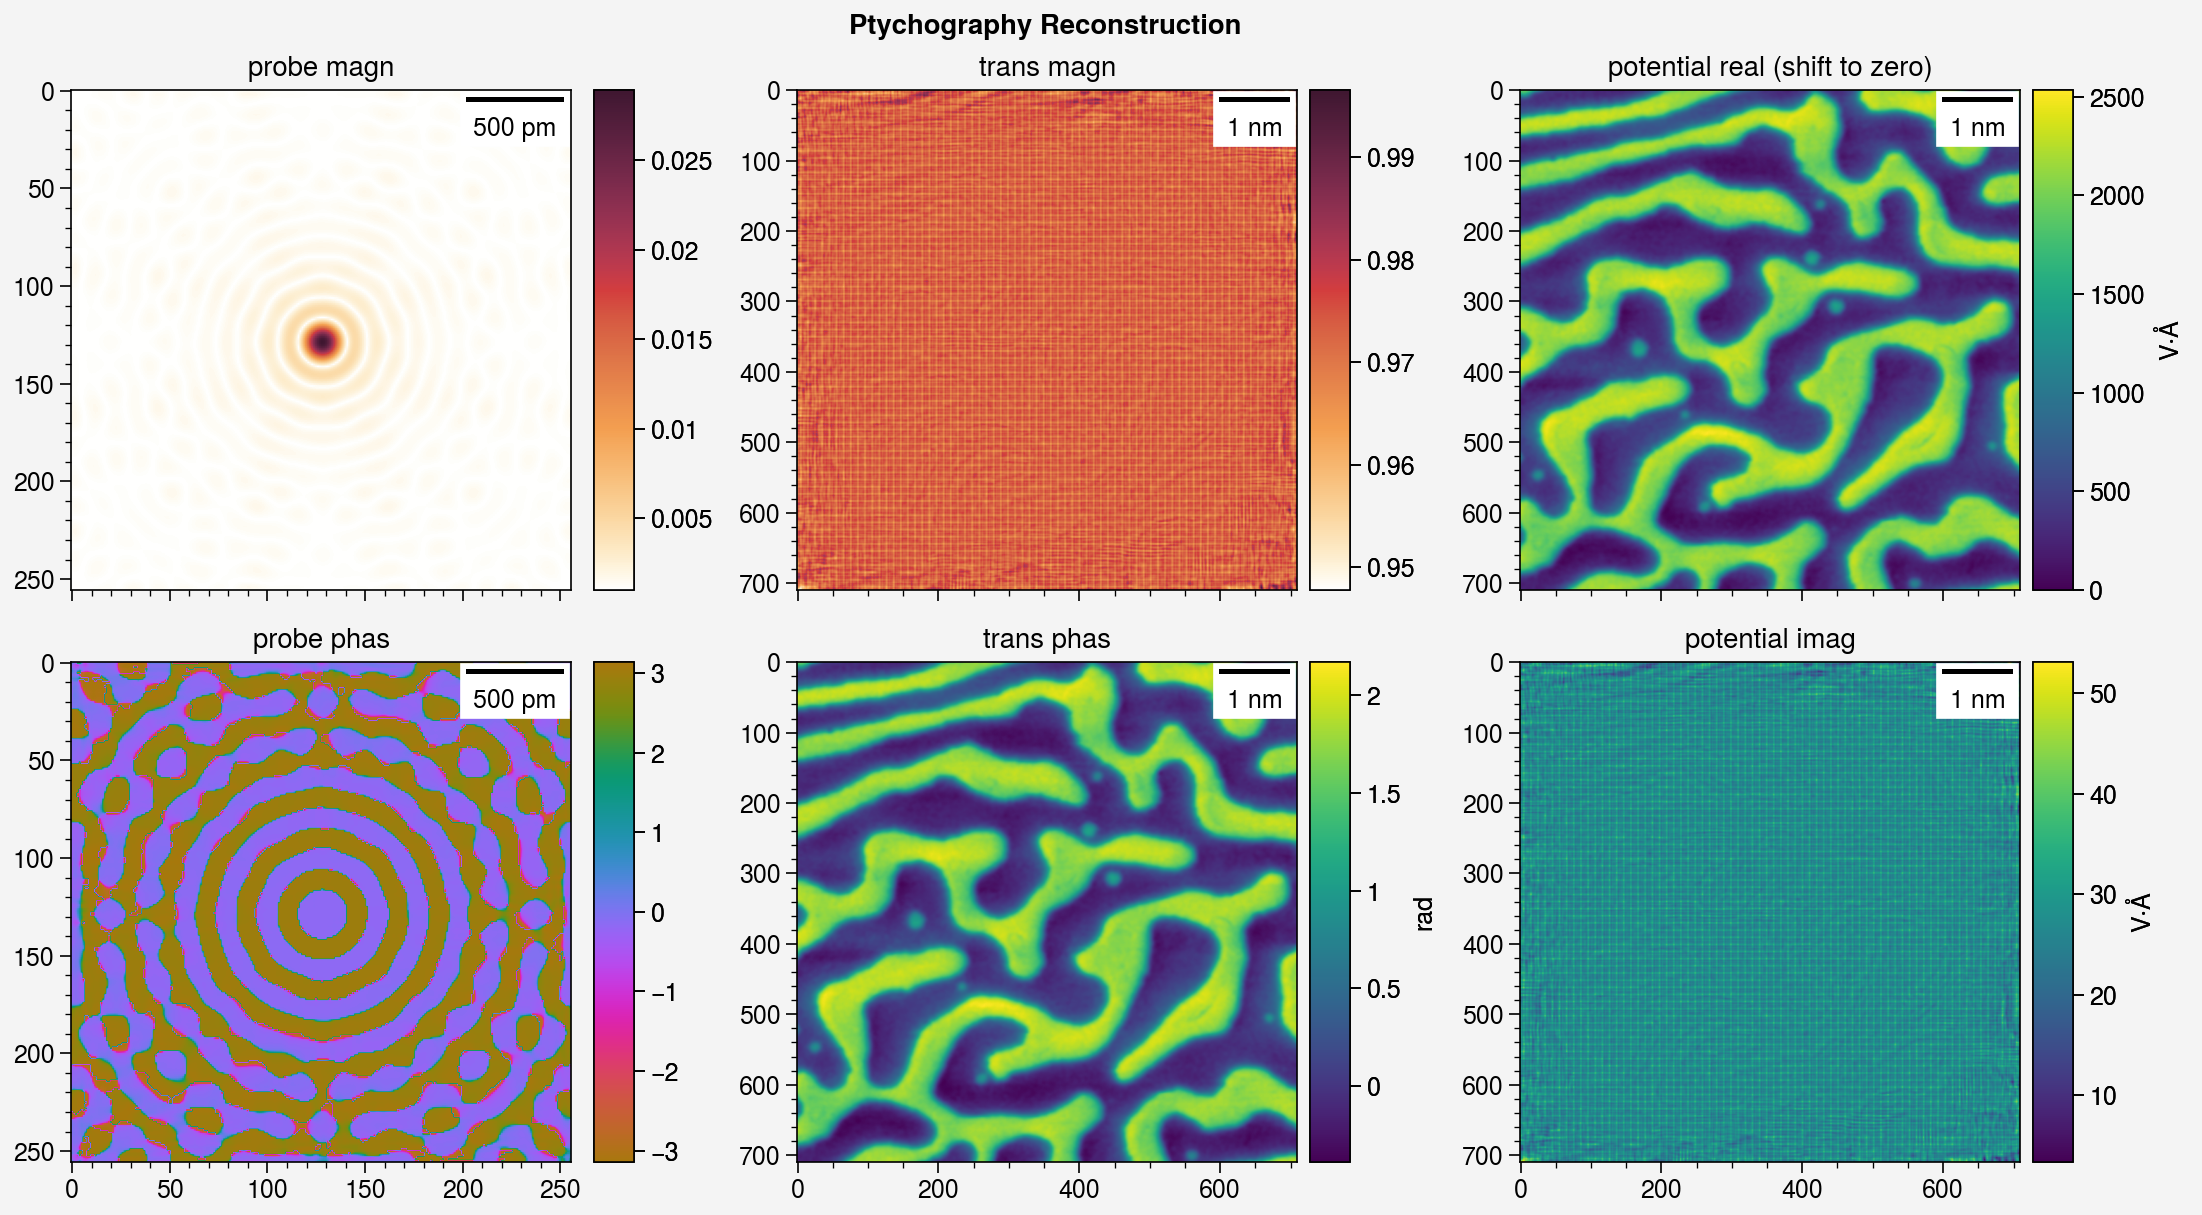

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colors
import proplot as pplt
from matplotlib_scalebar.scalebar import ScaleBar
pplt.rc["grid"] = False

fig, axs = pplt.subplots(nrows=2, ncols=3, sharey=False, suptitle="Ptychography Reconstruction")

# probe image (magnitude and phase parts)
m = axs[0, 0].imshow(np.abs(probe_rot) + 1e-3)#, norm=colors.LogNorm())
axs[0, 0].format(title="probe magn")
axs[0, 0].colorbar(m, loc="r")

m = axs[1, 0].imshow(np.angle(probe_rot), cmap="phase", vmin=-np.pi, vmax=np.pi)
axs[1, 0].format(title="probe phas")
axs[1, 0].colorbar(m, loc="r")

# transmission function (magnitude and phase parts)
m = axs[0, 1].imshow(np.abs(trans_rot))
axs[0, 1].format(title="trans magn")
axs[0, 1].colorbar(m, loc="r")

m = axs[1, 1].imshow(np.angle(trans_rot), cmap="viridis")
axs[1, 1].format(title="trans phas")
axs[1, 1].colorbar(m, loc="r", label="rad")

# potential function (real and imaginary parts)
m = axs[0, 2].imshow((potential_real - potential_real.min()) * 1e10, cmap="viridis")
axs[0, 2].format(title="potential real (shift to zero)")
axs[0, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

m = axs[1, 2].imshow(potential_imag * 1e10, cmap="viridis")
axs[1, 2].format(title="potential imag")
axs[1, 2].colorbar(m, loc="r", label="V$\cdot\AA$")

for i in range(2):
    for j in range(3):
        axs[i, j].add_artist(ScaleBar(resolution_real_space, "m", length_fraction=0.2))

pplt.show()
fig.savefig(result_path/"overview.png")

In [12]:
print(f"--- {time.time() - start_time} seconds ---")

--- 1527.336349248886 seconds ---


## Save the Results of the Final Iteration

In [13]:
np.save(result_path/"final_probe_rot.npy", probe_rot)
np.save(result_path/"final_trans_rot.npy", trans_rot)
np.save(result_path/"final_poten_rot.npy", potential)

## Fit Aberration in Probe Wave Function

In [14]:
from fitaber import fit_aber, coefs_all_up_to
import fitaber

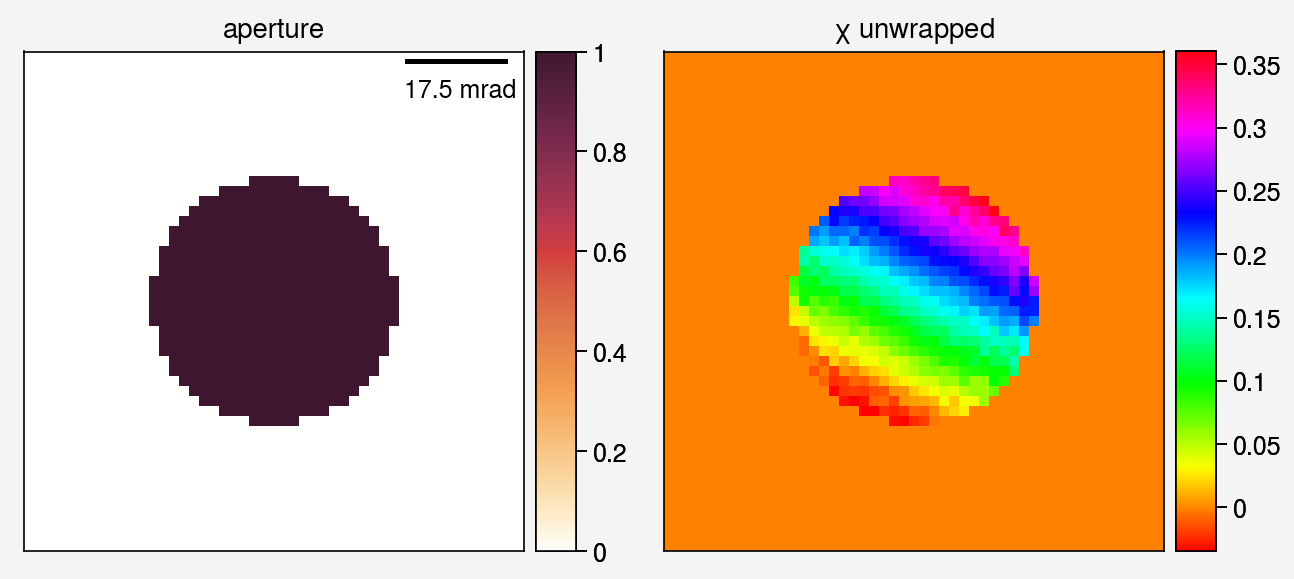

In [15]:
aperture = np.abs(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot))))
aperture = (aperture > aperture.max()/2).astype(np.int32)
# chi = -np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture
chi = -unwrap_phase(np.angle(np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(probe_rot)))) * aperture, wrap_around=True) * aperture

margin = aperture.shape[0]/2 - np.sum(aperture[aperture.shape[0]//2,:])
fig, (ax1, ax2) = pplt.subplots(nrows=1, ncols=2,
                                xlim=(margin, chi.shape[1]-margin),
                                ylim=(margin, chi.shape[1]-margin),
                                xticks=[], yticks=[])
m = ax1.imshow(aperture)
ax1.add_artist(ScaleBar(resolution_reciprocal_space_rad,
                        units="deg", dimension="angle", length_fraction=0.25,
                        scale_formatter=lambda value, unit: f"{value*np.pi/180*1e3: .1f} mrad"))
ax1.colorbar(m, loc="r")
ax1.format(title="aperture")

m = ax2.imshow(chi, cmap="hsv")
ax2.colorbar(m, loc="r")
ax2.format(title="$\chi$ unwrapped")

In [16]:
result_aber = fit_aber(chi, coefs_all_up_to(), scale=resolution_reciprocal_space_rad, mask=aperture, kV=attrs["voltage"])
print(result_aber.format())

[
[ 0]:      -: c(0,0) = C(-1,0)= Polar( 0.0001001 nm,          0 °)
[ 1]:     A0: c(1,1) = C(0,1) = Polar(  0.006695 nm,      29.11 °)
[ 3]:     C1: c(2,0) = C(1,0) = Polar(  0.003814 nm,          0 °)
[ 4]:     A1: c(2,2) = C(1,2) = Polar(   0.05787 nm,     -12.57 °)
[ 6]: 1/3 B2: c(3,1) = C(2,1) = Polar(     9.497 nm,     -58.09 °)
[ 8]:     A2: c(3,3) = C(2,3) = Polar(     2.367 nm,      24.66 °)
[10]:     C3: c(4,0) = C(3,0) = Polar(   0.05414 um,        180 °)
[11]: 1/4 S3: c(4,2) = C(3,2) = Polar(     1.007 um,      73.92 °)
[13]:     A3: c(4,4) = C(3,4) = Polar(    0.3856 um,     -3.918 °)
[15]: 1/5 B4: c(5,1) = C(4,1) = Polar(     29.15 um,      125.4 °)
[17]: 1/5 D4: c(5,3) = C(4,3) = Polar(     17.63 um,     -38.16 °)
[19]:     A4: c(5,5) = C(4,5) = Polar(     2.072 um,      14.26 °)
[21]:     C5: c(6,0) = C(5,0) = Polar(    0.3316 mm,          0 °)
[22]: 1/6 S5: c(6,2) = C(5,2) = Polar(     2.822 mm,     -16.12 °)
[24]: 1/6 R5: c(6,4) = C(5,4) = Polar(     1.874 mm,      40

aberration contribution (threshold = 5 %)
name, theta (mrad) (values [Angstrom], %)
==============  =============  =============  =============  =============  ============  ==========  =========
..              0.5            0.625          1.25           2.5            5             10          20
==============  =============  =============  =============  =============  ============  ==========  =========
==============  =============  =============  =============  =============  ============  ==========  =========
-               1.001e-13      1.001e-13      1.001e-13      1.001e-13      1.001e-13     1.001e-13   1.001e-13
= 0.0001001 nm  (96.76 %)      (95.98 %)      (92.24 %)      (85.48 %)      (74.09 %)     (55.76 %)   (23.73 %)
A0              3.347e-15      4.184e-15      8.369e-15      1.674e-14      3.347e-14     6.695e-14   1.339e-13
= 0.006695 nm   (3.235 %)      (4.011 %)      (7.709 %)      (14.29 %)      (24.77 %)     (37.28 %)   (31.73 %)
B2              3.957e-19  

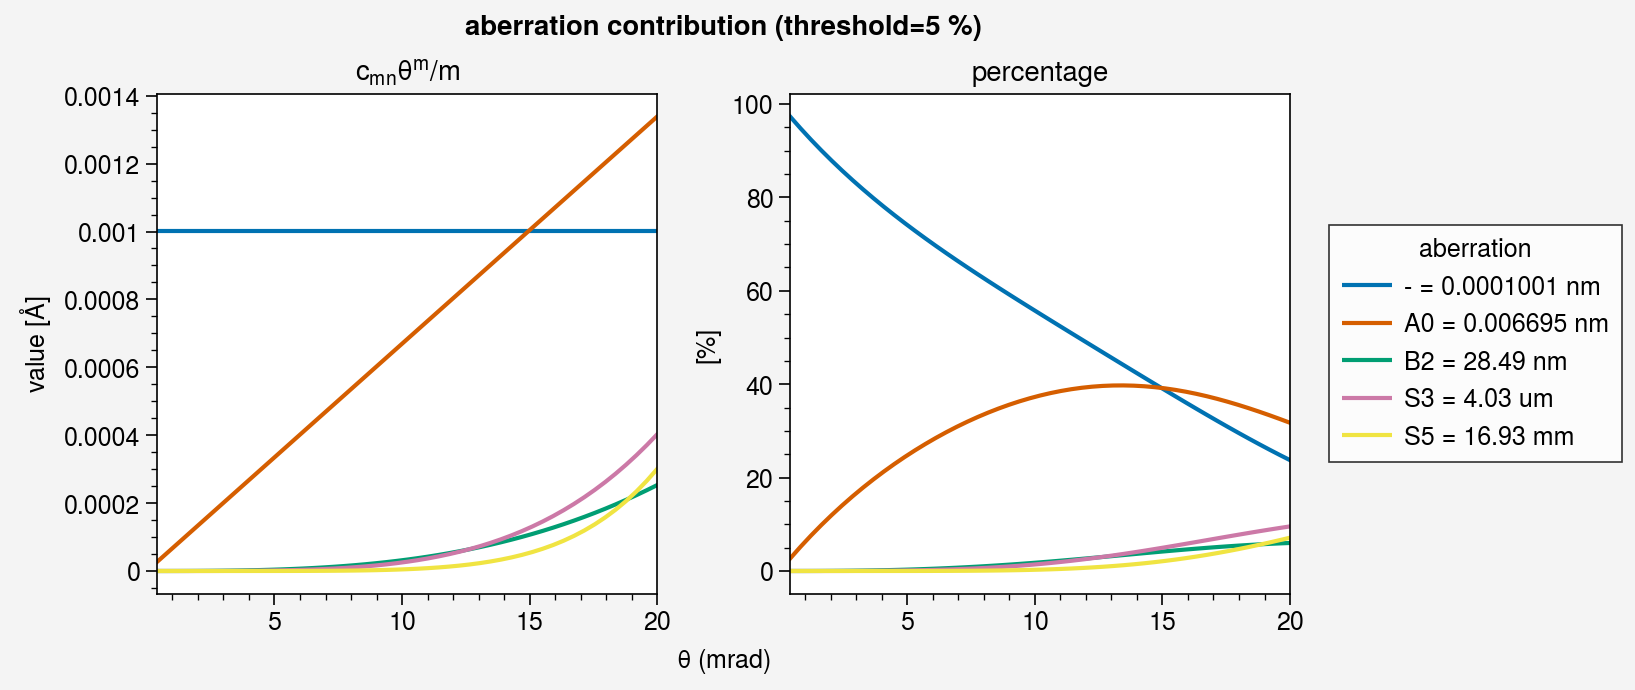

In [17]:
_ = fitaber.print_contribution(result_aber, attrs["semiconv"], threshold=5)
fitaber.plot_contribution(result_aber, attrs["semiconv"], threshold=5)

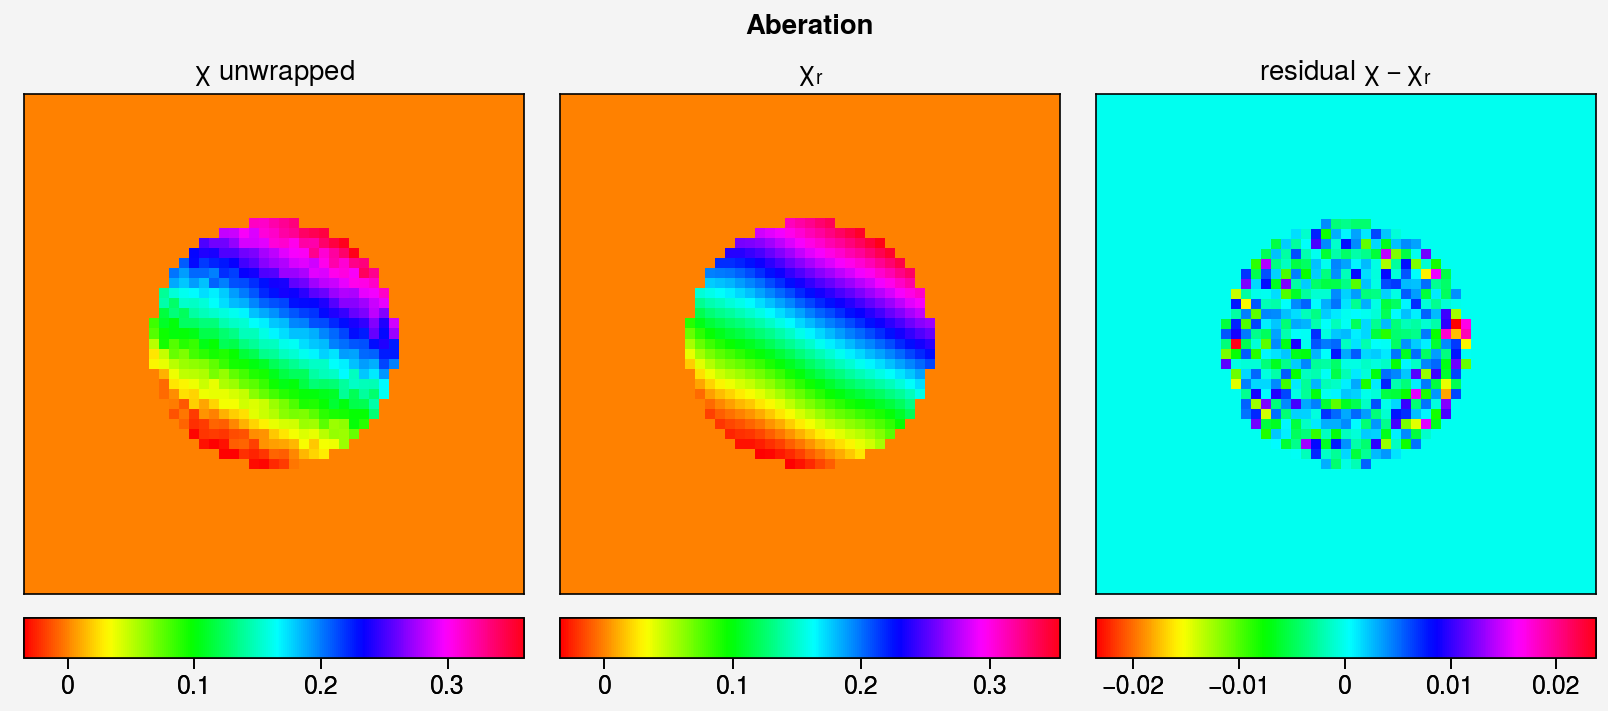

In [18]:
fig, axs = pplt.subplots(nrows=1, ncols=3, suptitle="Aberation",
                         xlim=(margin, chi.shape[1]-margin),
                         ylim=(margin, chi.shape[1]-margin),
                         xticks=[], yticks=[])
ax1, ax2, ax3 = axs

m = ax1.imshow(chi, cmap="hsv")
ax1.colorbar(m, loc="b")
ax1.format(title="$\chi$ unwrapped")

reconstaber = fitaber.aber(result_aber, chi.shape[0], resolution_reciprocal_space_rad) * aperture
m = ax2.imshow(reconstaber, cmap="hsv")
ax2.colorbar(m, loc="b")
ax2.format(title="$\chi_{\mathrm{r}}$")

residual = chi - reconstaber
m = ax3.imshow(residual, cmap="hsv")
ax3.colorbar(m, loc="b")
ax3.format(title="residual $\chi - \chi_{\mathrm{r}}$")

pplt.show()